In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.591788072529085
Log Loss: 0.6613517296521003


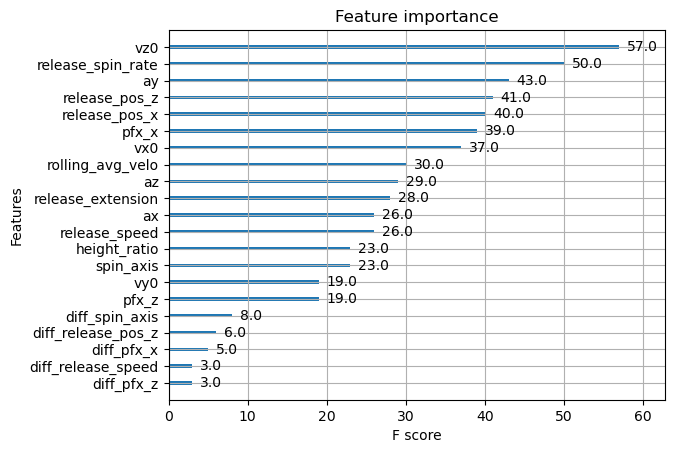

In [12]:
xgb.plot_importance(model)
plt.show()

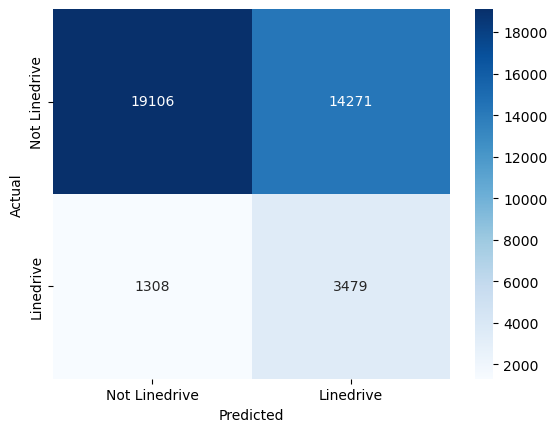

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 11:08:26,968] A new study created in memory with name: no-name-a89ebf38-ad38-446f-a0fe-a93e3f08cd5b


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.64870
[4]	eval-logloss:0.64198
[5]	eval-logloss:0.63175
[6]	eval-logloss:0.62124
[7]	eval-logloss:0.61354
[8]	eval-logloss:0.60529
[9]	eval-logloss:0.59869
[10]	eval-logloss:0.59061
[11]	eval-logloss:0.58580
[12]	eval-logloss:0.58130
[13]	eval-logloss:0.57490
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.55891
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.54298
[19]	eval-logloss:0.53636
[20]	eval-logloss:0.53180
[21]	eval-logloss:0.52799
[22]	eval-logloss:0.52362
[23]	eval-logloss:0.52181
[24]	eval-logloss:0.51755
[25]	eval-logloss:0.51318
[26]	eval-logloss:0.51023
[27]	eval-logloss:0.50448
[28]	eval-logloss:0.49928
[29]	eval-logloss:0.49597
[30]	eval-logloss:0.49199
[31]	eval-logloss:0.49004
[32]	eval-logloss:0.48853
[33]	eval-logloss:0.48374
[34]	eval-logloss:0.48064
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47242
[37]	eval-logloss:0.46877
[38]	eval-logloss:0.46

[I 2023-11-15 11:08:30,162] Trial 0 finished with value: 0.3075493668564664 and parameters: {'max_depth': 8, 'eta': 0.1534022888293536, 'subsample': 0.7767838428681061, 'colsample_bytree': 0.8741383617129477}. Best is trial 0 with value: 0.3075493668564664.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61021
[8]	eval-logloss:0.60512
[9]	eval-logloss:0.59720
[10]	eval-logloss:0.58960
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.57805
[13]	eval-logloss:0.57465
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56268
[16]	eval-logloss:0.56055
[17]	eval-logloss:0.55621
[18]	eval-logloss:0.54994
[19]	eval-logloss:0.54635
[20]	eval-logloss:0.53547
[21]	eval-logloss:0.53136
[22]	eval-logloss:0.52678
[23]	eval-logloss:0.52273
[24]	eval-logloss:0.51942
[25]	eval-logloss:0.51306
[26]	eval-logloss:0.50799
[27]	eval-logloss:0.50248
[28]	eval-logloss:0.50044
[29]	eval-logloss:0.49642
[30]	eval-logloss:0.49271
[31]	eval-logloss:0.48580
[32]	eval-logloss:0.48301
[33]	eval-logloss:0.47991
[34]	eval-logloss:0.47455
[35]	eval-logloss:0.46911
[36]	eval-logloss:0.46709
[37]	eval-logloss:0.46425
[38]	eval-logloss:0.46

[I 2023-11-15 11:08:32,704] Trial 1 finished with value: 0.28365467691617685 and parameters: {'max_depth': 7, 'eta': 0.2869293164891532, 'subsample': 0.8939779268805654, 'colsample_bytree': 0.6159751551968897}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68241
[3]	eval-logloss:0.67906
[4]	eval-logloss:0.67685
[5]	eval-logloss:0.67335
[6]	eval-logloss:0.67075
[7]	eval-logloss:0.66851
[8]	eval-logloss:0.66623
[9]	eval-logloss:0.66468
[10]	eval-logloss:0.66241
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65874
[13]	eval-logloss:0.65774
[14]	eval-logloss:0.65552
[15]	eval-logloss:0.65367
[16]	eval-logloss:0.65136
[17]	eval-logloss:0.64952
[18]	eval-logloss:0.64742
[19]	eval-logloss:0.64589
[20]	eval-logloss:0.64301
[21]	eval-logloss:0.64033
[22]	eval-logloss:0.63884
[23]	eval-logloss:0.63746
[24]	eval-logloss:0.63682
[25]	eval-logloss:0.63465
[26]	eval-logloss:0.63246
[27]	eval-logloss:0.63130
[28]	eval-logloss:0.62939
[29]	eval-logloss:0.62744
[30]	eval-logloss:0.62548
[31]	eval-logloss:0.62424
[32]	eval-logloss:0.62225
[33]	eval-logloss:0.62073
[34]	eval-logloss:0.61991
[35]	eval-logloss:0.61837
[36]	eval-logloss:0.61702
[37]	eval-logloss:0.61548
[38]	eval-logloss:0.61

[I 2023-11-15 11:08:34,867] Trial 2 finished with value: 0.5413764674164463 and parameters: {'max_depth': 6, 'eta': 0.09346039848238354, 'subsample': 0.8091041537321698, 'colsample_bytree': 0.5582654324860443}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68727
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67315
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.66949
[17]	eval-logloss:0.66892
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66688
[20]	eval-logloss:0.66557
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66463
[24]	eval-logloss:0.66424
[25]	eval-logloss:0.66336
[26]	eval-logloss:0.66292
[27]	eval-logloss:0.66150
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66122
[30]	eval-logloss:0.65903
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65778
[33]	eval-logloss:0.65547
[34]	eval-logloss:0.65498
[35]	eval-logloss:0.65497
[36]	eval-logloss:0.65444
[37]	eval-logloss:0.65381
[38]	eval-logloss:0.65

[I 2023-11-15 11:08:36,612] Trial 3 finished with value: 0.6119936732990873 and parameters: {'max_depth': 3, 'eta': 0.294468127405237, 'subsample': 0.8040842320118622, 'colsample_bytree': 0.9631964672359858}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68705
[8]	eval-logloss:0.68610
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68485
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68285
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.67890
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67655
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67436
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67382
[36]	eval-logloss:0.67368
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67

[I 2023-11-15 11:08:38,361] Trial 4 finished with value: 0.6534308749131016 and parameters: {'max_depth': 3, 'eta': 0.10610595787775771, 'subsample': 0.7277612573476412, 'colsample_bytree': 0.7069767670283984}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68344
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67393
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.66909
[9]	eval-logloss:0.66839
[10]	eval-logloss:0.66639
[11]	eval-logloss:0.66514
[12]	eval-logloss:0.66368
[13]	eval-logloss:0.66167
[14]	eval-logloss:0.66015
[15]	eval-logloss:0.65821
[16]	eval-logloss:0.65579
[17]	eval-logloss:0.65479
[18]	eval-logloss:0.65284
[19]	eval-logloss:0.65081
[20]	eval-logloss:0.64845
[21]	eval-logloss:0.64648
[22]	eval-logloss:0.64460
[23]	eval-logloss:0.64448
[24]	eval-logloss:0.64344
[25]	eval-logloss:0.64214
[26]	eval-logloss:0.64066
[27]	eval-logloss:0.63910
[28]	eval-logloss:0.63781
[29]	eval-logloss:0.63610
[30]	eval-logloss:0.63412
[31]	eval-logloss:0.63308
[32]	eval-logloss:0.63184
[33]	eval-logloss:0.62928
[34]	eval-logloss:0.62823
[35]	eval-logloss:0.62719
[36]	eval-logloss:0.62658
[37]	eval-logloss:0.62560
[38]	eval-logloss:0.62

[I 2023-11-15 11:08:40,165] Trial 5 finished with value: 0.5560460761072356 and parameters: {'max_depth': 4, 'eta': 0.266211318377946, 'subsample': 0.8097797126656894, 'colsample_bytree': 0.8903215453249957}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65176
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63501
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61274
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59309
[16]	eval-logloss:0.58734
[17]	eval-logloss:0.58243
[18]	eval-logloss:0.57943
[19]	eval-logloss:0.57660
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56310
[23]	eval-logloss:0.56054
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55066
[26]	eval-logloss:0.54409
[27]	eval-logloss:0.53923
[28]	eval-logloss:0.53623
[29]	eval-logloss:0.53379
[30]	eval-logloss:0.52813
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52240
[33]	eval-logloss:0.51961
[34]	eval-logloss:0.51470
[35]	eval-logloss:0.51088
[36]	eval-logloss:0.50632
[37]	eval-logloss:0.50319
[38]	eval-logloss:0.49

[I 2023-11-15 11:08:42,459] Trial 6 finished with value: 0.35531765494108825 and parameters: {'max_depth': 8, 'eta': 0.12391982524353674, 'subsample': 0.7088748336902385, 'colsample_bytree': 0.5072493571709995}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67717
[4]	eval-logloss:0.67448
[5]	eval-logloss:0.67029
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66446
[8]	eval-logloss:0.66245
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65729
[11]	eval-logloss:0.65519
[12]	eval-logloss:0.65298
[13]	eval-logloss:0.65161
[14]	eval-logloss:0.64875
[15]	eval-logloss:0.64677
[16]	eval-logloss:0.64479
[17]	eval-logloss:0.64260
[18]	eval-logloss:0.64153
[19]	eval-logloss:0.63915
[20]	eval-logloss:0.63721
[21]	eval-logloss:0.63490
[22]	eval-logloss:0.63263
[23]	eval-logloss:0.63108
[24]	eval-logloss:0.62960
[25]	eval-logloss:0.62766
[26]	eval-logloss:0.62560
[27]	eval-logloss:0.62395
[28]	eval-logloss:0.62125
[29]	eval-logloss:0.62067
[30]	eval-logloss:0.61859
[31]	eval-logloss:0.61690
[32]	eval-logloss:0.61431
[33]	eval-logloss:0.61264
[34]	eval-logloss:0.61075
[35]	eval-logloss:0.60973
[36]	eval-logloss:0.60803
[37]	eval-logloss:0.60568
[38]	eval-logloss:0.60

[I 2023-11-15 11:08:44,338] Trial 7 finished with value: 0.5155589843414647 and parameters: {'max_depth': 6, 'eta': 0.10142936596839836, 'subsample': 0.8238718568574654, 'colsample_bytree': 0.9124767083011476}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.65184
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63525
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62038
[8]	eval-logloss:0.61370
[9]	eval-logloss:0.60799
[10]	eval-logloss:0.60078
[11]	eval-logloss:0.59540
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.56887
[17]	eval-logloss:0.56505
[18]	eval-logloss:0.56072
[19]	eval-logloss:0.55565
[20]	eval-logloss:0.54979
[21]	eval-logloss:0.54459
[22]	eval-logloss:0.54195
[23]	eval-logloss:0.53750
[24]	eval-logloss:0.53175
[25]	eval-logloss:0.52705
[26]	eval-logloss:0.52481
[27]	eval-logloss:0.52005
[28]	eval-logloss:0.51592
[29]	eval-logloss:0.51151
[30]	eval-logloss:0.50766
[31]	eval-logloss:0.50578
[32]	eval-logloss:0.50253
[33]	eval-logloss:0.50053
[34]	eval-logloss:0.49754
[35]	eval-logloss:0.49462
[36]	eval-logloss:0.49144
[37]	eval-logloss:0.48867
[38]	eval-logloss:0.48

[I 2023-11-15 11:08:52,833] Trial 8 finished with value: 0.3390150674743614 and parameters: {'max_depth': 8, 'eta': 0.13795630938391795, 'subsample': 0.7875627166815556, 'colsample_bytree': 0.542505370756222}. Best is trial 1 with value: 0.28365467691617685.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64665
[2]	eval-logloss:0.62786
[3]	eval-logloss:0.61393
[4]	eval-logloss:0.60235
[5]	eval-logloss:0.59068
[6]	eval-logloss:0.58028
[7]	eval-logloss:0.57192
[8]	eval-logloss:0.56215
[9]	eval-logloss:0.55197
[10]	eval-logloss:0.54501
[11]	eval-logloss:0.53545
[12]	eval-logloss:0.52566
[13]	eval-logloss:0.51610
[14]	eval-logloss:0.50721
[15]	eval-logloss:0.50159
[16]	eval-logloss:0.49542
[17]	eval-logloss:0.49118
[18]	eval-logloss:0.48500
[19]	eval-logloss:0.47742
[20]	eval-logloss:0.46997
[21]	eval-logloss:0.46313
[22]	eval-logloss:0.45392
[23]	eval-logloss:0.44963
[24]	eval-logloss:0.44140
[25]	eval-logloss:0.43379
[26]	eval-logloss:0.42628
[27]	eval-logloss:0.41459
[28]	eval-logloss:0.40742
[29]	eval-logloss:0.40016
[30]	eval-logloss:0.39759
[31]	eval-logloss:0.39410
[32]	eval-logloss:0.38954
[33]	eval-logloss:0.38133
[34]	eval-logloss:0.37401
[35]	eval-logloss:0.36936
[36]	eval-logloss:0.36188
[37]	eval-logloss:0.35670
[38]	eval-logloss:0.35

[I 2023-11-15 11:08:57,047] Trial 9 finished with value: 0.16932500341568554 and parameters: {'max_depth': 9, 'eta': 0.21640185345716909, 'subsample': 0.8884280498968602, 'colsample_bytree': 0.709430984479539}. Best is trial 9 with value: 0.16932500341568554.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68783
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68133
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67603
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67148
[13]	eval-logloss:0.67024
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66486
[18]	eval-logloss:0.66390
[19]	eval-logloss:0.66310
[20]	eval-logloss:0.66161
[21]	eval-logloss:0.66038
[22]	eval-logloss:0.65883
[23]	eval-logloss:0.65758
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65467
[26]	eval-logloss:0.65330
[27]	eval-logloss:0.65236
[28]	eval-logloss:0.65119
[29]	eval-logloss:0.64983
[30]	eval-logloss:0.64833
[31]	eval-logloss:0.64730
[32]	eval-logloss:0.64616
[33]	eval-logloss:0.64521
[34]	eval-logloss:0.64423
[35]	eval-logloss:0.64303
[36]	eval-logloss:0.64199
[37]	eval-logloss:0.64055
[38]	eval-logloss:0.63

[I 2023-11-15 11:09:01,379] Trial 10 finished with value: 0.5794701259844316 and parameters: {'max_depth': 9, 'eta': 0.01406259168968893, 'subsample': 0.6168003653761804, 'colsample_bytree': 0.765187323519585}. Best is trial 9 with value: 0.16932500341568554.


[0]	eval-logloss:0.66649
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.61500
[4]	eval-logloss:0.60359
[5]	eval-logloss:0.58189
[6]	eval-logloss:0.56667
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.54619
[9]	eval-logloss:0.53828
[10]	eval-logloss:0.53271
[11]	eval-logloss:0.52609
[12]	eval-logloss:0.51226
[13]	eval-logloss:0.50581
[14]	eval-logloss:0.49714
[15]	eval-logloss:0.48816
[16]	eval-logloss:0.47707
[17]	eval-logloss:0.47202
[18]	eval-logloss:0.46658
[19]	eval-logloss:0.46113
[20]	eval-logloss:0.45329
[21]	eval-logloss:0.44363
[22]	eval-logloss:0.44016
[23]	eval-logloss:0.43484
[24]	eval-logloss:0.42357
[25]	eval-logloss:0.41780
[26]	eval-logloss:0.41328
[27]	eval-logloss:0.40331
[28]	eval-logloss:0.39829
[29]	eval-logloss:0.39109
[30]	eval-logloss:0.38668
[31]	eval-logloss:0.38226
[32]	eval-logloss:0.37465
[33]	eval-logloss:0.37161
[34]	eval-logloss:0.36584
[35]	eval-logloss:0.36317
[36]	eval-logloss:0.35643
[37]	eval-logloss:0.35181
[38]	eval-logloss:0.34

[I 2023-11-15 11:09:05,288] Trial 11 finished with value: 0.1605772389144812 and parameters: {'max_depth': 9, 'eta': 0.23465167178303498, 'subsample': 0.8910194285203621, 'colsample_bytree': 0.6489178265253132}. Best is trial 11 with value: 0.1605772389144812.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64604
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61458
[4]	eval-logloss:0.60092
[5]	eval-logloss:0.58604
[6]	eval-logloss:0.57044
[7]	eval-logloss:0.56247
[8]	eval-logloss:0.55298
[9]	eval-logloss:0.53507
[10]	eval-logloss:0.52149
[11]	eval-logloss:0.51569
[12]	eval-logloss:0.51188
[13]	eval-logloss:0.49951
[14]	eval-logloss:0.48962
[15]	eval-logloss:0.48318
[16]	eval-logloss:0.47749
[17]	eval-logloss:0.47060
[18]	eval-logloss:0.45867
[19]	eval-logloss:0.45389
[20]	eval-logloss:0.44691
[21]	eval-logloss:0.43801
[22]	eval-logloss:0.43161
[23]	eval-logloss:0.41966
[24]	eval-logloss:0.41334
[25]	eval-logloss:0.40345
[26]	eval-logloss:0.39796
[27]	eval-logloss:0.39258
[28]	eval-logloss:0.38727
[29]	eval-logloss:0.38192
[30]	eval-logloss:0.37925
[31]	eval-logloss:0.37141
[32]	eval-logloss:0.36556
[33]	eval-logloss:0.35862
[34]	eval-logloss:0.35263
[35]	eval-logloss:0.34755
[36]	eval-logloss:0.34426
[37]	eval-logloss:0.34002
[38]	eval-logloss:0.33

[I 2023-11-15 11:09:09,290] Trial 12 finished with value: 0.16258480208093432 and parameters: {'max_depth': 9, 'eta': 0.2239774020311798, 'subsample': 0.88765521333302, 'colsample_bytree': 0.6758742706895692}. Best is trial 11 with value: 0.1605772389144812.


[0]	eval-logloss:0.66324
[1]	eval-logloss:0.64294
[2]	eval-logloss:0.62273
[3]	eval-logloss:0.60969
[4]	eval-logloss:0.59548
[5]	eval-logloss:0.57898
[6]	eval-logloss:0.56204
[7]	eval-logloss:0.55137
[8]	eval-logloss:0.53696
[9]	eval-logloss:0.53214
[10]	eval-logloss:0.52124
[11]	eval-logloss:0.51438
[12]	eval-logloss:0.50500
[13]	eval-logloss:0.49837
[14]	eval-logloss:0.48976
[15]	eval-logloss:0.47987
[16]	eval-logloss:0.46958
[17]	eval-logloss:0.46517
[18]	eval-logloss:0.45845
[19]	eval-logloss:0.45071
[20]	eval-logloss:0.44170
[21]	eval-logloss:0.43201
[22]	eval-logloss:0.42446
[23]	eval-logloss:0.41583
[24]	eval-logloss:0.41403
[25]	eval-logloss:0.40989
[26]	eval-logloss:0.40431
[27]	eval-logloss:0.39864
[28]	eval-logloss:0.39209
[29]	eval-logloss:0.38616
[30]	eval-logloss:0.38205
[31]	eval-logloss:0.37528
[32]	eval-logloss:0.37041
[33]	eval-logloss:0.36652
[34]	eval-logloss:0.36198
[35]	eval-logloss:0.35978
[36]	eval-logloss:0.35483
[37]	eval-logloss:0.35087
[38]	eval-logloss:0.34

[I 2023-11-15 11:09:12,555] Trial 13 finished with value: 0.1704155496286668 and parameters: {'max_depth': 9, 'eta': 0.21916625583665153, 'subsample': 0.8714851412691046, 'colsample_bytree': 0.6460300533587741}. Best is trial 11 with value: 0.1605772389144812.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67629
[4]	eval-logloss:0.67332
[5]	eval-logloss:0.66954
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66162
[9]	eval-logloss:0.65962
[10]	eval-logloss:0.65547
[11]	eval-logloss:0.65361
[12]	eval-logloss:0.65191
[13]	eval-logloss:0.64821
[14]	eval-logloss:0.64687
[15]	eval-logloss:0.64393
[16]	eval-logloss:0.64169
[17]	eval-logloss:0.64008
[18]	eval-logloss:0.63753
[19]	eval-logloss:0.63511
[20]	eval-logloss:0.63296
[21]	eval-logloss:0.63067
[22]	eval-logloss:0.62822
[23]	eval-logloss:0.62661
[24]	eval-logloss:0.62482
[25]	eval-logloss:0.62302
[26]	eval-logloss:0.61971
[27]	eval-logloss:0.61836
[28]	eval-logloss:0.61581
[29]	eval-logloss:0.61445
[30]	eval-logloss:0.61238
[31]	eval-logloss:0.61038
[32]	eval-logloss:0.60796
[33]	eval-logloss:0.60519
[34]	eval-logloss:0.60401
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60170
[37]	eval-logloss:0.60038
[38]	eval-logloss:0.59

[I 2023-11-15 11:09:14,651] Trial 14 finished with value: 0.5051572393989524 and parameters: {'max_depth': 5, 'eta': 0.2109806561490661, 'subsample': 0.8545795905134044, 'colsample_bytree': 0.7804992186318266}. Best is trial 11 with value: 0.1605772389144812.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65212
[4]	eval-logloss:0.64594
[5]	eval-logloss:0.63594
[6]	eval-logloss:0.62716
[7]	eval-logloss:0.61828
[8]	eval-logloss:0.61016
[9]	eval-logloss:0.60618
[10]	eval-logloss:0.60372
[11]	eval-logloss:0.59919
[12]	eval-logloss:0.59311
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58284
[15]	eval-logloss:0.57505
[16]	eval-logloss:0.57070
[17]	eval-logloss:0.56553
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55351
[20]	eval-logloss:0.54532
[21]	eval-logloss:0.53931
[22]	eval-logloss:0.53591
[23]	eval-logloss:0.53155
[24]	eval-logloss:0.52839
[25]	eval-logloss:0.52306
[26]	eval-logloss:0.51904
[27]	eval-logloss:0.51296
[28]	eval-logloss:0.50963
[29]	eval-logloss:0.50360
[30]	eval-logloss:0.50029
[31]	eval-logloss:0.49615
[32]	eval-logloss:0.49328
[33]	eval-logloss:0.48926
[34]	eval-logloss:0.48638
[35]	eval-logloss:0.48370
[36]	eval-logloss:0.47948
[37]	eval-logloss:0.47675
[38]	eval-logloss:0.47

[I 2023-11-15 11:09:17,326] Trial 15 finished with value: 0.31123637171827295 and parameters: {'max_depth': 7, 'eta': 0.24376697043026788, 'subsample': 0.8538255114709234, 'colsample_bytree': 0.6309972100322999}. Best is trial 11 with value: 0.1605772389144812.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66206
[3]	eval-logloss:0.65545
[4]	eval-logloss:0.64871
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63816
[7]	eval-logloss:0.63188
[8]	eval-logloss:0.62577
[9]	eval-logloss:0.61837
[10]	eval-logloss:0.61131
[11]	eval-logloss:0.60593
[12]	eval-logloss:0.59940
[13]	eval-logloss:0.59708
[14]	eval-logloss:0.59402
[15]	eval-logloss:0.58903
[16]	eval-logloss:0.58521
[17]	eval-logloss:0.57961
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.56832
[20]	eval-logloss:0.56436
[21]	eval-logloss:0.55862
[22]	eval-logloss:0.55489
[23]	eval-logloss:0.55245
[24]	eval-logloss:0.54832
[25]	eval-logloss:0.54449
[26]	eval-logloss:0.54091
[27]	eval-logloss:0.53607
[28]	eval-logloss:0.53167
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52310
[31]	eval-logloss:0.52022
[32]	eval-logloss:0.51788
[33]	eval-logloss:0.51577
[34]	eval-logloss:0.51310
[35]	eval-logloss:0.50966
[36]	eval-logloss:0.50871
[37]	eval-logloss:0.50655
[38]	eval-logloss:0.50

[I 2023-11-15 11:09:19,741] Trial 16 finished with value: 0.35261957836324564 and parameters: {'max_depth': 7, 'eta': 0.19246292022622075, 'subsample': 0.8985242810808304, 'colsample_bytree': 0.6864984411067028}. Best is trial 11 with value: 0.1605772389144812.


[0]	eval-logloss:0.65927
[1]	eval-logloss:0.63513
[2]	eval-logloss:0.61270
[3]	eval-logloss:0.59599
[4]	eval-logloss:0.58521
[5]	eval-logloss:0.56617
[6]	eval-logloss:0.55714
[7]	eval-logloss:0.54618
[8]	eval-logloss:0.53940
[9]	eval-logloss:0.52451
[10]	eval-logloss:0.51150
[11]	eval-logloss:0.50568
[12]	eval-logloss:0.49457
[13]	eval-logloss:0.48754
[14]	eval-logloss:0.48178
[15]	eval-logloss:0.47431
[16]	eval-logloss:0.46409
[17]	eval-logloss:0.45642
[18]	eval-logloss:0.44750
[19]	eval-logloss:0.43960
[20]	eval-logloss:0.42851
[21]	eval-logloss:0.41702
[22]	eval-logloss:0.41147
[23]	eval-logloss:0.40404
[24]	eval-logloss:0.39468
[25]	eval-logloss:0.38775
[26]	eval-logloss:0.38445
[27]	eval-logloss:0.37977
[28]	eval-logloss:0.37235
[29]	eval-logloss:0.36925
[30]	eval-logloss:0.36154
[31]	eval-logloss:0.35713
[32]	eval-logloss:0.35329
[33]	eval-logloss:0.34759
[34]	eval-logloss:0.34337
[35]	eval-logloss:0.33736
[36]	eval-logloss:0.33030
[37]	eval-logloss:0.32645
[38]	eval-logloss:0.32

[I 2023-11-15 11:09:22,605] Trial 17 finished with value: 0.14151867289627945 and parameters: {'max_depth': 9, 'eta': 0.2511321259627616, 'subsample': 0.8463232549531388, 'colsample_bytree': 0.8009372492411341}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.63970
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.61673
[5]	eval-logloss:0.60988
[6]	eval-logloss:0.59938
[7]	eval-logloss:0.59269
[8]	eval-logloss:0.58497
[9]	eval-logloss:0.57994
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56263
[12]	eval-logloss:0.55672
[13]	eval-logloss:0.54920
[14]	eval-logloss:0.53740
[15]	eval-logloss:0.52638
[16]	eval-logloss:0.51821
[17]	eval-logloss:0.51154
[18]	eval-logloss:0.50713
[19]	eval-logloss:0.49791
[20]	eval-logloss:0.49254
[21]	eval-logloss:0.48522
[22]	eval-logloss:0.47568
[23]	eval-logloss:0.47272
[24]	eval-logloss:0.46765
[25]	eval-logloss:0.46519
[26]	eval-logloss:0.45961
[27]	eval-logloss:0.45459
[28]	eval-logloss:0.44970
[29]	eval-logloss:0.44553
[30]	eval-logloss:0.43624
[31]	eval-logloss:0.43357
[32]	eval-logloss:0.42751
[33]	eval-logloss:0.42274
[34]	eval-logloss:0.41765
[35]	eval-logloss:0.41125
[36]	eval-logloss:0.40859
[37]	eval-logloss:0.40609
[38]	eval-logloss:0.40

[I 2023-11-15 11:09:26,507] Trial 18 finished with value: 0.2140297062769645 and parameters: {'max_depth': 8, 'eta': 0.25080135657084773, 'subsample': 0.8523766224908942, 'colsample_bytree': 0.7979852638343184}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67667
[4]	eval-logloss:0.67411
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66771
[7]	eval-logloss:0.66621
[8]	eval-logloss:0.66320
[9]	eval-logloss:0.66036
[10]	eval-logloss:0.65702
[11]	eval-logloss:0.65500
[12]	eval-logloss:0.65248
[13]	eval-logloss:0.65080
[14]	eval-logloss:0.64885
[15]	eval-logloss:0.64748
[16]	eval-logloss:0.64449
[17]	eval-logloss:0.64296
[18]	eval-logloss:0.64049
[19]	eval-logloss:0.63783
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63332
[22]	eval-logloss:0.63233
[23]	eval-logloss:0.63106
[24]	eval-logloss:0.62924
[25]	eval-logloss:0.62726
[26]	eval-logloss:0.62554
[27]	eval-logloss:0.62260
[28]	eval-logloss:0.62038
[29]	eval-logloss:0.61966
[30]	eval-logloss:0.61762
[31]	eval-logloss:0.61622
[32]	eval-logloss:0.61496
[33]	eval-logloss:0.61358
[34]	eval-logloss:0.61173
[35]	eval-logloss:0.61018
[36]	eval-logloss:0.60855
[37]	eval-logloss:0.60748
[38]	eval-logloss:0.60

[I 2023-11-15 11:09:28,450] Trial 19 finished with value: 0.5221137165137506 and parameters: {'max_depth': 5, 'eta': 0.18585658263085114, 'subsample': 0.8406063431559452, 'colsample_bytree': 0.8261301196107561}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.64712
[4]	eval-logloss:0.64073
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.61625
[8]	eval-logloss:0.60762
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59347
[11]	eval-logloss:0.58354
[12]	eval-logloss:0.57866
[13]	eval-logloss:0.57373
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.55890
[16]	eval-logloss:0.55405
[17]	eval-logloss:0.55124
[18]	eval-logloss:0.54482
[19]	eval-logloss:0.54267
[20]	eval-logloss:0.53929
[21]	eval-logloss:0.53297
[22]	eval-logloss:0.52827
[23]	eval-logloss:0.52574
[24]	eval-logloss:0.52218
[25]	eval-logloss:0.51916
[26]	eval-logloss:0.51213
[27]	eval-logloss:0.50658
[28]	eval-logloss:0.50275
[29]	eval-logloss:0.49758
[30]	eval-logloss:0.49427
[31]	eval-logloss:0.49004
[32]	eval-logloss:0.48750
[33]	eval-logloss:0.48483
[34]	eval-logloss:0.47929
[35]	eval-logloss:0.47400
[36]	eval-logloss:0.46938
[37]	eval-logloss:0.46443
[38]	eval-logloss:0.46

[I 2023-11-15 11:09:30,679] Trial 20 finished with value: 0.2777113879079329 and parameters: {'max_depth': 7, 'eta': 0.268337205826909, 'subsample': 0.8354899598704968, 'colsample_bytree': 0.7225222492477248}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.66251
[1]	eval-logloss:0.64401
[2]	eval-logloss:0.62359
[3]	eval-logloss:0.60678
[4]	eval-logloss:0.59337
[5]	eval-logloss:0.57940
[6]	eval-logloss:0.56840
[7]	eval-logloss:0.55767
[8]	eval-logloss:0.54839
[9]	eval-logloss:0.53806
[10]	eval-logloss:0.52769
[11]	eval-logloss:0.52121
[12]	eval-logloss:0.51627
[13]	eval-logloss:0.50216
[14]	eval-logloss:0.49684
[15]	eval-logloss:0.48367
[16]	eval-logloss:0.47556
[17]	eval-logloss:0.46886
[18]	eval-logloss:0.46341
[19]	eval-logloss:0.45450
[20]	eval-logloss:0.44651
[21]	eval-logloss:0.43765
[22]	eval-logloss:0.42798
[23]	eval-logloss:0.42351
[24]	eval-logloss:0.41505
[25]	eval-logloss:0.41142
[26]	eval-logloss:0.40583
[27]	eval-logloss:0.40212
[28]	eval-logloss:0.39197
[29]	eval-logloss:0.38569
[30]	eval-logloss:0.37925
[31]	eval-logloss:0.37209
[32]	eval-logloss:0.36621
[33]	eval-logloss:0.35990
[34]	eval-logloss:0.35606
[35]	eval-logloss:0.35137
[36]	eval-logloss:0.34833
[37]	eval-logloss:0.34271
[38]	eval-logloss:0.33

[I 2023-11-15 11:09:33,249] Trial 21 finished with value: 0.15974149529030163 and parameters: {'max_depth': 9, 'eta': 0.24069171469714712, 'subsample': 0.8743103740475733, 'colsample_bytree': 0.756490072010531}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.61855
[3]	eval-logloss:0.59559
[4]	eval-logloss:0.58665
[5]	eval-logloss:0.57274
[6]	eval-logloss:0.56160
[7]	eval-logloss:0.55318
[8]	eval-logloss:0.54625
[9]	eval-logloss:0.53953
[10]	eval-logloss:0.52270
[11]	eval-logloss:0.51344
[12]	eval-logloss:0.50510
[13]	eval-logloss:0.49517
[14]	eval-logloss:0.48018
[15]	eval-logloss:0.46743
[16]	eval-logloss:0.46272
[17]	eval-logloss:0.45552
[18]	eval-logloss:0.44586
[19]	eval-logloss:0.43595
[20]	eval-logloss:0.42630
[21]	eval-logloss:0.41785
[22]	eval-logloss:0.41330
[23]	eval-logloss:0.40632
[24]	eval-logloss:0.40213
[25]	eval-logloss:0.39843
[26]	eval-logloss:0.39105
[27]	eval-logloss:0.38034
[28]	eval-logloss:0.37311
[29]	eval-logloss:0.37166
[30]	eval-logloss:0.36730
[31]	eval-logloss:0.35829
[32]	eval-logloss:0.35396
[33]	eval-logloss:0.34687
[34]	eval-logloss:0.34398
[35]	eval-logloss:0.33825
[36]	eval-logloss:0.33295
[37]	eval-logloss:0.32938
[38]	eval-logloss:0.32

[I 2023-11-15 11:09:35,960] Trial 22 finished with value: 0.14778767719046554 and parameters: {'max_depth': 9, 'eta': 0.246309815256985, 'subsample': 0.8660163110618013, 'colsample_bytree': 0.7464749843938717}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.60436
[5]	eval-logloss:0.59733
[6]	eval-logloss:0.58192
[7]	eval-logloss:0.57660
[8]	eval-logloss:0.56960
[9]	eval-logloss:0.56509
[10]	eval-logloss:0.54821
[11]	eval-logloss:0.54161
[12]	eval-logloss:0.53351
[13]	eval-logloss:0.52361
[14]	eval-logloss:0.51697
[15]	eval-logloss:0.51368
[16]	eval-logloss:0.50713
[17]	eval-logloss:0.49795
[18]	eval-logloss:0.49128
[19]	eval-logloss:0.48375
[20]	eval-logloss:0.47862
[21]	eval-logloss:0.47410
[22]	eval-logloss:0.46431
[23]	eval-logloss:0.46214
[24]	eval-logloss:0.45497
[25]	eval-logloss:0.44789
[26]	eval-logloss:0.44043
[27]	eval-logloss:0.43282
[28]	eval-logloss:0.42860
[29]	eval-logloss:0.42203
[30]	eval-logloss:0.41776
[31]	eval-logloss:0.40999
[32]	eval-logloss:0.40358
[33]	eval-logloss:0.39866
[34]	eval-logloss:0.39057
[35]	eval-logloss:0.38558
[36]	eval-logloss:0.37875
[37]	eval-logloss:0.37441
[38]	eval-logloss:0.37

[I 2023-11-15 11:09:38,188] Trial 23 finished with value: 0.18142009220791322 and parameters: {'max_depth': 8, 'eta': 0.29803654393358286, 'subsample': 0.8536868148417466, 'colsample_bytree': 0.7593388487924605}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.66047
[1]	eval-logloss:0.64266
[2]	eval-logloss:0.61986
[3]	eval-logloss:0.60412
[4]	eval-logloss:0.59281
[5]	eval-logloss:0.58101
[6]	eval-logloss:0.57170
[7]	eval-logloss:0.56060
[8]	eval-logloss:0.54602
[9]	eval-logloss:0.53794
[10]	eval-logloss:0.52193
[11]	eval-logloss:0.50961
[12]	eval-logloss:0.50082
[13]	eval-logloss:0.48941
[14]	eval-logloss:0.47974
[15]	eval-logloss:0.46567
[16]	eval-logloss:0.45067
[17]	eval-logloss:0.44493
[18]	eval-logloss:0.43615
[19]	eval-logloss:0.43104
[20]	eval-logloss:0.42603
[21]	eval-logloss:0.41954
[22]	eval-logloss:0.41124
[23]	eval-logloss:0.41027
[24]	eval-logloss:0.40758
[25]	eval-logloss:0.39691
[26]	eval-logloss:0.38890
[27]	eval-logloss:0.38050
[28]	eval-logloss:0.37338
[29]	eval-logloss:0.36846
[30]	eval-logloss:0.36254
[31]	eval-logloss:0.35584
[32]	eval-logloss:0.35025
[33]	eval-logloss:0.34402
[34]	eval-logloss:0.33895
[35]	eval-logloss:0.33047
[36]	eval-logloss:0.32460
[37]	eval-logloss:0.32037
[38]	eval-logloss:0.31

[I 2023-11-15 11:09:41,617] Trial 24 finished with value: 0.14349413634616473 and parameters: {'max_depth': 9, 'eta': 0.25854615311682666, 'subsample': 0.8711368982357169, 'colsample_bytree': 0.8279962547295594}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63309
[3]	eval-logloss:0.62096
[4]	eval-logloss:0.61062
[5]	eval-logloss:0.60639
[6]	eval-logloss:0.59758
[7]	eval-logloss:0.58675
[8]	eval-logloss:0.57343
[9]	eval-logloss:0.56597
[10]	eval-logloss:0.56094
[11]	eval-logloss:0.55286
[12]	eval-logloss:0.54866
[13]	eval-logloss:0.54012
[14]	eval-logloss:0.53084
[15]	eval-logloss:0.52507
[16]	eval-logloss:0.51448
[17]	eval-logloss:0.50938
[18]	eval-logloss:0.50171
[19]	eval-logloss:0.49153
[20]	eval-logloss:0.48410
[21]	eval-logloss:0.47529
[22]	eval-logloss:0.46815
[23]	eval-logloss:0.45871
[24]	eval-logloss:0.45052
[25]	eval-logloss:0.44388
[26]	eval-logloss:0.43836
[27]	eval-logloss:0.43268
[28]	eval-logloss:0.42798
[29]	eval-logloss:0.42400
[30]	eval-logloss:0.41998
[31]	eval-logloss:0.41370
[32]	eval-logloss:0.40760
[33]	eval-logloss:0.40259
[34]	eval-logloss:0.39874
[35]	eval-logloss:0.39672
[36]	eval-logloss:0.39093
[37]	eval-logloss:0.38768
[38]	eval-logloss:0.38

[I 2023-11-15 11:09:45,076] Trial 25 finished with value: 0.19971329393185605 and parameters: {'max_depth': 8, 'eta': 0.2696291020140527, 'subsample': 0.8288662758745018, 'colsample_bytree': 0.8249041011763103}. Best is trial 17 with value: 0.14151867289627945.


[0]	eval-logloss:0.65899
[1]	eval-logloss:0.64076
[2]	eval-logloss:0.61877
[3]	eval-logloss:0.60355
[4]	eval-logloss:0.58214
[5]	eval-logloss:0.56279
[6]	eval-logloss:0.55074
[7]	eval-logloss:0.54110
[8]	eval-logloss:0.53483
[9]	eval-logloss:0.52648
[10]	eval-logloss:0.50646
[11]	eval-logloss:0.49496
[12]	eval-logloss:0.48749
[13]	eval-logloss:0.48135
[14]	eval-logloss:0.46830
[15]	eval-logloss:0.45922
[16]	eval-logloss:0.44629
[17]	eval-logloss:0.43881
[18]	eval-logloss:0.43300
[19]	eval-logloss:0.42243
[20]	eval-logloss:0.41047
[21]	eval-logloss:0.40325
[22]	eval-logloss:0.39890
[23]	eval-logloss:0.39529
[24]	eval-logloss:0.38787
[25]	eval-logloss:0.38339
[26]	eval-logloss:0.37889
[27]	eval-logloss:0.37386
[28]	eval-logloss:0.36685
[29]	eval-logloss:0.36096
[30]	eval-logloss:0.35493
[31]	eval-logloss:0.34780
[32]	eval-logloss:0.34365
[33]	eval-logloss:0.33472
[34]	eval-logloss:0.32953
[35]	eval-logloss:0.32366
[36]	eval-logloss:0.32053
[37]	eval-logloss:0.31489
[38]	eval-logloss:0.31

[I 2023-11-15 11:09:49,430] Trial 26 finished with value: 0.13689240029737265 and parameters: {'max_depth': 9, 'eta': 0.26512949631484883, 'subsample': 0.8630182339217858, 'colsample_bytree': 0.8361325700027795}. Best is trial 26 with value: 0.13689240029737265.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.63804
[3]	eval-logloss:0.62537
[4]	eval-logloss:0.61155
[5]	eval-logloss:0.59994
[6]	eval-logloss:0.59314
[7]	eval-logloss:0.58803
[8]	eval-logloss:0.57838
[9]	eval-logloss:0.56698
[10]	eval-logloss:0.55397
[11]	eval-logloss:0.54898
[12]	eval-logloss:0.54284
[13]	eval-logloss:0.53024
[14]	eval-logloss:0.52087
[15]	eval-logloss:0.51592
[16]	eval-logloss:0.50769
[17]	eval-logloss:0.49947
[18]	eval-logloss:0.49185
[19]	eval-logloss:0.48677
[20]	eval-logloss:0.48062
[21]	eval-logloss:0.46888
[22]	eval-logloss:0.46298
[23]	eval-logloss:0.45662
[24]	eval-logloss:0.45206
[25]	eval-logloss:0.44595
[26]	eval-logloss:0.44062
[27]	eval-logloss:0.43190
[28]	eval-logloss:0.42732
[29]	eval-logloss:0.42096
[30]	eval-logloss:0.41835
[31]	eval-logloss:0.41284
[32]	eval-logloss:0.40673
[33]	eval-logloss:0.40183
[34]	eval-logloss:0.39568
[35]	eval-logloss:0.39168
[36]	eval-logloss:0.38814
[37]	eval-logloss:0.38323
[38]	eval-logloss:0.37

[I 2023-11-15 11:09:52,127] Trial 27 finished with value: 0.19264843848329632 and parameters: {'max_depth': 8, 'eta': 0.27732268104596364, 'subsample': 0.8341624650964209, 'colsample_bytree': 0.8442344468340781}. Best is trial 26 with value: 0.13689240029737265.


[0]	eval-logloss:0.65667
[1]	eval-logloss:0.63282
[2]	eval-logloss:0.61136
[3]	eval-logloss:0.59571
[4]	eval-logloss:0.58455
[5]	eval-logloss:0.56685
[6]	eval-logloss:0.55643
[7]	eval-logloss:0.54891
[8]	eval-logloss:0.53281
[9]	eval-logloss:0.52741
[10]	eval-logloss:0.51945
[11]	eval-logloss:0.51022
[12]	eval-logloss:0.49800
[13]	eval-logloss:0.48489
[14]	eval-logloss:0.47627
[15]	eval-logloss:0.46834
[16]	eval-logloss:0.45631
[17]	eval-logloss:0.45036
[18]	eval-logloss:0.43872
[19]	eval-logloss:0.43488
[20]	eval-logloss:0.42835
[21]	eval-logloss:0.41837
[22]	eval-logloss:0.40830
[23]	eval-logloss:0.39902
[24]	eval-logloss:0.39071
[25]	eval-logloss:0.38417
[26]	eval-logloss:0.37686
[27]	eval-logloss:0.36711
[28]	eval-logloss:0.36016
[29]	eval-logloss:0.35707
[30]	eval-logloss:0.35098
[31]	eval-logloss:0.34467
[32]	eval-logloss:0.34116
[33]	eval-logloss:0.33557
[34]	eval-logloss:0.33110
[35]	eval-logloss:0.32458
[36]	eval-logloss:0.32322
[37]	eval-logloss:0.31790
[38]	eval-logloss:0.31

[I 2023-11-15 11:09:54,601] Trial 28 finished with value: 0.1343700142638584 and parameters: {'max_depth': 9, 'eta': 0.26190589672807235, 'subsample': 0.8641113651400103, 'colsample_bytree': 0.8052745719005561}. Best is trial 28 with value: 0.1343700142638584.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.63039
[3]	eval-logloss:0.61962
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.59363
[6]	eval-logloss:0.58181
[7]	eval-logloss:0.57025
[8]	eval-logloss:0.55705
[9]	eval-logloss:0.54543
[10]	eval-logloss:0.53419
[11]	eval-logloss:0.52734
[12]	eval-logloss:0.51799
[13]	eval-logloss:0.50586
[14]	eval-logloss:0.49751
[15]	eval-logloss:0.48998
[16]	eval-logloss:0.48062
[17]	eval-logloss:0.47406
[18]	eval-logloss:0.46417
[19]	eval-logloss:0.45691
[20]	eval-logloss:0.45163
[21]	eval-logloss:0.44484
[22]	eval-logloss:0.43956
[23]	eval-logloss:0.43474
[24]	eval-logloss:0.42978
[25]	eval-logloss:0.42614
[26]	eval-logloss:0.42393
[27]	eval-logloss:0.42046
[28]	eval-logloss:0.41454
[29]	eval-logloss:0.40914
[30]	eval-logloss:0.39838
[31]	eval-logloss:0.39074
[32]	eval-logloss:0.38526
[33]	eval-logloss:0.37855
[34]	eval-logloss:0.37525
[35]	eval-logloss:0.36926
[36]	eval-logloss:0.36840
[37]	eval-logloss:0.36607
[38]	eval-logloss:0.36

[I 2023-11-15 11:09:56,701] Trial 29 finished with value: 0.19302479169489833 and parameters: {'max_depth': 8, 'eta': 0.28055264046671236, 'subsample': 0.7688701557627278, 'colsample_bytree': 0.8652351352909633}. Best is trial 28 with value: 0.1343700142638584.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.65122
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63552
[5]	eval-logloss:0.62784
[6]	eval-logloss:0.61549
[7]	eval-logloss:0.60699
[8]	eval-logloss:0.60133
[9]	eval-logloss:0.59844
[10]	eval-logloss:0.58580
[11]	eval-logloss:0.58038
[12]	eval-logloss:0.57611
[13]	eval-logloss:0.56811
[14]	eval-logloss:0.56266
[15]	eval-logloss:0.55590
[16]	eval-logloss:0.55040
[17]	eval-logloss:0.54084
[18]	eval-logloss:0.53534
[19]	eval-logloss:0.52797
[20]	eval-logloss:0.52243
[21]	eval-logloss:0.51512
[22]	eval-logloss:0.51081
[23]	eval-logloss:0.50732
[24]	eval-logloss:0.50291
[25]	eval-logloss:0.49791
[26]	eval-logloss:0.49284
[27]	eval-logloss:0.48945
[28]	eval-logloss:0.48591
[29]	eval-logloss:0.48393
[30]	eval-logloss:0.47847
[31]	eval-logloss:0.47407
[32]	eval-logloss:0.46546
[33]	eval-logloss:0.45905
[34]	eval-logloss:0.45386
[35]	eval-logloss:0.45159
[36]	eval-logloss:0.44777
[37]	eval-logloss:0.44302
[38]	eval-logloss:0.43

[I 2023-11-15 11:09:58,324] Trial 30 finished with value: 0.26568137429437944 and parameters: {'max_depth': 7, 'eta': 0.2984665105782357, 'subsample': 0.7894421998301272, 'colsample_bytree': 0.800309218487525}. Best is trial 28 with value: 0.1343700142638584.


[0]	eval-logloss:0.65950
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.61953
[3]	eval-logloss:0.60640
[4]	eval-logloss:0.58935
[5]	eval-logloss:0.57268
[6]	eval-logloss:0.55825
[7]	eval-logloss:0.55186
[8]	eval-logloss:0.53867
[9]	eval-logloss:0.52507
[10]	eval-logloss:0.51391
[11]	eval-logloss:0.50814
[12]	eval-logloss:0.49880
[13]	eval-logloss:0.49201
[14]	eval-logloss:0.48498
[15]	eval-logloss:0.47449
[16]	eval-logloss:0.45853
[17]	eval-logloss:0.45189
[18]	eval-logloss:0.44662
[19]	eval-logloss:0.43832
[20]	eval-logloss:0.42704
[21]	eval-logloss:0.41772
[22]	eval-logloss:0.40967
[23]	eval-logloss:0.40130
[24]	eval-logloss:0.39739
[25]	eval-logloss:0.38957
[26]	eval-logloss:0.38331
[27]	eval-logloss:0.37979
[28]	eval-logloss:0.37313
[29]	eval-logloss:0.36948
[30]	eval-logloss:0.36645
[31]	eval-logloss:0.35747
[32]	eval-logloss:0.35142
[33]	eval-logloss:0.34692
[34]	eval-logloss:0.34076
[35]	eval-logloss:0.33549
[36]	eval-logloss:0.33334
[37]	eval-logloss:0.32737
[38]	eval-logloss:0.32

[I 2023-11-15 11:10:00,451] Trial 31 finished with value: 0.14447573400288988 and parameters: {'max_depth': 9, 'eta': 0.260126208521944, 'subsample': 0.8737855667925293, 'colsample_bytree': 0.8190425432951272}. Best is trial 28 with value: 0.1343700142638584.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.63755
[2]	eval-logloss:0.62373
[3]	eval-logloss:0.60947
[4]	eval-logloss:0.59716
[5]	eval-logloss:0.57465
[6]	eval-logloss:0.55719
[7]	eval-logloss:0.54002
[8]	eval-logloss:0.53289
[9]	eval-logloss:0.52047
[10]	eval-logloss:0.50848
[11]	eval-logloss:0.50150
[12]	eval-logloss:0.49307
[13]	eval-logloss:0.48505
[14]	eval-logloss:0.47917
[15]	eval-logloss:0.47013
[16]	eval-logloss:0.46328
[17]	eval-logloss:0.45573
[18]	eval-logloss:0.44808
[19]	eval-logloss:0.43795
[20]	eval-logloss:0.43353
[21]	eval-logloss:0.42630
[22]	eval-logloss:0.41339
[23]	eval-logloss:0.40642
[24]	eval-logloss:0.40306
[25]	eval-logloss:0.39662
[26]	eval-logloss:0.39291
[27]	eval-logloss:0.38336
[28]	eval-logloss:0.37436
[29]	eval-logloss:0.36581
[30]	eval-logloss:0.35901
[31]	eval-logloss:0.35201
[32]	eval-logloss:0.34838
[33]	eval-logloss:0.34602
[34]	eval-logloss:0.34029
[35]	eval-logloss:0.33281
[36]	eval-logloss:0.32986
[37]	eval-logloss:0.32565
[38]	eval-logloss:0.32

[I 2023-11-15 11:10:02,536] Trial 32 finished with value: 0.1421464244707745 and parameters: {'max_depth': 9, 'eta': 0.25665402952660504, 'subsample': 0.8691639890185274, 'colsample_bytree': 0.8662292043260462}. Best is trial 28 with value: 0.1343700142638584.


[0]	eval-logloss:0.65553
[1]	eval-logloss:0.63394
[2]	eval-logloss:0.61875
[3]	eval-logloss:0.59323
[4]	eval-logloss:0.57913
[5]	eval-logloss:0.56041
[6]	eval-logloss:0.54852
[7]	eval-logloss:0.52927
[8]	eval-logloss:0.51300
[9]	eval-logloss:0.49906
[10]	eval-logloss:0.48976
[11]	eval-logloss:0.47905
[12]	eval-logloss:0.47308
[13]	eval-logloss:0.45955
[14]	eval-logloss:0.45502
[15]	eval-logloss:0.44563
[16]	eval-logloss:0.43904
[17]	eval-logloss:0.43168
[18]	eval-logloss:0.42593
[19]	eval-logloss:0.41642
[20]	eval-logloss:0.41036
[21]	eval-logloss:0.39939
[22]	eval-logloss:0.39043
[23]	eval-logloss:0.38254
[24]	eval-logloss:0.37871
[25]	eval-logloss:0.37551
[26]	eval-logloss:0.36645
[27]	eval-logloss:0.36392
[28]	eval-logloss:0.35253
[29]	eval-logloss:0.34288
[30]	eval-logloss:0.33893
[31]	eval-logloss:0.33263
[32]	eval-logloss:0.32538
[33]	eval-logloss:0.31950
[34]	eval-logloss:0.31562
[35]	eval-logloss:0.31152
[36]	eval-logloss:0.30602
[37]	eval-logloss:0.30205
[38]	eval-logloss:0.29

[I 2023-11-15 11:10:04,695] Trial 33 finished with value: 0.12612279586672567 and parameters: {'max_depth': 9, 'eta': 0.2822572863610395, 'subsample': 0.8165330872118034, 'colsample_bytree': 0.8673853339226709}. Best is trial 33 with value: 0.12612279586672567.


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64522
[2]	eval-logloss:0.63221
[3]	eval-logloss:0.62190
[4]	eval-logloss:0.61217
[5]	eval-logloss:0.59727
[6]	eval-logloss:0.58229
[7]	eval-logloss:0.57300
[8]	eval-logloss:0.56023
[9]	eval-logloss:0.54886
[10]	eval-logloss:0.53792
[11]	eval-logloss:0.53117
[12]	eval-logloss:0.52372
[13]	eval-logloss:0.51225
[14]	eval-logloss:0.50197
[15]	eval-logloss:0.49655
[16]	eval-logloss:0.48846
[17]	eval-logloss:0.48020
[18]	eval-logloss:0.47313
[19]	eval-logloss:0.46539
[20]	eval-logloss:0.45830
[21]	eval-logloss:0.45025
[22]	eval-logloss:0.44545
[23]	eval-logloss:0.44367
[24]	eval-logloss:0.43801
[25]	eval-logloss:0.43205
[26]	eval-logloss:0.42873
[27]	eval-logloss:0.42090
[28]	eval-logloss:0.41546
[29]	eval-logloss:0.40876
[30]	eval-logloss:0.40448
[31]	eval-logloss:0.39860
[32]	eval-logloss:0.39595
[33]	eval-logloss:0.39256
[34]	eval-logloss:0.38827
[35]	eval-logloss:0.38077
[36]	eval-logloss:0.37444
[37]	eval-logloss:0.37155
[38]	eval-logloss:0.36

[I 2023-11-15 11:10:06,572] Trial 34 finished with value: 0.18429455239728532 and parameters: {'max_depth': 8, 'eta': 0.28236995815325305, 'subsample': 0.8178550557569773, 'colsample_bytree': 0.9159830443930386}. Best is trial 33 with value: 0.12612279586672567.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.65997
[4]	eval-logloss:0.65495
[5]	eval-logloss:0.65051
[6]	eval-logloss:0.64387
[7]	eval-logloss:0.63860
[8]	eval-logloss:0.63467
[9]	eval-logloss:0.62861
[10]	eval-logloss:0.62331
[11]	eval-logloss:0.62020
[12]	eval-logloss:0.61665
[13]	eval-logloss:0.61037
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.59976
[16]	eval-logloss:0.59584
[17]	eval-logloss:0.59090
[18]	eval-logloss:0.58904
[19]	eval-logloss:0.58453
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57589
[22]	eval-logloss:0.57074
[23]	eval-logloss:0.56709
[24]	eval-logloss:0.56658
[25]	eval-logloss:0.56274
[26]	eval-logloss:0.55845
[27]	eval-logloss:0.55601
[28]	eval-logloss:0.55213
[29]	eval-logloss:0.54965
[30]	eval-logloss:0.54525
[31]	eval-logloss:0.54348
[32]	eval-logloss:0.54022
[33]	eval-logloss:0.53552
[34]	eval-logloss:0.53216
[35]	eval-logloss:0.52991
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52676
[38]	eval-logloss:0.52

[I 2023-11-15 11:10:08,050] Trial 35 finished with value: 0.37527812211191025 and parameters: {'max_depth': 6, 'eta': 0.2845478752622124, 'subsample': 0.8414938367816223, 'colsample_bytree': 0.794527759452821}. Best is trial 33 with value: 0.12612279586672567.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64353
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61041
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.58890
[8]	eval-logloss:0.57393
[9]	eval-logloss:0.56121
[10]	eval-logloss:0.54763
[11]	eval-logloss:0.54228
[12]	eval-logloss:0.53599
[13]	eval-logloss:0.52313
[14]	eval-logloss:0.51391
[15]	eval-logloss:0.50779
[16]	eval-logloss:0.50134
[17]	eval-logloss:0.49531
[18]	eval-logloss:0.48988
[19]	eval-logloss:0.48491
[20]	eval-logloss:0.47561
[21]	eval-logloss:0.46936
[22]	eval-logloss:0.46282
[23]	eval-logloss:0.45503
[24]	eval-logloss:0.45035
[25]	eval-logloss:0.44735
[26]	eval-logloss:0.44115
[27]	eval-logloss:0.43425
[28]	eval-logloss:0.43156
[29]	eval-logloss:0.42615
[30]	eval-logloss:0.42177
[31]	eval-logloss:0.41550
[32]	eval-logloss:0.40739
[33]	eval-logloss:0.40457
[34]	eval-logloss:0.39970
[35]	eval-logloss:0.39481
[36]	eval-logloss:0.38995
[37]	eval-logloss:0.38670
[38]	eval-logloss:0.38

[I 2023-11-15 11:10:09,874] Trial 36 finished with value: 0.21419503997481684 and parameters: {'max_depth': 8, 'eta': 0.23437551749940366, 'subsample': 0.808506076944965, 'colsample_bytree': 0.8530738761273475}. Best is trial 33 with value: 0.12612279586672567.


[0]	eval-logloss:0.65084
[1]	eval-logloss:0.62412
[2]	eval-logloss:0.60277
[3]	eval-logloss:0.57791
[4]	eval-logloss:0.55878
[5]	eval-logloss:0.54195
[6]	eval-logloss:0.52882
[7]	eval-logloss:0.52254
[8]	eval-logloss:0.50935
[9]	eval-logloss:0.50183
[10]	eval-logloss:0.48990
[11]	eval-logloss:0.48250
[12]	eval-logloss:0.47262
[13]	eval-logloss:0.45726
[14]	eval-logloss:0.44280
[15]	eval-logloss:0.43780
[16]	eval-logloss:0.43166
[17]	eval-logloss:0.42273
[18]	eval-logloss:0.41278
[19]	eval-logloss:0.40268
[20]	eval-logloss:0.39078
[21]	eval-logloss:0.38382
[22]	eval-logloss:0.37243
[23]	eval-logloss:0.36773
[24]	eval-logloss:0.36515
[25]	eval-logloss:0.36094
[26]	eval-logloss:0.35580
[27]	eval-logloss:0.34679
[28]	eval-logloss:0.34168
[29]	eval-logloss:0.33669
[30]	eval-logloss:0.33299
[31]	eval-logloss:0.32878
[32]	eval-logloss:0.32104
[33]	eval-logloss:0.31547
[34]	eval-logloss:0.31198
[35]	eval-logloss:0.30163
[36]	eval-logloss:0.29794
[37]	eval-logloss:0.29369
[38]	eval-logloss:0.28

[I 2023-11-15 11:10:12,273] Trial 37 finished with value: 0.11549206635482283 and parameters: {'max_depth': 9, 'eta': 0.2996066357842896, 'subsample': 0.8221361008189613, 'colsample_bytree': 0.8889951243909073}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.67348
[1]	eval-logloss:0.66353
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63787
[4]	eval-logloss:0.63121
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60035
[8]	eval-logloss:0.59082
[9]	eval-logloss:0.58298
[10]	eval-logloss:0.57386
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.54628
[16]	eval-logloss:0.54063
[17]	eval-logloss:0.53478
[18]	eval-logloss:0.52358
[19]	eval-logloss:0.51748
[20]	eval-logloss:0.51307
[21]	eval-logloss:0.50782
[22]	eval-logloss:0.50003
[23]	eval-logloss:0.49447
[24]	eval-logloss:0.49015
[25]	eval-logloss:0.48765
[26]	eval-logloss:0.48299
[27]	eval-logloss:0.47601
[28]	eval-logloss:0.47051
[29]	eval-logloss:0.46814
[30]	eval-logloss:0.46332
[31]	eval-logloss:0.45905
[32]	eval-logloss:0.45552
[33]	eval-logloss:0.45166
[34]	eval-logloss:0.44645
[35]	eval-logloss:0.44161
[36]	eval-logloss:0.43873
[37]	eval-logloss:0.43681
[38]	eval-logloss:0.43

[I 2023-11-15 11:10:14,027] Trial 38 finished with value: 0.25701419438807394 and parameters: {'max_depth': 7, 'eta': 0.29917257444983314, 'subsample': 0.8246342232947225, 'colsample_bytree': 0.8902736945637125}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.66996
[4]	eval-logloss:0.66698
[5]	eval-logloss:0.66333
[6]	eval-logloss:0.66030
[7]	eval-logloss:0.65738
[8]	eval-logloss:0.65331
[9]	eval-logloss:0.65168
[10]	eval-logloss:0.64667
[11]	eval-logloss:0.64449
[12]	eval-logloss:0.64261
[13]	eval-logloss:0.63999
[14]	eval-logloss:0.63667
[15]	eval-logloss:0.63219
[16]	eval-logloss:0.62802
[17]	eval-logloss:0.62440
[18]	eval-logloss:0.62244
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61633
[21]	eval-logloss:0.61365
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60728
[25]	eval-logloss:0.60559
[26]	eval-logloss:0.60374
[27]	eval-logloss:0.59964
[28]	eval-logloss:0.59704
[29]	eval-logloss:0.59489
[30]	eval-logloss:0.59166
[31]	eval-logloss:0.59037
[32]	eval-logloss:0.58772
[33]	eval-logloss:0.58497
[34]	eval-logloss:0.58325
[35]	eval-logloss:0.57987
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57524
[38]	eval-logloss:0.57

[I 2023-11-15 11:10:15,568] Trial 39 finished with value: 0.464049087156113 and parameters: {'max_depth': 5, 'eta': 0.2792802291146654, 'subsample': 0.7971000021162137, 'colsample_bytree': 0.9512993040627493}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68672
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67958
[5]	eval-logloss:0.67567
[6]	eval-logloss:0.67322
[7]	eval-logloss:0.67167
[8]	eval-logloss:0.66869
[9]	eval-logloss:0.66692
[10]	eval-logloss:0.66505
[11]	eval-logloss:0.66418
[12]	eval-logloss:0.66309
[13]	eval-logloss:0.66026
[14]	eval-logloss:0.65884
[15]	eval-logloss:0.65703
[16]	eval-logloss:0.65456
[17]	eval-logloss:0.65343
[18]	eval-logloss:0.65156
[19]	eval-logloss:0.64972
[20]	eval-logloss:0.64793
[21]	eval-logloss:0.64663
[22]	eval-logloss:0.64462
[23]	eval-logloss:0.64354
[24]	eval-logloss:0.64233
[25]	eval-logloss:0.64107
[26]	eval-logloss:0.63984
[27]	eval-logloss:0.63761
[28]	eval-logloss:0.63697
[29]	eval-logloss:0.63606
[30]	eval-logloss:0.63355
[31]	eval-logloss:0.63276
[32]	eval-logloss:0.63195
[33]	eval-logloss:0.62989
[34]	eval-logloss:0.62864
[35]	eval-logloss:0.62849
[36]	eval-logloss:0.62780
[37]	eval-logloss:0.62667
[38]	eval-logloss:0.62

[I 2023-11-15 11:10:16,988] Trial 40 finished with value: 0.5544182927244989 and parameters: {'max_depth': 4, 'eta': 0.27175731141872556, 'subsample': 0.8095691949704541, 'colsample_bytree': 0.8947592384494432}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.63658
[2]	eval-logloss:0.61951
[3]	eval-logloss:0.60808
[4]	eval-logloss:0.59664
[5]	eval-logloss:0.57890
[6]	eval-logloss:0.56469
[7]	eval-logloss:0.55399
[8]	eval-logloss:0.54288
[9]	eval-logloss:0.53522
[10]	eval-logloss:0.52197
[11]	eval-logloss:0.51300
[12]	eval-logloss:0.50805
[13]	eval-logloss:0.49144
[14]	eval-logloss:0.47962
[15]	eval-logloss:0.46718
[16]	eval-logloss:0.45630
[17]	eval-logloss:0.44575
[18]	eval-logloss:0.43434
[19]	eval-logloss:0.42704
[20]	eval-logloss:0.42040
[21]	eval-logloss:0.40685
[22]	eval-logloss:0.40271
[23]	eval-logloss:0.39524
[24]	eval-logloss:0.39083
[25]	eval-logloss:0.38694
[26]	eval-logloss:0.37867
[27]	eval-logloss:0.37494
[28]	eval-logloss:0.36983
[29]	eval-logloss:0.36361
[30]	eval-logloss:0.35939
[31]	eval-logloss:0.34890
[32]	eval-logloss:0.34379
[33]	eval-logloss:0.33675
[34]	eval-logloss:0.33341
[35]	eval-logloss:0.33116
[36]	eval-logloss:0.32668
[37]	eval-logloss:0.32169
[38]	eval-logloss:0.31

[I 2023-11-15 11:10:19,623] Trial 41 finished with value: 0.1401920659935185 and parameters: {'max_depth': 9, 'eta': 0.259410197232251, 'subsample': 0.8233860044105723, 'colsample_bytree': 0.8456434931932479}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.63327
[2]	eval-logloss:0.61008
[3]	eval-logloss:0.59588
[4]	eval-logloss:0.57789
[5]	eval-logloss:0.56254
[6]	eval-logloss:0.55130
[7]	eval-logloss:0.53575
[8]	eval-logloss:0.52589
[9]	eval-logloss:0.51391
[10]	eval-logloss:0.50136
[11]	eval-logloss:0.49258
[12]	eval-logloss:0.48772
[13]	eval-logloss:0.47886
[14]	eval-logloss:0.46430
[15]	eval-logloss:0.45679
[16]	eval-logloss:0.44327
[17]	eval-logloss:0.43461
[18]	eval-logloss:0.42727
[19]	eval-logloss:0.41898
[20]	eval-logloss:0.41256
[21]	eval-logloss:0.40005
[22]	eval-logloss:0.39155
[23]	eval-logloss:0.38329
[24]	eval-logloss:0.37834
[25]	eval-logloss:0.36956
[26]	eval-logloss:0.36092
[27]	eval-logloss:0.35393
[28]	eval-logloss:0.34651
[29]	eval-logloss:0.33858
[30]	eval-logloss:0.33154
[31]	eval-logloss:0.32317
[32]	eval-logloss:0.31714
[33]	eval-logloss:0.31188
[34]	eval-logloss:0.30608
[35]	eval-logloss:0.29910
[36]	eval-logloss:0.29753
[37]	eval-logloss:0.29523
[38]	eval-logloss:0.29

[I 2023-11-15 11:10:22,042] Trial 42 finished with value: 0.12100624324057023 and parameters: {'max_depth': 9, 'eta': 0.2885648012500206, 'subsample': 0.7717320183348544, 'colsample_bytree': 0.8486601755975107}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.63713
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.61446
[5]	eval-logloss:0.60056
[6]	eval-logloss:0.59108
[7]	eval-logloss:0.58006
[8]	eval-logloss:0.56908
[9]	eval-logloss:0.55839
[10]	eval-logloss:0.54632
[11]	eval-logloss:0.53646
[12]	eval-logloss:0.53217
[13]	eval-logloss:0.52649
[14]	eval-logloss:0.52119
[15]	eval-logloss:0.51342
[16]	eval-logloss:0.50090
[17]	eval-logloss:0.49529
[18]	eval-logloss:0.49122
[19]	eval-logloss:0.48218
[20]	eval-logloss:0.47450
[21]	eval-logloss:0.47091
[22]	eval-logloss:0.46045
[23]	eval-logloss:0.44902
[24]	eval-logloss:0.44140
[25]	eval-logloss:0.43621
[26]	eval-logloss:0.43183
[27]	eval-logloss:0.42311
[28]	eval-logloss:0.41962
[29]	eval-logloss:0.41553
[30]	eval-logloss:0.40858
[31]	eval-logloss:0.40161
[32]	eval-logloss:0.39256
[33]	eval-logloss:0.38339
[34]	eval-logloss:0.37815
[35]	eval-logloss:0.37108
[36]	eval-logloss:0.36644
[37]	eval-logloss:0.36383
[38]	eval-logloss:0.36

[I 2023-11-15 11:10:23,936] Trial 43 finished with value: 0.18024764606607024 and parameters: {'max_depth': 8, 'eta': 0.2884623103267832, 'subsample': 0.7751492371352168, 'colsample_bytree': 0.9374718298451445}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.63714
[2]	eval-logloss:0.61994
[3]	eval-logloss:0.60210
[4]	eval-logloss:0.58150
[5]	eval-logloss:0.56412
[6]	eval-logloss:0.54698
[7]	eval-logloss:0.53968
[8]	eval-logloss:0.52168
[9]	eval-logloss:0.50163
[10]	eval-logloss:0.48744
[11]	eval-logloss:0.47829
[12]	eval-logloss:0.47107
[13]	eval-logloss:0.46069
[14]	eval-logloss:0.45205
[15]	eval-logloss:0.44325
[16]	eval-logloss:0.43284
[17]	eval-logloss:0.42297
[18]	eval-logloss:0.41843
[19]	eval-logloss:0.41077
[20]	eval-logloss:0.40282
[21]	eval-logloss:0.39714
[22]	eval-logloss:0.38633
[23]	eval-logloss:0.37853
[24]	eval-logloss:0.37054
[25]	eval-logloss:0.36563
[26]	eval-logloss:0.35825
[27]	eval-logloss:0.35128
[28]	eval-logloss:0.34569
[29]	eval-logloss:0.34304
[30]	eval-logloss:0.33785
[31]	eval-logloss:0.33420
[32]	eval-logloss:0.33143
[33]	eval-logloss:0.32503
[34]	eval-logloss:0.31901
[35]	eval-logloss:0.31455
[36]	eval-logloss:0.31294
[37]	eval-logloss:0.31094
[38]	eval-logloss:0.30

[I 2023-11-15 11:10:26,066] Trial 44 finished with value: 0.12236071325505884 and parameters: {'max_depth': 9, 'eta': 0.28866777218193057, 'subsample': 0.7644081065866636, 'colsample_bytree': 0.8662722262480105}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66386
[1]	eval-logloss:0.63957
[2]	eval-logloss:0.61729
[3]	eval-logloss:0.59725
[4]	eval-logloss:0.58302
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.53700
[7]	eval-logloss:0.51696
[8]	eval-logloss:0.50339
[9]	eval-logloss:0.49134
[10]	eval-logloss:0.47609
[11]	eval-logloss:0.47036
[12]	eval-logloss:0.45848
[13]	eval-logloss:0.44794
[14]	eval-logloss:0.44037
[15]	eval-logloss:0.43536
[16]	eval-logloss:0.42278
[17]	eval-logloss:0.41212
[18]	eval-logloss:0.40314
[19]	eval-logloss:0.39646
[20]	eval-logloss:0.38634
[21]	eval-logloss:0.37808
[22]	eval-logloss:0.36912
[23]	eval-logloss:0.36410
[24]	eval-logloss:0.35631
[25]	eval-logloss:0.34839
[26]	eval-logloss:0.33765
[27]	eval-logloss:0.33304
[28]	eval-logloss:0.33152
[29]	eval-logloss:0.32560
[30]	eval-logloss:0.31621
[31]	eval-logloss:0.31089
[32]	eval-logloss:0.30431
[33]	eval-logloss:0.29819
[34]	eval-logloss:0.29446
[35]	eval-logloss:0.28720
[36]	eval-logloss:0.27961
[37]	eval-logloss:0.27602
[38]	eval-logloss:0.27

[I 2023-11-15 11:10:28,168] Trial 45 finished with value: 0.11799318285391013 and parameters: {'max_depth': 9, 'eta': 0.29079325227980213, 'subsample': 0.7585933239955717, 'colsample_bytree': 0.9824272669023908}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66491
[1]	eval-logloss:0.64049
[2]	eval-logloss:0.62312
[3]	eval-logloss:0.60195
[4]	eval-logloss:0.59010
[5]	eval-logloss:0.56847
[6]	eval-logloss:0.54506
[7]	eval-logloss:0.52959
[8]	eval-logloss:0.51614
[9]	eval-logloss:0.49966
[10]	eval-logloss:0.49125
[11]	eval-logloss:0.48190
[12]	eval-logloss:0.46896
[13]	eval-logloss:0.46443
[14]	eval-logloss:0.45861
[15]	eval-logloss:0.44545
[16]	eval-logloss:0.43144
[17]	eval-logloss:0.42383
[18]	eval-logloss:0.41145
[19]	eval-logloss:0.40514
[20]	eval-logloss:0.39563
[21]	eval-logloss:0.38891
[22]	eval-logloss:0.38469
[23]	eval-logloss:0.38029
[24]	eval-logloss:0.37413
[25]	eval-logloss:0.36746
[26]	eval-logloss:0.36312
[27]	eval-logloss:0.35327
[28]	eval-logloss:0.34932
[29]	eval-logloss:0.34617
[30]	eval-logloss:0.33877
[31]	eval-logloss:0.33177
[32]	eval-logloss:0.32212
[33]	eval-logloss:0.31466
[34]	eval-logloss:0.30836
[35]	eval-logloss:0.30610
[36]	eval-logloss:0.29921
[37]	eval-logloss:0.28921
[38]	eval-logloss:0.28

[I 2023-11-15 11:10:30,330] Trial 46 finished with value: 0.11826673917001372 and parameters: {'max_depth': 9, 'eta': 0.28954768146608584, 'subsample': 0.7554157766266971, 'colsample_bytree': 0.9930814745900348}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.63666
[3]	eval-logloss:0.62755
[4]	eval-logloss:0.61827
[5]	eval-logloss:0.60559
[6]	eval-logloss:0.58957
[7]	eval-logloss:0.58206
[8]	eval-logloss:0.56771
[9]	eval-logloss:0.55993
[10]	eval-logloss:0.54269
[11]	eval-logloss:0.53515
[12]	eval-logloss:0.53043
[13]	eval-logloss:0.51783
[14]	eval-logloss:0.51355
[15]	eval-logloss:0.49965
[16]	eval-logloss:0.49366
[17]	eval-logloss:0.48467
[18]	eval-logloss:0.47915
[19]	eval-logloss:0.47116
[20]	eval-logloss:0.46671
[21]	eval-logloss:0.45960
[22]	eval-logloss:0.45249
[23]	eval-logloss:0.44662
[24]	eval-logloss:0.44499
[25]	eval-logloss:0.43964
[26]	eval-logloss:0.43672
[27]	eval-logloss:0.43101
[28]	eval-logloss:0.42455
[29]	eval-logloss:0.41749
[30]	eval-logloss:0.41103
[31]	eval-logloss:0.40548
[32]	eval-logloss:0.40326
[33]	eval-logloss:0.39557
[34]	eval-logloss:0.38788
[35]	eval-logloss:0.38111
[36]	eval-logloss:0.37903
[37]	eval-logloss:0.37561
[38]	eval-logloss:0.37

[I 2023-11-15 11:10:32,131] Trial 47 finished with value: 0.18825606008133078 and parameters: {'max_depth': 8, 'eta': 0.2915416342664689, 'subsample': 0.7604064701899907, 'colsample_bytree': 0.9981800690086222}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.63543
[2]	eval-logloss:0.61249
[3]	eval-logloss:0.59134
[4]	eval-logloss:0.58041
[5]	eval-logloss:0.56001
[6]	eval-logloss:0.53797
[7]	eval-logloss:0.52430
[8]	eval-logloss:0.51191
[9]	eval-logloss:0.50255
[10]	eval-logloss:0.48610
[11]	eval-logloss:0.47592
[12]	eval-logloss:0.46220
[13]	eval-logloss:0.45460
[14]	eval-logloss:0.44358
[15]	eval-logloss:0.43704
[16]	eval-logloss:0.42430
[17]	eval-logloss:0.42170
[18]	eval-logloss:0.40956
[19]	eval-logloss:0.40324
[20]	eval-logloss:0.39763
[21]	eval-logloss:0.38723
[22]	eval-logloss:0.38201
[23]	eval-logloss:0.37456
[24]	eval-logloss:0.36786
[25]	eval-logloss:0.36206
[26]	eval-logloss:0.35355
[27]	eval-logloss:0.34960
[28]	eval-logloss:0.34747
[29]	eval-logloss:0.34156
[30]	eval-logloss:0.33552
[31]	eval-logloss:0.32606
[32]	eval-logloss:0.31734
[33]	eval-logloss:0.31208
[34]	eval-logloss:0.30722
[35]	eval-logloss:0.30451
[36]	eval-logloss:0.29727
[37]	eval-logloss:0.29433
[38]	eval-logloss:0.29

[I 2023-11-15 11:10:34,301] Trial 48 finished with value: 0.12007153393248575 and parameters: {'max_depth': 9, 'eta': 0.29640935482513014, 'subsample': 0.7334125042274124, 'colsample_bytree': 0.9742325743383953}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68396
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67927
[10]	eval-logloss:0.67718
[11]	eval-logloss:0.67566
[12]	eval-logloss:0.67533
[13]	eval-logloss:0.67424
[14]	eval-logloss:0.67405
[15]	eval-logloss:0.67329
[16]	eval-logloss:0.67129
[17]	eval-logloss:0.67001
[18]	eval-logloss:0.66906
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66481
[22]	eval-logloss:0.66418
[23]	eval-logloss:0.66421
[24]	eval-logloss:0.66350
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66242
[27]	eval-logloss:0.66078
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66010
[30]	eval-logloss:0.65775
[31]	eval-logloss:0.65751
[32]	eval-logloss:0.65643
[33]	eval-logloss:0.65455
[34]	eval-logloss:0.65428
[35]	eval-logloss:0.65409
[36]	eval-logloss:0.65353
[37]	eval-logloss:0.65281
[38]	eval-logloss:0.65

[I 2023-11-15 11:10:35,445] Trial 49 finished with value: 0.6116730607648838 and parameters: {'max_depth': 3, 'eta': 0.29930075896036606, 'subsample': 0.7533755378367517, 'colsample_bytree': 0.9784670321818834}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66188
[1]	eval-logloss:0.64249
[2]	eval-logloss:0.62124
[3]	eval-logloss:0.60599
[4]	eval-logloss:0.59085
[5]	eval-logloss:0.57585
[6]	eval-logloss:0.56183
[7]	eval-logloss:0.55411
[8]	eval-logloss:0.53512
[9]	eval-logloss:0.52015
[10]	eval-logloss:0.50854
[11]	eval-logloss:0.49436
[12]	eval-logloss:0.48640
[13]	eval-logloss:0.47838
[14]	eval-logloss:0.46250
[15]	eval-logloss:0.45588
[16]	eval-logloss:0.44665
[17]	eval-logloss:0.43963
[18]	eval-logloss:0.43238
[19]	eval-logloss:0.42799
[20]	eval-logloss:0.41952
[21]	eval-logloss:0.41126
[22]	eval-logloss:0.40601
[23]	eval-logloss:0.39984
[24]	eval-logloss:0.39216
[25]	eval-logloss:0.38967
[26]	eval-logloss:0.38659
[27]	eval-logloss:0.38051
[28]	eval-logloss:0.37365
[29]	eval-logloss:0.36673
[30]	eval-logloss:0.36115
[31]	eval-logloss:0.35623
[32]	eval-logloss:0.34983
[33]	eval-logloss:0.34435
[34]	eval-logloss:0.33654
[35]	eval-logloss:0.32872
[36]	eval-logloss:0.32650
[37]	eval-logloss:0.32261
[38]	eval-logloss:0.31

[I 2023-11-15 11:10:37,606] Trial 50 finished with value: 0.13390001681058483 and parameters: {'max_depth': 9, 'eta': 0.2727372179275927, 'subsample': 0.7403512751440632, 'colsample_bytree': 0.967557671252706}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66027
[1]	eval-logloss:0.63325
[2]	eval-logloss:0.61522
[3]	eval-logloss:0.59642
[4]	eval-logloss:0.57512
[5]	eval-logloss:0.55807
[6]	eval-logloss:0.54054
[7]	eval-logloss:0.53060
[8]	eval-logloss:0.52168
[9]	eval-logloss:0.50721
[10]	eval-logloss:0.49772
[11]	eval-logloss:0.49101
[12]	eval-logloss:0.47716
[13]	eval-logloss:0.46770
[14]	eval-logloss:0.45820
[15]	eval-logloss:0.44933
[16]	eval-logloss:0.43878
[17]	eval-logloss:0.43189
[18]	eval-logloss:0.42348
[19]	eval-logloss:0.41215
[20]	eval-logloss:0.40657
[21]	eval-logloss:0.39519
[22]	eval-logloss:0.39106
[23]	eval-logloss:0.37898
[24]	eval-logloss:0.37209
[25]	eval-logloss:0.37023
[26]	eval-logloss:0.36003
[27]	eval-logloss:0.35215
[28]	eval-logloss:0.34623
[29]	eval-logloss:0.34132
[30]	eval-logloss:0.33695
[31]	eval-logloss:0.33187
[32]	eval-logloss:0.32609
[33]	eval-logloss:0.32153
[34]	eval-logloss:0.31379
[35]	eval-logloss:0.31098
[36]	eval-logloss:0.30552
[37]	eval-logloss:0.29988
[38]	eval-logloss:0.29

[I 2023-11-15 11:10:39,699] Trial 51 finished with value: 0.11861040905200393 and parameters: {'max_depth': 9, 'eta': 0.2884429684049813, 'subsample': 0.736221586607995, 'colsample_bytree': 0.935746747110792}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66238
[1]	eval-logloss:0.63357
[2]	eval-logloss:0.61513
[3]	eval-logloss:0.59910
[4]	eval-logloss:0.58511
[5]	eval-logloss:0.56984
[6]	eval-logloss:0.55600
[7]	eval-logloss:0.54381
[8]	eval-logloss:0.53468
[9]	eval-logloss:0.51842
[10]	eval-logloss:0.50155
[11]	eval-logloss:0.49597
[12]	eval-logloss:0.48410
[13]	eval-logloss:0.47329
[14]	eval-logloss:0.46765
[15]	eval-logloss:0.45757
[16]	eval-logloss:0.44475
[17]	eval-logloss:0.44078
[18]	eval-logloss:0.43586
[19]	eval-logloss:0.42599
[20]	eval-logloss:0.41838
[21]	eval-logloss:0.41564
[22]	eval-logloss:0.41127
[23]	eval-logloss:0.40119
[24]	eval-logloss:0.39473
[25]	eval-logloss:0.38848
[26]	eval-logloss:0.38344
[27]	eval-logloss:0.37306
[28]	eval-logloss:0.36893
[29]	eval-logloss:0.36590
[30]	eval-logloss:0.35695
[31]	eval-logloss:0.34870
[32]	eval-logloss:0.34313
[33]	eval-logloss:0.33400
[34]	eval-logloss:0.32952
[35]	eval-logloss:0.32743
[36]	eval-logloss:0.32135
[37]	eval-logloss:0.31772
[38]	eval-logloss:0.31

[I 2023-11-15 11:10:41,745] Trial 52 finished with value: 0.12427867585393482 and parameters: {'max_depth': 9, 'eta': 0.28920170048988064, 'subsample': 0.7235407752366287, 'colsample_bytree': 0.9383605457862118}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63847
[3]	eval-logloss:0.62099
[4]	eval-logloss:0.60485
[5]	eval-logloss:0.59045
[6]	eval-logloss:0.58238
[7]	eval-logloss:0.57733
[8]	eval-logloss:0.57342
[9]	eval-logloss:0.56041
[10]	eval-logloss:0.54555
[11]	eval-logloss:0.53814
[12]	eval-logloss:0.53432
[13]	eval-logloss:0.52411
[14]	eval-logloss:0.51618
[15]	eval-logloss:0.50798
[16]	eval-logloss:0.49870
[17]	eval-logloss:0.49587
[18]	eval-logloss:0.48778
[19]	eval-logloss:0.47762
[20]	eval-logloss:0.47270
[21]	eval-logloss:0.46844
[22]	eval-logloss:0.46585
[23]	eval-logloss:0.46127
[24]	eval-logloss:0.45423
[25]	eval-logloss:0.44811
[26]	eval-logloss:0.44536
[27]	eval-logloss:0.43572
[28]	eval-logloss:0.43173
[29]	eval-logloss:0.42741
[30]	eval-logloss:0.42217
[31]	eval-logloss:0.41617
[32]	eval-logloss:0.41063
[33]	eval-logloss:0.40775
[34]	eval-logloss:0.39978
[35]	eval-logloss:0.39619
[36]	eval-logloss:0.38886
[37]	eval-logloss:0.38075
[38]	eval-logloss:0.37

[I 2023-11-15 11:10:43,739] Trial 53 finished with value: 0.1967577603831421 and parameters: {'max_depth': 8, 'eta': 0.27339632964246297, 'subsample': 0.7424479727814288, 'colsample_bytree': 0.9993499568702173}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.63119
[2]	eval-logloss:0.61142
[3]	eval-logloss:0.59766
[4]	eval-logloss:0.58476
[5]	eval-logloss:0.56193
[6]	eval-logloss:0.55087
[7]	eval-logloss:0.53998
[8]	eval-logloss:0.51934
[9]	eval-logloss:0.50724
[10]	eval-logloss:0.48862
[11]	eval-logloss:0.47500
[12]	eval-logloss:0.46270
[13]	eval-logloss:0.45671
[14]	eval-logloss:0.44476
[15]	eval-logloss:0.43047
[16]	eval-logloss:0.42016
[17]	eval-logloss:0.40949
[18]	eval-logloss:0.40031
[19]	eval-logloss:0.38822
[20]	eval-logloss:0.37839
[21]	eval-logloss:0.37284
[22]	eval-logloss:0.36563
[23]	eval-logloss:0.36219
[24]	eval-logloss:0.35625
[25]	eval-logloss:0.34911
[26]	eval-logloss:0.34427
[27]	eval-logloss:0.33838
[28]	eval-logloss:0.33320
[29]	eval-logloss:0.32759
[30]	eval-logloss:0.32017
[31]	eval-logloss:0.31075
[32]	eval-logloss:0.30578
[33]	eval-logloss:0.29936
[34]	eval-logloss:0.29353
[35]	eval-logloss:0.28926
[36]	eval-logloss:0.28406
[37]	eval-logloss:0.28035
[38]	eval-logloss:0.27

[I 2023-11-15 11:10:45,980] Trial 54 finished with value: 0.117965562445652 and parameters: {'max_depth': 9, 'eta': 0.29935732991454234, 'subsample': 0.7794456874191127, 'colsample_bytree': 0.9757244235216858}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.65939
[1]	eval-logloss:0.63437
[2]	eval-logloss:0.61078
[3]	eval-logloss:0.59279
[4]	eval-logloss:0.58267
[5]	eval-logloss:0.56103
[6]	eval-logloss:0.54317
[7]	eval-logloss:0.52549
[8]	eval-logloss:0.51301
[9]	eval-logloss:0.50778
[10]	eval-logloss:0.49017
[11]	eval-logloss:0.48312
[12]	eval-logloss:0.47263
[13]	eval-logloss:0.46067
[14]	eval-logloss:0.44983
[15]	eval-logloss:0.44288
[16]	eval-logloss:0.43109
[17]	eval-logloss:0.42510
[18]	eval-logloss:0.41352
[19]	eval-logloss:0.40346
[20]	eval-logloss:0.39375
[21]	eval-logloss:0.38372
[22]	eval-logloss:0.37824
[23]	eval-logloss:0.37468
[24]	eval-logloss:0.36977
[25]	eval-logloss:0.36108
[26]	eval-logloss:0.35389
[27]	eval-logloss:0.34725
[28]	eval-logloss:0.34055
[29]	eval-logloss:0.33565
[30]	eval-logloss:0.32830
[31]	eval-logloss:0.32281
[32]	eval-logloss:0.31748
[33]	eval-logloss:0.31267
[34]	eval-logloss:0.30514
[35]	eval-logloss:0.30151
[36]	eval-logloss:0.29672
[37]	eval-logloss:0.29079
[38]	eval-logloss:0.28

[I 2023-11-15 11:10:47,980] Trial 55 finished with value: 0.11843745563855708 and parameters: {'max_depth': 9, 'eta': 0.2974201538021065, 'subsample': 0.781720410850065, 'colsample_bytree': 0.9775731393287151}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.67166
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61838
[5]	eval-logloss:0.59930
[6]	eval-logloss:0.58879
[7]	eval-logloss:0.57935
[8]	eval-logloss:0.56773
[9]	eval-logloss:0.55518
[10]	eval-logloss:0.54092
[11]	eval-logloss:0.53441
[12]	eval-logloss:0.52996
[13]	eval-logloss:0.52509
[14]	eval-logloss:0.51638
[15]	eval-logloss:0.50833
[16]	eval-logloss:0.50286
[17]	eval-logloss:0.49753
[18]	eval-logloss:0.49243
[19]	eval-logloss:0.48276
[20]	eval-logloss:0.47503
[21]	eval-logloss:0.46484
[22]	eval-logloss:0.45715
[23]	eval-logloss:0.45333
[24]	eval-logloss:0.44940
[25]	eval-logloss:0.44641
[26]	eval-logloss:0.44282
[27]	eval-logloss:0.43467
[28]	eval-logloss:0.42848
[29]	eval-logloss:0.41969
[30]	eval-logloss:0.41426
[31]	eval-logloss:0.41069
[32]	eval-logloss:0.40489
[33]	eval-logloss:0.40105
[34]	eval-logloss:0.39708
[35]	eval-logloss:0.39490
[36]	eval-logloss:0.39154
[37]	eval-logloss:0.38826
[38]	eval-logloss:0.38

[I 2023-11-15 11:10:49,708] Trial 56 finished with value: 0.19312356405273728 and parameters: {'max_depth': 8, 'eta': 0.2750555420273096, 'subsample': 0.7846828444233624, 'colsample_bytree': 0.9497155808574744}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.64539
[2]	eval-logloss:0.62944
[3]	eval-logloss:0.60796
[4]	eval-logloss:0.59486
[5]	eval-logloss:0.57583
[6]	eval-logloss:0.55868
[7]	eval-logloss:0.54438
[8]	eval-logloss:0.53554
[9]	eval-logloss:0.52813
[10]	eval-logloss:0.51642
[11]	eval-logloss:0.50704
[12]	eval-logloss:0.50147
[13]	eval-logloss:0.48887
[14]	eval-logloss:0.48140
[15]	eval-logloss:0.47797
[16]	eval-logloss:0.46594
[17]	eval-logloss:0.45465
[18]	eval-logloss:0.44661
[19]	eval-logloss:0.43632
[20]	eval-logloss:0.42818
[21]	eval-logloss:0.42114
[22]	eval-logloss:0.41293
[23]	eval-logloss:0.40554
[24]	eval-logloss:0.40083
[25]	eval-logloss:0.39373
[26]	eval-logloss:0.38509
[27]	eval-logloss:0.37837
[28]	eval-logloss:0.37159
[29]	eval-logloss:0.36696
[30]	eval-logloss:0.35830
[31]	eval-logloss:0.35334
[32]	eval-logloss:0.35129
[33]	eval-logloss:0.34632
[34]	eval-logloss:0.33771
[35]	eval-logloss:0.33453
[36]	eval-logloss:0.33002
[37]	eval-logloss:0.32600
[38]	eval-logloss:0.31

[I 2023-11-15 11:10:51,831] Trial 57 finished with value: 0.143273944567444 and parameters: {'max_depth': 9, 'eta': 0.25133912128964897, 'subsample': 0.751580298235545, 'colsample_bytree': 0.9788576062837097}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64285
[2]	eval-logloss:0.62430
[3]	eval-logloss:0.61158
[4]	eval-logloss:0.59827
[5]	eval-logloss:0.58300
[6]	eval-logloss:0.57122
[7]	eval-logloss:0.55358
[8]	eval-logloss:0.54037
[9]	eval-logloss:0.52722
[10]	eval-logloss:0.51941
[11]	eval-logloss:0.50719
[12]	eval-logloss:0.50055
[13]	eval-logloss:0.48845
[14]	eval-logloss:0.47610
[15]	eval-logloss:0.46274
[16]	eval-logloss:0.45105
[17]	eval-logloss:0.44315
[18]	eval-logloss:0.43502
[19]	eval-logloss:0.42675
[20]	eval-logloss:0.41880
[21]	eval-logloss:0.41399
[22]	eval-logloss:0.40852
[23]	eval-logloss:0.39972
[24]	eval-logloss:0.39052
[25]	eval-logloss:0.38609
[26]	eval-logloss:0.37663
[27]	eval-logloss:0.37069
[28]	eval-logloss:0.36520
[29]	eval-logloss:0.36036
[30]	eval-logloss:0.35549
[31]	eval-logloss:0.35008
[32]	eval-logloss:0.34810
[33]	eval-logloss:0.34398
[34]	eval-logloss:0.34098
[35]	eval-logloss:0.33695
[36]	eval-logloss:0.33394
[37]	eval-logloss:0.33112
[38]	eval-logloss:0.32

[I 2023-11-15 11:10:54,045] Trial 58 finished with value: 0.15631537663444925 and parameters: {'max_depth': 9, 'eta': 0.23046501994791846, 'subsample': 0.7811512420668196, 'colsample_bytree': 0.9242280460987882}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.63484
[3]	eval-logloss:0.61961
[4]	eval-logloss:0.60832
[5]	eval-logloss:0.59714
[6]	eval-logloss:0.58505
[7]	eval-logloss:0.57444
[8]	eval-logloss:0.56477
[9]	eval-logloss:0.55079
[10]	eval-logloss:0.53886
[11]	eval-logloss:0.53302
[12]	eval-logloss:0.52604
[13]	eval-logloss:0.51232
[14]	eval-logloss:0.50317
[15]	eval-logloss:0.49369
[16]	eval-logloss:0.48517
[17]	eval-logloss:0.47609
[18]	eval-logloss:0.46936
[19]	eval-logloss:0.46183
[20]	eval-logloss:0.45967
[21]	eval-logloss:0.45400
[22]	eval-logloss:0.44925
[23]	eval-logloss:0.44126
[24]	eval-logloss:0.43571
[25]	eval-logloss:0.42990
[26]	eval-logloss:0.42705
[27]	eval-logloss:0.42288
[28]	eval-logloss:0.41899
[29]	eval-logloss:0.41040
[30]	eval-logloss:0.40461
[31]	eval-logloss:0.39960
[32]	eval-logloss:0.39344
[33]	eval-logloss:0.39098
[34]	eval-logloss:0.38783
[35]	eval-logloss:0.38386
[36]	eval-logloss:0.37846
[37]	eval-logloss:0.37631
[38]	eval-logloss:0.37

[I 2023-11-15 11:10:55,799] Trial 59 finished with value: 0.1826899051860762 and parameters: {'max_depth': 8, 'eta': 0.29993353459462807, 'subsample': 0.7941061623459778, 'colsample_bytree': 0.9607574952736482}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64489
[2]	eval-logloss:0.62530
[3]	eval-logloss:0.60910
[4]	eval-logloss:0.59618
[5]	eval-logloss:0.57776
[6]	eval-logloss:0.56172
[7]	eval-logloss:0.55449
[8]	eval-logloss:0.54690
[9]	eval-logloss:0.53452
[10]	eval-logloss:0.52564
[11]	eval-logloss:0.51835
[12]	eval-logloss:0.51202
[13]	eval-logloss:0.49821
[14]	eval-logloss:0.48769
[15]	eval-logloss:0.48026
[16]	eval-logloss:0.46770
[17]	eval-logloss:0.45794
[18]	eval-logloss:0.44689
[19]	eval-logloss:0.44274
[20]	eval-logloss:0.43637
[21]	eval-logloss:0.42383
[22]	eval-logloss:0.41971
[23]	eval-logloss:0.41608
[24]	eval-logloss:0.40854
[25]	eval-logloss:0.40647
[26]	eval-logloss:0.39949
[27]	eval-logloss:0.39193
[28]	eval-logloss:0.38553
[29]	eval-logloss:0.38105
[30]	eval-logloss:0.37553
[31]	eval-logloss:0.37091
[32]	eval-logloss:0.36853
[33]	eval-logloss:0.35940
[34]	eval-logloss:0.35306
[35]	eval-logloss:0.34432
[36]	eval-logloss:0.33893
[37]	eval-logloss:0.33372
[38]	eval-logloss:0.33

[I 2023-11-15 11:10:58,068] Trial 60 finished with value: 0.15187086494432675 and parameters: {'max_depth': 9, 'eta': 0.24326361228922716, 'subsample': 0.7117000151343884, 'colsample_bytree': 0.9282303163239135}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63230
[2]	eval-logloss:0.60800
[3]	eval-logloss:0.59332
[4]	eval-logloss:0.58023
[5]	eval-logloss:0.56443
[6]	eval-logloss:0.54659
[7]	eval-logloss:0.53430
[8]	eval-logloss:0.52470
[9]	eval-logloss:0.51487
[10]	eval-logloss:0.49844
[11]	eval-logloss:0.49382
[12]	eval-logloss:0.48199
[13]	eval-logloss:0.47066
[14]	eval-logloss:0.45891
[15]	eval-logloss:0.45006
[16]	eval-logloss:0.43545
[17]	eval-logloss:0.42561
[18]	eval-logloss:0.41776
[19]	eval-logloss:0.40923
[20]	eval-logloss:0.40354
[21]	eval-logloss:0.39203
[22]	eval-logloss:0.38488
[23]	eval-logloss:0.38228
[24]	eval-logloss:0.36860
[25]	eval-logloss:0.36637
[26]	eval-logloss:0.36221
[27]	eval-logloss:0.35473
[28]	eval-logloss:0.34937
[29]	eval-logloss:0.34353
[30]	eval-logloss:0.33490
[31]	eval-logloss:0.33093
[32]	eval-logloss:0.32758
[33]	eval-logloss:0.31951
[34]	eval-logloss:0.31176
[35]	eval-logloss:0.30592
[36]	eval-logloss:0.30161
[37]	eval-logloss:0.29776
[38]	eval-logloss:0.29

[I 2023-11-15 11:11:00,276] Trial 61 finished with value: 0.12416387636022817 and parameters: {'max_depth': 9, 'eta': 0.29094824314869266, 'subsample': 0.7354181502371765, 'colsample_bytree': 0.9821445858544459}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.64675
[2]	eval-logloss:0.62759
[3]	eval-logloss:0.60537
[4]	eval-logloss:0.59162
[5]	eval-logloss:0.57118
[6]	eval-logloss:0.55862
[7]	eval-logloss:0.54132
[8]	eval-logloss:0.53202
[9]	eval-logloss:0.52362
[10]	eval-logloss:0.51020
[11]	eval-logloss:0.50119
[12]	eval-logloss:0.49322
[13]	eval-logloss:0.48666
[14]	eval-logloss:0.47895
[15]	eval-logloss:0.47343
[16]	eval-logloss:0.46564
[17]	eval-logloss:0.45359
[18]	eval-logloss:0.44717
[19]	eval-logloss:0.43910
[20]	eval-logloss:0.42546
[21]	eval-logloss:0.41592
[22]	eval-logloss:0.40541
[23]	eval-logloss:0.39466
[24]	eval-logloss:0.38893
[25]	eval-logloss:0.38330
[26]	eval-logloss:0.37672
[27]	eval-logloss:0.37061
[28]	eval-logloss:0.36495
[29]	eval-logloss:0.35899
[30]	eval-logloss:0.35247
[31]	eval-logloss:0.34689
[32]	eval-logloss:0.34320
[33]	eval-logloss:0.33748
[34]	eval-logloss:0.33256
[35]	eval-logloss:0.32928
[36]	eval-logloss:0.32526
[37]	eval-logloss:0.32281
[38]	eval-logloss:0.31

[I 2023-11-15 11:11:02,529] Trial 62 finished with value: 0.1357332882411768 and parameters: {'max_depth': 9, 'eta': 0.2687071641753558, 'subsample': 0.7577220748093277, 'colsample_bytree': 0.9615312815054115}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66482
[1]	eval-logloss:0.64284
[2]	eval-logloss:0.62372
[3]	eval-logloss:0.61067
[4]	eval-logloss:0.59850
[5]	eval-logloss:0.57569
[6]	eval-logloss:0.56562
[7]	eval-logloss:0.55353
[8]	eval-logloss:0.53989
[9]	eval-logloss:0.52777
[10]	eval-logloss:0.51002
[11]	eval-logloss:0.50181
[12]	eval-logloss:0.49532
[13]	eval-logloss:0.48485
[14]	eval-logloss:0.47250
[15]	eval-logloss:0.46362
[16]	eval-logloss:0.45655
[17]	eval-logloss:0.44543
[18]	eval-logloss:0.43376
[19]	eval-logloss:0.42997
[20]	eval-logloss:0.42015
[21]	eval-logloss:0.41615
[22]	eval-logloss:0.40590
[23]	eval-logloss:0.40015
[24]	eval-logloss:0.39301
[25]	eval-logloss:0.38416
[26]	eval-logloss:0.37292
[27]	eval-logloss:0.36454
[28]	eval-logloss:0.35682
[29]	eval-logloss:0.35002
[30]	eval-logloss:0.34376
[31]	eval-logloss:0.34057
[32]	eval-logloss:0.33754
[33]	eval-logloss:0.33063
[34]	eval-logloss:0.32654
[35]	eval-logloss:0.31927
[36]	eval-logloss:0.31352
[37]	eval-logloss:0.31035
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:04,939] Trial 63 finished with value: 0.13098390350911568 and parameters: {'max_depth': 9, 'eta': 0.2816827942038531, 'subsample': 0.7444784071037611, 'colsample_bytree': 0.9483326242578155}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66008
[1]	eval-logloss:0.63221
[2]	eval-logloss:0.61299
[3]	eval-logloss:0.59580
[4]	eval-logloss:0.58429
[5]	eval-logloss:0.56211
[6]	eval-logloss:0.54750
[7]	eval-logloss:0.53076
[8]	eval-logloss:0.51206
[9]	eval-logloss:0.49907
[10]	eval-logloss:0.49091
[11]	eval-logloss:0.48339
[12]	eval-logloss:0.47320
[13]	eval-logloss:0.46336
[14]	eval-logloss:0.45453
[15]	eval-logloss:0.44673
[16]	eval-logloss:0.43477
[17]	eval-logloss:0.42778
[18]	eval-logloss:0.41676
[19]	eval-logloss:0.40920
[20]	eval-logloss:0.40130
[21]	eval-logloss:0.39016
[22]	eval-logloss:0.38132
[23]	eval-logloss:0.37344
[24]	eval-logloss:0.36796
[25]	eval-logloss:0.36163
[26]	eval-logloss:0.35701
[27]	eval-logloss:0.35024
[28]	eval-logloss:0.34708
[29]	eval-logloss:0.34022
[30]	eval-logloss:0.33197
[31]	eval-logloss:0.32518
[32]	eval-logloss:0.32306
[33]	eval-logloss:0.31720
[34]	eval-logloss:0.31087
[35]	eval-logloss:0.30596
[36]	eval-logloss:0.30311
[37]	eval-logloss:0.29852
[38]	eval-logloss:0.29

[I 2023-11-15 11:11:07,325] Trial 64 finished with value: 0.11670515326433316 and parameters: {'max_depth': 9, 'eta': 0.29956764734736285, 'subsample': 0.7772766971243703, 'colsample_bytree': 0.9889306071188924}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63524
[3]	eval-logloss:0.62424
[4]	eval-logloss:0.61401
[5]	eval-logloss:0.59684
[6]	eval-logloss:0.58726
[7]	eval-logloss:0.57846
[8]	eval-logloss:0.56312
[9]	eval-logloss:0.54877
[10]	eval-logloss:0.53482
[11]	eval-logloss:0.53057
[12]	eval-logloss:0.52719
[13]	eval-logloss:0.51713
[14]	eval-logloss:0.50912
[15]	eval-logloss:0.50110
[16]	eval-logloss:0.49374
[17]	eval-logloss:0.48946
[18]	eval-logloss:0.48226
[19]	eval-logloss:0.47610
[20]	eval-logloss:0.47248
[21]	eval-logloss:0.46760
[22]	eval-logloss:0.45847
[23]	eval-logloss:0.45451
[24]	eval-logloss:0.44982
[25]	eval-logloss:0.44372
[26]	eval-logloss:0.43884
[27]	eval-logloss:0.43342
[28]	eval-logloss:0.42792
[29]	eval-logloss:0.42036
[30]	eval-logloss:0.41323
[31]	eval-logloss:0.40915
[32]	eval-logloss:0.40107
[33]	eval-logloss:0.39432
[34]	eval-logloss:0.39098
[35]	eval-logloss:0.38823
[36]	eval-logloss:0.38303
[37]	eval-logloss:0.37795
[38]	eval-logloss:0.37

[I 2023-11-15 11:11:09,147] Trial 65 finished with value: 0.19799301597668034 and parameters: {'max_depth': 8, 'eta': 0.26703073213083367, 'subsample': 0.7779350497378291, 'colsample_bytree': 0.9937510423073852}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.65282
[1]	eval-logloss:0.62848
[2]	eval-logloss:0.61030
[3]	eval-logloss:0.59474
[4]	eval-logloss:0.58039
[5]	eval-logloss:0.55932
[6]	eval-logloss:0.54559
[7]	eval-logloss:0.53493
[8]	eval-logloss:0.52037
[9]	eval-logloss:0.50634
[10]	eval-logloss:0.48847
[11]	eval-logloss:0.48154
[12]	eval-logloss:0.47429
[13]	eval-logloss:0.45614
[14]	eval-logloss:0.44711
[15]	eval-logloss:0.43605
[16]	eval-logloss:0.42458
[17]	eval-logloss:0.41786
[18]	eval-logloss:0.40493
[19]	eval-logloss:0.39585
[20]	eval-logloss:0.38798
[21]	eval-logloss:0.37807
[22]	eval-logloss:0.37024
[23]	eval-logloss:0.36777
[24]	eval-logloss:0.36208
[25]	eval-logloss:0.35740
[26]	eval-logloss:0.35521
[27]	eval-logloss:0.35241
[28]	eval-logloss:0.34368
[29]	eval-logloss:0.33591
[30]	eval-logloss:0.33026
[31]	eval-logloss:0.32653
[32]	eval-logloss:0.32374
[33]	eval-logloss:0.32127
[34]	eval-logloss:0.31675
[35]	eval-logloss:0.30855
[36]	eval-logloss:0.30133
[37]	eval-logloss:0.29620
[38]	eval-logloss:0.29

[I 2023-11-15 11:11:11,221] Trial 66 finished with value: 0.12773968181811196 and parameters: {'max_depth': 9, 'eta': 0.28748500119307935, 'subsample': 0.8020057534805023, 'colsample_bytree': 0.986313541463838}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.63538
[2]	eval-logloss:0.61547
[3]	eval-logloss:0.60276
[4]	eval-logloss:0.58586
[5]	eval-logloss:0.56904
[6]	eval-logloss:0.55691
[7]	eval-logloss:0.54292
[8]	eval-logloss:0.53283
[9]	eval-logloss:0.51887
[10]	eval-logloss:0.50802
[11]	eval-logloss:0.49739
[12]	eval-logloss:0.49305
[13]	eval-logloss:0.48401
[14]	eval-logloss:0.46590
[15]	eval-logloss:0.45374
[16]	eval-logloss:0.44334
[17]	eval-logloss:0.43241
[18]	eval-logloss:0.42628
[19]	eval-logloss:0.41579
[20]	eval-logloss:0.41077
[21]	eval-logloss:0.39807
[22]	eval-logloss:0.39194
[23]	eval-logloss:0.38986
[24]	eval-logloss:0.38408
[25]	eval-logloss:0.37774
[26]	eval-logloss:0.37235
[27]	eval-logloss:0.36311
[28]	eval-logloss:0.35839
[29]	eval-logloss:0.35422
[30]	eval-logloss:0.34766
[31]	eval-logloss:0.34047
[32]	eval-logloss:0.33495
[33]	eval-logloss:0.32963
[34]	eval-logloss:0.32181
[35]	eval-logloss:0.31869
[36]	eval-logloss:0.31386
[37]	eval-logloss:0.31022
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:13,060] Trial 67 finished with value: 0.1360910619722303 and parameters: {'max_depth': 9, 'eta': 0.2769621561675735, 'subsample': 0.7612241638209988, 'colsample_bytree': 0.9671747597910598}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.63499
[2]	eval-logloss:0.61513
[3]	eval-logloss:0.59708
[4]	eval-logloss:0.58394
[5]	eval-logloss:0.56650
[6]	eval-logloss:0.54869
[7]	eval-logloss:0.53705
[8]	eval-logloss:0.51752
[9]	eval-logloss:0.51369
[10]	eval-logloss:0.50322
[11]	eval-logloss:0.49652
[12]	eval-logloss:0.48918
[13]	eval-logloss:0.48016
[14]	eval-logloss:0.46963
[15]	eval-logloss:0.46025
[16]	eval-logloss:0.44760
[17]	eval-logloss:0.43870
[18]	eval-logloss:0.43277
[19]	eval-logloss:0.41808
[20]	eval-logloss:0.41247
[21]	eval-logloss:0.40449
[22]	eval-logloss:0.39443
[23]	eval-logloss:0.38729
[24]	eval-logloss:0.38131
[25]	eval-logloss:0.37481
[26]	eval-logloss:0.37078
[27]	eval-logloss:0.36510
[28]	eval-logloss:0.35912
[29]	eval-logloss:0.35088
[30]	eval-logloss:0.34669
[31]	eval-logloss:0.34256
[32]	eval-logloss:0.33353
[33]	eval-logloss:0.32592
[34]	eval-logloss:0.31913
[35]	eval-logloss:0.31581
[36]	eval-logloss:0.31089
[37]	eval-logloss:0.30747
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:14,868] Trial 68 finished with value: 0.1386571462955258 and parameters: {'max_depth': 9, 'eta': 0.2590749057777105, 'subsample': 0.7907657649861145, 'colsample_bytree': 0.9052547521237365}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.64804
[2]	eval-logloss:0.63045
[3]	eval-logloss:0.61702
[4]	eval-logloss:0.60610
[5]	eval-logloss:0.59151
[6]	eval-logloss:0.57913
[7]	eval-logloss:0.57312
[8]	eval-logloss:0.55987
[9]	eval-logloss:0.55050
[10]	eval-logloss:0.53706
[11]	eval-logloss:0.53081
[12]	eval-logloss:0.52152
[13]	eval-logloss:0.51354
[14]	eval-logloss:0.50292
[15]	eval-logloss:0.49310
[16]	eval-logloss:0.48184
[17]	eval-logloss:0.47493
[18]	eval-logloss:0.46883
[19]	eval-logloss:0.46521
[20]	eval-logloss:0.46020
[21]	eval-logloss:0.45250
[22]	eval-logloss:0.44522
[23]	eval-logloss:0.43914
[24]	eval-logloss:0.43567
[25]	eval-logloss:0.43024
[26]	eval-logloss:0.42576
[27]	eval-logloss:0.41702
[28]	eval-logloss:0.41025
[29]	eval-logloss:0.40350
[30]	eval-logloss:0.39678
[31]	eval-logloss:0.39383
[32]	eval-logloss:0.38642
[33]	eval-logloss:0.37881
[34]	eval-logloss:0.37563
[35]	eval-logloss:0.37318
[36]	eval-logloss:0.36971
[37]	eval-logloss:0.36278
[38]	eval-logloss:0.36

[I 2023-11-15 11:11:16,652] Trial 69 finished with value: 0.1890498674923127 and parameters: {'max_depth': 8, 'eta': 0.29287242379692535, 'subsample': 0.7688564061039722, 'colsample_bytree': 0.9383429290125396}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.66897
[3]	eval-logloss:0.66471
[4]	eval-logloss:0.65947
[5]	eval-logloss:0.65343
[6]	eval-logloss:0.64725
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.63793
[9]	eval-logloss:0.63151
[10]	eval-logloss:0.62681
[11]	eval-logloss:0.62302
[12]	eval-logloss:0.61979
[13]	eval-logloss:0.61305
[14]	eval-logloss:0.60839
[15]	eval-logloss:0.60362
[16]	eval-logloss:0.59820
[17]	eval-logloss:0.59639
[18]	eval-logloss:0.59340
[19]	eval-logloss:0.58862
[20]	eval-logloss:0.58484
[21]	eval-logloss:0.58247
[22]	eval-logloss:0.57969
[23]	eval-logloss:0.57835
[24]	eval-logloss:0.57515
[25]	eval-logloss:0.57231
[26]	eval-logloss:0.57032
[27]	eval-logloss:0.56691
[28]	eval-logloss:0.56532
[29]	eval-logloss:0.56258
[30]	eval-logloss:0.55839
[31]	eval-logloss:0.55642
[32]	eval-logloss:0.55404
[33]	eval-logloss:0.55137
[34]	eval-logloss:0.54719
[35]	eval-logloss:0.54520
[36]	eval-logloss:0.54218
[37]	eval-logloss:0.53989
[38]	eval-logloss:0.53

[I 2023-11-15 11:11:18,194] Trial 70 finished with value: 0.3843274289897144 and parameters: {'max_depth': 6, 'eta': 0.25016878377395296, 'subsample': 0.7813967864493403, 'colsample_bytree': 0.9887034405997205}. Best is trial 37 with value: 0.11549206635482283.


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64016
[2]	eval-logloss:0.61906
[3]	eval-logloss:0.60101
[4]	eval-logloss:0.57696
[5]	eval-logloss:0.55405
[6]	eval-logloss:0.53191
[7]	eval-logloss:0.51631
[8]	eval-logloss:0.50333
[9]	eval-logloss:0.49507
[10]	eval-logloss:0.48153
[11]	eval-logloss:0.47585
[12]	eval-logloss:0.46872
[13]	eval-logloss:0.45813
[14]	eval-logloss:0.44713
[15]	eval-logloss:0.43442
[16]	eval-logloss:0.41847
[17]	eval-logloss:0.40911
[18]	eval-logloss:0.40149
[19]	eval-logloss:0.39290
[20]	eval-logloss:0.38057
[21]	eval-logloss:0.37151
[22]	eval-logloss:0.36782
[23]	eval-logloss:0.36184
[24]	eval-logloss:0.35336
[25]	eval-logloss:0.34508
[26]	eval-logloss:0.33934
[27]	eval-logloss:0.33511
[28]	eval-logloss:0.33123
[29]	eval-logloss:0.32687
[30]	eval-logloss:0.32055
[31]	eval-logloss:0.31818
[32]	eval-logloss:0.31474
[33]	eval-logloss:0.31227
[34]	eval-logloss:0.30660
[35]	eval-logloss:0.30292
[36]	eval-logloss:0.29980
[37]	eval-logloss:0.29385
[38]	eval-logloss:0.28

[I 2023-11-15 11:11:20,593] Trial 71 finished with value: 0.11436047739448525 and parameters: {'max_depth': 9, 'eta': 0.2997434035638426, 'subsample': 0.7497126727076129, 'colsample_bytree': 0.9714681295935932}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.62369
[3]	eval-logloss:0.60282
[4]	eval-logloss:0.59398
[5]	eval-logloss:0.57271
[6]	eval-logloss:0.55376
[7]	eval-logloss:0.54221
[8]	eval-logloss:0.53013
[9]	eval-logloss:0.52158
[10]	eval-logloss:0.50441
[11]	eval-logloss:0.49130
[12]	eval-logloss:0.48428
[13]	eval-logloss:0.47164
[14]	eval-logloss:0.45970
[15]	eval-logloss:0.45618
[16]	eval-logloss:0.44678
[17]	eval-logloss:0.44285
[18]	eval-logloss:0.43599
[19]	eval-logloss:0.42650
[20]	eval-logloss:0.41794
[21]	eval-logloss:0.41212
[22]	eval-logloss:0.40038
[23]	eval-logloss:0.39386
[24]	eval-logloss:0.38602
[25]	eval-logloss:0.37706
[26]	eval-logloss:0.37407
[27]	eval-logloss:0.36387
[28]	eval-logloss:0.36122
[29]	eval-logloss:0.35600
[30]	eval-logloss:0.35056
[31]	eval-logloss:0.34251
[32]	eval-logloss:0.33479
[33]	eval-logloss:0.32723
[34]	eval-logloss:0.32281
[35]	eval-logloss:0.31768
[36]	eval-logloss:0.31237
[37]	eval-logloss:0.30362
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:23,068] Trial 72 finished with value: 0.12288320419168912 and parameters: {'max_depth': 9, 'eta': 0.2832534953268217, 'subsample': 0.7485944270391215, 'colsample_bytree': 0.9611444022299855}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64138
[2]	eval-logloss:0.62457
[3]	eval-logloss:0.60501
[4]	eval-logloss:0.59034
[5]	eval-logloss:0.56756
[6]	eval-logloss:0.55055
[7]	eval-logloss:0.53510
[8]	eval-logloss:0.52131
[9]	eval-logloss:0.50724
[10]	eval-logloss:0.49482
[11]	eval-logloss:0.48912
[12]	eval-logloss:0.47986
[13]	eval-logloss:0.47190
[14]	eval-logloss:0.45877
[15]	eval-logloss:0.45339
[16]	eval-logloss:0.44159
[17]	eval-logloss:0.43604
[18]	eval-logloss:0.42628
[19]	eval-logloss:0.42015
[20]	eval-logloss:0.41301
[21]	eval-logloss:0.40690
[22]	eval-logloss:0.40293
[23]	eval-logloss:0.39080
[24]	eval-logloss:0.38281
[25]	eval-logloss:0.37645
[26]	eval-logloss:0.37059
[27]	eval-logloss:0.36277
[28]	eval-logloss:0.35788
[29]	eval-logloss:0.35360
[30]	eval-logloss:0.34510
[31]	eval-logloss:0.33621
[32]	eval-logloss:0.33097
[33]	eval-logloss:0.32491
[34]	eval-logloss:0.32060
[35]	eval-logloss:0.31694
[36]	eval-logloss:0.31370
[37]	eval-logloss:0.31016
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:25,583] Trial 73 finished with value: 0.1215347472166146 and parameters: {'max_depth': 9, 'eta': 0.29445026582429823, 'subsample': 0.7547160896541002, 'colsample_bytree': 0.9741387679041729}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66249
[1]	eval-logloss:0.63400
[2]	eval-logloss:0.61280
[3]	eval-logloss:0.60084
[4]	eval-logloss:0.58419
[5]	eval-logloss:0.56518
[6]	eval-logloss:0.55381
[7]	eval-logloss:0.54247
[8]	eval-logloss:0.53240
[9]	eval-logloss:0.52069
[10]	eval-logloss:0.50829
[11]	eval-logloss:0.50100
[12]	eval-logloss:0.49254
[13]	eval-logloss:0.47719
[14]	eval-logloss:0.46658
[15]	eval-logloss:0.45618
[16]	eval-logloss:0.44878
[17]	eval-logloss:0.43979
[18]	eval-logloss:0.43247
[19]	eval-logloss:0.42370
[20]	eval-logloss:0.41871
[21]	eval-logloss:0.40738
[22]	eval-logloss:0.39798
[23]	eval-logloss:0.39602
[24]	eval-logloss:0.38891
[25]	eval-logloss:0.38182
[26]	eval-logloss:0.37683
[27]	eval-logloss:0.36968
[28]	eval-logloss:0.36091
[29]	eval-logloss:0.35543
[30]	eval-logloss:0.34954
[31]	eval-logloss:0.34511
[32]	eval-logloss:0.33624
[33]	eval-logloss:0.33006
[34]	eval-logloss:0.32308
[35]	eval-logloss:0.31969
[36]	eval-logloss:0.31291
[37]	eval-logloss:0.30811
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:28,005] Trial 74 finished with value: 0.13271941855846492 and parameters: {'max_depth': 9, 'eta': 0.26692126686425033, 'subsample': 0.7677226938014626, 'colsample_bytree': 0.9880374413994495}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.63643
[2]	eval-logloss:0.61651
[3]	eval-logloss:0.59899
[4]	eval-logloss:0.58583
[5]	eval-logloss:0.56489
[6]	eval-logloss:0.54262
[7]	eval-logloss:0.53212
[8]	eval-logloss:0.51926
[9]	eval-logloss:0.51405
[10]	eval-logloss:0.50137
[11]	eval-logloss:0.49418
[12]	eval-logloss:0.48513
[13]	eval-logloss:0.47790
[14]	eval-logloss:0.46148
[15]	eval-logloss:0.45194
[16]	eval-logloss:0.44341
[17]	eval-logloss:0.43808
[18]	eval-logloss:0.42903
[19]	eval-logloss:0.42128
[20]	eval-logloss:0.41366
[21]	eval-logloss:0.41130
[22]	eval-logloss:0.40392
[23]	eval-logloss:0.40168
[24]	eval-logloss:0.39202
[25]	eval-logloss:0.38126
[26]	eval-logloss:0.37868
[27]	eval-logloss:0.36894
[28]	eval-logloss:0.36298
[29]	eval-logloss:0.35664
[30]	eval-logloss:0.35287
[31]	eval-logloss:0.34487
[32]	eval-logloss:0.34123
[33]	eval-logloss:0.33444
[34]	eval-logloss:0.32935
[35]	eval-logloss:0.32648
[36]	eval-logloss:0.32366
[37]	eval-logloss:0.31810
[38]	eval-logloss:0.31

[I 2023-11-15 11:11:30,035] Trial 75 finished with value: 0.12796455955271246 and parameters: {'max_depth': 9, 'eta': 0.27693371956510215, 'subsample': 0.7993827629079346, 'colsample_bytree': 0.9512301358099531}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63743
[3]	eval-logloss:0.62407
[4]	eval-logloss:0.61169
[5]	eval-logloss:0.59563
[6]	eval-logloss:0.58904
[7]	eval-logloss:0.57693
[8]	eval-logloss:0.56199
[9]	eval-logloss:0.55246
[10]	eval-logloss:0.53813
[11]	eval-logloss:0.53257
[12]	eval-logloss:0.52558
[13]	eval-logloss:0.51278
[14]	eval-logloss:0.50803
[15]	eval-logloss:0.49948
[16]	eval-logloss:0.49098
[17]	eval-logloss:0.48355
[18]	eval-logloss:0.47473
[19]	eval-logloss:0.46657
[20]	eval-logloss:0.46038
[21]	eval-logloss:0.45531
[22]	eval-logloss:0.44709
[23]	eval-logloss:0.44147
[24]	eval-logloss:0.43376
[25]	eval-logloss:0.43150
[26]	eval-logloss:0.42709
[27]	eval-logloss:0.41847
[28]	eval-logloss:0.41467
[29]	eval-logloss:0.40813
[30]	eval-logloss:0.40270
[31]	eval-logloss:0.39733
[32]	eval-logloss:0.38977
[33]	eval-logloss:0.38394
[34]	eval-logloss:0.37467
[35]	eval-logloss:0.37342
[36]	eval-logloss:0.36913
[37]	eval-logloss:0.36249
[38]	eval-logloss:0.36

[I 2023-11-15 11:11:31,772] Trial 76 finished with value: 0.17129369628476948 and parameters: {'max_depth': 8, 'eta': 0.2988833055893118, 'subsample': 0.7757696828601729, 'colsample_bytree': 0.9987079673323461}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.63694
[2]	eval-logloss:0.61650
[3]	eval-logloss:0.60151
[4]	eval-logloss:0.59050
[5]	eval-logloss:0.56126
[6]	eval-logloss:0.55265
[7]	eval-logloss:0.52939
[8]	eval-logloss:0.51727
[9]	eval-logloss:0.50442
[10]	eval-logloss:0.48885
[11]	eval-logloss:0.47814
[12]	eval-logloss:0.46313
[13]	eval-logloss:0.45339
[14]	eval-logloss:0.44887
[15]	eval-logloss:0.44200
[16]	eval-logloss:0.43253
[17]	eval-logloss:0.42149
[18]	eval-logloss:0.41579
[19]	eval-logloss:0.40892
[20]	eval-logloss:0.40254
[21]	eval-logloss:0.39432
[22]	eval-logloss:0.38836
[23]	eval-logloss:0.38439
[24]	eval-logloss:0.38026
[25]	eval-logloss:0.37123
[26]	eval-logloss:0.36231
[27]	eval-logloss:0.35359
[28]	eval-logloss:0.35051
[29]	eval-logloss:0.34075
[30]	eval-logloss:0.33509
[31]	eval-logloss:0.33061
[32]	eval-logloss:0.32786
[33]	eval-logloss:0.31936
[34]	eval-logloss:0.31408
[35]	eval-logloss:0.30842
[36]	eval-logloss:0.30527
[37]	eval-logloss:0.30205
[38]	eval-logloss:0.29

[I 2023-11-15 11:11:33,994] Trial 77 finished with value: 0.12266749318370894 and parameters: {'max_depth': 9, 'eta': 0.28386836034071977, 'subsample': 0.7866978180134595, 'colsample_bytree': 0.9187363518416798}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.63706
[3]	eval-logloss:0.62229
[4]	eval-logloss:0.61263
[5]	eval-logloss:0.59938
[6]	eval-logloss:0.58384
[7]	eval-logloss:0.57556
[8]	eval-logloss:0.56792
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.54554
[11]	eval-logloss:0.53592
[12]	eval-logloss:0.52901
[13]	eval-logloss:0.52339
[14]	eval-logloss:0.51183
[15]	eval-logloss:0.50499
[16]	eval-logloss:0.49557
[17]	eval-logloss:0.48679
[18]	eval-logloss:0.47652
[19]	eval-logloss:0.47177
[20]	eval-logloss:0.46567
[21]	eval-logloss:0.46241
[22]	eval-logloss:0.45866
[23]	eval-logloss:0.45340
[24]	eval-logloss:0.44709
[25]	eval-logloss:0.44121
[26]	eval-logloss:0.43777
[27]	eval-logloss:0.42858
[28]	eval-logloss:0.42629
[29]	eval-logloss:0.41973
[30]	eval-logloss:0.41273
[31]	eval-logloss:0.41038
[32]	eval-logloss:0.40591
[33]	eval-logloss:0.39970
[34]	eval-logloss:0.39308
[35]	eval-logloss:0.38623
[36]	eval-logloss:0.38232
[37]	eval-logloss:0.37731
[38]	eval-logloss:0.37

[I 2023-11-15 11:11:35,831] Trial 78 finished with value: 0.17790684855404004 and parameters: {'max_depth': 8, 'eta': 0.2909495792067106, 'subsample': 0.7626422028961659, 'colsample_bytree': 0.9313898418162472}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.68019
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67569
[6]	eval-logloss:0.67329
[7]	eval-logloss:0.67278
[8]	eval-logloss:0.67075
[9]	eval-logloss:0.66958
[10]	eval-logloss:0.66640
[11]	eval-logloss:0.66477
[12]	eval-logloss:0.66386
[13]	eval-logloss:0.66148
[14]	eval-logloss:0.66077
[15]	eval-logloss:0.65937
[16]	eval-logloss:0.65594
[17]	eval-logloss:0.65382
[18]	eval-logloss:0.65301
[19]	eval-logloss:0.65073
[20]	eval-logloss:0.64795
[21]	eval-logloss:0.64519
[22]	eval-logloss:0.64435
[23]	eval-logloss:0.64355
[24]	eval-logloss:0.64238
[25]	eval-logloss:0.64121
[26]	eval-logloss:0.64033
[27]	eval-logloss:0.63774
[28]	eval-logloss:0.63782
[29]	eval-logloss:0.63641
[30]	eval-logloss:0.63359
[31]	eval-logloss:0.63303
[32]	eval-logloss:0.63217
[33]	eval-logloss:0.63019
[34]	eval-logloss:0.62864
[35]	eval-logloss:0.62739
[36]	eval-logloss:0.62675
[37]	eval-logloss:0.62511
[38]	eval-logloss:0.62

[I 2023-11-15 11:11:36,909] Trial 79 finished with value: 0.5554180243439605 and parameters: {'max_depth': 4, 'eta': 0.276647857307432, 'subsample': 0.7502678892124621, 'colsample_bytree': 0.9052271949408802}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.66332
[1]	eval-logloss:0.63536
[2]	eval-logloss:0.61735
[3]	eval-logloss:0.59819
[4]	eval-logloss:0.58416
[5]	eval-logloss:0.56321
[6]	eval-logloss:0.54460
[7]	eval-logloss:0.53003
[8]	eval-logloss:0.51580
[9]	eval-logloss:0.50619
[10]	eval-logloss:0.49916
[11]	eval-logloss:0.49561
[12]	eval-logloss:0.48838
[13]	eval-logloss:0.47564
[14]	eval-logloss:0.46763
[15]	eval-logloss:0.45956
[16]	eval-logloss:0.44456
[17]	eval-logloss:0.44140
[18]	eval-logloss:0.43373
[19]	eval-logloss:0.42915
[20]	eval-logloss:0.41579
[21]	eval-logloss:0.41275
[22]	eval-logloss:0.40780
[23]	eval-logloss:0.40439
[24]	eval-logloss:0.39308
[25]	eval-logloss:0.38421
[26]	eval-logloss:0.37623
[27]	eval-logloss:0.36970
[28]	eval-logloss:0.36421
[29]	eval-logloss:0.35843
[30]	eval-logloss:0.35119
[31]	eval-logloss:0.34508
[32]	eval-logloss:0.33901
[33]	eval-logloss:0.33284
[34]	eval-logloss:0.32731
[35]	eval-logloss:0.32305
[36]	eval-logloss:0.32009
[37]	eval-logloss:0.31609
[38]	eval-logloss:0.31

[I 2023-11-15 11:11:38,964] Trial 80 finished with value: 0.1335338636430583 and parameters: {'max_depth': 9, 'eta': 0.26506819062293596, 'subsample': 0.7250206524368326, 'colsample_bytree': 0.9701220513597294}. Best is trial 71 with value: 0.11436047739448525.


[0]	eval-logloss:0.65863
[1]	eval-logloss:0.64170
[2]	eval-logloss:0.61919
[3]	eval-logloss:0.60190
[4]	eval-logloss:0.58352
[5]	eval-logloss:0.55513
[6]	eval-logloss:0.54290
[7]	eval-logloss:0.53037
[8]	eval-logloss:0.52093
[9]	eval-logloss:0.50532
[10]	eval-logloss:0.48943
[11]	eval-logloss:0.48147
[12]	eval-logloss:0.47408
[13]	eval-logloss:0.45871
[14]	eval-logloss:0.44587
[15]	eval-logloss:0.43653
[16]	eval-logloss:0.42395
[17]	eval-logloss:0.41496
[18]	eval-logloss:0.40640
[19]	eval-logloss:0.39951
[20]	eval-logloss:0.39141
[21]	eval-logloss:0.37965
[22]	eval-logloss:0.37406
[23]	eval-logloss:0.36528
[24]	eval-logloss:0.36139
[25]	eval-logloss:0.35602
[26]	eval-logloss:0.35342
[27]	eval-logloss:0.34715
[28]	eval-logloss:0.34282
[29]	eval-logloss:0.33717
[30]	eval-logloss:0.33242
[31]	eval-logloss:0.32415
[32]	eval-logloss:0.32008
[33]	eval-logloss:0.31564
[34]	eval-logloss:0.30723
[35]	eval-logloss:0.30584
[36]	eval-logloss:0.29825
[37]	eval-logloss:0.29314
[38]	eval-logloss:0.28

[I 2023-11-15 11:11:41,021] Trial 81 finished with value: 0.11299976778756164 and parameters: {'max_depth': 9, 'eta': 0.2998188328681603, 'subsample': 0.7396782874147009, 'colsample_bytree': 0.9797654630747175}. Best is trial 81 with value: 0.11299976778756164.


[0]	eval-logloss:0.65973
[1]	eval-logloss:0.62901
[2]	eval-logloss:0.60439
[3]	eval-logloss:0.59609
[4]	eval-logloss:0.57652
[5]	eval-logloss:0.55609
[6]	eval-logloss:0.54528
[7]	eval-logloss:0.53173
[8]	eval-logloss:0.51884
[9]	eval-logloss:0.51017
[10]	eval-logloss:0.49603
[11]	eval-logloss:0.48083
[12]	eval-logloss:0.47504
[13]	eval-logloss:0.46178
[14]	eval-logloss:0.45050
[15]	eval-logloss:0.44543
[16]	eval-logloss:0.43427
[17]	eval-logloss:0.42600
[18]	eval-logloss:0.42049
[19]	eval-logloss:0.41247
[20]	eval-logloss:0.40613
[21]	eval-logloss:0.39463
[22]	eval-logloss:0.38464
[23]	eval-logloss:0.37600
[24]	eval-logloss:0.37075
[25]	eval-logloss:0.36554
[26]	eval-logloss:0.36096
[27]	eval-logloss:0.35376
[28]	eval-logloss:0.35039
[29]	eval-logloss:0.34560
[30]	eval-logloss:0.33744
[31]	eval-logloss:0.33517
[32]	eval-logloss:0.33137
[33]	eval-logloss:0.32368
[34]	eval-logloss:0.31662
[35]	eval-logloss:0.30818
[36]	eval-logloss:0.30011
[37]	eval-logloss:0.29386
[38]	eval-logloss:0.28

[I 2023-11-15 11:11:43,489] Trial 82 finished with value: 0.11759937261034573 and parameters: {'max_depth': 9, 'eta': 0.29876096846467276, 'subsample': 0.7716943312276408, 'colsample_bytree': 0.953786409881363}. Best is trial 81 with value: 0.11299976778756164.


[0]	eval-logloss:0.66051
[1]	eval-logloss:0.63226
[2]	eval-logloss:0.61000
[3]	eval-logloss:0.59361
[4]	eval-logloss:0.58230
[5]	eval-logloss:0.56237
[6]	eval-logloss:0.53583
[7]	eval-logloss:0.52373
[8]	eval-logloss:0.50681
[9]	eval-logloss:0.49684
[10]	eval-logloss:0.48042
[11]	eval-logloss:0.46911
[12]	eval-logloss:0.46513
[13]	eval-logloss:0.45368
[14]	eval-logloss:0.44371
[15]	eval-logloss:0.43396
[16]	eval-logloss:0.41983
[17]	eval-logloss:0.41202
[18]	eval-logloss:0.40538
[19]	eval-logloss:0.40173
[20]	eval-logloss:0.39560
[21]	eval-logloss:0.38375
[22]	eval-logloss:0.37670
[23]	eval-logloss:0.36733
[24]	eval-logloss:0.36241
[25]	eval-logloss:0.35744
[26]	eval-logloss:0.34970
[27]	eval-logloss:0.34351
[28]	eval-logloss:0.33502
[29]	eval-logloss:0.33288
[30]	eval-logloss:0.32695
[31]	eval-logloss:0.32500
[32]	eval-logloss:0.31870
[33]	eval-logloss:0.31025
[34]	eval-logloss:0.30643
[35]	eval-logloss:0.30099
[36]	eval-logloss:0.29501
[37]	eval-logloss:0.29045
[38]	eval-logloss:0.28

[I 2023-11-15 11:11:45,739] Trial 83 finished with value: 0.10977896696457504 and parameters: {'max_depth': 9, 'eta': 0.2986323897318664, 'subsample': 0.7710183270601397, 'colsample_bytree': 0.9839220774133154}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66357
[1]	eval-logloss:0.63756
[2]	eval-logloss:0.61651
[3]	eval-logloss:0.60333
[4]	eval-logloss:0.58667
[5]	eval-logloss:0.56546
[6]	eval-logloss:0.55103
[7]	eval-logloss:0.53939
[8]	eval-logloss:0.52796
[9]	eval-logloss:0.51230
[10]	eval-logloss:0.49335
[11]	eval-logloss:0.48827
[12]	eval-logloss:0.48055
[13]	eval-logloss:0.46775
[14]	eval-logloss:0.45722
[15]	eval-logloss:0.44911
[16]	eval-logloss:0.43331
[17]	eval-logloss:0.42377
[18]	eval-logloss:0.41936
[19]	eval-logloss:0.41360
[20]	eval-logloss:0.40205
[21]	eval-logloss:0.39021
[22]	eval-logloss:0.38149
[23]	eval-logloss:0.37695
[24]	eval-logloss:0.37024
[25]	eval-logloss:0.36579
[26]	eval-logloss:0.36243
[27]	eval-logloss:0.35176
[28]	eval-logloss:0.34825
[29]	eval-logloss:0.34241
[30]	eval-logloss:0.33441
[31]	eval-logloss:0.33032
[32]	eval-logloss:0.32452
[33]	eval-logloss:0.31550
[34]	eval-logloss:0.30608
[35]	eval-logloss:0.30019
[36]	eval-logloss:0.29671
[37]	eval-logloss:0.29097
[38]	eval-logloss:0.28

[I 2023-11-15 11:11:47,902] Trial 84 finished with value: 0.12414798000992491 and parameters: {'max_depth': 9, 'eta': 0.2829006021790918, 'subsample': 0.7722884356547901, 'colsample_bytree': 0.959871767850659}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66294
[1]	eval-logloss:0.63841
[2]	eval-logloss:0.61806
[3]	eval-logloss:0.60795
[4]	eval-logloss:0.59351
[5]	eval-logloss:0.56868
[6]	eval-logloss:0.55090
[7]	eval-logloss:0.53994
[8]	eval-logloss:0.52761
[9]	eval-logloss:0.52040
[10]	eval-logloss:0.50208
[11]	eval-logloss:0.48968
[12]	eval-logloss:0.47945
[13]	eval-logloss:0.47200
[14]	eval-logloss:0.46475
[15]	eval-logloss:0.45173
[16]	eval-logloss:0.43987
[17]	eval-logloss:0.42754
[18]	eval-logloss:0.41983
[19]	eval-logloss:0.40761
[20]	eval-logloss:0.39764
[21]	eval-logloss:0.38920
[22]	eval-logloss:0.38388
[23]	eval-logloss:0.37496
[24]	eval-logloss:0.37063
[25]	eval-logloss:0.35968
[26]	eval-logloss:0.35619
[27]	eval-logloss:0.34859
[28]	eval-logloss:0.34539
[29]	eval-logloss:0.34349
[30]	eval-logloss:0.33626
[31]	eval-logloss:0.33125
[32]	eval-logloss:0.32438
[33]	eval-logloss:0.32051
[34]	eval-logloss:0.31575
[35]	eval-logloss:0.31267
[36]	eval-logloss:0.30727
[37]	eval-logloss:0.30339
[38]	eval-logloss:0.30

[I 2023-11-15 11:11:54,525] Trial 85 finished with value: 0.11798674484882228 and parameters: {'max_depth': 9, 'eta': 0.2992158147294056, 'subsample': 0.7574664218354988, 'colsample_bytree': 0.9863614494572394}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65855
[1]	eval-logloss:0.63448
[2]	eval-logloss:0.60876
[3]	eval-logloss:0.59832
[4]	eval-logloss:0.58635
[5]	eval-logloss:0.56439
[6]	eval-logloss:0.55263
[7]	eval-logloss:0.53918
[8]	eval-logloss:0.52376
[9]	eval-logloss:0.50685
[10]	eval-logloss:0.48808
[11]	eval-logloss:0.47964
[12]	eval-logloss:0.47163
[13]	eval-logloss:0.45820
[14]	eval-logloss:0.44601
[15]	eval-logloss:0.43524
[16]	eval-logloss:0.42856
[17]	eval-logloss:0.41857
[18]	eval-logloss:0.41236
[19]	eval-logloss:0.40188
[20]	eval-logloss:0.39158
[21]	eval-logloss:0.38390
[22]	eval-logloss:0.37644
[23]	eval-logloss:0.37254
[24]	eval-logloss:0.36298
[25]	eval-logloss:0.35587
[26]	eval-logloss:0.34925
[27]	eval-logloss:0.34519
[28]	eval-logloss:0.34032
[29]	eval-logloss:0.33407
[30]	eval-logloss:0.32929
[31]	eval-logloss:0.32230
[32]	eval-logloss:0.31797
[33]	eval-logloss:0.30997
[34]	eval-logloss:0.30389
[35]	eval-logloss:0.30023
[36]	eval-logloss:0.29588
[37]	eval-logloss:0.29236
[38]	eval-logloss:0.28

[I 2023-11-15 11:11:59,947] Trial 86 finished with value: 0.11598718706940754 and parameters: {'max_depth': 9, 'eta': 0.29997743578710545, 'subsample': 0.7958516860281784, 'colsample_bytree': 0.9519138828620198}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65407
[1]	eval-logloss:0.63576
[2]	eval-logloss:0.61792
[3]	eval-logloss:0.59470
[4]	eval-logloss:0.58233
[5]	eval-logloss:0.56540
[6]	eval-logloss:0.55070
[7]	eval-logloss:0.54093
[8]	eval-logloss:0.52879
[9]	eval-logloss:0.51744
[10]	eval-logloss:0.50872
[11]	eval-logloss:0.49878
[12]	eval-logloss:0.49326
[13]	eval-logloss:0.48356
[14]	eval-logloss:0.47445
[15]	eval-logloss:0.46155
[16]	eval-logloss:0.44747
[17]	eval-logloss:0.44003
[18]	eval-logloss:0.43216
[19]	eval-logloss:0.42077
[20]	eval-logloss:0.41325
[21]	eval-logloss:0.40589
[22]	eval-logloss:0.39735
[23]	eval-logloss:0.38996
[24]	eval-logloss:0.38087
[25]	eval-logloss:0.37281
[26]	eval-logloss:0.36464
[27]	eval-logloss:0.35681
[28]	eval-logloss:0.35360
[29]	eval-logloss:0.34432
[30]	eval-logloss:0.33508
[31]	eval-logloss:0.32844
[32]	eval-logloss:0.31981
[33]	eval-logloss:0.31396
[34]	eval-logloss:0.30800
[35]	eval-logloss:0.30338
[36]	eval-logloss:0.29650
[37]	eval-logloss:0.29194
[38]	eval-logloss:0.28

[I 2023-11-15 11:12:04,360] Trial 87 finished with value: 0.11172725668601657 and parameters: {'max_depth': 9, 'eta': 0.2989921750068906, 'subsample': 0.8047577133450351, 'colsample_bytree': 0.9474534520297131}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66012
[1]	eval-logloss:0.63669
[2]	eval-logloss:0.61491
[3]	eval-logloss:0.59592
[4]	eval-logloss:0.58282
[5]	eval-logloss:0.56223
[6]	eval-logloss:0.54785
[7]	eval-logloss:0.53400
[8]	eval-logloss:0.51650
[9]	eval-logloss:0.50284
[10]	eval-logloss:0.48771
[11]	eval-logloss:0.48075
[12]	eval-logloss:0.47337
[13]	eval-logloss:0.46157
[14]	eval-logloss:0.44874
[15]	eval-logloss:0.44127
[16]	eval-logloss:0.43320
[17]	eval-logloss:0.42502
[18]	eval-logloss:0.41784
[19]	eval-logloss:0.40941
[20]	eval-logloss:0.40307
[21]	eval-logloss:0.39786
[22]	eval-logloss:0.38854
[23]	eval-logloss:0.38170
[24]	eval-logloss:0.37142
[25]	eval-logloss:0.36116
[26]	eval-logloss:0.35345
[27]	eval-logloss:0.34802
[28]	eval-logloss:0.34679
[29]	eval-logloss:0.33792
[30]	eval-logloss:0.33445
[31]	eval-logloss:0.32911
[32]	eval-logloss:0.32247
[33]	eval-logloss:0.31350
[34]	eval-logloss:0.30933
[35]	eval-logloss:0.30406
[36]	eval-logloss:0.30030
[37]	eval-logloss:0.29718
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:09,338] Trial 88 finished with value: 0.12610713789256559 and parameters: {'max_depth': 9, 'eta': 0.2823180209415033, 'subsample': 0.7955171808040453, 'colsample_bytree': 0.9461336554023801}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.62220
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.59526
[6]	eval-logloss:0.58137
[7]	eval-logloss:0.57124
[8]	eval-logloss:0.56392
[9]	eval-logloss:0.55068
[10]	eval-logloss:0.53853
[11]	eval-logloss:0.53260
[12]	eval-logloss:0.52790
[13]	eval-logloss:0.51977
[14]	eval-logloss:0.51135
[15]	eval-logloss:0.50133
[16]	eval-logloss:0.49593
[17]	eval-logloss:0.49014
[18]	eval-logloss:0.48185
[19]	eval-logloss:0.47497
[20]	eval-logloss:0.46801
[21]	eval-logloss:0.46010
[22]	eval-logloss:0.45357
[23]	eval-logloss:0.44744
[24]	eval-logloss:0.44291
[25]	eval-logloss:0.43782
[26]	eval-logloss:0.43267
[27]	eval-logloss:0.42409
[28]	eval-logloss:0.41982
[29]	eval-logloss:0.41349
[30]	eval-logloss:0.40494
[31]	eval-logloss:0.40191
[32]	eval-logloss:0.39817
[33]	eval-logloss:0.39596
[34]	eval-logloss:0.38860
[35]	eval-logloss:0.38302
[36]	eval-logloss:0.37644
[37]	eval-logloss:0.37497
[38]	eval-logloss:0.37

[I 2023-11-15 11:12:15,730] Trial 89 finished with value: 0.1911615875130828 and parameters: {'max_depth': 8, 'eta': 0.2721756857403631, 'subsample': 0.8064975779153621, 'colsample_bytree': 0.9214618435643755}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65170
[1]	eval-logloss:0.62477
[2]	eval-logloss:0.60121
[3]	eval-logloss:0.58451
[4]	eval-logloss:0.57113
[5]	eval-logloss:0.54795
[6]	eval-logloss:0.52969
[7]	eval-logloss:0.50978
[8]	eval-logloss:0.49269
[9]	eval-logloss:0.48770
[10]	eval-logloss:0.47707
[11]	eval-logloss:0.46938
[12]	eval-logloss:0.46396
[13]	eval-logloss:0.45343
[14]	eval-logloss:0.44058
[15]	eval-logloss:0.42906
[16]	eval-logloss:0.42244
[17]	eval-logloss:0.41441
[18]	eval-logloss:0.40708
[19]	eval-logloss:0.39849
[20]	eval-logloss:0.39259
[21]	eval-logloss:0.38239
[22]	eval-logloss:0.37360
[23]	eval-logloss:0.36682
[24]	eval-logloss:0.35626
[25]	eval-logloss:0.34770
[26]	eval-logloss:0.34334
[27]	eval-logloss:0.34044
[28]	eval-logloss:0.33416
[29]	eval-logloss:0.32278
[30]	eval-logloss:0.31488
[31]	eval-logloss:0.31175
[32]	eval-logloss:0.30839
[33]	eval-logloss:0.30066
[34]	eval-logloss:0.29704
[35]	eval-logloss:0.29532
[36]	eval-logloss:0.29061
[37]	eval-logloss:0.28802
[38]	eval-logloss:0.28

[I 2023-11-15 11:12:21,242] Trial 90 finished with value: 0.11162058206041318 and parameters: {'max_depth': 9, 'eta': 0.2942722738016229, 'subsample': 0.8171015852100725, 'colsample_bytree': 0.9549399215886244}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65424
[1]	eval-logloss:0.62770
[2]	eval-logloss:0.60368
[3]	eval-logloss:0.58701
[4]	eval-logloss:0.56468
[5]	eval-logloss:0.54482
[6]	eval-logloss:0.53442
[7]	eval-logloss:0.52324
[8]	eval-logloss:0.50286
[9]	eval-logloss:0.49023
[10]	eval-logloss:0.48040
[11]	eval-logloss:0.46950
[12]	eval-logloss:0.46268
[13]	eval-logloss:0.45214
[14]	eval-logloss:0.44011
[15]	eval-logloss:0.43489
[16]	eval-logloss:0.42088
[17]	eval-logloss:0.41484
[18]	eval-logloss:0.40910
[19]	eval-logloss:0.40272
[20]	eval-logloss:0.39500
[21]	eval-logloss:0.38657
[22]	eval-logloss:0.37319
[23]	eval-logloss:0.36722
[24]	eval-logloss:0.35964
[25]	eval-logloss:0.35505
[26]	eval-logloss:0.34782
[27]	eval-logloss:0.34138
[28]	eval-logloss:0.33386
[29]	eval-logloss:0.32813
[30]	eval-logloss:0.31921
[31]	eval-logloss:0.31244
[32]	eval-logloss:0.30668
[33]	eval-logloss:0.30138
[34]	eval-logloss:0.29563
[35]	eval-logloss:0.29371
[36]	eval-logloss:0.28785
[37]	eval-logloss:0.28388
[38]	eval-logloss:0.28

[I 2023-11-15 11:12:24,737] Trial 91 finished with value: 0.1162211347031806 and parameters: {'max_depth': 9, 'eta': 0.2941620911412321, 'subsample': 0.8025797467826733, 'colsample_bytree': 0.9574731283356849}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65241
[1]	eval-logloss:0.62506
[2]	eval-logloss:0.60314
[3]	eval-logloss:0.58964
[4]	eval-logloss:0.57665
[5]	eval-logloss:0.55312
[6]	eval-logloss:0.53865
[7]	eval-logloss:0.52507
[8]	eval-logloss:0.50889
[9]	eval-logloss:0.49899
[10]	eval-logloss:0.49014
[11]	eval-logloss:0.48219
[12]	eval-logloss:0.47593
[13]	eval-logloss:0.46818
[14]	eval-logloss:0.45824
[15]	eval-logloss:0.45279
[16]	eval-logloss:0.43775
[17]	eval-logloss:0.42825
[18]	eval-logloss:0.41884
[19]	eval-logloss:0.41089
[20]	eval-logloss:0.40328
[21]	eval-logloss:0.39271
[22]	eval-logloss:0.38616
[23]	eval-logloss:0.37984
[24]	eval-logloss:0.37114
[25]	eval-logloss:0.36473
[26]	eval-logloss:0.35925
[27]	eval-logloss:0.35252
[28]	eval-logloss:0.34795
[29]	eval-logloss:0.34200
[30]	eval-logloss:0.33559
[31]	eval-logloss:0.33110
[32]	eval-logloss:0.32909
[33]	eval-logloss:0.31910
[34]	eval-logloss:0.31052
[35]	eval-logloss:0.30369
[36]	eval-logloss:0.30046
[37]	eval-logloss:0.29754
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:28,467] Trial 92 finished with value: 0.11715524150492557 and parameters: {'max_depth': 9, 'eta': 0.2932301472899156, 'subsample': 0.8150959023600676, 'colsample_bytree': 0.9534290753457773}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.63500
[2]	eval-logloss:0.61556
[3]	eval-logloss:0.59262
[4]	eval-logloss:0.58031
[5]	eval-logloss:0.55994
[6]	eval-logloss:0.55237
[7]	eval-logloss:0.54511
[8]	eval-logloss:0.52442
[9]	eval-logloss:0.50749
[10]	eval-logloss:0.49288
[11]	eval-logloss:0.47954
[12]	eval-logloss:0.47279
[13]	eval-logloss:0.45834
[14]	eval-logloss:0.44556
[15]	eval-logloss:0.43536
[16]	eval-logloss:0.42183
[17]	eval-logloss:0.41493
[18]	eval-logloss:0.40745
[19]	eval-logloss:0.40135
[20]	eval-logloss:0.39001
[21]	eval-logloss:0.38135
[22]	eval-logloss:0.37417
[23]	eval-logloss:0.36915
[24]	eval-logloss:0.36669
[25]	eval-logloss:0.35956
[26]	eval-logloss:0.35290
[27]	eval-logloss:0.34500
[28]	eval-logloss:0.33940
[29]	eval-logloss:0.33532
[30]	eval-logloss:0.33055
[31]	eval-logloss:0.32694
[32]	eval-logloss:0.32140
[33]	eval-logloss:0.31419
[34]	eval-logloss:0.31086
[35]	eval-logloss:0.30605
[36]	eval-logloss:0.29855
[37]	eval-logloss:0.29700
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:32,379] Trial 93 finished with value: 0.12329489545049109 and parameters: {'max_depth': 9, 'eta': 0.29181688628063723, 'subsample': 0.8106908187165733, 'colsample_bytree': 0.9635841540007015}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65383
[1]	eval-logloss:0.62708
[2]	eval-logloss:0.61058
[3]	eval-logloss:0.58691
[4]	eval-logloss:0.57669
[5]	eval-logloss:0.56751
[6]	eval-logloss:0.55111
[7]	eval-logloss:0.54302
[8]	eval-logloss:0.52216
[9]	eval-logloss:0.50986
[10]	eval-logloss:0.49688
[11]	eval-logloss:0.48254
[12]	eval-logloss:0.47582
[13]	eval-logloss:0.47147
[14]	eval-logloss:0.46190
[15]	eval-logloss:0.45158
[16]	eval-logloss:0.44140
[17]	eval-logloss:0.43551
[18]	eval-logloss:0.42867
[19]	eval-logloss:0.41740
[20]	eval-logloss:0.41096
[21]	eval-logloss:0.40507
[22]	eval-logloss:0.39844
[23]	eval-logloss:0.38785
[24]	eval-logloss:0.38307
[25]	eval-logloss:0.37505
[26]	eval-logloss:0.36854
[27]	eval-logloss:0.36197
[28]	eval-logloss:0.35797
[29]	eval-logloss:0.34985
[30]	eval-logloss:0.34546
[31]	eval-logloss:0.33800
[32]	eval-logloss:0.33077
[33]	eval-logloss:0.32431
[34]	eval-logloss:0.31921
[35]	eval-logloss:0.31286
[36]	eval-logloss:0.30720
[37]	eval-logloss:0.30247
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:37,110] Trial 94 finished with value: 0.12592323973296052 and parameters: {'max_depth': 9, 'eta': 0.27842516151151586, 'subsample': 0.8159728372039745, 'colsample_bytree': 0.9434547570311517}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65854
[1]	eval-logloss:0.63282
[2]	eval-logloss:0.61612
[3]	eval-logloss:0.59423
[4]	eval-logloss:0.58094
[5]	eval-logloss:0.56204
[6]	eval-logloss:0.54644
[7]	eval-logloss:0.53733
[8]	eval-logloss:0.52777
[9]	eval-logloss:0.50843
[10]	eval-logloss:0.49549
[11]	eval-logloss:0.48535
[12]	eval-logloss:0.47447
[13]	eval-logloss:0.46581
[14]	eval-logloss:0.45969
[15]	eval-logloss:0.44804
[16]	eval-logloss:0.43987
[17]	eval-logloss:0.43295
[18]	eval-logloss:0.42621
[19]	eval-logloss:0.42035
[20]	eval-logloss:0.41359
[21]	eval-logloss:0.40890
[22]	eval-logloss:0.40318
[23]	eval-logloss:0.39196
[24]	eval-logloss:0.38436
[25]	eval-logloss:0.37604
[26]	eval-logloss:0.36903
[27]	eval-logloss:0.36465
[28]	eval-logloss:0.35548
[29]	eval-logloss:0.35016
[30]	eval-logloss:0.34081
[31]	eval-logloss:0.33008
[32]	eval-logloss:0.32795
[33]	eval-logloss:0.32230
[34]	eval-logloss:0.31943
[35]	eval-logloss:0.31287
[36]	eval-logloss:0.30948
[37]	eval-logloss:0.30280
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:41,439] Trial 95 finished with value: 0.12902154378987254 and parameters: {'max_depth': 9, 'eta': 0.28517136573112944, 'subsample': 0.8305035486344545, 'colsample_bytree': 0.9282133216053823}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65457
[1]	eval-logloss:0.62826
[2]	eval-logloss:0.60654
[3]	eval-logloss:0.59097
[4]	eval-logloss:0.57476
[5]	eval-logloss:0.55979
[6]	eval-logloss:0.54440
[7]	eval-logloss:0.53630
[8]	eval-logloss:0.52015
[9]	eval-logloss:0.51147
[10]	eval-logloss:0.49173
[11]	eval-logloss:0.48023
[12]	eval-logloss:0.47619
[13]	eval-logloss:0.46371
[14]	eval-logloss:0.45169
[15]	eval-logloss:0.44357
[16]	eval-logloss:0.43224
[17]	eval-logloss:0.42254
[18]	eval-logloss:0.41833
[19]	eval-logloss:0.41225
[20]	eval-logloss:0.40428
[21]	eval-logloss:0.39932
[22]	eval-logloss:0.39148
[23]	eval-logloss:0.38562
[24]	eval-logloss:0.37958
[25]	eval-logloss:0.37316
[26]	eval-logloss:0.36519
[27]	eval-logloss:0.35419
[28]	eval-logloss:0.34743
[29]	eval-logloss:0.33880
[30]	eval-logloss:0.33382
[31]	eval-logloss:0.32752
[32]	eval-logloss:0.32346
[33]	eval-logloss:0.31816
[34]	eval-logloss:0.31327
[35]	eval-logloss:0.30386
[36]	eval-logloss:0.30094
[37]	eval-logloss:0.29895
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:45,752] Trial 96 finished with value: 0.1156889939710774 and parameters: {'max_depth': 9, 'eta': 0.29289824332932074, 'subsample': 0.8039026898572973, 'colsample_bytree': 0.9538821196665138}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66547
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.63151
[3]	eval-logloss:0.62068
[4]	eval-logloss:0.61015
[5]	eval-logloss:0.60159
[6]	eval-logloss:0.58632
[7]	eval-logloss:0.57535
[8]	eval-logloss:0.56309
[9]	eval-logloss:0.55897
[10]	eval-logloss:0.55281
[11]	eval-logloss:0.54015
[12]	eval-logloss:0.53600
[13]	eval-logloss:0.52428
[14]	eval-logloss:0.51356
[15]	eval-logloss:0.50453
[16]	eval-logloss:0.49486
[17]	eval-logloss:0.49070
[18]	eval-logloss:0.48332
[19]	eval-logloss:0.47596
[20]	eval-logloss:0.46853
[21]	eval-logloss:0.46084
[22]	eval-logloss:0.45484
[23]	eval-logloss:0.45134
[24]	eval-logloss:0.44309
[25]	eval-logloss:0.43632
[26]	eval-logloss:0.43379
[27]	eval-logloss:0.42791
[28]	eval-logloss:0.42118
[29]	eval-logloss:0.41320
[30]	eval-logloss:0.40724
[31]	eval-logloss:0.40067
[32]	eval-logloss:0.39920
[33]	eval-logloss:0.39338
[34]	eval-logloss:0.38979
[35]	eval-logloss:0.38656
[36]	eval-logloss:0.37841
[37]	eval-logloss:0.37433
[38]	eval-logloss:0.37

[I 2023-11-15 11:12:49,535] Trial 97 finished with value: 0.19102547594293 and parameters: {'max_depth': 8, 'eta': 0.28620105870374013, 'subsample': 0.8045130685295268, 'colsample_bytree': 0.9400096913943049}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65864
[1]	eval-logloss:0.63443
[2]	eval-logloss:0.61648
[3]	eval-logloss:0.60118
[4]	eval-logloss:0.58646
[5]	eval-logloss:0.57240
[6]	eval-logloss:0.56072
[7]	eval-logloss:0.55023
[8]	eval-logloss:0.53867
[9]	eval-logloss:0.52907
[10]	eval-logloss:0.51271
[11]	eval-logloss:0.50182
[12]	eval-logloss:0.49093
[13]	eval-logloss:0.47668
[14]	eval-logloss:0.46488
[15]	eval-logloss:0.45966
[16]	eval-logloss:0.45143
[17]	eval-logloss:0.44432
[18]	eval-logloss:0.43620
[19]	eval-logloss:0.42836
[20]	eval-logloss:0.42173
[21]	eval-logloss:0.40826
[22]	eval-logloss:0.40387
[23]	eval-logloss:0.40161
[24]	eval-logloss:0.39714
[25]	eval-logloss:0.39440
[26]	eval-logloss:0.38775
[27]	eval-logloss:0.37896
[28]	eval-logloss:0.37324
[29]	eval-logloss:0.36836
[30]	eval-logloss:0.35759
[31]	eval-logloss:0.35129
[32]	eval-logloss:0.34673
[33]	eval-logloss:0.33909
[34]	eval-logloss:0.33213
[35]	eval-logloss:0.32767
[36]	eval-logloss:0.32088
[37]	eval-logloss:0.31738
[38]	eval-logloss:0.31

[I 2023-11-15 11:12:53,989] Trial 98 finished with value: 0.1339927537273317 and parameters: {'max_depth': 9, 'eta': 0.2717713843864252, 'subsample': 0.8235021117245719, 'colsample_bytree': 0.9675756202039786}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63444
[2]	eval-logloss:0.61343
[3]	eval-logloss:0.59786
[4]	eval-logloss:0.58095
[5]	eval-logloss:0.56538
[6]	eval-logloss:0.54607
[7]	eval-logloss:0.53274
[8]	eval-logloss:0.52382
[9]	eval-logloss:0.51839
[10]	eval-logloss:0.50280
[11]	eval-logloss:0.49211
[12]	eval-logloss:0.48528
[13]	eval-logloss:0.47471
[14]	eval-logloss:0.45809
[15]	eval-logloss:0.45111
[16]	eval-logloss:0.44437
[17]	eval-logloss:0.43563
[18]	eval-logloss:0.43048
[19]	eval-logloss:0.41696
[20]	eval-logloss:0.41120
[21]	eval-logloss:0.40159
[22]	eval-logloss:0.39445
[23]	eval-logloss:0.38437
[24]	eval-logloss:0.37728
[25]	eval-logloss:0.37253
[26]	eval-logloss:0.36638
[27]	eval-logloss:0.35867
[28]	eval-logloss:0.35528
[29]	eval-logloss:0.34839
[30]	eval-logloss:0.34283
[31]	eval-logloss:0.33474
[32]	eval-logloss:0.32405
[33]	eval-logloss:0.31835
[34]	eval-logloss:0.31490
[35]	eval-logloss:0.30932
[36]	eval-logloss:0.30524
[37]	eval-logloss:0.29894
[38]	eval-logloss:0.29

[I 2023-11-15 11:12:58,778] Trial 99 finished with value: 0.12228261476510717 and parameters: {'max_depth': 9, 'eta': 0.29221454582451734, 'subsample': 0.7899119499128432, 'colsample_bytree': 0.9140810748200114}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.63393
[3]	eval-logloss:0.62571
[4]	eval-logloss:0.61019
[5]	eval-logloss:0.59526
[6]	eval-logloss:0.58338
[7]	eval-logloss:0.57231
[8]	eval-logloss:0.56209
[9]	eval-logloss:0.55302
[10]	eval-logloss:0.54070
[11]	eval-logloss:0.53425
[12]	eval-logloss:0.52763
[13]	eval-logloss:0.51613
[14]	eval-logloss:0.50968
[15]	eval-logloss:0.50175
[16]	eval-logloss:0.49285
[17]	eval-logloss:0.48677
[18]	eval-logloss:0.48113
[19]	eval-logloss:0.47239
[20]	eval-logloss:0.46606
[21]	eval-logloss:0.45791
[22]	eval-logloss:0.45094
[23]	eval-logloss:0.44744
[24]	eval-logloss:0.44069
[25]	eval-logloss:0.43686
[26]	eval-logloss:0.43302
[27]	eval-logloss:0.42349
[28]	eval-logloss:0.42058
[29]	eval-logloss:0.41291
[30]	eval-logloss:0.40873
[31]	eval-logloss:0.40244
[32]	eval-logloss:0.39496
[33]	eval-logloss:0.38537
[34]	eval-logloss:0.38282
[35]	eval-logloss:0.38139
[36]	eval-logloss:0.37430
[37]	eval-logloss:0.37078
[38]	eval-logloss:0.36

[I 2023-11-15 11:13:02,737] Trial 100 finished with value: 0.18436775378302211 and parameters: {'max_depth': 8, 'eta': 0.2788601683560035, 'subsample': 0.8018885532294038, 'colsample_bytree': 0.8925816343891916}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65111
[1]	eval-logloss:0.62378
[2]	eval-logloss:0.60338
[3]	eval-logloss:0.58819
[4]	eval-logloss:0.57416
[5]	eval-logloss:0.55306
[6]	eval-logloss:0.54430
[7]	eval-logloss:0.53133
[8]	eval-logloss:0.52053
[9]	eval-logloss:0.50482
[10]	eval-logloss:0.49462
[11]	eval-logloss:0.49036
[12]	eval-logloss:0.48522
[13]	eval-logloss:0.47558
[14]	eval-logloss:0.46266
[15]	eval-logloss:0.45357
[16]	eval-logloss:0.44646
[17]	eval-logloss:0.43769
[18]	eval-logloss:0.42575
[19]	eval-logloss:0.41593
[20]	eval-logloss:0.41044
[21]	eval-logloss:0.39659
[22]	eval-logloss:0.39140
[23]	eval-logloss:0.38944
[24]	eval-logloss:0.37910
[25]	eval-logloss:0.37106
[26]	eval-logloss:0.36700
[27]	eval-logloss:0.35956
[28]	eval-logloss:0.35569
[29]	eval-logloss:0.35041
[30]	eval-logloss:0.34574
[31]	eval-logloss:0.33707
[32]	eval-logloss:0.32825
[33]	eval-logloss:0.31972
[34]	eval-logloss:0.31781
[35]	eval-logloss:0.31405
[36]	eval-logloss:0.30833
[37]	eval-logloss:0.30160
[38]	eval-logloss:0.29

[I 2023-11-15 11:13:07,002] Trial 101 finished with value: 0.12120335369989607 and parameters: {'max_depth': 9, 'eta': 0.29337704760510697, 'subsample': 0.8144625603488249, 'colsample_bytree': 0.957072740318229}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65901
[1]	eval-logloss:0.63490
[2]	eval-logloss:0.61260
[3]	eval-logloss:0.59316
[4]	eval-logloss:0.58007
[5]	eval-logloss:0.55918
[6]	eval-logloss:0.54097
[7]	eval-logloss:0.52901
[8]	eval-logloss:0.51780
[9]	eval-logloss:0.50418
[10]	eval-logloss:0.49280
[11]	eval-logloss:0.48505
[12]	eval-logloss:0.47951
[13]	eval-logloss:0.47161
[14]	eval-logloss:0.45823
[15]	eval-logloss:0.44291
[16]	eval-logloss:0.43620
[17]	eval-logloss:0.42337
[18]	eval-logloss:0.41819
[19]	eval-logloss:0.40813
[20]	eval-logloss:0.40011
[21]	eval-logloss:0.39336
[22]	eval-logloss:0.38049
[23]	eval-logloss:0.37482
[24]	eval-logloss:0.36581
[25]	eval-logloss:0.35929
[26]	eval-logloss:0.35443
[27]	eval-logloss:0.35019
[28]	eval-logloss:0.34238
[29]	eval-logloss:0.33614
[30]	eval-logloss:0.32554
[31]	eval-logloss:0.31825
[32]	eval-logloss:0.31509
[33]	eval-logloss:0.31145
[34]	eval-logloss:0.30416
[35]	eval-logloss:0.30052
[36]	eval-logloss:0.29595
[37]	eval-logloss:0.28640
[38]	eval-logloss:0.28

[I 2023-11-15 11:13:10,855] Trial 102 finished with value: 0.11514810954796599 and parameters: {'max_depth': 9, 'eta': 0.29453607911490914, 'subsample': 0.7954147089348128, 'colsample_bytree': 0.9519472490332215}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65850
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.61802
[3]	eval-logloss:0.60059
[4]	eval-logloss:0.58985
[5]	eval-logloss:0.56215
[6]	eval-logloss:0.54065
[7]	eval-logloss:0.52535
[8]	eval-logloss:0.51050
[9]	eval-logloss:0.49568
[10]	eval-logloss:0.48006
[11]	eval-logloss:0.47044
[12]	eval-logloss:0.46594
[13]	eval-logloss:0.45687
[14]	eval-logloss:0.44420
[15]	eval-logloss:0.43573
[16]	eval-logloss:0.42450
[17]	eval-logloss:0.41932
[18]	eval-logloss:0.41267
[19]	eval-logloss:0.40336
[20]	eval-logloss:0.39578
[21]	eval-logloss:0.38791
[22]	eval-logloss:0.38001
[23]	eval-logloss:0.37430
[24]	eval-logloss:0.36495
[25]	eval-logloss:0.35727
[26]	eval-logloss:0.35103
[27]	eval-logloss:0.34636
[28]	eval-logloss:0.34390
[29]	eval-logloss:0.33819
[30]	eval-logloss:0.33294
[31]	eval-logloss:0.32589
[32]	eval-logloss:0.31428
[33]	eval-logloss:0.30784
[34]	eval-logloss:0.30276
[35]	eval-logloss:0.29716
[36]	eval-logloss:0.29399
[37]	eval-logloss:0.29153
[38]	eval-logloss:0.28

[I 2023-11-15 11:13:14,867] Trial 103 finished with value: 0.11123411612240422 and parameters: {'max_depth': 9, 'eta': 0.2998705625919159, 'subsample': 0.7959720094242725, 'colsample_bytree': 0.9734479791315366}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66084
[1]	eval-logloss:0.63675
[2]	eval-logloss:0.61632
[3]	eval-logloss:0.59707
[4]	eval-logloss:0.58306
[5]	eval-logloss:0.56361
[6]	eval-logloss:0.54552
[7]	eval-logloss:0.53411
[8]	eval-logloss:0.52122
[9]	eval-logloss:0.50854
[10]	eval-logloss:0.49898
[11]	eval-logloss:0.49139
[12]	eval-logloss:0.48336
[13]	eval-logloss:0.47056
[14]	eval-logloss:0.45412
[15]	eval-logloss:0.44952
[16]	eval-logloss:0.43824
[17]	eval-logloss:0.43106
[18]	eval-logloss:0.42371
[19]	eval-logloss:0.41290
[20]	eval-logloss:0.40741
[21]	eval-logloss:0.39814
[22]	eval-logloss:0.39104
[23]	eval-logloss:0.38703
[24]	eval-logloss:0.37245
[25]	eval-logloss:0.36373
[26]	eval-logloss:0.35629
[27]	eval-logloss:0.34937
[28]	eval-logloss:0.34265
[29]	eval-logloss:0.33851
[30]	eval-logloss:0.33258
[31]	eval-logloss:0.32918
[32]	eval-logloss:0.32412
[33]	eval-logloss:0.31787
[34]	eval-logloss:0.31124
[35]	eval-logloss:0.30691
[36]	eval-logloss:0.30054
[37]	eval-logloss:0.29368
[38]	eval-logloss:0.28

[I 2023-11-15 11:13:18,764] Trial 104 finished with value: 0.12260149909888722 and parameters: {'max_depth': 9, 'eta': 0.28637093022495874, 'subsample': 0.7948400062934821, 'colsample_bytree': 0.9332581583438445}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67304
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65737
[4]	eval-logloss:0.65165
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.63898
[7]	eval-logloss:0.63532
[8]	eval-logloss:0.63210
[9]	eval-logloss:0.62833
[10]	eval-logloss:0.62080
[11]	eval-logloss:0.61377
[12]	eval-logloss:0.61103
[13]	eval-logloss:0.60724
[14]	eval-logloss:0.60293
[15]	eval-logloss:0.59752
[16]	eval-logloss:0.59200
[17]	eval-logloss:0.58521
[18]	eval-logloss:0.58168
[19]	eval-logloss:0.57512
[20]	eval-logloss:0.57119
[21]	eval-logloss:0.56485
[22]	eval-logloss:0.56287
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.55891
[25]	eval-logloss:0.55469
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.54813
[28]	eval-logloss:0.54674
[29]	eval-logloss:0.54251
[30]	eval-logloss:0.53760
[31]	eval-logloss:0.53578
[32]	eval-logloss:0.52955
[33]	eval-logloss:0.52478
[34]	eval-logloss:0.52246
[35]	eval-logloss:0.52117
[36]	eval-logloss:0.51844
[37]	eval-logloss:0.51624
[38]	eval-logloss:0.51

[I 2023-11-15 11:13:21,459] Trial 105 finished with value: 0.36004784163411085 and parameters: {'max_depth': 6, 'eta': 0.29448425614242263, 'subsample': 0.8086357812391841, 'colsample_bytree': 0.9460392876251501}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65827
[1]	eval-logloss:0.63359
[2]	eval-logloss:0.61095
[3]	eval-logloss:0.59077
[4]	eval-logloss:0.57812
[5]	eval-logloss:0.56337
[6]	eval-logloss:0.54497
[7]	eval-logloss:0.53232
[8]	eval-logloss:0.52052
[9]	eval-logloss:0.51070
[10]	eval-logloss:0.49506
[11]	eval-logloss:0.48952
[12]	eval-logloss:0.48521
[13]	eval-logloss:0.46890
[14]	eval-logloss:0.46168
[15]	eval-logloss:0.45418
[16]	eval-logloss:0.44577
[17]	eval-logloss:0.43774
[18]	eval-logloss:0.43073
[19]	eval-logloss:0.42392
[20]	eval-logloss:0.41503
[21]	eval-logloss:0.40838
[22]	eval-logloss:0.40128
[23]	eval-logloss:0.39609
[24]	eval-logloss:0.38822
[25]	eval-logloss:0.37987
[26]	eval-logloss:0.37668
[27]	eval-logloss:0.37162
[28]	eval-logloss:0.36797
[29]	eval-logloss:0.35642
[30]	eval-logloss:0.35051
[31]	eval-logloss:0.34512
[32]	eval-logloss:0.34247
[33]	eval-logloss:0.33357
[34]	eval-logloss:0.33012
[35]	eval-logloss:0.32465
[36]	eval-logloss:0.31802
[37]	eval-logloss:0.31410
[38]	eval-logloss:0.31

[I 2023-11-15 11:13:25,583] Trial 106 finished with value: 0.13425327452009966 and parameters: {'max_depth': 9, 'eta': 0.26250319968149227, 'subsample': 0.8023011615888053, 'colsample_bytree': 0.9732871551331784}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65421
[1]	eval-logloss:0.62736
[2]	eval-logloss:0.61138
[3]	eval-logloss:0.58992
[4]	eval-logloss:0.57979
[5]	eval-logloss:0.56667
[6]	eval-logloss:0.55547
[7]	eval-logloss:0.54553
[8]	eval-logloss:0.53633
[9]	eval-logloss:0.51912
[10]	eval-logloss:0.50881
[11]	eval-logloss:0.49931
[12]	eval-logloss:0.49383
[13]	eval-logloss:0.48120
[14]	eval-logloss:0.46978
[15]	eval-logloss:0.46190
[16]	eval-logloss:0.44953
[17]	eval-logloss:0.44096
[18]	eval-logloss:0.42952
[19]	eval-logloss:0.42173
[20]	eval-logloss:0.41399
[21]	eval-logloss:0.40843
[22]	eval-logloss:0.40374
[23]	eval-logloss:0.39903
[24]	eval-logloss:0.39380
[25]	eval-logloss:0.38473
[26]	eval-logloss:0.38034
[27]	eval-logloss:0.36897
[28]	eval-logloss:0.36721
[29]	eval-logloss:0.35565
[30]	eval-logloss:0.34987
[31]	eval-logloss:0.34697
[32]	eval-logloss:0.34229
[33]	eval-logloss:0.33266
[34]	eval-logloss:0.32644
[35]	eval-logloss:0.32428
[36]	eval-logloss:0.31647
[37]	eval-logloss:0.31303
[38]	eval-logloss:0.30

[I 2023-11-15 11:13:30,309] Trial 107 finished with value: 0.12766778317464056 and parameters: {'max_depth': 9, 'eta': 0.2748887461069779, 'subsample': 0.8210026975690775, 'colsample_bytree': 0.9257711227053431}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65842
[1]	eval-logloss:0.64080
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.60514
[4]	eval-logloss:0.58644
[5]	eval-logloss:0.56392
[6]	eval-logloss:0.54578
[7]	eval-logloss:0.53745
[8]	eval-logloss:0.52417
[9]	eval-logloss:0.51561
[10]	eval-logloss:0.50163
[11]	eval-logloss:0.48306
[12]	eval-logloss:0.47285
[13]	eval-logloss:0.46326
[14]	eval-logloss:0.45233
[15]	eval-logloss:0.44633
[16]	eval-logloss:0.43746
[17]	eval-logloss:0.43188
[18]	eval-logloss:0.42457
[19]	eval-logloss:0.41793
[20]	eval-logloss:0.40728
[21]	eval-logloss:0.39790
[22]	eval-logloss:0.39096
[23]	eval-logloss:0.38870
[24]	eval-logloss:0.38131
[25]	eval-logloss:0.37353
[26]	eval-logloss:0.36831
[27]	eval-logloss:0.36127
[28]	eval-logloss:0.35267
[29]	eval-logloss:0.34459
[30]	eval-logloss:0.33755
[31]	eval-logloss:0.33232
[32]	eval-logloss:0.32449
[33]	eval-logloss:0.31685
[34]	eval-logloss:0.31301
[35]	eval-logloss:0.30980
[36]	eval-logloss:0.30439
[37]	eval-logloss:0.29895
[38]	eval-logloss:0.29

[I 2023-11-15 11:13:34,802] Trial 108 finished with value: 0.12834385359341122 and parameters: {'max_depth': 9, 'eta': 0.2842920884978665, 'subsample': 0.82791810407119, 'colsample_bytree': 0.9694205496659446}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65926
[1]	eval-logloss:0.63479
[2]	eval-logloss:0.61298
[3]	eval-logloss:0.58611
[4]	eval-logloss:0.57317
[5]	eval-logloss:0.55461
[6]	eval-logloss:0.54370
[7]	eval-logloss:0.53500
[8]	eval-logloss:0.52072
[9]	eval-logloss:0.51423
[10]	eval-logloss:0.50114
[11]	eval-logloss:0.49220
[12]	eval-logloss:0.48388
[13]	eval-logloss:0.47046
[14]	eval-logloss:0.45372
[15]	eval-logloss:0.44795
[16]	eval-logloss:0.43581
[17]	eval-logloss:0.42411
[18]	eval-logloss:0.41532
[19]	eval-logloss:0.41266
[20]	eval-logloss:0.40785
[21]	eval-logloss:0.40067
[22]	eval-logloss:0.39057
[23]	eval-logloss:0.38069
[24]	eval-logloss:0.37244
[25]	eval-logloss:0.36383
[26]	eval-logloss:0.36013
[27]	eval-logloss:0.35199
[28]	eval-logloss:0.34327
[29]	eval-logloss:0.33596
[30]	eval-logloss:0.32843
[31]	eval-logloss:0.32549
[32]	eval-logloss:0.32311
[33]	eval-logloss:0.31447
[34]	eval-logloss:0.30625
[35]	eval-logloss:0.30121
[36]	eval-logloss:0.29475
[37]	eval-logloss:0.29279
[38]	eval-logloss:0.29

[I 2023-11-15 11:13:39,224] Trial 109 finished with value: 0.11189671369976889 and parameters: {'max_depth': 9, 'eta': 0.29422010840722723, 'subsample': 0.7906847703701586, 'colsample_bytree': 0.9562158428618064}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66324
[1]	eval-logloss:0.63782
[2]	eval-logloss:0.61550
[3]	eval-logloss:0.60219
[4]	eval-logloss:0.58854
[5]	eval-logloss:0.55995
[6]	eval-logloss:0.54505
[7]	eval-logloss:0.53692
[8]	eval-logloss:0.52296
[9]	eval-logloss:0.51477
[10]	eval-logloss:0.49520
[11]	eval-logloss:0.48860
[12]	eval-logloss:0.47766
[13]	eval-logloss:0.46709
[14]	eval-logloss:0.45269
[15]	eval-logloss:0.43876
[16]	eval-logloss:0.43238
[17]	eval-logloss:0.42768
[18]	eval-logloss:0.41441
[19]	eval-logloss:0.40575
[20]	eval-logloss:0.39843
[21]	eval-logloss:0.38934
[22]	eval-logloss:0.38237
[23]	eval-logloss:0.37448
[24]	eval-logloss:0.36681
[25]	eval-logloss:0.36333
[26]	eval-logloss:0.35830
[27]	eval-logloss:0.35179
[28]	eval-logloss:0.34689
[29]	eval-logloss:0.33749
[30]	eval-logloss:0.33140
[31]	eval-logloss:0.32796
[32]	eval-logloss:0.32224
[33]	eval-logloss:0.31885
[34]	eval-logloss:0.31382
[35]	eval-logloss:0.31177
[36]	eval-logloss:0.30476
[37]	eval-logloss:0.30192
[38]	eval-logloss:0.29

[I 2023-11-15 11:13:43,615] Trial 110 finished with value: 0.12296004723524256 and parameters: {'max_depth': 9, 'eta': 0.2804590067900152, 'subsample': 0.7867713181545588, 'colsample_bytree': 0.941870180278895}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66069
[1]	eval-logloss:0.63464
[2]	eval-logloss:0.61299
[3]	eval-logloss:0.59633
[4]	eval-logloss:0.58343
[5]	eval-logloss:0.56221
[6]	eval-logloss:0.54562
[7]	eval-logloss:0.53480
[8]	eval-logloss:0.52162
[9]	eval-logloss:0.50513
[10]	eval-logloss:0.49169
[11]	eval-logloss:0.48476
[12]	eval-logloss:0.47715
[13]	eval-logloss:0.46327
[14]	eval-logloss:0.44959
[15]	eval-logloss:0.44103
[16]	eval-logloss:0.43194
[17]	eval-logloss:0.42769
[18]	eval-logloss:0.42122
[19]	eval-logloss:0.40941
[20]	eval-logloss:0.40352
[21]	eval-logloss:0.39601
[22]	eval-logloss:0.38740
[23]	eval-logloss:0.38194
[24]	eval-logloss:0.37158
[25]	eval-logloss:0.36733
[26]	eval-logloss:0.35879
[27]	eval-logloss:0.35011
[28]	eval-logloss:0.34831
[29]	eval-logloss:0.34067
[30]	eval-logloss:0.33592
[31]	eval-logloss:0.32996
[32]	eval-logloss:0.32700
[33]	eval-logloss:0.32273
[34]	eval-logloss:0.31776
[35]	eval-logloss:0.31525
[36]	eval-logloss:0.31375
[37]	eval-logloss:0.30826
[38]	eval-logloss:0.30

[I 2023-11-15 11:13:47,862] Trial 111 finished with value: 0.12397789704339114 and parameters: {'max_depth': 9, 'eta': 0.2941981612534455, 'subsample': 0.7977074356970366, 'colsample_bytree': 0.9777907251407333}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.63390
[2]	eval-logloss:0.61213
[3]	eval-logloss:0.59769
[4]	eval-logloss:0.58291
[5]	eval-logloss:0.56309
[6]	eval-logloss:0.54652
[7]	eval-logloss:0.53757
[8]	eval-logloss:0.52454
[9]	eval-logloss:0.51741
[10]	eval-logloss:0.50113
[11]	eval-logloss:0.49165
[12]	eval-logloss:0.47770
[13]	eval-logloss:0.47017
[14]	eval-logloss:0.46263
[15]	eval-logloss:0.45244
[16]	eval-logloss:0.44352
[17]	eval-logloss:0.43345
[18]	eval-logloss:0.42399
[19]	eval-logloss:0.41731
[20]	eval-logloss:0.41088
[21]	eval-logloss:0.40530
[22]	eval-logloss:0.39624
[23]	eval-logloss:0.38823
[24]	eval-logloss:0.38012
[25]	eval-logloss:0.37224
[26]	eval-logloss:0.36685
[27]	eval-logloss:0.35741
[28]	eval-logloss:0.35590
[29]	eval-logloss:0.34994
[30]	eval-logloss:0.34317
[31]	eval-logloss:0.33737
[32]	eval-logloss:0.32886
[33]	eval-logloss:0.32315
[34]	eval-logloss:0.32016
[35]	eval-logloss:0.31906
[36]	eval-logloss:0.31108
[37]	eval-logloss:0.30721
[38]	eval-logloss:0.30

[I 2023-11-15 11:13:51,746] Trial 112 finished with value: 0.11628325345459914 and parameters: {'max_depth': 9, 'eta': 0.2998693627349132, 'subsample': 0.7916329000563151, 'colsample_bytree': 0.956348832771823}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65302
[1]	eval-logloss:0.63080
[2]	eval-logloss:0.60986
[3]	eval-logloss:0.59362
[4]	eval-logloss:0.58137
[5]	eval-logloss:0.56318
[6]	eval-logloss:0.55185
[7]	eval-logloss:0.53206
[8]	eval-logloss:0.51676
[9]	eval-logloss:0.49890
[10]	eval-logloss:0.48058
[11]	eval-logloss:0.47362
[12]	eval-logloss:0.46566
[13]	eval-logloss:0.45281
[14]	eval-logloss:0.43831
[15]	eval-logloss:0.42950
[16]	eval-logloss:0.42481
[17]	eval-logloss:0.42272
[18]	eval-logloss:0.41382
[19]	eval-logloss:0.40364
[20]	eval-logloss:0.39113
[21]	eval-logloss:0.38027
[22]	eval-logloss:0.37189
[23]	eval-logloss:0.36538
[24]	eval-logloss:0.35741
[25]	eval-logloss:0.35072
[26]	eval-logloss:0.34209
[27]	eval-logloss:0.33584
[28]	eval-logloss:0.32673
[29]	eval-logloss:0.32042
[30]	eval-logloss:0.31532
[31]	eval-logloss:0.31170
[32]	eval-logloss:0.30466
[33]	eval-logloss:0.29703
[34]	eval-logloss:0.29482
[35]	eval-logloss:0.29137
[36]	eval-logloss:0.28775
[37]	eval-logloss:0.28176
[38]	eval-logloss:0.27

[I 2023-11-15 11:13:55,837] Trial 113 finished with value: 0.11586421283243069 and parameters: {'max_depth': 9, 'eta': 0.2886288888394145, 'subsample': 0.8091770466299852, 'colsample_bytree': 0.9987112942726963}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65247
[1]	eval-logloss:0.62710
[2]	eval-logloss:0.60577
[3]	eval-logloss:0.58926
[4]	eval-logloss:0.57430
[5]	eval-logloss:0.55192
[6]	eval-logloss:0.54154
[7]	eval-logloss:0.53000
[8]	eval-logloss:0.50969
[9]	eval-logloss:0.50146
[10]	eval-logloss:0.49174
[11]	eval-logloss:0.48084
[12]	eval-logloss:0.46956
[13]	eval-logloss:0.46339
[14]	eval-logloss:0.44991
[15]	eval-logloss:0.43844
[16]	eval-logloss:0.42760
[17]	eval-logloss:0.41885
[18]	eval-logloss:0.41210
[19]	eval-logloss:0.40707
[20]	eval-logloss:0.39817
[21]	eval-logloss:0.38823
[22]	eval-logloss:0.37925
[23]	eval-logloss:0.37472
[24]	eval-logloss:0.36882
[25]	eval-logloss:0.36527
[26]	eval-logloss:0.35947
[27]	eval-logloss:0.34963
[28]	eval-logloss:0.34703
[29]	eval-logloss:0.34206
[30]	eval-logloss:0.33500
[31]	eval-logloss:0.32508
[32]	eval-logloss:0.31747
[33]	eval-logloss:0.31387
[34]	eval-logloss:0.31110
[35]	eval-logloss:0.30783
[36]	eval-logloss:0.30497
[37]	eval-logloss:0.30180
[38]	eval-logloss:0.29

[I 2023-11-15 11:13:59,839] Trial 114 finished with value: 0.12052479995095981 and parameters: {'max_depth': 9, 'eta': 0.2891871394583684, 'subsample': 0.8128445020314293, 'colsample_bytree': 0.9999843367502554}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65512
[1]	eval-logloss:0.62933
[2]	eval-logloss:0.61521
[3]	eval-logloss:0.59776
[4]	eval-logloss:0.57884
[5]	eval-logloss:0.55805
[6]	eval-logloss:0.54422
[7]	eval-logloss:0.52558
[8]	eval-logloss:0.50864
[9]	eval-logloss:0.50199
[10]	eval-logloss:0.48661
[11]	eval-logloss:0.47250
[12]	eval-logloss:0.46806
[13]	eval-logloss:0.45634
[14]	eval-logloss:0.44471
[15]	eval-logloss:0.43753
[16]	eval-logloss:0.42445
[17]	eval-logloss:0.42000
[18]	eval-logloss:0.41247
[19]	eval-logloss:0.40266
[20]	eval-logloss:0.39777
[21]	eval-logloss:0.39335
[22]	eval-logloss:0.38776
[23]	eval-logloss:0.38034
[24]	eval-logloss:0.37568
[25]	eval-logloss:0.36896
[26]	eval-logloss:0.36776
[27]	eval-logloss:0.35804
[28]	eval-logloss:0.34892
[29]	eval-logloss:0.33829
[30]	eval-logloss:0.33118
[31]	eval-logloss:0.32601
[32]	eval-logloss:0.32154
[33]	eval-logloss:0.31552
[34]	eval-logloss:0.31051
[35]	eval-logloss:0.30883
[36]	eval-logloss:0.30140
[37]	eval-logloss:0.29774
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:04,320] Trial 115 finished with value: 0.12356957409129193 and parameters: {'max_depth': 9, 'eta': 0.269175856864538, 'subsample': 0.8199936177495689, 'colsample_bytree': 0.9842344426135639}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68709
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68084
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67748
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67535
[12]	eval-logloss:0.67465
[13]	eval-logloss:0.67282
[14]	eval-logloss:0.67235
[15]	eval-logloss:0.67126
[16]	eval-logloss:0.66946
[17]	eval-logloss:0.66878
[18]	eval-logloss:0.66789
[19]	eval-logloss:0.66691
[20]	eval-logloss:0.66570
[21]	eval-logloss:0.66472
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66397
[24]	eval-logloss:0.66365
[25]	eval-logloss:0.66261
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66020
[29]	eval-logloss:0.65938
[30]	eval-logloss:0.65713
[31]	eval-logloss:0.65680
[32]	eval-logloss:0.65661
[33]	eval-logloss:0.65511
[34]	eval-logloss:0.65487
[35]	eval-logloss:0.65453
[36]	eval-logloss:0.65386
[37]	eval-logloss:0.65319
[38]	eval-logloss:0.65

[I 2023-11-15 11:14:06,331] Trial 116 finished with value: 0.6134987170621309 and parameters: {'max_depth': 3, 'eta': 0.286651500155947, 'subsample': 0.8353111768117928, 'colsample_bytree': 0.9917550308146952}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.67655
[3]	eval-logloss:0.67318
[4]	eval-logloss:0.66986
[5]	eval-logloss:0.66465
[6]	eval-logloss:0.66126
[7]	eval-logloss:0.65789
[8]	eval-logloss:0.65278
[9]	eval-logloss:0.65120
[10]	eval-logloss:0.64781
[11]	eval-logloss:0.64558
[12]	eval-logloss:0.64433
[13]	eval-logloss:0.63939
[14]	eval-logloss:0.63621
[15]	eval-logloss:0.63246
[16]	eval-logloss:0.62826
[17]	eval-logloss:0.62710
[18]	eval-logloss:0.62455
[19]	eval-logloss:0.62080
[20]	eval-logloss:0.61698
[21]	eval-logloss:0.61455
[22]	eval-logloss:0.61173
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60418
[27]	eval-logloss:0.59999
[28]	eval-logloss:0.59906
[29]	eval-logloss:0.59675
[30]	eval-logloss:0.59336
[31]	eval-logloss:0.59101
[32]	eval-logloss:0.58780
[33]	eval-logloss:0.58495
[34]	eval-logloss:0.58257
[35]	eval-logloss:0.58075
[36]	eval-logloss:0.57962
[37]	eval-logloss:0.57805
[38]	eval-logloss:0.57

[I 2023-11-15 11:14:08,727] Trial 117 finished with value: 0.4681158167008225 and parameters: {'max_depth': 5, 'eta': 0.27614954800089503, 'subsample': 0.7968667019159099, 'colsample_bytree': 0.967224573980658}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.63673
[2]	eval-logloss:0.61694
[3]	eval-logloss:0.60133
[4]	eval-logloss:0.58779
[5]	eval-logloss:0.56275
[6]	eval-logloss:0.54623
[7]	eval-logloss:0.53046
[8]	eval-logloss:0.51959
[9]	eval-logloss:0.50623
[10]	eval-logloss:0.48819
[11]	eval-logloss:0.47566
[12]	eval-logloss:0.46992
[13]	eval-logloss:0.46185
[14]	eval-logloss:0.45569
[15]	eval-logloss:0.44840
[16]	eval-logloss:0.43617
[17]	eval-logloss:0.42656
[18]	eval-logloss:0.41949
[19]	eval-logloss:0.40833
[20]	eval-logloss:0.40170
[21]	eval-logloss:0.38970
[22]	eval-logloss:0.37820
[23]	eval-logloss:0.37148
[24]	eval-logloss:0.36623
[25]	eval-logloss:0.36295
[26]	eval-logloss:0.35860
[27]	eval-logloss:0.35239
[28]	eval-logloss:0.34833
[29]	eval-logloss:0.34406
[30]	eval-logloss:0.33532
[31]	eval-logloss:0.32837
[32]	eval-logloss:0.32534
[33]	eval-logloss:0.31661
[34]	eval-logloss:0.30999
[35]	eval-logloss:0.30497
[36]	eval-logloss:0.29856
[37]	eval-logloss:0.29403
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:12,507] Trial 118 finished with value: 0.12024582203014791 and parameters: {'max_depth': 9, 'eta': 0.28670101263728875, 'subsample': 0.7852443840168379, 'colsample_bytree': 0.9803777775915462}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65075
[1]	eval-logloss:0.62912
[2]	eval-logloss:0.60833
[3]	eval-logloss:0.59521
[4]	eval-logloss:0.57380
[5]	eval-logloss:0.54736
[6]	eval-logloss:0.53472
[7]	eval-logloss:0.52122
[8]	eval-logloss:0.51214
[9]	eval-logloss:0.49497
[10]	eval-logloss:0.48396
[11]	eval-logloss:0.47842
[12]	eval-logloss:0.47108
[13]	eval-logloss:0.45597
[14]	eval-logloss:0.44098
[15]	eval-logloss:0.43797
[16]	eval-logloss:0.42371
[17]	eval-logloss:0.41212
[18]	eval-logloss:0.40383
[19]	eval-logloss:0.39689
[20]	eval-logloss:0.38858
[21]	eval-logloss:0.37985
[22]	eval-logloss:0.36879
[23]	eval-logloss:0.36609
[24]	eval-logloss:0.35837
[25]	eval-logloss:0.35563
[26]	eval-logloss:0.35151
[27]	eval-logloss:0.34276
[28]	eval-logloss:0.33893
[29]	eval-logloss:0.33451
[30]	eval-logloss:0.32789
[31]	eval-logloss:0.32393
[32]	eval-logloss:0.31821
[33]	eval-logloss:0.31379
[34]	eval-logloss:0.30802
[35]	eval-logloss:0.30472
[36]	eval-logloss:0.29818
[37]	eval-logloss:0.28997
[38]	eval-logloss:0.28

[I 2023-11-15 11:14:16,279] Trial 119 finished with value: 0.11562185843586763 and parameters: {'max_depth': 9, 'eta': 0.2997249651933806, 'subsample': 0.8272797372192636, 'colsample_bytree': 0.8816557993544574}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.62934
[5]	eval-logloss:0.61856
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60661
[8]	eval-logloss:0.59708
[9]	eval-logloss:0.59265
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57670
[12]	eval-logloss:0.57235
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.55410
[15]	eval-logloss:0.54935
[16]	eval-logloss:0.54395
[17]	eval-logloss:0.53796
[18]	eval-logloss:0.53368
[19]	eval-logloss:0.52832
[20]	eval-logloss:0.52479
[21]	eval-logloss:0.51966
[22]	eval-logloss:0.51650
[23]	eval-logloss:0.51042
[24]	eval-logloss:0.50619
[25]	eval-logloss:0.50073
[26]	eval-logloss:0.49486
[27]	eval-logloss:0.49038
[28]	eval-logloss:0.48551
[29]	eval-logloss:0.48207
[30]	eval-logloss:0.47860
[31]	eval-logloss:0.47525
[32]	eval-logloss:0.47223
[33]	eval-logloss:0.46952
[34]	eval-logloss:0.46357
[35]	eval-logloss:0.46246
[36]	eval-logloss:0.45646
[37]	eval-logloss:0.45080
[38]	eval-logloss:0.44

[I 2023-11-15 11:14:19,298] Trial 120 finished with value: 0.26987233717835934 and parameters: {'max_depth': 7, 'eta': 0.29322346531150234, 'subsample': 0.8254944641004275, 'colsample_bytree': 0.8837236162460558}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.62856
[2]	eval-logloss:0.60661
[3]	eval-logloss:0.58920
[4]	eval-logloss:0.56798
[5]	eval-logloss:0.54677
[6]	eval-logloss:0.52961
[7]	eval-logloss:0.52186
[8]	eval-logloss:0.50652
[9]	eval-logloss:0.50238
[10]	eval-logloss:0.49191
[11]	eval-logloss:0.48188
[12]	eval-logloss:0.47252
[13]	eval-logloss:0.45623
[14]	eval-logloss:0.43961
[15]	eval-logloss:0.43029
[16]	eval-logloss:0.42136
[17]	eval-logloss:0.41285
[18]	eval-logloss:0.40387
[19]	eval-logloss:0.39405
[20]	eval-logloss:0.38805
[21]	eval-logloss:0.37784
[22]	eval-logloss:0.36800
[23]	eval-logloss:0.36477
[24]	eval-logloss:0.35995
[25]	eval-logloss:0.35476
[26]	eval-logloss:0.34750
[27]	eval-logloss:0.34107
[28]	eval-logloss:0.33775
[29]	eval-logloss:0.33073
[30]	eval-logloss:0.32537
[31]	eval-logloss:0.31812
[32]	eval-logloss:0.30896
[33]	eval-logloss:0.30085
[34]	eval-logloss:0.29558
[35]	eval-logloss:0.29240
[36]	eval-logloss:0.28660
[37]	eval-logloss:0.28364
[38]	eval-logloss:0.27

[I 2023-11-15 11:14:23,261] Trial 121 finished with value: 0.11593321046283374 and parameters: {'max_depth': 9, 'eta': 0.2990467059550446, 'subsample': 0.8111617408583649, 'colsample_bytree': 0.908570737768563}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65562
[1]	eval-logloss:0.63896
[2]	eval-logloss:0.61744
[3]	eval-logloss:0.60002
[4]	eval-logloss:0.57610
[5]	eval-logloss:0.56182
[6]	eval-logloss:0.54565
[7]	eval-logloss:0.53650
[8]	eval-logloss:0.52329
[9]	eval-logloss:0.50958
[10]	eval-logloss:0.49548
[11]	eval-logloss:0.48928
[12]	eval-logloss:0.48417
[13]	eval-logloss:0.47150
[14]	eval-logloss:0.45540
[15]	eval-logloss:0.44399
[16]	eval-logloss:0.43944
[17]	eval-logloss:0.43021
[18]	eval-logloss:0.42089
[19]	eval-logloss:0.40725
[20]	eval-logloss:0.39927
[21]	eval-logloss:0.38880
[22]	eval-logloss:0.38097
[23]	eval-logloss:0.37317
[24]	eval-logloss:0.36566
[25]	eval-logloss:0.36090
[26]	eval-logloss:0.35696
[27]	eval-logloss:0.34603
[28]	eval-logloss:0.34021
[29]	eval-logloss:0.33182
[30]	eval-logloss:0.32570
[31]	eval-logloss:0.31890
[32]	eval-logloss:0.31587
[33]	eval-logloss:0.31291
[34]	eval-logloss:0.30823
[35]	eval-logloss:0.30591
[36]	eval-logloss:0.29699
[37]	eval-logloss:0.29105
[38]	eval-logloss:0.28

[I 2023-11-15 11:14:27,249] Trial 122 finished with value: 0.12138836495303454 and parameters: {'max_depth': 9, 'eta': 0.29483407102279996, 'subsample': 0.8076359192572534, 'colsample_bytree': 0.9112162588658986}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65205
[1]	eval-logloss:0.62596
[2]	eval-logloss:0.60875
[3]	eval-logloss:0.59601
[4]	eval-logloss:0.57368
[5]	eval-logloss:0.55534
[6]	eval-logloss:0.54092
[7]	eval-logloss:0.53216
[8]	eval-logloss:0.52174
[9]	eval-logloss:0.50201
[10]	eval-logloss:0.48622
[11]	eval-logloss:0.47847
[12]	eval-logloss:0.47316
[13]	eval-logloss:0.46222
[14]	eval-logloss:0.44990
[15]	eval-logloss:0.44031
[16]	eval-logloss:0.43471
[17]	eval-logloss:0.42420
[18]	eval-logloss:0.41712
[19]	eval-logloss:0.40850
[20]	eval-logloss:0.40396
[21]	eval-logloss:0.40123
[22]	eval-logloss:0.39683
[23]	eval-logloss:0.38853
[24]	eval-logloss:0.37877
[25]	eval-logloss:0.37325
[26]	eval-logloss:0.36179
[27]	eval-logloss:0.35442
[28]	eval-logloss:0.34733
[29]	eval-logloss:0.34405
[30]	eval-logloss:0.33528
[31]	eval-logloss:0.33069
[32]	eval-logloss:0.32674
[33]	eval-logloss:0.32021
[34]	eval-logloss:0.31484
[35]	eval-logloss:0.31095
[36]	eval-logloss:0.30661
[37]	eval-logloss:0.30361
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:30,834] Trial 123 finished with value: 0.12517224012868236 and parameters: {'max_depth': 9, 'eta': 0.28125987957829574, 'subsample': 0.8194590520375012, 'colsample_bytree': 0.8986795549569699}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.63896
[2]	eval-logloss:0.61546
[3]	eval-logloss:0.59573
[4]	eval-logloss:0.57953
[5]	eval-logloss:0.55753
[6]	eval-logloss:0.54419
[7]	eval-logloss:0.53124
[8]	eval-logloss:0.52275
[9]	eval-logloss:0.51153
[10]	eval-logloss:0.49764
[11]	eval-logloss:0.49320
[12]	eval-logloss:0.48737
[13]	eval-logloss:0.47505
[14]	eval-logloss:0.46047
[15]	eval-logloss:0.45049
[16]	eval-logloss:0.44584
[17]	eval-logloss:0.43762
[18]	eval-logloss:0.42705
[19]	eval-logloss:0.41856
[20]	eval-logloss:0.40649
[21]	eval-logloss:0.39249
[22]	eval-logloss:0.38524
[23]	eval-logloss:0.37763
[24]	eval-logloss:0.36870
[25]	eval-logloss:0.36493
[26]	eval-logloss:0.36073
[27]	eval-logloss:0.35217
[28]	eval-logloss:0.34732
[29]	eval-logloss:0.33823
[30]	eval-logloss:0.33311
[31]	eval-logloss:0.32917
[32]	eval-logloss:0.32675
[33]	eval-logloss:0.31904
[34]	eval-logloss:0.31554
[35]	eval-logloss:0.31283
[36]	eval-logloss:0.30662
[37]	eval-logloss:0.30245
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:34,336] Trial 124 finished with value: 0.1230724132507421 and parameters: {'max_depth': 9, 'eta': 0.28841568535294265, 'subsample': 0.8291907093798991, 'colsample_bytree': 0.9177858687080241}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65818
[1]	eval-logloss:0.63771
[2]	eval-logloss:0.61935
[3]	eval-logloss:0.59677
[4]	eval-logloss:0.58497
[5]	eval-logloss:0.56711
[6]	eval-logloss:0.54749
[7]	eval-logloss:0.53386
[8]	eval-logloss:0.52383
[9]	eval-logloss:0.51593
[10]	eval-logloss:0.50301
[11]	eval-logloss:0.49401
[12]	eval-logloss:0.48574
[13]	eval-logloss:0.47374
[14]	eval-logloss:0.46119
[15]	eval-logloss:0.44778
[16]	eval-logloss:0.43979
[17]	eval-logloss:0.43488
[18]	eval-logloss:0.42767
[19]	eval-logloss:0.41851
[20]	eval-logloss:0.40739
[21]	eval-logloss:0.39902
[22]	eval-logloss:0.38738
[23]	eval-logloss:0.38178
[24]	eval-logloss:0.37790
[25]	eval-logloss:0.37011
[26]	eval-logloss:0.36590
[27]	eval-logloss:0.36147
[28]	eval-logloss:0.35367
[29]	eval-logloss:0.34757
[30]	eval-logloss:0.34172
[31]	eval-logloss:0.33692
[32]	eval-logloss:0.33086
[33]	eval-logloss:0.32661
[34]	eval-logloss:0.32235
[35]	eval-logloss:0.31572
[36]	eval-logloss:0.30352
[37]	eval-logloss:0.29876
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:37,516] Trial 125 finished with value: 0.11548824106427827 and parameters: {'max_depth': 9, 'eta': 0.2994969761844938, 'subsample': 0.8445648465649708, 'colsample_bytree': 0.940991667074098}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65785
[1]	eval-logloss:0.63492
[2]	eval-logloss:0.61647
[3]	eval-logloss:0.58611
[4]	eval-logloss:0.57001
[5]	eval-logloss:0.55695
[6]	eval-logloss:0.54589
[7]	eval-logloss:0.53380
[8]	eval-logloss:0.52563
[9]	eval-logloss:0.51062
[10]	eval-logloss:0.49850
[11]	eval-logloss:0.49364
[12]	eval-logloss:0.48016
[13]	eval-logloss:0.46937
[14]	eval-logloss:0.45663
[15]	eval-logloss:0.44356
[16]	eval-logloss:0.43075
[17]	eval-logloss:0.42293
[18]	eval-logloss:0.41424
[19]	eval-logloss:0.40390
[20]	eval-logloss:0.39461
[21]	eval-logloss:0.38974
[22]	eval-logloss:0.38112
[23]	eval-logloss:0.37392
[24]	eval-logloss:0.36797
[25]	eval-logloss:0.36484
[26]	eval-logloss:0.35531
[27]	eval-logloss:0.34575
[28]	eval-logloss:0.34044
[29]	eval-logloss:0.33563
[30]	eval-logloss:0.33064
[31]	eval-logloss:0.32469
[32]	eval-logloss:0.32128
[33]	eval-logloss:0.31660
[34]	eval-logloss:0.30900
[35]	eval-logloss:0.30712
[36]	eval-logloss:0.30067
[37]	eval-logloss:0.29880
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:40,703] Trial 126 finished with value: 0.12147186283276307 and parameters: {'max_depth': 9, 'eta': 0.28025942235259005, 'subsample': 0.8372242971032096, 'colsample_bytree': 0.9342717869820065}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65948
[1]	eval-logloss:0.63880
[2]	eval-logloss:0.62088
[3]	eval-logloss:0.60301
[4]	eval-logloss:0.58538
[5]	eval-logloss:0.57058
[6]	eval-logloss:0.55349
[7]	eval-logloss:0.54564
[8]	eval-logloss:0.53327
[9]	eval-logloss:0.52610
[10]	eval-logloss:0.51160
[11]	eval-logloss:0.50022
[12]	eval-logloss:0.49231
[13]	eval-logloss:0.47884
[14]	eval-logloss:0.46731
[15]	eval-logloss:0.45549
[16]	eval-logloss:0.44371
[17]	eval-logloss:0.43746
[18]	eval-logloss:0.42988
[19]	eval-logloss:0.42501
[20]	eval-logloss:0.41553
[21]	eval-logloss:0.40820
[22]	eval-logloss:0.39877
[23]	eval-logloss:0.39274
[24]	eval-logloss:0.38428
[25]	eval-logloss:0.37540
[26]	eval-logloss:0.36686
[27]	eval-logloss:0.35663
[28]	eval-logloss:0.35116
[29]	eval-logloss:0.34396
[30]	eval-logloss:0.33697
[31]	eval-logloss:0.33059
[32]	eval-logloss:0.32544
[33]	eval-logloss:0.32054
[34]	eval-logloss:0.31587
[35]	eval-logloss:0.31101
[36]	eval-logloss:0.30503
[37]	eval-logloss:0.30216
[38]	eval-logloss:0.30

[I 2023-11-15 11:14:43,921] Trial 127 finished with value: 0.12856923115125787 and parameters: {'max_depth': 9, 'eta': 0.27146715413597167, 'subsample': 0.8366861503502782, 'colsample_bytree': 0.9718729004331261}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66149
[1]	eval-logloss:0.63748
[2]	eval-logloss:0.62330
[3]	eval-logloss:0.60794
[4]	eval-logloss:0.59495
[5]	eval-logloss:0.58541
[6]	eval-logloss:0.57476
[7]	eval-logloss:0.56405
[8]	eval-logloss:0.55165
[9]	eval-logloss:0.54094
[10]	eval-logloss:0.52533
[11]	eval-logloss:0.52011
[12]	eval-logloss:0.51409
[13]	eval-logloss:0.50615
[14]	eval-logloss:0.49661
[15]	eval-logloss:0.48490
[16]	eval-logloss:0.47085
[17]	eval-logloss:0.46011
[18]	eval-logloss:0.45488
[19]	eval-logloss:0.44680
[20]	eval-logloss:0.44082
[21]	eval-logloss:0.43290
[22]	eval-logloss:0.42407
[23]	eval-logloss:0.41673
[24]	eval-logloss:0.40937
[25]	eval-logloss:0.40438
[26]	eval-logloss:0.39923
[27]	eval-logloss:0.39326
[28]	eval-logloss:0.38215
[29]	eval-logloss:0.37497
[30]	eval-logloss:0.36861
[31]	eval-logloss:0.36364
[32]	eval-logloss:0.35720
[33]	eval-logloss:0.35192
[34]	eval-logloss:0.34899
[35]	eval-logloss:0.34337
[36]	eval-logloss:0.33598
[37]	eval-logloss:0.33181
[38]	eval-logloss:0.32

[I 2023-11-15 11:14:47,116] Trial 128 finished with value: 0.13803467032303257 and parameters: {'max_depth': 9, 'eta': 0.2550668674812021, 'subsample': 0.8303714637599194, 'colsample_bytree': 0.9472228634899624}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65229
[1]	eval-logloss:0.62411
[2]	eval-logloss:0.60473
[3]	eval-logloss:0.58858
[4]	eval-logloss:0.56880
[5]	eval-logloss:0.54984
[6]	eval-logloss:0.53403
[7]	eval-logloss:0.52241
[8]	eval-logloss:0.50671
[9]	eval-logloss:0.49150
[10]	eval-logloss:0.47700
[11]	eval-logloss:0.46949
[12]	eval-logloss:0.46065
[13]	eval-logloss:0.45341
[14]	eval-logloss:0.44214
[15]	eval-logloss:0.42859
[16]	eval-logloss:0.42049
[17]	eval-logloss:0.41369
[18]	eval-logloss:0.40627
[19]	eval-logloss:0.39464
[20]	eval-logloss:0.38608
[21]	eval-logloss:0.38117
[22]	eval-logloss:0.37547
[23]	eval-logloss:0.37356
[24]	eval-logloss:0.36823
[25]	eval-logloss:0.36400
[26]	eval-logloss:0.35549
[27]	eval-logloss:0.34966
[28]	eval-logloss:0.34223
[29]	eval-logloss:0.33763
[30]	eval-logloss:0.33191
[31]	eval-logloss:0.32428
[32]	eval-logloss:0.31883
[33]	eval-logloss:0.31473
[34]	eval-logloss:0.31033
[35]	eval-logloss:0.30434
[36]	eval-logloss:0.30011
[37]	eval-logloss:0.29621
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:50,225] Trial 129 finished with value: 0.1214635105041502 and parameters: {'max_depth': 9, 'eta': 0.2893023225696028, 'subsample': 0.8184369473807522, 'colsample_bytree': 0.9861178241569674}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63504
[3]	eval-logloss:0.62022
[4]	eval-logloss:0.61101
[5]	eval-logloss:0.60020
[6]	eval-logloss:0.59048
[7]	eval-logloss:0.58089
[8]	eval-logloss:0.57506
[9]	eval-logloss:0.55950
[10]	eval-logloss:0.54890
[11]	eval-logloss:0.54279
[12]	eval-logloss:0.53325
[13]	eval-logloss:0.52310
[14]	eval-logloss:0.51120
[15]	eval-logloss:0.49753
[16]	eval-logloss:0.49284
[17]	eval-logloss:0.48368
[18]	eval-logloss:0.47899
[19]	eval-logloss:0.47430
[20]	eval-logloss:0.46512
[21]	eval-logloss:0.45768
[22]	eval-logloss:0.44763
[23]	eval-logloss:0.44229
[24]	eval-logloss:0.43459
[25]	eval-logloss:0.43176
[26]	eval-logloss:0.42428
[27]	eval-logloss:0.41517
[28]	eval-logloss:0.40775
[29]	eval-logloss:0.40494
[30]	eval-logloss:0.40114
[31]	eval-logloss:0.39738
[32]	eval-logloss:0.39320
[33]	eval-logloss:0.38619
[34]	eval-logloss:0.38105
[35]	eval-logloss:0.37701
[36]	eval-logloss:0.37266
[37]	eval-logloss:0.36736
[38]	eval-logloss:0.36

[I 2023-11-15 11:14:52,895] Trial 130 finished with value: 0.18118846463169083 and parameters: {'max_depth': 8, 'eta': 0.2940382735333491, 'subsample': 0.8474046291464525, 'colsample_bytree': 0.8757198628333797}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63805
[2]	eval-logloss:0.61893
[3]	eval-logloss:0.59165
[4]	eval-logloss:0.57821
[5]	eval-logloss:0.55764
[6]	eval-logloss:0.54669
[7]	eval-logloss:0.53300
[8]	eval-logloss:0.52500
[9]	eval-logloss:0.51125
[10]	eval-logloss:0.49744
[11]	eval-logloss:0.48960
[12]	eval-logloss:0.48157
[13]	eval-logloss:0.47553
[14]	eval-logloss:0.46171
[15]	eval-logloss:0.45362
[16]	eval-logloss:0.44174
[17]	eval-logloss:0.43567
[18]	eval-logloss:0.42735
[19]	eval-logloss:0.41217
[20]	eval-logloss:0.40787
[21]	eval-logloss:0.39957
[22]	eval-logloss:0.39065
[23]	eval-logloss:0.37957
[24]	eval-logloss:0.37422
[25]	eval-logloss:0.37092
[26]	eval-logloss:0.36380
[27]	eval-logloss:0.36066
[28]	eval-logloss:0.35190
[29]	eval-logloss:0.34603
[30]	eval-logloss:0.34120
[31]	eval-logloss:0.33535
[32]	eval-logloss:0.32991
[33]	eval-logloss:0.32462
[34]	eval-logloss:0.31875
[35]	eval-logloss:0.31178
[36]	eval-logloss:0.30691
[37]	eval-logloss:0.30292
[38]	eval-logloss:0.29

[I 2023-11-15 11:14:56,000] Trial 131 finished with value: 0.11928891583935908 and parameters: {'max_depth': 9, 'eta': 0.29924617454021235, 'subsample': 0.8431661414171585, 'colsample_bytree': 0.9324146499678952}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66128
[1]	eval-logloss:0.63281
[2]	eval-logloss:0.61136
[3]	eval-logloss:0.58869
[4]	eval-logloss:0.57647
[5]	eval-logloss:0.56197
[6]	eval-logloss:0.54813
[7]	eval-logloss:0.53671
[8]	eval-logloss:0.52165
[9]	eval-logloss:0.50597
[10]	eval-logloss:0.49306
[11]	eval-logloss:0.48085
[12]	eval-logloss:0.47605
[13]	eval-logloss:0.45832
[14]	eval-logloss:0.44409
[15]	eval-logloss:0.43469
[16]	eval-logloss:0.42341
[17]	eval-logloss:0.41346
[18]	eval-logloss:0.39940
[19]	eval-logloss:0.39004
[20]	eval-logloss:0.38619
[21]	eval-logloss:0.37998
[22]	eval-logloss:0.37467
[23]	eval-logloss:0.36991
[24]	eval-logloss:0.36210
[25]	eval-logloss:0.35781
[26]	eval-logloss:0.35297
[27]	eval-logloss:0.34720
[28]	eval-logloss:0.33977
[29]	eval-logloss:0.33499
[30]	eval-logloss:0.32819
[31]	eval-logloss:0.32185
[32]	eval-logloss:0.31723
[33]	eval-logloss:0.31342
[34]	eval-logloss:0.30864
[35]	eval-logloss:0.30143
[36]	eval-logloss:0.29609
[37]	eval-logloss:0.29204
[38]	eval-logloss:0.28

[I 2023-11-15 11:14:59,161] Trial 132 finished with value: 0.11772189189123647 and parameters: {'max_depth': 9, 'eta': 0.2999789951255606, 'subsample': 0.811593163439968, 'colsample_bytree': 0.9602820182258197}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65599
[1]	eval-logloss:0.63584
[2]	eval-logloss:0.62238
[3]	eval-logloss:0.61159
[4]	eval-logloss:0.59548
[5]	eval-logloss:0.57558
[6]	eval-logloss:0.55815
[7]	eval-logloss:0.55016
[8]	eval-logloss:0.53512
[9]	eval-logloss:0.52130
[10]	eval-logloss:0.50509
[11]	eval-logloss:0.49488
[12]	eval-logloss:0.48882
[13]	eval-logloss:0.47402
[14]	eval-logloss:0.45926
[15]	eval-logloss:0.44483
[16]	eval-logloss:0.43444
[17]	eval-logloss:0.42233
[18]	eval-logloss:0.41101
[19]	eval-logloss:0.40163
[20]	eval-logloss:0.39545
[21]	eval-logloss:0.38862
[22]	eval-logloss:0.37727
[23]	eval-logloss:0.37225
[24]	eval-logloss:0.36561
[25]	eval-logloss:0.36064
[26]	eval-logloss:0.35747
[27]	eval-logloss:0.34837
[28]	eval-logloss:0.34306
[29]	eval-logloss:0.33901
[30]	eval-logloss:0.33489
[31]	eval-logloss:0.32933
[32]	eval-logloss:0.32594
[33]	eval-logloss:0.32063
[34]	eval-logloss:0.31222
[35]	eval-logloss:0.30892
[36]	eval-logloss:0.30263
[37]	eval-logloss:0.29496
[38]	eval-logloss:0.29

[I 2023-11-15 11:15:02,298] Trial 133 finished with value: 0.1245263690769397 and parameters: {'max_depth': 9, 'eta': 0.28415689638616415, 'subsample': 0.807825475682708, 'colsample_bytree': 0.92212755873483}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65428
[1]	eval-logloss:0.62862
[2]	eval-logloss:0.60496
[3]	eval-logloss:0.58758
[4]	eval-logloss:0.57341
[5]	eval-logloss:0.55428
[6]	eval-logloss:0.54250
[7]	eval-logloss:0.52761
[8]	eval-logloss:0.51660
[9]	eval-logloss:0.50899
[10]	eval-logloss:0.49626
[11]	eval-logloss:0.49223
[12]	eval-logloss:0.47751
[13]	eval-logloss:0.47153
[14]	eval-logloss:0.46028
[15]	eval-logloss:0.44827
[16]	eval-logloss:0.43648
[17]	eval-logloss:0.42952
[18]	eval-logloss:0.41726
[19]	eval-logloss:0.40479
[20]	eval-logloss:0.39963
[21]	eval-logloss:0.38878
[22]	eval-logloss:0.38089
[23]	eval-logloss:0.37631
[24]	eval-logloss:0.36664
[25]	eval-logloss:0.36217
[26]	eval-logloss:0.35981
[27]	eval-logloss:0.35395
[28]	eval-logloss:0.35108
[29]	eval-logloss:0.34077
[30]	eval-logloss:0.33451
[31]	eval-logloss:0.32917
[32]	eval-logloss:0.32238
[33]	eval-logloss:0.31731
[34]	eval-logloss:0.31425
[35]	eval-logloss:0.30978
[36]	eval-logloss:0.30438
[37]	eval-logloss:0.29880
[38]	eval-logloss:0.29

[I 2023-11-15 11:15:05,421] Trial 134 finished with value: 0.12253495153798898 and parameters: {'max_depth': 9, 'eta': 0.29334800345759376, 'subsample': 0.8032967942656605, 'colsample_bytree': 0.9998907809556681}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65383
[1]	eval-logloss:0.63181
[2]	eval-logloss:0.60926
[3]	eval-logloss:0.58962
[4]	eval-logloss:0.57456
[5]	eval-logloss:0.56353
[6]	eval-logloss:0.54721
[7]	eval-logloss:0.53550
[8]	eval-logloss:0.51814
[9]	eval-logloss:0.51184
[10]	eval-logloss:0.49576
[11]	eval-logloss:0.48738
[12]	eval-logloss:0.48258
[13]	eval-logloss:0.46772
[14]	eval-logloss:0.45357
[15]	eval-logloss:0.44923
[16]	eval-logloss:0.43957
[17]	eval-logloss:0.43236
[18]	eval-logloss:0.42599
[19]	eval-logloss:0.42261
[20]	eval-logloss:0.41570
[21]	eval-logloss:0.40608
[22]	eval-logloss:0.39694
[23]	eval-logloss:0.39050
[24]	eval-logloss:0.38293
[25]	eval-logloss:0.38006
[26]	eval-logloss:0.37563
[27]	eval-logloss:0.36535
[28]	eval-logloss:0.36110
[29]	eval-logloss:0.35854
[30]	eval-logloss:0.35310
[31]	eval-logloss:0.34489
[32]	eval-logloss:0.33380
[33]	eval-logloss:0.32812
[34]	eval-logloss:0.32172
[35]	eval-logloss:0.31030
[36]	eval-logloss:0.30721
[37]	eval-logloss:0.29693
[38]	eval-logloss:0.29

[I 2023-11-15 11:15:08,474] Trial 135 finished with value: 0.12471548468584885 and parameters: {'max_depth': 9, 'eta': 0.2877456218286252, 'subsample': 0.8131158655502144, 'colsample_bytree': 0.9073447948197534}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65452
[1]	eval-logloss:0.62775
[2]	eval-logloss:0.60542
[3]	eval-logloss:0.58409
[4]	eval-logloss:0.57297
[5]	eval-logloss:0.55371
[6]	eval-logloss:0.53762
[7]	eval-logloss:0.52338
[8]	eval-logloss:0.51055
[9]	eval-logloss:0.49855
[10]	eval-logloss:0.49165
[11]	eval-logloss:0.48608
[12]	eval-logloss:0.48185
[13]	eval-logloss:0.47409
[14]	eval-logloss:0.46675
[15]	eval-logloss:0.45642
[16]	eval-logloss:0.44368
[17]	eval-logloss:0.43302
[18]	eval-logloss:0.42304
[19]	eval-logloss:0.41638
[20]	eval-logloss:0.41238
[21]	eval-logloss:0.40239
[22]	eval-logloss:0.39705
[23]	eval-logloss:0.38978
[24]	eval-logloss:0.38266
[25]	eval-logloss:0.37370
[26]	eval-logloss:0.36604
[27]	eval-logloss:0.35918
[28]	eval-logloss:0.35242
[29]	eval-logloss:0.34509
[30]	eval-logloss:0.33996
[31]	eval-logloss:0.33574
[32]	eval-logloss:0.33093
[33]	eval-logloss:0.32437
[34]	eval-logloss:0.31949
[35]	eval-logloss:0.30996
[36]	eval-logloss:0.30145
[37]	eval-logloss:0.29628
[38]	eval-logloss:0.29

[I 2023-11-15 11:15:11,622] Trial 136 finished with value: 0.13155501048818835 and parameters: {'max_depth': 9, 'eta': 0.27843834755067604, 'subsample': 0.8245871988709904, 'colsample_bytree': 0.9400746831739849}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65860
[1]	eval-logloss:0.62808
[2]	eval-logloss:0.60858
[3]	eval-logloss:0.59695
[4]	eval-logloss:0.58261
[5]	eval-logloss:0.56577
[6]	eval-logloss:0.55434
[7]	eval-logloss:0.53702
[8]	eval-logloss:0.51394
[9]	eval-logloss:0.49938
[10]	eval-logloss:0.48520
[11]	eval-logloss:0.47783
[12]	eval-logloss:0.47081
[13]	eval-logloss:0.46147
[14]	eval-logloss:0.45062
[15]	eval-logloss:0.43707
[16]	eval-logloss:0.42939
[17]	eval-logloss:0.41917
[18]	eval-logloss:0.40806
[19]	eval-logloss:0.39640
[20]	eval-logloss:0.39181
[21]	eval-logloss:0.38298
[22]	eval-logloss:0.37703
[23]	eval-logloss:0.36996
[24]	eval-logloss:0.36396
[25]	eval-logloss:0.35985
[26]	eval-logloss:0.35287
[27]	eval-logloss:0.34186
[28]	eval-logloss:0.33471
[29]	eval-logloss:0.32878
[30]	eval-logloss:0.32485
[31]	eval-logloss:0.31743
[32]	eval-logloss:0.31283
[33]	eval-logloss:0.30716
[34]	eval-logloss:0.30140
[35]	eval-logloss:0.29995
[36]	eval-logloss:0.29642
[37]	eval-logloss:0.29332
[38]	eval-logloss:0.28

[I 2023-11-15 11:15:14,728] Trial 137 finished with value: 0.11883444558820218 and parameters: {'max_depth': 9, 'eta': 0.29493163160259733, 'subsample': 0.7903113364867536, 'colsample_bytree': 0.9638108678987624}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.63932
[3]	eval-logloss:0.62866
[4]	eval-logloss:0.62134
[5]	eval-logloss:0.60733
[6]	eval-logloss:0.59818
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58061
[9]	eval-logloss:0.56938
[10]	eval-logloss:0.55894
[11]	eval-logloss:0.54888
[12]	eval-logloss:0.53819
[13]	eval-logloss:0.53183
[14]	eval-logloss:0.52354
[15]	eval-logloss:0.51612
[16]	eval-logloss:0.50905
[17]	eval-logloss:0.50147
[18]	eval-logloss:0.49553
[19]	eval-logloss:0.48636
[20]	eval-logloss:0.47927
[21]	eval-logloss:0.47534
[22]	eval-logloss:0.46734
[23]	eval-logloss:0.45886
[24]	eval-logloss:0.45422
[25]	eval-logloss:0.45155
[26]	eval-logloss:0.44586
[27]	eval-logloss:0.44115
[28]	eval-logloss:0.43389
[29]	eval-logloss:0.42850
[30]	eval-logloss:0.42213
[31]	eval-logloss:0.41593
[32]	eval-logloss:0.40987
[33]	eval-logloss:0.40485
[34]	eval-logloss:0.40122
[35]	eval-logloss:0.39590
[36]	eval-logloss:0.38965
[37]	eval-logloss:0.38781
[38]	eval-logloss:0.38

[I 2023-11-15 11:15:17,800] Trial 138 finished with value: 0.21088995234228083 and parameters: {'max_depth': 9, 'eta': 0.16673619724721606, 'subsample': 0.8483721169363643, 'colsample_bytree': 0.899944430744313}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65441
[1]	eval-logloss:0.63059
[2]	eval-logloss:0.60463
[3]	eval-logloss:0.58975
[4]	eval-logloss:0.57821
[5]	eval-logloss:0.56982
[6]	eval-logloss:0.55227
[7]	eval-logloss:0.54067
[8]	eval-logloss:0.52187
[9]	eval-logloss:0.50981
[10]	eval-logloss:0.49672
[11]	eval-logloss:0.48401
[12]	eval-logloss:0.47640
[13]	eval-logloss:0.47105
[14]	eval-logloss:0.46047
[15]	eval-logloss:0.45320
[16]	eval-logloss:0.44636
[17]	eval-logloss:0.43875
[18]	eval-logloss:0.42492
[19]	eval-logloss:0.41861
[20]	eval-logloss:0.41168
[21]	eval-logloss:0.40463
[22]	eval-logloss:0.39509
[23]	eval-logloss:0.39157
[24]	eval-logloss:0.38213
[25]	eval-logloss:0.37765
[26]	eval-logloss:0.37055
[27]	eval-logloss:0.36064
[28]	eval-logloss:0.35267
[29]	eval-logloss:0.34762
[30]	eval-logloss:0.34415
[31]	eval-logloss:0.33330
[32]	eval-logloss:0.32618
[33]	eval-logloss:0.31819
[34]	eval-logloss:0.31278
[35]	eval-logloss:0.30345
[36]	eval-logloss:0.30147
[37]	eval-logloss:0.29394
[38]	eval-logloss:0.28

[I 2023-11-15 11:15:20,905] Trial 139 finished with value: 0.11317443435998241 and parameters: {'max_depth': 9, 'eta': 0.29965352653899185, 'subsample': 0.8561943455907332, 'colsample_bytree': 0.8836599824934553}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65501
[1]	eval-logloss:0.63706
[2]	eval-logloss:0.61369
[3]	eval-logloss:0.59505
[4]	eval-logloss:0.57270
[5]	eval-logloss:0.55164
[6]	eval-logloss:0.53174
[7]	eval-logloss:0.52032
[8]	eval-logloss:0.51409
[9]	eval-logloss:0.50739
[10]	eval-logloss:0.50197
[11]	eval-logloss:0.48931
[12]	eval-logloss:0.48214
[13]	eval-logloss:0.47517
[14]	eval-logloss:0.46542
[15]	eval-logloss:0.45877
[16]	eval-logloss:0.44709
[17]	eval-logloss:0.43772
[18]	eval-logloss:0.43076
[19]	eval-logloss:0.42187
[20]	eval-logloss:0.41534
[21]	eval-logloss:0.40362
[22]	eval-logloss:0.39280
[23]	eval-logloss:0.38921
[24]	eval-logloss:0.38293
[25]	eval-logloss:0.37533
[26]	eval-logloss:0.36829
[27]	eval-logloss:0.35999
[28]	eval-logloss:0.35179
[29]	eval-logloss:0.34613
[30]	eval-logloss:0.34339
[31]	eval-logloss:0.34092
[32]	eval-logloss:0.33589
[33]	eval-logloss:0.33113
[34]	eval-logloss:0.32666
[35]	eval-logloss:0.32193
[36]	eval-logloss:0.31829
[37]	eval-logloss:0.31188
[38]	eval-logloss:0.30

[I 2023-11-15 11:15:23,991] Trial 140 finished with value: 0.1276419503575114 and parameters: {'max_depth': 9, 'eta': 0.2893912247244745, 'subsample': 0.8571510589935761, 'colsample_bytree': 0.8541162398093387}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.63782
[2]	eval-logloss:0.61543
[3]	eval-logloss:0.59979
[4]	eval-logloss:0.57423
[5]	eval-logloss:0.56030
[6]	eval-logloss:0.53339
[7]	eval-logloss:0.51828
[8]	eval-logloss:0.50993
[9]	eval-logloss:0.50489
[10]	eval-logloss:0.48672
[11]	eval-logloss:0.47578
[12]	eval-logloss:0.46519
[13]	eval-logloss:0.45411
[14]	eval-logloss:0.44151
[15]	eval-logloss:0.43205
[16]	eval-logloss:0.42614
[17]	eval-logloss:0.41570
[18]	eval-logloss:0.40981
[19]	eval-logloss:0.39612
[20]	eval-logloss:0.39132
[21]	eval-logloss:0.38358
[22]	eval-logloss:0.37568
[23]	eval-logloss:0.37332
[24]	eval-logloss:0.36733
[25]	eval-logloss:0.36392
[26]	eval-logloss:0.35553
[27]	eval-logloss:0.35222
[28]	eval-logloss:0.34745
[29]	eval-logloss:0.33828
[30]	eval-logloss:0.33018
[31]	eval-logloss:0.32338
[32]	eval-logloss:0.32019
[33]	eval-logloss:0.31373
[34]	eval-logloss:0.31022
[35]	eval-logloss:0.30756
[36]	eval-logloss:0.29843
[37]	eval-logloss:0.29303
[38]	eval-logloss:0.28

[I 2023-11-15 11:15:27,174] Trial 141 finished with value: 0.11753342022865783 and parameters: {'max_depth': 9, 'eta': 0.29887787450981845, 'subsample': 0.8424263221299482, 'colsample_bytree': 0.8818547621335763}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.64644
[2]	eval-logloss:0.62768
[3]	eval-logloss:0.61579
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.58729
[6]	eval-logloss:0.57391
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.54677
[9]	eval-logloss:0.53843
[10]	eval-logloss:0.52112
[11]	eval-logloss:0.51298
[12]	eval-logloss:0.50730
[13]	eval-logloss:0.49832
[14]	eval-logloss:0.49291
[15]	eval-logloss:0.48131
[16]	eval-logloss:0.47045
[17]	eval-logloss:0.46271
[18]	eval-logloss:0.45712
[19]	eval-logloss:0.44900
[20]	eval-logloss:0.44504
[21]	eval-logloss:0.43822
[22]	eval-logloss:0.43461
[23]	eval-logloss:0.43112
[24]	eval-logloss:0.42427
[25]	eval-logloss:0.41903
[26]	eval-logloss:0.41578
[27]	eval-logloss:0.40828
[28]	eval-logloss:0.40123
[29]	eval-logloss:0.39521
[30]	eval-logloss:0.38879
[31]	eval-logloss:0.38560
[32]	eval-logloss:0.37801
[33]	eval-logloss:0.37198
[34]	eval-logloss:0.36720
[35]	eval-logloss:0.36330
[36]	eval-logloss:0.35745
[37]	eval-logloss:0.35439
[38]	eval-logloss:0.34

[I 2023-11-15 11:15:30,422] Trial 142 finished with value: 0.1719032443089507 and parameters: {'max_depth': 9, 'eta': 0.20830982314424507, 'subsample': 0.800948685614938, 'colsample_bytree': 0.8895247463725354}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63478
[2]	eval-logloss:0.61565
[3]	eval-logloss:0.59644
[4]	eval-logloss:0.57666
[5]	eval-logloss:0.55380
[6]	eval-logloss:0.53791
[7]	eval-logloss:0.52509
[8]	eval-logloss:0.50716
[9]	eval-logloss:0.49590
[10]	eval-logloss:0.48888
[11]	eval-logloss:0.47672
[12]	eval-logloss:0.46614
[13]	eval-logloss:0.45186
[14]	eval-logloss:0.44120
[15]	eval-logloss:0.43520
[16]	eval-logloss:0.42243
[17]	eval-logloss:0.41474
[18]	eval-logloss:0.40697
[19]	eval-logloss:0.39905
[20]	eval-logloss:0.39257
[21]	eval-logloss:0.38679
[22]	eval-logloss:0.38299
[23]	eval-logloss:0.37652
[24]	eval-logloss:0.37075
[25]	eval-logloss:0.36403
[26]	eval-logloss:0.35668
[27]	eval-logloss:0.34988
[28]	eval-logloss:0.34110
[29]	eval-logloss:0.33526
[30]	eval-logloss:0.32933
[31]	eval-logloss:0.32619
[32]	eval-logloss:0.31863
[33]	eval-logloss:0.31384
[34]	eval-logloss:0.30782
[35]	eval-logloss:0.30318
[36]	eval-logloss:0.29775
[37]	eval-logloss:0.29488
[38]	eval-logloss:0.29

[I 2023-11-15 11:15:33,951] Trial 143 finished with value: 0.12197658118067761 and parameters: {'max_depth': 9, 'eta': 0.29241183135082943, 'subsample': 0.83319892550035, 'colsample_bytree': 0.9070527202632607}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65286
[1]	eval-logloss:0.62548
[2]	eval-logloss:0.60650
[3]	eval-logloss:0.58871
[4]	eval-logloss:0.57410
[5]	eval-logloss:0.55992
[6]	eval-logloss:0.53568
[7]	eval-logloss:0.52945
[8]	eval-logloss:0.51834
[9]	eval-logloss:0.50590
[10]	eval-logloss:0.49171
[11]	eval-logloss:0.48381
[12]	eval-logloss:0.47580
[13]	eval-logloss:0.46170
[14]	eval-logloss:0.44852
[15]	eval-logloss:0.44143
[16]	eval-logloss:0.43600
[17]	eval-logloss:0.42864
[18]	eval-logloss:0.42329
[19]	eval-logloss:0.41313
[20]	eval-logloss:0.40636
[21]	eval-logloss:0.39971
[22]	eval-logloss:0.39075
[23]	eval-logloss:0.38489
[24]	eval-logloss:0.37825
[25]	eval-logloss:0.37163
[26]	eval-logloss:0.36579
[27]	eval-logloss:0.36294
[28]	eval-logloss:0.35941
[29]	eval-logloss:0.34953
[30]	eval-logloss:0.34330
[31]	eval-logloss:0.34005
[32]	eval-logloss:0.33314
[33]	eval-logloss:0.32294
[34]	eval-logloss:0.32047
[35]	eval-logloss:0.31773
[36]	eval-logloss:0.31100
[37]	eval-logloss:0.30117
[38]	eval-logloss:0.29

[I 2023-11-15 11:15:37,430] Trial 144 finished with value: 0.12001544807464162 and parameters: {'max_depth': 9, 'eta': 0.28439289558519487, 'subsample': 0.8168796528505267, 'colsample_bytree': 0.9776623596025621}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66081
[1]	eval-logloss:0.62905
[2]	eval-logloss:0.60694
[3]	eval-logloss:0.59763
[4]	eval-logloss:0.57526
[5]	eval-logloss:0.55394
[6]	eval-logloss:0.53820
[7]	eval-logloss:0.52104
[8]	eval-logloss:0.50899
[9]	eval-logloss:0.49754
[10]	eval-logloss:0.48509
[11]	eval-logloss:0.47674
[12]	eval-logloss:0.46340
[13]	eval-logloss:0.44763
[14]	eval-logloss:0.43808
[15]	eval-logloss:0.42922
[16]	eval-logloss:0.41712
[17]	eval-logloss:0.41174
[18]	eval-logloss:0.40869
[19]	eval-logloss:0.40391
[20]	eval-logloss:0.39595
[21]	eval-logloss:0.38773
[22]	eval-logloss:0.37703
[23]	eval-logloss:0.36948
[24]	eval-logloss:0.36205
[25]	eval-logloss:0.35772
[26]	eval-logloss:0.35213
[27]	eval-logloss:0.34118
[28]	eval-logloss:0.33385
[29]	eval-logloss:0.32619
[30]	eval-logloss:0.31856
[31]	eval-logloss:0.31530
[32]	eval-logloss:0.31231
[33]	eval-logloss:0.30665
[34]	eval-logloss:0.30025
[35]	eval-logloss:0.29821
[36]	eval-logloss:0.29456
[37]	eval-logloss:0.28896
[38]	eval-logloss:0.28

[I 2023-11-15 11:15:40,656] Trial 145 finished with value: 0.11572151648338672 and parameters: {'max_depth': 9, 'eta': 0.2995949397080927, 'subsample': 0.7848258033332542, 'colsample_bytree': 0.8730018272493292}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.66097
[1]	eval-logloss:0.63892
[2]	eval-logloss:0.61694
[3]	eval-logloss:0.60318
[4]	eval-logloss:0.58805
[5]	eval-logloss:0.56977
[6]	eval-logloss:0.56331
[7]	eval-logloss:0.55067
[8]	eval-logloss:0.53793
[9]	eval-logloss:0.51929
[10]	eval-logloss:0.50337
[11]	eval-logloss:0.48157
[12]	eval-logloss:0.47231
[13]	eval-logloss:0.46324
[14]	eval-logloss:0.45423
[15]	eval-logloss:0.44233
[16]	eval-logloss:0.43472
[17]	eval-logloss:0.43072
[18]	eval-logloss:0.42366
[19]	eval-logloss:0.41688
[20]	eval-logloss:0.41236
[21]	eval-logloss:0.40714
[22]	eval-logloss:0.39929
[23]	eval-logloss:0.39561
[24]	eval-logloss:0.38296
[25]	eval-logloss:0.37623
[26]	eval-logloss:0.36662
[27]	eval-logloss:0.35827
[28]	eval-logloss:0.35115
[29]	eval-logloss:0.34284
[30]	eval-logloss:0.33924
[31]	eval-logloss:0.33592
[32]	eval-logloss:0.32812
[33]	eval-logloss:0.32259
[34]	eval-logloss:0.31678
[35]	eval-logloss:0.31530
[36]	eval-logloss:0.31214
[37]	eval-logloss:0.30773
[38]	eval-logloss:0.30

[I 2023-11-15 11:15:44,071] Trial 146 finished with value: 0.12261355425925266 and parameters: {'max_depth': 9, 'eta': 0.29253623192265577, 'subsample': 0.7828034505009294, 'colsample_bytree': 0.8552209400579039}. Best is trial 83 with value: 0.10977896696457504.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.63195
[2]	eval-logloss:0.61301
[3]	eval-logloss:0.59679
[4]	eval-logloss:0.58626
[5]	eval-logloss:0.56578
[6]	eval-logloss:0.54767
[7]	eval-logloss:0.53458
[8]	eval-logloss:0.52197
[9]	eval-logloss:0.50807
[10]	eval-logloss:0.48865
[11]	eval-logloss:0.47939
[12]	eval-logloss:0.47327
[13]	eval-logloss:0.46698
[14]	eval-logloss:0.44877
[15]	eval-logloss:0.43073
[16]	eval-logloss:0.42227
[17]	eval-logloss:0.41741
[18]	eval-logloss:0.40787
[19]	eval-logloss:0.39606
[20]	eval-logloss:0.39120
[21]	eval-logloss:0.38542
[22]	eval-logloss:0.37466
[23]	eval-logloss:0.37234
[24]	eval-logloss:0.36167
[25]	eval-logloss:0.34995
[26]	eval-logloss:0.34517
[27]	eval-logloss:0.33755
[28]	eval-logloss:0.33008
[29]	eval-logloss:0.32313
[30]	eval-logloss:0.31623
[31]	eval-logloss:0.30810
[32]	eval-logloss:0.30506
[33]	eval-logloss:0.30049
[34]	eval-logloss:0.29318
[35]	eval-logloss:0.28859
[36]	eval-logloss:0.28359
[37]	eval-logloss:0.27737
[38]	eval-logloss:0.27

[I 2023-11-15 11:15:47,522] Trial 147 finished with value: 0.10592557197372242 and parameters: {'max_depth': 9, 'eta': 0.29996874747946095, 'subsample': 0.7925827605802155, 'colsample_bytree': 0.9503022329557231}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.63465
[2]	eval-logloss:0.61817
[3]	eval-logloss:0.60046
[4]	eval-logloss:0.58650
[5]	eval-logloss:0.56672
[6]	eval-logloss:0.55174
[7]	eval-logloss:0.53899
[8]	eval-logloss:0.53098
[9]	eval-logloss:0.50807
[10]	eval-logloss:0.49709
[11]	eval-logloss:0.48551
[12]	eval-logloss:0.47719
[13]	eval-logloss:0.46803
[14]	eval-logloss:0.46121
[15]	eval-logloss:0.44661
[16]	eval-logloss:0.43694
[17]	eval-logloss:0.42698
[18]	eval-logloss:0.42074
[19]	eval-logloss:0.40891
[20]	eval-logloss:0.40361
[21]	eval-logloss:0.39736
[22]	eval-logloss:0.38913
[23]	eval-logloss:0.37759
[24]	eval-logloss:0.36969
[25]	eval-logloss:0.36357
[26]	eval-logloss:0.35729
[27]	eval-logloss:0.35002
[28]	eval-logloss:0.34609
[29]	eval-logloss:0.33556
[30]	eval-logloss:0.33119
[31]	eval-logloss:0.32667
[32]	eval-logloss:0.32255
[33]	eval-logloss:0.31658
[34]	eval-logloss:0.30748
[35]	eval-logloss:0.30044
[36]	eval-logloss:0.29450
[37]	eval-logloss:0.29251
[38]	eval-logloss:0.28

[I 2023-11-15 11:15:50,910] Trial 148 finished with value: 0.13065086807755305 and parameters: {'max_depth': 9, 'eta': 0.2819767771155505, 'subsample': 0.7787023472361113, 'colsample_bytree': 0.8345076001854446}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.62993
[2]	eval-logloss:0.60379
[3]	eval-logloss:0.58719
[4]	eval-logloss:0.57328
[5]	eval-logloss:0.55305
[6]	eval-logloss:0.53947
[7]	eval-logloss:0.52819
[8]	eval-logloss:0.51141
[9]	eval-logloss:0.49932
[10]	eval-logloss:0.48667
[11]	eval-logloss:0.47857
[12]	eval-logloss:0.46451
[13]	eval-logloss:0.45023
[14]	eval-logloss:0.44206
[15]	eval-logloss:0.43361
[16]	eval-logloss:0.42238
[17]	eval-logloss:0.41079
[18]	eval-logloss:0.40452
[19]	eval-logloss:0.39205
[20]	eval-logloss:0.38596
[21]	eval-logloss:0.37847
[22]	eval-logloss:0.37064
[23]	eval-logloss:0.36440
[24]	eval-logloss:0.35830
[25]	eval-logloss:0.35309
[26]	eval-logloss:0.35103
[27]	eval-logloss:0.34305
[28]	eval-logloss:0.33824
[29]	eval-logloss:0.33413
[30]	eval-logloss:0.32666
[31]	eval-logloss:0.32427
[32]	eval-logloss:0.32160
[33]	eval-logloss:0.31200
[34]	eval-logloss:0.30337
[35]	eval-logloss:0.29626
[36]	eval-logloss:0.29282
[37]	eval-logloss:0.28928
[38]	eval-logloss:0.28

[I 2023-11-15 11:15:54,300] Trial 149 finished with value: 0.11404945220171198 and parameters: {'max_depth': 9, 'eta': 0.2996158825670123, 'subsample': 0.7642552527806658, 'colsample_bytree': 0.8758599540330448}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66340
[1]	eval-logloss:0.64072
[2]	eval-logloss:0.62048
[3]	eval-logloss:0.61193
[4]	eval-logloss:0.59964
[5]	eval-logloss:0.58622
[6]	eval-logloss:0.56853
[7]	eval-logloss:0.55735
[8]	eval-logloss:0.55149
[9]	eval-logloss:0.53295
[10]	eval-logloss:0.51689
[11]	eval-logloss:0.51002
[12]	eval-logloss:0.50101
[13]	eval-logloss:0.49328
[14]	eval-logloss:0.48306
[15]	eval-logloss:0.47123
[16]	eval-logloss:0.46249
[17]	eval-logloss:0.45606
[18]	eval-logloss:0.44748
[19]	eval-logloss:0.43844
[20]	eval-logloss:0.43387
[21]	eval-logloss:0.42553
[22]	eval-logloss:0.41834
[23]	eval-logloss:0.41479
[24]	eval-logloss:0.40649
[25]	eval-logloss:0.39873
[26]	eval-logloss:0.39430
[27]	eval-logloss:0.38274
[28]	eval-logloss:0.37984
[29]	eval-logloss:0.37143
[30]	eval-logloss:0.36619
[31]	eval-logloss:0.36358
[32]	eval-logloss:0.36050
[33]	eval-logloss:0.35059
[34]	eval-logloss:0.34380
[35]	eval-logloss:0.33925
[36]	eval-logloss:0.33484
[37]	eval-logloss:0.33159
[38]	eval-logloss:0.32

[I 2023-11-15 11:15:57,432] Trial 150 finished with value: 0.14878521396231156 and parameters: {'max_depth': 9, 'eta': 0.26444858148908257, 'subsample': 0.7698986143212483, 'colsample_bytree': 0.9463935489677281}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65856
[1]	eval-logloss:0.62786
[2]	eval-logloss:0.61273
[3]	eval-logloss:0.58131
[4]	eval-logloss:0.56894
[5]	eval-logloss:0.55115
[6]	eval-logloss:0.53932
[7]	eval-logloss:0.53072
[8]	eval-logloss:0.52477
[9]	eval-logloss:0.51376
[10]	eval-logloss:0.50092
[11]	eval-logloss:0.49057
[12]	eval-logloss:0.47986
[13]	eval-logloss:0.47268
[14]	eval-logloss:0.46052
[15]	eval-logloss:0.44829
[16]	eval-logloss:0.43452
[17]	eval-logloss:0.42695
[18]	eval-logloss:0.41898
[19]	eval-logloss:0.40953
[20]	eval-logloss:0.40313
[21]	eval-logloss:0.38641
[22]	eval-logloss:0.37597
[23]	eval-logloss:0.37125
[24]	eval-logloss:0.36622
[25]	eval-logloss:0.35488
[26]	eval-logloss:0.34659
[27]	eval-logloss:0.33839
[28]	eval-logloss:0.33251
[29]	eval-logloss:0.32575
[30]	eval-logloss:0.32027
[31]	eval-logloss:0.31507
[32]	eval-logloss:0.31056
[33]	eval-logloss:0.30525
[34]	eval-logloss:0.29819
[35]	eval-logloss:0.29265
[36]	eval-logloss:0.28815
[37]	eval-logloss:0.28451
[38]	eval-logloss:0.28

[I 2023-11-15 11:16:00,551] Trial 151 finished with value: 0.11867299617586957 and parameters: {'max_depth': 9, 'eta': 0.2995058851733412, 'subsample': 0.7892511522787433, 'colsample_bytree': 0.8672387526590901}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66089
[1]	eval-logloss:0.63978
[2]	eval-logloss:0.61367
[3]	eval-logloss:0.59351
[4]	eval-logloss:0.56732
[5]	eval-logloss:0.55406
[6]	eval-logloss:0.54705
[7]	eval-logloss:0.53088
[8]	eval-logloss:0.51197
[9]	eval-logloss:0.50679
[10]	eval-logloss:0.49627
[11]	eval-logloss:0.48488
[12]	eval-logloss:0.48158
[13]	eval-logloss:0.46911
[14]	eval-logloss:0.45328
[15]	eval-logloss:0.44650
[16]	eval-logloss:0.43313
[17]	eval-logloss:0.42870
[18]	eval-logloss:0.41997
[19]	eval-logloss:0.40966
[20]	eval-logloss:0.39937
[21]	eval-logloss:0.38436
[22]	eval-logloss:0.37413
[23]	eval-logloss:0.36678
[24]	eval-logloss:0.36129
[25]	eval-logloss:0.35301
[26]	eval-logloss:0.34730
[27]	eval-logloss:0.34022
[28]	eval-logloss:0.33578
[29]	eval-logloss:0.33191
[30]	eval-logloss:0.32508
[31]	eval-logloss:0.31693
[32]	eval-logloss:0.31443
[33]	eval-logloss:0.30442
[34]	eval-logloss:0.29820
[35]	eval-logloss:0.29380
[36]	eval-logloss:0.29106
[37]	eval-logloss:0.28690
[38]	eval-logloss:0.28

[I 2023-11-15 11:16:03,933] Trial 152 finished with value: 0.1071058826710779 and parameters: {'max_depth': 9, 'eta': 0.29994280409745205, 'subsample': 0.7646950245989635, 'colsample_bytree': 0.9256420304727433}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66192
[1]	eval-logloss:0.64349
[2]	eval-logloss:0.62113
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58337
[5]	eval-logloss:0.56128
[6]	eval-logloss:0.55116
[7]	eval-logloss:0.54411
[8]	eval-logloss:0.52102
[9]	eval-logloss:0.50463
[10]	eval-logloss:0.48864
[11]	eval-logloss:0.47949
[12]	eval-logloss:0.47082
[13]	eval-logloss:0.46241
[14]	eval-logloss:0.45362
[15]	eval-logloss:0.44435
[16]	eval-logloss:0.43175
[17]	eval-logloss:0.42279
[18]	eval-logloss:0.41298
[19]	eval-logloss:0.40409
[20]	eval-logloss:0.39850
[21]	eval-logloss:0.38804
[22]	eval-logloss:0.37968
[23]	eval-logloss:0.36984
[24]	eval-logloss:0.36561
[25]	eval-logloss:0.35517
[26]	eval-logloss:0.35100
[27]	eval-logloss:0.34134
[28]	eval-logloss:0.33267
[29]	eval-logloss:0.32665
[30]	eval-logloss:0.31955
[31]	eval-logloss:0.31507
[32]	eval-logloss:0.31022
[33]	eval-logloss:0.30324
[34]	eval-logloss:0.29712
[35]	eval-logloss:0.29366
[36]	eval-logloss:0.29055
[37]	eval-logloss:0.28712
[38]	eval-logloss:0.28

[I 2023-11-15 11:16:07,161] Trial 153 finished with value: 0.11383069862912143 and parameters: {'max_depth': 9, 'eta': 0.29287579324351254, 'subsample': 0.7651135332862296, 'colsample_bytree': 0.9318837665312244}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66309
[1]	eval-logloss:0.63659
[2]	eval-logloss:0.61031
[3]	eval-logloss:0.59304
[4]	eval-logloss:0.58102
[5]	eval-logloss:0.55850
[6]	eval-logloss:0.54778
[7]	eval-logloss:0.53663
[8]	eval-logloss:0.52150
[9]	eval-logloss:0.50999
[10]	eval-logloss:0.49227
[11]	eval-logloss:0.48368
[12]	eval-logloss:0.47971
[13]	eval-logloss:0.46947
[14]	eval-logloss:0.46565
[15]	eval-logloss:0.45525
[16]	eval-logloss:0.44555
[17]	eval-logloss:0.43778
[18]	eval-logloss:0.42843
[19]	eval-logloss:0.41837
[20]	eval-logloss:0.40878
[21]	eval-logloss:0.40283
[22]	eval-logloss:0.39216
[23]	eval-logloss:0.38794
[24]	eval-logloss:0.38131
[25]	eval-logloss:0.37439
[26]	eval-logloss:0.36945
[27]	eval-logloss:0.36023
[28]	eval-logloss:0.35271
[29]	eval-logloss:0.34429
[30]	eval-logloss:0.33798
[31]	eval-logloss:0.33274
[32]	eval-logloss:0.32753
[33]	eval-logloss:0.32050
[34]	eval-logloss:0.31430
[35]	eval-logloss:0.31010
[36]	eval-logloss:0.30100
[37]	eval-logloss:0.29572
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:10,359] Trial 154 finished with value: 0.11245241223584809 and parameters: {'max_depth': 9, 'eta': 0.29425620725589285, 'subsample': 0.7599031193367805, 'colsample_bytree': 0.9260910830422183}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64098
[2]	eval-logloss:0.61648
[3]	eval-logloss:0.60563
[4]	eval-logloss:0.59542
[5]	eval-logloss:0.57728
[6]	eval-logloss:0.55665
[7]	eval-logloss:0.54777
[8]	eval-logloss:0.53840
[9]	eval-logloss:0.51342
[10]	eval-logloss:0.50194
[11]	eval-logloss:0.49285
[12]	eval-logloss:0.48594
[13]	eval-logloss:0.47485
[14]	eval-logloss:0.46480
[15]	eval-logloss:0.45222
[16]	eval-logloss:0.44123
[17]	eval-logloss:0.43334
[18]	eval-logloss:0.42740
[19]	eval-logloss:0.42010
[20]	eval-logloss:0.40962
[21]	eval-logloss:0.40170
[22]	eval-logloss:0.39255
[23]	eval-logloss:0.38371
[24]	eval-logloss:0.37626
[25]	eval-logloss:0.37169
[26]	eval-logloss:0.36752
[27]	eval-logloss:0.35806
[28]	eval-logloss:0.35315
[29]	eval-logloss:0.34722
[30]	eval-logloss:0.34056
[31]	eval-logloss:0.33568
[32]	eval-logloss:0.32881
[33]	eval-logloss:0.32330
[34]	eval-logloss:0.31666
[35]	eval-logloss:0.31427
[36]	eval-logloss:0.30956
[37]	eval-logloss:0.30521
[38]	eval-logloss:0.30

[I 2023-11-15 11:16:13,472] Trial 155 finished with value: 0.12943619339744522 and parameters: {'max_depth': 9, 'eta': 0.2757689621578423, 'subsample': 0.7626389750144784, 'colsample_bytree': 0.9233344015657033}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66019
[1]	eval-logloss:0.63580
[2]	eval-logloss:0.61515
[3]	eval-logloss:0.59875
[4]	eval-logloss:0.57866
[5]	eval-logloss:0.56376
[6]	eval-logloss:0.54735
[7]	eval-logloss:0.53331
[8]	eval-logloss:0.51508
[9]	eval-logloss:0.49773
[10]	eval-logloss:0.47884
[11]	eval-logloss:0.47122
[12]	eval-logloss:0.46389
[13]	eval-logloss:0.45073
[14]	eval-logloss:0.44016
[15]	eval-logloss:0.43082
[16]	eval-logloss:0.42667
[17]	eval-logloss:0.42064
[18]	eval-logloss:0.41273
[19]	eval-logloss:0.40928
[20]	eval-logloss:0.39962
[21]	eval-logloss:0.39283
[22]	eval-logloss:0.38819
[23]	eval-logloss:0.38347
[24]	eval-logloss:0.37568
[25]	eval-logloss:0.36743
[26]	eval-logloss:0.36375
[27]	eval-logloss:0.35505
[28]	eval-logloss:0.35095
[29]	eval-logloss:0.34416
[30]	eval-logloss:0.33896
[31]	eval-logloss:0.33191
[32]	eval-logloss:0.32724
[33]	eval-logloss:0.32365
[34]	eval-logloss:0.31724
[35]	eval-logloss:0.31073
[36]	eval-logloss:0.30533
[37]	eval-logloss:0.29977
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:16,718] Trial 156 finished with value: 0.12474224925043088 and parameters: {'max_depth': 9, 'eta': 0.28618849082419134, 'subsample': 0.7673649319561183, 'colsample_bytree': 0.9318713509634622}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64115
[2]	eval-logloss:0.62233
[3]	eval-logloss:0.60511
[4]	eval-logloss:0.58499
[5]	eval-logloss:0.55943
[6]	eval-logloss:0.54604
[7]	eval-logloss:0.53845
[8]	eval-logloss:0.52432
[9]	eval-logloss:0.51477
[10]	eval-logloss:0.49454
[11]	eval-logloss:0.48586
[12]	eval-logloss:0.48059
[13]	eval-logloss:0.46393
[14]	eval-logloss:0.45749
[15]	eval-logloss:0.45307
[16]	eval-logloss:0.44452
[17]	eval-logloss:0.43331
[18]	eval-logloss:0.42826
[19]	eval-logloss:0.42177
[20]	eval-logloss:0.41152
[21]	eval-logloss:0.40318
[22]	eval-logloss:0.39537
[23]	eval-logloss:0.38623
[24]	eval-logloss:0.38047
[25]	eval-logloss:0.37413
[26]	eval-logloss:0.37112
[27]	eval-logloss:0.36254
[28]	eval-logloss:0.36064
[29]	eval-logloss:0.35459
[30]	eval-logloss:0.35232
[31]	eval-logloss:0.34835
[32]	eval-logloss:0.33893
[33]	eval-logloss:0.33124
[34]	eval-logloss:0.32390
[35]	eval-logloss:0.31922
[36]	eval-logloss:0.31315
[37]	eval-logloss:0.30855
[38]	eval-logloss:0.30

[I 2023-11-15 11:16:20,403] Trial 157 finished with value: 0.12344828695810292 and parameters: {'max_depth': 9, 'eta': 0.29234745390913014, 'subsample': 0.7463345029152998, 'colsample_bytree': 0.9388091205736111}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64335
[2]	eval-logloss:0.62201
[3]	eval-logloss:0.59784
[4]	eval-logloss:0.58674
[5]	eval-logloss:0.57251
[6]	eval-logloss:0.55612
[7]	eval-logloss:0.54160
[8]	eval-logloss:0.52838
[9]	eval-logloss:0.51327
[10]	eval-logloss:0.50052
[11]	eval-logloss:0.48820
[12]	eval-logloss:0.48301
[13]	eval-logloss:0.46729
[14]	eval-logloss:0.45382
[15]	eval-logloss:0.44466
[16]	eval-logloss:0.43750
[17]	eval-logloss:0.42993
[18]	eval-logloss:0.42161
[19]	eval-logloss:0.41130
[20]	eval-logloss:0.40112
[21]	eval-logloss:0.38842
[22]	eval-logloss:0.38176
[23]	eval-logloss:0.37530
[24]	eval-logloss:0.36658
[25]	eval-logloss:0.36119
[26]	eval-logloss:0.35186
[27]	eval-logloss:0.34248
[28]	eval-logloss:0.34125
[29]	eval-logloss:0.33610
[30]	eval-logloss:0.32954
[31]	eval-logloss:0.32539
[32]	eval-logloss:0.32346
[33]	eval-logloss:0.31676
[34]	eval-logloss:0.31070
[35]	eval-logloss:0.30587
[36]	eval-logloss:0.29852
[37]	eval-logloss:0.29468
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:24,067] Trial 158 finished with value: 0.12437830511715015 and parameters: {'max_depth': 9, 'eta': 0.2816761231860987, 'subsample': 0.7533734158352089, 'colsample_bytree': 0.9242747129665739}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.61775
[3]	eval-logloss:0.58393
[4]	eval-logloss:0.56701
[5]	eval-logloss:0.54920
[6]	eval-logloss:0.53942
[7]	eval-logloss:0.52880
[8]	eval-logloss:0.52351
[9]	eval-logloss:0.51515
[10]	eval-logloss:0.50321
[11]	eval-logloss:0.49611
[12]	eval-logloss:0.48914
[13]	eval-logloss:0.47824
[14]	eval-logloss:0.47041
[15]	eval-logloss:0.45828
[16]	eval-logloss:0.44656
[17]	eval-logloss:0.43974
[18]	eval-logloss:0.42987
[19]	eval-logloss:0.41857
[20]	eval-logloss:0.40701
[21]	eval-logloss:0.40154
[22]	eval-logloss:0.39296
[23]	eval-logloss:0.38669
[24]	eval-logloss:0.37728
[25]	eval-logloss:0.37383
[26]	eval-logloss:0.37077
[27]	eval-logloss:0.36533
[28]	eval-logloss:0.36126
[29]	eval-logloss:0.35592
[30]	eval-logloss:0.34969
[31]	eval-logloss:0.34486
[32]	eval-logloss:0.33516
[33]	eval-logloss:0.32781
[34]	eval-logloss:0.32413
[35]	eval-logloss:0.31980
[36]	eval-logloss:0.31318
[37]	eval-logloss:0.31084
[38]	eval-logloss:0.30

[I 2023-11-15 11:16:27,796] Trial 159 finished with value: 0.12278266324234177 and parameters: {'max_depth': 9, 'eta': 0.28777183593385264, 'subsample': 0.7641959887719504, 'colsample_bytree': 0.9513090103987654}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.63925
[2]	eval-logloss:0.61741
[3]	eval-logloss:0.59715
[4]	eval-logloss:0.58614
[5]	eval-logloss:0.57762
[6]	eval-logloss:0.56161
[7]	eval-logloss:0.54462
[8]	eval-logloss:0.52772
[9]	eval-logloss:0.51431
[10]	eval-logloss:0.50199
[11]	eval-logloss:0.49373
[12]	eval-logloss:0.48513
[13]	eval-logloss:0.47246
[14]	eval-logloss:0.45770
[15]	eval-logloss:0.44887
[16]	eval-logloss:0.43842
[17]	eval-logloss:0.42731
[18]	eval-logloss:0.41426
[19]	eval-logloss:0.40525
[20]	eval-logloss:0.39979
[21]	eval-logloss:0.39565
[22]	eval-logloss:0.38472
[23]	eval-logloss:0.38075
[24]	eval-logloss:0.37411
[25]	eval-logloss:0.36980
[26]	eval-logloss:0.36281
[27]	eval-logloss:0.35216
[28]	eval-logloss:0.34400
[29]	eval-logloss:0.33842
[30]	eval-logloss:0.33371
[31]	eval-logloss:0.33019
[32]	eval-logloss:0.32674
[33]	eval-logloss:0.31979
[34]	eval-logloss:0.31503
[35]	eval-logloss:0.31359
[36]	eval-logloss:0.30906
[37]	eval-logloss:0.30441
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:31,374] Trial 160 finished with value: 0.11729353234461379 and parameters: {'max_depth': 9, 'eta': 0.2942898633762527, 'subsample': 0.7755183236194751, 'colsample_bytree': 0.9134804563707829}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.63378
[2]	eval-logloss:0.61226
[3]	eval-logloss:0.59551
[4]	eval-logloss:0.58333
[5]	eval-logloss:0.56290
[6]	eval-logloss:0.54891
[7]	eval-logloss:0.53346
[8]	eval-logloss:0.52450
[9]	eval-logloss:0.50837
[10]	eval-logloss:0.49319
[11]	eval-logloss:0.48491
[12]	eval-logloss:0.47434
[13]	eval-logloss:0.46478
[14]	eval-logloss:0.45270
[15]	eval-logloss:0.44367
[16]	eval-logloss:0.43343
[17]	eval-logloss:0.42467
[18]	eval-logloss:0.41786
[19]	eval-logloss:0.41409
[20]	eval-logloss:0.40729
[21]	eval-logloss:0.39567
[22]	eval-logloss:0.38848
[23]	eval-logloss:0.37954
[24]	eval-logloss:0.37373
[25]	eval-logloss:0.36553
[26]	eval-logloss:0.35729
[27]	eval-logloss:0.34793
[28]	eval-logloss:0.34365
[29]	eval-logloss:0.33928
[30]	eval-logloss:0.33518
[31]	eval-logloss:0.32902
[32]	eval-logloss:0.32539
[33]	eval-logloss:0.32123
[34]	eval-logloss:0.31416
[35]	eval-logloss:0.30656
[36]	eval-logloss:0.30087
[37]	eval-logloss:0.29593
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:34,781] Trial 161 finished with value: 0.1191588512558691 and parameters: {'max_depth': 9, 'eta': 0.2954666170100128, 'subsample': 0.74145202736806, 'colsample_bytree': 0.8930319530346295}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65860
[1]	eval-logloss:0.62584
[2]	eval-logloss:0.60291
[3]	eval-logloss:0.59432
[4]	eval-logloss:0.58040
[5]	eval-logloss:0.56003
[6]	eval-logloss:0.53874
[7]	eval-logloss:0.52962
[8]	eval-logloss:0.51528
[9]	eval-logloss:0.50085
[10]	eval-logloss:0.48485
[11]	eval-logloss:0.47719
[12]	eval-logloss:0.47087
[13]	eval-logloss:0.46392
[14]	eval-logloss:0.45819
[15]	eval-logloss:0.45052
[16]	eval-logloss:0.44032
[17]	eval-logloss:0.43030
[18]	eval-logloss:0.42400
[19]	eval-logloss:0.41196
[20]	eval-logloss:0.40604
[21]	eval-logloss:0.39767
[22]	eval-logloss:0.39265
[23]	eval-logloss:0.38340
[24]	eval-logloss:0.38026
[25]	eval-logloss:0.37212
[26]	eval-logloss:0.36622
[27]	eval-logloss:0.35543
[28]	eval-logloss:0.34877
[29]	eval-logloss:0.34522
[30]	eval-logloss:0.33713
[31]	eval-logloss:0.33204
[32]	eval-logloss:0.32576
[33]	eval-logloss:0.31785
[34]	eval-logloss:0.31235
[35]	eval-logloss:0.30900
[36]	eval-logloss:0.30257
[37]	eval-logloss:0.29651
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:38,262] Trial 162 finished with value: 0.11888776404534755 and parameters: {'max_depth': 9, 'eta': 0.29955213100729033, 'subsample': 0.7668539722511106, 'colsample_bytree': 0.8810576664520028}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64579
[2]	eval-logloss:0.62298
[3]	eval-logloss:0.59776
[4]	eval-logloss:0.58416
[5]	eval-logloss:0.56026
[6]	eval-logloss:0.54338
[7]	eval-logloss:0.52497
[8]	eval-logloss:0.51993
[9]	eval-logloss:0.51655
[10]	eval-logloss:0.50065
[11]	eval-logloss:0.48658
[12]	eval-logloss:0.47674
[13]	eval-logloss:0.46890
[14]	eval-logloss:0.45775
[15]	eval-logloss:0.44733
[16]	eval-logloss:0.43948
[17]	eval-logloss:0.43330
[18]	eval-logloss:0.42254
[19]	eval-logloss:0.41266
[20]	eval-logloss:0.40855
[21]	eval-logloss:0.39695
[22]	eval-logloss:0.38703
[23]	eval-logloss:0.37864
[24]	eval-logloss:0.37026
[25]	eval-logloss:0.36610
[26]	eval-logloss:0.35803
[27]	eval-logloss:0.35306
[28]	eval-logloss:0.34734
[29]	eval-logloss:0.34159
[30]	eval-logloss:0.33547
[31]	eval-logloss:0.33028
[32]	eval-logloss:0.32660
[33]	eval-logloss:0.31684
[34]	eval-logloss:0.30604
[35]	eval-logloss:0.30316
[36]	eval-logloss:0.29689
[37]	eval-logloss:0.29188
[38]	eval-logloss:0.28

[I 2023-11-15 11:16:41,799] Trial 163 finished with value: 0.12106308494377367 and parameters: {'max_depth': 9, 'eta': 0.28953428443605855, 'subsample': 0.7580337839688028, 'colsample_bytree': 0.9643859985128692}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64066
[2]	eval-logloss:0.61723
[3]	eval-logloss:0.59774
[4]	eval-logloss:0.57270
[5]	eval-logloss:0.55217
[6]	eval-logloss:0.54311
[7]	eval-logloss:0.52824
[8]	eval-logloss:0.51369
[9]	eval-logloss:0.49880
[10]	eval-logloss:0.48447
[11]	eval-logloss:0.47662
[12]	eval-logloss:0.46628
[13]	eval-logloss:0.45545
[14]	eval-logloss:0.44736
[15]	eval-logloss:0.43909
[16]	eval-logloss:0.42925
[17]	eval-logloss:0.42131
[18]	eval-logloss:0.41399
[19]	eval-logloss:0.40538
[20]	eval-logloss:0.39835
[21]	eval-logloss:0.39027
[22]	eval-logloss:0.38132
[23]	eval-logloss:0.37226
[24]	eval-logloss:0.36447
[25]	eval-logloss:0.35959
[26]	eval-logloss:0.34970
[27]	eval-logloss:0.34489
[28]	eval-logloss:0.33706
[29]	eval-logloss:0.33026
[30]	eval-logloss:0.32460
[31]	eval-logloss:0.31521
[32]	eval-logloss:0.31338
[33]	eval-logloss:0.30765
[34]	eval-logloss:0.30148
[35]	eval-logloss:0.29629
[36]	eval-logloss:0.29225
[37]	eval-logloss:0.28900
[38]	eval-logloss:0.28

[I 2023-11-15 11:16:45,459] Trial 164 finished with value: 0.11863150352421069 and parameters: {'max_depth': 9, 'eta': 0.293645439857964, 'subsample': 0.7514436441248606, 'colsample_bytree': 0.9019434637848215}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.62682
[4]	eval-logloss:0.61335
[5]	eval-logloss:0.59672
[6]	eval-logloss:0.58694
[7]	eval-logloss:0.57247
[8]	eval-logloss:0.56815
[9]	eval-logloss:0.55562
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53217
[12]	eval-logloss:0.52728
[13]	eval-logloss:0.51868
[14]	eval-logloss:0.51393
[15]	eval-logloss:0.50401
[16]	eval-logloss:0.49548
[17]	eval-logloss:0.49028
[18]	eval-logloss:0.48416
[19]	eval-logloss:0.48074
[20]	eval-logloss:0.47372
[21]	eval-logloss:0.46700
[22]	eval-logloss:0.45793
[23]	eval-logloss:0.45161
[24]	eval-logloss:0.44535
[25]	eval-logloss:0.43798
[26]	eval-logloss:0.43245
[27]	eval-logloss:0.42494
[28]	eval-logloss:0.42172
[29]	eval-logloss:0.41706
[30]	eval-logloss:0.41220
[31]	eval-logloss:0.40937
[32]	eval-logloss:0.40562
[33]	eval-logloss:0.39741
[34]	eval-logloss:0.39109
[35]	eval-logloss:0.38577
[36]	eval-logloss:0.38184
[37]	eval-logloss:0.37939
[38]	eval-logloss:0.37

[I 2023-11-15 11:16:48,612] Trial 165 finished with value: 0.19210437179204456 and parameters: {'max_depth': 8, 'eta': 0.28392514233011173, 'subsample': 0.7467333132798704, 'colsample_bytree': 0.9340920893348519}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.64014
[2]	eval-logloss:0.61892
[3]	eval-logloss:0.60102
[4]	eval-logloss:0.58501
[5]	eval-logloss:0.56147
[6]	eval-logloss:0.55268
[7]	eval-logloss:0.53784
[8]	eval-logloss:0.53168
[9]	eval-logloss:0.51195
[10]	eval-logloss:0.49547
[11]	eval-logloss:0.48771
[12]	eval-logloss:0.47811
[13]	eval-logloss:0.46333
[14]	eval-logloss:0.46014
[15]	eval-logloss:0.44739
[16]	eval-logloss:0.43962
[17]	eval-logloss:0.43432
[18]	eval-logloss:0.42130
[19]	eval-logloss:0.41770
[20]	eval-logloss:0.41060
[21]	eval-logloss:0.40034
[22]	eval-logloss:0.39137
[23]	eval-logloss:0.38696
[24]	eval-logloss:0.38040
[25]	eval-logloss:0.37146
[26]	eval-logloss:0.36474
[27]	eval-logloss:0.35912
[28]	eval-logloss:0.35374
[29]	eval-logloss:0.34777
[30]	eval-logloss:0.34313
[31]	eval-logloss:0.33916
[32]	eval-logloss:0.33468
[33]	eval-logloss:0.33177
[34]	eval-logloss:0.32312
[35]	eval-logloss:0.31460
[36]	eval-logloss:0.30827
[37]	eval-logloss:0.30267
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:52,172] Trial 166 finished with value: 0.12115095446524114 and parameters: {'max_depth': 9, 'eta': 0.29460937500480533, 'subsample': 0.7742858962002099, 'colsample_bytree': 0.9172506073691412}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66045
[1]	eval-logloss:0.63050
[2]	eval-logloss:0.60823
[3]	eval-logloss:0.59655
[4]	eval-logloss:0.58467
[5]	eval-logloss:0.55820
[6]	eval-logloss:0.55038
[7]	eval-logloss:0.54252
[8]	eval-logloss:0.52942
[9]	eval-logloss:0.51983
[10]	eval-logloss:0.50395
[11]	eval-logloss:0.49388
[12]	eval-logloss:0.48476
[13]	eval-logloss:0.46278
[14]	eval-logloss:0.44595
[15]	eval-logloss:0.44097
[16]	eval-logloss:0.43531
[17]	eval-logloss:0.42326
[18]	eval-logloss:0.41322
[19]	eval-logloss:0.40755
[20]	eval-logloss:0.39986
[21]	eval-logloss:0.39090
[22]	eval-logloss:0.38211
[23]	eval-logloss:0.37278
[24]	eval-logloss:0.36530
[25]	eval-logloss:0.35929
[26]	eval-logloss:0.35372
[27]	eval-logloss:0.34981
[28]	eval-logloss:0.34600
[29]	eval-logloss:0.34102
[30]	eval-logloss:0.33456
[31]	eval-logloss:0.32988
[32]	eval-logloss:0.32708
[33]	eval-logloss:0.32142
[34]	eval-logloss:0.31551
[35]	eval-logloss:0.31055
[36]	eval-logloss:0.30399
[37]	eval-logloss:0.29958
[38]	eval-logloss:0.29

[I 2023-11-15 11:16:55,516] Trial 167 finished with value: 0.11938920316701497 and parameters: {'max_depth': 9, 'eta': 0.29976684370044254, 'subsample': 0.7609471909997311, 'colsample_bytree': 0.9462919414963684}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66239
[1]	eval-logloss:0.63741
[2]	eval-logloss:0.61731
[3]	eval-logloss:0.59794
[4]	eval-logloss:0.57981
[5]	eval-logloss:0.56805
[6]	eval-logloss:0.55257
[7]	eval-logloss:0.54143
[8]	eval-logloss:0.52922
[9]	eval-logloss:0.52209
[10]	eval-logloss:0.50802
[11]	eval-logloss:0.50078
[12]	eval-logloss:0.49495
[13]	eval-logloss:0.47648
[14]	eval-logloss:0.46374
[15]	eval-logloss:0.45546
[16]	eval-logloss:0.44304
[17]	eval-logloss:0.43919
[18]	eval-logloss:0.43388
[19]	eval-logloss:0.42635
[20]	eval-logloss:0.41714
[21]	eval-logloss:0.40886
[22]	eval-logloss:0.39552
[23]	eval-logloss:0.39069
[24]	eval-logloss:0.38535
[25]	eval-logloss:0.37730
[26]	eval-logloss:0.36893
[27]	eval-logloss:0.36152
[28]	eval-logloss:0.35654
[29]	eval-logloss:0.34982
[30]	eval-logloss:0.34745
[31]	eval-logloss:0.34592
[32]	eval-logloss:0.34222
[33]	eval-logloss:0.33882
[34]	eval-logloss:0.32818
[35]	eval-logloss:0.32131
[36]	eval-logloss:0.31425
[37]	eval-logloss:0.31211
[38]	eval-logloss:0.30

[I 2023-11-15 11:16:59,013] Trial 168 finished with value: 0.12786568273349067 and parameters: {'max_depth': 9, 'eta': 0.2770019345031964, 'subsample': 0.7304062195766553, 'colsample_bytree': 0.9585364538233013}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66480
[2]	eval-logloss:0.65446
[3]	eval-logloss:0.64252
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62131
[6]	eval-logloss:0.61341
[7]	eval-logloss:0.60431
[8]	eval-logloss:0.59840
[9]	eval-logloss:0.59310
[10]	eval-logloss:0.58298
[11]	eval-logloss:0.57709
[12]	eval-logloss:0.57106
[13]	eval-logloss:0.56582
[14]	eval-logloss:0.55883
[15]	eval-logloss:0.55427
[16]	eval-logloss:0.54595
[17]	eval-logloss:0.54136
[18]	eval-logloss:0.53541
[19]	eval-logloss:0.52771
[20]	eval-logloss:0.52206
[21]	eval-logloss:0.51866
[22]	eval-logloss:0.51410
[23]	eval-logloss:0.50871
[24]	eval-logloss:0.50353
[25]	eval-logloss:0.49817
[26]	eval-logloss:0.49322
[27]	eval-logloss:0.48543
[28]	eval-logloss:0.48202
[29]	eval-logloss:0.47843
[30]	eval-logloss:0.47153
[31]	eval-logloss:0.46564
[32]	eval-logloss:0.46375
[33]	eval-logloss:0.46054
[34]	eval-logloss:0.45350
[35]	eval-logloss:0.45079
[36]	eval-logloss:0.44797
[37]	eval-logloss:0.44733
[38]	eval-logloss:0.44

[I 2023-11-15 11:17:02,465] Trial 169 finished with value: 0.2815089610818639 and parameters: {'max_depth': 9, 'eta': 0.12274435854037792, 'subsample': 0.7728438619761404, 'colsample_bytree': 0.9793529060060802}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.63242
[2]	eval-logloss:0.61386
[3]	eval-logloss:0.59006
[4]	eval-logloss:0.57725
[5]	eval-logloss:0.56477
[6]	eval-logloss:0.54487
[7]	eval-logloss:0.53445
[8]	eval-logloss:0.52923
[9]	eval-logloss:0.51544
[10]	eval-logloss:0.50118
[11]	eval-logloss:0.48970
[12]	eval-logloss:0.48582
[13]	eval-logloss:0.46874
[14]	eval-logloss:0.45676
[15]	eval-logloss:0.44362
[16]	eval-logloss:0.43503
[17]	eval-logloss:0.42735
[18]	eval-logloss:0.41964
[19]	eval-logloss:0.40815
[20]	eval-logloss:0.40264
[21]	eval-logloss:0.39084
[22]	eval-logloss:0.37850
[23]	eval-logloss:0.37125
[24]	eval-logloss:0.36785
[25]	eval-logloss:0.36230
[26]	eval-logloss:0.35442
[27]	eval-logloss:0.35089
[28]	eval-logloss:0.34479
[29]	eval-logloss:0.34211
[30]	eval-logloss:0.33378
[31]	eval-logloss:0.33045
[32]	eval-logloss:0.32544
[33]	eval-logloss:0.31747
[34]	eval-logloss:0.31246
[35]	eval-logloss:0.30746
[36]	eval-logloss:0.30029
[37]	eval-logloss:0.29786
[38]	eval-logloss:0.29

[I 2023-11-15 11:17:05,836] Trial 170 finished with value: 0.12513414877844484 and parameters: {'max_depth': 9, 'eta': 0.2881849059075895, 'subsample': 0.7560065712513353, 'colsample_bytree': 0.8899959600608893}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65925
[1]	eval-logloss:0.63282
[2]	eval-logloss:0.61169
[3]	eval-logloss:0.59403
[4]	eval-logloss:0.58157
[5]	eval-logloss:0.56080
[6]	eval-logloss:0.54131
[7]	eval-logloss:0.53115
[8]	eval-logloss:0.51432
[9]	eval-logloss:0.50300
[10]	eval-logloss:0.48340
[11]	eval-logloss:0.47737
[12]	eval-logloss:0.46751
[13]	eval-logloss:0.45880
[14]	eval-logloss:0.44768
[15]	eval-logloss:0.43458
[16]	eval-logloss:0.42477
[17]	eval-logloss:0.41295
[18]	eval-logloss:0.40416
[19]	eval-logloss:0.39989
[20]	eval-logloss:0.39251
[21]	eval-logloss:0.38331
[22]	eval-logloss:0.37037
[23]	eval-logloss:0.36555
[24]	eval-logloss:0.35845
[25]	eval-logloss:0.34746
[26]	eval-logloss:0.33666
[27]	eval-logloss:0.33016
[28]	eval-logloss:0.32539
[29]	eval-logloss:0.31489
[30]	eval-logloss:0.31110
[31]	eval-logloss:0.30701
[32]	eval-logloss:0.30201
[33]	eval-logloss:0.29623
[34]	eval-logloss:0.29017
[35]	eval-logloss:0.28622
[36]	eval-logloss:0.28048
[37]	eval-logloss:0.27616
[38]	eval-logloss:0.27

[I 2023-11-15 11:17:09,445] Trial 171 finished with value: 0.10978143148127371 and parameters: {'max_depth': 9, 'eta': 0.2942547524217983, 'subsample': 0.7923235808576832, 'colsample_bytree': 0.9540733755871567}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.63857
[2]	eval-logloss:0.62176
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.60000
[5]	eval-logloss:0.58064
[6]	eval-logloss:0.57009
[7]	eval-logloss:0.56142
[8]	eval-logloss:0.54980
[9]	eval-logloss:0.54046
[10]	eval-logloss:0.52606
[11]	eval-logloss:0.51747
[12]	eval-logloss:0.51306
[13]	eval-logloss:0.49271
[14]	eval-logloss:0.48286
[15]	eval-logloss:0.47283
[16]	eval-logloss:0.46240
[17]	eval-logloss:0.45634
[18]	eval-logloss:0.45049
[19]	eval-logloss:0.44563
[20]	eval-logloss:0.43855
[21]	eval-logloss:0.42897
[22]	eval-logloss:0.41823
[23]	eval-logloss:0.41503
[24]	eval-logloss:0.40688
[25]	eval-logloss:0.40048
[26]	eval-logloss:0.39376
[27]	eval-logloss:0.38657
[28]	eval-logloss:0.37976
[29]	eval-logloss:0.37636
[30]	eval-logloss:0.36919
[31]	eval-logloss:0.36499
[32]	eval-logloss:0.36074
[33]	eval-logloss:0.35402
[34]	eval-logloss:0.34737
[35]	eval-logloss:0.34464
[36]	eval-logloss:0.34037
[37]	eval-logloss:0.33507
[38]	eval-logloss:0.33

[I 2023-11-15 11:17:13,108] Trial 172 finished with value: 0.14767541459930347 and parameters: {'max_depth': 9, 'eta': 0.2402978511425743, 'subsample': 0.7927466873627363, 'colsample_bytree': 0.9710844305380469}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66071
[1]	eval-logloss:0.63178
[2]	eval-logloss:0.60940
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58544
[5]	eval-logloss:0.56354
[6]	eval-logloss:0.54724
[7]	eval-logloss:0.53572
[8]	eval-logloss:0.52190
[9]	eval-logloss:0.50498
[10]	eval-logloss:0.49672
[11]	eval-logloss:0.48410
[12]	eval-logloss:0.47398
[13]	eval-logloss:0.46434
[14]	eval-logloss:0.45660
[15]	eval-logloss:0.44498
[16]	eval-logloss:0.43444
[17]	eval-logloss:0.42716
[18]	eval-logloss:0.42209
[19]	eval-logloss:0.41120
[20]	eval-logloss:0.40278
[21]	eval-logloss:0.39394
[22]	eval-logloss:0.38897
[23]	eval-logloss:0.38254
[24]	eval-logloss:0.37166
[25]	eval-logloss:0.36112
[26]	eval-logloss:0.35547
[27]	eval-logloss:0.34846
[28]	eval-logloss:0.33767
[29]	eval-logloss:0.33309
[30]	eval-logloss:0.32847
[31]	eval-logloss:0.32463
[32]	eval-logloss:0.31988
[33]	eval-logloss:0.31402
[34]	eval-logloss:0.30989
[35]	eval-logloss:0.30697
[36]	eval-logloss:0.30252
[37]	eval-logloss:0.29868
[38]	eval-logloss:0.29

[I 2023-11-15 11:17:16,563] Trial 173 finished with value: 0.11639877661431695 and parameters: {'max_depth': 9, 'eta': 0.2928555227618528, 'subsample': 0.7807995148073131, 'colsample_bytree': 0.9424329804886717}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64089
[2]	eval-logloss:0.61364
[3]	eval-logloss:0.59261
[4]	eval-logloss:0.57842
[5]	eval-logloss:0.56073
[6]	eval-logloss:0.54675
[7]	eval-logloss:0.52972
[8]	eval-logloss:0.51504
[9]	eval-logloss:0.49994
[10]	eval-logloss:0.48365
[11]	eval-logloss:0.47734
[12]	eval-logloss:0.47038
[13]	eval-logloss:0.45253
[14]	eval-logloss:0.44108
[15]	eval-logloss:0.42838
[16]	eval-logloss:0.41497
[17]	eval-logloss:0.41101
[18]	eval-logloss:0.40197
[19]	eval-logloss:0.38893
[20]	eval-logloss:0.37772
[21]	eval-logloss:0.36900
[22]	eval-logloss:0.36354
[23]	eval-logloss:0.35797
[24]	eval-logloss:0.35183
[25]	eval-logloss:0.34513
[26]	eval-logloss:0.34112
[27]	eval-logloss:0.33325
[28]	eval-logloss:0.33006
[29]	eval-logloss:0.32660
[30]	eval-logloss:0.31783
[31]	eval-logloss:0.31241
[32]	eval-logloss:0.30397
[33]	eval-logloss:0.30119
[34]	eval-logloss:0.29710
[35]	eval-logloss:0.29315
[36]	eval-logloss:0.28876
[37]	eval-logloss:0.28640
[38]	eval-logloss:0.28

[I 2023-11-15 11:17:20,046] Trial 174 finished with value: 0.11893550663292764 and parameters: {'max_depth': 9, 'eta': 0.2953386562266456, 'subsample': 0.7411816373876664, 'colsample_bytree': 0.9575710027356039}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65990
[1]	eval-logloss:0.63235
[2]	eval-logloss:0.61085
[3]	eval-logloss:0.59154
[4]	eval-logloss:0.57992
[5]	eval-logloss:0.56844
[6]	eval-logloss:0.55526
[7]	eval-logloss:0.53728
[8]	eval-logloss:0.52502
[9]	eval-logloss:0.50938
[10]	eval-logloss:0.49516
[11]	eval-logloss:0.48695
[12]	eval-logloss:0.48079
[13]	eval-logloss:0.47105
[14]	eval-logloss:0.45788
[15]	eval-logloss:0.45004
[16]	eval-logloss:0.44260
[17]	eval-logloss:0.42882
[18]	eval-logloss:0.41704
[19]	eval-logloss:0.40559
[20]	eval-logloss:0.39648
[21]	eval-logloss:0.38924
[22]	eval-logloss:0.37888
[23]	eval-logloss:0.37643
[24]	eval-logloss:0.36709
[25]	eval-logloss:0.35387
[26]	eval-logloss:0.34804
[27]	eval-logloss:0.34373
[28]	eval-logloss:0.33883
[29]	eval-logloss:0.33035
[30]	eval-logloss:0.32540
[31]	eval-logloss:0.32261
[32]	eval-logloss:0.31935
[33]	eval-logloss:0.31367
[34]	eval-logloss:0.30853
[35]	eval-logloss:0.30270
[36]	eval-logloss:0.29541
[37]	eval-logloss:0.29048
[38]	eval-logloss:0.28

[I 2023-11-15 11:17:23,498] Trial 175 finished with value: 0.11567577327522455 and parameters: {'max_depth': 9, 'eta': 0.2994791588001278, 'subsample': 0.797186349239141, 'colsample_bytree': 0.9250489317904664}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.63752
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60081
[4]	eval-logloss:0.58502
[5]	eval-logloss:0.56734
[6]	eval-logloss:0.54722
[7]	eval-logloss:0.53163
[8]	eval-logloss:0.51694
[9]	eval-logloss:0.51004
[10]	eval-logloss:0.49621
[11]	eval-logloss:0.48120
[12]	eval-logloss:0.47453
[13]	eval-logloss:0.46024
[14]	eval-logloss:0.45464
[15]	eval-logloss:0.44517
[16]	eval-logloss:0.43434
[17]	eval-logloss:0.42889
[18]	eval-logloss:0.42233
[19]	eval-logloss:0.41392
[20]	eval-logloss:0.40724
[21]	eval-logloss:0.40064
[22]	eval-logloss:0.39280
[23]	eval-logloss:0.38888
[24]	eval-logloss:0.38586
[25]	eval-logloss:0.37708
[26]	eval-logloss:0.37357
[27]	eval-logloss:0.36342
[28]	eval-logloss:0.35583
[29]	eval-logloss:0.34819
[30]	eval-logloss:0.33866
[31]	eval-logloss:0.33119
[32]	eval-logloss:0.32832
[33]	eval-logloss:0.31988
[34]	eval-logloss:0.31615
[35]	eval-logloss:0.31108
[36]	eval-logloss:0.30668
[37]	eval-logloss:0.30248
[38]	eval-logloss:0.29

[I 2023-11-15 11:17:26,943] Trial 176 finished with value: 0.12803772037248465 and parameters: {'max_depth': 9, 'eta': 0.28507428761888703, 'subsample': 0.7632944483999324, 'colsample_bytree': 0.8603184165522508}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65683
[1]	eval-logloss:0.63501
[2]	eval-logloss:0.61079
[3]	eval-logloss:0.58461
[4]	eval-logloss:0.56997
[5]	eval-logloss:0.55226
[6]	eval-logloss:0.54229
[7]	eval-logloss:0.53008
[8]	eval-logloss:0.52272
[9]	eval-logloss:0.51258
[10]	eval-logloss:0.49503
[11]	eval-logloss:0.49104
[12]	eval-logloss:0.47863
[13]	eval-logloss:0.46563
[14]	eval-logloss:0.45961
[15]	eval-logloss:0.44954
[16]	eval-logloss:0.43986
[17]	eval-logloss:0.43148
[18]	eval-logloss:0.42377
[19]	eval-logloss:0.41126
[20]	eval-logloss:0.40641
[21]	eval-logloss:0.39501
[22]	eval-logloss:0.38787
[23]	eval-logloss:0.38318
[24]	eval-logloss:0.37213
[25]	eval-logloss:0.36231
[26]	eval-logloss:0.35634
[27]	eval-logloss:0.34933
[28]	eval-logloss:0.34018
[29]	eval-logloss:0.33333
[30]	eval-logloss:0.32847
[31]	eval-logloss:0.32534
[32]	eval-logloss:0.31874
[33]	eval-logloss:0.31511
[34]	eval-logloss:0.30856
[35]	eval-logloss:0.30074
[36]	eval-logloss:0.29776
[37]	eval-logloss:0.29359
[38]	eval-logloss:0.28

[I 2023-11-15 11:17:30,784] Trial 177 finished with value: 0.11836050550611787 and parameters: {'max_depth': 9, 'eta': 0.2998439756714074, 'subsample': 0.8577960903771834, 'colsample_bytree': 0.968075131777103}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66292
[1]	eval-logloss:0.63713
[2]	eval-logloss:0.61615
[3]	eval-logloss:0.60219
[4]	eval-logloss:0.58786
[5]	eval-logloss:0.56795
[6]	eval-logloss:0.55449
[7]	eval-logloss:0.54115
[8]	eval-logloss:0.52639
[9]	eval-logloss:0.51063
[10]	eval-logloss:0.49267
[11]	eval-logloss:0.48563
[12]	eval-logloss:0.47824
[13]	eval-logloss:0.46529
[14]	eval-logloss:0.45476
[15]	eval-logloss:0.44321
[16]	eval-logloss:0.43284
[17]	eval-logloss:0.42709
[18]	eval-logloss:0.42011
[19]	eval-logloss:0.41325
[20]	eval-logloss:0.40120
[21]	eval-logloss:0.39319
[22]	eval-logloss:0.38650
[23]	eval-logloss:0.38164
[24]	eval-logloss:0.37903
[25]	eval-logloss:0.37485
[26]	eval-logloss:0.37035
[27]	eval-logloss:0.36268
[28]	eval-logloss:0.35595
[29]	eval-logloss:0.35050
[30]	eval-logloss:0.33840
[31]	eval-logloss:0.33394
[32]	eval-logloss:0.32904
[33]	eval-logloss:0.32297
[34]	eval-logloss:0.31692
[35]	eval-logloss:0.30858
[36]	eval-logloss:0.30362
[37]	eval-logloss:0.29965
[38]	eval-logloss:0.29

[I 2023-11-15 11:17:35,441] Trial 178 finished with value: 0.12362701837614042 and parameters: {'max_depth': 9, 'eta': 0.28723021863925013, 'subsample': 0.7846182186461916, 'colsample_bytree': 0.9545798234104363}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.63362
[2]	eval-logloss:0.61303
[3]	eval-logloss:0.60021
[4]	eval-logloss:0.58761
[5]	eval-logloss:0.56488
[6]	eval-logloss:0.55565
[7]	eval-logloss:0.54641
[8]	eval-logloss:0.52936
[9]	eval-logloss:0.51800
[10]	eval-logloss:0.49740
[11]	eval-logloss:0.49227
[12]	eval-logloss:0.47936
[13]	eval-logloss:0.47392
[14]	eval-logloss:0.45743
[15]	eval-logloss:0.44837
[16]	eval-logloss:0.44064
[17]	eval-logloss:0.43319
[18]	eval-logloss:0.42564
[19]	eval-logloss:0.41464
[20]	eval-logloss:0.40847
[21]	eval-logloss:0.40155
[22]	eval-logloss:0.39502
[23]	eval-logloss:0.38934
[24]	eval-logloss:0.38056
[25]	eval-logloss:0.37481
[26]	eval-logloss:0.36884
[27]	eval-logloss:0.36257
[28]	eval-logloss:0.35881
[29]	eval-logloss:0.35284
[30]	eval-logloss:0.34846
[31]	eval-logloss:0.34063
[32]	eval-logloss:0.33216
[33]	eval-logloss:0.32609
[34]	eval-logloss:0.32134
[35]	eval-logloss:0.31359
[36]	eval-logloss:0.30792
[37]	eval-logloss:0.30615
[38]	eval-logloss:0.30

[I 2023-11-15 11:17:39,404] Trial 179 finished with value: 0.12557520437863876 and parameters: {'max_depth': 9, 'eta': 0.27217691985831877, 'subsample': 0.7785041577598725, 'colsample_bytree': 0.8722797623135086}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67091
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.63345
[3]	eval-logloss:0.61960
[4]	eval-logloss:0.59852
[5]	eval-logloss:0.57602
[6]	eval-logloss:0.55955
[7]	eval-logloss:0.54847
[8]	eval-logloss:0.54119
[9]	eval-logloss:0.53514
[10]	eval-logloss:0.52456
[11]	eval-logloss:0.51693
[12]	eval-logloss:0.50977
[13]	eval-logloss:0.49720
[14]	eval-logloss:0.49025
[15]	eval-logloss:0.48228
[16]	eval-logloss:0.47006
[17]	eval-logloss:0.46410
[18]	eval-logloss:0.46008
[19]	eval-logloss:0.45497
[20]	eval-logloss:0.44885
[21]	eval-logloss:0.43934
[22]	eval-logloss:0.43132
[23]	eval-logloss:0.42587
[24]	eval-logloss:0.42112
[25]	eval-logloss:0.41507
[26]	eval-logloss:0.41218
[27]	eval-logloss:0.40794
[28]	eval-logloss:0.39963
[29]	eval-logloss:0.39690
[30]	eval-logloss:0.39230
[31]	eval-logloss:0.38823
[32]	eval-logloss:0.38374
[33]	eval-logloss:0.37526
[34]	eval-logloss:0.36790
[35]	eval-logloss:0.36281
[36]	eval-logloss:0.35818
[37]	eval-logloss:0.35493
[38]	eval-logloss:0.35

[I 2023-11-15 11:17:44,200] Trial 180 finished with value: 0.16529050371596474 and parameters: {'max_depth': 9, 'eta': 0.22602646407021493, 'subsample': 0.7499587674456316, 'colsample_bytree': 0.8462676090397948}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65818
[1]	eval-logloss:0.63182
[2]	eval-logloss:0.61109
[3]	eval-logloss:0.58702
[4]	eval-logloss:0.57392
[5]	eval-logloss:0.55079
[6]	eval-logloss:0.54383
[7]	eval-logloss:0.53099
[8]	eval-logloss:0.51960
[9]	eval-logloss:0.51055
[10]	eval-logloss:0.49831
[11]	eval-logloss:0.48392
[12]	eval-logloss:0.47689
[13]	eval-logloss:0.47187
[14]	eval-logloss:0.45978
[15]	eval-logloss:0.44662
[16]	eval-logloss:0.43567
[17]	eval-logloss:0.42742
[18]	eval-logloss:0.41703
[19]	eval-logloss:0.40828
[20]	eval-logloss:0.40203
[21]	eval-logloss:0.39486
[22]	eval-logloss:0.38650
[23]	eval-logloss:0.38349
[24]	eval-logloss:0.37801
[25]	eval-logloss:0.37054
[26]	eval-logloss:0.36111
[27]	eval-logloss:0.35480
[28]	eval-logloss:0.35118
[29]	eval-logloss:0.34157
[30]	eval-logloss:0.33743
[31]	eval-logloss:0.33196
[32]	eval-logloss:0.32656
[33]	eval-logloss:0.31711
[34]	eval-logloss:0.31430
[35]	eval-logloss:0.31169
[36]	eval-logloss:0.30413
[37]	eval-logloss:0.30069
[38]	eval-logloss:0.29

[I 2023-11-15 11:17:47,188] Trial 181 finished with value: 0.1251932241561353 and parameters: {'max_depth': 9, 'eta': 0.29950056735675024, 'subsample': 0.7995717438772947, 'colsample_bytree': 0.9301101694763682}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65541
[1]	eval-logloss:0.62897
[2]	eval-logloss:0.60868
[3]	eval-logloss:0.59123
[4]	eval-logloss:0.57614
[5]	eval-logloss:0.55728
[6]	eval-logloss:0.55172
[7]	eval-logloss:0.53448
[8]	eval-logloss:0.52339
[9]	eval-logloss:0.51137
[10]	eval-logloss:0.49583
[11]	eval-logloss:0.48948
[12]	eval-logloss:0.47928
[13]	eval-logloss:0.46764
[14]	eval-logloss:0.45915
[15]	eval-logloss:0.44768
[16]	eval-logloss:0.43811
[17]	eval-logloss:0.43116
[18]	eval-logloss:0.42339
[19]	eval-logloss:0.41183
[20]	eval-logloss:0.40882
[21]	eval-logloss:0.39656
[22]	eval-logloss:0.38464
[23]	eval-logloss:0.37896
[24]	eval-logloss:0.37106
[25]	eval-logloss:0.36279
[26]	eval-logloss:0.35448
[27]	eval-logloss:0.34763
[28]	eval-logloss:0.34404
[29]	eval-logloss:0.34098
[30]	eval-logloss:0.33787
[31]	eval-logloss:0.33282
[32]	eval-logloss:0.32983
[33]	eval-logloss:0.32249
[34]	eval-logloss:0.31670
[35]	eval-logloss:0.31237
[36]	eval-logloss:0.30940
[37]	eval-logloss:0.30523
[38]	eval-logloss:0.30

[I 2023-11-15 11:17:50,060] Trial 182 finished with value: 0.11953910757985359 and parameters: {'max_depth': 9, 'eta': 0.2913487053642309, 'subsample': 0.8514699501668037, 'colsample_bytree': 0.8148327687418726}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65861
[1]	eval-logloss:0.63404
[2]	eval-logloss:0.61224
[3]	eval-logloss:0.58501
[4]	eval-logloss:0.57147
[5]	eval-logloss:0.55208
[6]	eval-logloss:0.53370
[7]	eval-logloss:0.51834
[8]	eval-logloss:0.50769
[9]	eval-logloss:0.49879
[10]	eval-logloss:0.48257
[11]	eval-logloss:0.47940
[12]	eval-logloss:0.47238
[13]	eval-logloss:0.46576
[14]	eval-logloss:0.45202
[15]	eval-logloss:0.44362
[16]	eval-logloss:0.42832
[17]	eval-logloss:0.42207
[18]	eval-logloss:0.41591
[19]	eval-logloss:0.40713
[20]	eval-logloss:0.39711
[21]	eval-logloss:0.38760
[22]	eval-logloss:0.37718
[23]	eval-logloss:0.37469
[24]	eval-logloss:0.36896
[25]	eval-logloss:0.36492
[26]	eval-logloss:0.36000
[27]	eval-logloss:0.35105
[28]	eval-logloss:0.34717
[29]	eval-logloss:0.34269
[30]	eval-logloss:0.33640
[31]	eval-logloss:0.32920
[32]	eval-logloss:0.32131
[33]	eval-logloss:0.31384
[34]	eval-logloss:0.30471
[35]	eval-logloss:0.29743
[36]	eval-logloss:0.28945
[37]	eval-logloss:0.28727
[38]	eval-logloss:0.28

[I 2023-11-15 11:17:54,926] Trial 183 finished with value: 0.1080552228354481 and parameters: {'max_depth': 9, 'eta': 0.29984053227066887, 'subsample': 0.7942228788836725, 'colsample_bytree': 0.9231736522948384}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65955
[1]	eval-logloss:0.63364
[2]	eval-logloss:0.61329
[3]	eval-logloss:0.60232
[4]	eval-logloss:0.58317
[5]	eval-logloss:0.56386
[6]	eval-logloss:0.53735
[7]	eval-logloss:0.52495
[8]	eval-logloss:0.51477
[9]	eval-logloss:0.50410
[10]	eval-logloss:0.49069
[11]	eval-logloss:0.48235
[12]	eval-logloss:0.46679
[13]	eval-logloss:0.45577
[14]	eval-logloss:0.44686
[15]	eval-logloss:0.43557
[16]	eval-logloss:0.42311
[17]	eval-logloss:0.41755
[18]	eval-logloss:0.40788
[19]	eval-logloss:0.39557
[20]	eval-logloss:0.39172
[21]	eval-logloss:0.38535
[22]	eval-logloss:0.38002
[23]	eval-logloss:0.36992
[24]	eval-logloss:0.36159
[25]	eval-logloss:0.35714
[26]	eval-logloss:0.35328
[27]	eval-logloss:0.34438
[28]	eval-logloss:0.34171
[29]	eval-logloss:0.33531
[30]	eval-logloss:0.33067
[31]	eval-logloss:0.32232
[32]	eval-logloss:0.31911
[33]	eval-logloss:0.31060
[34]	eval-logloss:0.30551
[35]	eval-logloss:0.30170
[36]	eval-logloss:0.29675
[37]	eval-logloss:0.29446
[38]	eval-logloss:0.28

[I 2023-11-15 11:17:58,347] Trial 184 finished with value: 0.11323883128164842 and parameters: {'max_depth': 9, 'eta': 0.290878769467454, 'subsample': 0.7921761711625244, 'colsample_bytree': 0.9396326830489182}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66047
[1]	eval-logloss:0.63518
[2]	eval-logloss:0.61515
[3]	eval-logloss:0.60551
[4]	eval-logloss:0.59031
[5]	eval-logloss:0.57036
[6]	eval-logloss:0.55279
[7]	eval-logloss:0.53750
[8]	eval-logloss:0.52583
[9]	eval-logloss:0.51821
[10]	eval-logloss:0.50589
[11]	eval-logloss:0.49463
[12]	eval-logloss:0.48827
[13]	eval-logloss:0.47633
[14]	eval-logloss:0.46359
[15]	eval-logloss:0.45303
[16]	eval-logloss:0.43976
[17]	eval-logloss:0.43316
[18]	eval-logloss:0.42553
[19]	eval-logloss:0.41885
[20]	eval-logloss:0.41325
[21]	eval-logloss:0.40541
[22]	eval-logloss:0.40352
[23]	eval-logloss:0.39824
[24]	eval-logloss:0.39068
[25]	eval-logloss:0.38275
[26]	eval-logloss:0.37928
[27]	eval-logloss:0.37059
[28]	eval-logloss:0.35873
[29]	eval-logloss:0.35597
[30]	eval-logloss:0.34958
[31]	eval-logloss:0.34333
[32]	eval-logloss:0.33704
[33]	eval-logloss:0.33016
[34]	eval-logloss:0.32763
[35]	eval-logloss:0.32145
[36]	eval-logloss:0.31909
[37]	eval-logloss:0.31443
[38]	eval-logloss:0.31

[I 2023-11-15 11:18:01,550] Trial 185 finished with value: 0.12328399295733249 and parameters: {'max_depth': 9, 'eta': 0.280923562486254, 'subsample': 0.79200784895828, 'colsample_bytree': 0.941370897120145}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65961
[1]	eval-logloss:0.63524
[2]	eval-logloss:0.61489
[3]	eval-logloss:0.59940
[4]	eval-logloss:0.58515
[5]	eval-logloss:0.56484
[6]	eval-logloss:0.54857
[7]	eval-logloss:0.53308
[8]	eval-logloss:0.52289
[9]	eval-logloss:0.51266
[10]	eval-logloss:0.49493
[11]	eval-logloss:0.48971
[12]	eval-logloss:0.47767
[13]	eval-logloss:0.46337
[14]	eval-logloss:0.44955
[15]	eval-logloss:0.44165
[16]	eval-logloss:0.43300
[17]	eval-logloss:0.42680
[18]	eval-logloss:0.41845
[19]	eval-logloss:0.40924
[20]	eval-logloss:0.40359
[21]	eval-logloss:0.39618
[22]	eval-logloss:0.38670
[23]	eval-logloss:0.37820
[24]	eval-logloss:0.36966
[25]	eval-logloss:0.36492
[26]	eval-logloss:0.36090
[27]	eval-logloss:0.35138
[28]	eval-logloss:0.34720
[29]	eval-logloss:0.34187
[30]	eval-logloss:0.33711
[31]	eval-logloss:0.33010
[32]	eval-logloss:0.32354
[33]	eval-logloss:0.31649
[34]	eval-logloss:0.31330
[35]	eval-logloss:0.30661
[36]	eval-logloss:0.30011
[37]	eval-logloss:0.29667
[38]	eval-logloss:0.29

[I 2023-11-15 11:18:04,862] Trial 186 finished with value: 0.12032739950560241 and parameters: {'max_depth': 9, 'eta': 0.29043053121876483, 'subsample': 0.7904883133001323, 'colsample_bytree': 0.9494089889252342}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66020
[1]	eval-logloss:0.63560
[2]	eval-logloss:0.61587
[3]	eval-logloss:0.60218
[4]	eval-logloss:0.58903
[5]	eval-logloss:0.56888
[6]	eval-logloss:0.54750
[7]	eval-logloss:0.53401
[8]	eval-logloss:0.51688
[9]	eval-logloss:0.50205
[10]	eval-logloss:0.48632
[11]	eval-logloss:0.47773
[12]	eval-logloss:0.47256
[13]	eval-logloss:0.46912
[14]	eval-logloss:0.45637
[15]	eval-logloss:0.44396
[16]	eval-logloss:0.43785
[17]	eval-logloss:0.42823
[18]	eval-logloss:0.42171
[19]	eval-logloss:0.41270
[20]	eval-logloss:0.40616
[21]	eval-logloss:0.39798
[22]	eval-logloss:0.38864
[23]	eval-logloss:0.38406
[24]	eval-logloss:0.37374
[25]	eval-logloss:0.36609
[26]	eval-logloss:0.36041
[27]	eval-logloss:0.35159
[28]	eval-logloss:0.34146
[29]	eval-logloss:0.33736
[30]	eval-logloss:0.32996
[31]	eval-logloss:0.32575
[32]	eval-logloss:0.32098
[33]	eval-logloss:0.31408
[34]	eval-logloss:0.30850
[35]	eval-logloss:0.30528
[36]	eval-logloss:0.30002
[37]	eval-logloss:0.29417
[38]	eval-logloss:0.28

[I 2023-11-15 11:18:08,239] Trial 187 finished with value: 0.1176539098614487 and parameters: {'max_depth': 9, 'eta': 0.2937717265857153, 'subsample': 0.7949311039479887, 'colsample_bytree': 0.9359985683724975}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.63573
[2]	eval-logloss:0.61753
[3]	eval-logloss:0.59440
[4]	eval-logloss:0.57422
[5]	eval-logloss:0.55312
[6]	eval-logloss:0.54006
[7]	eval-logloss:0.52980
[8]	eval-logloss:0.52108
[9]	eval-logloss:0.51248
[10]	eval-logloss:0.50217
[11]	eval-logloss:0.49325
[12]	eval-logloss:0.48680
[13]	eval-logloss:0.47545
[14]	eval-logloss:0.46468
[15]	eval-logloss:0.45316
[16]	eval-logloss:0.44477
[17]	eval-logloss:0.43774
[18]	eval-logloss:0.43005
[19]	eval-logloss:0.42105
[20]	eval-logloss:0.41243
[21]	eval-logloss:0.40129
[22]	eval-logloss:0.39082
[23]	eval-logloss:0.38242
[24]	eval-logloss:0.37252
[25]	eval-logloss:0.36669
[26]	eval-logloss:0.36080
[27]	eval-logloss:0.35189
[28]	eval-logloss:0.34444
[29]	eval-logloss:0.33367
[30]	eval-logloss:0.32905
[31]	eval-logloss:0.32447
[32]	eval-logloss:0.31876
[33]	eval-logloss:0.31086
[34]	eval-logloss:0.30746
[35]	eval-logloss:0.30447
[36]	eval-logloss:0.29858
[37]	eval-logloss:0.29450
[38]	eval-logloss:0.29

[I 2023-11-15 11:18:11,615] Trial 188 finished with value: 0.12602236872144287 and parameters: {'max_depth': 9, 'eta': 0.28512364238707566, 'subsample': 0.7845005962682224, 'colsample_bytree': 0.9163517878100508}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65705
[1]	eval-logloss:0.63993
[2]	eval-logloss:0.61594
[3]	eval-logloss:0.59981
[4]	eval-logloss:0.57485
[5]	eval-logloss:0.56112
[6]	eval-logloss:0.55339
[7]	eval-logloss:0.54222
[8]	eval-logloss:0.52898
[9]	eval-logloss:0.52420
[10]	eval-logloss:0.51456
[11]	eval-logloss:0.50430
[12]	eval-logloss:0.49796
[13]	eval-logloss:0.48446
[14]	eval-logloss:0.47425
[15]	eval-logloss:0.46684
[16]	eval-logloss:0.45564
[17]	eval-logloss:0.44385
[18]	eval-logloss:0.43408
[19]	eval-logloss:0.42885
[20]	eval-logloss:0.42090
[21]	eval-logloss:0.41257
[22]	eval-logloss:0.40267
[23]	eval-logloss:0.39810
[24]	eval-logloss:0.39216
[25]	eval-logloss:0.38253
[26]	eval-logloss:0.37868
[27]	eval-logloss:0.36952
[28]	eval-logloss:0.36395
[29]	eval-logloss:0.35910
[30]	eval-logloss:0.35040
[31]	eval-logloss:0.34493
[32]	eval-logloss:0.33948
[33]	eval-logloss:0.32954
[34]	eval-logloss:0.32249
[35]	eval-logloss:0.32030
[36]	eval-logloss:0.31617
[37]	eval-logloss:0.30862
[38]	eval-logloss:0.30

[I 2023-11-15 11:18:15,048] Trial 189 finished with value: 0.11865246982232935 and parameters: {'max_depth': 9, 'eta': 0.2897301260393799, 'subsample': 0.8783170479447109, 'colsample_bytree': 0.968375439513136}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.63784
[2]	eval-logloss:0.61522
[3]	eval-logloss:0.59427
[4]	eval-logloss:0.58457
[5]	eval-logloss:0.56715
[6]	eval-logloss:0.55017
[7]	eval-logloss:0.53557
[8]	eval-logloss:0.52336
[9]	eval-logloss:0.51299
[10]	eval-logloss:0.50098
[11]	eval-logloss:0.48623
[12]	eval-logloss:0.47995
[13]	eval-logloss:0.46909
[14]	eval-logloss:0.46416
[15]	eval-logloss:0.46070
[16]	eval-logloss:0.45096
[17]	eval-logloss:0.43975
[18]	eval-logloss:0.43589
[19]	eval-logloss:0.42616
[20]	eval-logloss:0.41928
[21]	eval-logloss:0.41305
[22]	eval-logloss:0.40574
[23]	eval-logloss:0.39895
[24]	eval-logloss:0.39163
[25]	eval-logloss:0.38620
[26]	eval-logloss:0.37739
[27]	eval-logloss:0.36823
[28]	eval-logloss:0.36231
[29]	eval-logloss:0.35862
[30]	eval-logloss:0.35326
[31]	eval-logloss:0.34417
[32]	eval-logloss:0.33845
[33]	eval-logloss:0.33219
[34]	eval-logloss:0.32637
[35]	eval-logloss:0.32173
[36]	eval-logloss:0.31897
[37]	eval-logloss:0.31457
[38]	eval-logloss:0.31

[I 2023-11-15 11:18:18,336] Trial 190 finished with value: 0.12643272978132128 and parameters: {'max_depth': 9, 'eta': 0.28111478304080134, 'subsample': 0.7726396405160683, 'colsample_bytree': 0.9277160226365032}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65445
[1]	eval-logloss:0.63611
[2]	eval-logloss:0.61692
[3]	eval-logloss:0.60333
[4]	eval-logloss:0.59054
[5]	eval-logloss:0.57347
[6]	eval-logloss:0.56135
[7]	eval-logloss:0.54418
[8]	eval-logloss:0.52207
[9]	eval-logloss:0.51150
[10]	eval-logloss:0.49708
[11]	eval-logloss:0.48433
[12]	eval-logloss:0.47950
[13]	eval-logloss:0.46744
[14]	eval-logloss:0.45209
[15]	eval-logloss:0.44733
[16]	eval-logloss:0.43943
[17]	eval-logloss:0.42671
[18]	eval-logloss:0.41957
[19]	eval-logloss:0.41303
[20]	eval-logloss:0.40359
[21]	eval-logloss:0.39718
[22]	eval-logloss:0.38611
[23]	eval-logloss:0.37672
[24]	eval-logloss:0.37000
[25]	eval-logloss:0.36690
[26]	eval-logloss:0.35886
[27]	eval-logloss:0.35221
[28]	eval-logloss:0.34700
[29]	eval-logloss:0.34335
[30]	eval-logloss:0.33513
[31]	eval-logloss:0.33095
[32]	eval-logloss:0.32145
[33]	eval-logloss:0.31831
[34]	eval-logloss:0.31417
[35]	eval-logloss:0.30738
[36]	eval-logloss:0.30325
[37]	eval-logloss:0.30133
[38]	eval-logloss:0.29

[I 2023-11-15 11:18:21,803] Trial 191 finished with value: 0.11215564976483759 and parameters: {'max_depth': 9, 'eta': 0.2947486481883987, 'subsample': 0.8051878801074587, 'colsample_bytree': 0.8975528942900196}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65467
[1]	eval-logloss:0.63643
[2]	eval-logloss:0.61717
[3]	eval-logloss:0.60367
[4]	eval-logloss:0.59090
[5]	eval-logloss:0.57506
[6]	eval-logloss:0.56041
[7]	eval-logloss:0.54554
[8]	eval-logloss:0.52168
[9]	eval-logloss:0.51109
[10]	eval-logloss:0.49697
[11]	eval-logloss:0.48731
[12]	eval-logloss:0.48099
[13]	eval-logloss:0.47172
[14]	eval-logloss:0.45685
[15]	eval-logloss:0.44941
[16]	eval-logloss:0.43796
[17]	eval-logloss:0.42759
[18]	eval-logloss:0.42026
[19]	eval-logloss:0.40873
[20]	eval-logloss:0.40066
[21]	eval-logloss:0.39528
[22]	eval-logloss:0.38356
[23]	eval-logloss:0.37679
[24]	eval-logloss:0.37340
[25]	eval-logloss:0.36363
[26]	eval-logloss:0.35708
[27]	eval-logloss:0.34868
[28]	eval-logloss:0.34154
[29]	eval-logloss:0.33437
[30]	eval-logloss:0.32787
[31]	eval-logloss:0.32172
[32]	eval-logloss:0.31560
[33]	eval-logloss:0.30937
[34]	eval-logloss:0.30217
[35]	eval-logloss:0.30014
[36]	eval-logloss:0.29378
[37]	eval-logloss:0.28805
[38]	eval-logloss:0.28

[I 2023-11-15 11:18:25,395] Trial 192 finished with value: 0.11552282637920114 and parameters: {'max_depth': 9, 'eta': 0.29251704435050807, 'subsample': 0.8051668436843632, 'colsample_bytree': 0.8983206060063997}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65970
[1]	eval-logloss:0.63495
[2]	eval-logloss:0.61283
[3]	eval-logloss:0.59855
[4]	eval-logloss:0.58314
[5]	eval-logloss:0.56859
[6]	eval-logloss:0.55716
[7]	eval-logloss:0.53987
[8]	eval-logloss:0.52134
[9]	eval-logloss:0.50452
[10]	eval-logloss:0.48906
[11]	eval-logloss:0.48274
[12]	eval-logloss:0.47291
[13]	eval-logloss:0.45819
[14]	eval-logloss:0.45028
[15]	eval-logloss:0.44192
[16]	eval-logloss:0.43004
[17]	eval-logloss:0.42127
[18]	eval-logloss:0.41591
[19]	eval-logloss:0.41052
[20]	eval-logloss:0.40404
[21]	eval-logloss:0.39450
[22]	eval-logloss:0.38333
[23]	eval-logloss:0.37900
[24]	eval-logloss:0.37161
[25]	eval-logloss:0.36903
[26]	eval-logloss:0.36185
[27]	eval-logloss:0.35803
[28]	eval-logloss:0.35231
[29]	eval-logloss:0.34829
[30]	eval-logloss:0.34015
[31]	eval-logloss:0.32935
[32]	eval-logloss:0.32669
[33]	eval-logloss:0.32345
[34]	eval-logloss:0.31478
[35]	eval-logloss:0.31108
[36]	eval-logloss:0.30619
[37]	eval-logloss:0.30046
[38]	eval-logloss:0.29

[I 2023-11-15 11:18:29,113] Trial 193 finished with value: 0.1226569191826352 and parameters: {'max_depth': 9, 'eta': 0.29486505587318557, 'subsample': 0.7989338696031737, 'colsample_bytree': 0.909569764781066}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65451
[1]	eval-logloss:0.63635
[2]	eval-logloss:0.61055
[3]	eval-logloss:0.58990
[4]	eval-logloss:0.57050
[5]	eval-logloss:0.55208
[6]	eval-logloss:0.54058
[7]	eval-logloss:0.52758
[8]	eval-logloss:0.51628
[9]	eval-logloss:0.50375
[10]	eval-logloss:0.49257
[11]	eval-logloss:0.48208
[12]	eval-logloss:0.47461
[13]	eval-logloss:0.45546
[14]	eval-logloss:0.43855
[15]	eval-logloss:0.42599
[16]	eval-logloss:0.41843
[17]	eval-logloss:0.41048
[18]	eval-logloss:0.40140
[19]	eval-logloss:0.38990
[20]	eval-logloss:0.38036
[21]	eval-logloss:0.37458
[22]	eval-logloss:0.36628
[23]	eval-logloss:0.36155
[24]	eval-logloss:0.35502
[25]	eval-logloss:0.34921
[26]	eval-logloss:0.34187
[27]	eval-logloss:0.33687
[28]	eval-logloss:0.33032
[29]	eval-logloss:0.32513
[30]	eval-logloss:0.31654
[31]	eval-logloss:0.30988
[32]	eval-logloss:0.30458
[33]	eval-logloss:0.30088
[34]	eval-logloss:0.29232
[35]	eval-logloss:0.28598
[36]	eval-logloss:0.27968
[37]	eval-logloss:0.27750
[38]	eval-logloss:0.27

[I 2023-11-15 11:18:33,036] Trial 194 finished with value: 0.11067912873198689 and parameters: {'max_depth': 9, 'eta': 0.2945950018318673, 'subsample': 0.8048360176145815, 'colsample_bytree': 0.9473955243540437}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65506
[1]	eval-logloss:0.63003
[2]	eval-logloss:0.60843
[3]	eval-logloss:0.59210
[4]	eval-logloss:0.57896
[5]	eval-logloss:0.56537
[6]	eval-logloss:0.54867
[7]	eval-logloss:0.53482
[8]	eval-logloss:0.51931
[9]	eval-logloss:0.50012
[10]	eval-logloss:0.48275
[11]	eval-logloss:0.47726
[12]	eval-logloss:0.46903
[13]	eval-logloss:0.45694
[14]	eval-logloss:0.44764
[15]	eval-logloss:0.43415
[16]	eval-logloss:0.42131
[17]	eval-logloss:0.41156
[18]	eval-logloss:0.40413
[19]	eval-logloss:0.39615
[20]	eval-logloss:0.38616
[21]	eval-logloss:0.37262
[22]	eval-logloss:0.36654
[23]	eval-logloss:0.35981
[24]	eval-logloss:0.35307
[25]	eval-logloss:0.34538
[26]	eval-logloss:0.34130
[27]	eval-logloss:0.33404
[28]	eval-logloss:0.33144
[29]	eval-logloss:0.32634
[30]	eval-logloss:0.31795
[31]	eval-logloss:0.30983
[32]	eval-logloss:0.30335
[33]	eval-logloss:0.29822
[34]	eval-logloss:0.29521
[35]	eval-logloss:0.29263
[36]	eval-logloss:0.28901
[37]	eval-logloss:0.28550
[38]	eval-logloss:0.27

[I 2023-11-15 11:18:37,279] Trial 195 finished with value: 0.11933675393756793 and parameters: {'max_depth': 9, 'eta': 0.2881416784812718, 'subsample': 0.8042047222528415, 'colsample_bytree': 0.9481962973920381}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65999
[1]	eval-logloss:0.63314
[2]	eval-logloss:0.61148
[3]	eval-logloss:0.60143
[4]	eval-logloss:0.58686
[5]	eval-logloss:0.56174
[6]	eval-logloss:0.54985
[7]	eval-logloss:0.54012
[8]	eval-logloss:0.53039
[9]	eval-logloss:0.51618
[10]	eval-logloss:0.50053
[11]	eval-logloss:0.49166
[12]	eval-logloss:0.48100
[13]	eval-logloss:0.47166
[14]	eval-logloss:0.45518
[15]	eval-logloss:0.44992
[16]	eval-logloss:0.44018
[17]	eval-logloss:0.43670
[18]	eval-logloss:0.43006
[19]	eval-logloss:0.42676
[20]	eval-logloss:0.41595
[21]	eval-logloss:0.40851
[22]	eval-logloss:0.39964
[23]	eval-logloss:0.39616
[24]	eval-logloss:0.38804
[25]	eval-logloss:0.37827
[26]	eval-logloss:0.37126
[27]	eval-logloss:0.36130
[28]	eval-logloss:0.35754
[29]	eval-logloss:0.34766
[30]	eval-logloss:0.34250
[31]	eval-logloss:0.33944
[32]	eval-logloss:0.33502
[33]	eval-logloss:0.32833
[34]	eval-logloss:0.32031
[35]	eval-logloss:0.31751
[36]	eval-logloss:0.30924
[37]	eval-logloss:0.30668
[38]	eval-logloss:0.30

[I 2023-11-15 11:18:41,184] Trial 196 finished with value: 0.11588196541601217 and parameters: {'max_depth': 9, 'eta': 0.2951230485681964, 'subsample': 0.7879191819758218, 'colsample_bytree': 0.962585925678551}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67247
[3]	eval-logloss:0.66577
[4]	eval-logloss:0.66042
[5]	eval-logloss:0.65315
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.63864
[9]	eval-logloss:0.63460
[10]	eval-logloss:0.62997
[11]	eval-logloss:0.62613
[12]	eval-logloss:0.62296
[13]	eval-logloss:0.61958
[14]	eval-logloss:0.61435
[15]	eval-logloss:0.61061
[16]	eval-logloss:0.60517
[17]	eval-logloss:0.60186
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59123
[20]	eval-logloss:0.58562
[21]	eval-logloss:0.58184
[22]	eval-logloss:0.57578
[23]	eval-logloss:0.57251
[24]	eval-logloss:0.56953
[25]	eval-logloss:0.56649
[26]	eval-logloss:0.56393
[27]	eval-logloss:0.56213
[28]	eval-logloss:0.55807
[29]	eval-logloss:0.55437
[30]	eval-logloss:0.55184
[31]	eval-logloss:0.54957
[32]	eval-logloss:0.54665
[33]	eval-logloss:0.54272
[34]	eval-logloss:0.53973
[35]	eval-logloss:0.53783
[36]	eval-logloss:0.53421
[37]	eval-logloss:0.53079
[38]	eval-logloss:0.52

[I 2023-11-15 11:18:45,066] Trial 197 finished with value: 0.3998091668057242 and parameters: {'max_depth': 9, 'eta': 0.0601191452608152, 'subsample': 0.7958389429000915, 'colsample_bytree': 0.9402578380411419}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65739
[1]	eval-logloss:0.63830
[2]	eval-logloss:0.61697
[3]	eval-logloss:0.59416
[4]	eval-logloss:0.58166
[5]	eval-logloss:0.56866
[6]	eval-logloss:0.55523
[7]	eval-logloss:0.54382
[8]	eval-logloss:0.53295
[9]	eval-logloss:0.52953
[10]	eval-logloss:0.51230
[11]	eval-logloss:0.50713
[12]	eval-logloss:0.49919
[13]	eval-logloss:0.48624
[14]	eval-logloss:0.46874
[15]	eval-logloss:0.45914
[16]	eval-logloss:0.44538
[17]	eval-logloss:0.43776
[18]	eval-logloss:0.43320
[19]	eval-logloss:0.42549
[20]	eval-logloss:0.41955
[21]	eval-logloss:0.40855
[22]	eval-logloss:0.39670
[23]	eval-logloss:0.38627
[24]	eval-logloss:0.37540
[25]	eval-logloss:0.36777
[26]	eval-logloss:0.36179
[27]	eval-logloss:0.35210
[28]	eval-logloss:0.34205
[29]	eval-logloss:0.33495
[30]	eval-logloss:0.32498
[31]	eval-logloss:0.31540
[32]	eval-logloss:0.31120
[33]	eval-logloss:0.30627
[34]	eval-logloss:0.29936
[35]	eval-logloss:0.29413
[36]	eval-logloss:0.29104
[37]	eval-logloss:0.28598
[38]	eval-logloss:0.28

[I 2023-11-15 11:18:48,394] Trial 198 finished with value: 0.11015467846150075 and parameters: {'max_depth': 9, 'eta': 0.29998303856744485, 'subsample': 0.8647709507603556, 'colsample_bytree': 0.9839776145492}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64826
[2]	eval-logloss:0.63194
[3]	eval-logloss:0.61123
[4]	eval-logloss:0.59725
[5]	eval-logloss:0.58202
[6]	eval-logloss:0.57523
[7]	eval-logloss:0.56723
[8]	eval-logloss:0.55978
[9]	eval-logloss:0.54886
[10]	eval-logloss:0.54544
[11]	eval-logloss:0.53926
[12]	eval-logloss:0.53310
[13]	eval-logloss:0.52360
[14]	eval-logloss:0.51021
[15]	eval-logloss:0.50065
[16]	eval-logloss:0.49087
[17]	eval-logloss:0.48315
[18]	eval-logloss:0.47732
[19]	eval-logloss:0.46811
[20]	eval-logloss:0.46091
[21]	eval-logloss:0.45171
[22]	eval-logloss:0.44895
[23]	eval-logloss:0.44005
[24]	eval-logloss:0.43456
[25]	eval-logloss:0.42834
[26]	eval-logloss:0.42446
[27]	eval-logloss:0.41736
[28]	eval-logloss:0.41094
[29]	eval-logloss:0.40278
[30]	eval-logloss:0.39761
[31]	eval-logloss:0.39086
[32]	eval-logloss:0.38562
[33]	eval-logloss:0.38032
[34]	eval-logloss:0.37471
[35]	eval-logloss:0.37226
[36]	eval-logloss:0.36792
[37]	eval-logloss:0.36251
[38]	eval-logloss:0.35

[I 2023-11-15 11:18:50,693] Trial 199 finished with value: 0.18483709782806718 and parameters: {'max_depth': 9, 'eta': 0.19522265409668244, 'subsample': 0.8619642400206585, 'colsample_bytree': 0.9839768738226106}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65818
[1]	eval-logloss:0.64168
[2]	eval-logloss:0.61933
[3]	eval-logloss:0.60192
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.56825
[6]	eval-logloss:0.55076
[7]	eval-logloss:0.54467
[8]	eval-logloss:0.53909
[9]	eval-logloss:0.52773
[10]	eval-logloss:0.51135
[11]	eval-logloss:0.50033
[12]	eval-logloss:0.48894
[13]	eval-logloss:0.48269
[14]	eval-logloss:0.47484
[15]	eval-logloss:0.46202
[16]	eval-logloss:0.44952
[17]	eval-logloss:0.44084
[18]	eval-logloss:0.43508
[19]	eval-logloss:0.42672
[20]	eval-logloss:0.42139
[21]	eval-logloss:0.41419
[22]	eval-logloss:0.40487
[23]	eval-logloss:0.40154
[24]	eval-logloss:0.39143
[25]	eval-logloss:0.38706
[26]	eval-logloss:0.38071
[27]	eval-logloss:0.37073
[28]	eval-logloss:0.36304
[29]	eval-logloss:0.35344
[30]	eval-logloss:0.34868
[31]	eval-logloss:0.34174
[32]	eval-logloss:0.33563
[33]	eval-logloss:0.33050
[34]	eval-logloss:0.32675
[35]	eval-logloss:0.32015
[36]	eval-logloss:0.31153
[37]	eval-logloss:0.30892
[38]	eval-logloss:0.30

[I 2023-11-15 11:18:52,781] Trial 200 finished with value: 0.12285530595350128 and parameters: {'max_depth': 9, 'eta': 0.27805647502586195, 'subsample': 0.8767686728161955, 'colsample_bytree': 0.975418108091441}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65953
[1]	eval-logloss:0.62957
[2]	eval-logloss:0.60532
[3]	eval-logloss:0.59441
[4]	eval-logloss:0.58258
[5]	eval-logloss:0.55558
[6]	eval-logloss:0.53488
[7]	eval-logloss:0.52440
[8]	eval-logloss:0.50632
[9]	eval-logloss:0.48805
[10]	eval-logloss:0.46784
[11]	eval-logloss:0.46257
[12]	eval-logloss:0.45336
[13]	eval-logloss:0.44960
[14]	eval-logloss:0.44369
[15]	eval-logloss:0.43210
[16]	eval-logloss:0.42143
[17]	eval-logloss:0.41564
[18]	eval-logloss:0.40796
[19]	eval-logloss:0.39873
[20]	eval-logloss:0.38991
[21]	eval-logloss:0.37830
[22]	eval-logloss:0.36769
[23]	eval-logloss:0.35687
[24]	eval-logloss:0.35104
[25]	eval-logloss:0.34548
[26]	eval-logloss:0.33852
[27]	eval-logloss:0.32922
[28]	eval-logloss:0.32382
[29]	eval-logloss:0.31968
[30]	eval-logloss:0.31166
[31]	eval-logloss:0.30444
[32]	eval-logloss:0.29972
[33]	eval-logloss:0.29464
[34]	eval-logloss:0.28716
[35]	eval-logloss:0.28391
[36]	eval-logloss:0.28203
[37]	eval-logloss:0.27809
[38]	eval-logloss:0.27

[I 2023-11-15 11:18:55,602] Trial 201 finished with value: 0.10857857852165671 and parameters: {'max_depth': 9, 'eta': 0.29993079526270716, 'subsample': 0.7677215456872931, 'colsample_bytree': 0.9579396519423693}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66004
[1]	eval-logloss:0.63052
[2]	eval-logloss:0.60590
[3]	eval-logloss:0.58956
[4]	eval-logloss:0.57798
[5]	eval-logloss:0.55504
[6]	eval-logloss:0.54296
[7]	eval-logloss:0.53250
[8]	eval-logloss:0.51498
[9]	eval-logloss:0.50509
[10]	eval-logloss:0.48810
[11]	eval-logloss:0.48105
[12]	eval-logloss:0.47064
[13]	eval-logloss:0.46248
[14]	eval-logloss:0.45240
[15]	eval-logloss:0.44324
[16]	eval-logloss:0.42690
[17]	eval-logloss:0.42161
[18]	eval-logloss:0.41540
[19]	eval-logloss:0.40731
[20]	eval-logloss:0.40169
[21]	eval-logloss:0.39222
[22]	eval-logloss:0.38684
[23]	eval-logloss:0.37867
[24]	eval-logloss:0.37096
[25]	eval-logloss:0.36404
[26]	eval-logloss:0.36060
[27]	eval-logloss:0.35722
[28]	eval-logloss:0.35277
[29]	eval-logloss:0.34720
[30]	eval-logloss:0.33878
[31]	eval-logloss:0.33532
[32]	eval-logloss:0.33057
[33]	eval-logloss:0.32395
[34]	eval-logloss:0.31705
[35]	eval-logloss:0.31084
[36]	eval-logloss:0.30543
[37]	eval-logloss:0.30193
[38]	eval-logloss:0.29

[I 2023-11-15 11:18:58,518] Trial 202 finished with value: 0.11758208618631757 and parameters: {'max_depth': 9, 'eta': 0.2940305632740898, 'subsample': 0.767932759680318, 'colsample_bytree': 0.9890176820683276}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65886
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.61279
[3]	eval-logloss:0.59473
[4]	eval-logloss:0.57962
[5]	eval-logloss:0.55896
[6]	eval-logloss:0.54971
[7]	eval-logloss:0.53986
[8]	eval-logloss:0.53424
[9]	eval-logloss:0.52067
[10]	eval-logloss:0.50309
[11]	eval-logloss:0.48938
[12]	eval-logloss:0.48205
[13]	eval-logloss:0.46702
[14]	eval-logloss:0.45358
[15]	eval-logloss:0.44416
[16]	eval-logloss:0.43262
[17]	eval-logloss:0.42763
[18]	eval-logloss:0.41847
[19]	eval-logloss:0.41428
[20]	eval-logloss:0.40625
[21]	eval-logloss:0.39328
[22]	eval-logloss:0.38610
[23]	eval-logloss:0.37684
[24]	eval-logloss:0.36861
[25]	eval-logloss:0.36081
[26]	eval-logloss:0.35844
[27]	eval-logloss:0.34849
[28]	eval-logloss:0.34034
[29]	eval-logloss:0.33297
[30]	eval-logloss:0.32854
[31]	eval-logloss:0.32070
[32]	eval-logloss:0.31672
[33]	eval-logloss:0.31453
[34]	eval-logloss:0.31078
[35]	eval-logloss:0.30818
[36]	eval-logloss:0.30246
[37]	eval-logloss:0.29919
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:01,420] Trial 203 finished with value: 0.11878357856436567 and parameters: {'max_depth': 9, 'eta': 0.2867420081488612, 'subsample': 0.8703606042277928, 'colsample_bytree': 0.956536679948378}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.63831
[2]	eval-logloss:0.61527
[3]	eval-logloss:0.59487
[4]	eval-logloss:0.58011
[5]	eval-logloss:0.56505
[6]	eval-logloss:0.54852
[7]	eval-logloss:0.53847
[8]	eval-logloss:0.52330
[9]	eval-logloss:0.51124
[10]	eval-logloss:0.49489
[11]	eval-logloss:0.48693
[12]	eval-logloss:0.47326
[13]	eval-logloss:0.45907
[14]	eval-logloss:0.44661
[15]	eval-logloss:0.44286
[16]	eval-logloss:0.42878
[17]	eval-logloss:0.42300
[18]	eval-logloss:0.41606
[19]	eval-logloss:0.40750
[20]	eval-logloss:0.40367
[21]	eval-logloss:0.39814
[22]	eval-logloss:0.39203
[23]	eval-logloss:0.38549
[24]	eval-logloss:0.38108
[25]	eval-logloss:0.36978
[26]	eval-logloss:0.36589
[27]	eval-logloss:0.36103
[28]	eval-logloss:0.35379
[29]	eval-logloss:0.34749
[30]	eval-logloss:0.34173
[31]	eval-logloss:0.33420
[32]	eval-logloss:0.33056
[33]	eval-logloss:0.32260
[34]	eval-logloss:0.31647
[35]	eval-logloss:0.31053
[36]	eval-logloss:0.30565
[37]	eval-logloss:0.29975
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:04,234] Trial 204 finished with value: 0.11140895807113387 and parameters: {'max_depth': 9, 'eta': 0.29998420121439223, 'subsample': 0.7584187552227808, 'colsample_bytree': 0.9712275093139883}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66352
[1]	eval-logloss:0.63646
[2]	eval-logloss:0.61487
[3]	eval-logloss:0.60120
[4]	eval-logloss:0.58484
[5]	eval-logloss:0.57109
[6]	eval-logloss:0.56274
[7]	eval-logloss:0.54370
[8]	eval-logloss:0.53039
[9]	eval-logloss:0.51976
[10]	eval-logloss:0.50276
[11]	eval-logloss:0.48641
[12]	eval-logloss:0.47917
[13]	eval-logloss:0.46999
[14]	eval-logloss:0.46699
[15]	eval-logloss:0.45446
[16]	eval-logloss:0.44411
[17]	eval-logloss:0.43068
[18]	eval-logloss:0.42327
[19]	eval-logloss:0.41435
[20]	eval-logloss:0.40507
[21]	eval-logloss:0.39499
[22]	eval-logloss:0.38737
[23]	eval-logloss:0.37948
[24]	eval-logloss:0.37509
[25]	eval-logloss:0.37093
[26]	eval-logloss:0.36322
[27]	eval-logloss:0.35230
[28]	eval-logloss:0.34496
[29]	eval-logloss:0.34053
[30]	eval-logloss:0.33186
[31]	eval-logloss:0.32754
[32]	eval-logloss:0.32438
[33]	eval-logloss:0.32045
[34]	eval-logloss:0.31420
[35]	eval-logloss:0.31068
[36]	eval-logloss:0.30651
[37]	eval-logloss:0.30343
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:06,944] Trial 205 finished with value: 0.12182492085168918 and parameters: {'max_depth': 9, 'eta': 0.29595083925887705, 'subsample': 0.761958489116213, 'colsample_bytree': 0.7720606281531494}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.64816
[2]	eval-logloss:0.63034
[3]	eval-logloss:0.61067
[4]	eval-logloss:0.60143
[5]	eval-logloss:0.58366
[6]	eval-logloss:0.56973
[7]	eval-logloss:0.55279
[8]	eval-logloss:0.54191
[9]	eval-logloss:0.53345
[10]	eval-logloss:0.51644
[11]	eval-logloss:0.50691
[12]	eval-logloss:0.50094
[13]	eval-logloss:0.49480
[14]	eval-logloss:0.49106
[15]	eval-logloss:0.48438
[16]	eval-logloss:0.47382
[17]	eval-logloss:0.46456
[18]	eval-logloss:0.45684
[19]	eval-logloss:0.45212
[20]	eval-logloss:0.44677
[21]	eval-logloss:0.44108
[22]	eval-logloss:0.43672
[23]	eval-logloss:0.42903
[24]	eval-logloss:0.42036
[25]	eval-logloss:0.41108
[26]	eval-logloss:0.40588
[27]	eval-logloss:0.39830
[28]	eval-logloss:0.39309
[29]	eval-logloss:0.39029
[30]	eval-logloss:0.38557
[31]	eval-logloss:0.37777
[32]	eval-logloss:0.37436
[33]	eval-logloss:0.36768
[34]	eval-logloss:0.36306
[35]	eval-logloss:0.35751
[36]	eval-logloss:0.35266
[37]	eval-logloss:0.34618
[38]	eval-logloss:0.34

[I 2023-11-15 11:19:10,057] Trial 206 finished with value: 0.1654590680002976 and parameters: {'max_depth': 9, 'eta': 0.21962596348343608, 'subsample': 0.7560610730200112, 'colsample_bytree': 0.9760736782733667}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65955
[1]	eval-logloss:0.62959
[2]	eval-logloss:0.60533
[3]	eval-logloss:0.59267
[4]	eval-logloss:0.58190
[5]	eval-logloss:0.55742
[6]	eval-logloss:0.54387
[7]	eval-logloss:0.52719
[8]	eval-logloss:0.51293
[9]	eval-logloss:0.50064
[10]	eval-logloss:0.48281
[11]	eval-logloss:0.47472
[12]	eval-logloss:0.46903
[13]	eval-logloss:0.45949
[14]	eval-logloss:0.44828
[15]	eval-logloss:0.44117
[16]	eval-logloss:0.43193
[17]	eval-logloss:0.42745
[18]	eval-logloss:0.42085
[19]	eval-logloss:0.40893
[20]	eval-logloss:0.39669
[21]	eval-logloss:0.38434
[22]	eval-logloss:0.37460
[23]	eval-logloss:0.36649
[24]	eval-logloss:0.35712
[25]	eval-logloss:0.35058
[26]	eval-logloss:0.34707
[27]	eval-logloss:0.34051
[28]	eval-logloss:0.33646
[29]	eval-logloss:0.33096
[30]	eval-logloss:0.32222
[31]	eval-logloss:0.31512
[32]	eval-logloss:0.31328
[33]	eval-logloss:0.30639
[34]	eval-logloss:0.29960
[35]	eval-logloss:0.29573
[36]	eval-logloss:0.29300
[37]	eval-logloss:0.28994
[38]	eval-logloss:0.28

[I 2023-11-15 11:19:12,860] Trial 207 finished with value: 0.11457050237271922 and parameters: {'max_depth': 9, 'eta': 0.29985804735904226, 'subsample': 0.7676442820929377, 'colsample_bytree': 0.9626627299650173}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65952
[1]	eval-logloss:0.63122
[2]	eval-logloss:0.61094
[3]	eval-logloss:0.59617
[4]	eval-logloss:0.58333
[5]	eval-logloss:0.56340
[6]	eval-logloss:0.55209
[7]	eval-logloss:0.53959
[8]	eval-logloss:0.52086
[9]	eval-logloss:0.51370
[10]	eval-logloss:0.49939
[11]	eval-logloss:0.48494
[12]	eval-logloss:0.47946
[13]	eval-logloss:0.46569
[14]	eval-logloss:0.45803
[15]	eval-logloss:0.44221
[16]	eval-logloss:0.43067
[17]	eval-logloss:0.42343
[18]	eval-logloss:0.40833
[19]	eval-logloss:0.39868
[20]	eval-logloss:0.39076
[21]	eval-logloss:0.38013
[22]	eval-logloss:0.37560
[23]	eval-logloss:0.37298
[24]	eval-logloss:0.36664
[25]	eval-logloss:0.35797
[26]	eval-logloss:0.35304
[27]	eval-logloss:0.34572
[28]	eval-logloss:0.34502
[29]	eval-logloss:0.34011
[30]	eval-logloss:0.33132
[31]	eval-logloss:0.32719
[32]	eval-logloss:0.32512
[33]	eval-logloss:0.31814
[34]	eval-logloss:0.31060
[35]	eval-logloss:0.30628
[36]	eval-logloss:0.30024
[37]	eval-logloss:0.29653
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:16,030] Trial 208 finished with value: 0.11888811150662514 and parameters: {'max_depth': 9, 'eta': 0.2999120826059982, 'subsample': 0.778072436575865, 'colsample_bytree': 0.9802910591775013}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.63977
[2]	eval-logloss:0.61740
[3]	eval-logloss:0.59772
[4]	eval-logloss:0.58322
[5]	eval-logloss:0.56037
[6]	eval-logloss:0.53856
[7]	eval-logloss:0.52156
[8]	eval-logloss:0.50821
[9]	eval-logloss:0.49908
[10]	eval-logloss:0.48607
[11]	eval-logloss:0.47563
[12]	eval-logloss:0.46809
[13]	eval-logloss:0.45728
[14]	eval-logloss:0.45081
[15]	eval-logloss:0.44586
[16]	eval-logloss:0.43150
[17]	eval-logloss:0.42397
[18]	eval-logloss:0.41957
[19]	eval-logloss:0.41020
[20]	eval-logloss:0.40367
[21]	eval-logloss:0.39138
[22]	eval-logloss:0.38794
[23]	eval-logloss:0.38350
[24]	eval-logloss:0.37424
[25]	eval-logloss:0.36766
[26]	eval-logloss:0.35991
[27]	eval-logloss:0.35336
[28]	eval-logloss:0.34721
[29]	eval-logloss:0.34055
[30]	eval-logloss:0.33568
[31]	eval-logloss:0.33257
[32]	eval-logloss:0.32774
[33]	eval-logloss:0.32145
[34]	eval-logloss:0.31328
[35]	eval-logloss:0.30972
[36]	eval-logloss:0.30380
[37]	eval-logloss:0.29935
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:18,865] Trial 209 finished with value: 0.11376140766635448 and parameters: {'max_depth': 9, 'eta': 0.28927816045706417, 'subsample': 0.7584184182116415, 'colsample_bytree': 0.9875245464419448}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64586
[2]	eval-logloss:0.62480
[3]	eval-logloss:0.59901
[4]	eval-logloss:0.58443
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.54918
[7]	eval-logloss:0.53413
[8]	eval-logloss:0.52189
[9]	eval-logloss:0.51626
[10]	eval-logloss:0.50435
[11]	eval-logloss:0.49633
[12]	eval-logloss:0.48988
[13]	eval-logloss:0.47893
[14]	eval-logloss:0.46624
[15]	eval-logloss:0.45517
[16]	eval-logloss:0.43883
[17]	eval-logloss:0.42957
[18]	eval-logloss:0.42203
[19]	eval-logloss:0.41220
[20]	eval-logloss:0.40572
[21]	eval-logloss:0.39744
[22]	eval-logloss:0.38826
[23]	eval-logloss:0.38035
[24]	eval-logloss:0.37302
[25]	eval-logloss:0.36634
[26]	eval-logloss:0.35994
[27]	eval-logloss:0.35247
[28]	eval-logloss:0.35096
[29]	eval-logloss:0.34404
[30]	eval-logloss:0.33588
[31]	eval-logloss:0.33030
[32]	eval-logloss:0.32459
[33]	eval-logloss:0.31776
[34]	eval-logloss:0.30838
[35]	eval-logloss:0.30446
[36]	eval-logloss:0.30016
[37]	eval-logloss:0.29679
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:21,653] Trial 210 finished with value: 0.11328510033987606 and parameters: {'max_depth': 9, 'eta': 0.2890670024427052, 'subsample': 0.757921732862368, 'colsample_bytree': 0.9668804096737305}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.63604
[2]	eval-logloss:0.61187
[3]	eval-logloss:0.59438
[4]	eval-logloss:0.57925
[5]	eval-logloss:0.55265
[6]	eval-logloss:0.54079
[7]	eval-logloss:0.52740
[8]	eval-logloss:0.51464
[9]	eval-logloss:0.49930
[10]	eval-logloss:0.48567
[11]	eval-logloss:0.47900
[12]	eval-logloss:0.47126
[13]	eval-logloss:0.46343
[14]	eval-logloss:0.45019
[15]	eval-logloss:0.44151
[16]	eval-logloss:0.43106
[17]	eval-logloss:0.42678
[18]	eval-logloss:0.41959
[19]	eval-logloss:0.41475
[20]	eval-logloss:0.40913
[21]	eval-logloss:0.40222
[22]	eval-logloss:0.39449
[23]	eval-logloss:0.38750
[24]	eval-logloss:0.38239
[25]	eval-logloss:0.37320
[26]	eval-logloss:0.36991
[27]	eval-logloss:0.36051
[28]	eval-logloss:0.35425
[29]	eval-logloss:0.34705
[30]	eval-logloss:0.33965
[31]	eval-logloss:0.33410
[32]	eval-logloss:0.32913
[33]	eval-logloss:0.32259
[34]	eval-logloss:0.31715
[35]	eval-logloss:0.31299
[36]	eval-logloss:0.30691
[37]	eval-logloss:0.30373
[38]	eval-logloss:0.30

[I 2023-11-15 11:19:25,206] Trial 211 finished with value: 0.11914133216480814 and parameters: {'max_depth': 9, 'eta': 0.29020571082021196, 'subsample': 0.7595008630754051, 'colsample_bytree': 0.9888249868487587}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.63945
[2]	eval-logloss:0.62170
[3]	eval-logloss:0.60064
[4]	eval-logloss:0.58681
[5]	eval-logloss:0.56944
[6]	eval-logloss:0.56073
[7]	eval-logloss:0.54898
[8]	eval-logloss:0.54123
[9]	eval-logloss:0.52259
[10]	eval-logloss:0.50873
[11]	eval-logloss:0.49020
[12]	eval-logloss:0.48472
[13]	eval-logloss:0.46382
[14]	eval-logloss:0.45142
[15]	eval-logloss:0.44558
[16]	eval-logloss:0.43914
[17]	eval-logloss:0.42756
[18]	eval-logloss:0.41622
[19]	eval-logloss:0.41320
[20]	eval-logloss:0.40725
[21]	eval-logloss:0.40309
[22]	eval-logloss:0.39066
[23]	eval-logloss:0.38919
[24]	eval-logloss:0.37849
[25]	eval-logloss:0.37106
[26]	eval-logloss:0.36737
[27]	eval-logloss:0.35791
[28]	eval-logloss:0.35391
[29]	eval-logloss:0.34584
[30]	eval-logloss:0.33842
[31]	eval-logloss:0.33059
[32]	eval-logloss:0.32586
[33]	eval-logloss:0.32087
[34]	eval-logloss:0.31429
[35]	eval-logloss:0.31112
[36]	eval-logloss:0.30669
[37]	eval-logloss:0.30147
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:28,128] Trial 212 finished with value: 0.12656402593393593 and parameters: {'max_depth': 9, 'eta': 0.2842744787352128, 'subsample': 0.7540614427479087, 'colsample_bytree': 0.7367464444778488}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66192
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.61579
[3]	eval-logloss:0.60196
[4]	eval-logloss:0.58345
[5]	eval-logloss:0.56280
[6]	eval-logloss:0.55058
[7]	eval-logloss:0.54493
[8]	eval-logloss:0.53426
[9]	eval-logloss:0.51417
[10]	eval-logloss:0.49594
[11]	eval-logloss:0.49010
[12]	eval-logloss:0.48426
[13]	eval-logloss:0.47112
[14]	eval-logloss:0.46558
[15]	eval-logloss:0.45324
[16]	eval-logloss:0.44065
[17]	eval-logloss:0.43031
[18]	eval-logloss:0.42496
[19]	eval-logloss:0.42070
[20]	eval-logloss:0.41474
[21]	eval-logloss:0.40726
[22]	eval-logloss:0.40237
[23]	eval-logloss:0.39406
[24]	eval-logloss:0.38464
[25]	eval-logloss:0.37769
[26]	eval-logloss:0.36909
[27]	eval-logloss:0.35984
[28]	eval-logloss:0.35227
[29]	eval-logloss:0.34885
[30]	eval-logloss:0.34004
[31]	eval-logloss:0.33100
[32]	eval-logloss:0.32644
[33]	eval-logloss:0.31797
[34]	eval-logloss:0.31353
[35]	eval-logloss:0.30612
[36]	eval-logloss:0.30191
[37]	eval-logloss:0.30055
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:30,894] Trial 213 finished with value: 0.11951514302838041 and parameters: {'max_depth': 9, 'eta': 0.28932773754288105, 'subsample': 0.765196917979122, 'colsample_bytree': 0.990398123612871}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66510
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65343
[6]	eval-logloss:0.64643
[7]	eval-logloss:0.64202
[8]	eval-logloss:0.63867
[9]	eval-logloss:0.63613
[10]	eval-logloss:0.63173
[11]	eval-logloss:0.62815
[12]	eval-logloss:0.62514
[13]	eval-logloss:0.62040
[14]	eval-logloss:0.61607
[15]	eval-logloss:0.61301
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60512
[18]	eval-logloss:0.60321
[19]	eval-logloss:0.59910
[20]	eval-logloss:0.59565
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.58745
[23]	eval-logloss:0.58639
[24]	eval-logloss:0.58373
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57649
[27]	eval-logloss:0.57151
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56671
[30]	eval-logloss:0.56266
[31]	eval-logloss:0.56095
[32]	eval-logloss:0.55860
[33]	eval-logloss:0.55332
[34]	eval-logloss:0.55023
[35]	eval-logloss:0.54830
[36]	eval-logloss:0.54548
[37]	eval-logloss:0.54457
[38]	eval-logloss:0.54

[I 2023-11-15 11:19:33,288] Trial 214 finished with value: 0.4015419572214436 and parameters: {'max_depth': 6, 'eta': 0.23804622396727335, 'subsample': 0.7739361638282419, 'colsample_bytree': 0.9663323503765557}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65681
[1]	eval-logloss:0.63384
[2]	eval-logloss:0.61126
[3]	eval-logloss:0.58855
[4]	eval-logloss:0.57352
[5]	eval-logloss:0.55416
[6]	eval-logloss:0.54127
[7]	eval-logloss:0.52907
[8]	eval-logloss:0.51338
[9]	eval-logloss:0.50192
[10]	eval-logloss:0.48992
[11]	eval-logloss:0.48162
[12]	eval-logloss:0.47125
[13]	eval-logloss:0.45970
[14]	eval-logloss:0.45245
[15]	eval-logloss:0.43759
[16]	eval-logloss:0.42832
[17]	eval-logloss:0.41987
[18]	eval-logloss:0.41052
[19]	eval-logloss:0.39673
[20]	eval-logloss:0.38582
[21]	eval-logloss:0.37849
[22]	eval-logloss:0.37416
[23]	eval-logloss:0.36756
[24]	eval-logloss:0.35980
[25]	eval-logloss:0.35045
[26]	eval-logloss:0.34489
[27]	eval-logloss:0.33733
[28]	eval-logloss:0.33164
[29]	eval-logloss:0.32981
[30]	eval-logloss:0.32587
[31]	eval-logloss:0.31850
[32]	eval-logloss:0.31476
[33]	eval-logloss:0.31264
[34]	eval-logloss:0.30438
[35]	eval-logloss:0.29700
[36]	eval-logloss:0.29113
[37]	eval-logloss:0.28608
[38]	eval-logloss:0.28

[I 2023-11-15 11:19:37,490] Trial 215 finished with value: 0.11423168847362088 and parameters: {'max_depth': 9, 'eta': 0.2941412992800885, 'subsample': 0.8956182261007078, 'colsample_bytree': 0.9534678286756955}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.64949
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63306
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61168
[7]	eval-logloss:0.60168
[8]	eval-logloss:0.59347
[9]	eval-logloss:0.58988
[10]	eval-logloss:0.57947
[11]	eval-logloss:0.57309
[12]	eval-logloss:0.56467
[13]	eval-logloss:0.55882
[14]	eval-logloss:0.55255
[15]	eval-logloss:0.54837
[16]	eval-logloss:0.54178
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.52904
[19]	eval-logloss:0.52675
[20]	eval-logloss:0.52260
[21]	eval-logloss:0.51746
[22]	eval-logloss:0.51249
[23]	eval-logloss:0.51034
[24]	eval-logloss:0.50593
[25]	eval-logloss:0.50427
[26]	eval-logloss:0.49816
[27]	eval-logloss:0.49159
[28]	eval-logloss:0.48392
[29]	eval-logloss:0.47879
[30]	eval-logloss:0.47522
[31]	eval-logloss:0.47183
[32]	eval-logloss:0.46760
[33]	eval-logloss:0.46060
[34]	eval-logloss:0.45630
[35]	eval-logloss:0.45142
[36]	eval-logloss:0.44947
[37]	eval-logloss:0.44422
[38]	eval-logloss:0.44

[I 2023-11-15 11:19:39,668] Trial 216 finished with value: 0.2677851155130137 and parameters: {'max_depth': 7, 'eta': 0.28994249965583324, 'subsample': 0.8853660537178235, 'colsample_bytree': 0.9722286262063947}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66642
[1]	eval-logloss:0.64372
[2]	eval-logloss:0.63218
[3]	eval-logloss:0.60897
[4]	eval-logloss:0.58945
[5]	eval-logloss:0.56619
[6]	eval-logloss:0.55240
[7]	eval-logloss:0.54369
[8]	eval-logloss:0.53839
[9]	eval-logloss:0.53254
[10]	eval-logloss:0.51805
[11]	eval-logloss:0.50999
[12]	eval-logloss:0.49609
[13]	eval-logloss:0.47784
[14]	eval-logloss:0.46924
[15]	eval-logloss:0.45804
[16]	eval-logloss:0.44682
[17]	eval-logloss:0.44274
[18]	eval-logloss:0.43669
[19]	eval-logloss:0.43229
[20]	eval-logloss:0.42298
[21]	eval-logloss:0.41941
[22]	eval-logloss:0.41057
[23]	eval-logloss:0.40678
[24]	eval-logloss:0.39999
[25]	eval-logloss:0.39400
[26]	eval-logloss:0.38942
[27]	eval-logloss:0.37915
[28]	eval-logloss:0.37171
[29]	eval-logloss:0.36275
[30]	eval-logloss:0.35602
[31]	eval-logloss:0.34878
[32]	eval-logloss:0.34467
[33]	eval-logloss:0.33903
[34]	eval-logloss:0.33282
[35]	eval-logloss:0.32984
[36]	eval-logloss:0.32292
[37]	eval-logloss:0.31856
[38]	eval-logloss:0.31

[I 2023-11-15 11:19:42,503] Trial 217 finished with value: 0.12996346579290374 and parameters: {'max_depth': 9, 'eta': 0.28247115480002044, 'subsample': 0.7586000002390412, 'colsample_bytree': 0.9326368269668277}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.63410
[2]	eval-logloss:0.61603
[3]	eval-logloss:0.59324
[4]	eval-logloss:0.58039
[5]	eval-logloss:0.55757
[6]	eval-logloss:0.54365
[7]	eval-logloss:0.53275
[8]	eval-logloss:0.52243
[9]	eval-logloss:0.50819
[10]	eval-logloss:0.50181
[11]	eval-logloss:0.49339
[12]	eval-logloss:0.48571
[13]	eval-logloss:0.47534
[14]	eval-logloss:0.46987
[15]	eval-logloss:0.45963
[16]	eval-logloss:0.44836
[17]	eval-logloss:0.44547
[18]	eval-logloss:0.43741
[19]	eval-logloss:0.42937
[20]	eval-logloss:0.42466
[21]	eval-logloss:0.41474
[22]	eval-logloss:0.40290
[23]	eval-logloss:0.39265
[24]	eval-logloss:0.38474
[25]	eval-logloss:0.37740
[26]	eval-logloss:0.37404
[27]	eval-logloss:0.36429
[28]	eval-logloss:0.35543
[29]	eval-logloss:0.35129
[30]	eval-logloss:0.34364
[31]	eval-logloss:0.33530
[32]	eval-logloss:0.32929
[33]	eval-logloss:0.32321
[34]	eval-logloss:0.31681
[35]	eval-logloss:0.31061
[36]	eval-logloss:0.30544
[37]	eval-logloss:0.30006
[38]	eval-logloss:0.29

[I 2023-11-15 11:19:45,411] Trial 218 finished with value: 0.11918655213502646 and parameters: {'max_depth': 9, 'eta': 0.2945023418456842, 'subsample': 0.7481730536609658, 'colsample_bytree': 0.981523146452008}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66245
[1]	eval-logloss:0.63790
[2]	eval-logloss:0.61462
[3]	eval-logloss:0.60082
[4]	eval-logloss:0.58609
[5]	eval-logloss:0.56466
[6]	eval-logloss:0.55036
[7]	eval-logloss:0.53735
[8]	eval-logloss:0.52521
[9]	eval-logloss:0.51519
[10]	eval-logloss:0.50209
[11]	eval-logloss:0.49536
[12]	eval-logloss:0.48185
[13]	eval-logloss:0.47651
[14]	eval-logloss:0.45955
[15]	eval-logloss:0.44539
[16]	eval-logloss:0.43674
[17]	eval-logloss:0.42943
[18]	eval-logloss:0.42335
[19]	eval-logloss:0.41667
[20]	eval-logloss:0.40872
[21]	eval-logloss:0.39651
[22]	eval-logloss:0.39261
[23]	eval-logloss:0.38820
[24]	eval-logloss:0.38396
[25]	eval-logloss:0.37755
[26]	eval-logloss:0.37015
[27]	eval-logloss:0.36581
[28]	eval-logloss:0.36141
[29]	eval-logloss:0.35180
[30]	eval-logloss:0.34390
[31]	eval-logloss:0.33652
[32]	eval-logloss:0.33079
[33]	eval-logloss:0.32719
[34]	eval-logloss:0.31824
[35]	eval-logloss:0.30962
[36]	eval-logloss:0.30482
[37]	eval-logloss:0.30150
[38]	eval-logloss:0.30

[I 2023-11-15 11:19:48,112] Trial 219 finished with value: 0.126916818891229 and parameters: {'max_depth': 9, 'eta': 0.2998031222945915, 'subsample': 0.7692475669294259, 'colsample_bytree': 0.6941042034501395}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66022
[1]	eval-logloss:0.63310
[2]	eval-logloss:0.60994
[3]	eval-logloss:0.59582
[4]	eval-logloss:0.58397
[5]	eval-logloss:0.56365
[6]	eval-logloss:0.55274
[7]	eval-logloss:0.53677
[8]	eval-logloss:0.52184
[9]	eval-logloss:0.51617
[10]	eval-logloss:0.50301
[11]	eval-logloss:0.49593
[12]	eval-logloss:0.48608
[13]	eval-logloss:0.46927
[14]	eval-logloss:0.46051
[15]	eval-logloss:0.44723
[16]	eval-logloss:0.43755
[17]	eval-logloss:0.42540
[18]	eval-logloss:0.41805
[19]	eval-logloss:0.41383
[20]	eval-logloss:0.40954
[21]	eval-logloss:0.40506
[22]	eval-logloss:0.39557
[23]	eval-logloss:0.38453
[24]	eval-logloss:0.38023
[25]	eval-logloss:0.37573
[26]	eval-logloss:0.36687
[27]	eval-logloss:0.35615
[28]	eval-logloss:0.34948
[29]	eval-logloss:0.34460
[30]	eval-logloss:0.33910
[31]	eval-logloss:0.32912
[32]	eval-logloss:0.32729
[33]	eval-logloss:0.32184
[34]	eval-logloss:0.31758
[35]	eval-logloss:0.31501
[36]	eval-logloss:0.31129
[37]	eval-logloss:0.30482
[38]	eval-logloss:0.30

[I 2023-11-15 11:19:50,865] Trial 220 finished with value: 0.1253656240457438 and parameters: {'max_depth': 9, 'eta': 0.2872991545277072, 'subsample': 0.7363250635735755, 'colsample_bytree': 0.9470271939393828}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65733
[1]	eval-logloss:0.63972
[2]	eval-logloss:0.61694
[3]	eval-logloss:0.60020
[4]	eval-logloss:0.58398
[5]	eval-logloss:0.56555
[6]	eval-logloss:0.55757
[7]	eval-logloss:0.54736
[8]	eval-logloss:0.52344
[9]	eval-logloss:0.51034
[10]	eval-logloss:0.49036
[11]	eval-logloss:0.48640
[12]	eval-logloss:0.47653
[13]	eval-logloss:0.47150
[14]	eval-logloss:0.46619
[15]	eval-logloss:0.45327
[16]	eval-logloss:0.44280
[17]	eval-logloss:0.43225
[18]	eval-logloss:0.42377
[19]	eval-logloss:0.41876
[20]	eval-logloss:0.41421
[21]	eval-logloss:0.41118
[22]	eval-logloss:0.40427
[23]	eval-logloss:0.39916
[24]	eval-logloss:0.39548
[25]	eval-logloss:0.38423
[26]	eval-logloss:0.37607
[27]	eval-logloss:0.36770
[28]	eval-logloss:0.36141
[29]	eval-logloss:0.35495
[30]	eval-logloss:0.34851
[31]	eval-logloss:0.34149
[32]	eval-logloss:0.33607
[33]	eval-logloss:0.32964
[34]	eval-logloss:0.32185
[35]	eval-logloss:0.31722
[36]	eval-logloss:0.31309
[37]	eval-logloss:0.30800
[38]	eval-logloss:0.30

[I 2023-11-15 11:19:54,117] Trial 221 finished with value: 0.11945415695598838 and parameters: {'max_depth': 9, 'eta': 0.2941277473991523, 'subsample': 0.8830371725120484, 'colsample_bytree': 0.9586563533892074}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65711
[1]	eval-logloss:0.63534
[2]	eval-logloss:0.60836
[3]	eval-logloss:0.59230
[4]	eval-logloss:0.57478
[5]	eval-logloss:0.55494
[6]	eval-logloss:0.54132
[7]	eval-logloss:0.52680
[8]	eval-logloss:0.51677
[9]	eval-logloss:0.50862
[10]	eval-logloss:0.49865
[11]	eval-logloss:0.48318
[12]	eval-logloss:0.47778
[13]	eval-logloss:0.46512
[14]	eval-logloss:0.45564
[15]	eval-logloss:0.44386
[16]	eval-logloss:0.43206
[17]	eval-logloss:0.42243
[18]	eval-logloss:0.41893
[19]	eval-logloss:0.41188
[20]	eval-logloss:0.40583
[21]	eval-logloss:0.40148
[22]	eval-logloss:0.39087
[23]	eval-logloss:0.38719
[24]	eval-logloss:0.38180
[25]	eval-logloss:0.37363
[26]	eval-logloss:0.36416
[27]	eval-logloss:0.35438
[28]	eval-logloss:0.34451
[29]	eval-logloss:0.33332
[30]	eval-logloss:0.32826
[31]	eval-logloss:0.31819
[32]	eval-logloss:0.31501
[33]	eval-logloss:0.31152
[34]	eval-logloss:0.30692
[35]	eval-logloss:0.30108
[36]	eval-logloss:0.29431
[37]	eval-logloss:0.29033
[38]	eval-logloss:0.28

[I 2023-11-15 11:19:57,004] Trial 222 finished with value: 0.1134121819207963 and parameters: {'max_depth': 9, 'eta': 0.29373820211154594, 'subsample': 0.8913639723674942, 'colsample_bytree': 0.9539259907311285}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65677
[1]	eval-logloss:0.63602
[2]	eval-logloss:0.61435
[3]	eval-logloss:0.60094
[4]	eval-logloss:0.58562
[5]	eval-logloss:0.57248
[6]	eval-logloss:0.55792
[7]	eval-logloss:0.54361
[8]	eval-logloss:0.53049
[9]	eval-logloss:0.51595
[10]	eval-logloss:0.49573
[11]	eval-logloss:0.48802
[12]	eval-logloss:0.48187
[13]	eval-logloss:0.47297
[14]	eval-logloss:0.45692
[15]	eval-logloss:0.44474
[16]	eval-logloss:0.43153
[17]	eval-logloss:0.42481
[18]	eval-logloss:0.41268
[19]	eval-logloss:0.40627
[20]	eval-logloss:0.39675
[21]	eval-logloss:0.38886
[22]	eval-logloss:0.38463
[23]	eval-logloss:0.37558
[24]	eval-logloss:0.37241
[25]	eval-logloss:0.36318
[26]	eval-logloss:0.35607
[27]	eval-logloss:0.35247
[28]	eval-logloss:0.34777
[29]	eval-logloss:0.34014
[30]	eval-logloss:0.33658
[31]	eval-logloss:0.33068
[32]	eval-logloss:0.32472
[33]	eval-logloss:0.31376
[34]	eval-logloss:0.30769
[35]	eval-logloss:0.30249
[36]	eval-logloss:0.29830
[37]	eval-logloss:0.29467
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:00,067] Trial 223 finished with value: 0.1223357558052692 and parameters: {'max_depth': 9, 'eta': 0.2909318777173721, 'subsample': 0.8990166919646799, 'colsample_bytree': 0.9229540132553427}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.59802
[6]	eval-logloss:0.58939
[7]	eval-logloss:0.58207
[8]	eval-logloss:0.57831
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.55756
[11]	eval-logloss:0.54776
[12]	eval-logloss:0.53913
[13]	eval-logloss:0.53528
[14]	eval-logloss:0.52618
[15]	eval-logloss:0.51968
[16]	eval-logloss:0.51248
[17]	eval-logloss:0.50398
[18]	eval-logloss:0.49703
[19]	eval-logloss:0.49345
[20]	eval-logloss:0.48853
[21]	eval-logloss:0.48057
[22]	eval-logloss:0.47553
[23]	eval-logloss:0.47343
[24]	eval-logloss:0.46637
[25]	eval-logloss:0.46292
[26]	eval-logloss:0.45664
[27]	eval-logloss:0.45328
[28]	eval-logloss:0.44752
[29]	eval-logloss:0.44050
[30]	eval-logloss:0.43678
[31]	eval-logloss:0.43153
[32]	eval-logloss:0.42833
[33]	eval-logloss:0.42404
[34]	eval-logloss:0.41909
[35]	eval-logloss:0.41392
[36]	eval-logloss:0.40818
[37]	eval-logloss:0.40500
[38]	eval-logloss:0.39

[I 2023-11-15 11:20:02,882] Trial 224 finished with value: 0.21855250706703708 and parameters: {'max_depth': 9, 'eta': 0.16508261878651284, 'subsample': 0.890138733632912, 'colsample_bytree': 0.9692109673644275}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65765
[1]	eval-logloss:0.63551
[2]	eval-logloss:0.60912
[3]	eval-logloss:0.59278
[4]	eval-logloss:0.57130
[5]	eval-logloss:0.56132
[6]	eval-logloss:0.54965
[7]	eval-logloss:0.53467
[8]	eval-logloss:0.52471
[9]	eval-logloss:0.51010
[10]	eval-logloss:0.49337
[11]	eval-logloss:0.48162
[12]	eval-logloss:0.46836
[13]	eval-logloss:0.45427
[14]	eval-logloss:0.44225
[15]	eval-logloss:0.43698
[16]	eval-logloss:0.42049
[17]	eval-logloss:0.41288
[18]	eval-logloss:0.40461
[19]	eval-logloss:0.39633
[20]	eval-logloss:0.39051
[21]	eval-logloss:0.38601
[22]	eval-logloss:0.37883
[23]	eval-logloss:0.37252
[24]	eval-logloss:0.36832
[25]	eval-logloss:0.35898
[26]	eval-logloss:0.35261
[27]	eval-logloss:0.34571
[28]	eval-logloss:0.34242
[29]	eval-logloss:0.33858
[30]	eval-logloss:0.32647
[31]	eval-logloss:0.31975
[32]	eval-logloss:0.31573
[33]	eval-logloss:0.31150
[34]	eval-logloss:0.30492
[35]	eval-logloss:0.30236
[36]	eval-logloss:0.29795
[37]	eval-logloss:0.29423
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:05,786] Trial 225 finished with value: 0.11790096933141724 and parameters: {'max_depth': 9, 'eta': 0.29431972761123965, 'subsample': 0.8903359708740216, 'colsample_bytree': 0.9456861749696828}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65788
[1]	eval-logloss:0.63405
[2]	eval-logloss:0.61307
[3]	eval-logloss:0.59424
[4]	eval-logloss:0.57471
[5]	eval-logloss:0.56310
[6]	eval-logloss:0.54635
[7]	eval-logloss:0.53553
[8]	eval-logloss:0.53062
[9]	eval-logloss:0.52066
[10]	eval-logloss:0.50664
[11]	eval-logloss:0.50036
[12]	eval-logloss:0.48965
[13]	eval-logloss:0.47344
[14]	eval-logloss:0.45985
[15]	eval-logloss:0.45171
[16]	eval-logloss:0.44119
[17]	eval-logloss:0.43336
[18]	eval-logloss:0.42394
[19]	eval-logloss:0.41311
[20]	eval-logloss:0.40873
[21]	eval-logloss:0.40123
[22]	eval-logloss:0.39748
[23]	eval-logloss:0.39124
[24]	eval-logloss:0.38294
[25]	eval-logloss:0.37711
[26]	eval-logloss:0.37301
[27]	eval-logloss:0.36468
[28]	eval-logloss:0.35519
[29]	eval-logloss:0.34663
[30]	eval-logloss:0.33819
[31]	eval-logloss:0.33202
[32]	eval-logloss:0.32849
[33]	eval-logloss:0.32207
[34]	eval-logloss:0.31565
[35]	eval-logloss:0.31337
[36]	eval-logloss:0.30895
[37]	eval-logloss:0.30283
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:09,092] Trial 226 finished with value: 0.12536622351483015 and parameters: {'max_depth': 9, 'eta': 0.2837893096098965, 'subsample': 0.8616040839967324, 'colsample_bytree': 0.9599448146028898}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65604
[1]	eval-logloss:0.63877
[2]	eval-logloss:0.61530
[3]	eval-logloss:0.59969
[4]	eval-logloss:0.57425
[5]	eval-logloss:0.56372
[6]	eval-logloss:0.55847
[7]	eval-logloss:0.54709
[8]	eval-logloss:0.54126
[9]	eval-logloss:0.52633
[10]	eval-logloss:0.51190
[11]	eval-logloss:0.50142
[12]	eval-logloss:0.49234
[13]	eval-logloss:0.48835
[14]	eval-logloss:0.47503
[15]	eval-logloss:0.46574
[16]	eval-logloss:0.45913
[17]	eval-logloss:0.44886
[18]	eval-logloss:0.44331
[19]	eval-logloss:0.43318
[20]	eval-logloss:0.42233
[21]	eval-logloss:0.41393
[22]	eval-logloss:0.40230
[23]	eval-logloss:0.39694
[24]	eval-logloss:0.38943
[25]	eval-logloss:0.38232
[26]	eval-logloss:0.37438
[27]	eval-logloss:0.36278
[28]	eval-logloss:0.35488
[29]	eval-logloss:0.35117
[30]	eval-logloss:0.34576
[31]	eval-logloss:0.33777
[32]	eval-logloss:0.33030
[33]	eval-logloss:0.32550
[34]	eval-logloss:0.31890
[35]	eval-logloss:0.31282
[36]	eval-logloss:0.30862
[37]	eval-logloss:0.30576
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:12,108] Trial 227 finished with value: 0.12101238242683048 and parameters: {'max_depth': 9, 'eta': 0.29990478966450357, 'subsample': 0.8791192955415174, 'colsample_bytree': 0.936208973259898}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68586
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.68031
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67588
[6]	eval-logloss:0.67354
[7]	eval-logloss:0.67262
[8]	eval-logloss:0.67118
[9]	eval-logloss:0.67012
[10]	eval-logloss:0.66814
[11]	eval-logloss:0.66625
[12]	eval-logloss:0.66442
[13]	eval-logloss:0.66192
[14]	eval-logloss:0.66008
[15]	eval-logloss:0.65728
[16]	eval-logloss:0.65516
[17]	eval-logloss:0.65386
[18]	eval-logloss:0.65180
[19]	eval-logloss:0.65081
[20]	eval-logloss:0.64924
[21]	eval-logloss:0.64688
[22]	eval-logloss:0.64606
[23]	eval-logloss:0.64549
[24]	eval-logloss:0.64397
[25]	eval-logloss:0.64295
[26]	eval-logloss:0.64180
[27]	eval-logloss:0.64015
[28]	eval-logloss:0.63918
[29]	eval-logloss:0.63760
[30]	eval-logloss:0.63567
[31]	eval-logloss:0.63401
[32]	eval-logloss:0.63258
[33]	eval-logloss:0.63080
[34]	eval-logloss:0.62963
[35]	eval-logloss:0.62837
[36]	eval-logloss:0.62722
[37]	eval-logloss:0.62637
[38]	eval-logloss:0.62

[I 2023-11-15 11:20:13,822] Trial 228 finished with value: 0.5501735523078064 and parameters: {'max_depth': 4, 'eta': 0.28883043710782413, 'subsample': 0.8752667833346213, 'colsample_bytree': 0.7898246375158521}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.64128
[2]	eval-logloss:0.62495
[3]	eval-logloss:0.60406
[4]	eval-logloss:0.58864
[5]	eval-logloss:0.57524
[6]	eval-logloss:0.56308
[7]	eval-logloss:0.55248
[8]	eval-logloss:0.54249
[9]	eval-logloss:0.53138
[10]	eval-logloss:0.51911
[11]	eval-logloss:0.51149
[12]	eval-logloss:0.50501
[13]	eval-logloss:0.49442
[14]	eval-logloss:0.48370
[15]	eval-logloss:0.47270
[16]	eval-logloss:0.46140
[17]	eval-logloss:0.45684
[18]	eval-logloss:0.44748
[19]	eval-logloss:0.44255
[20]	eval-logloss:0.43636
[21]	eval-logloss:0.42677
[22]	eval-logloss:0.41798
[23]	eval-logloss:0.41182
[24]	eval-logloss:0.41007
[25]	eval-logloss:0.40066
[26]	eval-logloss:0.39482
[27]	eval-logloss:0.38778
[28]	eval-logloss:0.38212
[29]	eval-logloss:0.37449
[30]	eval-logloss:0.36970
[31]	eval-logloss:0.36236
[32]	eval-logloss:0.35624
[33]	eval-logloss:0.35279
[34]	eval-logloss:0.34502
[35]	eval-logloss:0.33711
[36]	eval-logloss:0.33441
[37]	eval-logloss:0.33189
[38]	eval-logloss:0.32

[I 2023-11-15 11:20:17,095] Trial 229 finished with value: 0.16226586278408497 and parameters: {'max_depth': 9, 'eta': 0.23110144770683477, 'subsample': 0.8566915317269717, 'colsample_bytree': 0.9919489805800457}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.64580
[2]	eval-logloss:0.62656
[3]	eval-logloss:0.60709
[4]	eval-logloss:0.58978
[5]	eval-logloss:0.57604
[6]	eval-logloss:0.56458
[7]	eval-logloss:0.55482
[8]	eval-logloss:0.54803
[9]	eval-logloss:0.54347
[10]	eval-logloss:0.52853
[11]	eval-logloss:0.51570
[12]	eval-logloss:0.50544
[13]	eval-logloss:0.49900
[14]	eval-logloss:0.49211
[15]	eval-logloss:0.47968
[16]	eval-logloss:0.47014
[17]	eval-logloss:0.46178
[18]	eval-logloss:0.45339
[19]	eval-logloss:0.44613
[20]	eval-logloss:0.43973
[21]	eval-logloss:0.43044
[22]	eval-logloss:0.42124
[23]	eval-logloss:0.41714
[24]	eval-logloss:0.41105
[25]	eval-logloss:0.40551
[26]	eval-logloss:0.40126
[27]	eval-logloss:0.39577
[28]	eval-logloss:0.39023
[29]	eval-logloss:0.38310
[30]	eval-logloss:0.37963
[31]	eval-logloss:0.37378
[32]	eval-logloss:0.36551
[33]	eval-logloss:0.36162
[34]	eval-logloss:0.35882
[35]	eval-logloss:0.35535
[36]	eval-logloss:0.34827
[37]	eval-logloss:0.34380
[38]	eval-logloss:0.33

[I 2023-11-15 11:20:19,772] Trial 230 finished with value: 0.15015851248893858 and parameters: {'max_depth': 9, 'eta': 0.24424559331415557, 'subsample': 0.8526997767101184, 'colsample_bytree': 0.952359063524149}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.61702
[3]	eval-logloss:0.60555
[4]	eval-logloss:0.58165
[5]	eval-logloss:0.55805
[6]	eval-logloss:0.54315
[7]	eval-logloss:0.52849
[8]	eval-logloss:0.52090
[9]	eval-logloss:0.50278
[10]	eval-logloss:0.49104
[11]	eval-logloss:0.48005
[12]	eval-logloss:0.47233
[13]	eval-logloss:0.45885
[14]	eval-logloss:0.44783
[15]	eval-logloss:0.43530
[16]	eval-logloss:0.42344
[17]	eval-logloss:0.41754
[18]	eval-logloss:0.41069
[19]	eval-logloss:0.40454
[20]	eval-logloss:0.39914
[21]	eval-logloss:0.38767
[22]	eval-logloss:0.38152
[23]	eval-logloss:0.37387
[24]	eval-logloss:0.36384
[25]	eval-logloss:0.35826
[26]	eval-logloss:0.35447
[27]	eval-logloss:0.34719
[28]	eval-logloss:0.34022
[29]	eval-logloss:0.33795
[30]	eval-logloss:0.33178
[31]	eval-logloss:0.32700
[32]	eval-logloss:0.32157
[33]	eval-logloss:0.31522
[34]	eval-logloss:0.31228
[35]	eval-logloss:0.30576
[36]	eval-logloss:0.29935
[37]	eval-logloss:0.29295
[38]	eval-logloss:0.28

[I 2023-11-15 11:20:22,516] Trial 231 finished with value: 0.1225027791123646 and parameters: {'max_depth': 9, 'eta': 0.2945456821190769, 'subsample': 0.8905571856880043, 'colsample_bytree': 0.9534111756296478}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66098
[1]	eval-logloss:0.63547
[2]	eval-logloss:0.61680
[3]	eval-logloss:0.60462
[4]	eval-logloss:0.58272
[5]	eval-logloss:0.56427
[6]	eval-logloss:0.55303
[7]	eval-logloss:0.54677
[8]	eval-logloss:0.53119
[9]	eval-logloss:0.52407
[10]	eval-logloss:0.51054
[11]	eval-logloss:0.50009
[12]	eval-logloss:0.49674
[13]	eval-logloss:0.47829
[14]	eval-logloss:0.47083
[15]	eval-logloss:0.46249
[16]	eval-logloss:0.44963
[17]	eval-logloss:0.44160
[18]	eval-logloss:0.43291
[19]	eval-logloss:0.42295
[20]	eval-logloss:0.41311
[21]	eval-logloss:0.40604
[22]	eval-logloss:0.40240
[23]	eval-logloss:0.40004
[24]	eval-logloss:0.39390
[25]	eval-logloss:0.38845
[26]	eval-logloss:0.38398
[27]	eval-logloss:0.37914
[28]	eval-logloss:0.37578
[29]	eval-logloss:0.36693
[30]	eval-logloss:0.36146
[31]	eval-logloss:0.35688
[32]	eval-logloss:0.34887
[33]	eval-logloss:0.34690
[34]	eval-logloss:0.34014
[35]	eval-logloss:0.33584
[36]	eval-logloss:0.33177
[37]	eval-logloss:0.32272
[38]	eval-logloss:0.31

[I 2023-11-15 11:20:25,319] Trial 232 finished with value: 0.1383393420674924 and parameters: {'max_depth': 9, 'eta': 0.25088244386879666, 'subsample': 0.8969098668221428, 'colsample_bytree': 0.9745097250316808}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.63859
[2]	eval-logloss:0.61422
[3]	eval-logloss:0.59971
[4]	eval-logloss:0.58570
[5]	eval-logloss:0.57203
[6]	eval-logloss:0.55434
[7]	eval-logloss:0.53832
[8]	eval-logloss:0.52532
[9]	eval-logloss:0.50772
[10]	eval-logloss:0.49463
[11]	eval-logloss:0.48146
[12]	eval-logloss:0.47508
[13]	eval-logloss:0.45891
[14]	eval-logloss:0.45233
[15]	eval-logloss:0.44223
[16]	eval-logloss:0.43510
[17]	eval-logloss:0.43062
[18]	eval-logloss:0.42512
[19]	eval-logloss:0.41675
[20]	eval-logloss:0.41052
[21]	eval-logloss:0.39973
[22]	eval-logloss:0.39497
[23]	eval-logloss:0.38723
[24]	eval-logloss:0.38133
[25]	eval-logloss:0.37514
[26]	eval-logloss:0.36510
[27]	eval-logloss:0.35987
[28]	eval-logloss:0.35098
[29]	eval-logloss:0.34512
[30]	eval-logloss:0.33977
[31]	eval-logloss:0.33173
[32]	eval-logloss:0.32615
[33]	eval-logloss:0.31707
[34]	eval-logloss:0.31337
[35]	eval-logloss:0.30721
[36]	eval-logloss:0.30029
[37]	eval-logloss:0.29725
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:27,938] Trial 233 finished with value: 0.12721461950128224 and parameters: {'max_depth': 9, 'eta': 0.29287502144882643, 'subsample': 0.8012023260248766, 'colsample_bytree': 0.5960598982291615}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65649
[1]	eval-logloss:0.63967
[2]	eval-logloss:0.61844
[3]	eval-logloss:0.58308
[4]	eval-logloss:0.56621
[5]	eval-logloss:0.55254
[6]	eval-logloss:0.54656
[7]	eval-logloss:0.53297
[8]	eval-logloss:0.52282
[9]	eval-logloss:0.51520
[10]	eval-logloss:0.49694
[11]	eval-logloss:0.48311
[12]	eval-logloss:0.47120
[13]	eval-logloss:0.46154
[14]	eval-logloss:0.45159
[15]	eval-logloss:0.44303
[16]	eval-logloss:0.43065
[17]	eval-logloss:0.42192
[18]	eval-logloss:0.41639
[19]	eval-logloss:0.41071
[20]	eval-logloss:0.40318
[21]	eval-logloss:0.39854
[22]	eval-logloss:0.39406
[23]	eval-logloss:0.38888
[24]	eval-logloss:0.38306
[25]	eval-logloss:0.38056
[26]	eval-logloss:0.37116
[27]	eval-logloss:0.35993
[28]	eval-logloss:0.35547
[29]	eval-logloss:0.34787
[30]	eval-logloss:0.34024
[31]	eval-logloss:0.32823
[32]	eval-logloss:0.32268
[33]	eval-logloss:0.31672
[34]	eval-logloss:0.31316
[35]	eval-logloss:0.30438
[36]	eval-logloss:0.30000
[37]	eval-logloss:0.29571
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:30,836] Trial 234 finished with value: 0.1177387833881306 and parameters: {'max_depth': 9, 'eta': 0.29508179128506856, 'subsample': 0.8812561349854321, 'colsample_bytree': 0.9653994246788378}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66060
[1]	eval-logloss:0.64365
[2]	eval-logloss:0.62357
[3]	eval-logloss:0.60655
[4]	eval-logloss:0.58753
[5]	eval-logloss:0.56730
[6]	eval-logloss:0.55847
[7]	eval-logloss:0.54105
[8]	eval-logloss:0.52479
[9]	eval-logloss:0.51848
[10]	eval-logloss:0.50827
[11]	eval-logloss:0.50260
[12]	eval-logloss:0.49218
[13]	eval-logloss:0.48392
[14]	eval-logloss:0.47002
[15]	eval-logloss:0.45925
[16]	eval-logloss:0.45035
[17]	eval-logloss:0.44025
[18]	eval-logloss:0.43132
[19]	eval-logloss:0.42572
[20]	eval-logloss:0.42049
[21]	eval-logloss:0.40696
[22]	eval-logloss:0.40482
[23]	eval-logloss:0.40071
[24]	eval-logloss:0.39467
[25]	eval-logloss:0.38733
[26]	eval-logloss:0.37544
[27]	eval-logloss:0.36874
[28]	eval-logloss:0.36299
[29]	eval-logloss:0.35802
[30]	eval-logloss:0.35342
[31]	eval-logloss:0.34936
[32]	eval-logloss:0.34808
[33]	eval-logloss:0.34179
[34]	eval-logloss:0.33577
[35]	eval-logloss:0.32929
[36]	eval-logloss:0.32417
[37]	eval-logloss:0.32221
[38]	eval-logloss:0.31

[I 2023-11-15 11:20:33,570] Trial 235 finished with value: 0.13110702937385946 and parameters: {'max_depth': 9, 'eta': 0.2589918180885761, 'subsample': 0.8930901376683091, 'colsample_bytree': 0.9417415244547533}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65591
[1]	eval-logloss:0.63471
[2]	eval-logloss:0.61243
[3]	eval-logloss:0.59304
[4]	eval-logloss:0.57778
[5]	eval-logloss:0.56725
[6]	eval-logloss:0.55307
[7]	eval-logloss:0.54086
[8]	eval-logloss:0.52082
[9]	eval-logloss:0.50416
[10]	eval-logloss:0.48694
[11]	eval-logloss:0.48190
[12]	eval-logloss:0.47238
[13]	eval-logloss:0.46078
[14]	eval-logloss:0.44902
[15]	eval-logloss:0.43671
[16]	eval-logloss:0.42372
[17]	eval-logloss:0.41495
[18]	eval-logloss:0.40505
[19]	eval-logloss:0.39653
[20]	eval-logloss:0.39104
[21]	eval-logloss:0.38286
[22]	eval-logloss:0.37676
[23]	eval-logloss:0.36618
[24]	eval-logloss:0.35798
[25]	eval-logloss:0.35291
[26]	eval-logloss:0.34397
[27]	eval-logloss:0.33800
[28]	eval-logloss:0.33540
[29]	eval-logloss:0.32808
[30]	eval-logloss:0.32319
[31]	eval-logloss:0.31747
[32]	eval-logloss:0.31304
[33]	eval-logloss:0.31034
[34]	eval-logloss:0.30272
[35]	eval-logloss:0.29781
[36]	eval-logloss:0.29553
[37]	eval-logloss:0.29213
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:36,264] Trial 236 finished with value: 0.1155434757382231 and parameters: {'max_depth': 9, 'eta': 0.29975879269175826, 'subsample': 0.8991496918801121, 'colsample_bytree': 0.918486512236564}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.64204
[2]	eval-logloss:0.61901
[3]	eval-logloss:0.60543
[4]	eval-logloss:0.58272
[5]	eval-logloss:0.56144
[6]	eval-logloss:0.54975
[7]	eval-logloss:0.54331
[8]	eval-logloss:0.53612
[9]	eval-logloss:0.52954
[10]	eval-logloss:0.51381
[11]	eval-logloss:0.50286
[12]	eval-logloss:0.49191
[13]	eval-logloss:0.48126
[14]	eval-logloss:0.47728
[15]	eval-logloss:0.46871
[16]	eval-logloss:0.45946
[17]	eval-logloss:0.44802
[18]	eval-logloss:0.43856
[19]	eval-logloss:0.42883
[20]	eval-logloss:0.41434
[21]	eval-logloss:0.40070
[22]	eval-logloss:0.39106
[23]	eval-logloss:0.38149
[24]	eval-logloss:0.37338
[25]	eval-logloss:0.36756
[26]	eval-logloss:0.36118
[27]	eval-logloss:0.35392
[28]	eval-logloss:0.34573
[29]	eval-logloss:0.33767
[30]	eval-logloss:0.33138
[31]	eval-logloss:0.32715
[32]	eval-logloss:0.32068
[33]	eval-logloss:0.31326
[34]	eval-logloss:0.30406
[35]	eval-logloss:0.29987
[36]	eval-logloss:0.29491
[37]	eval-logloss:0.29151
[38]	eval-logloss:0.28

[I 2023-11-15 11:20:39,083] Trial 237 finished with value: 0.11884818507708247 and parameters: {'max_depth': 9, 'eta': 0.2884059672475526, 'subsample': 0.8853085839897092, 'colsample_bytree': 0.9322479476971446}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65929
[1]	eval-logloss:0.64183
[2]	eval-logloss:0.62216
[3]	eval-logloss:0.60458
[4]	eval-logloss:0.59059
[5]	eval-logloss:0.56708
[6]	eval-logloss:0.55801
[7]	eval-logloss:0.54691
[8]	eval-logloss:0.53346
[9]	eval-logloss:0.51159
[10]	eval-logloss:0.49578
[11]	eval-logloss:0.49091
[12]	eval-logloss:0.48183
[13]	eval-logloss:0.47521
[14]	eval-logloss:0.46662
[15]	eval-logloss:0.45859
[16]	eval-logloss:0.45160
[17]	eval-logloss:0.44755
[18]	eval-logloss:0.43961
[19]	eval-logloss:0.42824
[20]	eval-logloss:0.42164
[21]	eval-logloss:0.41444
[22]	eval-logloss:0.40977
[23]	eval-logloss:0.40068
[24]	eval-logloss:0.38840
[25]	eval-logloss:0.38186
[26]	eval-logloss:0.37389
[27]	eval-logloss:0.36563
[28]	eval-logloss:0.35634
[29]	eval-logloss:0.34911
[30]	eval-logloss:0.34426
[31]	eval-logloss:0.33369
[32]	eval-logloss:0.32826
[33]	eval-logloss:0.32491
[34]	eval-logloss:0.31544
[35]	eval-logloss:0.30623
[36]	eval-logloss:0.30444
[37]	eval-logloss:0.29988
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:41,808] Trial 238 finished with value: 0.1215280211852824 and parameters: {'max_depth': 9, 'eta': 0.27985953037524214, 'subsample': 0.8646589973097255, 'colsample_bytree': 0.9551341605781088}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64541
[2]	eval-logloss:0.63179
[3]	eval-logloss:0.61052
[4]	eval-logloss:0.59686
[5]	eval-logloss:0.57989
[6]	eval-logloss:0.57040
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.55208
[9]	eval-logloss:0.54693
[10]	eval-logloss:0.53463
[11]	eval-logloss:0.52674
[12]	eval-logloss:0.51366
[13]	eval-logloss:0.51071
[14]	eval-logloss:0.49840
[15]	eval-logloss:0.48715
[16]	eval-logloss:0.47452
[17]	eval-logloss:0.46719
[18]	eval-logloss:0.46242
[19]	eval-logloss:0.45687
[20]	eval-logloss:0.45032
[21]	eval-logloss:0.44317
[22]	eval-logloss:0.44152
[23]	eval-logloss:0.43853
[24]	eval-logloss:0.43419
[25]	eval-logloss:0.42946
[26]	eval-logloss:0.42115
[27]	eval-logloss:0.41424
[28]	eval-logloss:0.40741
[29]	eval-logloss:0.40366
[30]	eval-logloss:0.39973
[31]	eval-logloss:0.39097
[32]	eval-logloss:0.38653
[33]	eval-logloss:0.37954
[34]	eval-logloss:0.37259
[35]	eval-logloss:0.36779
[36]	eval-logloss:0.36136
[37]	eval-logloss:0.35853
[38]	eval-logloss:0.35

[I 2023-11-15 11:20:44,571] Trial 239 finished with value: 0.17998669389521002 and parameters: {'max_depth': 9, 'eta': 0.20920577041092364, 'subsample': 0.8710094838514063, 'colsample_bytree': 0.981045981187908}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65491
[1]	eval-logloss:0.63704
[2]	eval-logloss:0.62185
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58425
[5]	eval-logloss:0.56334
[6]	eval-logloss:0.54486
[7]	eval-logloss:0.53546
[8]	eval-logloss:0.51209
[9]	eval-logloss:0.50454
[10]	eval-logloss:0.49745
[11]	eval-logloss:0.48271
[12]	eval-logloss:0.47323
[13]	eval-logloss:0.45953
[14]	eval-logloss:0.44432
[15]	eval-logloss:0.43482
[16]	eval-logloss:0.42641
[17]	eval-logloss:0.42034
[18]	eval-logloss:0.41143
[19]	eval-logloss:0.40212
[20]	eval-logloss:0.39744
[21]	eval-logloss:0.38805
[22]	eval-logloss:0.37903
[23]	eval-logloss:0.37216
[24]	eval-logloss:0.36287
[25]	eval-logloss:0.35869
[26]	eval-logloss:0.35388
[27]	eval-logloss:0.34780
[28]	eval-logloss:0.34470
[29]	eval-logloss:0.33975
[30]	eval-logloss:0.33356
[31]	eval-logloss:0.32842
[32]	eval-logloss:0.31888
[33]	eval-logloss:0.31479
[34]	eval-logloss:0.30898
[35]	eval-logloss:0.30032
[36]	eval-logloss:0.29690
[37]	eval-logloss:0.29127
[38]	eval-logloss:0.28

[I 2023-11-15 11:20:47,232] Trial 240 finished with value: 0.11568262270585189 and parameters: {'max_depth': 9, 'eta': 0.294531419693111, 'subsample': 0.8086245806311404, 'colsample_bytree': 0.9483116413782701}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.63749
[2]	eval-logloss:0.61793
[3]	eval-logloss:0.60183
[4]	eval-logloss:0.58853
[5]	eval-logloss:0.56764
[6]	eval-logloss:0.54736
[7]	eval-logloss:0.53628
[8]	eval-logloss:0.52224
[9]	eval-logloss:0.50779
[10]	eval-logloss:0.49960
[11]	eval-logloss:0.48982
[12]	eval-logloss:0.47859
[13]	eval-logloss:0.46848
[14]	eval-logloss:0.46146
[15]	eval-logloss:0.45682
[16]	eval-logloss:0.44063
[17]	eval-logloss:0.43399
[18]	eval-logloss:0.42475
[19]	eval-logloss:0.41748
[20]	eval-logloss:0.40758
[21]	eval-logloss:0.39915
[22]	eval-logloss:0.38884
[23]	eval-logloss:0.38429
[24]	eval-logloss:0.37941
[25]	eval-logloss:0.37490
[26]	eval-logloss:0.36911
[27]	eval-logloss:0.36347
[28]	eval-logloss:0.35702
[29]	eval-logloss:0.35215
[30]	eval-logloss:0.34624
[31]	eval-logloss:0.33853
[32]	eval-logloss:0.33264
[33]	eval-logloss:0.32620
[34]	eval-logloss:0.31631
[35]	eval-logloss:0.31247
[36]	eval-logloss:0.30391
[37]	eval-logloss:0.30083
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:49,938] Trial 241 finished with value: 0.11742983013863728 and parameters: {'max_depth': 9, 'eta': 0.2950604340985636, 'subsample': 0.7599104890118167, 'colsample_bytree': 0.9700597616420726}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66011
[1]	eval-logloss:0.63783
[2]	eval-logloss:0.61248
[3]	eval-logloss:0.59546
[4]	eval-logloss:0.58311
[5]	eval-logloss:0.56050
[6]	eval-logloss:0.54242
[7]	eval-logloss:0.53320
[8]	eval-logloss:0.52603
[9]	eval-logloss:0.50757
[10]	eval-logloss:0.50065
[11]	eval-logloss:0.48297
[12]	eval-logloss:0.47659
[13]	eval-logloss:0.46211
[14]	eval-logloss:0.45329
[15]	eval-logloss:0.44560
[16]	eval-logloss:0.43299
[17]	eval-logloss:0.42697
[18]	eval-logloss:0.41393
[19]	eval-logloss:0.40964
[20]	eval-logloss:0.40178
[21]	eval-logloss:0.39473
[22]	eval-logloss:0.38717
[23]	eval-logloss:0.38243
[24]	eval-logloss:0.37335
[25]	eval-logloss:0.36587
[26]	eval-logloss:0.36122
[27]	eval-logloss:0.35351
[28]	eval-logloss:0.34929
[29]	eval-logloss:0.34251
[30]	eval-logloss:0.33404
[31]	eval-logloss:0.32509
[32]	eval-logloss:0.32119
[33]	eval-logloss:0.31287
[34]	eval-logloss:0.30735
[35]	eval-logloss:0.29985
[36]	eval-logloss:0.29115
[37]	eval-logloss:0.28654
[38]	eval-logloss:0.28

[I 2023-11-15 11:20:52,766] Trial 242 finished with value: 0.11397920851854199 and parameters: {'max_depth': 9, 'eta': 0.2994440411647474, 'subsample': 0.7510148948730078, 'colsample_bytree': 0.9625084981529479}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66391
[1]	eval-logloss:0.64086
[2]	eval-logloss:0.62355
[3]	eval-logloss:0.59994
[4]	eval-logloss:0.57836
[5]	eval-logloss:0.56400
[6]	eval-logloss:0.54531
[7]	eval-logloss:0.53629
[8]	eval-logloss:0.52009
[9]	eval-logloss:0.50667
[10]	eval-logloss:0.49143
[11]	eval-logloss:0.48340
[12]	eval-logloss:0.47643
[13]	eval-logloss:0.47088
[14]	eval-logloss:0.46464
[15]	eval-logloss:0.45606
[16]	eval-logloss:0.44312
[17]	eval-logloss:0.43890
[18]	eval-logloss:0.42717
[19]	eval-logloss:0.41861
[20]	eval-logloss:0.40941
[21]	eval-logloss:0.39560
[22]	eval-logloss:0.39031
[23]	eval-logloss:0.38134
[24]	eval-logloss:0.37276
[25]	eval-logloss:0.36592
[26]	eval-logloss:0.36090
[27]	eval-logloss:0.35760
[28]	eval-logloss:0.35283
[29]	eval-logloss:0.34852
[30]	eval-logloss:0.33912
[31]	eval-logloss:0.32838
[32]	eval-logloss:0.32608
[33]	eval-logloss:0.31728
[34]	eval-logloss:0.31191
[35]	eval-logloss:0.30699
[36]	eval-logloss:0.29961
[37]	eval-logloss:0.29506
[38]	eval-logloss:0.29

[I 2023-11-15 11:20:55,396] Trial 243 finished with value: 0.11655999777066794 and parameters: {'max_depth': 9, 'eta': 0.2999244819411752, 'subsample': 0.7531985828640239, 'colsample_bytree': 0.9601017530292485}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63798
[2]	eval-logloss:0.61578
[3]	eval-logloss:0.59919
[4]	eval-logloss:0.58464
[5]	eval-logloss:0.56790
[6]	eval-logloss:0.54888
[7]	eval-logloss:0.53092
[8]	eval-logloss:0.52065
[9]	eval-logloss:0.51058
[10]	eval-logloss:0.49570
[11]	eval-logloss:0.48932
[12]	eval-logloss:0.47491
[13]	eval-logloss:0.46834
[14]	eval-logloss:0.45826
[15]	eval-logloss:0.44595
[16]	eval-logloss:0.43770
[17]	eval-logloss:0.43290
[18]	eval-logloss:0.42889
[19]	eval-logloss:0.42397
[20]	eval-logloss:0.41898
[21]	eval-logloss:0.40347
[22]	eval-logloss:0.39407
[23]	eval-logloss:0.38587
[24]	eval-logloss:0.38067
[25]	eval-logloss:0.37665
[26]	eval-logloss:0.36935
[27]	eval-logloss:0.36396
[28]	eval-logloss:0.35587
[29]	eval-logloss:0.35170
[30]	eval-logloss:0.34685
[31]	eval-logloss:0.34096
[32]	eval-logloss:0.33593
[33]	eval-logloss:0.33198
[34]	eval-logloss:0.32446
[35]	eval-logloss:0.31934
[36]	eval-logloss:0.31301
[37]	eval-logloss:0.31001
[38]	eval-logloss:0.30

[I 2023-11-15 11:20:57,967] Trial 244 finished with value: 0.12970889521440657 and parameters: {'max_depth': 9, 'eta': 0.28919209520296246, 'subsample': 0.8688599487416502, 'colsample_bytree': 0.8335810648723994}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65875
[1]	eval-logloss:0.63426
[2]	eval-logloss:0.61380
[3]	eval-logloss:0.59696
[4]	eval-logloss:0.58181
[5]	eval-logloss:0.56120
[6]	eval-logloss:0.53471
[7]	eval-logloss:0.52053
[8]	eval-logloss:0.50827
[9]	eval-logloss:0.50317
[10]	eval-logloss:0.48532
[11]	eval-logloss:0.47457
[12]	eval-logloss:0.46250
[13]	eval-logloss:0.45195
[14]	eval-logloss:0.44347
[15]	eval-logloss:0.43635
[16]	eval-logloss:0.42866
[17]	eval-logloss:0.41882
[18]	eval-logloss:0.40810
[19]	eval-logloss:0.40001
[20]	eval-logloss:0.39136
[21]	eval-logloss:0.38404
[22]	eval-logloss:0.37542
[23]	eval-logloss:0.36623
[24]	eval-logloss:0.35739
[25]	eval-logloss:0.35002
[26]	eval-logloss:0.34372
[27]	eval-logloss:0.33533
[28]	eval-logloss:0.33391
[29]	eval-logloss:0.32821
[30]	eval-logloss:0.32218
[31]	eval-logloss:0.31598
[32]	eval-logloss:0.31449
[33]	eval-logloss:0.30919
[34]	eval-logloss:0.30067
[35]	eval-logloss:0.29605
[36]	eval-logloss:0.29313
[37]	eval-logloss:0.29010
[38]	eval-logloss:0.28

[I 2023-11-15 11:21:00,714] Trial 245 finished with value: 0.11680167041824364 and parameters: {'max_depth': 9, 'eta': 0.2943895208930371, 'subsample': 0.7890331492407568, 'colsample_bytree': 0.93834590404133}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66254
[1]	eval-logloss:0.64293
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60253
[4]	eval-logloss:0.59159
[5]	eval-logloss:0.56890
[6]	eval-logloss:0.55596
[7]	eval-logloss:0.53708
[8]	eval-logloss:0.52383
[9]	eval-logloss:0.51760
[10]	eval-logloss:0.50169
[11]	eval-logloss:0.48991
[12]	eval-logloss:0.48127
[13]	eval-logloss:0.47152
[14]	eval-logloss:0.46541
[15]	eval-logloss:0.45581
[16]	eval-logloss:0.44393
[17]	eval-logloss:0.43034
[18]	eval-logloss:0.42476
[19]	eval-logloss:0.41623
[20]	eval-logloss:0.40783
[21]	eval-logloss:0.40060
[22]	eval-logloss:0.39208
[23]	eval-logloss:0.38732
[24]	eval-logloss:0.38105
[25]	eval-logloss:0.37087
[26]	eval-logloss:0.36120
[27]	eval-logloss:0.35709
[28]	eval-logloss:0.34555
[29]	eval-logloss:0.34120
[30]	eval-logloss:0.33471
[31]	eval-logloss:0.33164
[32]	eval-logloss:0.32190
[33]	eval-logloss:0.31651
[34]	eval-logloss:0.31083
[35]	eval-logloss:0.30319
[36]	eval-logloss:0.29935
[37]	eval-logloss:0.29665
[38]	eval-logloss:0.29

[I 2023-11-15 11:21:03,384] Trial 246 finished with value: 0.12085635102280723 and parameters: {'max_depth': 9, 'eta': 0.28572552214138086, 'subsample': 0.7653702955226979, 'colsample_bytree': 0.9263569363933002}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66015
[1]	eval-logloss:0.63101
[2]	eval-logloss:0.60967
[3]	eval-logloss:0.59064
[4]	eval-logloss:0.57744
[5]	eval-logloss:0.55787
[6]	eval-logloss:0.54156
[7]	eval-logloss:0.53316
[8]	eval-logloss:0.52276
[9]	eval-logloss:0.51520
[10]	eval-logloss:0.50037
[11]	eval-logloss:0.49303
[12]	eval-logloss:0.48784
[13]	eval-logloss:0.47583
[14]	eval-logloss:0.46484
[15]	eval-logloss:0.45320
[16]	eval-logloss:0.44163
[17]	eval-logloss:0.43342
[18]	eval-logloss:0.42003
[19]	eval-logloss:0.41508
[20]	eval-logloss:0.40734
[21]	eval-logloss:0.40252
[22]	eval-logloss:0.39273
[23]	eval-logloss:0.38881
[24]	eval-logloss:0.38345
[25]	eval-logloss:0.37474
[26]	eval-logloss:0.36540
[27]	eval-logloss:0.35720
[28]	eval-logloss:0.35444
[29]	eval-logloss:0.34918
[30]	eval-logloss:0.34467
[31]	eval-logloss:0.33733
[32]	eval-logloss:0.33589
[33]	eval-logloss:0.32953
[34]	eval-logloss:0.32501
[35]	eval-logloss:0.31877
[36]	eval-logloss:0.31099
[37]	eval-logloss:0.30598
[38]	eval-logloss:0.30

[I 2023-11-15 11:21:06,155] Trial 247 finished with value: 0.12288631272360671 and parameters: {'max_depth': 9, 'eta': 0.29506823880825483, 'subsample': 0.7812484571771817, 'colsample_bytree': 0.9014194346616368}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.63509
[2]	eval-logloss:0.60831
[3]	eval-logloss:0.59601
[4]	eval-logloss:0.58579
[5]	eval-logloss:0.56378
[6]	eval-logloss:0.54398
[7]	eval-logloss:0.52941
[8]	eval-logloss:0.52086
[9]	eval-logloss:0.51217
[10]	eval-logloss:0.49725
[11]	eval-logloss:0.47824
[12]	eval-logloss:0.47402
[13]	eval-logloss:0.46044
[14]	eval-logloss:0.45070
[15]	eval-logloss:0.43883
[16]	eval-logloss:0.43218
[17]	eval-logloss:0.41981
[18]	eval-logloss:0.41361
[19]	eval-logloss:0.40491
[20]	eval-logloss:0.39679
[21]	eval-logloss:0.38833
[22]	eval-logloss:0.38408
[23]	eval-logloss:0.37516
[24]	eval-logloss:0.36819
[25]	eval-logloss:0.36569
[26]	eval-logloss:0.36114
[27]	eval-logloss:0.34859
[28]	eval-logloss:0.34520
[29]	eval-logloss:0.33690
[30]	eval-logloss:0.33013
[31]	eval-logloss:0.32470
[32]	eval-logloss:0.32185
[33]	eval-logloss:0.31305
[34]	eval-logloss:0.30563
[35]	eval-logloss:0.30085
[36]	eval-logloss:0.29400
[37]	eval-logloss:0.28925
[38]	eval-logloss:0.28

[I 2023-11-15 11:21:09,037] Trial 248 finished with value: 0.12392884058098781 and parameters: {'max_depth': 9, 'eta': 0.2997449472384329, 'subsample': 0.7468499779495437, 'colsample_bytree': 0.9631145009052914}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65907
[1]	eval-logloss:0.64021
[2]	eval-logloss:0.62017
[3]	eval-logloss:0.59726
[4]	eval-logloss:0.57976
[5]	eval-logloss:0.56270
[6]	eval-logloss:0.54556
[7]	eval-logloss:0.53898
[8]	eval-logloss:0.52884
[9]	eval-logloss:0.51750
[10]	eval-logloss:0.50086
[11]	eval-logloss:0.49032
[12]	eval-logloss:0.47878
[13]	eval-logloss:0.47024
[14]	eval-logloss:0.45416
[15]	eval-logloss:0.44234
[16]	eval-logloss:0.43285
[17]	eval-logloss:0.42559
[18]	eval-logloss:0.41698
[19]	eval-logloss:0.40624
[20]	eval-logloss:0.39593
[21]	eval-logloss:0.38887
[22]	eval-logloss:0.38362
[23]	eval-logloss:0.37895
[24]	eval-logloss:0.36937
[25]	eval-logloss:0.36064
[26]	eval-logloss:0.35103
[27]	eval-logloss:0.34449
[28]	eval-logloss:0.33682
[29]	eval-logloss:0.33177
[30]	eval-logloss:0.32733
[31]	eval-logloss:0.32442
[32]	eval-logloss:0.31966
[33]	eval-logloss:0.31018
[34]	eval-logloss:0.30497
[35]	eval-logloss:0.29704
[36]	eval-logloss:0.29310
[37]	eval-logloss:0.28960
[38]	eval-logloss:0.28

[I 2023-11-15 11:21:11,950] Trial 249 finished with value: 0.11676435653721852 and parameters: {'max_depth': 9, 'eta': 0.28954412471123847, 'subsample': 0.8456740128100918, 'colsample_bytree': 0.9807397832989547}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65828
[1]	eval-logloss:0.63724
[2]	eval-logloss:0.61657
[3]	eval-logloss:0.60001
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.56622
[6]	eval-logloss:0.55327
[7]	eval-logloss:0.54509
[8]	eval-logloss:0.53685
[9]	eval-logloss:0.52949
[10]	eval-logloss:0.52221
[11]	eval-logloss:0.51433
[12]	eval-logloss:0.49701
[13]	eval-logloss:0.48379
[14]	eval-logloss:0.47218
[15]	eval-logloss:0.46423
[16]	eval-logloss:0.45262
[17]	eval-logloss:0.44398
[18]	eval-logloss:0.43751
[19]	eval-logloss:0.42186
[20]	eval-logloss:0.41467
[21]	eval-logloss:0.40577
[22]	eval-logloss:0.39576
[23]	eval-logloss:0.38811
[24]	eval-logloss:0.38036
[25]	eval-logloss:0.37448
[26]	eval-logloss:0.36925
[27]	eval-logloss:0.36249
[28]	eval-logloss:0.35204
[29]	eval-logloss:0.34810
[30]	eval-logloss:0.34231
[31]	eval-logloss:0.33759
[32]	eval-logloss:0.33192
[33]	eval-logloss:0.32693
[34]	eval-logloss:0.31828
[35]	eval-logloss:0.31304
[36]	eval-logloss:0.31005
[37]	eval-logloss:0.30385
[38]	eval-logloss:0.29

[I 2023-11-15 11:21:14,656] Trial 250 finished with value: 0.12982924655692724 and parameters: {'max_depth': 9, 'eta': 0.2843160401365028, 'subsample': 0.8866688329632351, 'colsample_bytree': 0.8196871926927477}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66373
[1]	eval-logloss:0.64231
[2]	eval-logloss:0.62726
[3]	eval-logloss:0.60542
[4]	eval-logloss:0.59157
[5]	eval-logloss:0.57792
[6]	eval-logloss:0.56869
[7]	eval-logloss:0.55965
[8]	eval-logloss:0.55146
[9]	eval-logloss:0.53627
[10]	eval-logloss:0.52885
[11]	eval-logloss:0.52287
[12]	eval-logloss:0.51328
[13]	eval-logloss:0.50165
[14]	eval-logloss:0.49136
[15]	eval-logloss:0.48419
[16]	eval-logloss:0.47367
[17]	eval-logloss:0.46415
[18]	eval-logloss:0.45687
[19]	eval-logloss:0.45139
[20]	eval-logloss:0.44381
[21]	eval-logloss:0.43458
[22]	eval-logloss:0.42817
[23]	eval-logloss:0.42226
[24]	eval-logloss:0.41505
[25]	eval-logloss:0.41042
[26]	eval-logloss:0.40275
[27]	eval-logloss:0.39595
[28]	eval-logloss:0.38749
[29]	eval-logloss:0.38368
[30]	eval-logloss:0.37714
[31]	eval-logloss:0.36948
[32]	eval-logloss:0.36636
[33]	eval-logloss:0.35867
[34]	eval-logloss:0.35181
[35]	eval-logloss:0.34720
[36]	eval-logloss:0.34292
[37]	eval-logloss:0.33838
[38]	eval-logloss:0.33

[I 2023-11-15 11:21:17,497] Trial 251 finished with value: 0.16900942260445675 and parameters: {'max_depth': 9, 'eta': 0.21643458966410034, 'subsample': 0.8377685039834558, 'colsample_bytree': 0.9517260425414071}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66077
[1]	eval-logloss:0.63221
[2]	eval-logloss:0.61160
[3]	eval-logloss:0.58504
[4]	eval-logloss:0.57148
[5]	eval-logloss:0.55515
[6]	eval-logloss:0.53278
[7]	eval-logloss:0.52155
[8]	eval-logloss:0.50763
[9]	eval-logloss:0.50038
[10]	eval-logloss:0.48962
[11]	eval-logloss:0.48054
[12]	eval-logloss:0.47233
[13]	eval-logloss:0.46170
[14]	eval-logloss:0.45041
[15]	eval-logloss:0.44315
[16]	eval-logloss:0.43658
[17]	eval-logloss:0.43238
[18]	eval-logloss:0.41990
[19]	eval-logloss:0.41498
[20]	eval-logloss:0.40321
[21]	eval-logloss:0.39259
[22]	eval-logloss:0.38834
[23]	eval-logloss:0.38418
[24]	eval-logloss:0.37977
[25]	eval-logloss:0.36932
[26]	eval-logloss:0.36289
[27]	eval-logloss:0.35348
[28]	eval-logloss:0.34589
[29]	eval-logloss:0.33836
[30]	eval-logloss:0.33288
[31]	eval-logloss:0.32701
[32]	eval-logloss:0.32536
[33]	eval-logloss:0.32038
[34]	eval-logloss:0.31396
[35]	eval-logloss:0.31002
[36]	eval-logloss:0.30818
[37]	eval-logloss:0.30394
[38]	eval-logloss:0.29

[I 2023-11-15 11:21:20,368] Trial 252 finished with value: 0.12349446469763926 and parameters: {'max_depth': 9, 'eta': 0.2908906648674195, 'subsample': 0.793024268247634, 'colsample_bytree': 0.806294319861164}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66189
[1]	eval-logloss:0.63134
[2]	eval-logloss:0.61188
[3]	eval-logloss:0.58798
[4]	eval-logloss:0.57615
[5]	eval-logloss:0.56349
[6]	eval-logloss:0.54863
[7]	eval-logloss:0.53317
[8]	eval-logloss:0.51531
[9]	eval-logloss:0.50302
[10]	eval-logloss:0.48983
[11]	eval-logloss:0.48154
[12]	eval-logloss:0.47142
[13]	eval-logloss:0.46008
[14]	eval-logloss:0.45066
[15]	eval-logloss:0.44524
[16]	eval-logloss:0.43244
[17]	eval-logloss:0.42657
[18]	eval-logloss:0.42161
[19]	eval-logloss:0.41320
[20]	eval-logloss:0.40678
[21]	eval-logloss:0.39878
[22]	eval-logloss:0.38782
[23]	eval-logloss:0.38083
[24]	eval-logloss:0.37008
[25]	eval-logloss:0.36567
[26]	eval-logloss:0.35995
[27]	eval-logloss:0.34838
[28]	eval-logloss:0.33960
[29]	eval-logloss:0.33270
[30]	eval-logloss:0.32830
[31]	eval-logloss:0.32279
[32]	eval-logloss:0.31537
[33]	eval-logloss:0.30991
[34]	eval-logloss:0.30469
[35]	eval-logloss:0.29954
[36]	eval-logloss:0.29655
[37]	eval-logloss:0.28956
[38]	eval-logloss:0.28

[I 2023-11-15 11:21:23,290] Trial 253 finished with value: 0.11705083983039337 and parameters: {'max_depth': 9, 'eta': 0.29504117276661396, 'subsample': 0.7560999218946611, 'colsample_bytree': 0.8852460361877093}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66172
[1]	eval-logloss:0.63308
[2]	eval-logloss:0.61376
[3]	eval-logloss:0.59982
[4]	eval-logloss:0.58441
[5]	eval-logloss:0.56518
[6]	eval-logloss:0.54437
[7]	eval-logloss:0.53278
[8]	eval-logloss:0.52047
[9]	eval-logloss:0.51424
[10]	eval-logloss:0.50215
[11]	eval-logloss:0.49036
[12]	eval-logloss:0.48490
[13]	eval-logloss:0.47273
[14]	eval-logloss:0.46631
[15]	eval-logloss:0.45643
[16]	eval-logloss:0.44332
[17]	eval-logloss:0.43474
[18]	eval-logloss:0.42972
[19]	eval-logloss:0.42010
[20]	eval-logloss:0.40808
[21]	eval-logloss:0.40288
[22]	eval-logloss:0.39902
[23]	eval-logloss:0.39139
[24]	eval-logloss:0.37925
[25]	eval-logloss:0.36923
[26]	eval-logloss:0.36058
[27]	eval-logloss:0.35261
[28]	eval-logloss:0.34887
[29]	eval-logloss:0.34167
[30]	eval-logloss:0.33444
[31]	eval-logloss:0.33051
[32]	eval-logloss:0.32677
[33]	eval-logloss:0.32002
[34]	eval-logloss:0.31677
[35]	eval-logloss:0.31002
[36]	eval-logloss:0.30394
[37]	eval-logloss:0.29996
[38]	eval-logloss:0.29

[I 2023-11-15 11:21:26,111] Trial 254 finished with value: 0.12710434747912694 and parameters: {'max_depth': 9, 'eta': 0.2763081134744377, 'subsample': 0.7720209064103304, 'colsample_bytree': 0.9162402293152792}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63316
[3]	eval-logloss:0.61481
[4]	eval-logloss:0.60470
[5]	eval-logloss:0.59304
[6]	eval-logloss:0.58228
[7]	eval-logloss:0.57405
[8]	eval-logloss:0.56501
[9]	eval-logloss:0.55485
[10]	eval-logloss:0.53944
[11]	eval-logloss:0.52934
[12]	eval-logloss:0.51809
[13]	eval-logloss:0.51346
[14]	eval-logloss:0.50408
[15]	eval-logloss:0.49309
[16]	eval-logloss:0.48466
[17]	eval-logloss:0.47485
[18]	eval-logloss:0.46901
[19]	eval-logloss:0.46642
[20]	eval-logloss:0.46144
[21]	eval-logloss:0.44953
[22]	eval-logloss:0.43995
[23]	eval-logloss:0.43524
[24]	eval-logloss:0.42584
[25]	eval-logloss:0.42261
[26]	eval-logloss:0.41595
[27]	eval-logloss:0.40874
[28]	eval-logloss:0.40125
[29]	eval-logloss:0.39720
[30]	eval-logloss:0.39362
[31]	eval-logloss:0.39128
[32]	eval-logloss:0.38479
[33]	eval-logloss:0.38296
[34]	eval-logloss:0.37682
[35]	eval-logloss:0.37483
[36]	eval-logloss:0.37021
[37]	eval-logloss:0.36894
[38]	eval-logloss:0.36

[I 2023-11-15 11:21:29,000] Trial 255 finished with value: 0.18294438434502708 and parameters: {'max_depth': 9, 'eta': 0.19505141734076253, 'subsample': 0.894646866520717, 'colsample_bytree': 0.9989036954066587}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65700
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.63020
[4]	eval-logloss:0.62090
[5]	eval-logloss:0.60975
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.58691
[8]	eval-logloss:0.57937
[9]	eval-logloss:0.56993
[10]	eval-logloss:0.56027
[11]	eval-logloss:0.55395
[12]	eval-logloss:0.54586
[13]	eval-logloss:0.53733
[14]	eval-logloss:0.53134
[15]	eval-logloss:0.52569
[16]	eval-logloss:0.51758
[17]	eval-logloss:0.51247
[18]	eval-logloss:0.50454
[19]	eval-logloss:0.49924
[20]	eval-logloss:0.49667
[21]	eval-logloss:0.49069
[22]	eval-logloss:0.48480
[23]	eval-logloss:0.48176
[24]	eval-logloss:0.47696
[25]	eval-logloss:0.47016
[26]	eval-logloss:0.46371
[27]	eval-logloss:0.45888
[28]	eval-logloss:0.45474
[29]	eval-logloss:0.45049
[30]	eval-logloss:0.44327
[31]	eval-logloss:0.44050
[32]	eval-logloss:0.43454
[33]	eval-logloss:0.42873
[34]	eval-logloss:0.42518
[35]	eval-logloss:0.42174
[36]	eval-logloss:0.41759
[37]	eval-logloss:0.41373
[38]	eval-logloss:0.41

[I 2023-11-15 11:21:32,023] Trial 256 finished with value: 0.24122296048988068 and parameters: {'max_depth': 9, 'eta': 0.14469609903193445, 'subsample': 0.8025270621599694, 'colsample_bytree': 0.9461242691171361}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.63812
[2]	eval-logloss:0.61310
[3]	eval-logloss:0.59312
[4]	eval-logloss:0.58306
[5]	eval-logloss:0.56173
[6]	eval-logloss:0.54725
[7]	eval-logloss:0.53203
[8]	eval-logloss:0.51688
[9]	eval-logloss:0.50026
[10]	eval-logloss:0.48833
[11]	eval-logloss:0.48165
[12]	eval-logloss:0.47206
[13]	eval-logloss:0.46837
[14]	eval-logloss:0.46121
[15]	eval-logloss:0.45360
[16]	eval-logloss:0.44094
[17]	eval-logloss:0.43051
[18]	eval-logloss:0.42400
[19]	eval-logloss:0.40995
[20]	eval-logloss:0.40568
[21]	eval-logloss:0.39784
[22]	eval-logloss:0.38876
[23]	eval-logloss:0.38342
[24]	eval-logloss:0.37813
[25]	eval-logloss:0.37329
[26]	eval-logloss:0.36535
[27]	eval-logloss:0.35639
[28]	eval-logloss:0.34868
[29]	eval-logloss:0.34332
[30]	eval-logloss:0.33802
[31]	eval-logloss:0.33037
[32]	eval-logloss:0.32587
[33]	eval-logloss:0.31780
[34]	eval-logloss:0.31068
[35]	eval-logloss:0.30357
[36]	eval-logloss:0.29843
[37]	eval-logloss:0.29241
[38]	eval-logloss:0.28

[I 2023-11-15 11:21:35,076] Trial 257 finished with value: 0.11826751763851323 and parameters: {'max_depth': 9, 'eta': 0.2998839512785269, 'subsample': 0.7633173334213975, 'colsample_bytree': 0.9727459585615119}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65469
[1]	eval-logloss:0.63759
[2]	eval-logloss:0.61706
[3]	eval-logloss:0.60020
[4]	eval-logloss:0.58590
[5]	eval-logloss:0.57492
[6]	eval-logloss:0.56276
[7]	eval-logloss:0.54994
[8]	eval-logloss:0.53347
[9]	eval-logloss:0.52736
[10]	eval-logloss:0.51033
[11]	eval-logloss:0.50098
[12]	eval-logloss:0.49037
[13]	eval-logloss:0.47587
[14]	eval-logloss:0.46775
[15]	eval-logloss:0.45718
[16]	eval-logloss:0.44544
[17]	eval-logloss:0.43910
[18]	eval-logloss:0.43368
[19]	eval-logloss:0.42568
[20]	eval-logloss:0.41813
[21]	eval-logloss:0.41065
[22]	eval-logloss:0.39956
[23]	eval-logloss:0.39646
[24]	eval-logloss:0.38958
[25]	eval-logloss:0.38446
[26]	eval-logloss:0.37729
[27]	eval-logloss:0.37419
[28]	eval-logloss:0.36447
[29]	eval-logloss:0.35730
[30]	eval-logloss:0.35264
[31]	eval-logloss:0.34170
[32]	eval-logloss:0.33710
[33]	eval-logloss:0.33128
[34]	eval-logloss:0.32603
[35]	eval-logloss:0.31665
[36]	eval-logloss:0.31259
[37]	eval-logloss:0.31101
[38]	eval-logloss:0.30

[I 2023-11-15 11:21:38,145] Trial 258 finished with value: 0.12301373730316566 and parameters: {'max_depth': 9, 'eta': 0.2898778076339192, 'subsample': 0.8132883293165073, 'colsample_bytree': 0.8628206937835509}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.64065
[3]	eval-logloss:0.62576
[4]	eval-logloss:0.61378
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59244
[7]	eval-logloss:0.58225
[8]	eval-logloss:0.57016
[9]	eval-logloss:0.56088
[10]	eval-logloss:0.54572
[11]	eval-logloss:0.53874
[12]	eval-logloss:0.53593
[13]	eval-logloss:0.52516
[14]	eval-logloss:0.51586
[15]	eval-logloss:0.50805
[16]	eval-logloss:0.49843
[17]	eval-logloss:0.49583
[18]	eval-logloss:0.48838
[19]	eval-logloss:0.48287
[20]	eval-logloss:0.47214
[21]	eval-logloss:0.46516
[22]	eval-logloss:0.45875
[23]	eval-logloss:0.45124
[24]	eval-logloss:0.44411
[25]	eval-logloss:0.43928
[26]	eval-logloss:0.43557
[27]	eval-logloss:0.42780
[28]	eval-logloss:0.42263
[29]	eval-logloss:0.41946
[30]	eval-logloss:0.41543
[31]	eval-logloss:0.40935
[32]	eval-logloss:0.40665
[33]	eval-logloss:0.40068
[34]	eval-logloss:0.39431
[35]	eval-logloss:0.39258
[36]	eval-logloss:0.38772
[37]	eval-logloss:0.38665
[38]	eval-logloss:0.38

[I 2023-11-15 11:21:41,732] Trial 259 finished with value: 0.20211826312826195 and parameters: {'max_depth': 9, 'eta': 0.18349891194059098, 'subsample': 0.784591712996408, 'colsample_bytree': 0.9598961221543011}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.64080
[2]	eval-logloss:0.62079
[3]	eval-logloss:0.59997
[4]	eval-logloss:0.58928
[5]	eval-logloss:0.56666
[6]	eval-logloss:0.54479
[7]	eval-logloss:0.53398
[8]	eval-logloss:0.52244
[9]	eval-logloss:0.50108
[10]	eval-logloss:0.48780
[11]	eval-logloss:0.48159
[12]	eval-logloss:0.47073
[13]	eval-logloss:0.46569
[14]	eval-logloss:0.45727
[15]	eval-logloss:0.44916
[16]	eval-logloss:0.43667
[17]	eval-logloss:0.43166
[18]	eval-logloss:0.42560
[19]	eval-logloss:0.42044
[20]	eval-logloss:0.41433
[21]	eval-logloss:0.40519
[22]	eval-logloss:0.39561
[23]	eval-logloss:0.39183
[24]	eval-logloss:0.38536
[25]	eval-logloss:0.37878
[26]	eval-logloss:0.37410
[27]	eval-logloss:0.36625
[28]	eval-logloss:0.36275
[29]	eval-logloss:0.35840
[30]	eval-logloss:0.35219
[31]	eval-logloss:0.34793
[32]	eval-logloss:0.34045
[33]	eval-logloss:0.33756
[34]	eval-logloss:0.33169
[35]	eval-logloss:0.32397
[36]	eval-logloss:0.31671
[37]	eval-logloss:0.31338
[38]	eval-logloss:0.30

[I 2023-11-15 11:21:45,266] Trial 260 finished with value: 0.12197677035183642 and parameters: {'max_depth': 9, 'eta': 0.29992281813644867, 'subsample': 0.7446206450344276, 'colsample_bytree': 0.9854146737951577}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65992
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.61259
[3]	eval-logloss:0.60117
[4]	eval-logloss:0.58910
[5]	eval-logloss:0.56756
[6]	eval-logloss:0.55640
[7]	eval-logloss:0.54496
[8]	eval-logloss:0.52210
[9]	eval-logloss:0.50090
[10]	eval-logloss:0.48931
[11]	eval-logloss:0.48034
[12]	eval-logloss:0.47444
[13]	eval-logloss:0.46338
[14]	eval-logloss:0.45344
[15]	eval-logloss:0.44273
[16]	eval-logloss:0.43047
[17]	eval-logloss:0.42353
[18]	eval-logloss:0.41907
[19]	eval-logloss:0.41182
[20]	eval-logloss:0.39862
[21]	eval-logloss:0.39469
[22]	eval-logloss:0.38499
[23]	eval-logloss:0.37933
[24]	eval-logloss:0.36954
[25]	eval-logloss:0.35960
[26]	eval-logloss:0.35498
[27]	eval-logloss:0.35153
[28]	eval-logloss:0.34763
[29]	eval-logloss:0.33916
[30]	eval-logloss:0.33341
[31]	eval-logloss:0.33057
[32]	eval-logloss:0.32483
[33]	eval-logloss:0.31596
[34]	eval-logloss:0.31157
[35]	eval-logloss:0.30810
[36]	eval-logloss:0.30300
[37]	eval-logloss:0.29776
[38]	eval-logloss:0.29

[I 2023-11-15 11:21:48,723] Trial 261 finished with value: 0.12940563334648808 and parameters: {'max_depth': 9, 'eta': 0.28349185587499776, 'subsample': 0.7969234177647961, 'colsample_bytree': 0.9407254708756331}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.62684
[3]	eval-logloss:0.60765
[4]	eval-logloss:0.59395
[5]	eval-logloss:0.57912
[6]	eval-logloss:0.57061
[7]	eval-logloss:0.55507
[8]	eval-logloss:0.54764
[9]	eval-logloss:0.53266
[10]	eval-logloss:0.51306
[11]	eval-logloss:0.50942
[12]	eval-logloss:0.49850
[13]	eval-logloss:0.48694
[14]	eval-logloss:0.47283
[15]	eval-logloss:0.46704
[16]	eval-logloss:0.45880
[17]	eval-logloss:0.44968
[18]	eval-logloss:0.44154
[19]	eval-logloss:0.43336
[20]	eval-logloss:0.42918
[21]	eval-logloss:0.42028
[22]	eval-logloss:0.41577
[23]	eval-logloss:0.41308
[24]	eval-logloss:0.40441
[25]	eval-logloss:0.39806
[26]	eval-logloss:0.39333
[27]	eval-logloss:0.38738
[28]	eval-logloss:0.37960
[29]	eval-logloss:0.37258
[30]	eval-logloss:0.36727
[31]	eval-logloss:0.35920
[32]	eval-logloss:0.35715
[33]	eval-logloss:0.35241
[34]	eval-logloss:0.34869
[35]	eval-logloss:0.34650
[36]	eval-logloss:0.34051
[37]	eval-logloss:0.33332
[38]	eval-logloss:0.32

[I 2023-11-15 11:21:52,063] Trial 262 finished with value: 0.13668966724145185 and parameters: {'max_depth': 9, 'eta': 0.24551350017752208, 'subsample': 0.8734513005617267, 'colsample_bytree': 0.9286105224553977}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68671
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67634
[3]	eval-logloss:0.67211
[4]	eval-logloss:0.66817
[5]	eval-logloss:0.66371
[6]	eval-logloss:0.65929
[7]	eval-logloss:0.65543
[8]	eval-logloss:0.65142
[9]	eval-logloss:0.64964
[10]	eval-logloss:0.64459
[11]	eval-logloss:0.64244
[12]	eval-logloss:0.64097
[13]	eval-logloss:0.63738
[14]	eval-logloss:0.63454
[15]	eval-logloss:0.63085
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62103
[19]	eval-logloss:0.61836
[20]	eval-logloss:0.61470
[21]	eval-logloss:0.61106
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60384
[25]	eval-logloss:0.60224
[26]	eval-logloss:0.60081
[27]	eval-logloss:0.59636
[28]	eval-logloss:0.59580
[29]	eval-logloss:0.59198
[30]	eval-logloss:0.58835
[31]	eval-logloss:0.58553
[32]	eval-logloss:0.58356
[33]	eval-logloss:0.57984
[34]	eval-logloss:0.57772
[35]	eval-logloss:0.57564
[36]	eval-logloss:0.57480
[37]	eval-logloss:0.57258
[38]	eval-logloss:0.57

[I 2023-11-15 11:21:53,856] Trial 263 finished with value: 0.4581525243869457 and parameters: {'max_depth': 5, 'eta': 0.29367399345552364, 'subsample': 0.7749008205658146, 'colsample_bytree': 0.8414738506392394}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66556
[1]	eval-logloss:0.63766
[2]	eval-logloss:0.60878
[3]	eval-logloss:0.59606
[4]	eval-logloss:0.58376
[5]	eval-logloss:0.56305
[6]	eval-logloss:0.54601
[7]	eval-logloss:0.53920
[8]	eval-logloss:0.52651
[9]	eval-logloss:0.51255
[10]	eval-logloss:0.49674
[11]	eval-logloss:0.48668
[12]	eval-logloss:0.47604
[13]	eval-logloss:0.46448
[14]	eval-logloss:0.45521
[15]	eval-logloss:0.44463
[16]	eval-logloss:0.43489
[17]	eval-logloss:0.42633
[18]	eval-logloss:0.41655
[19]	eval-logloss:0.40879
[20]	eval-logloss:0.39771
[21]	eval-logloss:0.38932
[22]	eval-logloss:0.38150
[23]	eval-logloss:0.37544
[24]	eval-logloss:0.36806
[25]	eval-logloss:0.35905
[26]	eval-logloss:0.35247
[27]	eval-logloss:0.34435
[28]	eval-logloss:0.34019
[29]	eval-logloss:0.33534
[30]	eval-logloss:0.33090
[31]	eval-logloss:0.32450
[32]	eval-logloss:0.32083
[33]	eval-logloss:0.31210
[34]	eval-logloss:0.30451
[35]	eval-logloss:0.29879
[36]	eval-logloss:0.29353
[37]	eval-logloss:0.28851
[38]	eval-logloss:0.28

[I 2023-11-15 11:21:56,793] Trial 264 finished with value: 0.12283179685140036 and parameters: {'max_depth': 9, 'eta': 0.2999379425197868, 'subsample': 0.7511770157347839, 'colsample_bytree': 0.6601013113443115}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65625
[1]	eval-logloss:0.63979
[2]	eval-logloss:0.61865
[3]	eval-logloss:0.59929
[4]	eval-logloss:0.58063
[5]	eval-logloss:0.57043
[6]	eval-logloss:0.55982
[7]	eval-logloss:0.54449
[8]	eval-logloss:0.52758
[9]	eval-logloss:0.51752
[10]	eval-logloss:0.49136
[11]	eval-logloss:0.48099
[12]	eval-logloss:0.47259
[13]	eval-logloss:0.45564
[14]	eval-logloss:0.44129
[15]	eval-logloss:0.42860
[16]	eval-logloss:0.42017
[17]	eval-logloss:0.41380
[18]	eval-logloss:0.40435
[19]	eval-logloss:0.39529
[20]	eval-logloss:0.38740
[21]	eval-logloss:0.38204
[22]	eval-logloss:0.37323
[23]	eval-logloss:0.36812
[24]	eval-logloss:0.36035
[25]	eval-logloss:0.35374
[26]	eval-logloss:0.34472
[27]	eval-logloss:0.33948
[28]	eval-logloss:0.33391
[29]	eval-logloss:0.32914
[30]	eval-logloss:0.32336
[31]	eval-logloss:0.31562
[32]	eval-logloss:0.31012
[33]	eval-logloss:0.30722
[34]	eval-logloss:0.30473
[35]	eval-logloss:0.30301
[36]	eval-logloss:0.29691
[37]	eval-logloss:0.29208
[38]	eval-logloss:0.29

[I 2023-11-15 11:21:59,787] Trial 265 finished with value: 0.12149521048140452 and parameters: {'max_depth': 9, 'eta': 0.2884884647185607, 'subsample': 0.8077603618194735, 'colsample_bytree': 0.9098287310175928}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.64451
[2]	eval-logloss:0.62595
[3]	eval-logloss:0.60630
[4]	eval-logloss:0.59399
[5]	eval-logloss:0.57464
[6]	eval-logloss:0.56611
[7]	eval-logloss:0.55391
[8]	eval-logloss:0.54284
[9]	eval-logloss:0.53276
[10]	eval-logloss:0.51649
[11]	eval-logloss:0.50989
[12]	eval-logloss:0.49932
[13]	eval-logloss:0.48248
[14]	eval-logloss:0.47001
[15]	eval-logloss:0.46248
[16]	eval-logloss:0.44992
[17]	eval-logloss:0.44254
[18]	eval-logloss:0.43665
[19]	eval-logloss:0.42853
[20]	eval-logloss:0.42393
[21]	eval-logloss:0.41665
[22]	eval-logloss:0.40532
[23]	eval-logloss:0.39934
[24]	eval-logloss:0.39544
[25]	eval-logloss:0.38967
[26]	eval-logloss:0.38626
[27]	eval-logloss:0.37847
[28]	eval-logloss:0.37378
[29]	eval-logloss:0.36747
[30]	eval-logloss:0.36251
[31]	eval-logloss:0.35950
[32]	eval-logloss:0.35170
[33]	eval-logloss:0.34317
[34]	eval-logloss:0.33746
[35]	eval-logloss:0.32993
[36]	eval-logloss:0.32340
[37]	eval-logloss:0.32013
[38]	eval-logloss:0.31

[I 2023-11-15 11:22:03,570] Trial 266 finished with value: 0.13724804892504477 and parameters: {'max_depth': 9, 'eta': 0.25667380654106003, 'subsample': 0.759575238026938, 'colsample_bytree': 0.9702297123385107}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.63108
[2]	eval-logloss:0.60605
[3]	eval-logloss:0.59858
[4]	eval-logloss:0.58784
[5]	eval-logloss:0.56248
[6]	eval-logloss:0.54528
[7]	eval-logloss:0.53126
[8]	eval-logloss:0.52127
[9]	eval-logloss:0.51444
[10]	eval-logloss:0.49692
[11]	eval-logloss:0.48808
[12]	eval-logloss:0.48265
[13]	eval-logloss:0.47312
[14]	eval-logloss:0.45757
[15]	eval-logloss:0.44619
[16]	eval-logloss:0.43567
[17]	eval-logloss:0.43018
[18]	eval-logloss:0.42317
[19]	eval-logloss:0.41320
[20]	eval-logloss:0.40696
[21]	eval-logloss:0.39564
[22]	eval-logloss:0.38543
[23]	eval-logloss:0.38063
[24]	eval-logloss:0.37481
[25]	eval-logloss:0.36471
[26]	eval-logloss:0.36120
[27]	eval-logloss:0.35321
[28]	eval-logloss:0.34654
[29]	eval-logloss:0.34096
[30]	eval-logloss:0.33481
[31]	eval-logloss:0.32832
[32]	eval-logloss:0.32425
[33]	eval-logloss:0.31795
[34]	eval-logloss:0.30939
[35]	eval-logloss:0.30535
[36]	eval-logloss:0.29597
[37]	eval-logloss:0.29221
[38]	eval-logloss:0.28

[I 2023-11-15 11:22:06,851] Trial 267 finished with value: 0.12183768001727553 and parameters: {'max_depth': 9, 'eta': 0.29410191463727237, 'subsample': 0.7683308988315054, 'colsample_bytree': 0.9494651949076026}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65889
[1]	eval-logloss:0.63857
[2]	eval-logloss:0.62114
[3]	eval-logloss:0.59827
[4]	eval-logloss:0.57981
[5]	eval-logloss:0.55434
[6]	eval-logloss:0.54354
[7]	eval-logloss:0.53265
[8]	eval-logloss:0.51688
[9]	eval-logloss:0.50892
[10]	eval-logloss:0.49604
[11]	eval-logloss:0.49022
[12]	eval-logloss:0.47913
[13]	eval-logloss:0.46654
[14]	eval-logloss:0.45545
[15]	eval-logloss:0.44069
[16]	eval-logloss:0.43280
[17]	eval-logloss:0.42340
[18]	eval-logloss:0.41770
[19]	eval-logloss:0.41226
[20]	eval-logloss:0.40677
[21]	eval-logloss:0.40124
[22]	eval-logloss:0.39662
[23]	eval-logloss:0.39400
[24]	eval-logloss:0.38242
[25]	eval-logloss:0.37175
[26]	eval-logloss:0.36633
[27]	eval-logloss:0.35740
[28]	eval-logloss:0.35075
[29]	eval-logloss:0.34407
[30]	eval-logloss:0.33959
[31]	eval-logloss:0.33544
[32]	eval-logloss:0.32947
[33]	eval-logloss:0.32780
[34]	eval-logloss:0.32060
[35]	eval-logloss:0.31402
[36]	eval-logloss:0.30751
[37]	eval-logloss:0.30229
[38]	eval-logloss:0.29

[I 2023-11-15 11:22:09,957] Trial 268 finished with value: 0.11267587228036882 and parameters: {'max_depth': 9, 'eta': 0.2800660329999643, 'subsample': 0.8669049123737703, 'colsample_bytree': 0.9636341213725524}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65772
[1]	eval-logloss:0.63440
[2]	eval-logloss:0.61179
[3]	eval-logloss:0.59982
[4]	eval-logloss:0.58421
[5]	eval-logloss:0.57281
[6]	eval-logloss:0.56343
[7]	eval-logloss:0.55080
[8]	eval-logloss:0.53260
[9]	eval-logloss:0.52323
[10]	eval-logloss:0.50562
[11]	eval-logloss:0.50089
[12]	eval-logloss:0.48834
[13]	eval-logloss:0.47879
[14]	eval-logloss:0.46961
[15]	eval-logloss:0.45846
[16]	eval-logloss:0.44696
[17]	eval-logloss:0.43813
[18]	eval-logloss:0.42785
[19]	eval-logloss:0.42109
[20]	eval-logloss:0.41198
[21]	eval-logloss:0.40426
[22]	eval-logloss:0.39783
[23]	eval-logloss:0.39162
[24]	eval-logloss:0.38822
[25]	eval-logloss:0.38580
[26]	eval-logloss:0.37857
[27]	eval-logloss:0.37044
[28]	eval-logloss:0.36159
[29]	eval-logloss:0.35729
[30]	eval-logloss:0.34826
[31]	eval-logloss:0.34305
[32]	eval-logloss:0.33694
[33]	eval-logloss:0.32631
[34]	eval-logloss:0.31867
[35]	eval-logloss:0.31356
[36]	eval-logloss:0.31146
[37]	eval-logloss:0.30911
[38]	eval-logloss:0.30

[I 2023-11-15 11:22:13,268] Trial 269 finished with value: 0.1340009543979281 and parameters: {'max_depth': 9, 'eta': 0.2644991275468534, 'subsample': 0.857724891177228, 'colsample_bytree': 0.7501217840423445}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65933
[1]	eval-logloss:0.64181
[2]	eval-logloss:0.62329
[3]	eval-logloss:0.59702
[4]	eval-logloss:0.58445
[5]	eval-logloss:0.56334
[6]	eval-logloss:0.54299
[7]	eval-logloss:0.53165
[8]	eval-logloss:0.52106
[9]	eval-logloss:0.51368
[10]	eval-logloss:0.50504
[11]	eval-logloss:0.49073
[12]	eval-logloss:0.48182
[13]	eval-logloss:0.47231
[14]	eval-logloss:0.46350
[15]	eval-logloss:0.45547
[16]	eval-logloss:0.44721
[17]	eval-logloss:0.43977
[18]	eval-logloss:0.43176
[19]	eval-logloss:0.42634
[20]	eval-logloss:0.41974
[21]	eval-logloss:0.41130
[22]	eval-logloss:0.40277
[23]	eval-logloss:0.39649
[24]	eval-logloss:0.38665
[25]	eval-logloss:0.38446
[26]	eval-logloss:0.37665
[27]	eval-logloss:0.36771
[28]	eval-logloss:0.35839
[29]	eval-logloss:0.35288
[30]	eval-logloss:0.34557
[31]	eval-logloss:0.33857
[32]	eval-logloss:0.33214
[33]	eval-logloss:0.32548
[34]	eval-logloss:0.32201
[35]	eval-logloss:0.31495
[36]	eval-logloss:0.31017
[37]	eval-logloss:0.30716
[38]	eval-logloss:0.30

[I 2023-11-15 11:22:16,831] Trial 270 finished with value: 0.12561554408049408 and parameters: {'max_depth': 9, 'eta': 0.27953685008547224, 'subsample': 0.869449693604309, 'colsample_bytree': 0.9889485968394343}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65782
[1]	eval-logloss:0.63723
[2]	eval-logloss:0.61360
[3]	eval-logloss:0.59292
[4]	eval-logloss:0.57618
[5]	eval-logloss:0.55817
[6]	eval-logloss:0.54714
[7]	eval-logloss:0.53608
[8]	eval-logloss:0.52431
[9]	eval-logloss:0.51712
[10]	eval-logloss:0.50382
[11]	eval-logloss:0.49328
[12]	eval-logloss:0.48119
[13]	eval-logloss:0.47219
[14]	eval-logloss:0.46135
[15]	eval-logloss:0.45101
[16]	eval-logloss:0.43728
[17]	eval-logloss:0.43070
[18]	eval-logloss:0.42426
[19]	eval-logloss:0.41927
[20]	eval-logloss:0.41363
[21]	eval-logloss:0.40276
[22]	eval-logloss:0.39638
[23]	eval-logloss:0.39115
[24]	eval-logloss:0.38630
[25]	eval-logloss:0.37914
[26]	eval-logloss:0.37031
[27]	eval-logloss:0.36075
[28]	eval-logloss:0.35643
[29]	eval-logloss:0.34932
[30]	eval-logloss:0.34241
[31]	eval-logloss:0.33359
[32]	eval-logloss:0.32320
[33]	eval-logloss:0.32038
[34]	eval-logloss:0.31635
[35]	eval-logloss:0.30943
[36]	eval-logloss:0.30550
[37]	eval-logloss:0.29705
[38]	eval-logloss:0.29

[I 2023-11-15 11:22:20,136] Trial 271 finished with value: 0.1245734866247552 and parameters: {'max_depth': 9, 'eta': 0.28438555182914155, 'subsample': 0.8649440729936034, 'colsample_bytree': 0.8738531821015704}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.63259
[2]	eval-logloss:0.61039
[3]	eval-logloss:0.59745
[4]	eval-logloss:0.57860
[5]	eval-logloss:0.56149
[6]	eval-logloss:0.53921
[7]	eval-logloss:0.52905
[8]	eval-logloss:0.52230
[9]	eval-logloss:0.50934
[10]	eval-logloss:0.49262
[11]	eval-logloss:0.47674
[12]	eval-logloss:0.47106
[13]	eval-logloss:0.45368
[14]	eval-logloss:0.44728
[15]	eval-logloss:0.43840
[16]	eval-logloss:0.42345
[17]	eval-logloss:0.41060
[18]	eval-logloss:0.40463
[19]	eval-logloss:0.40100
[20]	eval-logloss:0.39609
[21]	eval-logloss:0.38397
[22]	eval-logloss:0.37911
[23]	eval-logloss:0.37240
[24]	eval-logloss:0.36409
[25]	eval-logloss:0.36117
[26]	eval-logloss:0.35614
[27]	eval-logloss:0.35335
[28]	eval-logloss:0.34961
[29]	eval-logloss:0.34606
[30]	eval-logloss:0.33950
[31]	eval-logloss:0.32898
[32]	eval-logloss:0.32483
[33]	eval-logloss:0.31895
[34]	eval-logloss:0.30825
[35]	eval-logloss:0.30468
[36]	eval-logloss:0.29946
[37]	eval-logloss:0.29642
[38]	eval-logloss:0.29

[I 2023-11-15 11:22:23,976] Trial 272 finished with value: 0.12846570182927303 and parameters: {'max_depth': 9, 'eta': 0.28938509976195836, 'subsample': 0.7372404298254269, 'colsample_bytree': 0.9661475093916836}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66033
[1]	eval-logloss:0.63635
[2]	eval-logloss:0.61641
[3]	eval-logloss:0.59985
[4]	eval-logloss:0.58550
[5]	eval-logloss:0.56715
[6]	eval-logloss:0.55212
[7]	eval-logloss:0.54111
[8]	eval-logloss:0.52872
[9]	eval-logloss:0.50838
[10]	eval-logloss:0.49265
[11]	eval-logloss:0.48567
[12]	eval-logloss:0.47723
[13]	eval-logloss:0.46648
[14]	eval-logloss:0.45440
[15]	eval-logloss:0.44515
[16]	eval-logloss:0.43295
[17]	eval-logloss:0.42526
[18]	eval-logloss:0.41483
[19]	eval-logloss:0.40727
[20]	eval-logloss:0.39905
[21]	eval-logloss:0.39380
[22]	eval-logloss:0.38739
[23]	eval-logloss:0.38350
[24]	eval-logloss:0.38014
[25]	eval-logloss:0.37138
[26]	eval-logloss:0.36757
[27]	eval-logloss:0.36017
[28]	eval-logloss:0.35163
[29]	eval-logloss:0.34518
[30]	eval-logloss:0.33954
[31]	eval-logloss:0.33152
[32]	eval-logloss:0.32630
[33]	eval-logloss:0.32171
[34]	eval-logloss:0.31683
[35]	eval-logloss:0.31474
[36]	eval-logloss:0.31285
[37]	eval-logloss:0.30670
[38]	eval-logloss:0.30

[I 2023-11-15 11:22:27,239] Trial 273 finished with value: 0.134776292035037 and parameters: {'max_depth': 9, 'eta': 0.2719675948887157, 'subsample': 0.7896095664998605, 'colsample_bytree': 0.8959791837706457}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65926
[1]	eval-logloss:0.63097
[2]	eval-logloss:0.60906
[3]	eval-logloss:0.59191
[4]	eval-logloss:0.57844
[5]	eval-logloss:0.55759
[6]	eval-logloss:0.55117
[7]	eval-logloss:0.54024
[8]	eval-logloss:0.51696
[9]	eval-logloss:0.49960
[10]	eval-logloss:0.48171
[11]	eval-logloss:0.47168
[12]	eval-logloss:0.46479
[13]	eval-logloss:0.45170
[14]	eval-logloss:0.43775
[15]	eval-logloss:0.43098
[16]	eval-logloss:0.42229
[17]	eval-logloss:0.41383
[18]	eval-logloss:0.40284
[19]	eval-logloss:0.39282
[20]	eval-logloss:0.38815
[21]	eval-logloss:0.37979
[22]	eval-logloss:0.37068
[23]	eval-logloss:0.36547
[24]	eval-logloss:0.36140
[25]	eval-logloss:0.35532
[26]	eval-logloss:0.35087
[27]	eval-logloss:0.34233
[28]	eval-logloss:0.33938
[29]	eval-logloss:0.33355
[30]	eval-logloss:0.32641
[31]	eval-logloss:0.31739
[32]	eval-logloss:0.31452
[33]	eval-logloss:0.30862
[34]	eval-logloss:0.30458
[35]	eval-logloss:0.29573
[36]	eval-logloss:0.29039
[37]	eval-logloss:0.28547
[38]	eval-logloss:0.28

[I 2023-11-15 11:22:30,651] Trial 274 finished with value: 0.11575827237208966 and parameters: {'max_depth': 9, 'eta': 0.2953825680730072, 'subsample': 0.7997666776568473, 'colsample_bytree': 0.9766272271834685}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66039
[1]	eval-logloss:0.63599
[2]	eval-logloss:0.61289
[3]	eval-logloss:0.59923
[4]	eval-logloss:0.58720
[5]	eval-logloss:0.57266
[6]	eval-logloss:0.55346
[7]	eval-logloss:0.54626
[8]	eval-logloss:0.52752
[9]	eval-logloss:0.52274
[10]	eval-logloss:0.50597
[11]	eval-logloss:0.49818
[12]	eval-logloss:0.48986
[13]	eval-logloss:0.47456
[14]	eval-logloss:0.46623
[15]	eval-logloss:0.45288
[16]	eval-logloss:0.43858
[17]	eval-logloss:0.43081
[18]	eval-logloss:0.42005
[19]	eval-logloss:0.41188
[20]	eval-logloss:0.40535
[21]	eval-logloss:0.39598
[22]	eval-logloss:0.38693
[23]	eval-logloss:0.37912
[24]	eval-logloss:0.37122
[25]	eval-logloss:0.35880
[26]	eval-logloss:0.35535
[27]	eval-logloss:0.34988
[28]	eval-logloss:0.34386
[29]	eval-logloss:0.33712
[30]	eval-logloss:0.33142
[31]	eval-logloss:0.32630
[32]	eval-logloss:0.32414
[33]	eval-logloss:0.31608
[34]	eval-logloss:0.30894
[35]	eval-logloss:0.30272
[36]	eval-logloss:0.29914
[37]	eval-logloss:0.29335
[38]	eval-logloss:0.29

[I 2023-11-15 11:22:33,836] Trial 275 finished with value: 0.12435480024005365 and parameters: {'max_depth': 9, 'eta': 0.284792367076726, 'subsample': 0.7792342838688103, 'colsample_bytree': 0.9377507296950117}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65059
[1]	eval-logloss:0.62542
[2]	eval-logloss:0.60506
[3]	eval-logloss:0.58777
[4]	eval-logloss:0.57221
[5]	eval-logloss:0.55603
[6]	eval-logloss:0.53556
[7]	eval-logloss:0.52990
[8]	eval-logloss:0.51597
[9]	eval-logloss:0.49566
[10]	eval-logloss:0.47454
[11]	eval-logloss:0.46470
[12]	eval-logloss:0.45763
[13]	eval-logloss:0.44427
[14]	eval-logloss:0.43119
[15]	eval-logloss:0.42460
[16]	eval-logloss:0.41687
[17]	eval-logloss:0.41180
[18]	eval-logloss:0.40556
[19]	eval-logloss:0.39483
[20]	eval-logloss:0.38647
[21]	eval-logloss:0.38293
[22]	eval-logloss:0.37225
[23]	eval-logloss:0.36897
[24]	eval-logloss:0.35907
[25]	eval-logloss:0.35442
[26]	eval-logloss:0.35063
[27]	eval-logloss:0.34286
[28]	eval-logloss:0.33438
[29]	eval-logloss:0.32929
[30]	eval-logloss:0.32181
[31]	eval-logloss:0.31627
[32]	eval-logloss:0.31189
[33]	eval-logloss:0.30812
[34]	eval-logloss:0.30433
[35]	eval-logloss:0.30146
[36]	eval-logloss:0.29804
[37]	eval-logloss:0.29529
[38]	eval-logloss:0.29

[I 2023-11-15 11:22:36,959] Trial 276 finished with value: 0.11382937130217056 and parameters: {'max_depth': 9, 'eta': 0.2999451287185475, 'subsample': 0.8188340161914199, 'colsample_bytree': 0.9603805427603989}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65504
[1]	eval-logloss:0.63059
[2]	eval-logloss:0.61189
[3]	eval-logloss:0.58740
[4]	eval-logloss:0.57047
[5]	eval-logloss:0.54917
[6]	eval-logloss:0.53533
[7]	eval-logloss:0.52851
[8]	eval-logloss:0.52039
[9]	eval-logloss:0.51484
[10]	eval-logloss:0.50744
[11]	eval-logloss:0.50072
[12]	eval-logloss:0.49323
[13]	eval-logloss:0.48006
[14]	eval-logloss:0.46939
[15]	eval-logloss:0.45737
[16]	eval-logloss:0.44150
[17]	eval-logloss:0.43776
[18]	eval-logloss:0.42837
[19]	eval-logloss:0.41699
[20]	eval-logloss:0.40963
[21]	eval-logloss:0.40460
[22]	eval-logloss:0.39741
[23]	eval-logloss:0.38768
[24]	eval-logloss:0.38064
[25]	eval-logloss:0.36972
[26]	eval-logloss:0.36593
[27]	eval-logloss:0.35764
[28]	eval-logloss:0.35185
[29]	eval-logloss:0.34183
[30]	eval-logloss:0.33422
[31]	eval-logloss:0.32925
[32]	eval-logloss:0.32737
[33]	eval-logloss:0.32000
[34]	eval-logloss:0.31566
[35]	eval-logloss:0.31215
[36]	eval-logloss:0.30883
[37]	eval-logloss:0.30516
[38]	eval-logloss:0.30

[I 2023-11-15 11:22:40,249] Trial 277 finished with value: 0.12579080751014474 and parameters: {'max_depth': 9, 'eta': 0.29002863867918305, 'subsample': 0.8074002959273129, 'colsample_bytree': 0.9594448398284864}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65374
[1]	eval-logloss:0.62653
[2]	eval-logloss:0.61072
[3]	eval-logloss:0.59943
[4]	eval-logloss:0.58501
[5]	eval-logloss:0.56605
[6]	eval-logloss:0.55493
[7]	eval-logloss:0.53797
[8]	eval-logloss:0.52368
[9]	eval-logloss:0.50587
[10]	eval-logloss:0.49636
[11]	eval-logloss:0.48434
[12]	eval-logloss:0.47889
[13]	eval-logloss:0.47019
[14]	eval-logloss:0.46078
[15]	eval-logloss:0.45304
[16]	eval-logloss:0.43982
[17]	eval-logloss:0.43409
[18]	eval-logloss:0.42403
[19]	eval-logloss:0.41286
[20]	eval-logloss:0.40872
[21]	eval-logloss:0.40496
[22]	eval-logloss:0.39354
[23]	eval-logloss:0.38850
[24]	eval-logloss:0.38644
[25]	eval-logloss:0.37902
[26]	eval-logloss:0.37187
[27]	eval-logloss:0.36719
[28]	eval-logloss:0.36072
[29]	eval-logloss:0.35561
[30]	eval-logloss:0.34744
[31]	eval-logloss:0.33853
[32]	eval-logloss:0.33509
[33]	eval-logloss:0.33034
[34]	eval-logloss:0.32617
[35]	eval-logloss:0.32049
[36]	eval-logloss:0.31481
[37]	eval-logloss:0.30914
[38]	eval-logloss:0.30

[I 2023-11-15 11:22:43,464] Trial 278 finished with value: 0.12931915389844326 and parameters: {'max_depth': 9, 'eta': 0.27820130939770343, 'subsample': 0.8163603840746866, 'colsample_bytree': 0.9760761809482039}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.63614
[3]	eval-logloss:0.61876
[4]	eval-logloss:0.60521
[5]	eval-logloss:0.59318
[6]	eval-logloss:0.58718
[7]	eval-logloss:0.57014
[8]	eval-logloss:0.55985
[9]	eval-logloss:0.54960
[10]	eval-logloss:0.53950
[11]	eval-logloss:0.53153
[12]	eval-logloss:0.52510
[13]	eval-logloss:0.51569
[14]	eval-logloss:0.50638
[15]	eval-logloss:0.50047
[16]	eval-logloss:0.49225
[17]	eval-logloss:0.48669
[18]	eval-logloss:0.47765
[19]	eval-logloss:0.47381
[20]	eval-logloss:0.47052
[21]	eval-logloss:0.46029
[22]	eval-logloss:0.45602
[23]	eval-logloss:0.45266
[24]	eval-logloss:0.44455
[25]	eval-logloss:0.44015
[26]	eval-logloss:0.43159
[27]	eval-logloss:0.42285
[28]	eval-logloss:0.41258
[29]	eval-logloss:0.40613
[30]	eval-logloss:0.40291
[31]	eval-logloss:0.39495
[32]	eval-logloss:0.39191
[33]	eval-logloss:0.38656
[34]	eval-logloss:0.37997
[35]	eval-logloss:0.37670
[36]	eval-logloss:0.37156
[37]	eval-logloss:0.37054
[38]	eval-logloss:0.36

[I 2023-11-15 11:22:46,738] Trial 279 finished with value: 0.186269253414949 and parameters: {'max_depth': 9, 'eta': 0.2008655400464108, 'subsample': 0.8642735796791563, 'colsample_bytree': 0.9638195077072581}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65519
[1]	eval-logloss:0.63123
[2]	eval-logloss:0.60870
[3]	eval-logloss:0.59252
[4]	eval-logloss:0.57804
[5]	eval-logloss:0.56324
[6]	eval-logloss:0.55166
[7]	eval-logloss:0.54412
[8]	eval-logloss:0.53308
[9]	eval-logloss:0.52060
[10]	eval-logloss:0.50611
[11]	eval-logloss:0.49128
[12]	eval-logloss:0.48238
[13]	eval-logloss:0.47262
[14]	eval-logloss:0.46205
[15]	eval-logloss:0.44806
[16]	eval-logloss:0.43773
[17]	eval-logloss:0.43191
[18]	eval-logloss:0.42344
[19]	eval-logloss:0.41685
[20]	eval-logloss:0.40584
[21]	eval-logloss:0.39974
[22]	eval-logloss:0.39577
[23]	eval-logloss:0.38750
[24]	eval-logloss:0.37646
[25]	eval-logloss:0.37116
[26]	eval-logloss:0.36692
[27]	eval-logloss:0.35920
[28]	eval-logloss:0.35213
[29]	eval-logloss:0.34196
[30]	eval-logloss:0.33423
[31]	eval-logloss:0.32784
[32]	eval-logloss:0.32312
[33]	eval-logloss:0.31981
[34]	eval-logloss:0.31257
[35]	eval-logloss:0.30643
[36]	eval-logloss:0.30135
[37]	eval-logloss:0.29830
[38]	eval-logloss:0.29

[I 2023-11-15 11:22:49,655] Trial 280 finished with value: 0.12446589044904909 and parameters: {'max_depth': 9, 'eta': 0.29985056617977557, 'subsample': 0.8295655923553616, 'colsample_bytree': 0.7208329583538422}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66080
[2]	eval-logloss:0.65056
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.62422
[5]	eval-logloss:0.61476
[6]	eval-logloss:0.60651
[7]	eval-logloss:0.59865
[8]	eval-logloss:0.58929
[9]	eval-logloss:0.58414
[10]	eval-logloss:0.57375
[11]	eval-logloss:0.56724
[12]	eval-logloss:0.56274
[13]	eval-logloss:0.55746
[14]	eval-logloss:0.55151
[15]	eval-logloss:0.54404
[16]	eval-logloss:0.53616
[17]	eval-logloss:0.53040
[18]	eval-logloss:0.52401
[19]	eval-logloss:0.51699
[20]	eval-logloss:0.51206
[21]	eval-logloss:0.50638
[22]	eval-logloss:0.50361
[23]	eval-logloss:0.49832
[24]	eval-logloss:0.49346
[25]	eval-logloss:0.49073
[26]	eval-logloss:0.48457
[27]	eval-logloss:0.48024
[28]	eval-logloss:0.47645
[29]	eval-logloss:0.47142
[30]	eval-logloss:0.46834
[31]	eval-logloss:0.46524
[32]	eval-logloss:0.46136
[33]	eval-logloss:0.45681
[34]	eval-logloss:0.45157
[35]	eval-logloss:0.44880
[36]	eval-logloss:0.44512
[37]	eval-logloss:0.43953
[38]	eval-logloss:0.43

[I 2023-11-15 11:22:52,732] Trial 281 finished with value: 0.2788116825483585 and parameters: {'max_depth': 9, 'eta': 0.1187308899225914, 'subsample': 0.8152277155648133, 'colsample_bytree': 0.9905950765335306}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66040
[1]	eval-logloss:0.63569
[2]	eval-logloss:0.61500
[3]	eval-logloss:0.60199
[4]	eval-logloss:0.59034
[5]	eval-logloss:0.56303
[6]	eval-logloss:0.54940
[7]	eval-logloss:0.53888
[8]	eval-logloss:0.52756
[9]	eval-logloss:0.51548
[10]	eval-logloss:0.50178
[11]	eval-logloss:0.49232
[12]	eval-logloss:0.48393
[13]	eval-logloss:0.46882
[14]	eval-logloss:0.45759
[15]	eval-logloss:0.45055
[16]	eval-logloss:0.44217
[17]	eval-logloss:0.43433
[18]	eval-logloss:0.42366
[19]	eval-logloss:0.40744
[20]	eval-logloss:0.39932
[21]	eval-logloss:0.38888
[22]	eval-logloss:0.38156
[23]	eval-logloss:0.37550
[24]	eval-logloss:0.36568
[25]	eval-logloss:0.35647
[26]	eval-logloss:0.34705
[27]	eval-logloss:0.33863
[28]	eval-logloss:0.33452
[29]	eval-logloss:0.33135
[30]	eval-logloss:0.32585
[31]	eval-logloss:0.32304
[32]	eval-logloss:0.31712
[33]	eval-logloss:0.31088
[34]	eval-logloss:0.30495
[35]	eval-logloss:0.30201
[36]	eval-logloss:0.29591
[37]	eval-logloss:0.28987
[38]	eval-logloss:0.28

[I 2023-11-15 11:22:55,934] Trial 282 finished with value: 0.11373716393756252 and parameters: {'max_depth': 9, 'eta': 0.29112744850327554, 'subsample': 0.7946633748150032, 'colsample_bytree': 0.9284929202424402}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64219
[2]	eval-logloss:0.62565
[3]	eval-logloss:0.61429
[4]	eval-logloss:0.60172
[5]	eval-logloss:0.58668
[6]	eval-logloss:0.57736
[7]	eval-logloss:0.56213
[8]	eval-logloss:0.55021
[9]	eval-logloss:0.53396
[10]	eval-logloss:0.51815
[11]	eval-logloss:0.51063
[12]	eval-logloss:0.50529
[13]	eval-logloss:0.49565
[14]	eval-logloss:0.48966
[15]	eval-logloss:0.48549
[16]	eval-logloss:0.47151
[17]	eval-logloss:0.46714
[18]	eval-logloss:0.45984
[19]	eval-logloss:0.45446
[20]	eval-logloss:0.45007
[21]	eval-logloss:0.44162
[22]	eval-logloss:0.43293
[23]	eval-logloss:0.43112
[24]	eval-logloss:0.42328
[25]	eval-logloss:0.41369
[26]	eval-logloss:0.40451
[27]	eval-logloss:0.39911
[28]	eval-logloss:0.38720
[29]	eval-logloss:0.38367
[30]	eval-logloss:0.37986
[31]	eval-logloss:0.37483
[32]	eval-logloss:0.37253
[33]	eval-logloss:0.36689
[34]	eval-logloss:0.36257
[35]	eval-logloss:0.35705
[36]	eval-logloss:0.34965
[37]	eval-logloss:0.34658
[38]	eval-logloss:0.34

[I 2023-11-15 11:22:59,117] Trial 283 finished with value: 0.16157897356098894 and parameters: {'max_depth': 9, 'eta': 0.22302084099707825, 'subsample': 0.7921000678239263, 'colsample_bytree': 0.918993527115951}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67822
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67419
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67223
[15]	eval-logloss:0.67113
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66813
[18]	eval-logloss:0.66769
[19]	eval-logloss:0.66608
[20]	eval-logloss:0.66505
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66388
[23]	eval-logloss:0.66421
[24]	eval-logloss:0.66410
[25]	eval-logloss:0.66339
[26]	eval-logloss:0.66323
[27]	eval-logloss:0.66216
[28]	eval-logloss:0.66248
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.65983
[31]	eval-logloss:0.65918
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65645
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65516
[37]	eval-logloss:0.65458
[38]	eval-logloss:0.65

[I 2023-11-15 11:23:00,845] Trial 284 finished with value: 0.6129931894207626 and parameters: {'max_depth': 3, 'eta': 0.2831991957571505, 'subsample': 0.8022808086179519, 'colsample_bytree': 0.9242079166172903}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66106
[3]	eval-logloss:0.65198
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.63530
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.61911
[8]	eval-logloss:0.61177
[9]	eval-logloss:0.60396
[10]	eval-logloss:0.59560
[11]	eval-logloss:0.58788
[12]	eval-logloss:0.58182
[13]	eval-logloss:0.57821
[14]	eval-logloss:0.57292
[15]	eval-logloss:0.56867
[16]	eval-logloss:0.56169
[17]	eval-logloss:0.55758
[18]	eval-logloss:0.55353
[19]	eval-logloss:0.54791
[20]	eval-logloss:0.54485
[21]	eval-logloss:0.53834
[22]	eval-logloss:0.53566
[23]	eval-logloss:0.53265
[24]	eval-logloss:0.52944
[25]	eval-logloss:0.52464
[26]	eval-logloss:0.52073
[27]	eval-logloss:0.51895
[28]	eval-logloss:0.51373
[29]	eval-logloss:0.51102
[30]	eval-logloss:0.50785
[31]	eval-logloss:0.50540
[32]	eval-logloss:0.50232
[33]	eval-logloss:0.49770
[34]	eval-logloss:0.49392
[35]	eval-logloss:0.49053
[36]	eval-logloss:0.48775
[37]	eval-logloss:0.48277
[38]	eval-logloss:0.48

[I 2023-11-15 11:23:03,923] Trial 285 finished with value: 0.3212454214895341 and parameters: {'max_depth': 9, 'eta': 0.09575357926267075, 'subsample': 0.7959436515129641, 'colsample_bytree': 0.9324934071036028}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67357
[3]	eval-logloss:0.66950
[4]	eval-logloss:0.66516
[5]	eval-logloss:0.66039
[6]	eval-logloss:0.65653
[7]	eval-logloss:0.65209
[8]	eval-logloss:0.64784
[9]	eval-logloss:0.64460
[10]	eval-logloss:0.63940
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63551
[13]	eval-logloss:0.63313
[14]	eval-logloss:0.63033
[15]	eval-logloss:0.62763
[16]	eval-logloss:0.62398
[17]	eval-logloss:0.62040
[18]	eval-logloss:0.61697
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.61177
[21]	eval-logloss:0.60849
[22]	eval-logloss:0.60677
[23]	eval-logloss:0.60601
[24]	eval-logloss:0.60259
[25]	eval-logloss:0.60059
[26]	eval-logloss:0.59792
[27]	eval-logloss:0.59505
[28]	eval-logloss:0.59193
[29]	eval-logloss:0.59029
[30]	eval-logloss:0.58752
[31]	eval-logloss:0.58462
[32]	eval-logloss:0.58210
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57801
[35]	eval-logloss:0.57633
[36]	eval-logloss:0.57481
[37]	eval-logloss:0.57299
[38]	eval-logloss:0.57

[I 2023-11-15 11:23:05,845] Trial 286 finished with value: 0.45601310737690703 and parameters: {'max_depth': 6, 'eta': 0.18126395494357816, 'subsample': 0.819705784784496, 'colsample_bytree': 0.5197490899386807}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.63852
[2]	eval-logloss:0.61817
[3]	eval-logloss:0.59573
[4]	eval-logloss:0.58445
[5]	eval-logloss:0.56223
[6]	eval-logloss:0.55289
[7]	eval-logloss:0.54124
[8]	eval-logloss:0.52348
[9]	eval-logloss:0.50968
[10]	eval-logloss:0.50075
[11]	eval-logloss:0.49213
[12]	eval-logloss:0.47980
[13]	eval-logloss:0.47410
[14]	eval-logloss:0.46391
[15]	eval-logloss:0.45061
[16]	eval-logloss:0.44144
[17]	eval-logloss:0.43531
[18]	eval-logloss:0.42770
[19]	eval-logloss:0.41862
[20]	eval-logloss:0.41361
[21]	eval-logloss:0.40824
[22]	eval-logloss:0.40054
[23]	eval-logloss:0.39653
[24]	eval-logloss:0.39040
[25]	eval-logloss:0.38002
[26]	eval-logloss:0.37413
[27]	eval-logloss:0.36606
[28]	eval-logloss:0.35912
[29]	eval-logloss:0.35572
[30]	eval-logloss:0.35083
[31]	eval-logloss:0.34346
[32]	eval-logloss:0.33702
[33]	eval-logloss:0.33187
[34]	eval-logloss:0.32730
[35]	eval-logloss:0.32521
[36]	eval-logloss:0.31823
[37]	eval-logloss:0.30853
[38]	eval-logloss:0.30

[I 2023-11-15 11:23:08,708] Trial 287 finished with value: 0.13297101089994012 and parameters: {'max_depth': 9, 'eta': 0.26939227938882876, 'subsample': 0.784193370310519, 'colsample_bytree': 0.9428286980730747}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65593
[1]	eval-logloss:0.63681
[2]	eval-logloss:0.61469
[3]	eval-logloss:0.59879
[4]	eval-logloss:0.58332
[5]	eval-logloss:0.57581
[6]	eval-logloss:0.56225
[7]	eval-logloss:0.54564
[8]	eval-logloss:0.52840
[9]	eval-logloss:0.52070
[10]	eval-logloss:0.50378
[11]	eval-logloss:0.49404
[12]	eval-logloss:0.47996
[13]	eval-logloss:0.46915
[14]	eval-logloss:0.46103
[15]	eval-logloss:0.44716
[16]	eval-logloss:0.44209
[17]	eval-logloss:0.43503
[18]	eval-logloss:0.42936
[19]	eval-logloss:0.41701
[20]	eval-logloss:0.40932
[21]	eval-logloss:0.40106
[22]	eval-logloss:0.39273
[23]	eval-logloss:0.38524
[24]	eval-logloss:0.37927
[25]	eval-logloss:0.37165
[26]	eval-logloss:0.36198
[27]	eval-logloss:0.35649
[28]	eval-logloss:0.35115
[29]	eval-logloss:0.34363
[30]	eval-logloss:0.33952
[31]	eval-logloss:0.33631
[32]	eval-logloss:0.32965
[33]	eval-logloss:0.32538
[34]	eval-logloss:0.32268
[35]	eval-logloss:0.31653
[36]	eval-logloss:0.31008
[37]	eval-logloss:0.30390
[38]	eval-logloss:0.30

[I 2023-11-15 11:23:11,364] Trial 288 finished with value: 0.12456509955617762 and parameters: {'max_depth': 9, 'eta': 0.2902211062298858, 'subsample': 0.8091815172905831, 'colsample_bytree': 0.780721495751628}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68357
[3]	eval-logloss:0.68046
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.67329
[7]	eval-logloss:0.67160
[8]	eval-logloss:0.67010
[9]	eval-logloss:0.66831
[10]	eval-logloss:0.66498
[11]	eval-logloss:0.66370
[12]	eval-logloss:0.66163
[13]	eval-logloss:0.65975
[14]	eval-logloss:0.65801
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65306
[17]	eval-logloss:0.65058
[18]	eval-logloss:0.64849
[19]	eval-logloss:0.64628
[20]	eval-logloss:0.64423
[21]	eval-logloss:0.64295
[22]	eval-logloss:0.64184
[23]	eval-logloss:0.64102
[24]	eval-logloss:0.64033
[25]	eval-logloss:0.63872
[26]	eval-logloss:0.63765
[27]	eval-logloss:0.63530
[28]	eval-logloss:0.63417
[29]	eval-logloss:0.63321
[30]	eval-logloss:0.63103
[31]	eval-logloss:0.62945
[32]	eval-logloss:0.62870
[33]	eval-logloss:0.62734
[34]	eval-logloss:0.62572
[35]	eval-logloss:0.62460
[36]	eval-logloss:0.62311
[37]	eval-logloss:0.62215
[38]	eval-logloss:0.62

[I 2023-11-15 11:23:12,928] Trial 289 finished with value: 0.5468323160135653 and parameters: {'max_depth': 4, 'eta': 0.292864364888038, 'subsample': 0.8789952797965099, 'colsample_bytree': 0.9063692111194087}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63088
[3]	eval-logloss:0.61873
[4]	eval-logloss:0.60871
[5]	eval-logloss:0.59733
[6]	eval-logloss:0.58524
[7]	eval-logloss:0.57661
[8]	eval-logloss:0.56779
[9]	eval-logloss:0.56159
[10]	eval-logloss:0.55228
[11]	eval-logloss:0.54721
[12]	eval-logloss:0.54270
[13]	eval-logloss:0.53771
[14]	eval-logloss:0.52725
[15]	eval-logloss:0.51356
[16]	eval-logloss:0.50720
[17]	eval-logloss:0.50265
[18]	eval-logloss:0.49525
[19]	eval-logloss:0.48231
[20]	eval-logloss:0.47687
[21]	eval-logloss:0.46976
[22]	eval-logloss:0.46639
[23]	eval-logloss:0.46064
[24]	eval-logloss:0.45450
[25]	eval-logloss:0.45190
[26]	eval-logloss:0.44256
[27]	eval-logloss:0.43691
[28]	eval-logloss:0.43131
[29]	eval-logloss:0.42890
[30]	eval-logloss:0.42292
[31]	eval-logloss:0.41732
[32]	eval-logloss:0.40997
[33]	eval-logloss:0.40640
[34]	eval-logloss:0.40266
[35]	eval-logloss:0.39989
[36]	eval-logloss:0.39241
[37]	eval-logloss:0.38522
[38]	eval-logloss:0.38

[I 2023-11-15 11:23:15,421] Trial 290 finished with value: 0.18841576297651358 and parameters: {'max_depth': 8, 'eta': 0.28440235892966376, 'subsample': 0.8521899532378336, 'colsample_bytree': 0.9494616867208068}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66124
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.63863
[4]	eval-logloss:0.62765
[5]	eval-logloss:0.61689
[6]	eval-logloss:0.60509
[7]	eval-logloss:0.59689
[8]	eval-logloss:0.58824
[9]	eval-logloss:0.57988
[10]	eval-logloss:0.56983
[11]	eval-logloss:0.56382
[12]	eval-logloss:0.55928
[13]	eval-logloss:0.55508
[14]	eval-logloss:0.54683
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.53308
[17]	eval-logloss:0.52661
[18]	eval-logloss:0.52009
[19]	eval-logloss:0.51495
[20]	eval-logloss:0.50957
[21]	eval-logloss:0.50241
[22]	eval-logloss:0.49463
[23]	eval-logloss:0.48985
[24]	eval-logloss:0.48430
[25]	eval-logloss:0.48100
[26]	eval-logloss:0.47484
[27]	eval-logloss:0.46729
[28]	eval-logloss:0.46108
[29]	eval-logloss:0.45789
[30]	eval-logloss:0.45368
[31]	eval-logloss:0.45082
[32]	eval-logloss:0.44451
[33]	eval-logloss:0.44175
[34]	eval-logloss:0.43567
[35]	eval-logloss:0.43248
[36]	eval-logloss:0.43002
[37]	eval-logloss:0.42582
[38]	eval-logloss:0.42

[I 2023-11-15 11:23:18,148] Trial 291 finished with value: 0.2599456270961635 and parameters: {'max_depth': 9, 'eta': 0.13764977810730702, 'subsample': 0.7888760644592095, 'colsample_bytree': 0.9323958546323967}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66153
[1]	eval-logloss:0.64513
[2]	eval-logloss:0.63070
[3]	eval-logloss:0.61059
[4]	eval-logloss:0.59637
[5]	eval-logloss:0.58047
[6]	eval-logloss:0.56917
[7]	eval-logloss:0.55920
[8]	eval-logloss:0.55022
[9]	eval-logloss:0.53761
[10]	eval-logloss:0.52246
[11]	eval-logloss:0.51344
[12]	eval-logloss:0.50428
[13]	eval-logloss:0.48843
[14]	eval-logloss:0.47808
[15]	eval-logloss:0.46796
[16]	eval-logloss:0.45807
[17]	eval-logloss:0.45426
[18]	eval-logloss:0.44592
[19]	eval-logloss:0.44034
[20]	eval-logloss:0.43077
[21]	eval-logloss:0.42301
[22]	eval-logloss:0.42058
[23]	eval-logloss:0.41686
[24]	eval-logloss:0.40832
[25]	eval-logloss:0.40331
[26]	eval-logloss:0.39758
[27]	eval-logloss:0.38710
[28]	eval-logloss:0.38021
[29]	eval-logloss:0.37270
[30]	eval-logloss:0.36488
[31]	eval-logloss:0.35450
[32]	eval-logloss:0.35256
[33]	eval-logloss:0.34909
[34]	eval-logloss:0.34044
[35]	eval-logloss:0.33752
[36]	eval-logloss:0.33315
[37]	eval-logloss:0.32823
[38]	eval-logloss:0.32

[I 2023-11-15 11:23:21,025] Trial 292 finished with value: 0.13942964050930498 and parameters: {'max_depth': 9, 'eta': 0.2535987934840579, 'subsample': 0.8412255202475926, 'colsample_bytree': 0.9813119122681274}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65357
[1]	eval-logloss:0.62732
[2]	eval-logloss:0.60885
[3]	eval-logloss:0.59604
[4]	eval-logloss:0.58268
[5]	eval-logloss:0.56118
[6]	eval-logloss:0.55123
[7]	eval-logloss:0.54184
[8]	eval-logloss:0.52928
[9]	eval-logloss:0.51556
[10]	eval-logloss:0.49630
[11]	eval-logloss:0.49043
[12]	eval-logloss:0.48298
[13]	eval-logloss:0.47263
[14]	eval-logloss:0.45622
[15]	eval-logloss:0.44557
[16]	eval-logloss:0.43603
[17]	eval-logloss:0.43202
[18]	eval-logloss:0.42584
[19]	eval-logloss:0.41669
[20]	eval-logloss:0.41192
[21]	eval-logloss:0.40102
[22]	eval-logloss:0.39425
[23]	eval-logloss:0.39072
[24]	eval-logloss:0.38507
[25]	eval-logloss:0.37298
[26]	eval-logloss:0.36753
[27]	eval-logloss:0.35955
[28]	eval-logloss:0.35070
[29]	eval-logloss:0.34174
[30]	eval-logloss:0.33454
[31]	eval-logloss:0.33119
[32]	eval-logloss:0.32425
[33]	eval-logloss:0.32025
[34]	eval-logloss:0.31387
[35]	eval-logloss:0.31108
[36]	eval-logloss:0.30461
[37]	eval-logloss:0.30243
[38]	eval-logloss:0.29

[I 2023-11-15 11:23:23,825] Trial 293 finished with value: 0.12960638352287693 and parameters: {'max_depth': 9, 'eta': 0.27791912138576863, 'subsample': 0.8217617179116307, 'colsample_bytree': 0.9165934488124324}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66473
[1]	eval-logloss:0.64373
[2]	eval-logloss:0.62603
[3]	eval-logloss:0.60271
[4]	eval-logloss:0.59132
[5]	eval-logloss:0.57055
[6]	eval-logloss:0.55762
[7]	eval-logloss:0.54739
[8]	eval-logloss:0.53662
[9]	eval-logloss:0.52652
[10]	eval-logloss:0.51163
[11]	eval-logloss:0.50449
[12]	eval-logloss:0.49876
[13]	eval-logloss:0.48624
[14]	eval-logloss:0.47340
[15]	eval-logloss:0.46368
[16]	eval-logloss:0.45476
[17]	eval-logloss:0.45012
[18]	eval-logloss:0.44222
[19]	eval-logloss:0.43371
[20]	eval-logloss:0.42507
[21]	eval-logloss:0.42010
[22]	eval-logloss:0.41208
[23]	eval-logloss:0.40649
[24]	eval-logloss:0.39910
[25]	eval-logloss:0.39228
[26]	eval-logloss:0.38895
[27]	eval-logloss:0.37983
[28]	eval-logloss:0.37332
[29]	eval-logloss:0.36527
[30]	eval-logloss:0.35795
[31]	eval-logloss:0.35360
[32]	eval-logloss:0.35067
[33]	eval-logloss:0.34461
[34]	eval-logloss:0.33913
[35]	eval-logloss:0.33751
[36]	eval-logloss:0.33482
[37]	eval-logloss:0.33204
[38]	eval-logloss:0.32

[I 2023-11-15 11:23:26,625] Trial 294 finished with value: 0.161782121256995 and parameters: {'max_depth': 9, 'eta': 0.2340440088954128, 'subsample': 0.7956761182365456, 'colsample_bytree': 0.9552891120449938}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65201
[1]	eval-logloss:0.62732
[2]	eval-logloss:0.61097
[3]	eval-logloss:0.59551
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.55861
[6]	eval-logloss:0.54362
[7]	eval-logloss:0.53165
[8]	eval-logloss:0.51620
[9]	eval-logloss:0.50717
[10]	eval-logloss:0.49087
[11]	eval-logloss:0.48307
[12]	eval-logloss:0.47894
[13]	eval-logloss:0.46561
[14]	eval-logloss:0.45471
[15]	eval-logloss:0.44463
[16]	eval-logloss:0.43217
[17]	eval-logloss:0.42279
[18]	eval-logloss:0.41730
[19]	eval-logloss:0.40914
[20]	eval-logloss:0.40116
[21]	eval-logloss:0.39263
[22]	eval-logloss:0.38351
[23]	eval-logloss:0.37863
[24]	eval-logloss:0.37117
[25]	eval-logloss:0.36484
[26]	eval-logloss:0.36174
[27]	eval-logloss:0.35492
[28]	eval-logloss:0.34376
[29]	eval-logloss:0.33792
[30]	eval-logloss:0.33246
[31]	eval-logloss:0.32539
[32]	eval-logloss:0.32151
[33]	eval-logloss:0.31724
[34]	eval-logloss:0.31347
[35]	eval-logloss:0.31062
[36]	eval-logloss:0.30362
[37]	eval-logloss:0.29541
[38]	eval-logloss:0.29

[I 2023-11-15 11:23:29,512] Trial 295 finished with value: 0.1163466755067737 and parameters: {'max_depth': 9, 'eta': 0.2936300356299583, 'subsample': 0.8020564867231526, 'colsample_bytree': 0.9700221130112402}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65797
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.61179
[3]	eval-logloss:0.59895
[4]	eval-logloss:0.58041
[5]	eval-logloss:0.55908
[6]	eval-logloss:0.54847
[7]	eval-logloss:0.53107
[8]	eval-logloss:0.52448
[9]	eval-logloss:0.50662
[10]	eval-logloss:0.48780
[11]	eval-logloss:0.48339
[12]	eval-logloss:0.47409
[13]	eval-logloss:0.46288
[14]	eval-logloss:0.45778
[15]	eval-logloss:0.45238
[16]	eval-logloss:0.44576
[17]	eval-logloss:0.43659
[18]	eval-logloss:0.43006
[19]	eval-logloss:0.42085
[20]	eval-logloss:0.41673
[21]	eval-logloss:0.40638
[22]	eval-logloss:0.40005
[23]	eval-logloss:0.39403
[24]	eval-logloss:0.38261
[25]	eval-logloss:0.37505
[26]	eval-logloss:0.37084
[27]	eval-logloss:0.36204
[28]	eval-logloss:0.35248
[29]	eval-logloss:0.34086
[30]	eval-logloss:0.33747
[31]	eval-logloss:0.32990
[32]	eval-logloss:0.32218
[33]	eval-logloss:0.31783
[34]	eval-logloss:0.30931
[35]	eval-logloss:0.30543
[36]	eval-logloss:0.30200
[37]	eval-logloss:0.29815
[38]	eval-logloss:0.29

[I 2023-11-15 11:23:32,346] Trial 296 finished with value: 0.12151329353681291 and parameters: {'max_depth': 9, 'eta': 0.2877546698430776, 'subsample': 0.8594214652657985, 'colsample_bytree': 0.9414191810797939}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65855
[1]	eval-logloss:0.63907
[2]	eval-logloss:0.62063
[3]	eval-logloss:0.59736
[4]	eval-logloss:0.58141
[5]	eval-logloss:0.56062
[6]	eval-logloss:0.54741
[7]	eval-logloss:0.53283
[8]	eval-logloss:0.52165
[9]	eval-logloss:0.51163
[10]	eval-logloss:0.50163
[11]	eval-logloss:0.48628
[12]	eval-logloss:0.47468
[13]	eval-logloss:0.46431
[14]	eval-logloss:0.45849
[15]	eval-logloss:0.44467
[16]	eval-logloss:0.42912
[17]	eval-logloss:0.42250
[18]	eval-logloss:0.41893
[19]	eval-logloss:0.41009
[20]	eval-logloss:0.39990
[21]	eval-logloss:0.39119
[22]	eval-logloss:0.38118
[23]	eval-logloss:0.37381
[24]	eval-logloss:0.36646
[25]	eval-logloss:0.36453
[26]	eval-logloss:0.36096
[27]	eval-logloss:0.35226
[28]	eval-logloss:0.34208
[29]	eval-logloss:0.33785
[30]	eval-logloss:0.33415
[31]	eval-logloss:0.32577
[32]	eval-logloss:0.32151
[33]	eval-logloss:0.31806
[34]	eval-logloss:0.30942
[35]	eval-logloss:0.30576
[36]	eval-logloss:0.30084
[37]	eval-logloss:0.29703
[38]	eval-logloss:0.29

[I 2023-11-15 11:23:35,119] Trial 297 finished with value: 0.12092027216860389 and parameters: {'max_depth': 9, 'eta': 0.29468551750148114, 'subsample': 0.8469406080863907, 'colsample_bytree': 0.9254535136737608}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66077
[1]	eval-logloss:0.63371
[2]	eval-logloss:0.61333
[3]	eval-logloss:0.59824
[4]	eval-logloss:0.58330
[5]	eval-logloss:0.55905
[6]	eval-logloss:0.54734
[7]	eval-logloss:0.53233
[8]	eval-logloss:0.51816
[9]	eval-logloss:0.50923
[10]	eval-logloss:0.48985
[11]	eval-logloss:0.48171
[12]	eval-logloss:0.47238
[13]	eval-logloss:0.46244
[14]	eval-logloss:0.45425
[15]	eval-logloss:0.44100
[16]	eval-logloss:0.43081
[17]	eval-logloss:0.42478
[18]	eval-logloss:0.41650
[19]	eval-logloss:0.40604
[20]	eval-logloss:0.39426
[21]	eval-logloss:0.38618
[22]	eval-logloss:0.37842
[23]	eval-logloss:0.36899
[24]	eval-logloss:0.36202
[25]	eval-logloss:0.35576
[26]	eval-logloss:0.35147
[27]	eval-logloss:0.34589
[28]	eval-logloss:0.33730
[29]	eval-logloss:0.33378
[30]	eval-logloss:0.32862
[31]	eval-logloss:0.32434
[32]	eval-logloss:0.32125
[33]	eval-logloss:0.31562
[34]	eval-logloss:0.30890
[35]	eval-logloss:0.30127
[36]	eval-logloss:0.29824
[37]	eval-logloss:0.29493
[38]	eval-logloss:0.29

[I 2023-11-15 11:23:37,942] Trial 298 finished with value: 0.1171093987001835 and parameters: {'max_depth': 9, 'eta': 0.2999750926470652, 'subsample': 0.7772631924084898, 'colsample_bytree': 0.9527712429702082}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65531
[5]	eval-logloss:0.64730
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.63573
[8]	eval-logloss:0.63097
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.61743
[11]	eval-logloss:0.61249
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.59606
[15]	eval-logloss:0.59135
[16]	eval-logloss:0.58525
[17]	eval-logloss:0.58207
[18]	eval-logloss:0.57962
[19]	eval-logloss:0.57516
[20]	eval-logloss:0.57046
[21]	eval-logloss:0.56621
[22]	eval-logloss:0.56096
[23]	eval-logloss:0.55517
[24]	eval-logloss:0.55019
[25]	eval-logloss:0.54506
[26]	eval-logloss:0.54144
[27]	eval-logloss:0.53964
[28]	eval-logloss:0.53834
[29]	eval-logloss:0.53405
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.52983
[32]	eval-logloss:0.52829
[33]	eval-logloss:0.52471
[34]	eval-logloss:0.52006
[35]	eval-logloss:0.51811
[36]	eval-logloss:0.51422
[37]	eval-logloss:0.51060
[38]	eval-logloss:0.50

[I 2023-11-15 11:23:40,733] Trial 299 finished with value: 0.3734410505645152 and parameters: {'max_depth': 9, 'eta': 0.07076517132452262, 'subsample': 0.6067530014579389, 'colsample_bytree': 0.9921287841251976}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66226
[1]	eval-logloss:0.63465
[2]	eval-logloss:0.61377
[3]	eval-logloss:0.59090
[4]	eval-logloss:0.57637
[5]	eval-logloss:0.55310
[6]	eval-logloss:0.54237
[7]	eval-logloss:0.53552
[8]	eval-logloss:0.51863
[9]	eval-logloss:0.50258
[10]	eval-logloss:0.49215
[11]	eval-logloss:0.48049
[12]	eval-logloss:0.47398
[13]	eval-logloss:0.46111
[14]	eval-logloss:0.45209
[15]	eval-logloss:0.44302
[16]	eval-logloss:0.43353
[17]	eval-logloss:0.42475
[18]	eval-logloss:0.41413
[19]	eval-logloss:0.40470
[20]	eval-logloss:0.39955
[21]	eval-logloss:0.39116
[22]	eval-logloss:0.38351
[23]	eval-logloss:0.37271
[24]	eval-logloss:0.36640
[25]	eval-logloss:0.35969
[26]	eval-logloss:0.35390
[27]	eval-logloss:0.34228
[28]	eval-logloss:0.33912
[29]	eval-logloss:0.33311
[30]	eval-logloss:0.32719
[31]	eval-logloss:0.32342
[32]	eval-logloss:0.31579
[33]	eval-logloss:0.31002
[34]	eval-logloss:0.30544
[35]	eval-logloss:0.30046
[36]	eval-logloss:0.29337
[37]	eval-logloss:0.29004
[38]	eval-logloss:0.28

[I 2023-11-15 11:23:43,679] Trial 300 finished with value: 0.11617196311191097 and parameters: {'max_depth': 9, 'eta': 0.2889803742797106, 'subsample': 0.8117484162363965, 'colsample_bytree': 0.9734877580636743}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66007
[1]	eval-logloss:0.63774
[2]	eval-logloss:0.61840
[3]	eval-logloss:0.60413
[4]	eval-logloss:0.59307
[5]	eval-logloss:0.57530
[6]	eval-logloss:0.56239
[7]	eval-logloss:0.54635
[8]	eval-logloss:0.53229
[9]	eval-logloss:0.52601
[10]	eval-logloss:0.51068
[11]	eval-logloss:0.50199
[12]	eval-logloss:0.49446
[13]	eval-logloss:0.48284
[14]	eval-logloss:0.46797
[15]	eval-logloss:0.45646
[16]	eval-logloss:0.45087
[17]	eval-logloss:0.44283
[18]	eval-logloss:0.43375
[19]	eval-logloss:0.42112
[20]	eval-logloss:0.41462
[21]	eval-logloss:0.40741
[22]	eval-logloss:0.40156
[23]	eval-logloss:0.39513
[24]	eval-logloss:0.38950
[25]	eval-logloss:0.38356
[26]	eval-logloss:0.38009
[27]	eval-logloss:0.37269
[28]	eval-logloss:0.36572
[29]	eval-logloss:0.36098
[30]	eval-logloss:0.35576
[31]	eval-logloss:0.35166
[32]	eval-logloss:0.34459
[33]	eval-logloss:0.34040
[34]	eval-logloss:0.33546
[35]	eval-logloss:0.33160
[36]	eval-logloss:0.32242
[37]	eval-logloss:0.31558
[38]	eval-logloss:0.31

[I 2023-11-15 11:23:46,452] Trial 301 finished with value: 0.1495330137693517 and parameters: {'max_depth': 9, 'eta': 0.2421539968020091, 'subsample': 0.8049934926980655, 'colsample_bytree': 0.9341791418608181}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66325
[1]	eval-logloss:0.63727
[2]	eval-logloss:0.61860
[3]	eval-logloss:0.60113
[4]	eval-logloss:0.58671
[5]	eval-logloss:0.56346
[6]	eval-logloss:0.54645
[7]	eval-logloss:0.53992
[8]	eval-logloss:0.53085
[9]	eval-logloss:0.52340
[10]	eval-logloss:0.50762
[11]	eval-logloss:0.49679
[12]	eval-logloss:0.48849
[13]	eval-logloss:0.47471
[14]	eval-logloss:0.46137
[15]	eval-logloss:0.44738
[16]	eval-logloss:0.43923
[17]	eval-logloss:0.43348
[18]	eval-logloss:0.42987
[19]	eval-logloss:0.42172
[20]	eval-logloss:0.40738
[21]	eval-logloss:0.39868
[22]	eval-logloss:0.39405
[23]	eval-logloss:0.38344
[24]	eval-logloss:0.38115
[25]	eval-logloss:0.37520
[26]	eval-logloss:0.37195
[27]	eval-logloss:0.36489
[28]	eval-logloss:0.36170
[29]	eval-logloss:0.35826
[30]	eval-logloss:0.35404
[31]	eval-logloss:0.34962
[32]	eval-logloss:0.34773
[33]	eval-logloss:0.34020
[34]	eval-logloss:0.33491
[35]	eval-logloss:0.32744
[36]	eval-logloss:0.31704
[37]	eval-logloss:0.31247
[38]	eval-logloss:0.30

[I 2023-11-15 11:23:49,343] Trial 302 finished with value: 0.12682919582962354 and parameters: {'max_depth': 9, 'eta': 0.28028350313144124, 'subsample': 0.7867656255465499, 'colsample_bytree': 0.9989075569510488}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65927
[1]	eval-logloss:0.64080
[2]	eval-logloss:0.62343
[3]	eval-logloss:0.60186
[4]	eval-logloss:0.58631
[5]	eval-logloss:0.56190
[6]	eval-logloss:0.54769
[7]	eval-logloss:0.53571
[8]	eval-logloss:0.52945
[9]	eval-logloss:0.52487
[10]	eval-logloss:0.50806
[11]	eval-logloss:0.50060
[12]	eval-logloss:0.48807
[13]	eval-logloss:0.47871
[14]	eval-logloss:0.46721
[15]	eval-logloss:0.45724
[16]	eval-logloss:0.43956
[17]	eval-logloss:0.43112
[18]	eval-logloss:0.42532
[19]	eval-logloss:0.42158
[20]	eval-logloss:0.41673
[21]	eval-logloss:0.40764
[22]	eval-logloss:0.39739
[23]	eval-logloss:0.38804
[24]	eval-logloss:0.38192
[25]	eval-logloss:0.37226
[26]	eval-logloss:0.36825
[27]	eval-logloss:0.36407
[28]	eval-logloss:0.35943
[29]	eval-logloss:0.35608
[30]	eval-logloss:0.35240
[31]	eval-logloss:0.34817
[32]	eval-logloss:0.34170
[33]	eval-logloss:0.33557
[34]	eval-logloss:0.33030
[35]	eval-logloss:0.32652
[36]	eval-logloss:0.32244
[37]	eval-logloss:0.31959
[38]	eval-logloss:0.31

[I 2023-11-15 11:23:52,068] Trial 303 finished with value: 0.13142871986109025 and parameters: {'max_depth': 9, 'eta': 0.27375472433660636, 'subsample': 0.874176907419056, 'colsample_bytree': 0.9824659788505613}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.63534
[6]	eval-logloss:0.62535
[7]	eval-logloss:0.62064
[8]	eval-logloss:0.61670
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60194
[11]	eval-logloss:0.59415
[12]	eval-logloss:0.59068
[13]	eval-logloss:0.58376
[14]	eval-logloss:0.57580
[15]	eval-logloss:0.56969
[16]	eval-logloss:0.56413
[17]	eval-logloss:0.55929
[18]	eval-logloss:0.55563
[19]	eval-logloss:0.54745
[20]	eval-logloss:0.54132
[21]	eval-logloss:0.53807
[22]	eval-logloss:0.53294
[23]	eval-logloss:0.52765
[24]	eval-logloss:0.52059
[25]	eval-logloss:0.51748
[26]	eval-logloss:0.51421
[27]	eval-logloss:0.50675
[28]	eval-logloss:0.50438
[29]	eval-logloss:0.50128
[30]	eval-logloss:0.49792
[31]	eval-logloss:0.49579
[32]	eval-logloss:0.48927
[33]	eval-logloss:0.48593
[34]	eval-logloss:0.47986
[35]	eval-logloss:0.47613
[36]	eval-logloss:0.47215
[37]	eval-logloss:0.46906
[38]	eval-logloss:0.46

[I 2023-11-15 11:23:54,307] Trial 304 finished with value: 0.30251091322448115 and parameters: {'max_depth': 7, 'eta': 0.24792854986302038, 'subsample': 0.6599324153081068, 'colsample_bytree': 0.9454014500933553}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65265
[1]	eval-logloss:0.62672
[2]	eval-logloss:0.60533
[3]	eval-logloss:0.58180
[4]	eval-logloss:0.56857
[5]	eval-logloss:0.54353
[6]	eval-logloss:0.53214
[7]	eval-logloss:0.52468
[8]	eval-logloss:0.50948
[9]	eval-logloss:0.49696
[10]	eval-logloss:0.48560
[11]	eval-logloss:0.47550
[12]	eval-logloss:0.47089
[13]	eval-logloss:0.45859
[14]	eval-logloss:0.44646
[15]	eval-logloss:0.43843
[16]	eval-logloss:0.42979
[17]	eval-logloss:0.42364
[18]	eval-logloss:0.42116
[19]	eval-logloss:0.41426
[20]	eval-logloss:0.40975
[21]	eval-logloss:0.40465
[22]	eval-logloss:0.39555
[23]	eval-logloss:0.38710
[24]	eval-logloss:0.38066
[25]	eval-logloss:0.37394
[26]	eval-logloss:0.36762
[27]	eval-logloss:0.35552
[28]	eval-logloss:0.35137
[29]	eval-logloss:0.34355
[30]	eval-logloss:0.34038
[31]	eval-logloss:0.33589
[32]	eval-logloss:0.33140
[33]	eval-logloss:0.32319
[34]	eval-logloss:0.31310
[35]	eval-logloss:0.30637
[36]	eval-logloss:0.29867
[37]	eval-logloss:0.28857
[38]	eval-logloss:0.28

[I 2023-11-15 11:23:57,132] Trial 305 finished with value: 0.11309997305368708 and parameters: {'max_depth': 9, 'eta': 0.2942024530468238, 'subsample': 0.8255414109677898, 'colsample_bytree': 0.9607453129985564}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63727
[3]	eval-logloss:0.62673
[4]	eval-logloss:0.61471
[5]	eval-logloss:0.59767
[6]	eval-logloss:0.58771
[7]	eval-logloss:0.57878
[8]	eval-logloss:0.56470
[9]	eval-logloss:0.55532
[10]	eval-logloss:0.54870
[11]	eval-logloss:0.53939
[12]	eval-logloss:0.53267
[13]	eval-logloss:0.52238
[14]	eval-logloss:0.51358
[15]	eval-logloss:0.50594
[16]	eval-logloss:0.49802
[17]	eval-logloss:0.49320
[18]	eval-logloss:0.48589
[19]	eval-logloss:0.47716
[20]	eval-logloss:0.47129
[21]	eval-logloss:0.46537
[22]	eval-logloss:0.45745
[23]	eval-logloss:0.45250
[24]	eval-logloss:0.44718
[25]	eval-logloss:0.44289
[26]	eval-logloss:0.43854
[27]	eval-logloss:0.43118
[28]	eval-logloss:0.42672
[29]	eval-logloss:0.42466
[30]	eval-logloss:0.42047
[31]	eval-logloss:0.41694
[32]	eval-logloss:0.41507
[33]	eval-logloss:0.41028
[34]	eval-logloss:0.40456
[35]	eval-logloss:0.40051
[36]	eval-logloss:0.39544
[37]	eval-logloss:0.38763
[38]	eval-logloss:0.38

[I 2023-11-15 11:23:59,977] Trial 306 finished with value: 0.20712182712610525 and parameters: {'max_depth': 9, 'eta': 0.17512043450620837, 'subsample': 0.8295159529343917, 'colsample_bytree': 0.9612503567779366}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65635
[1]	eval-logloss:0.63056
[2]	eval-logloss:0.61171
[3]	eval-logloss:0.59674
[4]	eval-logloss:0.58280
[5]	eval-logloss:0.57134
[6]	eval-logloss:0.55385
[7]	eval-logloss:0.54315
[8]	eval-logloss:0.52278
[9]	eval-logloss:0.50674
[10]	eval-logloss:0.49345
[11]	eval-logloss:0.48280
[12]	eval-logloss:0.47865
[13]	eval-logloss:0.46713
[14]	eval-logloss:0.45725
[15]	eval-logloss:0.43941
[16]	eval-logloss:0.43280
[17]	eval-logloss:0.42858
[18]	eval-logloss:0.42050
[19]	eval-logloss:0.41588
[20]	eval-logloss:0.40585
[21]	eval-logloss:0.40241
[22]	eval-logloss:0.39467
[23]	eval-logloss:0.38672
[24]	eval-logloss:0.37941
[25]	eval-logloss:0.37512
[26]	eval-logloss:0.36777
[27]	eval-logloss:0.35877
[28]	eval-logloss:0.34885
[29]	eval-logloss:0.34445
[30]	eval-logloss:0.33899
[31]	eval-logloss:0.32826
[32]	eval-logloss:0.32126
[33]	eval-logloss:0.31394
[34]	eval-logloss:0.30950
[35]	eval-logloss:0.30167
[36]	eval-logloss:0.29715
[37]	eval-logloss:0.29471
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:02,786] Trial 307 finished with value: 0.11976527289519662 and parameters: {'max_depth': 9, 'eta': 0.29432508645118444, 'subsample': 0.8235723715639591, 'colsample_bytree': 0.9694636808447389}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65733
[1]	eval-logloss:0.63457
[2]	eval-logloss:0.61790
[3]	eval-logloss:0.59745
[4]	eval-logloss:0.58370
[5]	eval-logloss:0.57023
[6]	eval-logloss:0.56291
[7]	eval-logloss:0.55223
[8]	eval-logloss:0.53933
[9]	eval-logloss:0.52571
[10]	eval-logloss:0.51065
[11]	eval-logloss:0.50129
[12]	eval-logloss:0.49170
[13]	eval-logloss:0.47887
[14]	eval-logloss:0.47453
[15]	eval-logloss:0.46254
[16]	eval-logloss:0.44888
[17]	eval-logloss:0.43536
[18]	eval-logloss:0.42641
[19]	eval-logloss:0.41761
[20]	eval-logloss:0.41198
[21]	eval-logloss:0.40394
[22]	eval-logloss:0.39845
[23]	eval-logloss:0.39159
[24]	eval-logloss:0.37933
[25]	eval-logloss:0.37129
[26]	eval-logloss:0.36746
[27]	eval-logloss:0.35876
[28]	eval-logloss:0.34957
[29]	eval-logloss:0.34204
[30]	eval-logloss:0.33632
[31]	eval-logloss:0.32878
[32]	eval-logloss:0.32403
[33]	eval-logloss:0.31872
[34]	eval-logloss:0.31608
[35]	eval-logloss:0.30792
[36]	eval-logloss:0.30470
[37]	eval-logloss:0.30139
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:05,636] Trial 308 finished with value: 0.12507963007041273 and parameters: {'max_depth': 9, 'eta': 0.2867128468572636, 'subsample': 0.8364145678864111, 'colsample_bytree': 0.9551768223666971}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65163
[1]	eval-logloss:0.62301
[2]	eval-logloss:0.60950
[3]	eval-logloss:0.59049
[4]	eval-logloss:0.57548
[5]	eval-logloss:0.55762
[6]	eval-logloss:0.54525
[7]	eval-logloss:0.53683
[8]	eval-logloss:0.52165
[9]	eval-logloss:0.50918
[10]	eval-logloss:0.49522
[11]	eval-logloss:0.48268
[12]	eval-logloss:0.47470
[13]	eval-logloss:0.46494
[14]	eval-logloss:0.45481
[15]	eval-logloss:0.44563
[16]	eval-logloss:0.43414
[17]	eval-logloss:0.42485
[18]	eval-logloss:0.41409
[19]	eval-logloss:0.40330
[20]	eval-logloss:0.39609
[21]	eval-logloss:0.38583
[22]	eval-logloss:0.37819
[23]	eval-logloss:0.37431
[24]	eval-logloss:0.36992
[25]	eval-logloss:0.36498
[26]	eval-logloss:0.35528
[27]	eval-logloss:0.34930
[28]	eval-logloss:0.34037
[29]	eval-logloss:0.33323
[30]	eval-logloss:0.32702
[31]	eval-logloss:0.32177
[32]	eval-logloss:0.31406
[33]	eval-logloss:0.30355
[34]	eval-logloss:0.29936
[35]	eval-logloss:0.29621
[36]	eval-logloss:0.29042
[37]	eval-logloss:0.28638
[38]	eval-logloss:0.27

[I 2023-11-15 11:24:08,472] Trial 309 finished with value: 0.11574138182890148 and parameters: {'max_depth': 9, 'eta': 0.29539671053353556, 'subsample': 0.8184341446963995, 'colsample_bytree': 0.9839061130972625}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65849
[1]	eval-logloss:0.63341
[2]	eval-logloss:0.61803
[3]	eval-logloss:0.60058
[4]	eval-logloss:0.58996
[5]	eval-logloss:0.56225
[6]	eval-logloss:0.54069
[7]	eval-logloss:0.52586
[8]	eval-logloss:0.51114
[9]	eval-logloss:0.50072
[10]	eval-logloss:0.48766
[11]	eval-logloss:0.48237
[12]	eval-logloss:0.47830
[13]	eval-logloss:0.46360
[14]	eval-logloss:0.45013
[15]	eval-logloss:0.44085
[16]	eval-logloss:0.42737
[17]	eval-logloss:0.42161
[18]	eval-logloss:0.41638
[19]	eval-logloss:0.40320
[20]	eval-logloss:0.39635
[21]	eval-logloss:0.39024
[22]	eval-logloss:0.37960
[23]	eval-logloss:0.37106
[24]	eval-logloss:0.36660
[25]	eval-logloss:0.35873
[26]	eval-logloss:0.34948
[27]	eval-logloss:0.34047
[28]	eval-logloss:0.33429
[29]	eval-logloss:0.32866
[30]	eval-logloss:0.32426
[31]	eval-logloss:0.31980
[32]	eval-logloss:0.31537
[33]	eval-logloss:0.30891
[34]	eval-logloss:0.30404
[35]	eval-logloss:0.30220
[36]	eval-logloss:0.29737
[37]	eval-logloss:0.28968
[38]	eval-logloss:0.28

[I 2023-11-15 11:24:11,321] Trial 310 finished with value: 0.11455192733321531 and parameters: {'max_depth': 9, 'eta': 0.29989988716634775, 'subsample': 0.7960776946021625, 'colsample_bytree': 0.9747757538568724}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65888
[1]	eval-logloss:0.63566
[2]	eval-logloss:0.61197
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58065
[5]	eval-logloss:0.55859
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.53128
[8]	eval-logloss:0.51664
[9]	eval-logloss:0.50342
[10]	eval-logloss:0.49513
[11]	eval-logloss:0.48788
[12]	eval-logloss:0.48067
[13]	eval-logloss:0.46930
[14]	eval-logloss:0.46326
[15]	eval-logloss:0.45287
[16]	eval-logloss:0.44563
[17]	eval-logloss:0.43800
[18]	eval-logloss:0.43034
[19]	eval-logloss:0.42133
[20]	eval-logloss:0.40775
[21]	eval-logloss:0.39921
[22]	eval-logloss:0.39576
[23]	eval-logloss:0.38995
[24]	eval-logloss:0.38537
[25]	eval-logloss:0.37854
[26]	eval-logloss:0.37317
[27]	eval-logloss:0.36676
[28]	eval-logloss:0.35669
[29]	eval-logloss:0.35073
[30]	eval-logloss:0.34132
[31]	eval-logloss:0.33178
[32]	eval-logloss:0.32290
[33]	eval-logloss:0.31997
[34]	eval-logloss:0.31460
[35]	eval-logloss:0.30885
[36]	eval-logloss:0.30658
[37]	eval-logloss:0.30271
[38]	eval-logloss:0.30

[I 2023-11-15 11:24:14,212] Trial 311 finished with value: 0.11632707276411339 and parameters: {'max_depth': 9, 'eta': 0.2902155241508837, 'subsample': 0.8655186437176948, 'colsample_bytree': 0.9584507708104406}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65618
[1]	eval-logloss:0.62996
[2]	eval-logloss:0.60748
[3]	eval-logloss:0.58980
[4]	eval-logloss:0.57116
[5]	eval-logloss:0.55470
[6]	eval-logloss:0.54598
[7]	eval-logloss:0.53158
[8]	eval-logloss:0.52330
[9]	eval-logloss:0.51597
[10]	eval-logloss:0.50794
[11]	eval-logloss:0.48983
[12]	eval-logloss:0.48200
[13]	eval-logloss:0.47179
[14]	eval-logloss:0.45700
[15]	eval-logloss:0.45204
[16]	eval-logloss:0.44472
[17]	eval-logloss:0.43550
[18]	eval-logloss:0.42861
[19]	eval-logloss:0.42171
[20]	eval-logloss:0.41365
[21]	eval-logloss:0.40425
[22]	eval-logloss:0.39346
[23]	eval-logloss:0.38423
[24]	eval-logloss:0.38004
[25]	eval-logloss:0.37400
[26]	eval-logloss:0.36673
[27]	eval-logloss:0.35625
[28]	eval-logloss:0.34770
[29]	eval-logloss:0.34253
[30]	eval-logloss:0.33979
[31]	eval-logloss:0.33565
[32]	eval-logloss:0.33008
[33]	eval-logloss:0.32585
[34]	eval-logloss:0.31932
[35]	eval-logloss:0.31631
[36]	eval-logloss:0.30514
[37]	eval-logloss:0.30010
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:16,869] Trial 312 finished with value: 0.13439862268116673 and parameters: {'max_depth': 9, 'eta': 0.2834771203555526, 'subsample': 0.850296838759627, 'colsample_bytree': 0.802078349361621}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.63319
[2]	eval-logloss:0.60639
[3]	eval-logloss:0.59238
[4]	eval-logloss:0.57795
[5]	eval-logloss:0.56111
[6]	eval-logloss:0.55452
[7]	eval-logloss:0.53352
[8]	eval-logloss:0.52622
[9]	eval-logloss:0.50880
[10]	eval-logloss:0.49470
[11]	eval-logloss:0.48897
[12]	eval-logloss:0.48081
[13]	eval-logloss:0.46718
[14]	eval-logloss:0.45503
[15]	eval-logloss:0.44717
[16]	eval-logloss:0.44189
[17]	eval-logloss:0.43630
[18]	eval-logloss:0.43122
[19]	eval-logloss:0.41712
[20]	eval-logloss:0.41033
[21]	eval-logloss:0.40419
[22]	eval-logloss:0.39611
[23]	eval-logloss:0.39208
[24]	eval-logloss:0.38901
[25]	eval-logloss:0.38411
[26]	eval-logloss:0.37898
[27]	eval-logloss:0.37403
[28]	eval-logloss:0.36880
[29]	eval-logloss:0.36125
[30]	eval-logloss:0.35431
[31]	eval-logloss:0.34696
[32]	eval-logloss:0.34132
[33]	eval-logloss:0.33201
[34]	eval-logloss:0.32519
[35]	eval-logloss:0.31646
[36]	eval-logloss:0.30938
[37]	eval-logloss:0.30531
[38]	eval-logloss:0.30

[I 2023-11-15 11:24:19,520] Trial 313 finished with value: 0.12393613854176327 and parameters: {'max_depth': 9, 'eta': 0.29446644473462247, 'subsample': 0.8121690843452142, 'colsample_bytree': 0.7346361148599625}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.63153
[2]	eval-logloss:0.60838
[3]	eval-logloss:0.59056
[4]	eval-logloss:0.57835
[5]	eval-logloss:0.55596
[6]	eval-logloss:0.54176
[7]	eval-logloss:0.52504
[8]	eval-logloss:0.50720
[9]	eval-logloss:0.48852
[10]	eval-logloss:0.48189
[11]	eval-logloss:0.47477
[12]	eval-logloss:0.46768
[13]	eval-logloss:0.45918
[14]	eval-logloss:0.44800
[15]	eval-logloss:0.43836
[16]	eval-logloss:0.42869
[17]	eval-logloss:0.42052
[18]	eval-logloss:0.41408
[19]	eval-logloss:0.40372
[20]	eval-logloss:0.40011
[21]	eval-logloss:0.39163
[22]	eval-logloss:0.38352
[23]	eval-logloss:0.37553
[24]	eval-logloss:0.37130
[25]	eval-logloss:0.36402
[26]	eval-logloss:0.35949
[27]	eval-logloss:0.35350
[28]	eval-logloss:0.34594
[29]	eval-logloss:0.34132
[30]	eval-logloss:0.33386
[31]	eval-logloss:0.33078
[32]	eval-logloss:0.32532
[33]	eval-logloss:0.32263
[34]	eval-logloss:0.31564
[35]	eval-logloss:0.31010
[36]	eval-logloss:0.30661
[37]	eval-logloss:0.30330
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:22,386] Trial 314 finished with value: 0.1191827955553462 and parameters: {'max_depth': 9, 'eta': 0.28872720125029117, 'subsample': 0.8000976225777582, 'colsample_bytree': 0.8308984542898132}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.62409
[3]	eval-logloss:0.60163
[4]	eval-logloss:0.59119
[5]	eval-logloss:0.57544
[6]	eval-logloss:0.55868
[7]	eval-logloss:0.54837
[8]	eval-logloss:0.53639
[9]	eval-logloss:0.52637
[10]	eval-logloss:0.51011
[11]	eval-logloss:0.49955
[12]	eval-logloss:0.48951
[13]	eval-logloss:0.48265
[14]	eval-logloss:0.47733
[15]	eval-logloss:0.47042
[16]	eval-logloss:0.46324
[17]	eval-logloss:0.45740
[18]	eval-logloss:0.45049
[19]	eval-logloss:0.44074
[20]	eval-logloss:0.43361
[21]	eval-logloss:0.42237
[22]	eval-logloss:0.41349
[23]	eval-logloss:0.41139
[24]	eval-logloss:0.40356
[25]	eval-logloss:0.39621
[26]	eval-logloss:0.39267
[27]	eval-logloss:0.38180
[28]	eval-logloss:0.37483
[29]	eval-logloss:0.37111
[30]	eval-logloss:0.36632
[31]	eval-logloss:0.35939
[32]	eval-logloss:0.35191
[33]	eval-logloss:0.34626
[34]	eval-logloss:0.34368
[35]	eval-logloss:0.34214
[36]	eval-logloss:0.33846
[37]	eval-logloss:0.33622
[38]	eval-logloss:0.33

[I 2023-11-15 11:24:25,454] Trial 315 finished with value: 0.15144867173554588 and parameters: {'max_depth': 9, 'eta': 0.23186571362749905, 'subsample': 0.8079337741753153, 'colsample_bytree': 0.946986092247943}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66920
[1]	eval-logloss:0.64903
[2]	eval-logloss:0.63282
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.61001
[5]	eval-logloss:0.59374
[6]	eval-logloss:0.57912
[7]	eval-logloss:0.56997
[8]	eval-logloss:0.55932
[9]	eval-logloss:0.54777
[10]	eval-logloss:0.53543
[11]	eval-logloss:0.53133
[12]	eval-logloss:0.52261
[13]	eval-logloss:0.51125
[14]	eval-logloss:0.50307
[15]	eval-logloss:0.49536
[16]	eval-logloss:0.48689
[17]	eval-logloss:0.47812
[18]	eval-logloss:0.47273
[19]	eval-logloss:0.46816
[20]	eval-logloss:0.45758
[21]	eval-logloss:0.45160
[22]	eval-logloss:0.44539
[23]	eval-logloss:0.44079
[24]	eval-logloss:0.43411
[25]	eval-logloss:0.42990
[26]	eval-logloss:0.42052
[27]	eval-logloss:0.41389
[28]	eval-logloss:0.41102
[29]	eval-logloss:0.40660
[30]	eval-logloss:0.40112
[31]	eval-logloss:0.39206
[32]	eval-logloss:0.38651
[33]	eval-logloss:0.38145
[34]	eval-logloss:0.37615
[35]	eval-logloss:0.37014
[36]	eval-logloss:0.36422
[37]	eval-logloss:0.35930
[38]	eval-logloss:0.35

[I 2023-11-15 11:24:28,408] Trial 316 finished with value: 0.1848636595421071 and parameters: {'max_depth': 9, 'eta': 0.1999445938380564, 'subsample': 0.7933383862051232, 'colsample_bytree': 0.6965823338199117}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.63843
[3]	eval-logloss:0.62241
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.59349
[6]	eval-logloss:0.58214
[7]	eval-logloss:0.57468
[8]	eval-logloss:0.56749
[9]	eval-logloss:0.55537
[10]	eval-logloss:0.54933
[11]	eval-logloss:0.54276
[12]	eval-logloss:0.53588
[13]	eval-logloss:0.52704
[14]	eval-logloss:0.52100
[15]	eval-logloss:0.51339
[16]	eval-logloss:0.50460
[17]	eval-logloss:0.49579
[18]	eval-logloss:0.48737
[19]	eval-logloss:0.47745
[20]	eval-logloss:0.47006
[21]	eval-logloss:0.46537
[22]	eval-logloss:0.45803
[23]	eval-logloss:0.45169
[24]	eval-logloss:0.44677
[25]	eval-logloss:0.43991
[26]	eval-logloss:0.42843
[27]	eval-logloss:0.42291
[28]	eval-logloss:0.41532
[29]	eval-logloss:0.40826
[30]	eval-logloss:0.40441
[31]	eval-logloss:0.39712
[32]	eval-logloss:0.39332
[33]	eval-logloss:0.38704
[34]	eval-logloss:0.38250
[35]	eval-logloss:0.37553
[36]	eval-logloss:0.37027
[37]	eval-logloss:0.36827
[38]	eval-logloss:0.36

[I 2023-11-15 11:24:31,331] Trial 317 finished with value: 0.1938110879557935 and parameters: {'max_depth': 9, 'eta': 0.1866935901026554, 'subsample': 0.7840259428413306, 'colsample_bytree': 0.8554009937562325}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64524
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60029
[5]	eval-logloss:0.57997
[6]	eval-logloss:0.56946
[7]	eval-logloss:0.55422
[8]	eval-logloss:0.54438
[9]	eval-logloss:0.52905
[10]	eval-logloss:0.51801
[11]	eval-logloss:0.51013
[12]	eval-logloss:0.50306
[13]	eval-logloss:0.49237
[14]	eval-logloss:0.47921
[15]	eval-logloss:0.47261
[16]	eval-logloss:0.46683
[17]	eval-logloss:0.46210
[18]	eval-logloss:0.45566
[19]	eval-logloss:0.44862
[20]	eval-logloss:0.44540
[21]	eval-logloss:0.44026
[22]	eval-logloss:0.43392
[23]	eval-logloss:0.42561
[24]	eval-logloss:0.41811
[25]	eval-logloss:0.41640
[26]	eval-logloss:0.41201
[27]	eval-logloss:0.40509
[28]	eval-logloss:0.39872
[29]	eval-logloss:0.39550
[30]	eval-logloss:0.38939
[31]	eval-logloss:0.38416
[32]	eval-logloss:0.38080
[33]	eval-logloss:0.37451
[34]	eval-logloss:0.37032
[35]	eval-logloss:0.36743
[36]	eval-logloss:0.36201
[37]	eval-logloss:0.35751
[38]	eval-logloss:0.35

[I 2023-11-15 11:24:34,938] Trial 318 finished with value: 0.17384307008522182 and parameters: {'max_depth': 9, 'eta': 0.21445247680376697, 'subsample': 0.834453625064796, 'colsample_bytree': 0.9677316523915014}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66283
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.62976
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.60830
[5]	eval-logloss:0.59695
[6]	eval-logloss:0.58608
[7]	eval-logloss:0.57346
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.55588
[10]	eval-logloss:0.54736
[11]	eval-logloss:0.54196
[12]	eval-logloss:0.53600
[13]	eval-logloss:0.52906
[14]	eval-logloss:0.51726
[15]	eval-logloss:0.50413
[16]	eval-logloss:0.49442
[17]	eval-logloss:0.48427
[18]	eval-logloss:0.47529
[19]	eval-logloss:0.47011
[20]	eval-logloss:0.46474
[21]	eval-logloss:0.46094
[22]	eval-logloss:0.45765
[23]	eval-logloss:0.44940
[24]	eval-logloss:0.44040
[25]	eval-logloss:0.43153
[26]	eval-logloss:0.42642
[27]	eval-logloss:0.42028
[28]	eval-logloss:0.41477
[29]	eval-logloss:0.40632
[30]	eval-logloss:0.39748
[31]	eval-logloss:0.39474
[32]	eval-logloss:0.39061
[33]	eval-logloss:0.38845
[34]	eval-logloss:0.38163
[35]	eval-logloss:0.37439
[36]	eval-logloss:0.36883
[37]	eval-logloss:0.36571
[38]	eval-logloss:0.35

[I 2023-11-15 11:24:37,707] Trial 319 finished with value: 0.1858565762605144 and parameters: {'max_depth': 8, 'eta': 0.29513719571518415, 'subsample': 0.8261808372170456, 'colsample_bytree': 0.9099341606953084}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63169
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.59313
[7]	eval-logloss:0.58505
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.56910
[10]	eval-logloss:0.56001
[11]	eval-logloss:0.55218
[12]	eval-logloss:0.54286
[13]	eval-logloss:0.53498
[14]	eval-logloss:0.52853
[15]	eval-logloss:0.51999
[16]	eval-logloss:0.51632
[17]	eval-logloss:0.51126
[18]	eval-logloss:0.50695
[19]	eval-logloss:0.50209
[20]	eval-logloss:0.49614
[21]	eval-logloss:0.48745
[22]	eval-logloss:0.48407
[23]	eval-logloss:0.48082
[24]	eval-logloss:0.47831
[25]	eval-logloss:0.47489
[26]	eval-logloss:0.46935
[27]	eval-logloss:0.46709
[28]	eval-logloss:0.46079
[29]	eval-logloss:0.45571
[30]	eval-logloss:0.45161
[31]	eval-logloss:0.44695
[32]	eval-logloss:0.44242
[33]	eval-logloss:0.43752
[34]	eval-logloss:0.43230
[35]	eval-logloss:0.42643
[36]	eval-logloss:0.42138
[37]	eval-logloss:0.41783
[38]	eval-logloss:0.41

[I 2023-11-15 11:24:40,836] Trial 320 finished with value: 0.2359351505378407 and parameters: {'max_depth': 9, 'eta': 0.1590694669678802, 'subsample': 0.8826422117191737, 'colsample_bytree': 0.7729984299193421}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65661
[1]	eval-logloss:0.63916
[2]	eval-logloss:0.61856
[3]	eval-logloss:0.59666
[4]	eval-logloss:0.58419
[5]	eval-logloss:0.57261
[6]	eval-logloss:0.56157
[7]	eval-logloss:0.55204
[8]	eval-logloss:0.53982
[9]	eval-logloss:0.52454
[10]	eval-logloss:0.51485
[11]	eval-logloss:0.50772
[12]	eval-logloss:0.49664
[13]	eval-logloss:0.48403
[14]	eval-logloss:0.47666
[15]	eval-logloss:0.46870
[16]	eval-logloss:0.45714
[17]	eval-logloss:0.44596
[18]	eval-logloss:0.44025
[19]	eval-logloss:0.42869
[20]	eval-logloss:0.42496
[21]	eval-logloss:0.41787
[22]	eval-logloss:0.41463
[23]	eval-logloss:0.41187
[24]	eval-logloss:0.40200
[25]	eval-logloss:0.39283
[26]	eval-logloss:0.38590
[27]	eval-logloss:0.37374
[28]	eval-logloss:0.36273
[29]	eval-logloss:0.35588
[30]	eval-logloss:0.34350
[31]	eval-logloss:0.33697
[32]	eval-logloss:0.33166
[33]	eval-logloss:0.32269
[34]	eval-logloss:0.31682
[35]	eval-logloss:0.30944
[36]	eval-logloss:0.30306
[37]	eval-logloss:0.29960
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:44,002] Trial 321 finished with value: 0.11322898458535974 and parameters: {'max_depth': 9, 'eta': 0.29985748548585, 'subsample': 0.8567241670570676, 'colsample_bytree': 0.9403607349939914}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65679
[1]	eval-logloss:0.63972
[2]	eval-logloss:0.61650
[3]	eval-logloss:0.59706
[4]	eval-logloss:0.58482
[5]	eval-logloss:0.57476
[6]	eval-logloss:0.56526
[7]	eval-logloss:0.55182
[8]	eval-logloss:0.54044
[9]	eval-logloss:0.52576
[10]	eval-logloss:0.51257
[11]	eval-logloss:0.50733
[12]	eval-logloss:0.49678
[13]	eval-logloss:0.49211
[14]	eval-logloss:0.47964
[15]	eval-logloss:0.46809
[16]	eval-logloss:0.46098
[17]	eval-logloss:0.45092
[18]	eval-logloss:0.44260
[19]	eval-logloss:0.43498
[20]	eval-logloss:0.42890
[21]	eval-logloss:0.42096
[22]	eval-logloss:0.40846
[23]	eval-logloss:0.40366
[24]	eval-logloss:0.39241
[25]	eval-logloss:0.38944
[26]	eval-logloss:0.38004
[27]	eval-logloss:0.37334
[28]	eval-logloss:0.36811
[29]	eval-logloss:0.35907
[30]	eval-logloss:0.35261
[31]	eval-logloss:0.34784
[32]	eval-logloss:0.34367
[33]	eval-logloss:0.33967
[34]	eval-logloss:0.33266
[35]	eval-logloss:0.32887
[36]	eval-logloss:0.32158
[37]	eval-logloss:0.31500
[38]	eval-logloss:0.30

[I 2023-11-15 11:24:47,047] Trial 322 finished with value: 0.1260733391079682 and parameters: {'max_depth': 9, 'eta': 0.280866894376163, 'subsample': 0.8533866958100104, 'colsample_bytree': 0.9383597344409713}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.63203
[2]	eval-logloss:0.61580
[3]	eval-logloss:0.60300
[4]	eval-logloss:0.58514
[5]	eval-logloss:0.56228
[6]	eval-logloss:0.55041
[7]	eval-logloss:0.53331
[8]	eval-logloss:0.52617
[9]	eval-logloss:0.51516
[10]	eval-logloss:0.50114
[11]	eval-logloss:0.49002
[12]	eval-logloss:0.48010
[13]	eval-logloss:0.46779
[14]	eval-logloss:0.45865
[15]	eval-logloss:0.45259
[16]	eval-logloss:0.43996
[17]	eval-logloss:0.42813
[18]	eval-logloss:0.41809
[19]	eval-logloss:0.40782
[20]	eval-logloss:0.40163
[21]	eval-logloss:0.39482
[22]	eval-logloss:0.39025
[23]	eval-logloss:0.38204
[24]	eval-logloss:0.37920
[25]	eval-logloss:0.37247
[26]	eval-logloss:0.36531
[27]	eval-logloss:0.35854
[28]	eval-logloss:0.35396
[29]	eval-logloss:0.34596
[30]	eval-logloss:0.34073
[31]	eval-logloss:0.33678
[32]	eval-logloss:0.33295
[33]	eval-logloss:0.32950
[34]	eval-logloss:0.32495
[35]	eval-logloss:0.31662
[36]	eval-logloss:0.31178
[37]	eval-logloss:0.30792
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:50,256] Trial 323 finished with value: 0.11403938993800045 and parameters: {'max_depth': 9, 'eta': 0.28945239877258944, 'subsample': 0.8548345794283054, 'colsample_bytree': 0.9240349933795106}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65837
[1]	eval-logloss:0.63856
[2]	eval-logloss:0.62374
[3]	eval-logloss:0.60270
[4]	eval-logloss:0.58416
[5]	eval-logloss:0.57465
[6]	eval-logloss:0.55831
[7]	eval-logloss:0.55162
[8]	eval-logloss:0.54271
[9]	eval-logloss:0.52794
[10]	eval-logloss:0.51611
[11]	eval-logloss:0.50443
[12]	eval-logloss:0.49442
[13]	eval-logloss:0.48069
[14]	eval-logloss:0.47221
[15]	eval-logloss:0.46340
[16]	eval-logloss:0.44807
[17]	eval-logloss:0.43598
[18]	eval-logloss:0.42582
[19]	eval-logloss:0.41632
[20]	eval-logloss:0.40800
[21]	eval-logloss:0.39435
[22]	eval-logloss:0.38709
[23]	eval-logloss:0.38079
[24]	eval-logloss:0.37547
[25]	eval-logloss:0.37291
[26]	eval-logloss:0.36978
[27]	eval-logloss:0.36074
[28]	eval-logloss:0.35583
[29]	eval-logloss:0.34982
[30]	eval-logloss:0.34548
[31]	eval-logloss:0.34027
[32]	eval-logloss:0.33453
[33]	eval-logloss:0.32938
[34]	eval-logloss:0.32213
[35]	eval-logloss:0.31648
[36]	eval-logloss:0.31346
[37]	eval-logloss:0.30944
[38]	eval-logloss:0.30

[I 2023-11-15 11:24:53,379] Trial 324 finished with value: 0.12655777024884968 and parameters: {'max_depth': 9, 'eta': 0.27379959797753867, 'subsample': 0.8614683141622532, 'colsample_bytree': 0.9012397916211677}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65857
[1]	eval-logloss:0.63903
[2]	eval-logloss:0.61983
[3]	eval-logloss:0.59851
[4]	eval-logloss:0.57955
[5]	eval-logloss:0.56691
[6]	eval-logloss:0.55015
[7]	eval-logloss:0.53439
[8]	eval-logloss:0.52298
[9]	eval-logloss:0.49782
[10]	eval-logloss:0.49135
[11]	eval-logloss:0.48401
[12]	eval-logloss:0.47209
[13]	eval-logloss:0.46550
[14]	eval-logloss:0.45499
[15]	eval-logloss:0.44900
[16]	eval-logloss:0.44028
[17]	eval-logloss:0.43437
[18]	eval-logloss:0.42297
[19]	eval-logloss:0.41700
[20]	eval-logloss:0.40379
[21]	eval-logloss:0.39268
[22]	eval-logloss:0.38733
[23]	eval-logloss:0.37936
[24]	eval-logloss:0.37102
[25]	eval-logloss:0.36711
[26]	eval-logloss:0.36372
[27]	eval-logloss:0.35728
[28]	eval-logloss:0.34936
[29]	eval-logloss:0.34303
[30]	eval-logloss:0.33776
[31]	eval-logloss:0.32970
[32]	eval-logloss:0.32237
[33]	eval-logloss:0.31818
[34]	eval-logloss:0.31105
[35]	eval-logloss:0.30493
[36]	eval-logloss:0.30040
[37]	eval-logloss:0.29597
[38]	eval-logloss:0.29

[I 2023-11-15 11:24:56,577] Trial 325 finished with value: 0.11920103834905935 and parameters: {'max_depth': 9, 'eta': 0.29466754432566516, 'subsample': 0.8464730447747371, 'colsample_bytree': 0.9488439415806162}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.63844
[2]	eval-logloss:0.62268
[3]	eval-logloss:0.60670
[4]	eval-logloss:0.59554
[5]	eval-logloss:0.58294
[6]	eval-logloss:0.57183
[7]	eval-logloss:0.56234
[8]	eval-logloss:0.55309
[9]	eval-logloss:0.54003
[10]	eval-logloss:0.52062
[11]	eval-logloss:0.50453
[12]	eval-logloss:0.49198
[13]	eval-logloss:0.48676
[14]	eval-logloss:0.47676
[15]	eval-logloss:0.46900
[16]	eval-logloss:0.45553
[17]	eval-logloss:0.44885
[18]	eval-logloss:0.44100
[19]	eval-logloss:0.43315
[20]	eval-logloss:0.42599
[21]	eval-logloss:0.42159
[22]	eval-logloss:0.41126
[23]	eval-logloss:0.40213
[24]	eval-logloss:0.39620
[25]	eval-logloss:0.38819
[26]	eval-logloss:0.37966
[27]	eval-logloss:0.37401
[28]	eval-logloss:0.36647
[29]	eval-logloss:0.36495
[30]	eval-logloss:0.35624
[31]	eval-logloss:0.35282
[32]	eval-logloss:0.34594
[33]	eval-logloss:0.33966
[34]	eval-logloss:0.33478
[35]	eval-logloss:0.33128
[36]	eval-logloss:0.32908
[37]	eval-logloss:0.32504
[38]	eval-logloss:0.31

[I 2023-11-15 11:24:59,643] Trial 326 finished with value: 0.13400996978521149 and parameters: {'max_depth': 9, 'eta': 0.2628212216654266, 'subsample': 0.8429160899144432, 'colsample_bytree': 0.9362473933821848}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65855
[1]	eval-logloss:0.63743
[2]	eval-logloss:0.61895
[3]	eval-logloss:0.59759
[4]	eval-logloss:0.57871
[5]	eval-logloss:0.56182
[6]	eval-logloss:0.55490
[7]	eval-logloss:0.54431
[8]	eval-logloss:0.53168
[9]	eval-logloss:0.52221
[10]	eval-logloss:0.51389
[11]	eval-logloss:0.50716
[12]	eval-logloss:0.49405
[13]	eval-logloss:0.47992
[14]	eval-logloss:0.46579
[15]	eval-logloss:0.45844
[16]	eval-logloss:0.44385
[17]	eval-logloss:0.43545
[18]	eval-logloss:0.42758
[19]	eval-logloss:0.41967
[20]	eval-logloss:0.41507
[21]	eval-logloss:0.40440
[22]	eval-logloss:0.39839
[23]	eval-logloss:0.39011
[24]	eval-logloss:0.37927
[25]	eval-logloss:0.37021
[26]	eval-logloss:0.36177
[27]	eval-logloss:0.35092
[28]	eval-logloss:0.34444
[29]	eval-logloss:0.33965
[30]	eval-logloss:0.33268
[31]	eval-logloss:0.32896
[32]	eval-logloss:0.32564
[33]	eval-logloss:0.31794
[34]	eval-logloss:0.31143
[35]	eval-logloss:0.30667
[36]	eval-logloss:0.30092
[37]	eval-logloss:0.29334
[38]	eval-logloss:0.28

[I 2023-11-15 11:25:02,819] Trial 327 finished with value: 0.12283041493143391 and parameters: {'max_depth': 9, 'eta': 0.2853915883714527, 'subsample': 0.8672282713816226, 'colsample_bytree': 0.9848745895208514}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.63697
[2]	eval-logloss:0.62252
[3]	eval-logloss:0.60383
[4]	eval-logloss:0.58686
[5]	eval-logloss:0.56601
[6]	eval-logloss:0.54666
[7]	eval-logloss:0.52979
[8]	eval-logloss:0.51504
[9]	eval-logloss:0.50739
[10]	eval-logloss:0.49740
[11]	eval-logloss:0.48899
[12]	eval-logloss:0.47677
[13]	eval-logloss:0.46751
[14]	eval-logloss:0.46000
[15]	eval-logloss:0.44783
[16]	eval-logloss:0.43915
[17]	eval-logloss:0.43022
[18]	eval-logloss:0.42638
[19]	eval-logloss:0.41535
[20]	eval-logloss:0.40924
[21]	eval-logloss:0.40627
[22]	eval-logloss:0.39782
[23]	eval-logloss:0.39223
[24]	eval-logloss:0.38181
[25]	eval-logloss:0.37681
[26]	eval-logloss:0.37169
[27]	eval-logloss:0.36700
[28]	eval-logloss:0.36322
[29]	eval-logloss:0.35564
[30]	eval-logloss:0.34805
[31]	eval-logloss:0.33833
[32]	eval-logloss:0.33421
[33]	eval-logloss:0.32472
[34]	eval-logloss:0.31918
[35]	eval-logloss:0.31539
[36]	eval-logloss:0.31106
[37]	eval-logloss:0.30473
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:06,044] Trial 328 finished with value: 0.11871799274349562 and parameters: {'max_depth': 9, 'eta': 0.28974790243112575, 'subsample': 0.7425654454911544, 'colsample_bytree': 0.914642076019619}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65604
[1]	eval-logloss:0.63751
[2]	eval-logloss:0.61433
[3]	eval-logloss:0.59868
[4]	eval-logloss:0.58358
[5]	eval-logloss:0.56235
[6]	eval-logloss:0.53912
[7]	eval-logloss:0.52951
[8]	eval-logloss:0.51358
[9]	eval-logloss:0.50175
[10]	eval-logloss:0.49444
[11]	eval-logloss:0.48991
[12]	eval-logloss:0.48111
[13]	eval-logloss:0.47158
[14]	eval-logloss:0.46396
[15]	eval-logloss:0.45549
[16]	eval-logloss:0.44531
[17]	eval-logloss:0.43330
[18]	eval-logloss:0.42204
[19]	eval-logloss:0.41087
[20]	eval-logloss:0.40477
[21]	eval-logloss:0.39544
[22]	eval-logloss:0.38352
[23]	eval-logloss:0.37849
[24]	eval-logloss:0.37263
[25]	eval-logloss:0.36475
[26]	eval-logloss:0.35983
[27]	eval-logloss:0.35267
[28]	eval-logloss:0.34120
[29]	eval-logloss:0.33567
[30]	eval-logloss:0.33091
[31]	eval-logloss:0.32347
[32]	eval-logloss:0.31787
[33]	eval-logloss:0.31239
[34]	eval-logloss:0.30575
[35]	eval-logloss:0.30022
[36]	eval-logloss:0.29806
[37]	eval-logloss:0.28822
[38]	eval-logloss:0.28

[I 2023-11-15 11:25:09,113] Trial 329 finished with value: 0.11633710833110761 and parameters: {'max_depth': 9, 'eta': 0.2996086586976855, 'subsample': 0.8722584875955177, 'colsample_bytree': 0.759026884579508}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65666
[1]	eval-logloss:0.63639
[2]	eval-logloss:0.62063
[3]	eval-logloss:0.60427
[4]	eval-logloss:0.58417
[5]	eval-logloss:0.57077
[6]	eval-logloss:0.56235
[7]	eval-logloss:0.54729
[8]	eval-logloss:0.53696
[9]	eval-logloss:0.52266
[10]	eval-logloss:0.50357
[11]	eval-logloss:0.49192
[12]	eval-logloss:0.48365
[13]	eval-logloss:0.46930
[14]	eval-logloss:0.45158
[15]	eval-logloss:0.44636
[16]	eval-logloss:0.43438
[17]	eval-logloss:0.43008
[18]	eval-logloss:0.42152
[19]	eval-logloss:0.41192
[20]	eval-logloss:0.40708
[21]	eval-logloss:0.40142
[22]	eval-logloss:0.39801
[23]	eval-logloss:0.39140
[24]	eval-logloss:0.38338
[25]	eval-logloss:0.37983
[26]	eval-logloss:0.37364
[27]	eval-logloss:0.36423
[28]	eval-logloss:0.36018
[29]	eval-logloss:0.35264
[30]	eval-logloss:0.34799
[31]	eval-logloss:0.33942
[32]	eval-logloss:0.33600
[33]	eval-logloss:0.32854
[34]	eval-logloss:0.32245
[35]	eval-logloss:0.32041
[36]	eval-logloss:0.31520
[37]	eval-logloss:0.31094
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:12,254] Trial 330 finished with value: 0.11855815225991621 and parameters: {'max_depth': 9, 'eta': 0.2939714159593036, 'subsample': 0.8585473348353102, 'colsample_bytree': 0.8900300496159292}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.62081
[3]	eval-logloss:0.61170
[4]	eval-logloss:0.59691
[5]	eval-logloss:0.58056
[6]	eval-logloss:0.56842
[7]	eval-logloss:0.55619
[8]	eval-logloss:0.54044
[9]	eval-logloss:0.53068
[10]	eval-logloss:0.51174
[11]	eval-logloss:0.50567
[12]	eval-logloss:0.49511
[13]	eval-logloss:0.48498
[14]	eval-logloss:0.48117
[15]	eval-logloss:0.47155
[16]	eval-logloss:0.46137
[17]	eval-logloss:0.44692
[18]	eval-logloss:0.44177
[19]	eval-logloss:0.43402
[20]	eval-logloss:0.42790
[21]	eval-logloss:0.42126
[22]	eval-logloss:0.41189
[23]	eval-logloss:0.40796
[24]	eval-logloss:0.40188
[25]	eval-logloss:0.39312
[26]	eval-logloss:0.39016
[27]	eval-logloss:0.37971
[28]	eval-logloss:0.37345
[29]	eval-logloss:0.36647
[30]	eval-logloss:0.36112
[31]	eval-logloss:0.35008
[32]	eval-logloss:0.34627
[33]	eval-logloss:0.33537
[34]	eval-logloss:0.32904
[35]	eval-logloss:0.32685
[36]	eval-logloss:0.32160
[37]	eval-logloss:0.31787
[38]	eval-logloss:0.31

[I 2023-11-15 11:25:15,640] Trial 331 finished with value: 0.12895877164575584 and parameters: {'max_depth': 9, 'eta': 0.26849367194535295, 'subsample': 0.7705879021666445, 'colsample_bytree': 0.945487203562475}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67500
[5]	eval-logloss:0.67139
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66208
[9]	eval-logloss:0.65920
[10]	eval-logloss:0.65628
[11]	eval-logloss:0.65302
[12]	eval-logloss:0.65017
[13]	eval-logloss:0.64775
[14]	eval-logloss:0.64508
[15]	eval-logloss:0.64280
[16]	eval-logloss:0.64003
[17]	eval-logloss:0.63801
[18]	eval-logloss:0.63506
[19]	eval-logloss:0.63245
[20]	eval-logloss:0.63000
[21]	eval-logloss:0.62742
[22]	eval-logloss:0.62486
[23]	eval-logloss:0.62279
[24]	eval-logloss:0.62064
[25]	eval-logloss:0.61814
[26]	eval-logloss:0.61653
[27]	eval-logloss:0.61458
[28]	eval-logloss:0.61270
[29]	eval-logloss:0.61055
[30]	eval-logloss:0.60865
[31]	eval-logloss:0.60741
[32]	eval-logloss:0.60582
[33]	eval-logloss:0.60438
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60025
[36]	eval-logloss:0.59768
[37]	eval-logloss:0.59543
[38]	eval-logloss:0.59

[I 2023-11-15 11:25:19,139] Trial 332 finished with value: 0.504639210243464 and parameters: {'max_depth': 9, 'eta': 0.029340241506474074, 'subsample': 0.7914523001229988, 'colsample_bytree': 0.9270625711055701}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63216
[3]	eval-logloss:0.62006
[4]	eval-logloss:0.60635
[5]	eval-logloss:0.58982
[6]	eval-logloss:0.57562
[7]	eval-logloss:0.56863
[8]	eval-logloss:0.55663
[9]	eval-logloss:0.54511
[10]	eval-logloss:0.53031
[11]	eval-logloss:0.52313
[12]	eval-logloss:0.51512
[13]	eval-logloss:0.50295
[14]	eval-logloss:0.48987
[15]	eval-logloss:0.48107
[16]	eval-logloss:0.47138
[17]	eval-logloss:0.46534
[18]	eval-logloss:0.45881
[19]	eval-logloss:0.45085
[20]	eval-logloss:0.44121
[21]	eval-logloss:0.43340
[22]	eval-logloss:0.42993
[23]	eval-logloss:0.42759
[24]	eval-logloss:0.42425
[25]	eval-logloss:0.41788
[26]	eval-logloss:0.41483
[27]	eval-logloss:0.40990
[28]	eval-logloss:0.40685
[29]	eval-logloss:0.40198
[30]	eval-logloss:0.39627
[31]	eval-logloss:0.38958
[32]	eval-logloss:0.38483
[33]	eval-logloss:0.38188
[34]	eval-logloss:0.37632
[35]	eval-logloss:0.37402
[36]	eval-logloss:0.37139
[37]	eval-logloss:0.36831
[38]	eval-logloss:0.36

[I 2023-11-15 11:25:22,301] Trial 333 finished with value: 0.17443238020692142 and parameters: {'max_depth': 9, 'eta': 0.20255773357244317, 'subsample': 0.780257877655557, 'colsample_bytree': 0.9999934447283805}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.64496
[2]	eval-logloss:0.62637
[3]	eval-logloss:0.60545
[4]	eval-logloss:0.59483
[5]	eval-logloss:0.57756
[6]	eval-logloss:0.56351
[7]	eval-logloss:0.54824
[8]	eval-logloss:0.53416
[9]	eval-logloss:0.52670
[10]	eval-logloss:0.51303
[11]	eval-logloss:0.50470
[12]	eval-logloss:0.50041
[13]	eval-logloss:0.49206
[14]	eval-logloss:0.48607
[15]	eval-logloss:0.47405
[16]	eval-logloss:0.45834
[17]	eval-logloss:0.45380
[18]	eval-logloss:0.44729
[19]	eval-logloss:0.43804
[20]	eval-logloss:0.42750
[21]	eval-logloss:0.42269
[22]	eval-logloss:0.41314
[23]	eval-logloss:0.40488
[24]	eval-logloss:0.39722
[25]	eval-logloss:0.39306
[26]	eval-logloss:0.38779
[27]	eval-logloss:0.37988
[28]	eval-logloss:0.37821
[29]	eval-logloss:0.37167
[30]	eval-logloss:0.36539
[31]	eval-logloss:0.36109
[32]	eval-logloss:0.35577
[33]	eval-logloss:0.34887
[34]	eval-logloss:0.34267
[35]	eval-logloss:0.33580
[36]	eval-logloss:0.33173
[37]	eval-logloss:0.32601
[38]	eval-logloss:0.32

[I 2023-11-15 11:25:25,462] Trial 334 finished with value: 0.15053011246132825 and parameters: {'max_depth': 9, 'eta': 0.2384039561701209, 'subsample': 0.7565871511403576, 'colsample_bytree': 0.9662899786749964}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63452
[2]	eval-logloss:0.61468
[3]	eval-logloss:0.59534
[4]	eval-logloss:0.58286
[5]	eval-logloss:0.57426
[6]	eval-logloss:0.56497
[7]	eval-logloss:0.55034
[8]	eval-logloss:0.53449
[9]	eval-logloss:0.51831
[10]	eval-logloss:0.49845
[11]	eval-logloss:0.49372
[12]	eval-logloss:0.48591
[13]	eval-logloss:0.47319
[14]	eval-logloss:0.45856
[15]	eval-logloss:0.44449
[16]	eval-logloss:0.43341
[17]	eval-logloss:0.42924
[18]	eval-logloss:0.42221
[19]	eval-logloss:0.41192
[20]	eval-logloss:0.40388
[21]	eval-logloss:0.39827
[22]	eval-logloss:0.39051
[23]	eval-logloss:0.38774
[24]	eval-logloss:0.38072
[25]	eval-logloss:0.37741
[26]	eval-logloss:0.37429
[27]	eval-logloss:0.36507
[28]	eval-logloss:0.36027
[29]	eval-logloss:0.35087
[30]	eval-logloss:0.34731
[31]	eval-logloss:0.33938
[32]	eval-logloss:0.33139
[33]	eval-logloss:0.32407
[34]	eval-logloss:0.31566
[35]	eval-logloss:0.31272
[36]	eval-logloss:0.31156
[37]	eval-logloss:0.30793
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:28,477] Trial 335 finished with value: 0.12789206842125345 and parameters: {'max_depth': 9, 'eta': 0.28117152431241554, 'subsample': 0.8002229943944579, 'colsample_bytree': 0.9755467976064045}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65952
[1]	eval-logloss:0.63522
[2]	eval-logloss:0.61486
[3]	eval-logloss:0.60062
[4]	eval-logloss:0.58389
[5]	eval-logloss:0.56402
[6]	eval-logloss:0.54129
[7]	eval-logloss:0.52729
[8]	eval-logloss:0.51019
[9]	eval-logloss:0.49541
[10]	eval-logloss:0.48416
[11]	eval-logloss:0.47727
[12]	eval-logloss:0.47068
[13]	eval-logloss:0.46207
[14]	eval-logloss:0.44905
[15]	eval-logloss:0.43896
[16]	eval-logloss:0.43322
[17]	eval-logloss:0.42191
[18]	eval-logloss:0.41172
[19]	eval-logloss:0.40636
[20]	eval-logloss:0.39477
[21]	eval-logloss:0.38992
[22]	eval-logloss:0.37945
[23]	eval-logloss:0.37441
[24]	eval-logloss:0.36800
[25]	eval-logloss:0.36101
[26]	eval-logloss:0.35756
[27]	eval-logloss:0.35043
[28]	eval-logloss:0.34340
[29]	eval-logloss:0.33857
[30]	eval-logloss:0.33091
[31]	eval-logloss:0.32522
[32]	eval-logloss:0.32303
[33]	eval-logloss:0.31350
[34]	eval-logloss:0.30862
[35]	eval-logloss:0.30434
[36]	eval-logloss:0.29630
[37]	eval-logloss:0.28942
[38]	eval-logloss:0.28

[I 2023-11-15 11:25:31,770] Trial 336 finished with value: 0.11513324355876071 and parameters: {'max_depth': 9, 'eta': 0.2870048601696584, 'subsample': 0.7899059380714913, 'colsample_bytree': 0.9557352024959985}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.63814
[3]	eval-logloss:0.62662
[4]	eval-logloss:0.61699
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.58926
[7]	eval-logloss:0.57885
[8]	eval-logloss:0.57318
[9]	eval-logloss:0.56588
[10]	eval-logloss:0.55737
[11]	eval-logloss:0.54981
[12]	eval-logloss:0.54176
[13]	eval-logloss:0.53111
[14]	eval-logloss:0.52201
[15]	eval-logloss:0.51386
[16]	eval-logloss:0.50703
[17]	eval-logloss:0.49934
[18]	eval-logloss:0.49537
[19]	eval-logloss:0.49216
[20]	eval-logloss:0.48220
[21]	eval-logloss:0.47429
[22]	eval-logloss:0.46968
[23]	eval-logloss:0.46450
[24]	eval-logloss:0.45693
[25]	eval-logloss:0.45361
[26]	eval-logloss:0.44902
[27]	eval-logloss:0.44225
[28]	eval-logloss:0.43453
[29]	eval-logloss:0.43072
[30]	eval-logloss:0.42304
[31]	eval-logloss:0.41927
[32]	eval-logloss:0.41248
[33]	eval-logloss:0.40633
[34]	eval-logloss:0.39956
[35]	eval-logloss:0.39680
[36]	eval-logloss:0.39282
[37]	eval-logloss:0.39046
[38]	eval-logloss:0.38

[I 2023-11-15 11:25:34,701] Trial 337 finished with value: 0.21851943138291208 and parameters: {'max_depth': 9, 'eta': 0.17419992037661242, 'subsample': 0.7258355627731435, 'colsample_bytree': 0.6758307033743597}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65678
[1]	eval-logloss:0.63934
[2]	eval-logloss:0.61545
[3]	eval-logloss:0.59166
[4]	eval-logloss:0.57886
[5]	eval-logloss:0.55463
[6]	eval-logloss:0.54271
[7]	eval-logloss:0.53414
[8]	eval-logloss:0.52279
[9]	eval-logloss:0.51706
[10]	eval-logloss:0.50321
[11]	eval-logloss:0.49382
[12]	eval-logloss:0.48445
[13]	eval-logloss:0.47694
[14]	eval-logloss:0.46889
[15]	eval-logloss:0.46075
[16]	eval-logloss:0.45516
[17]	eval-logloss:0.44722
[18]	eval-logloss:0.44219
[19]	eval-logloss:0.43063
[20]	eval-logloss:0.42353
[21]	eval-logloss:0.41210
[22]	eval-logloss:0.40478
[23]	eval-logloss:0.39734
[24]	eval-logloss:0.39528
[25]	eval-logloss:0.38526
[26]	eval-logloss:0.37475
[27]	eval-logloss:0.36809
[28]	eval-logloss:0.36302
[29]	eval-logloss:0.35370
[30]	eval-logloss:0.34790
[31]	eval-logloss:0.34390
[32]	eval-logloss:0.33881
[33]	eval-logloss:0.32807
[34]	eval-logloss:0.32099
[35]	eval-logloss:0.31593
[36]	eval-logloss:0.31338
[37]	eval-logloss:0.30779
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:37,918] Trial 338 finished with value: 0.12163655822667617 and parameters: {'max_depth': 9, 'eta': 0.29430188158476706, 'subsample': 0.8750229652848719, 'colsample_bytree': 0.9416320627721488}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64376
[4]	eval-logloss:0.63607
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.61782
[7]	eval-logloss:0.61243
[8]	eval-logloss:0.60674
[9]	eval-logloss:0.59812
[10]	eval-logloss:0.59047
[11]	eval-logloss:0.58519
[12]	eval-logloss:0.57810
[13]	eval-logloss:0.57164
[14]	eval-logloss:0.56665
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.54993
[18]	eval-logloss:0.54326
[19]	eval-logloss:0.53597
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.52725
[22]	eval-logloss:0.52182
[23]	eval-logloss:0.51626
[24]	eval-logloss:0.51081
[25]	eval-logloss:0.50865
[26]	eval-logloss:0.50543
[27]	eval-logloss:0.49995
[28]	eval-logloss:0.49419
[29]	eval-logloss:0.48863
[30]	eval-logloss:0.48374
[31]	eval-logloss:0.48132
[32]	eval-logloss:0.47824
[33]	eval-logloss:0.47627
[34]	eval-logloss:0.47394
[35]	eval-logloss:0.47086
[36]	eval-logloss:0.46830
[37]	eval-logloss:0.46706
[38]	eval-logloss:0.46

[I 2023-11-15 11:25:41,064] Trial 339 finished with value: 0.30620748124490116 and parameters: {'max_depth': 9, 'eta': 0.11051879432129794, 'subsample': 0.8059910840358316, 'colsample_bytree': 0.9808207137435533}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64452
[2]	eval-logloss:0.62830
[3]	eval-logloss:0.61509
[4]	eval-logloss:0.60020
[5]	eval-logloss:0.58301
[6]	eval-logloss:0.56763
[7]	eval-logloss:0.55757
[8]	eval-logloss:0.54804
[9]	eval-logloss:0.54105
[10]	eval-logloss:0.52679
[11]	eval-logloss:0.51615
[12]	eval-logloss:0.51291
[13]	eval-logloss:0.49931
[14]	eval-logloss:0.48530
[15]	eval-logloss:0.47487
[16]	eval-logloss:0.46616
[17]	eval-logloss:0.45223
[18]	eval-logloss:0.44950
[19]	eval-logloss:0.44562
[20]	eval-logloss:0.44338
[21]	eval-logloss:0.43425
[22]	eval-logloss:0.42417
[23]	eval-logloss:0.42012
[24]	eval-logloss:0.41253
[25]	eval-logloss:0.40728
[26]	eval-logloss:0.40206
[27]	eval-logloss:0.39452
[28]	eval-logloss:0.38993
[29]	eval-logloss:0.38645
[30]	eval-logloss:0.38342
[31]	eval-logloss:0.37840
[32]	eval-logloss:0.37471
[33]	eval-logloss:0.36760
[34]	eval-logloss:0.36240
[35]	eval-logloss:0.35728
[36]	eval-logloss:0.35213
[37]	eval-logloss:0.34835
[38]	eval-logloss:0.34

[I 2023-11-15 11:25:44,174] Trial 340 finished with value: 0.16714166964361993 and parameters: {'max_depth': 9, 'eta': 0.2203161926439679, 'subsample': 0.8840241793206245, 'colsample_bytree': 0.9912550769528269}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65808
[1]	eval-logloss:0.63354
[2]	eval-logloss:0.60953
[3]	eval-logloss:0.59368
[4]	eval-logloss:0.57818
[5]	eval-logloss:0.55987
[6]	eval-logloss:0.54907
[7]	eval-logloss:0.54195
[8]	eval-logloss:0.52310
[9]	eval-logloss:0.50925
[10]	eval-logloss:0.49592
[11]	eval-logloss:0.48318
[12]	eval-logloss:0.47798
[13]	eval-logloss:0.46601
[14]	eval-logloss:0.45153
[15]	eval-logloss:0.44500
[16]	eval-logloss:0.42605
[17]	eval-logloss:0.42081
[18]	eval-logloss:0.41184
[19]	eval-logloss:0.40592
[20]	eval-logloss:0.40155
[21]	eval-logloss:0.39311
[22]	eval-logloss:0.38363
[23]	eval-logloss:0.37665
[24]	eval-logloss:0.36576
[25]	eval-logloss:0.36088
[26]	eval-logloss:0.35433
[27]	eval-logloss:0.34544
[28]	eval-logloss:0.33747
[29]	eval-logloss:0.32830
[30]	eval-logloss:0.32402
[31]	eval-logloss:0.31517
[32]	eval-logloss:0.31404
[33]	eval-logloss:0.30989
[34]	eval-logloss:0.30605
[35]	eval-logloss:0.30443
[36]	eval-logloss:0.30054
[37]	eval-logloss:0.29519
[38]	eval-logloss:0.29

[I 2023-11-15 11:25:47,022] Trial 341 finished with value: 0.11787386966565833 and parameters: {'max_depth': 9, 'eta': 0.29999791861489145, 'subsample': 0.7993150718456214, 'colsample_bytree': 0.9541535798331958}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62728
[5]	eval-logloss:0.61484
[6]	eval-logloss:0.60264
[7]	eval-logloss:0.59741
[8]	eval-logloss:0.59186
[9]	eval-logloss:0.58412
[10]	eval-logloss:0.57843
[11]	eval-logloss:0.57052
[12]	eval-logloss:0.56145
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55095
[15]	eval-logloss:0.54370
[16]	eval-logloss:0.53599
[17]	eval-logloss:0.53132
[18]	eval-logloss:0.52735
[19]	eval-logloss:0.52291
[20]	eval-logloss:0.51870
[21]	eval-logloss:0.51265
[22]	eval-logloss:0.50441
[23]	eval-logloss:0.49892
[24]	eval-logloss:0.49186
[25]	eval-logloss:0.48673
[26]	eval-logloss:0.48161
[27]	eval-logloss:0.47349
[28]	eval-logloss:0.46951
[29]	eval-logloss:0.46518
[30]	eval-logloss:0.45802
[31]	eval-logloss:0.45315
[32]	eval-logloss:0.44849
[33]	eval-logloss:0.44540
[34]	eval-logloss:0.44057
[35]	eval-logloss:0.43592
[36]	eval-logloss:0.43201
[37]	eval-logloss:0.42901
[38]	eval-logloss:0.42

[I 2023-11-15 11:25:49,571] Trial 342 finished with value: 0.2639785662029151 and parameters: {'max_depth': 9, 'eta': 0.14208065767654218, 'subsample': 0.7617017068482159, 'colsample_bytree': 0.5601024415852227}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66087
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.61213
[3]	eval-logloss:0.59680
[4]	eval-logloss:0.58467
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.54250
[7]	eval-logloss:0.53055
[8]	eval-logloss:0.51495
[9]	eval-logloss:0.50663
[10]	eval-logloss:0.49652
[11]	eval-logloss:0.48862
[12]	eval-logloss:0.48403
[13]	eval-logloss:0.47663
[14]	eval-logloss:0.46394
[15]	eval-logloss:0.45310
[16]	eval-logloss:0.44082
[17]	eval-logloss:0.43295
[18]	eval-logloss:0.42340
[19]	eval-logloss:0.41447
[20]	eval-logloss:0.40584
[21]	eval-logloss:0.39822
[22]	eval-logloss:0.39276
[23]	eval-logloss:0.38217
[24]	eval-logloss:0.37404
[25]	eval-logloss:0.36388
[26]	eval-logloss:0.35896
[27]	eval-logloss:0.35169
[28]	eval-logloss:0.34761
[29]	eval-logloss:0.34075
[30]	eval-logloss:0.33177
[31]	eval-logloss:0.32876
[32]	eval-logloss:0.32423
[33]	eval-logloss:0.31846
[34]	eval-logloss:0.31432
[35]	eval-logloss:0.30973
[36]	eval-logloss:0.30827
[37]	eval-logloss:0.30444
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:52,537] Trial 343 finished with value: 0.11871723686785214 and parameters: {'max_depth': 9, 'eta': 0.29017166788153853, 'subsample': 0.77713828255051, 'colsample_bytree': 0.9655608451948181}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65873
[1]	eval-logloss:0.64053
[2]	eval-logloss:0.61598
[3]	eval-logloss:0.59215
[4]	eval-logloss:0.58190
[5]	eval-logloss:0.56704
[6]	eval-logloss:0.55434
[7]	eval-logloss:0.54644
[8]	eval-logloss:0.53823
[9]	eval-logloss:0.52077
[10]	eval-logloss:0.50546
[11]	eval-logloss:0.49732
[12]	eval-logloss:0.48832
[13]	eval-logloss:0.48331
[14]	eval-logloss:0.47591
[15]	eval-logloss:0.47178
[16]	eval-logloss:0.45753
[17]	eval-logloss:0.44713
[18]	eval-logloss:0.43846
[19]	eval-logloss:0.42853
[20]	eval-logloss:0.42140
[21]	eval-logloss:0.41511
[22]	eval-logloss:0.41122
[23]	eval-logloss:0.40652
[24]	eval-logloss:0.39595
[25]	eval-logloss:0.39070
[26]	eval-logloss:0.38318
[27]	eval-logloss:0.37428
[28]	eval-logloss:0.36909
[29]	eval-logloss:0.36095
[30]	eval-logloss:0.35493
[31]	eval-logloss:0.35034
[32]	eval-logloss:0.34324
[33]	eval-logloss:0.33678
[34]	eval-logloss:0.32984
[35]	eval-logloss:0.32490
[36]	eval-logloss:0.31758
[37]	eval-logloss:0.31078
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:55,305] Trial 344 finished with value: 0.13080009729427422 and parameters: {'max_depth': 9, 'eta': 0.27725567808825546, 'subsample': 0.8915239391346308, 'colsample_bytree': 0.9189401736843582}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64146
[2]	eval-logloss:0.61522
[3]	eval-logloss:0.59639
[4]	eval-logloss:0.58472
[5]	eval-logloss:0.56035
[6]	eval-logloss:0.54509
[7]	eval-logloss:0.53516
[8]	eval-logloss:0.52171
[9]	eval-logloss:0.50372
[10]	eval-logloss:0.49561
[11]	eval-logloss:0.49030
[12]	eval-logloss:0.48565
[13]	eval-logloss:0.46958
[14]	eval-logloss:0.45608
[15]	eval-logloss:0.44388
[16]	eval-logloss:0.43748
[17]	eval-logloss:0.43440
[18]	eval-logloss:0.42939
[19]	eval-logloss:0.42193
[20]	eval-logloss:0.41072
[21]	eval-logloss:0.40279
[22]	eval-logloss:0.39229
[23]	eval-logloss:0.38654
[24]	eval-logloss:0.38183
[25]	eval-logloss:0.37520
[26]	eval-logloss:0.36728
[27]	eval-logloss:0.35931
[28]	eval-logloss:0.35606
[29]	eval-logloss:0.35193
[30]	eval-logloss:0.34588
[31]	eval-logloss:0.34212
[32]	eval-logloss:0.33545
[33]	eval-logloss:0.32910
[34]	eval-logloss:0.32324
[35]	eval-logloss:0.31823
[36]	eval-logloss:0.31389
[37]	eval-logloss:0.30785
[38]	eval-logloss:0.30

[I 2023-11-15 11:25:58,134] Trial 345 finished with value: 0.12497995225463336 and parameters: {'max_depth': 9, 'eta': 0.2951133180040294, 'subsample': 0.7326915162463244, 'colsample_bytree': 0.8635741536526712}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.63385
[2]	eval-logloss:0.61088
[3]	eval-logloss:0.59728
[4]	eval-logloss:0.58606
[5]	eval-logloss:0.56784
[6]	eval-logloss:0.55652
[7]	eval-logloss:0.54432
[8]	eval-logloss:0.52834
[9]	eval-logloss:0.51705
[10]	eval-logloss:0.49905
[11]	eval-logloss:0.49083
[12]	eval-logloss:0.48536
[13]	eval-logloss:0.47805
[14]	eval-logloss:0.47031
[15]	eval-logloss:0.45600
[16]	eval-logloss:0.44612
[17]	eval-logloss:0.43708
[18]	eval-logloss:0.43181
[19]	eval-logloss:0.42560
[20]	eval-logloss:0.41720
[21]	eval-logloss:0.41255
[22]	eval-logloss:0.40693
[23]	eval-logloss:0.40335
[24]	eval-logloss:0.39361
[25]	eval-logloss:0.38786
[26]	eval-logloss:0.37960
[27]	eval-logloss:0.37554
[28]	eval-logloss:0.37172
[29]	eval-logloss:0.36665
[30]	eval-logloss:0.36290
[31]	eval-logloss:0.35254
[32]	eval-logloss:0.34855
[33]	eval-logloss:0.33869
[34]	eval-logloss:0.33143
[35]	eval-logloss:0.32486
[36]	eval-logloss:0.31829
[37]	eval-logloss:0.31605
[38]	eval-logloss:0.31

[I 2023-11-15 11:26:00,875] Trial 346 finished with value: 0.13254295078432968 and parameters: {'max_depth': 9, 'eta': 0.2850640398603617, 'subsample': 0.7855387296399919, 'colsample_bytree': 0.6376597980218226}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.64322
[3]	eval-logloss:0.62387
[4]	eval-logloss:0.60679
[5]	eval-logloss:0.59233
[6]	eval-logloss:0.58228
[7]	eval-logloss:0.57454
[8]	eval-logloss:0.56847
[9]	eval-logloss:0.55284
[10]	eval-logloss:0.53754
[11]	eval-logloss:0.52979
[12]	eval-logloss:0.52453
[13]	eval-logloss:0.51478
[14]	eval-logloss:0.51198
[15]	eval-logloss:0.50177
[16]	eval-logloss:0.49451
[17]	eval-logloss:0.48930
[18]	eval-logloss:0.48246
[19]	eval-logloss:0.47699
[20]	eval-logloss:0.47082
[21]	eval-logloss:0.46321
[22]	eval-logloss:0.45429
[23]	eval-logloss:0.45139
[24]	eval-logloss:0.44386
[25]	eval-logloss:0.43648
[26]	eval-logloss:0.42758
[27]	eval-logloss:0.42342
[28]	eval-logloss:0.41695
[29]	eval-logloss:0.41224
[30]	eval-logloss:0.40708
[31]	eval-logloss:0.39858
[32]	eval-logloss:0.39408
[33]	eval-logloss:0.39214
[34]	eval-logloss:0.38812
[35]	eval-logloss:0.38404
[36]	eval-logloss:0.37978
[37]	eval-logloss:0.37536
[38]	eval-logloss:0.36

[I 2023-11-15 11:26:03,300] Trial 347 finished with value: 0.17915335521610687 and parameters: {'max_depth': 8, 'eta': 0.2911126060471557, 'subsample': 0.8662314140162694, 'colsample_bytree': 0.9429993883407582}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66609
[1]	eval-logloss:0.64242
[2]	eval-logloss:0.62132
[3]	eval-logloss:0.60660
[4]	eval-logloss:0.58876
[5]	eval-logloss:0.56663
[6]	eval-logloss:0.54633
[7]	eval-logloss:0.53598
[8]	eval-logloss:0.52561
[9]	eval-logloss:0.51207
[10]	eval-logloss:0.49544
[11]	eval-logloss:0.48790
[12]	eval-logloss:0.48195
[13]	eval-logloss:0.47054
[14]	eval-logloss:0.45655
[15]	eval-logloss:0.44309
[16]	eval-logloss:0.43611
[17]	eval-logloss:0.42870
[18]	eval-logloss:0.41822
[19]	eval-logloss:0.41454
[20]	eval-logloss:0.40623
[21]	eval-logloss:0.39616
[22]	eval-logloss:0.38602
[23]	eval-logloss:0.37900
[24]	eval-logloss:0.37081
[25]	eval-logloss:0.36461
[26]	eval-logloss:0.36019
[27]	eval-logloss:0.35697
[28]	eval-logloss:0.35148
[29]	eval-logloss:0.34769
[30]	eval-logloss:0.34077
[31]	eval-logloss:0.33820
[32]	eval-logloss:0.33498
[33]	eval-logloss:0.32873
[34]	eval-logloss:0.32111
[35]	eval-logloss:0.31658
[36]	eval-logloss:0.30965
[37]	eval-logloss:0.30707
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:06,103] Trial 348 finished with value: 0.11997525608146858 and parameters: {'max_depth': 9, 'eta': 0.2999405810258572, 'subsample': 0.7520008261709475, 'colsample_bytree': 0.847912780355792}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68220
[3]	eval-logloss:0.67949
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67552
[6]	eval-logloss:0.67293
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.66940
[9]	eval-logloss:0.66706
[10]	eval-logloss:0.66408
[11]	eval-logloss:0.66237
[12]	eval-logloss:0.66102
[13]	eval-logloss:0.65934
[14]	eval-logloss:0.65787
[15]	eval-logloss:0.65605
[16]	eval-logloss:0.65382
[17]	eval-logloss:0.65213
[18]	eval-logloss:0.64986
[19]	eval-logloss:0.64771
[20]	eval-logloss:0.64634
[21]	eval-logloss:0.64425
[22]	eval-logloss:0.64329
[23]	eval-logloss:0.64243
[24]	eval-logloss:0.64063
[25]	eval-logloss:0.63866
[26]	eval-logloss:0.63761
[27]	eval-logloss:0.63601
[28]	eval-logloss:0.63384
[29]	eval-logloss:0.63174
[30]	eval-logloss:0.62989
[31]	eval-logloss:0.62893
[32]	eval-logloss:0.62803
[33]	eval-logloss:0.62707
[34]	eval-logloss:0.62550
[35]	eval-logloss:0.62501
[36]	eval-logloss:0.62345
[37]	eval-logloss:0.62149
[38]	eval-logloss:0.61

[I 2023-11-15 11:26:07,816] Trial 349 finished with value: 0.5437140004114572 and parameters: {'max_depth': 5, 'eta': 0.15257536072889885, 'subsample': 0.8527491014695683, 'colsample_bytree': 0.8832513738795172}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60528
[5]	eval-logloss:0.58777
[6]	eval-logloss:0.57220
[7]	eval-logloss:0.55802
[8]	eval-logloss:0.54861
[9]	eval-logloss:0.54346
[10]	eval-logloss:0.53041
[11]	eval-logloss:0.52438
[12]	eval-logloss:0.52016
[13]	eval-logloss:0.51083
[14]	eval-logloss:0.50676
[15]	eval-logloss:0.49925
[16]	eval-logloss:0.48326
[17]	eval-logloss:0.47421
[18]	eval-logloss:0.46777
[19]	eval-logloss:0.46111
[20]	eval-logloss:0.45569
[21]	eval-logloss:0.44974
[22]	eval-logloss:0.44346
[23]	eval-logloss:0.44080
[24]	eval-logloss:0.43112
[25]	eval-logloss:0.42548
[26]	eval-logloss:0.42120
[27]	eval-logloss:0.41586
[28]	eval-logloss:0.41021
[29]	eval-logloss:0.40609
[30]	eval-logloss:0.40026
[31]	eval-logloss:0.39690
[32]	eval-logloss:0.38624
[33]	eval-logloss:0.37892
[34]	eval-logloss:0.37225
[35]	eval-logloss:0.36354
[36]	eval-logloss:0.35858
[37]	eval-logloss:0.35489
[38]	eval-logloss:0.35

[I 2023-11-15 11:26:10,693] Trial 350 finished with value: 0.17547362194082944 and parameters: {'max_depth': 9, 'eta': 0.21334162643840196, 'subsample': 0.7719249817080767, 'colsample_bytree': 0.9320665539680819}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65850
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.62048
[3]	eval-logloss:0.59872
[4]	eval-logloss:0.58830
[5]	eval-logloss:0.56911
[6]	eval-logloss:0.55489
[7]	eval-logloss:0.54107
[8]	eval-logloss:0.52823
[9]	eval-logloss:0.51772
[10]	eval-logloss:0.49964
[11]	eval-logloss:0.48992
[12]	eval-logloss:0.48500
[13]	eval-logloss:0.47238
[14]	eval-logloss:0.45783
[15]	eval-logloss:0.45120
[16]	eval-logloss:0.43945
[17]	eval-logloss:0.43103
[18]	eval-logloss:0.42498
[19]	eval-logloss:0.41706
[20]	eval-logloss:0.41250
[21]	eval-logloss:0.40632
[22]	eval-logloss:0.40018
[23]	eval-logloss:0.39602
[24]	eval-logloss:0.39015
[25]	eval-logloss:0.38466
[26]	eval-logloss:0.37647
[27]	eval-logloss:0.36961
[28]	eval-logloss:0.36508
[29]	eval-logloss:0.35638
[30]	eval-logloss:0.35303
[31]	eval-logloss:0.35067
[32]	eval-logloss:0.34114
[33]	eval-logloss:0.33331
[34]	eval-logloss:0.32640
[35]	eval-logloss:0.32168
[36]	eval-logloss:0.31456
[37]	eval-logloss:0.31116
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:13,682] Trial 351 finished with value: 0.12601842395758092 and parameters: {'max_depth': 9, 'eta': 0.2842361978124146, 'subsample': 0.8413296081091263, 'colsample_bytree': 0.9733156883579089}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66069
[1]	eval-logloss:0.63337
[2]	eval-logloss:0.61166
[3]	eval-logloss:0.58947
[4]	eval-logloss:0.57731
[5]	eval-logloss:0.56083
[6]	eval-logloss:0.55162
[7]	eval-logloss:0.53749
[8]	eval-logloss:0.52009
[9]	eval-logloss:0.50209
[10]	eval-logloss:0.48904
[11]	eval-logloss:0.48198
[12]	eval-logloss:0.47238
[13]	eval-logloss:0.45525
[14]	eval-logloss:0.44883
[15]	eval-logloss:0.43194
[16]	eval-logloss:0.42362
[17]	eval-logloss:0.41500
[18]	eval-logloss:0.40575
[19]	eval-logloss:0.39650
[20]	eval-logloss:0.38187
[21]	eval-logloss:0.37515
[22]	eval-logloss:0.36515
[23]	eval-logloss:0.36152
[24]	eval-logloss:0.35276
[25]	eval-logloss:0.34694
[26]	eval-logloss:0.34324
[27]	eval-logloss:0.33781
[28]	eval-logloss:0.33423
[29]	eval-logloss:0.32861
[30]	eval-logloss:0.32327
[31]	eval-logloss:0.31644
[32]	eval-logloss:0.31124
[33]	eval-logloss:0.30699
[34]	eval-logloss:0.30034
[35]	eval-logloss:0.29626
[36]	eval-logloss:0.29505
[37]	eval-logloss:0.29076
[38]	eval-logloss:0.28

[I 2023-11-15 11:26:16,408] Trial 352 finished with value: 0.12020913075402238 and parameters: {'max_depth': 9, 'eta': 0.2934211860043258, 'subsample': 0.7944188866873418, 'colsample_bytree': 0.7928221711532527}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65309
[1]	eval-logloss:0.62586
[2]	eval-logloss:0.60589
[3]	eval-logloss:0.59035
[4]	eval-logloss:0.58169
[5]	eval-logloss:0.55952
[6]	eval-logloss:0.54522
[7]	eval-logloss:0.53862
[8]	eval-logloss:0.52746
[9]	eval-logloss:0.51737
[10]	eval-logloss:0.49936
[11]	eval-logloss:0.49399
[12]	eval-logloss:0.48399
[13]	eval-logloss:0.46682
[14]	eval-logloss:0.46323
[15]	eval-logloss:0.45675
[16]	eval-logloss:0.45018
[17]	eval-logloss:0.43879
[18]	eval-logloss:0.42781
[19]	eval-logloss:0.41536
[20]	eval-logloss:0.40833
[21]	eval-logloss:0.39981
[22]	eval-logloss:0.39176
[23]	eval-logloss:0.38081
[24]	eval-logloss:0.37599
[25]	eval-logloss:0.37180
[26]	eval-logloss:0.36699
[27]	eval-logloss:0.36160
[28]	eval-logloss:0.35766
[29]	eval-logloss:0.35147
[30]	eval-logloss:0.34696
[31]	eval-logloss:0.33990
[32]	eval-logloss:0.33590
[33]	eval-logloss:0.33150
[34]	eval-logloss:0.32657
[35]	eval-logloss:0.32014
[36]	eval-logloss:0.31093
[37]	eval-logloss:0.30611
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:19,201] Trial 353 finished with value: 0.12087167650780475 and parameters: {'max_depth': 9, 'eta': 0.2954484357399005, 'subsample': 0.8137026481597468, 'colsample_bytree': 0.9008093724936392}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65737
[1]	eval-logloss:0.63501
[2]	eval-logloss:0.61154
[3]	eval-logloss:0.59519
[4]	eval-logloss:0.57701
[5]	eval-logloss:0.55730
[6]	eval-logloss:0.54872
[7]	eval-logloss:0.53779
[8]	eval-logloss:0.52836
[9]	eval-logloss:0.51007
[10]	eval-logloss:0.50322
[11]	eval-logloss:0.49556
[12]	eval-logloss:0.48692
[13]	eval-logloss:0.47030
[14]	eval-logloss:0.45530
[15]	eval-logloss:0.44518
[16]	eval-logloss:0.43674
[17]	eval-logloss:0.43022
[18]	eval-logloss:0.42221
[19]	eval-logloss:0.41518
[20]	eval-logloss:0.40839
[21]	eval-logloss:0.39627
[22]	eval-logloss:0.38749
[23]	eval-logloss:0.38131
[24]	eval-logloss:0.37477
[25]	eval-logloss:0.36890
[26]	eval-logloss:0.36401
[27]	eval-logloss:0.35403
[28]	eval-logloss:0.34396
[29]	eval-logloss:0.33890
[30]	eval-logloss:0.33001
[31]	eval-logloss:0.32470
[32]	eval-logloss:0.31896
[33]	eval-logloss:0.31620
[34]	eval-logloss:0.31324
[35]	eval-logloss:0.31056
[36]	eval-logloss:0.30444
[37]	eval-logloss:0.29973
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:21,987] Trial 354 finished with value: 0.12006146420303282 and parameters: {'max_depth': 9, 'eta': 0.28916359873877284, 'subsample': 0.8587376225892391, 'colsample_bytree': 0.9543951486793797}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.63707
[2]	eval-logloss:0.61727
[3]	eval-logloss:0.59478
[4]	eval-logloss:0.58368
[5]	eval-logloss:0.56623
[6]	eval-logloss:0.54998
[7]	eval-logloss:0.53497
[8]	eval-logloss:0.51995
[9]	eval-logloss:0.50965
[10]	eval-logloss:0.50081
[11]	eval-logloss:0.49304
[12]	eval-logloss:0.48683
[13]	eval-logloss:0.47693
[14]	eval-logloss:0.46610
[15]	eval-logloss:0.45880
[16]	eval-logloss:0.44741
[17]	eval-logloss:0.44021
[18]	eval-logloss:0.43068
[19]	eval-logloss:0.42659
[20]	eval-logloss:0.42266
[21]	eval-logloss:0.41458
[22]	eval-logloss:0.40459
[23]	eval-logloss:0.40199
[24]	eval-logloss:0.39616
[25]	eval-logloss:0.39171
[26]	eval-logloss:0.38887
[27]	eval-logloss:0.38078
[28]	eval-logloss:0.37560
[29]	eval-logloss:0.36660
[30]	eval-logloss:0.36175
[31]	eval-logloss:0.35689
[32]	eval-logloss:0.35331
[33]	eval-logloss:0.34577
[34]	eval-logloss:0.34025
[35]	eval-logloss:0.33525
[36]	eval-logloss:0.33132
[37]	eval-logloss:0.32584
[38]	eval-logloss:0.32

[I 2023-11-15 11:26:24,930] Trial 355 finished with value: 0.13768329299908932 and parameters: {'max_depth': 9, 'eta': 0.2505936067105671, 'subsample': 0.8059801091990679, 'colsample_bytree': 0.9640080192830809}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65913
[1]	eval-logloss:0.63920
[2]	eval-logloss:0.61731
[3]	eval-logloss:0.60321
[4]	eval-logloss:0.58113
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.54497
[7]	eval-logloss:0.53920
[8]	eval-logloss:0.52911
[9]	eval-logloss:0.52261
[10]	eval-logloss:0.50727
[11]	eval-logloss:0.49724
[12]	eval-logloss:0.48290
[13]	eval-logloss:0.47553
[14]	eval-logloss:0.46823
[15]	eval-logloss:0.45517
[16]	eval-logloss:0.44718
[17]	eval-logloss:0.43720
[18]	eval-logloss:0.42721
[19]	eval-logloss:0.41804
[20]	eval-logloss:0.41000
[21]	eval-logloss:0.40130
[22]	eval-logloss:0.38715
[23]	eval-logloss:0.38365
[24]	eval-logloss:0.37841
[25]	eval-logloss:0.37586
[26]	eval-logloss:0.37022
[27]	eval-logloss:0.36194
[28]	eval-logloss:0.35478
[29]	eval-logloss:0.34923
[30]	eval-logloss:0.34197
[31]	eval-logloss:0.33496
[32]	eval-logloss:0.32594
[33]	eval-logloss:0.32119
[34]	eval-logloss:0.31531
[35]	eval-logloss:0.31272
[36]	eval-logloss:0.30763
[37]	eval-logloss:0.30365
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:27,810] Trial 356 finished with value: 0.12322093817332563 and parameters: {'max_depth': 9, 'eta': 0.27758556188005323, 'subsample': 0.8777689755447363, 'colsample_bytree': 0.8116062686405333}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66137
[1]	eval-logloss:0.63529
[2]	eval-logloss:0.61434
[3]	eval-logloss:0.59651
[4]	eval-logloss:0.57481
[5]	eval-logloss:0.55208
[6]	eval-logloss:0.53048
[7]	eval-logloss:0.51865
[8]	eval-logloss:0.50705
[9]	eval-logloss:0.49121
[10]	eval-logloss:0.47776
[11]	eval-logloss:0.46485
[12]	eval-logloss:0.45788
[13]	eval-logloss:0.44670
[14]	eval-logloss:0.43528
[15]	eval-logloss:0.42843
[16]	eval-logloss:0.41703
[17]	eval-logloss:0.41240
[18]	eval-logloss:0.39938
[19]	eval-logloss:0.39152
[20]	eval-logloss:0.38187
[21]	eval-logloss:0.37554
[22]	eval-logloss:0.36895
[23]	eval-logloss:0.35920
[24]	eval-logloss:0.35520
[25]	eval-logloss:0.34667
[26]	eval-logloss:0.33950
[27]	eval-logloss:0.33085
[28]	eval-logloss:0.31977
[29]	eval-logloss:0.31315
[30]	eval-logloss:0.30777
[31]	eval-logloss:0.30157
[32]	eval-logloss:0.29866
[33]	eval-logloss:0.29296
[34]	eval-logloss:0.28477
[35]	eval-logloss:0.28147
[36]	eval-logloss:0.28049
[37]	eval-logloss:0.27833
[38]	eval-logloss:0.27

[I 2023-11-15 11:26:30,807] Trial 357 finished with value: 0.1146266896881236 and parameters: {'max_depth': 9, 'eta': 0.2996747306657951, 'subsample': 0.7663224389153346, 'colsample_bytree': 0.9287663300824552}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.62274
[3]	eval-logloss:0.60742
[4]	eval-logloss:0.59253
[5]	eval-logloss:0.56714
[6]	eval-logloss:0.55599
[7]	eval-logloss:0.53631
[8]	eval-logloss:0.52915
[9]	eval-logloss:0.52336
[10]	eval-logloss:0.51241
[11]	eval-logloss:0.50280
[12]	eval-logloss:0.48827
[13]	eval-logloss:0.47769
[14]	eval-logloss:0.47098
[15]	eval-logloss:0.46240
[16]	eval-logloss:0.45021
[17]	eval-logloss:0.44542
[18]	eval-logloss:0.43486
[19]	eval-logloss:0.42701
[20]	eval-logloss:0.41847
[21]	eval-logloss:0.41135
[22]	eval-logloss:0.40684
[23]	eval-logloss:0.39751
[24]	eval-logloss:0.38893
[25]	eval-logloss:0.38346
[26]	eval-logloss:0.37669
[27]	eval-logloss:0.36964
[28]	eval-logloss:0.36791
[29]	eval-logloss:0.36159
[30]	eval-logloss:0.35140
[31]	eval-logloss:0.34204
[32]	eval-logloss:0.33888
[33]	eval-logloss:0.33213
[34]	eval-logloss:0.32773
[35]	eval-logloss:0.32243
[36]	eval-logloss:0.31889
[37]	eval-logloss:0.31267
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:33,760] Trial 358 finished with value: 0.11916047069850631 and parameters: {'max_depth': 9, 'eta': 0.28485085844633895, 'subsample': 0.7565030856459881, 'colsample_bytree': 0.9857166433854443}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64165
[2]	eval-logloss:0.62200
[3]	eval-logloss:0.60380
[4]	eval-logloss:0.59118
[5]	eval-logloss:0.56882
[6]	eval-logloss:0.55053
[7]	eval-logloss:0.54270
[8]	eval-logloss:0.52982
[9]	eval-logloss:0.51478
[10]	eval-logloss:0.49691
[11]	eval-logloss:0.48575
[12]	eval-logloss:0.47713
[13]	eval-logloss:0.46177
[14]	eval-logloss:0.45371
[15]	eval-logloss:0.44642
[16]	eval-logloss:0.43219
[17]	eval-logloss:0.42362
[18]	eval-logloss:0.41648
[19]	eval-logloss:0.40999
[20]	eval-logloss:0.40373
[21]	eval-logloss:0.39142
[22]	eval-logloss:0.38117
[23]	eval-logloss:0.37584
[24]	eval-logloss:0.36760
[25]	eval-logloss:0.36000
[26]	eval-logloss:0.35654
[27]	eval-logloss:0.34897
[28]	eval-logloss:0.34648
[29]	eval-logloss:0.34387
[30]	eval-logloss:0.33841
[31]	eval-logloss:0.33368
[32]	eval-logloss:0.32787
[33]	eval-logloss:0.31940
[34]	eval-logloss:0.31343
[35]	eval-logloss:0.30980
[36]	eval-logloss:0.30655
[37]	eval-logloss:0.30100
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:36,713] Trial 359 finished with value: 0.12077609278550401 and parameters: {'max_depth': 9, 'eta': 0.29446308900508134, 'subsample': 0.745333374823212, 'colsample_bytree': 0.950859496371206}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65868
[1]	eval-logloss:0.63302
[2]	eval-logloss:0.61435
[3]	eval-logloss:0.60332
[4]	eval-logloss:0.58849
[5]	eval-logloss:0.56566
[6]	eval-logloss:0.55253
[7]	eval-logloss:0.54556
[8]	eval-logloss:0.52893
[9]	eval-logloss:0.51239
[10]	eval-logloss:0.49670
[11]	eval-logloss:0.48955
[12]	eval-logloss:0.48188
[13]	eval-logloss:0.46295
[14]	eval-logloss:0.45391
[15]	eval-logloss:0.44455
[16]	eval-logloss:0.43230
[17]	eval-logloss:0.42515
[18]	eval-logloss:0.41892
[19]	eval-logloss:0.41281
[20]	eval-logloss:0.40599
[21]	eval-logloss:0.40025
[22]	eval-logloss:0.39200
[23]	eval-logloss:0.38334
[24]	eval-logloss:0.37616
[25]	eval-logloss:0.37106
[26]	eval-logloss:0.36455
[27]	eval-logloss:0.35689
[28]	eval-logloss:0.35581
[29]	eval-logloss:0.35179
[30]	eval-logloss:0.34868
[31]	eval-logloss:0.34287
[32]	eval-logloss:0.33696
[33]	eval-logloss:0.33321
[34]	eval-logloss:0.32513
[35]	eval-logloss:0.32150
[36]	eval-logloss:0.31350
[37]	eval-logloss:0.30771
[38]	eval-logloss:0.30

[I 2023-11-15 11:26:39,626] Trial 360 finished with value: 0.12078926028871108 and parameters: {'max_depth': 9, 'eta': 0.289900996332093, 'subsample': 0.7962760421639056, 'colsample_bytree': 0.9095395150321798}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.62686
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.60213
[5]	eval-logloss:0.58103
[6]	eval-logloss:0.57400
[7]	eval-logloss:0.55936
[8]	eval-logloss:0.54884
[9]	eval-logloss:0.53881
[10]	eval-logloss:0.53020
[11]	eval-logloss:0.52315
[12]	eval-logloss:0.51700
[13]	eval-logloss:0.50534
[14]	eval-logloss:0.49470
[15]	eval-logloss:0.48343
[16]	eval-logloss:0.47771
[17]	eval-logloss:0.46862
[18]	eval-logloss:0.46115
[19]	eval-logloss:0.45494
[20]	eval-logloss:0.44748
[21]	eval-logloss:0.43969
[22]	eval-logloss:0.43270
[23]	eval-logloss:0.42926
[24]	eval-logloss:0.42396
[25]	eval-logloss:0.41320
[26]	eval-logloss:0.40688
[27]	eval-logloss:0.39935
[28]	eval-logloss:0.39572
[29]	eval-logloss:0.38960
[30]	eval-logloss:0.38352
[31]	eval-logloss:0.37738
[32]	eval-logloss:0.37131
[33]	eval-logloss:0.36399
[34]	eval-logloss:0.35994
[35]	eval-logloss:0.35799
[36]	eval-logloss:0.35247
[37]	eval-logloss:0.34760
[38]	eval-logloss:0.34

[I 2023-11-15 11:26:42,494] Trial 361 finished with value: 0.16570258948738598 and parameters: {'max_depth': 9, 'eta': 0.2221735521829181, 'subsample': 0.7864829076692408, 'colsample_bytree': 0.939467276945037}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65531
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.61362
[3]	eval-logloss:0.59294
[4]	eval-logloss:0.57730
[5]	eval-logloss:0.56645
[6]	eval-logloss:0.54849
[7]	eval-logloss:0.53962
[8]	eval-logloss:0.52771
[9]	eval-logloss:0.51424
[10]	eval-logloss:0.50336
[11]	eval-logloss:0.49664
[12]	eval-logloss:0.48648
[13]	eval-logloss:0.47213
[14]	eval-logloss:0.46013
[15]	eval-logloss:0.45002
[16]	eval-logloss:0.44363
[17]	eval-logloss:0.43517
[18]	eval-logloss:0.42932
[19]	eval-logloss:0.42546
[20]	eval-logloss:0.41813
[21]	eval-logloss:0.40999
[22]	eval-logloss:0.40157
[23]	eval-logloss:0.39362
[24]	eval-logloss:0.38565
[25]	eval-logloss:0.37613
[26]	eval-logloss:0.36814
[27]	eval-logloss:0.35942
[28]	eval-logloss:0.35305
[29]	eval-logloss:0.34582
[30]	eval-logloss:0.33881
[31]	eval-logloss:0.33145
[32]	eval-logloss:0.32769
[33]	eval-logloss:0.32278
[34]	eval-logloss:0.31827
[35]	eval-logloss:0.31247
[36]	eval-logloss:0.30924
[37]	eval-logloss:0.30262
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:45,373] Trial 362 finished with value: 0.12463568948026542 and parameters: {'max_depth': 9, 'eta': 0.2817237255766375, 'subsample': 0.8312858169536558, 'colsample_bytree': 0.9763678498820327}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66474
[1]	eval-logloss:0.64467
[2]	eval-logloss:0.62605
[3]	eval-logloss:0.61144
[4]	eval-logloss:0.59188
[5]	eval-logloss:0.56744
[6]	eval-logloss:0.55133
[7]	eval-logloss:0.53802
[8]	eval-logloss:0.53300
[9]	eval-logloss:0.51691
[10]	eval-logloss:0.51065
[11]	eval-logloss:0.50549
[12]	eval-logloss:0.49494
[13]	eval-logloss:0.47948
[14]	eval-logloss:0.47489
[15]	eval-logloss:0.46192
[16]	eval-logloss:0.45081
[17]	eval-logloss:0.44090
[18]	eval-logloss:0.43496
[19]	eval-logloss:0.42119
[20]	eval-logloss:0.41564
[21]	eval-logloss:0.40962
[22]	eval-logloss:0.40217
[23]	eval-logloss:0.39518
[24]	eval-logloss:0.38495
[25]	eval-logloss:0.38077
[26]	eval-logloss:0.37606
[27]	eval-logloss:0.36826
[28]	eval-logloss:0.35783
[29]	eval-logloss:0.34776
[30]	eval-logloss:0.34240
[31]	eval-logloss:0.33575
[32]	eval-logloss:0.33077
[33]	eval-logloss:0.32432
[34]	eval-logloss:0.31723
[35]	eval-logloss:0.31326
[36]	eval-logloss:0.30708
[37]	eval-logloss:0.29993
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:48,250] Trial 363 finished with value: 0.12120113304392258 and parameters: {'max_depth': 9, 'eta': 0.2951381355603065, 'subsample': 0.7172621986049282, 'colsample_bytree': 0.8391717965298998}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65819
[1]	eval-logloss:0.63558
[2]	eval-logloss:0.61646
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.58912
[5]	eval-logloss:0.56920
[6]	eval-logloss:0.55695
[7]	eval-logloss:0.53955
[8]	eval-logloss:0.52436
[9]	eval-logloss:0.50897
[10]	eval-logloss:0.49032
[11]	eval-logloss:0.48002
[12]	eval-logloss:0.47634
[13]	eval-logloss:0.46592
[14]	eval-logloss:0.45603
[15]	eval-logloss:0.44470
[16]	eval-logloss:0.43475
[17]	eval-logloss:0.43147
[18]	eval-logloss:0.42411
[19]	eval-logloss:0.41951
[20]	eval-logloss:0.41518
[21]	eval-logloss:0.40544
[22]	eval-logloss:0.39964
[23]	eval-logloss:0.39807
[24]	eval-logloss:0.38771
[25]	eval-logloss:0.38250
[26]	eval-logloss:0.37698
[27]	eval-logloss:0.36897
[28]	eval-logloss:0.36486
[29]	eval-logloss:0.35617
[30]	eval-logloss:0.35243
[31]	eval-logloss:0.34504
[32]	eval-logloss:0.34348
[33]	eval-logloss:0.33543
[34]	eval-logloss:0.32626
[35]	eval-logloss:0.32256
[36]	eval-logloss:0.31768
[37]	eval-logloss:0.31391
[38]	eval-logloss:0.31

[I 2023-11-15 11:26:51,185] Trial 364 finished with value: 0.13798800433429742 and parameters: {'max_depth': 9, 'eta': 0.2557997480876585, 'subsample': 0.8040754052178568, 'colsample_bytree': 0.9642673376574151}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.64314
[2]	eval-logloss:0.62193
[3]	eval-logloss:0.61024
[4]	eval-logloss:0.58674
[5]	eval-logloss:0.56942
[6]	eval-logloss:0.55279
[7]	eval-logloss:0.54716
[8]	eval-logloss:0.53732
[9]	eval-logloss:0.52462
[10]	eval-logloss:0.50977
[11]	eval-logloss:0.49647
[12]	eval-logloss:0.48824
[13]	eval-logloss:0.47847
[14]	eval-logloss:0.46819
[15]	eval-logloss:0.46068
[16]	eval-logloss:0.44831
[17]	eval-logloss:0.44162
[18]	eval-logloss:0.43507
[19]	eval-logloss:0.43069
[20]	eval-logloss:0.42123
[21]	eval-logloss:0.41481
[22]	eval-logloss:0.40646
[23]	eval-logloss:0.40439
[24]	eval-logloss:0.39721
[25]	eval-logloss:0.39114
[26]	eval-logloss:0.38320
[27]	eval-logloss:0.37731
[28]	eval-logloss:0.37374
[29]	eval-logloss:0.36844
[30]	eval-logloss:0.36234
[31]	eval-logloss:0.35660
[32]	eval-logloss:0.34994
[33]	eval-logloss:0.34108
[34]	eval-logloss:0.33434
[35]	eval-logloss:0.33191
[36]	eval-logloss:0.32504
[37]	eval-logloss:0.32089
[38]	eval-logloss:0.31

[I 2023-11-15 11:26:54,043] Trial 365 finished with value: 0.1402818156496679 and parameters: {'max_depth': 9, 'eta': 0.2676926616391542, 'subsample': 0.740288007885325, 'colsample_bytree': 0.8306633543538547}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.64516
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.62630
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.59608
[8]	eval-logloss:0.58740
[9]	eval-logloss:0.57606
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.56109
[12]	eval-logloss:0.55144
[13]	eval-logloss:0.54515
[14]	eval-logloss:0.54016
[15]	eval-logloss:0.53667
[16]	eval-logloss:0.53252
[17]	eval-logloss:0.52682
[18]	eval-logloss:0.52193
[19]	eval-logloss:0.51360
[20]	eval-logloss:0.50701
[21]	eval-logloss:0.49925
[22]	eval-logloss:0.49399
[23]	eval-logloss:0.48724
[24]	eval-logloss:0.47964
[25]	eval-logloss:0.47453
[26]	eval-logloss:0.46976
[27]	eval-logloss:0.46304
[28]	eval-logloss:0.45806
[29]	eval-logloss:0.45427
[30]	eval-logloss:0.45074
[31]	eval-logloss:0.44481
[32]	eval-logloss:0.44033
[33]	eval-logloss:0.43740
[34]	eval-logloss:0.43459
[35]	eval-logloss:0.42920
[36]	eval-logloss:0.42504
[37]	eval-logloss:0.42045
[38]	eval-logloss:0.41

[I 2023-11-15 11:26:56,809] Trial 366 finished with value: 0.2524342043753383 and parameters: {'max_depth': 9, 'eta': 0.13507240108281837, 'subsample': 0.8886523835920851, 'colsample_bytree': 0.7083187655152063}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65840
[1]	eval-logloss:0.64047
[2]	eval-logloss:0.62190
[3]	eval-logloss:0.59934
[4]	eval-logloss:0.58307
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.54418
[7]	eval-logloss:0.52852
[8]	eval-logloss:0.51595
[9]	eval-logloss:0.50083
[10]	eval-logloss:0.48628
[11]	eval-logloss:0.47911
[12]	eval-logloss:0.47360
[13]	eval-logloss:0.45533
[14]	eval-logloss:0.44239
[15]	eval-logloss:0.43266
[16]	eval-logloss:0.42680
[17]	eval-logloss:0.42221
[18]	eval-logloss:0.41237
[19]	eval-logloss:0.40721
[20]	eval-logloss:0.40071
[21]	eval-logloss:0.39652
[22]	eval-logloss:0.38798
[23]	eval-logloss:0.38334
[24]	eval-logloss:0.37460
[25]	eval-logloss:0.37087
[26]	eval-logloss:0.36879
[27]	eval-logloss:0.36126
[28]	eval-logloss:0.35313
[29]	eval-logloss:0.34953
[30]	eval-logloss:0.34353
[31]	eval-logloss:0.33749
[32]	eval-logloss:0.33033
[33]	eval-logloss:0.32333
[34]	eval-logloss:0.31904
[35]	eval-logloss:0.31567
[36]	eval-logloss:0.31038
[37]	eval-logloss:0.30470
[38]	eval-logloss:0.29

[I 2023-11-15 11:26:59,664] Trial 367 finished with value: 0.11331916827688797 and parameters: {'max_depth': 9, 'eta': 0.2997999821399876, 'subsample': 0.8483116003341112, 'colsample_bytree': 0.9219659718308366}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65609
[1]	eval-logloss:0.63093
[2]	eval-logloss:0.61275
[3]	eval-logloss:0.59875
[4]	eval-logloss:0.57993
[5]	eval-logloss:0.56184
[6]	eval-logloss:0.54696
[7]	eval-logloss:0.53861
[8]	eval-logloss:0.53142
[9]	eval-logloss:0.52194
[10]	eval-logloss:0.50171
[11]	eval-logloss:0.49438
[12]	eval-logloss:0.48695
[13]	eval-logloss:0.46815
[14]	eval-logloss:0.45632
[15]	eval-logloss:0.44759
[16]	eval-logloss:0.43945
[17]	eval-logloss:0.42972
[18]	eval-logloss:0.42065
[19]	eval-logloss:0.41099
[20]	eval-logloss:0.39957
[21]	eval-logloss:0.38818
[22]	eval-logloss:0.37790
[23]	eval-logloss:0.36738
[24]	eval-logloss:0.36153
[25]	eval-logloss:0.35625
[26]	eval-logloss:0.35238
[27]	eval-logloss:0.34513
[28]	eval-logloss:0.33867
[29]	eval-logloss:0.33392
[30]	eval-logloss:0.32503
[31]	eval-logloss:0.32035
[32]	eval-logloss:0.31359
[33]	eval-logloss:0.30933
[34]	eval-logloss:0.30264
[35]	eval-logloss:0.29635
[36]	eval-logloss:0.28911
[37]	eval-logloss:0.28573
[38]	eval-logloss:0.28

[I 2023-11-15 11:27:02,560] Trial 368 finished with value: 0.11131571921081887 and parameters: {'max_depth': 9, 'eta': 0.2950790610195531, 'subsample': 0.8558458693477581, 'colsample_bytree': 0.9210729452050849}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65823
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.62105
[3]	eval-logloss:0.59797
[4]	eval-logloss:0.57984
[5]	eval-logloss:0.57245
[6]	eval-logloss:0.55906
[7]	eval-logloss:0.54694
[8]	eval-logloss:0.53443
[9]	eval-logloss:0.51869
[10]	eval-logloss:0.50093
[11]	eval-logloss:0.48928
[12]	eval-logloss:0.47936
[13]	eval-logloss:0.46852
[14]	eval-logloss:0.46337
[15]	eval-logloss:0.45403
[16]	eval-logloss:0.44510
[17]	eval-logloss:0.43812
[18]	eval-logloss:0.42775
[19]	eval-logloss:0.42001
[20]	eval-logloss:0.41698
[21]	eval-logloss:0.41173
[22]	eval-logloss:0.40134
[23]	eval-logloss:0.39564
[24]	eval-logloss:0.38739
[25]	eval-logloss:0.38282
[26]	eval-logloss:0.37686
[27]	eval-logloss:0.37161
[28]	eval-logloss:0.36444
[29]	eval-logloss:0.35534
[30]	eval-logloss:0.34392
[31]	eval-logloss:0.33658
[32]	eval-logloss:0.33090
[33]	eval-logloss:0.32565
[34]	eval-logloss:0.32006
[35]	eval-logloss:0.31628
[36]	eval-logloss:0.30694
[37]	eval-logloss:0.30379
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:05,471] Trial 369 finished with value: 0.11688027470054481 and parameters: {'max_depth': 9, 'eta': 0.2962013833548865, 'subsample': 0.8479833646302564, 'colsample_bytree': 0.9186276170157849}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65630
[1]	eval-logloss:0.63700
[2]	eval-logloss:0.61063
[3]	eval-logloss:0.59012
[4]	eval-logloss:0.57792
[5]	eval-logloss:0.56002
[6]	eval-logloss:0.54266
[7]	eval-logloss:0.52888
[8]	eval-logloss:0.52307
[9]	eval-logloss:0.51109
[10]	eval-logloss:0.49734
[11]	eval-logloss:0.48490
[12]	eval-logloss:0.47504
[13]	eval-logloss:0.46042
[14]	eval-logloss:0.45173
[15]	eval-logloss:0.44341
[16]	eval-logloss:0.43431
[17]	eval-logloss:0.42127
[18]	eval-logloss:0.41734
[19]	eval-logloss:0.40991
[20]	eval-logloss:0.39754
[21]	eval-logloss:0.38408
[22]	eval-logloss:0.37632
[23]	eval-logloss:0.37401
[24]	eval-logloss:0.36429
[25]	eval-logloss:0.35345
[26]	eval-logloss:0.34699
[27]	eval-logloss:0.34297
[28]	eval-logloss:0.33699
[29]	eval-logloss:0.32883
[30]	eval-logloss:0.32232
[31]	eval-logloss:0.31575
[32]	eval-logloss:0.30912
[33]	eval-logloss:0.30589
[34]	eval-logloss:0.29891
[35]	eval-logloss:0.29092
[36]	eval-logloss:0.28831
[37]	eval-logloss:0.28548
[38]	eval-logloss:0.27

[I 2023-11-15 11:27:08,695] Trial 370 finished with value: 0.11402564727354024 and parameters: {'max_depth': 9, 'eta': 0.299982819205129, 'subsample': 0.8589395023319684, 'colsample_bytree': 0.8945187310603875}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65843
[1]	eval-logloss:0.64050
[2]	eval-logloss:0.62194
[3]	eval-logloss:0.59939
[4]	eval-logloss:0.58302
[5]	eval-logloss:0.56134
[6]	eval-logloss:0.54761
[7]	eval-logloss:0.53117
[8]	eval-logloss:0.51756
[9]	eval-logloss:0.50942
[10]	eval-logloss:0.49421
[11]	eval-logloss:0.48382
[12]	eval-logloss:0.47480
[13]	eval-logloss:0.46430
[14]	eval-logloss:0.45635
[15]	eval-logloss:0.44739
[16]	eval-logloss:0.43619
[17]	eval-logloss:0.42715
[18]	eval-logloss:0.41702
[19]	eval-logloss:0.40646
[20]	eval-logloss:0.39905
[21]	eval-logloss:0.38713
[22]	eval-logloss:0.38351
[23]	eval-logloss:0.37707
[24]	eval-logloss:0.36927
[25]	eval-logloss:0.36404
[26]	eval-logloss:0.35737
[27]	eval-logloss:0.34792
[28]	eval-logloss:0.33988
[29]	eval-logloss:0.33628
[30]	eval-logloss:0.32721
[31]	eval-logloss:0.32125
[32]	eval-logloss:0.31316
[33]	eval-logloss:0.30772
[34]	eval-logloss:0.30155
[35]	eval-logloss:0.29639
[36]	eval-logloss:0.29170
[37]	eval-logloss:0.28649
[38]	eval-logloss:0.28

[I 2023-11-15 11:27:11,819] Trial 371 finished with value: 0.10848890754434248 and parameters: {'max_depth': 9, 'eta': 0.2995012043537917, 'subsample': 0.8482829870430798, 'colsample_bytree': 0.9194394615161996}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65532
[1]	eval-logloss:0.63509
[2]	eval-logloss:0.60946
[3]	eval-logloss:0.59205
[4]	eval-logloss:0.57809
[5]	eval-logloss:0.57070
[6]	eval-logloss:0.55840
[7]	eval-logloss:0.54947
[8]	eval-logloss:0.53595
[9]	eval-logloss:0.52992
[10]	eval-logloss:0.51294
[11]	eval-logloss:0.50573
[12]	eval-logloss:0.49580
[13]	eval-logloss:0.48302
[14]	eval-logloss:0.46774
[15]	eval-logloss:0.45611
[16]	eval-logloss:0.44710
[17]	eval-logloss:0.43754
[18]	eval-logloss:0.42883
[19]	eval-logloss:0.41844
[20]	eval-logloss:0.41232
[21]	eval-logloss:0.40702
[22]	eval-logloss:0.39441
[23]	eval-logloss:0.38886
[24]	eval-logloss:0.38182
[25]	eval-logloss:0.37174
[26]	eval-logloss:0.36983
[27]	eval-logloss:0.36301
[28]	eval-logloss:0.35665
[29]	eval-logloss:0.34622
[30]	eval-logloss:0.34162
[31]	eval-logloss:0.33658
[32]	eval-logloss:0.32950
[33]	eval-logloss:0.32179
[34]	eval-logloss:0.31618
[35]	eval-logloss:0.30670
[36]	eval-logloss:0.30331
[37]	eval-logloss:0.29577
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:14,996] Trial 372 finished with value: 0.11860129718779505 and parameters: {'max_depth': 9, 'eta': 0.2958214440179254, 'subsample': 0.8521462961068025, 'colsample_bytree': 0.9083483523175133}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.65361
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62609
[4]	eval-logloss:0.61410
[5]	eval-logloss:0.60410
[6]	eval-logloss:0.59594
[7]	eval-logloss:0.58794
[8]	eval-logloss:0.57574
[9]	eval-logloss:0.56329
[10]	eval-logloss:0.55032
[11]	eval-logloss:0.53469
[12]	eval-logloss:0.52937
[13]	eval-logloss:0.52359
[14]	eval-logloss:0.51350
[15]	eval-logloss:0.50473
[16]	eval-logloss:0.49473
[17]	eval-logloss:0.48564
[18]	eval-logloss:0.47451
[19]	eval-logloss:0.46482
[20]	eval-logloss:0.45760
[21]	eval-logloss:0.45065
[22]	eval-logloss:0.44800
[23]	eval-logloss:0.44182
[24]	eval-logloss:0.43456
[25]	eval-logloss:0.42820
[26]	eval-logloss:0.42184
[27]	eval-logloss:0.41469
[28]	eval-logloss:0.40721
[29]	eval-logloss:0.40422
[30]	eval-logloss:0.39727
[31]	eval-logloss:0.39407
[32]	eval-logloss:0.38777
[33]	eval-logloss:0.37951
[34]	eval-logloss:0.37086
[35]	eval-logloss:0.36798
[36]	eval-logloss:0.36173
[37]	eval-logloss:0.36049
[38]	eval-logloss:0.35

[I 2023-11-15 11:27:17,671] Trial 373 finished with value: 0.1730934158156255 and parameters: {'max_depth': 8, 'eta': 0.2988803316208825, 'subsample': 0.8468701690163675, 'colsample_bytree': 0.9152566142654764}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.64835
[2]	eval-logloss:0.63224
[3]	eval-logloss:0.61943
[4]	eval-logloss:0.60599
[5]	eval-logloss:0.58713
[6]	eval-logloss:0.57989
[7]	eval-logloss:0.57105
[8]	eval-logloss:0.56551
[9]	eval-logloss:0.55701
[10]	eval-logloss:0.54223
[11]	eval-logloss:0.53583
[12]	eval-logloss:0.52997
[13]	eval-logloss:0.52357
[14]	eval-logloss:0.51327
[15]	eval-logloss:0.49870
[16]	eval-logloss:0.48820
[17]	eval-logloss:0.48166
[18]	eval-logloss:0.47728
[19]	eval-logloss:0.47130
[20]	eval-logloss:0.46421
[21]	eval-logloss:0.45339
[22]	eval-logloss:0.45022
[23]	eval-logloss:0.44792
[24]	eval-logloss:0.44416
[25]	eval-logloss:0.44097
[26]	eval-logloss:0.43785
[27]	eval-logloss:0.43023
[28]	eval-logloss:0.42616
[29]	eval-logloss:0.41790
[30]	eval-logloss:0.41351
[31]	eval-logloss:0.40687
[32]	eval-logloss:0.40229
[33]	eval-logloss:0.39850
[34]	eval-logloss:0.39153
[35]	eval-logloss:0.38661
[36]	eval-logloss:0.38328
[37]	eval-logloss:0.37906
[38]	eval-logloss:0.37

[I 2023-11-15 11:27:20,738] Trial 374 finished with value: 0.19446603523817044 and parameters: {'max_depth': 9, 'eta': 0.1948807804538482, 'subsample': 0.8630155992616244, 'colsample_bytree': 0.9151946540244872}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65592
[1]	eval-logloss:0.63383
[2]	eval-logloss:0.61769
[3]	eval-logloss:0.60142
[4]	eval-logloss:0.57974
[5]	eval-logloss:0.55179
[6]	eval-logloss:0.53537
[7]	eval-logloss:0.52810
[8]	eval-logloss:0.51999
[9]	eval-logloss:0.51065
[10]	eval-logloss:0.48977
[11]	eval-logloss:0.48195
[12]	eval-logloss:0.47133
[13]	eval-logloss:0.46235
[14]	eval-logloss:0.44790
[15]	eval-logloss:0.43554
[16]	eval-logloss:0.42543
[17]	eval-logloss:0.41823
[18]	eval-logloss:0.41068
[19]	eval-logloss:0.40527
[20]	eval-logloss:0.40142
[21]	eval-logloss:0.38962
[22]	eval-logloss:0.38680
[23]	eval-logloss:0.38343
[24]	eval-logloss:0.37989
[25]	eval-logloss:0.37417
[26]	eval-logloss:0.36649
[27]	eval-logloss:0.35943
[28]	eval-logloss:0.35511
[29]	eval-logloss:0.34799
[30]	eval-logloss:0.34333
[31]	eval-logloss:0.33935
[32]	eval-logloss:0.33131
[33]	eval-logloss:0.32737
[34]	eval-logloss:0.31833
[35]	eval-logloss:0.31034
[36]	eval-logloss:0.30694
[37]	eval-logloss:0.29937
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:23,800] Trial 375 finished with value: 0.11903188528668383 and parameters: {'max_depth': 9, 'eta': 0.29986400321503287, 'subsample': 0.8616122099231442, 'colsample_bytree': 0.9028935357122908}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65485
[1]	eval-logloss:0.63297
[2]	eval-logloss:0.61218
[3]	eval-logloss:0.59755
[4]	eval-logloss:0.57970
[5]	eval-logloss:0.56125
[6]	eval-logloss:0.54596
[7]	eval-logloss:0.53142
[8]	eval-logloss:0.51807
[9]	eval-logloss:0.50403
[10]	eval-logloss:0.49350
[11]	eval-logloss:0.48262
[12]	eval-logloss:0.47179
[13]	eval-logloss:0.45361
[14]	eval-logloss:0.44702
[15]	eval-logloss:0.43699
[16]	eval-logloss:0.42688
[17]	eval-logloss:0.42043
[18]	eval-logloss:0.41545
[19]	eval-logloss:0.40625
[20]	eval-logloss:0.40070
[21]	eval-logloss:0.39454
[22]	eval-logloss:0.38637
[23]	eval-logloss:0.37830
[24]	eval-logloss:0.37037
[25]	eval-logloss:0.36140
[26]	eval-logloss:0.35698
[27]	eval-logloss:0.35316
[28]	eval-logloss:0.34476
[29]	eval-logloss:0.33726
[30]	eval-logloss:0.33168
[31]	eval-logloss:0.32467
[32]	eval-logloss:0.31769
[33]	eval-logloss:0.31361
[34]	eval-logloss:0.30906
[35]	eval-logloss:0.30675
[36]	eval-logloss:0.30098
[37]	eval-logloss:0.29872
[38]	eval-logloss:0.29

[I 2023-11-15 11:27:26,984] Trial 376 finished with value: 0.11843595726639028 and parameters: {'max_depth': 9, 'eta': 0.29988719828178223, 'subsample': 0.837767946621974, 'colsample_bytree': 0.9265533794527586}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65643
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.62228
[3]	eval-logloss:0.60456
[4]	eval-logloss:0.58477
[5]	eval-logloss:0.57046
[6]	eval-logloss:0.56136
[7]	eval-logloss:0.55245
[8]	eval-logloss:0.54277
[9]	eval-logloss:0.53415
[10]	eval-logloss:0.52690
[11]	eval-logloss:0.51846
[12]	eval-logloss:0.51185
[13]	eval-logloss:0.49910
[14]	eval-logloss:0.48387
[15]	eval-logloss:0.46915
[16]	eval-logloss:0.45700
[17]	eval-logloss:0.45002
[18]	eval-logloss:0.43904
[19]	eval-logloss:0.43179
[20]	eval-logloss:0.42269
[21]	eval-logloss:0.41608
[22]	eval-logloss:0.40328
[23]	eval-logloss:0.39672
[24]	eval-logloss:0.38817
[25]	eval-logloss:0.38171
[26]	eval-logloss:0.37601
[27]	eval-logloss:0.36928
[28]	eval-logloss:0.36384
[29]	eval-logloss:0.35934
[30]	eval-logloss:0.35414
[31]	eval-logloss:0.34486
[32]	eval-logloss:0.34109
[33]	eval-logloss:0.33761
[34]	eval-logloss:0.33228
[35]	eval-logloss:0.32236
[36]	eval-logloss:0.31566
[37]	eval-logloss:0.31252
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:30,222] Trial 377 finished with value: 0.11947714949378216 and parameters: {'max_depth': 9, 'eta': 0.28958132971514894, 'subsample': 0.8549892331208298, 'colsample_bytree': 0.9350019201602995}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67411
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.65967
[4]	eval-logloss:0.65497
[5]	eval-logloss:0.64836
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.63572
[8]	eval-logloss:0.63160
[9]	eval-logloss:0.62622
[10]	eval-logloss:0.62260
[11]	eval-logloss:0.61614
[12]	eval-logloss:0.61316
[13]	eval-logloss:0.61022
[14]	eval-logloss:0.60507
[15]	eval-logloss:0.59875
[16]	eval-logloss:0.59499
[17]	eval-logloss:0.59071
[18]	eval-logloss:0.58507
[19]	eval-logloss:0.58194
[20]	eval-logloss:0.57816
[21]	eval-logloss:0.57360
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56684
[24]	eval-logloss:0.56216
[25]	eval-logloss:0.55755
[26]	eval-logloss:0.55433
[27]	eval-logloss:0.54907
[28]	eval-logloss:0.54591
[29]	eval-logloss:0.54190
[30]	eval-logloss:0.53960
[31]	eval-logloss:0.53663
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53218
[34]	eval-logloss:0.53078
[35]	eval-logloss:0.52804
[36]	eval-logloss:0.52421
[37]	eval-logloss:0.52153
[38]	eval-logloss:0.51

[I 2023-11-15 11:27:32,444] Trial 378 finished with value: 0.37207920676364437 and parameters: {'max_depth': 6, 'eta': 0.2859757272813392, 'subsample': 0.842375597334965, 'colsample_bytree': 0.7535898665363039}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.64433
[2]	eval-logloss:0.62689
[3]	eval-logloss:0.61349
[4]	eval-logloss:0.60358
[5]	eval-logloss:0.58715
[6]	eval-logloss:0.57456
[7]	eval-logloss:0.56474
[8]	eval-logloss:0.55689
[9]	eval-logloss:0.54204
[10]	eval-logloss:0.53196
[11]	eval-logloss:0.52518
[12]	eval-logloss:0.51978
[13]	eval-logloss:0.51025
[14]	eval-logloss:0.50161
[15]	eval-logloss:0.49665
[16]	eval-logloss:0.49029
[17]	eval-logloss:0.48548
[18]	eval-logloss:0.47780
[19]	eval-logloss:0.47101
[20]	eval-logloss:0.46472
[21]	eval-logloss:0.45528
[22]	eval-logloss:0.44904
[23]	eval-logloss:0.44549
[24]	eval-logloss:0.44062
[25]	eval-logloss:0.43404
[26]	eval-logloss:0.42982
[27]	eval-logloss:0.42089
[28]	eval-logloss:0.41886
[29]	eval-logloss:0.41489
[30]	eval-logloss:0.40722
[31]	eval-logloss:0.40374
[32]	eval-logloss:0.40156
[33]	eval-logloss:0.39512
[34]	eval-logloss:0.39006
[35]	eval-logloss:0.38295
[36]	eval-logloss:0.37769
[37]	eval-logloss:0.37193
[38]	eval-logloss:0.36

[I 2023-11-15 11:27:35,236] Trial 379 finished with value: 0.18277775936093635 and parameters: {'max_depth': 8, 'eta': 0.2915373945233087, 'subsample': 0.8128530401229604, 'colsample_bytree': 0.9218211073365687}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.66996
[4]	eval-logloss:0.66594
[5]	eval-logloss:0.66059
[6]	eval-logloss:0.65604
[7]	eval-logloss:0.65246
[8]	eval-logloss:0.64973
[9]	eval-logloss:0.64558
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63527
[14]	eval-logloss:0.63139
[15]	eval-logloss:0.62850
[16]	eval-logloss:0.62432
[17]	eval-logloss:0.62208
[18]	eval-logloss:0.61970
[19]	eval-logloss:0.61657
[20]	eval-logloss:0.61485
[21]	eval-logloss:0.61284
[22]	eval-logloss:0.61170
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60654
[25]	eval-logloss:0.60490
[26]	eval-logloss:0.60283
[27]	eval-logloss:0.59942
[28]	eval-logloss:0.59638
[29]	eval-logloss:0.59561
[30]	eval-logloss:0.59288
[31]	eval-logloss:0.59103
[32]	eval-logloss:0.58753
[33]	eval-logloss:0.58641
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58212
[36]	eval-logloss:0.57935
[37]	eval-logloss:0.57707
[38]	eval-logloss:0.57

[I 2023-11-15 11:27:37,689] Trial 380 finished with value: 0.46137437132262044 and parameters: {'max_depth': 7, 'eta': 0.09944710625677589, 'subsample': 0.8507916067001261, 'colsample_bytree': 0.8958273895851192}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65698
[1]	eval-logloss:0.63196
[2]	eval-logloss:0.61231
[3]	eval-logloss:0.59813
[4]	eval-logloss:0.57963
[5]	eval-logloss:0.55463
[6]	eval-logloss:0.54279
[7]	eval-logloss:0.53672
[8]	eval-logloss:0.52395
[9]	eval-logloss:0.51609
[10]	eval-logloss:0.50286
[11]	eval-logloss:0.48759
[12]	eval-logloss:0.48252
[13]	eval-logloss:0.47515
[14]	eval-logloss:0.46630
[15]	eval-logloss:0.45780
[16]	eval-logloss:0.45013
[17]	eval-logloss:0.43932
[18]	eval-logloss:0.43186
[19]	eval-logloss:0.42641
[20]	eval-logloss:0.41383
[21]	eval-logloss:0.40226
[22]	eval-logloss:0.39603
[23]	eval-logloss:0.39012
[24]	eval-logloss:0.38460
[25]	eval-logloss:0.38140
[26]	eval-logloss:0.37348
[27]	eval-logloss:0.36351
[28]	eval-logloss:0.35582
[29]	eval-logloss:0.35262
[30]	eval-logloss:0.34770
[31]	eval-logloss:0.34088
[32]	eval-logloss:0.33953
[33]	eval-logloss:0.33369
[34]	eval-logloss:0.33019
[35]	eval-logloss:0.32713
[36]	eval-logloss:0.32075
[37]	eval-logloss:0.31473
[38]	eval-logloss:0.31

[I 2023-11-15 11:27:41,111] Trial 381 finished with value: 0.1256445226363834 and parameters: {'max_depth': 9, 'eta': 0.29424344237231975, 'subsample': 0.8231294597847271, 'colsample_bytree': 0.8771398751434679}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67113
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.65389
[4]	eval-logloss:0.64763
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62198
[8]	eval-logloss:0.61521
[9]	eval-logloss:0.60899
[10]	eval-logloss:0.60189
[11]	eval-logloss:0.59609
[12]	eval-logloss:0.59020
[13]	eval-logloss:0.58704
[14]	eval-logloss:0.58055
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.57173
[17]	eval-logloss:0.56562
[18]	eval-logloss:0.56242
[19]	eval-logloss:0.55645
[20]	eval-logloss:0.55199
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54466
[23]	eval-logloss:0.54109
[24]	eval-logloss:0.53416
[25]	eval-logloss:0.52849
[26]	eval-logloss:0.52291
[27]	eval-logloss:0.51999
[28]	eval-logloss:0.51629
[29]	eval-logloss:0.51392
[30]	eval-logloss:0.51068
[31]	eval-logloss:0.50728
[32]	eval-logloss:0.50149
[33]	eval-logloss:0.49893
[34]	eval-logloss:0.49527
[35]	eval-logloss:0.49200
[36]	eval-logloss:0.48789
[37]	eval-logloss:0.48359
[38]	eval-logloss:0.48

[I 2023-11-15 11:27:44,669] Trial 382 finished with value: 0.33509764807057696 and parameters: {'max_depth': 9, 'eta': 0.08967744368903746, 'subsample': 0.7798420804084986, 'colsample_bytree': 0.9427412217287454}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.63496
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60617
[5]	eval-logloss:0.59046
[6]	eval-logloss:0.57689
[7]	eval-logloss:0.56845
[8]	eval-logloss:0.55906
[9]	eval-logloss:0.54714
[10]	eval-logloss:0.53626
[11]	eval-logloss:0.52535
[12]	eval-logloss:0.51553
[13]	eval-logloss:0.50478
[14]	eval-logloss:0.49298
[15]	eval-logloss:0.48201
[16]	eval-logloss:0.47166
[17]	eval-logloss:0.46353
[18]	eval-logloss:0.45290
[19]	eval-logloss:0.44525
[20]	eval-logloss:0.43576
[21]	eval-logloss:0.42963
[22]	eval-logloss:0.42513
[23]	eval-logloss:0.41848
[24]	eval-logloss:0.41422
[25]	eval-logloss:0.41036
[26]	eval-logloss:0.40380
[27]	eval-logloss:0.39489
[28]	eval-logloss:0.39183
[29]	eval-logloss:0.38694
[30]	eval-logloss:0.38118
[31]	eval-logloss:0.37906
[32]	eval-logloss:0.37462
[33]	eval-logloss:0.37125
[34]	eval-logloss:0.36335
[35]	eval-logloss:0.35917
[36]	eval-logloss:0.35393
[37]	eval-logloss:0.34861
[38]	eval-logloss:0.34

[I 2023-11-15 11:27:48,166] Trial 383 finished with value: 0.17578627763538648 and parameters: {'max_depth': 9, 'eta': 0.20940107573285302, 'subsample': 0.7732836192379652, 'colsample_bytree': 0.9311456316989205}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65756
[1]	eval-logloss:0.63936
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.60507
[4]	eval-logloss:0.58498
[5]	eval-logloss:0.56470
[6]	eval-logloss:0.55489
[7]	eval-logloss:0.54273
[8]	eval-logloss:0.52825
[9]	eval-logloss:0.51306
[10]	eval-logloss:0.49944
[11]	eval-logloss:0.49087
[12]	eval-logloss:0.47787
[13]	eval-logloss:0.46502
[14]	eval-logloss:0.45330
[15]	eval-logloss:0.44779
[16]	eval-logloss:0.43206
[17]	eval-logloss:0.42540
[18]	eval-logloss:0.41994
[19]	eval-logloss:0.41139
[20]	eval-logloss:0.40572
[21]	eval-logloss:0.39179
[22]	eval-logloss:0.38136
[23]	eval-logloss:0.37313
[24]	eval-logloss:0.37093
[25]	eval-logloss:0.36451
[26]	eval-logloss:0.35641
[27]	eval-logloss:0.34785
[28]	eval-logloss:0.34027
[29]	eval-logloss:0.33644
[30]	eval-logloss:0.32728
[31]	eval-logloss:0.32278
[32]	eval-logloss:0.31884
[33]	eval-logloss:0.31696
[34]	eval-logloss:0.31257
[35]	eval-logloss:0.30520
[36]	eval-logloss:0.29915
[37]	eval-logloss:0.29137
[38]	eval-logloss:0.28

[I 2023-11-15 11:27:51,318] Trial 384 finished with value: 0.11335614637633984 and parameters: {'max_depth': 9, 'eta': 0.29985223483003104, 'subsample': 0.8691756535005143, 'colsample_bytree': 0.9244484084566074}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65372
[1]	eval-logloss:0.62798
[2]	eval-logloss:0.60667
[3]	eval-logloss:0.59172
[4]	eval-logloss:0.57570
[5]	eval-logloss:0.56197
[6]	eval-logloss:0.55340
[7]	eval-logloss:0.54138
[8]	eval-logloss:0.52143
[9]	eval-logloss:0.51400
[10]	eval-logloss:0.50483
[11]	eval-logloss:0.49955
[12]	eval-logloss:0.48900
[13]	eval-logloss:0.48147
[14]	eval-logloss:0.47006
[15]	eval-logloss:0.45763
[16]	eval-logloss:0.44569
[17]	eval-logloss:0.43515
[18]	eval-logloss:0.42801
[19]	eval-logloss:0.41984
[20]	eval-logloss:0.41255
[21]	eval-logloss:0.40306
[22]	eval-logloss:0.39905
[23]	eval-logloss:0.38956
[24]	eval-logloss:0.38257
[25]	eval-logloss:0.37451
[26]	eval-logloss:0.37029
[27]	eval-logloss:0.35915
[28]	eval-logloss:0.35380
[29]	eval-logloss:0.34683
[30]	eval-logloss:0.34340
[31]	eval-logloss:0.33997
[32]	eval-logloss:0.33654
[33]	eval-logloss:0.32966
[34]	eval-logloss:0.32299
[35]	eval-logloss:0.31909
[36]	eval-logloss:0.31218
[37]	eval-logloss:0.30743
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:54,379] Trial 385 finished with value: 0.1261680146036261 and parameters: {'max_depth': 9, 'eta': 0.2880572339223468, 'subsample': 0.8564402248588802, 'colsample_bytree': 0.782732772260336}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65876
[1]	eval-logloss:0.63620
[2]	eval-logloss:0.61861
[3]	eval-logloss:0.59868
[4]	eval-logloss:0.57897
[5]	eval-logloss:0.56133
[6]	eval-logloss:0.55195
[7]	eval-logloss:0.54189
[8]	eval-logloss:0.53279
[9]	eval-logloss:0.51810
[10]	eval-logloss:0.50508
[11]	eval-logloss:0.49512
[12]	eval-logloss:0.48792
[13]	eval-logloss:0.47369
[14]	eval-logloss:0.45811
[15]	eval-logloss:0.45179
[16]	eval-logloss:0.44428
[17]	eval-logloss:0.43472
[18]	eval-logloss:0.42260
[19]	eval-logloss:0.41293
[20]	eval-logloss:0.40688
[21]	eval-logloss:0.39517
[22]	eval-logloss:0.38705
[23]	eval-logloss:0.38275
[24]	eval-logloss:0.37879
[25]	eval-logloss:0.37500
[26]	eval-logloss:0.36988
[27]	eval-logloss:0.36316
[28]	eval-logloss:0.35467
[29]	eval-logloss:0.34934
[30]	eval-logloss:0.34095
[31]	eval-logloss:0.33677
[32]	eval-logloss:0.33197
[33]	eval-logloss:0.32662
[34]	eval-logloss:0.32178
[35]	eval-logloss:0.31821
[36]	eval-logloss:0.31216
[37]	eval-logloss:0.30749
[38]	eval-logloss:0.30

[I 2023-11-15 11:27:57,536] Trial 386 finished with value: 0.1256392709828433 and parameters: {'max_depth': 9, 'eta': 0.2817328865805289, 'subsample': 0.8338588309639368, 'colsample_bytree': 0.9087937035403344}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65656
[1]	eval-logloss:0.63171
[2]	eval-logloss:0.61114
[3]	eval-logloss:0.59593
[4]	eval-logloss:0.58128
[5]	eval-logloss:0.56044
[6]	eval-logloss:0.54252
[7]	eval-logloss:0.53052
[8]	eval-logloss:0.52163
[9]	eval-logloss:0.51316
[10]	eval-logloss:0.49328
[11]	eval-logloss:0.48463
[12]	eval-logloss:0.47933
[13]	eval-logloss:0.46935
[14]	eval-logloss:0.45409
[15]	eval-logloss:0.44483
[16]	eval-logloss:0.43921
[17]	eval-logloss:0.43044
[18]	eval-logloss:0.42565
[19]	eval-logloss:0.41895
[20]	eval-logloss:0.41412
[21]	eval-logloss:0.40668
[22]	eval-logloss:0.40096
[23]	eval-logloss:0.39229
[24]	eval-logloss:0.38626
[25]	eval-logloss:0.38237
[26]	eval-logloss:0.37519
[27]	eval-logloss:0.36666
[28]	eval-logloss:0.36130
[29]	eval-logloss:0.35925
[30]	eval-logloss:0.35378
[31]	eval-logloss:0.35089
[32]	eval-logloss:0.34151
[33]	eval-logloss:0.33683
[34]	eval-logloss:0.32981
[35]	eval-logloss:0.32519
[36]	eval-logloss:0.32086
[37]	eval-logloss:0.31643
[38]	eval-logloss:0.31

[I 2023-11-15 11:28:00,781] Trial 387 finished with value: 0.1351497976807132 and parameters: {'max_depth': 9, 'eta': 0.2741382159111655, 'subsample': 0.8026006238489185, 'colsample_bytree': 0.9473877590314922}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65382
[1]	eval-logloss:0.63213
[2]	eval-logloss:0.61103
[3]	eval-logloss:0.59638
[4]	eval-logloss:0.57435
[5]	eval-logloss:0.55337
[6]	eval-logloss:0.54376
[7]	eval-logloss:0.53063
[8]	eval-logloss:0.52227
[9]	eval-logloss:0.50974
[10]	eval-logloss:0.49443
[11]	eval-logloss:0.48524
[12]	eval-logloss:0.47599
[13]	eval-logloss:0.46714
[14]	eval-logloss:0.45360
[15]	eval-logloss:0.44490
[16]	eval-logloss:0.43877
[17]	eval-logloss:0.42660
[18]	eval-logloss:0.41572
[19]	eval-logloss:0.41095
[20]	eval-logloss:0.40578
[21]	eval-logloss:0.39248
[22]	eval-logloss:0.38812
[23]	eval-logloss:0.38186
[24]	eval-logloss:0.37269
[25]	eval-logloss:0.36856
[26]	eval-logloss:0.36359
[27]	eval-logloss:0.35399
[28]	eval-logloss:0.35211
[29]	eval-logloss:0.34262
[30]	eval-logloss:0.33852
[31]	eval-logloss:0.33042
[32]	eval-logloss:0.32287
[33]	eval-logloss:0.31977
[34]	eval-logloss:0.31378
[35]	eval-logloss:0.30978
[36]	eval-logloss:0.30742
[37]	eval-logloss:0.30375
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:04,402] Trial 388 finished with value: 0.11508392262107182 and parameters: {'max_depth': 9, 'eta': 0.2931150013199278, 'subsample': 0.8101014944453904, 'colsample_bytree': 0.886789309498494}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.63578
[2]	eval-logloss:0.61172
[3]	eval-logloss:0.59477
[4]	eval-logloss:0.57229
[5]	eval-logloss:0.54825
[6]	eval-logloss:0.54052
[7]	eval-logloss:0.53090
[8]	eval-logloss:0.51502
[9]	eval-logloss:0.50093
[10]	eval-logloss:0.48906
[11]	eval-logloss:0.48136
[12]	eval-logloss:0.47819
[13]	eval-logloss:0.46861
[14]	eval-logloss:0.46064
[15]	eval-logloss:0.44838
[16]	eval-logloss:0.43942
[17]	eval-logloss:0.42453
[18]	eval-logloss:0.41711
[19]	eval-logloss:0.40822
[20]	eval-logloss:0.39872
[21]	eval-logloss:0.39362
[22]	eval-logloss:0.38339
[23]	eval-logloss:0.37794
[24]	eval-logloss:0.36999
[25]	eval-logloss:0.36677
[26]	eval-logloss:0.35985
[27]	eval-logloss:0.35348
[28]	eval-logloss:0.34977
[29]	eval-logloss:0.34302
[30]	eval-logloss:0.33205
[31]	eval-logloss:0.32813
[32]	eval-logloss:0.31833
[33]	eval-logloss:0.31337
[34]	eval-logloss:0.30477
[35]	eval-logloss:0.30234
[36]	eval-logloss:0.29991
[37]	eval-logloss:0.29675
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:07,621] Trial 389 finished with value: 0.12313590384226183 and parameters: {'max_depth': 9, 'eta': 0.2999847430866761, 'subsample': 0.706713190671169, 'colsample_bytree': 0.9385620019863232}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65501
[1]	eval-logloss:0.63737
[2]	eval-logloss:0.61767
[3]	eval-logloss:0.59793
[4]	eval-logloss:0.58544
[5]	eval-logloss:0.56251
[6]	eval-logloss:0.54752
[7]	eval-logloss:0.53862
[8]	eval-logloss:0.52726
[9]	eval-logloss:0.51823
[10]	eval-logloss:0.50875
[11]	eval-logloss:0.50439
[12]	eval-logloss:0.49505
[13]	eval-logloss:0.48347
[14]	eval-logloss:0.47061
[15]	eval-logloss:0.45939
[16]	eval-logloss:0.45164
[17]	eval-logloss:0.44489
[18]	eval-logloss:0.43755
[19]	eval-logloss:0.42796
[20]	eval-logloss:0.42373
[21]	eval-logloss:0.41334
[22]	eval-logloss:0.40461
[23]	eval-logloss:0.39428
[24]	eval-logloss:0.39035
[25]	eval-logloss:0.38683
[26]	eval-logloss:0.38080
[27]	eval-logloss:0.37084
[28]	eval-logloss:0.36749
[29]	eval-logloss:0.36108
[30]	eval-logloss:0.35264
[31]	eval-logloss:0.34942
[32]	eval-logloss:0.34025
[33]	eval-logloss:0.33521
[34]	eval-logloss:0.33008
[35]	eval-logloss:0.32717
[36]	eval-logloss:0.31978
[37]	eval-logloss:0.31477
[38]	eval-logloss:0.31

[I 2023-11-15 11:28:10,655] Trial 390 finished with value: 0.1251273895602884 and parameters: {'max_depth': 9, 'eta': 0.2910484015292978, 'subsample': 0.847945219544044, 'colsample_bytree': 0.7306199959278041}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.63929
[3]	eval-logloss:0.62294
[4]	eval-logloss:0.61373
[5]	eval-logloss:0.60259
[6]	eval-logloss:0.59076
[7]	eval-logloss:0.58324
[8]	eval-logloss:0.57527
[9]	eval-logloss:0.56324
[10]	eval-logloss:0.55479
[11]	eval-logloss:0.54947
[12]	eval-logloss:0.54584
[13]	eval-logloss:0.54151
[14]	eval-logloss:0.53213
[15]	eval-logloss:0.52784
[16]	eval-logloss:0.52267
[17]	eval-logloss:0.51604
[18]	eval-logloss:0.51313
[19]	eval-logloss:0.50459
[20]	eval-logloss:0.50119
[21]	eval-logloss:0.49584
[22]	eval-logloss:0.48929
[23]	eval-logloss:0.48174
[24]	eval-logloss:0.47930
[25]	eval-logloss:0.47142
[26]	eval-logloss:0.46622
[27]	eval-logloss:0.45996
[28]	eval-logloss:0.45627
[29]	eval-logloss:0.45177
[30]	eval-logloss:0.44754
[31]	eval-logloss:0.44021
[32]	eval-logloss:0.43424
[33]	eval-logloss:0.43060
[34]	eval-logloss:0.42779
[35]	eval-logloss:0.42413
[36]	eval-logloss:0.41808
[37]	eval-logloss:0.41519
[38]	eval-logloss:0.41

[I 2023-11-15 11:28:13,824] Trial 391 finished with value: 0.24086326628435273 and parameters: {'max_depth': 9, 'eta': 0.15176994861040466, 'subsample': 0.8192903754385389, 'colsample_bytree': 0.869510341502594}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.61916
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.58916
[6]	eval-logloss:0.58130
[7]	eval-logloss:0.57228
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.55207
[10]	eval-logloss:0.54334
[11]	eval-logloss:0.53646
[12]	eval-logloss:0.53117
[13]	eval-logloss:0.52434
[14]	eval-logloss:0.51696
[15]	eval-logloss:0.50890
[16]	eval-logloss:0.50048
[17]	eval-logloss:0.49691
[18]	eval-logloss:0.48865
[19]	eval-logloss:0.48054
[20]	eval-logloss:0.47315
[21]	eval-logloss:0.46385
[22]	eval-logloss:0.45943
[23]	eval-logloss:0.45526
[24]	eval-logloss:0.44829
[25]	eval-logloss:0.44382
[26]	eval-logloss:0.43906
[27]	eval-logloss:0.43224
[28]	eval-logloss:0.42616
[29]	eval-logloss:0.42142
[30]	eval-logloss:0.41434
[31]	eval-logloss:0.40565
[32]	eval-logloss:0.40398
[33]	eval-logloss:0.39831
[34]	eval-logloss:0.39213
[35]	eval-logloss:0.38874
[36]	eval-logloss:0.38262
[37]	eval-logloss:0.37610
[38]	eval-logloss:0.37

[I 2023-11-15 11:28:16,983] Trial 392 finished with value: 0.19163466745329194 and parameters: {'max_depth': 9, 'eta': 0.19185743799890534, 'subsample': 0.7898742590683202, 'colsample_bytree': 0.9593143495835817}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66887
[1]	eval-logloss:0.64243
[2]	eval-logloss:0.62292
[3]	eval-logloss:0.60833
[4]	eval-logloss:0.59374
[5]	eval-logloss:0.57110
[6]	eval-logloss:0.55620
[7]	eval-logloss:0.54722
[8]	eval-logloss:0.53740
[9]	eval-logloss:0.53011
[10]	eval-logloss:0.51983
[11]	eval-logloss:0.51277
[12]	eval-logloss:0.50576
[13]	eval-logloss:0.49646
[14]	eval-logloss:0.48915
[15]	eval-logloss:0.48092
[16]	eval-logloss:0.46972
[17]	eval-logloss:0.46342
[18]	eval-logloss:0.45604
[19]	eval-logloss:0.45314
[20]	eval-logloss:0.44195
[21]	eval-logloss:0.43531
[22]	eval-logloss:0.42719
[23]	eval-logloss:0.41929
[24]	eval-logloss:0.41336
[25]	eval-logloss:0.40722
[26]	eval-logloss:0.40210
[27]	eval-logloss:0.39395
[28]	eval-logloss:0.38968
[29]	eval-logloss:0.38658
[30]	eval-logloss:0.38131
[31]	eval-logloss:0.37423
[32]	eval-logloss:0.37051
[33]	eval-logloss:0.36436
[34]	eval-logloss:0.35888
[35]	eval-logloss:0.35165
[36]	eval-logloss:0.34600
[37]	eval-logloss:0.34103
[38]	eval-logloss:0.33

[I 2023-11-15 11:28:19,945] Trial 393 finished with value: 0.16166428431461985 and parameters: {'max_depth': 9, 'eta': 0.23440109443006618, 'subsample': 0.765314615647361, 'colsample_bytree': 0.6098381046363879}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65887
[1]	eval-logloss:0.63540
[2]	eval-logloss:0.61673
[3]	eval-logloss:0.60132
[4]	eval-logloss:0.58622
[5]	eval-logloss:0.56368
[6]	eval-logloss:0.55065
[7]	eval-logloss:0.54063
[8]	eval-logloss:0.52932
[9]	eval-logloss:0.52233
[10]	eval-logloss:0.50744
[11]	eval-logloss:0.49479
[12]	eval-logloss:0.48745
[13]	eval-logloss:0.47376
[14]	eval-logloss:0.46412
[15]	eval-logloss:0.44648
[16]	eval-logloss:0.43519
[17]	eval-logloss:0.42669
[18]	eval-logloss:0.42232
[19]	eval-logloss:0.41159
[20]	eval-logloss:0.40672
[21]	eval-logloss:0.40109
[22]	eval-logloss:0.39322
[23]	eval-logloss:0.38163
[24]	eval-logloss:0.37324
[25]	eval-logloss:0.36893
[26]	eval-logloss:0.36468
[27]	eval-logloss:0.35736
[28]	eval-logloss:0.35514
[29]	eval-logloss:0.35017
[30]	eval-logloss:0.34589
[31]	eval-logloss:0.33944
[32]	eval-logloss:0.33505
[33]	eval-logloss:0.32685
[34]	eval-logloss:0.31795
[35]	eval-logloss:0.31356
[36]	eval-logloss:0.30794
[37]	eval-logloss:0.30263
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:23,140] Trial 394 finished with value: 0.12335040164406465 and parameters: {'max_depth': 9, 'eta': 0.285144440541449, 'subsample': 0.8631615607566678, 'colsample_bytree': 0.9709935566050989}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66940
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.61687
[4]	eval-logloss:0.60676
[5]	eval-logloss:0.59641
[6]	eval-logloss:0.58259
[7]	eval-logloss:0.57025
[8]	eval-logloss:0.56322
[9]	eval-logloss:0.55687
[10]	eval-logloss:0.54938
[11]	eval-logloss:0.54427
[12]	eval-logloss:0.53843
[13]	eval-logloss:0.53131
[14]	eval-logloss:0.52482
[15]	eval-logloss:0.51507
[16]	eval-logloss:0.50435
[17]	eval-logloss:0.49720
[18]	eval-logloss:0.48564
[19]	eval-logloss:0.47673
[20]	eval-logloss:0.46796
[21]	eval-logloss:0.46210
[22]	eval-logloss:0.45691
[23]	eval-logloss:0.45016
[24]	eval-logloss:0.44721
[25]	eval-logloss:0.44187
[26]	eval-logloss:0.43655
[27]	eval-logloss:0.43338
[28]	eval-logloss:0.42726
[29]	eval-logloss:0.42256
[30]	eval-logloss:0.41581
[31]	eval-logloss:0.40863
[32]	eval-logloss:0.40412
[33]	eval-logloss:0.40196
[34]	eval-logloss:0.39744
[35]	eval-logloss:0.39524
[36]	eval-logloss:0.38734
[37]	eval-logloss:0.38490
[38]	eval-logloss:0.38

[I 2023-11-15 11:28:26,023] Trial 395 finished with value: 0.20002231032673043 and parameters: {'max_depth': 9, 'eta': 0.1806952078513991, 'subsample': 0.8406585314038454, 'colsample_bytree': 0.9190159863396715}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65231
[1]	eval-logloss:0.62601
[2]	eval-logloss:0.60640
[3]	eval-logloss:0.59194
[4]	eval-logloss:0.57507
[5]	eval-logloss:0.55539
[6]	eval-logloss:0.53810
[7]	eval-logloss:0.53019
[8]	eval-logloss:0.52070
[9]	eval-logloss:0.51196
[10]	eval-logloss:0.49952
[11]	eval-logloss:0.49353
[12]	eval-logloss:0.48458
[13]	eval-logloss:0.47935
[14]	eval-logloss:0.46392
[15]	eval-logloss:0.45595
[16]	eval-logloss:0.44758
[17]	eval-logloss:0.44258
[18]	eval-logloss:0.43679
[19]	eval-logloss:0.42607
[20]	eval-logloss:0.41478
[21]	eval-logloss:0.40332
[22]	eval-logloss:0.39005
[23]	eval-logloss:0.38451
[24]	eval-logloss:0.37317
[25]	eval-logloss:0.36233
[26]	eval-logloss:0.35654
[27]	eval-logloss:0.35447
[28]	eval-logloss:0.34742
[29]	eval-logloss:0.34056
[30]	eval-logloss:0.33552
[31]	eval-logloss:0.32900
[32]	eval-logloss:0.32081
[33]	eval-logloss:0.31639
[34]	eval-logloss:0.31031
[35]	eval-logloss:0.30871
[36]	eval-logloss:0.30334
[37]	eval-logloss:0.30102
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:28,881] Trial 396 finished with value: 0.11925597162423622 and parameters: {'max_depth': 9, 'eta': 0.293904042565835, 'subsample': 0.8262118282832602, 'colsample_bytree': 0.9483735501129176}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.63141
[2]	eval-logloss:0.60940
[3]	eval-logloss:0.59825
[4]	eval-logloss:0.58735
[5]	eval-logloss:0.56878
[6]	eval-logloss:0.55772
[7]	eval-logloss:0.54694
[8]	eval-logloss:0.52913
[9]	eval-logloss:0.51848
[10]	eval-logloss:0.50564
[11]	eval-logloss:0.49444
[12]	eval-logloss:0.48705
[13]	eval-logloss:0.47978
[14]	eval-logloss:0.46417
[15]	eval-logloss:0.45307
[16]	eval-logloss:0.44363
[17]	eval-logloss:0.42683
[18]	eval-logloss:0.41836
[19]	eval-logloss:0.41383
[20]	eval-logloss:0.40899
[21]	eval-logloss:0.40003
[22]	eval-logloss:0.39101
[23]	eval-logloss:0.38530
[24]	eval-logloss:0.37929
[25]	eval-logloss:0.37271
[26]	eval-logloss:0.36546
[27]	eval-logloss:0.35671
[28]	eval-logloss:0.34817
[29]	eval-logloss:0.33992
[30]	eval-logloss:0.33540
[31]	eval-logloss:0.33101
[32]	eval-logloss:0.32506
[33]	eval-logloss:0.31734
[34]	eval-logloss:0.31403
[35]	eval-logloss:0.30940
[36]	eval-logloss:0.30205
[37]	eval-logloss:0.29745
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:31,793] Trial 397 finished with value: 0.12192546000335897 and parameters: {'max_depth': 9, 'eta': 0.2872459460659072, 'subsample': 0.7994686612552594, 'colsample_bytree': 0.8541421802394982}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.64770
[2]	eval-logloss:0.63160
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.58622
[6]	eval-logloss:0.57735
[7]	eval-logloss:0.56702
[8]	eval-logloss:0.55757
[9]	eval-logloss:0.54669
[10]	eval-logloss:0.53214
[11]	eval-logloss:0.52579
[12]	eval-logloss:0.52006
[13]	eval-logloss:0.50957
[14]	eval-logloss:0.50164
[15]	eval-logloss:0.49467
[16]	eval-logloss:0.48421
[17]	eval-logloss:0.47763
[18]	eval-logloss:0.46663
[19]	eval-logloss:0.46258
[20]	eval-logloss:0.45771
[21]	eval-logloss:0.44833
[22]	eval-logloss:0.44058
[23]	eval-logloss:0.43337
[24]	eval-logloss:0.42636
[25]	eval-logloss:0.41909
[26]	eval-logloss:0.41328
[27]	eval-logloss:0.40546
[28]	eval-logloss:0.39666
[29]	eval-logloss:0.39309
[30]	eval-logloss:0.38690
[31]	eval-logloss:0.38298
[32]	eval-logloss:0.37978
[33]	eval-logloss:0.37794
[34]	eval-logloss:0.37177
[35]	eval-logloss:0.37017
[36]	eval-logloss:0.36464
[37]	eval-logloss:0.36052
[38]	eval-logloss:0.35

[I 2023-11-15 11:28:34,521] Trial 398 finished with value: 0.17680890610465874 and parameters: {'max_depth': 9, 'eta': 0.2060308884627169, 'subsample': 0.7818188574603794, 'colsample_bytree': 0.9364313665850829}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.64748
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.61739
[4]	eval-logloss:0.60685
[5]	eval-logloss:0.59045
[6]	eval-logloss:0.57091
[7]	eval-logloss:0.55881
[8]	eval-logloss:0.55149
[9]	eval-logloss:0.54482
[10]	eval-logloss:0.53272
[11]	eval-logloss:0.52704
[12]	eval-logloss:0.51639
[13]	eval-logloss:0.50410
[14]	eval-logloss:0.49731
[15]	eval-logloss:0.48381
[16]	eval-logloss:0.47276
[17]	eval-logloss:0.46546
[18]	eval-logloss:0.45443
[19]	eval-logloss:0.45091
[20]	eval-logloss:0.44357
[21]	eval-logloss:0.43636
[22]	eval-logloss:0.42694
[23]	eval-logloss:0.42227
[24]	eval-logloss:0.41734
[25]	eval-logloss:0.40997
[26]	eval-logloss:0.40063
[27]	eval-logloss:0.38987
[28]	eval-logloss:0.38744
[29]	eval-logloss:0.38095
[30]	eval-logloss:0.37446
[31]	eval-logloss:0.37130
[32]	eval-logloss:0.36619
[33]	eval-logloss:0.36342
[34]	eval-logloss:0.35983
[35]	eval-logloss:0.35745
[36]	eval-logloss:0.35302
[37]	eval-logloss:0.34815
[38]	eval-logloss:0.34

[I 2023-11-15 11:28:37,497] Trial 399 finished with value: 0.15996745131978699 and parameters: {'max_depth': 9, 'eta': 0.22471524394823988, 'subsample': 0.6331812146727442, 'colsample_bytree': 0.9582455285441339}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65363
[1]	eval-logloss:0.62666
[2]	eval-logloss:0.60967
[3]	eval-logloss:0.59102
[4]	eval-logloss:0.57319
[5]	eval-logloss:0.55842
[6]	eval-logloss:0.54786
[7]	eval-logloss:0.53924
[8]	eval-logloss:0.52307
[9]	eval-logloss:0.51115
[10]	eval-logloss:0.50086
[11]	eval-logloss:0.48940
[12]	eval-logloss:0.48050
[13]	eval-logloss:0.46785
[14]	eval-logloss:0.45588
[15]	eval-logloss:0.44405
[16]	eval-logloss:0.43757
[17]	eval-logloss:0.43130
[18]	eval-logloss:0.42586
[19]	eval-logloss:0.41926
[20]	eval-logloss:0.40934
[21]	eval-logloss:0.39336
[22]	eval-logloss:0.38326
[23]	eval-logloss:0.37844
[24]	eval-logloss:0.37265
[25]	eval-logloss:0.36610
[26]	eval-logloss:0.36206
[27]	eval-logloss:0.35806
[28]	eval-logloss:0.35329
[29]	eval-logloss:0.35104
[30]	eval-logloss:0.34277
[31]	eval-logloss:0.33581
[32]	eval-logloss:0.33122
[33]	eval-logloss:0.32661
[34]	eval-logloss:0.31991
[35]	eval-logloss:0.31339
[36]	eval-logloss:0.31122
[37]	eval-logloss:0.30395
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:40,167] Trial 400 finished with value: 0.12124251227977667 and parameters: {'max_depth': 9, 'eta': 0.2950225919090849, 'subsample': 0.8550645674926365, 'colsample_bytree': 0.7721365329353036}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65301
[1]	eval-logloss:0.62558
[2]	eval-logloss:0.61156
[3]	eval-logloss:0.59478
[4]	eval-logloss:0.57608
[5]	eval-logloss:0.55922
[6]	eval-logloss:0.53921
[7]	eval-logloss:0.53182
[8]	eval-logloss:0.51903
[9]	eval-logloss:0.50244
[10]	eval-logloss:0.48678
[11]	eval-logloss:0.47635
[12]	eval-logloss:0.47182
[13]	eval-logloss:0.46392
[14]	eval-logloss:0.45568
[15]	eval-logloss:0.44427
[16]	eval-logloss:0.43654
[17]	eval-logloss:0.42801
[18]	eval-logloss:0.42295
[19]	eval-logloss:0.41539
[20]	eval-logloss:0.40832
[21]	eval-logloss:0.40018
[22]	eval-logloss:0.39397
[23]	eval-logloss:0.38735
[24]	eval-logloss:0.38040
[25]	eval-logloss:0.37409
[26]	eval-logloss:0.37236
[27]	eval-logloss:0.36258
[28]	eval-logloss:0.35690
[29]	eval-logloss:0.34886
[30]	eval-logloss:0.34402
[31]	eval-logloss:0.33953
[32]	eval-logloss:0.33120
[33]	eval-logloss:0.32467
[34]	eval-logloss:0.31733
[35]	eval-logloss:0.31501
[36]	eval-logloss:0.30970
[37]	eval-logloss:0.30446
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:42,902] Trial 401 finished with value: 0.11782766373415782 and parameters: {'max_depth': 9, 'eta': 0.29983992743307597, 'subsample': 0.815654855416064, 'colsample_bytree': 0.9053695998323089}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.64969
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62148
[5]	eval-logloss:0.60984
[6]	eval-logloss:0.60169
[7]	eval-logloss:0.59538
[8]	eval-logloss:0.58928
[9]	eval-logloss:0.58062
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56456
[12]	eval-logloss:0.55827
[13]	eval-logloss:0.55179
[14]	eval-logloss:0.54458
[15]	eval-logloss:0.53555
[16]	eval-logloss:0.52696
[17]	eval-logloss:0.52326
[18]	eval-logloss:0.51558
[19]	eval-logloss:0.51234
[20]	eval-logloss:0.50689
[21]	eval-logloss:0.50090
[22]	eval-logloss:0.49487
[23]	eval-logloss:0.49056
[24]	eval-logloss:0.48627
[25]	eval-logloss:0.48382
[26]	eval-logloss:0.48003
[27]	eval-logloss:0.47488
[28]	eval-logloss:0.47115
[29]	eval-logloss:0.46542
[30]	eval-logloss:0.46180
[31]	eval-logloss:0.45814
[32]	eval-logloss:0.45676
[33]	eval-logloss:0.45144
[34]	eval-logloss:0.44723
[35]	eval-logloss:0.44538
[36]	eval-logloss:0.43847
[37]	eval-logloss:0.43490
[38]	eval-logloss:0.43

[I 2023-11-15 11:28:45,771] Trial 402 finished with value: 0.2601632079626162 and parameters: {'max_depth': 9, 'eta': 0.13119278835372383, 'subsample': 0.8700298333737333, 'colsample_bytree': 0.9783569878605655}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65921
[1]	eval-logloss:0.64016
[2]	eval-logloss:0.61609
[3]	eval-logloss:0.59921
[4]	eval-logloss:0.58700
[5]	eval-logloss:0.56829
[6]	eval-logloss:0.55785
[7]	eval-logloss:0.54724
[8]	eval-logloss:0.53285
[9]	eval-logloss:0.51758
[10]	eval-logloss:0.50491
[11]	eval-logloss:0.49604
[12]	eval-logloss:0.48370
[13]	eval-logloss:0.47209
[14]	eval-logloss:0.45584
[15]	eval-logloss:0.44773
[16]	eval-logloss:0.44119
[17]	eval-logloss:0.43074
[18]	eval-logloss:0.42067
[19]	eval-logloss:0.41554
[20]	eval-logloss:0.40961
[21]	eval-logloss:0.40080
[22]	eval-logloss:0.39731
[23]	eval-logloss:0.38962
[24]	eval-logloss:0.38121
[25]	eval-logloss:0.37325
[26]	eval-logloss:0.36883
[27]	eval-logloss:0.36539
[28]	eval-logloss:0.36125
[29]	eval-logloss:0.35696
[30]	eval-logloss:0.34935
[31]	eval-logloss:0.34479
[32]	eval-logloss:0.33953
[33]	eval-logloss:0.33353
[34]	eval-logloss:0.32809
[35]	eval-logloss:0.32002
[36]	eval-logloss:0.31292
[37]	eval-logloss:0.30870
[38]	eval-logloss:0.30

[I 2023-11-15 11:28:48,549] Trial 403 finished with value: 0.12866835579171376 and parameters: {'max_depth': 9, 'eta': 0.27938026671633376, 'subsample': 0.8077510441718335, 'colsample_bytree': 0.7518383812647909}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.63891
[4]	eval-logloss:0.63052
[5]	eval-logloss:0.61977
[6]	eval-logloss:0.60929
[7]	eval-logloss:0.60158
[8]	eval-logloss:0.59715
[9]	eval-logloss:0.58871
[10]	eval-logloss:0.58134
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.56877
[13]	eval-logloss:0.56493
[14]	eval-logloss:0.55558
[15]	eval-logloss:0.54954
[16]	eval-logloss:0.54134
[17]	eval-logloss:0.53534
[18]	eval-logloss:0.53149
[19]	eval-logloss:0.52600
[20]	eval-logloss:0.52171
[21]	eval-logloss:0.51642
[22]	eval-logloss:0.51388
[23]	eval-logloss:0.51011
[24]	eval-logloss:0.50526
[25]	eval-logloss:0.50340
[26]	eval-logloss:0.49859
[27]	eval-logloss:0.49499
[28]	eval-logloss:0.48900
[29]	eval-logloss:0.48646
[30]	eval-logloss:0.47985
[31]	eval-logloss:0.47706
[32]	eval-logloss:0.47295
[33]	eval-logloss:0.47021
[34]	eval-logloss:0.46522
[35]	eval-logloss:0.46008
[36]	eval-logloss:0.45492
[37]	eval-logloss:0.45336
[38]	eval-logloss:0.45

[I 2023-11-15 11:28:51,268] Trial 404 finished with value: 0.28271267898142605 and parameters: {'max_depth': 9, 'eta': 0.11545785556799551, 'subsample': 0.7900867518875972, 'colsample_bytree': 0.7449483690206038}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.64304
[3]	eval-logloss:0.62802
[4]	eval-logloss:0.61655
[5]	eval-logloss:0.60213
[6]	eval-logloss:0.59380
[7]	eval-logloss:0.58096
[8]	eval-logloss:0.56715
[9]	eval-logloss:0.55776
[10]	eval-logloss:0.55041
[11]	eval-logloss:0.54475
[12]	eval-logloss:0.53634
[13]	eval-logloss:0.52870
[14]	eval-logloss:0.52231
[15]	eval-logloss:0.51597
[16]	eval-logloss:0.50610
[17]	eval-logloss:0.50018
[18]	eval-logloss:0.49213
[19]	eval-logloss:0.48848
[20]	eval-logloss:0.48395
[21]	eval-logloss:0.47873
[22]	eval-logloss:0.47193
[23]	eval-logloss:0.46671
[24]	eval-logloss:0.46159
[25]	eval-logloss:0.45855
[26]	eval-logloss:0.45261
[27]	eval-logloss:0.44745
[28]	eval-logloss:0.44143
[29]	eval-logloss:0.43786
[30]	eval-logloss:0.43136
[31]	eval-logloss:0.42894
[32]	eval-logloss:0.42810
[33]	eval-logloss:0.42529
[34]	eval-logloss:0.41857
[35]	eval-logloss:0.41483
[36]	eval-logloss:0.41132
[37]	eval-logloss:0.40949
[38]	eval-logloss:0.40

[I 2023-11-15 11:28:54,106] Trial 405 finished with value: 0.22945930225487962 and parameters: {'max_depth': 9, 'eta': 0.15612747784556716, 'subsample': 0.7613272209774847, 'colsample_bytree': 0.964753954455171}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66108
[1]	eval-logloss:0.63334
[2]	eval-logloss:0.61160
[3]	eval-logloss:0.59519
[4]	eval-logloss:0.58319
[5]	eval-logloss:0.56594
[6]	eval-logloss:0.54429
[7]	eval-logloss:0.53395
[8]	eval-logloss:0.52082
[9]	eval-logloss:0.50788
[10]	eval-logloss:0.49707
[11]	eval-logloss:0.48360
[12]	eval-logloss:0.47437
[13]	eval-logloss:0.46277
[14]	eval-logloss:0.45693
[15]	eval-logloss:0.44427
[16]	eval-logloss:0.43474
[17]	eval-logloss:0.42834
[18]	eval-logloss:0.42093
[19]	eval-logloss:0.41573
[20]	eval-logloss:0.40840
[21]	eval-logloss:0.40001
[22]	eval-logloss:0.39284
[23]	eval-logloss:0.38900
[24]	eval-logloss:0.38159
[25]	eval-logloss:0.37169
[26]	eval-logloss:0.36654
[27]	eval-logloss:0.36150
[28]	eval-logloss:0.35073
[29]	eval-logloss:0.34623
[30]	eval-logloss:0.34159
[31]	eval-logloss:0.33854
[32]	eval-logloss:0.33521
[33]	eval-logloss:0.32862
[34]	eval-logloss:0.32259
[35]	eval-logloss:0.31470
[36]	eval-logloss:0.30811
[37]	eval-logloss:0.30169
[38]	eval-logloss:0.29

[I 2023-11-15 11:28:57,037] Trial 406 finished with value: 0.11829237474859235 and parameters: {'max_depth': 9, 'eta': 0.290968837698354, 'subsample': 0.7706260291259329, 'colsample_bytree': 0.9317291320699704}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.62496
[3]	eval-logloss:0.61095
[4]	eval-logloss:0.59151
[5]	eval-logloss:0.56859
[6]	eval-logloss:0.55143
[7]	eval-logloss:0.54076
[8]	eval-logloss:0.53164
[9]	eval-logloss:0.51889
[10]	eval-logloss:0.50837
[11]	eval-logloss:0.50389
[12]	eval-logloss:0.49261
[13]	eval-logloss:0.48017
[14]	eval-logloss:0.46975
[15]	eval-logloss:0.46208
[16]	eval-logloss:0.45432
[17]	eval-logloss:0.44822
[18]	eval-logloss:0.44157
[19]	eval-logloss:0.43823
[20]	eval-logloss:0.42849
[21]	eval-logloss:0.42483
[22]	eval-logloss:0.41741
[23]	eval-logloss:0.41067
[24]	eval-logloss:0.40294
[25]	eval-logloss:0.39812
[26]	eval-logloss:0.39273
[27]	eval-logloss:0.38402
[28]	eval-logloss:0.37425
[29]	eval-logloss:0.36916
[30]	eval-logloss:0.35734
[31]	eval-logloss:0.35372
[32]	eval-logloss:0.35005
[33]	eval-logloss:0.34542
[34]	eval-logloss:0.33942
[35]	eval-logloss:0.33519
[36]	eval-logloss:0.32757
[37]	eval-logloss:0.32287
[38]	eval-logloss:0.31

[I 2023-11-15 11:29:00,265] Trial 407 finished with value: 0.13754644875200966 and parameters: {'max_depth': 9, 'eta': 0.2652092708679665, 'subsample': 0.752203113224111, 'colsample_bytree': 0.7614332605524264}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.64806
[3]	eval-logloss:0.63842
[4]	eval-logloss:0.62992
[5]	eval-logloss:0.61868
[6]	eval-logloss:0.60874
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59502
[9]	eval-logloss:0.58596
[10]	eval-logloss:0.57750
[11]	eval-logloss:0.57106
[12]	eval-logloss:0.56606
[13]	eval-logloss:0.56007
[14]	eval-logloss:0.55097
[15]	eval-logloss:0.54665
[16]	eval-logloss:0.53798
[17]	eval-logloss:0.53438
[18]	eval-logloss:0.53053
[19]	eval-logloss:0.52662
[20]	eval-logloss:0.52034
[21]	eval-logloss:0.51161
[22]	eval-logloss:0.50884
[23]	eval-logloss:0.50568
[24]	eval-logloss:0.49965
[25]	eval-logloss:0.49029
[26]	eval-logloss:0.48415
[27]	eval-logloss:0.48119
[28]	eval-logloss:0.47470
[29]	eval-logloss:0.47196
[30]	eval-logloss:0.46982
[31]	eval-logloss:0.46724
[32]	eval-logloss:0.46441
[33]	eval-logloss:0.45997
[34]	eval-logloss:0.45547
[35]	eval-logloss:0.45024
[36]	eval-logloss:0.44530
[37]	eval-logloss:0.44083
[38]	eval-logloss:0.43

[I 2023-11-15 11:29:02,938] Trial 408 finished with value: 0.26489051356341503 and parameters: {'max_depth': 9, 'eta': 0.1292130464018673, 'subsample': 0.8001134755475339, 'colsample_bytree': 0.791889302226851}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65694
[2]	eval-logloss:0.64184
[3]	eval-logloss:0.63147
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61483
[6]	eval-logloss:0.60373
[7]	eval-logloss:0.59531
[8]	eval-logloss:0.58802
[9]	eval-logloss:0.58048
[10]	eval-logloss:0.57024
[11]	eval-logloss:0.56225
[12]	eval-logloss:0.55624
[13]	eval-logloss:0.55152
[14]	eval-logloss:0.54324
[15]	eval-logloss:0.53645
[16]	eval-logloss:0.52891
[17]	eval-logloss:0.52493
[18]	eval-logloss:0.51948
[19]	eval-logloss:0.51412
[20]	eval-logloss:0.50952
[21]	eval-logloss:0.50204
[22]	eval-logloss:0.49976
[23]	eval-logloss:0.49536
[24]	eval-logloss:0.49023
[25]	eval-logloss:0.48535
[26]	eval-logloss:0.48187
[27]	eval-logloss:0.47618
[28]	eval-logloss:0.47444
[29]	eval-logloss:0.47224
[30]	eval-logloss:0.46646
[31]	eval-logloss:0.46265
[32]	eval-logloss:0.45723
[33]	eval-logloss:0.45473
[34]	eval-logloss:0.44944
[35]	eval-logloss:0.44607
[36]	eval-logloss:0.44005
[37]	eval-logloss:0.43573
[38]	eval-logloss:0.43

[I 2023-11-15 11:29:05,693] Trial 409 finished with value: 0.25476477834141315 and parameters: {'max_depth': 9, 'eta': 0.14611648018106743, 'subsample': 0.8487391619515373, 'colsample_bytree': 0.9481728686949522}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66670
[1]	eval-logloss:0.63969
[2]	eval-logloss:0.62455
[3]	eval-logloss:0.60932
[4]	eval-logloss:0.59748
[5]	eval-logloss:0.57998
[6]	eval-logloss:0.56735
[7]	eval-logloss:0.55055
[8]	eval-logloss:0.53649
[9]	eval-logloss:0.52655
[10]	eval-logloss:0.50954
[11]	eval-logloss:0.50266
[12]	eval-logloss:0.49745
[13]	eval-logloss:0.49240
[14]	eval-logloss:0.48103
[15]	eval-logloss:0.47685
[16]	eval-logloss:0.46880
[17]	eval-logloss:0.46098
[18]	eval-logloss:0.45303
[19]	eval-logloss:0.44190
[20]	eval-logloss:0.43785
[21]	eval-logloss:0.42744
[22]	eval-logloss:0.41861
[23]	eval-logloss:0.41254
[24]	eval-logloss:0.40470
[25]	eval-logloss:0.39483
[26]	eval-logloss:0.38914
[27]	eval-logloss:0.38568
[28]	eval-logloss:0.37959
[29]	eval-logloss:0.37136
[30]	eval-logloss:0.36602
[31]	eval-logloss:0.36294
[32]	eval-logloss:0.36067
[33]	eval-logloss:0.35457
[34]	eval-logloss:0.34832
[35]	eval-logloss:0.34189
[36]	eval-logloss:0.33820
[37]	eval-logloss:0.33395
[38]	eval-logloss:0.33

[I 2023-11-15 11:29:08,702] Trial 410 finished with value: 0.1496569959752605 and parameters: {'max_depth': 9, 'eta': 0.24350107309467078, 'subsample': 0.7852357589929446, 'colsample_bytree': 0.8257922186006958}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.61024
[5]	eval-logloss:0.59005
[6]	eval-logloss:0.57432
[7]	eval-logloss:0.56266
[8]	eval-logloss:0.54731
[9]	eval-logloss:0.53632
[10]	eval-logloss:0.52454
[11]	eval-logloss:0.51483
[12]	eval-logloss:0.50886
[13]	eval-logloss:0.50248
[14]	eval-logloss:0.49740
[15]	eval-logloss:0.49151
[16]	eval-logloss:0.48459
[17]	eval-logloss:0.48039
[18]	eval-logloss:0.47656
[19]	eval-logloss:0.46736
[20]	eval-logloss:0.46283
[21]	eval-logloss:0.45234
[22]	eval-logloss:0.44937
[23]	eval-logloss:0.44333
[24]	eval-logloss:0.43638
[25]	eval-logloss:0.42978
[26]	eval-logloss:0.42401
[27]	eval-logloss:0.41843
[28]	eval-logloss:0.41320
[29]	eval-logloss:0.40919
[30]	eval-logloss:0.40332
[31]	eval-logloss:0.39850
[32]	eval-logloss:0.39184
[33]	eval-logloss:0.38804
[34]	eval-logloss:0.38238
[35]	eval-logloss:0.37836
[36]	eval-logloss:0.37192
[37]	eval-logloss:0.36878
[38]	eval-logloss:0.36

[I 2023-11-15 11:29:11,217] Trial 411 finished with value: 0.19293933222360338 and parameters: {'max_depth': 9, 'eta': 0.22547706906413734, 'subsample': 0.7760496313787301, 'colsample_bytree': 0.5013869863814976}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.64898
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.61988
[6]	eval-logloss:0.60905
[7]	eval-logloss:0.60111
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.58628
[10]	eval-logloss:0.57762
[11]	eval-logloss:0.57160
[12]	eval-logloss:0.56652
[13]	eval-logloss:0.56281
[14]	eval-logloss:0.55502
[15]	eval-logloss:0.54881
[16]	eval-logloss:0.54258
[17]	eval-logloss:0.53839
[18]	eval-logloss:0.53545
[19]	eval-logloss:0.52835
[20]	eval-logloss:0.52204
[21]	eval-logloss:0.51500
[22]	eval-logloss:0.51136
[23]	eval-logloss:0.50745
[24]	eval-logloss:0.50298
[25]	eval-logloss:0.49542
[26]	eval-logloss:0.49021
[27]	eval-logloss:0.48843
[28]	eval-logloss:0.48161
[29]	eval-logloss:0.47673
[30]	eval-logloss:0.47438
[31]	eval-logloss:0.46934
[32]	eval-logloss:0.46502
[33]	eval-logloss:0.46195
[34]	eval-logloss:0.45760
[35]	eval-logloss:0.45337
[36]	eval-logloss:0.44777
[37]	eval-logloss:0.44305
[38]	eval-logloss:0.44

[I 2023-11-15 11:29:14,180] Trial 412 finished with value: 0.2763565566949915 and parameters: {'max_depth': 9, 'eta': 0.12760533585588768, 'subsample': 0.7951506839999526, 'colsample_bytree': 0.8077628256692297}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65439
[1]	eval-logloss:0.63491
[2]	eval-logloss:0.61831
[3]	eval-logloss:0.60275
[4]	eval-logloss:0.58653
[5]	eval-logloss:0.56902
[6]	eval-logloss:0.56004
[7]	eval-logloss:0.55067
[8]	eval-logloss:0.53665
[9]	eval-logloss:0.52703
[10]	eval-logloss:0.51992
[11]	eval-logloss:0.50609
[12]	eval-logloss:0.49462
[13]	eval-logloss:0.48943
[14]	eval-logloss:0.47911
[15]	eval-logloss:0.46934
[16]	eval-logloss:0.45731
[17]	eval-logloss:0.44626
[18]	eval-logloss:0.43853
[19]	eval-logloss:0.43679
[20]	eval-logloss:0.42305
[21]	eval-logloss:0.41596
[22]	eval-logloss:0.40772
[23]	eval-logloss:0.40191
[24]	eval-logloss:0.39710
[25]	eval-logloss:0.39177
[26]	eval-logloss:0.38639
[27]	eval-logloss:0.37534
[28]	eval-logloss:0.37126
[29]	eval-logloss:0.36730
[30]	eval-logloss:0.36066
[31]	eval-logloss:0.35443
[32]	eval-logloss:0.35046
[33]	eval-logloss:0.34302
[34]	eval-logloss:0.33315
[35]	eval-logloss:0.32947
[36]	eval-logloss:0.32140
[37]	eval-logloss:0.31512
[38]	eval-logloss:0.31

[I 2023-11-15 11:29:16,874] Trial 413 finished with value: 0.12841775929723498 and parameters: {'max_depth': 9, 'eta': 0.2942340060043034, 'subsample': 0.8607266425553735, 'colsample_bytree': 0.6635051611662498}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65892
[1]	eval-logloss:0.64025
[2]	eval-logloss:0.62102
[3]	eval-logloss:0.60319
[4]	eval-logloss:0.58508
[5]	eval-logloss:0.56264
[6]	eval-logloss:0.54790
[7]	eval-logloss:0.53294
[8]	eval-logloss:0.52500
[9]	eval-logloss:0.51708
[10]	eval-logloss:0.50543
[11]	eval-logloss:0.49705
[12]	eval-logloss:0.49007
[13]	eval-logloss:0.48200
[14]	eval-logloss:0.47074
[15]	eval-logloss:0.46152
[16]	eval-logloss:0.44856
[17]	eval-logloss:0.44154
[18]	eval-logloss:0.43471
[19]	eval-logloss:0.42089
[20]	eval-logloss:0.41308
[21]	eval-logloss:0.40851
[22]	eval-logloss:0.39807
[23]	eval-logloss:0.39540
[24]	eval-logloss:0.38915
[25]	eval-logloss:0.38124
[26]	eval-logloss:0.37124
[27]	eval-logloss:0.36395
[28]	eval-logloss:0.35548
[29]	eval-logloss:0.34881
[30]	eval-logloss:0.34004
[31]	eval-logloss:0.33327
[32]	eval-logloss:0.32846
[33]	eval-logloss:0.32354
[34]	eval-logloss:0.32073
[35]	eval-logloss:0.31597
[36]	eval-logloss:0.31000
[37]	eval-logloss:0.30715
[38]	eval-logloss:0.30

[I 2023-11-15 11:29:19,817] Trial 414 finished with value: 0.1229597606146321 and parameters: {'max_depth': 9, 'eta': 0.28476838654926734, 'subsample': 0.8419245704551443, 'colsample_bytree': 0.9905558646509961}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63439
[3]	eval-logloss:0.62363
[4]	eval-logloss:0.61454
[5]	eval-logloss:0.60015
[6]	eval-logloss:0.58500
[7]	eval-logloss:0.57561
[8]	eval-logloss:0.56776
[9]	eval-logloss:0.55451
[10]	eval-logloss:0.54311
[11]	eval-logloss:0.53737
[12]	eval-logloss:0.53090
[13]	eval-logloss:0.51823
[14]	eval-logloss:0.50859
[15]	eval-logloss:0.50078
[16]	eval-logloss:0.49282
[17]	eval-logloss:0.48538
[18]	eval-logloss:0.47754
[19]	eval-logloss:0.46985
[20]	eval-logloss:0.46031
[21]	eval-logloss:0.45070
[22]	eval-logloss:0.44628
[23]	eval-logloss:0.44114
[24]	eval-logloss:0.43651
[25]	eval-logloss:0.42846
[26]	eval-logloss:0.42303
[27]	eval-logloss:0.41635
[28]	eval-logloss:0.41490
[29]	eval-logloss:0.40918
[30]	eval-logloss:0.40257
[31]	eval-logloss:0.39558
[32]	eval-logloss:0.39236
[33]	eval-logloss:0.38823
[34]	eval-logloss:0.38577
[35]	eval-logloss:0.38219
[36]	eval-logloss:0.37571
[37]	eval-logloss:0.37286
[38]	eval-logloss:0.37

[I 2023-11-15 11:29:22,769] Trial 415 finished with value: 0.18418649364665293 and parameters: {'max_depth': 8, 'eta': 0.29468262222357583, 'subsample': 0.8314588780676824, 'colsample_bytree': 0.892187468486352}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.62433
[3]	eval-logloss:0.61279
[4]	eval-logloss:0.60020
[5]	eval-logloss:0.58512
[6]	eval-logloss:0.56876
[7]	eval-logloss:0.56063
[8]	eval-logloss:0.54824
[9]	eval-logloss:0.54110
[10]	eval-logloss:0.53048
[11]	eval-logloss:0.52148
[12]	eval-logloss:0.51465
[13]	eval-logloss:0.50238
[14]	eval-logloss:0.49015
[15]	eval-logloss:0.48148
[16]	eval-logloss:0.47485
[17]	eval-logloss:0.46947
[18]	eval-logloss:0.46132
[19]	eval-logloss:0.45458
[20]	eval-logloss:0.44929
[21]	eval-logloss:0.44281
[22]	eval-logloss:0.43879
[23]	eval-logloss:0.43541
[24]	eval-logloss:0.42702
[25]	eval-logloss:0.42246
[26]	eval-logloss:0.41461
[27]	eval-logloss:0.41253
[28]	eval-logloss:0.40279
[29]	eval-logloss:0.39806
[30]	eval-logloss:0.39401
[31]	eval-logloss:0.39103
[32]	eval-logloss:0.38570
[33]	eval-logloss:0.38098
[34]	eval-logloss:0.37576
[35]	eval-logloss:0.36951
[36]	eval-logloss:0.36516
[37]	eval-logloss:0.36078
[38]	eval-logloss:0.35

[I 2023-11-15 11:29:25,417] Trial 416 finished with value: 0.16952746416382422 and parameters: {'max_depth': 9, 'eta': 0.2180447892608334, 'subsample': 0.8053910439807286, 'colsample_bytree': 0.6968697250260995}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.64483
[2]	eval-logloss:0.62758
[3]	eval-logloss:0.61124
[4]	eval-logloss:0.59924
[5]	eval-logloss:0.58040
[6]	eval-logloss:0.56455
[7]	eval-logloss:0.55666
[8]	eval-logloss:0.54511
[9]	eval-logloss:0.53555
[10]	eval-logloss:0.52124
[11]	eval-logloss:0.51240
[12]	eval-logloss:0.50307
[13]	eval-logloss:0.50015
[14]	eval-logloss:0.49093
[15]	eval-logloss:0.48632
[16]	eval-logloss:0.47228
[17]	eval-logloss:0.46703
[18]	eval-logloss:0.45664
[19]	eval-logloss:0.44434
[20]	eval-logloss:0.44082
[21]	eval-logloss:0.43122
[22]	eval-logloss:0.42261
[23]	eval-logloss:0.41854
[24]	eval-logloss:0.41483
[25]	eval-logloss:0.40339
[26]	eval-logloss:0.39962
[27]	eval-logloss:0.39383
[28]	eval-logloss:0.38799
[29]	eval-logloss:0.38276
[30]	eval-logloss:0.37673
[31]	eval-logloss:0.36811
[32]	eval-logloss:0.36366
[33]	eval-logloss:0.35538
[34]	eval-logloss:0.35023
[35]	eval-logloss:0.34708
[36]	eval-logloss:0.33943
[37]	eval-logloss:0.33743
[38]	eval-logloss:0.33

[I 2023-11-15 11:29:28,242] Trial 417 finished with value: 0.17033460979423062 and parameters: {'max_depth': 9, 'eta': 0.21322876371486754, 'subsample': 0.7684090370362008, 'colsample_bytree': 0.9178740495371417}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66310
[1]	eval-logloss:0.64022
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.60387
[4]	eval-logloss:0.58858
[5]	eval-logloss:0.56789
[6]	eval-logloss:0.55857
[7]	eval-logloss:0.54497
[8]	eval-logloss:0.52948
[9]	eval-logloss:0.51605
[10]	eval-logloss:0.50036
[11]	eval-logloss:0.49309
[12]	eval-logloss:0.48567
[13]	eval-logloss:0.47712
[14]	eval-logloss:0.46511
[15]	eval-logloss:0.45569
[16]	eval-logloss:0.44388
[17]	eval-logloss:0.43320
[18]	eval-logloss:0.42475
[19]	eval-logloss:0.41540
[20]	eval-logloss:0.40881
[21]	eval-logloss:0.40170
[22]	eval-logloss:0.39742
[23]	eval-logloss:0.38998
[24]	eval-logloss:0.38197
[25]	eval-logloss:0.37493
[26]	eval-logloss:0.37021
[27]	eval-logloss:0.36385
[28]	eval-logloss:0.35717
[29]	eval-logloss:0.34807
[30]	eval-logloss:0.34474
[31]	eval-logloss:0.34059
[32]	eval-logloss:0.33473
[33]	eval-logloss:0.32725
[34]	eval-logloss:0.32185
[35]	eval-logloss:0.31804
[36]	eval-logloss:0.31245
[37]	eval-logloss:0.30675
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:31,207] Trial 418 finished with value: 0.13031130729154375 and parameters: {'max_depth': 9, 'eta': 0.2730874284539224, 'subsample': 0.7484470610534091, 'colsample_bytree': 0.9715402806571015}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.62846
[3]	eval-logloss:0.60965
[4]	eval-logloss:0.59379
[5]	eval-logloss:0.57692
[6]	eval-logloss:0.57032
[7]	eval-logloss:0.56253
[8]	eval-logloss:0.54763
[9]	eval-logloss:0.53860
[10]	eval-logloss:0.53145
[11]	eval-logloss:0.52191
[12]	eval-logloss:0.51605
[13]	eval-logloss:0.50702
[14]	eval-logloss:0.49481
[15]	eval-logloss:0.48379
[16]	eval-logloss:0.47666
[17]	eval-logloss:0.47392
[18]	eval-logloss:0.46684
[19]	eval-logloss:0.45672
[20]	eval-logloss:0.44882
[21]	eval-logloss:0.43930
[22]	eval-logloss:0.42888
[23]	eval-logloss:0.42233
[24]	eval-logloss:0.41499
[25]	eval-logloss:0.41254
[26]	eval-logloss:0.40772
[27]	eval-logloss:0.39829
[28]	eval-logloss:0.39032
[29]	eval-logloss:0.38426
[30]	eval-logloss:0.37673
[31]	eval-logloss:0.37144
[32]	eval-logloss:0.36543
[33]	eval-logloss:0.36365
[34]	eval-logloss:0.35698
[35]	eval-logloss:0.35244
[36]	eval-logloss:0.34787
[37]	eval-logloss:0.34299
[38]	eval-logloss:0.33

[I 2023-11-15 11:29:34,233] Trial 419 finished with value: 0.15192475997752575 and parameters: {'max_depth': 9, 'eta': 0.23271741975749802, 'subsample': 0.8660352410680798, 'colsample_bytree': 0.9566635050581097}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65406
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.61771
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.60693
[9]	eval-logloss:0.60214
[10]	eval-logloss:0.59718
[11]	eval-logloss:0.58793
[12]	eval-logloss:0.57982
[13]	eval-logloss:0.57070
[14]	eval-logloss:0.56772
[15]	eval-logloss:0.56059
[16]	eval-logloss:0.55415
[17]	eval-logloss:0.54862
[18]	eval-logloss:0.54348
[19]	eval-logloss:0.53830
[20]	eval-logloss:0.53484
[21]	eval-logloss:0.52914
[22]	eval-logloss:0.52078
[23]	eval-logloss:0.51682
[24]	eval-logloss:0.51261
[25]	eval-logloss:0.50848
[26]	eval-logloss:0.50463
[27]	eval-logloss:0.49849
[28]	eval-logloss:0.49468
[29]	eval-logloss:0.48794
[30]	eval-logloss:0.48488
[31]	eval-logloss:0.48188
[32]	eval-logloss:0.47796
[33]	eval-logloss:0.47485
[34]	eval-logloss:0.46867
[35]	eval-logloss:0.46543
[36]	eval-logloss:0.46061
[37]	eval-logloss:0.45895
[38]	eval-logloss:0.45

[I 2023-11-15 11:29:36,498] Trial 420 finished with value: 0.2673771859701487 and parameters: {'max_depth': 7, 'eta': 0.2893192978842626, 'subsample': 0.8554454835450374, 'colsample_bytree': 0.9402074395931082}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65140
[1]	eval-logloss:0.62509
[2]	eval-logloss:0.60576
[3]	eval-logloss:0.59094
[4]	eval-logloss:0.57596
[5]	eval-logloss:0.56109
[6]	eval-logloss:0.54642
[7]	eval-logloss:0.53301
[8]	eval-logloss:0.52306
[9]	eval-logloss:0.51059
[10]	eval-logloss:0.49644
[11]	eval-logloss:0.48612
[12]	eval-logloss:0.47666
[13]	eval-logloss:0.46439
[14]	eval-logloss:0.45374
[15]	eval-logloss:0.44173
[16]	eval-logloss:0.43359
[17]	eval-logloss:0.42517
[18]	eval-logloss:0.41469
[19]	eval-logloss:0.40555
[20]	eval-logloss:0.40144
[21]	eval-logloss:0.39270
[22]	eval-logloss:0.38030
[23]	eval-logloss:0.37195
[24]	eval-logloss:0.36481
[25]	eval-logloss:0.35736
[26]	eval-logloss:0.35145
[27]	eval-logloss:0.33870
[28]	eval-logloss:0.33630
[29]	eval-logloss:0.33058
[30]	eval-logloss:0.32395
[31]	eval-logloss:0.31333
[32]	eval-logloss:0.30765
[33]	eval-logloss:0.29815
[34]	eval-logloss:0.29352
[35]	eval-logloss:0.28950
[36]	eval-logloss:0.28646
[37]	eval-logloss:0.28328
[38]	eval-logloss:0.27

[I 2023-11-15 11:29:39,386] Trial 421 finished with value: 0.11407286350138472 and parameters: {'max_depth': 9, 'eta': 0.2999441400282069, 'subsample': 0.8129589638394309, 'colsample_bytree': 0.924404014262262}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.63959
[2]	eval-logloss:0.62075
[3]	eval-logloss:0.61015
[4]	eval-logloss:0.59553
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.55818
[7]	eval-logloss:0.54884
[8]	eval-logloss:0.53544
[9]	eval-logloss:0.52454
[10]	eval-logloss:0.51294
[11]	eval-logloss:0.50364
[12]	eval-logloss:0.49431
[13]	eval-logloss:0.48416
[14]	eval-logloss:0.46876
[15]	eval-logloss:0.45997
[16]	eval-logloss:0.44743
[17]	eval-logloss:0.44127
[18]	eval-logloss:0.42829
[19]	eval-logloss:0.42394
[20]	eval-logloss:0.41686
[21]	eval-logloss:0.40517
[22]	eval-logloss:0.39622
[23]	eval-logloss:0.39292
[24]	eval-logloss:0.38565
[25]	eval-logloss:0.38146
[26]	eval-logloss:0.37783
[27]	eval-logloss:0.37243
[28]	eval-logloss:0.36716
[29]	eval-logloss:0.36320
[30]	eval-logloss:0.35514
[31]	eval-logloss:0.35326
[32]	eval-logloss:0.35006
[33]	eval-logloss:0.34037
[34]	eval-logloss:0.33317
[35]	eval-logloss:0.33121
[36]	eval-logloss:0.32896
[37]	eval-logloss:0.32041
[38]	eval-logloss:0.31

[I 2023-11-15 11:29:42,425] Trial 422 finished with value: 0.13739162107115951 and parameters: {'max_depth': 9, 'eta': 0.26220719890880523, 'subsample': 0.760132803021536, 'colsample_bytree': 0.9813498233223973}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65117
[1]	eval-logloss:0.62414
[2]	eval-logloss:0.60293
[3]	eval-logloss:0.58011
[4]	eval-logloss:0.56633
[5]	eval-logloss:0.54508
[6]	eval-logloss:0.53073
[7]	eval-logloss:0.52088
[8]	eval-logloss:0.50877
[9]	eval-logloss:0.49970
[10]	eval-logloss:0.48605
[11]	eval-logloss:0.47922
[12]	eval-logloss:0.47143
[13]	eval-logloss:0.46120
[14]	eval-logloss:0.44667
[15]	eval-logloss:0.43695
[16]	eval-logloss:0.42780
[17]	eval-logloss:0.42584
[18]	eval-logloss:0.41544
[19]	eval-logloss:0.40412
[20]	eval-logloss:0.39817
[21]	eval-logloss:0.38901
[22]	eval-logloss:0.38010
[23]	eval-logloss:0.37364
[24]	eval-logloss:0.36969
[25]	eval-logloss:0.36396
[26]	eval-logloss:0.35442
[27]	eval-logloss:0.34683
[28]	eval-logloss:0.34447
[29]	eval-logloss:0.33918
[30]	eval-logloss:0.33309
[31]	eval-logloss:0.33012
[32]	eval-logloss:0.32542
[33]	eval-logloss:0.32171
[34]	eval-logloss:0.31747
[35]	eval-logloss:0.31008
[36]	eval-logloss:0.30111
[37]	eval-logloss:0.29369
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:45,979] Trial 423 finished with value: 0.11425357850292932 and parameters: {'max_depth': 9, 'eta': 0.29996925244866407, 'subsample': 0.8227553986076576, 'colsample_bytree': 0.911232264988159}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.61990
[4]	eval-logloss:0.61047
[5]	eval-logloss:0.59719
[6]	eval-logloss:0.58699
[7]	eval-logloss:0.57707
[8]	eval-logloss:0.56965
[9]	eval-logloss:0.56040
[10]	eval-logloss:0.54803
[11]	eval-logloss:0.54394
[12]	eval-logloss:0.54095
[13]	eval-logloss:0.53145
[14]	eval-logloss:0.52232
[15]	eval-logloss:0.51606
[16]	eval-logloss:0.50923
[17]	eval-logloss:0.50383
[18]	eval-logloss:0.49737
[19]	eval-logloss:0.49224
[20]	eval-logloss:0.48525
[21]	eval-logloss:0.47983
[22]	eval-logloss:0.47653
[23]	eval-logloss:0.47040
[24]	eval-logloss:0.46795
[25]	eval-logloss:0.46251
[26]	eval-logloss:0.45560
[27]	eval-logloss:0.44802
[28]	eval-logloss:0.43943
[29]	eval-logloss:0.43295
[30]	eval-logloss:0.42936
[31]	eval-logloss:0.42730
[32]	eval-logloss:0.42466
[33]	eval-logloss:0.42078
[34]	eval-logloss:0.41672
[35]	eval-logloss:0.41353
[36]	eval-logloss:0.41014
[37]	eval-logloss:0.40634
[38]	eval-logloss:0.40

[I 2023-11-15 11:29:48,999] Trial 424 finished with value: 0.22947584656211925 and parameters: {'max_depth': 9, 'eta': 0.1636023302871768, 'subsample': 0.7897590413578315, 'colsample_bytree': 0.8156054249302207}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65944
[1]	eval-logloss:0.63477
[2]	eval-logloss:0.61176
[3]	eval-logloss:0.58851
[4]	eval-logloss:0.57558
[5]	eval-logloss:0.55413
[6]	eval-logloss:0.54162
[7]	eval-logloss:0.53400
[8]	eval-logloss:0.52020
[9]	eval-logloss:0.50184
[10]	eval-logloss:0.49136
[11]	eval-logloss:0.48551
[12]	eval-logloss:0.47615
[13]	eval-logloss:0.46360
[14]	eval-logloss:0.45008
[15]	eval-logloss:0.44483
[16]	eval-logloss:0.42978
[17]	eval-logloss:0.42418
[18]	eval-logloss:0.41418
[19]	eval-logloss:0.40103
[20]	eval-logloss:0.39545
[21]	eval-logloss:0.38700
[22]	eval-logloss:0.37970
[23]	eval-logloss:0.37564
[24]	eval-logloss:0.37042
[25]	eval-logloss:0.36406
[26]	eval-logloss:0.35874
[27]	eval-logloss:0.35367
[28]	eval-logloss:0.34568
[29]	eval-logloss:0.33663
[30]	eval-logloss:0.32605
[31]	eval-logloss:0.31728
[32]	eval-logloss:0.31073
[33]	eval-logloss:0.30566
[34]	eval-logloss:0.30136
[35]	eval-logloss:0.29651
[36]	eval-logloss:0.29441
[37]	eval-logloss:0.29115
[38]	eval-logloss:0.28

[I 2023-11-15 11:29:52,261] Trial 425 finished with value: 0.12432928470859496 and parameters: {'max_depth': 9, 'eta': 0.2811239118100278, 'subsample': 0.7989676666384046, 'colsample_bytree': 0.9519334802745523}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65710
[1]	eval-logloss:0.63438
[2]	eval-logloss:0.61764
[3]	eval-logloss:0.60373
[4]	eval-logloss:0.59266
[5]	eval-logloss:0.57793
[6]	eval-logloss:0.56829
[7]	eval-logloss:0.54874
[8]	eval-logloss:0.53399
[9]	eval-logloss:0.51803
[10]	eval-logloss:0.50041
[11]	eval-logloss:0.49405
[12]	eval-logloss:0.48611
[13]	eval-logloss:0.48017
[14]	eval-logloss:0.46277
[15]	eval-logloss:0.45075
[16]	eval-logloss:0.43787
[17]	eval-logloss:0.43263
[18]	eval-logloss:0.42548
[19]	eval-logloss:0.41379
[20]	eval-logloss:0.40761
[21]	eval-logloss:0.40265
[22]	eval-logloss:0.39362
[23]	eval-logloss:0.38950
[24]	eval-logloss:0.38189
[25]	eval-logloss:0.37614
[26]	eval-logloss:0.36361
[27]	eval-logloss:0.35440
[28]	eval-logloss:0.34715
[29]	eval-logloss:0.34188
[30]	eval-logloss:0.33663
[31]	eval-logloss:0.32948
[32]	eval-logloss:0.32493
[33]	eval-logloss:0.31972
[34]	eval-logloss:0.31705
[35]	eval-logloss:0.31090
[36]	eval-logloss:0.30553
[37]	eval-logloss:0.30138
[38]	eval-logloss:0.29

[I 2023-11-15 11:29:55,508] Trial 426 finished with value: 0.11834612382617522 and parameters: {'max_depth': 9, 'eta': 0.2901533438937506, 'subsample': 0.8351404328416343, 'colsample_bytree': 0.9398859444155881}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68399
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67794
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67388
[11]	eval-logloss:0.67234
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67020
[14]	eval-logloss:0.66934
[15]	eval-logloss:0.66801
[16]	eval-logloss:0.66601
[17]	eval-logloss:0.66508
[18]	eval-logloss:0.66463
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66205
[21]	eval-logloss:0.66057
[22]	eval-logloss:0.65993
[23]	eval-logloss:0.65894
[24]	eval-logloss:0.65871
[25]	eval-logloss:0.65811
[26]	eval-logloss:0.65730
[27]	eval-logloss:0.65554
[28]	eval-logloss:0.65495
[29]	eval-logloss:0.65416
[30]	eval-logloss:0.65211
[31]	eval-logloss:0.65157
[32]	eval-logloss:0.65060
[33]	eval-logloss:0.64929
[34]	eval-logloss:0.64840
[35]	eval-logloss:0.64744
[36]	eval-logloss:0.64704
[37]	eval-logloss:0.64636
[38]	eval-logloss:0.64

[I 2023-11-15 11:29:57,323] Trial 427 finished with value: 0.5936966421728843 and parameters: {'max_depth': 4, 'eta': 0.1659017524761719, 'subsample': 0.7303218011556426, 'colsample_bytree': 0.819701093755768}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65336
[5]	eval-logloss:0.64525
[6]	eval-logloss:0.63844
[7]	eval-logloss:0.63363
[8]	eval-logloss:0.63103
[9]	eval-logloss:0.62743
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61475
[12]	eval-logloss:0.61196
[13]	eval-logloss:0.60518
[14]	eval-logloss:0.60026
[15]	eval-logloss:0.59653
[16]	eval-logloss:0.59011
[17]	eval-logloss:0.58712
[18]	eval-logloss:0.58229
[19]	eval-logloss:0.57765
[20]	eval-logloss:0.57339
[21]	eval-logloss:0.56891
[22]	eval-logloss:0.56560
[23]	eval-logloss:0.56216
[24]	eval-logloss:0.55761
[25]	eval-logloss:0.55433
[26]	eval-logloss:0.55278
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54661
[29]	eval-logloss:0.54377
[30]	eval-logloss:0.53957
[31]	eval-logloss:0.53622
[32]	eval-logloss:0.53236
[33]	eval-logloss:0.52929
[34]	eval-logloss:0.52612
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52002
[37]	eval-logloss:0.51804
[38]	eval-logloss:0.51

[I 2023-11-15 11:29:59,558] Trial 428 finished with value: 0.3563462864535373 and parameters: {'max_depth': 6, 'eta': 0.2945054221486114, 'subsample': 0.741181464764266, 'colsample_bytree': 0.9658612440447303}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65949
[1]	eval-logloss:0.63042
[2]	eval-logloss:0.61052
[3]	eval-logloss:0.59660
[4]	eval-logloss:0.57075
[5]	eval-logloss:0.54982
[6]	eval-logloss:0.53437
[7]	eval-logloss:0.52579
[8]	eval-logloss:0.50883
[9]	eval-logloss:0.49732
[10]	eval-logloss:0.48881
[11]	eval-logloss:0.48155
[12]	eval-logloss:0.47869
[13]	eval-logloss:0.46731
[14]	eval-logloss:0.46013
[15]	eval-logloss:0.45198
[16]	eval-logloss:0.44340
[17]	eval-logloss:0.43679
[18]	eval-logloss:0.42990
[19]	eval-logloss:0.42134
[20]	eval-logloss:0.41237
[21]	eval-logloss:0.40583
[22]	eval-logloss:0.39736
[23]	eval-logloss:0.39055
[24]	eval-logloss:0.38693
[25]	eval-logloss:0.38212
[26]	eval-logloss:0.37346
[27]	eval-logloss:0.36186
[28]	eval-logloss:0.35786
[29]	eval-logloss:0.35341
[30]	eval-logloss:0.34616
[31]	eval-logloss:0.33866
[32]	eval-logloss:0.33424
[33]	eval-logloss:0.32915
[34]	eval-logloss:0.32331
[35]	eval-logloss:0.31457
[36]	eval-logloss:0.31029
[37]	eval-logloss:0.30478
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:03,296] Trial 429 finished with value: 0.11921782799627197 and parameters: {'max_depth': 9, 'eta': 0.2855280532027677, 'subsample': 0.7765908527687132, 'colsample_bytree': 0.9949122285499278}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65631
[1]	eval-logloss:0.63607
[2]	eval-logloss:0.60898
[3]	eval-logloss:0.59151
[4]	eval-logloss:0.57630
[5]	eval-logloss:0.56330
[6]	eval-logloss:0.55032
[7]	eval-logloss:0.53633
[8]	eval-logloss:0.52871
[9]	eval-logloss:0.52173
[10]	eval-logloss:0.51025
[11]	eval-logloss:0.50159
[12]	eval-logloss:0.49177
[13]	eval-logloss:0.47679
[14]	eval-logloss:0.47241
[15]	eval-logloss:0.45870
[16]	eval-logloss:0.44724
[17]	eval-logloss:0.43333
[18]	eval-logloss:0.42742
[19]	eval-logloss:0.41987
[20]	eval-logloss:0.41683
[21]	eval-logloss:0.40506
[22]	eval-logloss:0.40144
[23]	eval-logloss:0.39233
[24]	eval-logloss:0.38544
[25]	eval-logloss:0.37760
[26]	eval-logloss:0.37299
[27]	eval-logloss:0.36583
[28]	eval-logloss:0.35983
[29]	eval-logloss:0.35100
[30]	eval-logloss:0.34767
[31]	eval-logloss:0.34405
[32]	eval-logloss:0.33763
[33]	eval-logloss:0.32999
[34]	eval-logloss:0.32524
[35]	eval-logloss:0.31855
[36]	eval-logloss:0.31013
[37]	eval-logloss:0.30564
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:06,676] Trial 430 finished with value: 0.11874117772144073 and parameters: {'max_depth': 9, 'eta': 0.29497585825240374, 'subsample': 0.8494036581103104, 'colsample_bytree': 0.8997036592662582}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66486
[1]	eval-logloss:0.64157
[2]	eval-logloss:0.62518
[3]	eval-logloss:0.61217
[4]	eval-logloss:0.59786
[5]	eval-logloss:0.57602
[6]	eval-logloss:0.55369
[7]	eval-logloss:0.54583
[8]	eval-logloss:0.53652
[9]	eval-logloss:0.51654
[10]	eval-logloss:0.50443
[11]	eval-logloss:0.49739
[12]	eval-logloss:0.48880
[13]	eval-logloss:0.47681
[14]	eval-logloss:0.46768
[15]	eval-logloss:0.45785
[16]	eval-logloss:0.44264
[17]	eval-logloss:0.43290
[18]	eval-logloss:0.42499
[19]	eval-logloss:0.41681
[20]	eval-logloss:0.40743
[21]	eval-logloss:0.40229
[22]	eval-logloss:0.39460
[23]	eval-logloss:0.38669
[24]	eval-logloss:0.38245
[25]	eval-logloss:0.37640
[26]	eval-logloss:0.36757
[27]	eval-logloss:0.35831
[28]	eval-logloss:0.35068
[29]	eval-logloss:0.34698
[30]	eval-logloss:0.33935
[31]	eval-logloss:0.33390
[32]	eval-logloss:0.32690
[33]	eval-logloss:0.32123
[34]	eval-logloss:0.31903
[35]	eval-logloss:0.31185
[36]	eval-logloss:0.30360
[37]	eval-logloss:0.29942
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:10,146] Trial 431 finished with value: 0.11479044878561914 and parameters: {'max_depth': 9, 'eta': 0.28915574210200534, 'subsample': 0.7553529475174527, 'colsample_bytree': 0.9304917930331603}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66115
[1]	eval-logloss:0.63704
[2]	eval-logloss:0.61675
[3]	eval-logloss:0.60212
[4]	eval-logloss:0.58681
[5]	eval-logloss:0.56752
[6]	eval-logloss:0.55142
[7]	eval-logloss:0.54093
[8]	eval-logloss:0.52613
[9]	eval-logloss:0.51092
[10]	eval-logloss:0.49368
[11]	eval-logloss:0.47700
[12]	eval-logloss:0.47254
[13]	eval-logloss:0.46247
[14]	eval-logloss:0.44894
[15]	eval-logloss:0.43837
[16]	eval-logloss:0.43025
[17]	eval-logloss:0.42428
[18]	eval-logloss:0.41948
[19]	eval-logloss:0.41674
[20]	eval-logloss:0.40850
[21]	eval-logloss:0.40225
[22]	eval-logloss:0.39990
[23]	eval-logloss:0.39274
[24]	eval-logloss:0.38539
[25]	eval-logloss:0.38087
[26]	eval-logloss:0.37817
[27]	eval-logloss:0.36866
[28]	eval-logloss:0.36379
[29]	eval-logloss:0.35560
[30]	eval-logloss:0.34803
[31]	eval-logloss:0.34296
[32]	eval-logloss:0.33826
[33]	eval-logloss:0.33263
[34]	eval-logloss:0.32914
[35]	eval-logloss:0.32016
[36]	eval-logloss:0.31657
[37]	eval-logloss:0.31402
[38]	eval-logloss:0.31

[I 2023-11-15 11:30:14,402] Trial 432 finished with value: 0.1284229122530695 and parameters: {'max_depth': 9, 'eta': 0.27731188102263277, 'subsample': 0.7825113806767863, 'colsample_bytree': 0.9747438250962015}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.63484
[2]	eval-logloss:0.61547
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.58406
[5]	eval-logloss:0.56137
[6]	eval-logloss:0.54774
[7]	eval-logloss:0.53527
[8]	eval-logloss:0.52238
[9]	eval-logloss:0.50810
[10]	eval-logloss:0.49031
[11]	eval-logloss:0.47870
[12]	eval-logloss:0.46883
[13]	eval-logloss:0.45620
[14]	eval-logloss:0.44396
[15]	eval-logloss:0.42981
[16]	eval-logloss:0.42219
[17]	eval-logloss:0.41503
[18]	eval-logloss:0.40739
[19]	eval-logloss:0.40273
[20]	eval-logloss:0.39290
[21]	eval-logloss:0.38832
[22]	eval-logloss:0.37800
[23]	eval-logloss:0.37494
[24]	eval-logloss:0.36806
[25]	eval-logloss:0.36338
[26]	eval-logloss:0.35642
[27]	eval-logloss:0.34814
[28]	eval-logloss:0.34334
[29]	eval-logloss:0.33839
[30]	eval-logloss:0.33246
[31]	eval-logloss:0.32642
[32]	eval-logloss:0.32224
[33]	eval-logloss:0.31556
[34]	eval-logloss:0.30542
[35]	eval-logloss:0.30093
[36]	eval-logloss:0.29376
[37]	eval-logloss:0.29196
[38]	eval-logloss:0.28

[I 2023-11-15 11:30:17,484] Trial 433 finished with value: 0.11654430198220167 and parameters: {'max_depth': 9, 'eta': 0.2947832297239011, 'subsample': 0.794555572802974, 'colsample_bytree': 0.9610876012104472}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65958
[1]	eval-logloss:0.63699
[2]	eval-logloss:0.62009
[3]	eval-logloss:0.59484
[4]	eval-logloss:0.58469
[5]	eval-logloss:0.56596
[6]	eval-logloss:0.55474
[7]	eval-logloss:0.54332
[8]	eval-logloss:0.53512
[9]	eval-logloss:0.51901
[10]	eval-logloss:0.50157
[11]	eval-logloss:0.48946
[12]	eval-logloss:0.48333
[13]	eval-logloss:0.47336
[14]	eval-logloss:0.46374
[15]	eval-logloss:0.45577
[16]	eval-logloss:0.44445
[17]	eval-logloss:0.43554
[18]	eval-logloss:0.42857
[19]	eval-logloss:0.42412
[20]	eval-logloss:0.41885
[21]	eval-logloss:0.41138
[22]	eval-logloss:0.39917
[23]	eval-logloss:0.39186
[24]	eval-logloss:0.38359
[25]	eval-logloss:0.37750
[26]	eval-logloss:0.37198
[27]	eval-logloss:0.36140
[28]	eval-logloss:0.35815
[29]	eval-logloss:0.35295
[30]	eval-logloss:0.34784
[31]	eval-logloss:0.34215
[32]	eval-logloss:0.33882
[33]	eval-logloss:0.33003
[34]	eval-logloss:0.32470
[35]	eval-logloss:0.32171
[36]	eval-logloss:0.31455
[37]	eval-logloss:0.31260
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:20,371] Trial 434 finished with value: 0.13919620711477143 and parameters: {'max_depth': 9, 'eta': 0.2501818711546118, 'subsample': 0.8079224681701649, 'colsample_bytree': 0.9472136155176542}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65700
[1]	eval-logloss:0.63684
[2]	eval-logloss:0.60914
[3]	eval-logloss:0.58862
[4]	eval-logloss:0.56930
[5]	eval-logloss:0.55767
[6]	eval-logloss:0.53970
[7]	eval-logloss:0.53039
[8]	eval-logloss:0.51989
[9]	eval-logloss:0.51302
[10]	eval-logloss:0.50044
[11]	eval-logloss:0.48762
[12]	eval-logloss:0.48289
[13]	eval-logloss:0.47463
[14]	eval-logloss:0.46752
[15]	eval-logloss:0.45558
[16]	eval-logloss:0.45118
[17]	eval-logloss:0.44317
[18]	eval-logloss:0.43649
[19]	eval-logloss:0.42497
[20]	eval-logloss:0.41340
[21]	eval-logloss:0.40172
[22]	eval-logloss:0.39159
[23]	eval-logloss:0.38702
[24]	eval-logloss:0.37850
[25]	eval-logloss:0.37242
[26]	eval-logloss:0.36626
[27]	eval-logloss:0.36258
[28]	eval-logloss:0.35247
[29]	eval-logloss:0.34829
[30]	eval-logloss:0.33908
[31]	eval-logloss:0.33572
[32]	eval-logloss:0.33095
[33]	eval-logloss:0.32687
[34]	eval-logloss:0.31887
[35]	eval-logloss:0.31450
[36]	eval-logloss:0.30947
[37]	eval-logloss:0.30765
[38]	eval-logloss:0.30

[I 2023-11-15 11:30:23,042] Trial 435 finished with value: 0.12150905807089851 and parameters: {'max_depth': 9, 'eta': 0.2996316350659225, 'subsample': 0.8729475139187938, 'colsample_bytree': 0.8764493876770973}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.64773
[2]	eval-logloss:0.63665
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.59689
[6]	eval-logloss:0.58480
[7]	eval-logloss:0.57449
[8]	eval-logloss:0.55980
[9]	eval-logloss:0.54809
[10]	eval-logloss:0.53769
[11]	eval-logloss:0.53100
[12]	eval-logloss:0.52635
[13]	eval-logloss:0.51669
[14]	eval-logloss:0.50553
[15]	eval-logloss:0.50163
[16]	eval-logloss:0.49371
[17]	eval-logloss:0.48859
[18]	eval-logloss:0.47863
[19]	eval-logloss:0.47415
[20]	eval-logloss:0.46773
[21]	eval-logloss:0.46224
[22]	eval-logloss:0.45439
[23]	eval-logloss:0.45015
[24]	eval-logloss:0.44566
[25]	eval-logloss:0.44224
[26]	eval-logloss:0.43902
[27]	eval-logloss:0.42988
[28]	eval-logloss:0.42594
[29]	eval-logloss:0.41895
[30]	eval-logloss:0.41741
[31]	eval-logloss:0.41442
[32]	eval-logloss:0.40878
[33]	eval-logloss:0.40644
[34]	eval-logloss:0.40184
[35]	eval-logloss:0.40032
[36]	eval-logloss:0.39567
[37]	eval-logloss:0.39292
[38]	eval-logloss:0.38

[I 2023-11-15 11:30:25,667] Trial 436 finished with value: 0.20763929737005152 and parameters: {'max_depth': 9, 'eta': 0.17645092390743108, 'subsample': 0.8166849598152819, 'colsample_bytree': 0.9233128577404836}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.64123
[2]	eval-logloss:0.62161
[3]	eval-logloss:0.60928
[4]	eval-logloss:0.58631
[5]	eval-logloss:0.57119
[6]	eval-logloss:0.55875
[7]	eval-logloss:0.54159
[8]	eval-logloss:0.53102
[9]	eval-logloss:0.52139
[10]	eval-logloss:0.50829
[11]	eval-logloss:0.50043
[12]	eval-logloss:0.48981
[13]	eval-logloss:0.48137
[14]	eval-logloss:0.47471
[15]	eval-logloss:0.46719
[16]	eval-logloss:0.45516
[17]	eval-logloss:0.45003
[18]	eval-logloss:0.44453
[19]	eval-logloss:0.43081
[20]	eval-logloss:0.41983
[21]	eval-logloss:0.41235
[22]	eval-logloss:0.40255
[23]	eval-logloss:0.39878
[24]	eval-logloss:0.39045
[25]	eval-logloss:0.38507
[26]	eval-logloss:0.38229
[27]	eval-logloss:0.37550
[28]	eval-logloss:0.37179
[29]	eval-logloss:0.36433
[30]	eval-logloss:0.35711
[31]	eval-logloss:0.35075
[32]	eval-logloss:0.34600
[33]	eval-logloss:0.34020
[34]	eval-logloss:0.33339
[35]	eval-logloss:0.33224
[36]	eval-logloss:0.32704
[37]	eval-logloss:0.32268
[38]	eval-logloss:0.31

[I 2023-11-15 11:30:28,119] Trial 437 finished with value: 0.139986483968305 and parameters: {'max_depth': 9, 'eta': 0.2835555744454373, 'subsample': 0.7647793446206614, 'colsample_bytree': 0.5566088400457774}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.63002
[3]	eval-logloss:0.61888
[4]	eval-logloss:0.60902
[5]	eval-logloss:0.59417
[6]	eval-logloss:0.58117
[7]	eval-logloss:0.56825
[8]	eval-logloss:0.55816
[9]	eval-logloss:0.54954
[10]	eval-logloss:0.54320
[11]	eval-logloss:0.53687
[12]	eval-logloss:0.52610
[13]	eval-logloss:0.52027
[14]	eval-logloss:0.51024
[15]	eval-logloss:0.50422
[16]	eval-logloss:0.49402
[17]	eval-logloss:0.48191
[18]	eval-logloss:0.47699
[19]	eval-logloss:0.46585
[20]	eval-logloss:0.45949
[21]	eval-logloss:0.45226
[22]	eval-logloss:0.44110
[23]	eval-logloss:0.43555
[24]	eval-logloss:0.43193
[25]	eval-logloss:0.42809
[26]	eval-logloss:0.41888
[27]	eval-logloss:0.41618
[28]	eval-logloss:0.40700
[29]	eval-logloss:0.40450
[30]	eval-logloss:0.40013
[31]	eval-logloss:0.39697
[32]	eval-logloss:0.38891
[33]	eval-logloss:0.38735
[34]	eval-logloss:0.38581
[35]	eval-logloss:0.38298
[36]	eval-logloss:0.37963
[37]	eval-logloss:0.37486
[38]	eval-logloss:0.37

[I 2023-11-15 11:30:30,691] Trial 438 finished with value: 0.1855699774722356 and parameters: {'max_depth': 9, 'eta': 0.20008110292976822, 'subsample': 0.8600514422080462, 'colsample_bytree': 0.9542700478733547}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.62157
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.59972
[6]	eval-logloss:0.58586
[7]	eval-logloss:0.57925
[8]	eval-logloss:0.57024
[9]	eval-logloss:0.56333
[10]	eval-logloss:0.55128
[11]	eval-logloss:0.54467
[12]	eval-logloss:0.53858
[13]	eval-logloss:0.53040
[14]	eval-logloss:0.51882
[15]	eval-logloss:0.51052
[16]	eval-logloss:0.50296
[17]	eval-logloss:0.49539
[18]	eval-logloss:0.49041
[19]	eval-logloss:0.48657
[20]	eval-logloss:0.47896
[21]	eval-logloss:0.47251
[22]	eval-logloss:0.46430
[23]	eval-logloss:0.45775
[24]	eval-logloss:0.45256
[25]	eval-logloss:0.44686
[26]	eval-logloss:0.44287
[27]	eval-logloss:0.43836
[28]	eval-logloss:0.43274
[29]	eval-logloss:0.42776
[30]	eval-logloss:0.42141
[31]	eval-logloss:0.41303
[32]	eval-logloss:0.41092
[33]	eval-logloss:0.40761
[34]	eval-logloss:0.40358
[35]	eval-logloss:0.39848
[36]	eval-logloss:0.39288
[37]	eval-logloss:0.38922
[38]	eval-logloss:0.38

[I 2023-11-15 11:30:33,091] Trial 439 finished with value: 0.21539959992841115 and parameters: {'max_depth': 9, 'eta': 0.16935627089012745, 'subsample': 0.8273978443712053, 'colsample_bytree': 0.7250975405388134}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65779
[1]	eval-logloss:0.63800
[2]	eval-logloss:0.62547
[3]	eval-logloss:0.60735
[4]	eval-logloss:0.58904
[5]	eval-logloss:0.57694
[6]	eval-logloss:0.56732
[7]	eval-logloss:0.55678
[8]	eval-logloss:0.53543
[9]	eval-logloss:0.51684
[10]	eval-logloss:0.50445
[11]	eval-logloss:0.49083
[12]	eval-logloss:0.48374
[13]	eval-logloss:0.47404
[14]	eval-logloss:0.46094
[15]	eval-logloss:0.44694
[16]	eval-logloss:0.43572
[17]	eval-logloss:0.43102
[18]	eval-logloss:0.42097
[19]	eval-logloss:0.40752
[20]	eval-logloss:0.40432
[21]	eval-logloss:0.39593
[22]	eval-logloss:0.38508
[23]	eval-logloss:0.38019
[24]	eval-logloss:0.37446
[25]	eval-logloss:0.36822
[26]	eval-logloss:0.36078
[27]	eval-logloss:0.35365
[28]	eval-logloss:0.34702
[29]	eval-logloss:0.34297
[30]	eval-logloss:0.33441
[31]	eval-logloss:0.33059
[32]	eval-logloss:0.32421
[33]	eval-logloss:0.31845
[34]	eval-logloss:0.31257
[35]	eval-logloss:0.30944
[36]	eval-logloss:0.30187
[37]	eval-logloss:0.29808
[38]	eval-logloss:0.29

[I 2023-11-15 11:30:35,621] Trial 440 finished with value: 0.11741036934416575 and parameters: {'max_depth': 9, 'eta': 0.29043840387927466, 'subsample': 0.8028096869118704, 'colsample_bytree': 0.8433786270626464}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.61690
[4]	eval-logloss:0.60298
[5]	eval-logloss:0.59041
[6]	eval-logloss:0.58001
[7]	eval-logloss:0.57359
[8]	eval-logloss:0.56689
[9]	eval-logloss:0.55661
[10]	eval-logloss:0.55243
[11]	eval-logloss:0.54359
[12]	eval-logloss:0.53861
[13]	eval-logloss:0.53134
[14]	eval-logloss:0.52218
[15]	eval-logloss:0.51312
[16]	eval-logloss:0.50175
[17]	eval-logloss:0.49572
[18]	eval-logloss:0.48785
[19]	eval-logloss:0.48223
[20]	eval-logloss:0.47981
[21]	eval-logloss:0.47219
[22]	eval-logloss:0.46834
[23]	eval-logloss:0.46440
[24]	eval-logloss:0.45808
[25]	eval-logloss:0.45445
[26]	eval-logloss:0.44803
[27]	eval-logloss:0.44074
[28]	eval-logloss:0.43311
[29]	eval-logloss:0.42711
[30]	eval-logloss:0.42170
[31]	eval-logloss:0.41796
[32]	eval-logloss:0.41210
[33]	eval-logloss:0.40733
[34]	eval-logloss:0.40017
[35]	eval-logloss:0.39784
[36]	eval-logloss:0.39363
[37]	eval-logloss:0.38806
[38]	eval-logloss:0.38

[I 2023-11-15 11:30:38,184] Trial 441 finished with value: 0.20276276265471865 and parameters: {'max_depth': 9, 'eta': 0.18623586508411688, 'subsample': 0.8456496341263534, 'colsample_bytree': 0.9998386993142897}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66323
[1]	eval-logloss:0.64331
[2]	eval-logloss:0.62798
[3]	eval-logloss:0.60629
[4]	eval-logloss:0.59227
[5]	eval-logloss:0.57596
[6]	eval-logloss:0.56444
[7]	eval-logloss:0.55179
[8]	eval-logloss:0.54647
[9]	eval-logloss:0.53323
[10]	eval-logloss:0.51804
[11]	eval-logloss:0.50847
[12]	eval-logloss:0.49832
[13]	eval-logloss:0.48730
[14]	eval-logloss:0.48423
[15]	eval-logloss:0.46798
[16]	eval-logloss:0.45875
[17]	eval-logloss:0.45461
[18]	eval-logloss:0.44548
[19]	eval-logloss:0.43702
[20]	eval-logloss:0.42934
[21]	eval-logloss:0.42491
[22]	eval-logloss:0.41497
[23]	eval-logloss:0.41191
[24]	eval-logloss:0.40770
[25]	eval-logloss:0.39927
[26]	eval-logloss:0.39204
[27]	eval-logloss:0.38490
[28]	eval-logloss:0.37777
[29]	eval-logloss:0.37347
[30]	eval-logloss:0.36958
[31]	eval-logloss:0.36264
[32]	eval-logloss:0.35904
[33]	eval-logloss:0.35506
[34]	eval-logloss:0.34872
[35]	eval-logloss:0.34185
[36]	eval-logloss:0.33539
[37]	eval-logloss:0.33116
[38]	eval-logloss:0.32

[I 2023-11-15 11:30:40,783] Trial 442 finished with value: 0.13873565141947122 and parameters: {'max_depth': 9, 'eta': 0.2560543326392651, 'subsample': 0.8656669335807634, 'colsample_bytree': 0.9856367793644891}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67219
[2]	eval-logloss:0.66321
[3]	eval-logloss:0.65524
[4]	eval-logloss:0.64960
[5]	eval-logloss:0.64208
[6]	eval-logloss:0.63442
[7]	eval-logloss:0.62851
[8]	eval-logloss:0.62330
[9]	eval-logloss:0.61614
[10]	eval-logloss:0.61085
[11]	eval-logloss:0.60617
[12]	eval-logloss:0.59949
[13]	eval-logloss:0.59663
[14]	eval-logloss:0.59201
[15]	eval-logloss:0.58716
[16]	eval-logloss:0.58083
[17]	eval-logloss:0.57540
[18]	eval-logloss:0.57247
[19]	eval-logloss:0.56978
[20]	eval-logloss:0.56429
[21]	eval-logloss:0.55851
[22]	eval-logloss:0.55612
[23]	eval-logloss:0.55276
[24]	eval-logloss:0.54837
[25]	eval-logloss:0.54229
[26]	eval-logloss:0.53609
[27]	eval-logloss:0.53233
[28]	eval-logloss:0.52715
[29]	eval-logloss:0.52442
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.51858
[32]	eval-logloss:0.51652
[33]	eval-logloss:0.51223
[34]	eval-logloss:0.50863
[35]	eval-logloss:0.50488
[36]	eval-logloss:0.50042
[37]	eval-logloss:0.49656
[38]	eval-logloss:0.49

[I 2023-11-15 11:30:43,318] Trial 443 finished with value: 0.3492549626455518 and parameters: {'max_depth': 9, 'eta': 0.08278115128693432, 'subsample': 0.7915368749390846, 'colsample_bytree': 0.7840558816476745}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68270
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.68035
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67800
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67321
[14]	eval-logloss:0.67296
[15]	eval-logloss:0.67185
[16]	eval-logloss:0.67042
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66528
[22]	eval-logloss:0.66491
[23]	eval-logloss:0.66405
[24]	eval-logloss:0.66381
[25]	eval-logloss:0.66373
[26]	eval-logloss:0.66315
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66161
[29]	eval-logloss:0.66105
[30]	eval-logloss:0.65883
[31]	eval-logloss:0.65848
[32]	eval-logloss:0.65785
[33]	eval-logloss:0.65586
[34]	eval-logloss:0.65566
[35]	eval-logloss:0.65503
[36]	eval-logloss:0.65488
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65

[I 2023-11-15 11:30:44,660] Trial 444 finished with value: 0.6128190589009087 and parameters: {'max_depth': 3, 'eta': 0.29481771029261883, 'subsample': 0.8558511568578014, 'colsample_bytree': 0.9343135445278442}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.67042
[4]	eval-logloss:0.66543
[5]	eval-logloss:0.65977
[6]	eval-logloss:0.65497
[7]	eval-logloss:0.64951
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64095
[10]	eval-logloss:0.63751
[11]	eval-logloss:0.63338
[12]	eval-logloss:0.63018
[13]	eval-logloss:0.62800
[14]	eval-logloss:0.62345
[15]	eval-logloss:0.62056
[16]	eval-logloss:0.61607
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.61020
[19]	eval-logloss:0.60724
[20]	eval-logloss:0.60273
[21]	eval-logloss:0.59791
[22]	eval-logloss:0.59524
[23]	eval-logloss:0.59196
[24]	eval-logloss:0.58940
[25]	eval-logloss:0.58576
[26]	eval-logloss:0.58267
[27]	eval-logloss:0.58129
[28]	eval-logloss:0.57866
[29]	eval-logloss:0.57473
[30]	eval-logloss:0.57265
[31]	eval-logloss:0.57057
[32]	eval-logloss:0.56835
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56340
[35]	eval-logloss:0.55978
[36]	eval-logloss:0.55690
[37]	eval-logloss:0.55485
[38]	eval-logloss:0.55

[I 2023-11-15 11:30:47,180] Trial 445 finished with value: 0.4442173162461889 and parameters: {'max_depth': 9, 'eta': 0.0479693485262595, 'subsample': 0.7345934147221914, 'colsample_bytree': 0.6831227169470324}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.64782
[2]	eval-logloss:0.63326
[3]	eval-logloss:0.61859
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59539
[6]	eval-logloss:0.58051
[7]	eval-logloss:0.56855
[8]	eval-logloss:0.55432
[9]	eval-logloss:0.54302
[10]	eval-logloss:0.53503
[11]	eval-logloss:0.52689
[12]	eval-logloss:0.51774
[13]	eval-logloss:0.50860
[14]	eval-logloss:0.50372
[15]	eval-logloss:0.49585
[16]	eval-logloss:0.48381
[17]	eval-logloss:0.47464
[18]	eval-logloss:0.47134
[19]	eval-logloss:0.46364
[20]	eval-logloss:0.45723
[21]	eval-logloss:0.44844
[22]	eval-logloss:0.44105
[23]	eval-logloss:0.43627
[24]	eval-logloss:0.42982
[25]	eval-logloss:0.42418
[26]	eval-logloss:0.41881
[27]	eval-logloss:0.41111
[28]	eval-logloss:0.40437
[29]	eval-logloss:0.39961
[30]	eval-logloss:0.39306
[31]	eval-logloss:0.38725
[32]	eval-logloss:0.38124
[33]	eval-logloss:0.37600
[34]	eval-logloss:0.37079
[35]	eval-logloss:0.36618
[36]	eval-logloss:0.36223
[37]	eval-logloss:0.35785
[38]	eval-logloss:0.35

[I 2023-11-15 11:30:49,624] Trial 446 finished with value: 0.1926687511887421 and parameters: {'max_depth': 9, 'eta': 0.190460380875604, 'subsample': 0.7815340717869499, 'colsample_bytree': 0.8662618516665525}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.64405
[2]	eval-logloss:0.62521
[3]	eval-logloss:0.61589
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.58425
[6]	eval-logloss:0.56571
[7]	eval-logloss:0.56123
[8]	eval-logloss:0.55461
[9]	eval-logloss:0.54762
[10]	eval-logloss:0.53771
[11]	eval-logloss:0.53282
[12]	eval-logloss:0.52559
[13]	eval-logloss:0.51363
[14]	eval-logloss:0.50688
[15]	eval-logloss:0.49628
[16]	eval-logloss:0.48521
[17]	eval-logloss:0.47793
[18]	eval-logloss:0.47387
[19]	eval-logloss:0.46713
[20]	eval-logloss:0.45999
[21]	eval-logloss:0.45106
[22]	eval-logloss:0.44418
[23]	eval-logloss:0.43669
[24]	eval-logloss:0.42828
[25]	eval-logloss:0.42559
[26]	eval-logloss:0.41921
[27]	eval-logloss:0.41455
[28]	eval-logloss:0.41043
[29]	eval-logloss:0.40546
[30]	eval-logloss:0.40018
[31]	eval-logloss:0.39440
[32]	eval-logloss:0.39036
[33]	eval-logloss:0.38486
[34]	eval-logloss:0.37627
[35]	eval-logloss:0.36950
[36]	eval-logloss:0.36595
[37]	eval-logloss:0.36104
[38]	eval-logloss:0.35

[I 2023-11-15 11:30:51,826] Trial 447 finished with value: 0.1773834350580882 and parameters: {'max_depth': 8, 'eta': 0.2997808330638322, 'subsample': 0.7473353938639743, 'colsample_bytree': 0.9094344519791249}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.62887
[4]	eval-logloss:0.61688
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58177
[8]	eval-logloss:0.57046
[9]	eval-logloss:0.56184
[10]	eval-logloss:0.55064
[11]	eval-logloss:0.54481
[12]	eval-logloss:0.53288
[13]	eval-logloss:0.52357
[14]	eval-logloss:0.51529
[15]	eval-logloss:0.50912
[16]	eval-logloss:0.50052
[17]	eval-logloss:0.49514
[18]	eval-logloss:0.48649
[19]	eval-logloss:0.47847
[20]	eval-logloss:0.47101
[21]	eval-logloss:0.46704
[22]	eval-logloss:0.46412
[23]	eval-logloss:0.45862
[24]	eval-logloss:0.45345
[25]	eval-logloss:0.44914
[26]	eval-logloss:0.44544
[27]	eval-logloss:0.43841
[28]	eval-logloss:0.43527
[29]	eval-logloss:0.42779
[30]	eval-logloss:0.42304
[31]	eval-logloss:0.41867
[32]	eval-logloss:0.41519
[33]	eval-logloss:0.40921
[34]	eval-logloss:0.40302
[35]	eval-logloss:0.39972
[36]	eval-logloss:0.39473
[37]	eval-logloss:0.39177
[38]	eval-logloss:0.38

[I 2023-11-15 11:30:54,379] Trial 448 finished with value: 0.2255816559104863 and parameters: {'max_depth': 9, 'eta': 0.16116561924366407, 'subsample': 0.8119801329034617, 'colsample_bytree': 0.9683442501354604}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62663
[5]	eval-logloss:0.61316
[6]	eval-logloss:0.60355
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58379
[9]	eval-logloss:0.57308
[10]	eval-logloss:0.56376
[11]	eval-logloss:0.55839
[12]	eval-logloss:0.55312
[13]	eval-logloss:0.54621
[14]	eval-logloss:0.54388
[15]	eval-logloss:0.53761
[16]	eval-logloss:0.52968
[17]	eval-logloss:0.52497
[18]	eval-logloss:0.52072
[19]	eval-logloss:0.51275
[20]	eval-logloss:0.50508
[21]	eval-logloss:0.49878
[22]	eval-logloss:0.49617
[23]	eval-logloss:0.49261
[24]	eval-logloss:0.48604
[25]	eval-logloss:0.48034
[26]	eval-logloss:0.47589
[27]	eval-logloss:0.47163
[28]	eval-logloss:0.46654
[29]	eval-logloss:0.46303
[30]	eval-logloss:0.46107
[31]	eval-logloss:0.45561
[32]	eval-logloss:0.45316
[33]	eval-logloss:0.45070
[34]	eval-logloss:0.44310
[35]	eval-logloss:0.43982
[36]	eval-logloss:0.43469
[37]	eval-logloss:0.43088
[38]	eval-logloss:0.42

[I 2023-11-15 11:30:56,744] Trial 449 finished with value: 0.24873881777233858 and parameters: {'max_depth': 9, 'eta': 0.14398887676901673, 'subsample': 0.7986647932270063, 'colsample_bytree': 0.6227457296124579}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66345
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64360
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62455
[6]	eval-logloss:0.61418
[7]	eval-logloss:0.60481
[8]	eval-logloss:0.59416
[9]	eval-logloss:0.58858
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57391
[12]	eval-logloss:0.56935
[13]	eval-logloss:0.55745
[14]	eval-logloss:0.55236
[15]	eval-logloss:0.54678
[16]	eval-logloss:0.53845
[17]	eval-logloss:0.53077
[18]	eval-logloss:0.52345
[19]	eval-logloss:0.51586
[20]	eval-logloss:0.51052
[21]	eval-logloss:0.50500
[22]	eval-logloss:0.49923
[23]	eval-logloss:0.49704
[24]	eval-logloss:0.48926
[25]	eval-logloss:0.48504
[26]	eval-logloss:0.48037
[27]	eval-logloss:0.47463
[28]	eval-logloss:0.47120
[29]	eval-logloss:0.46916
[30]	eval-logloss:0.46144
[31]	eval-logloss:0.45907
[32]	eval-logloss:0.45395
[33]	eval-logloss:0.44990
[34]	eval-logloss:0.44485
[35]	eval-logloss:0.44042
[36]	eval-logloss:0.43604
[37]	eval-logloss:0.43501
[38]	eval-logloss:0.43

[I 2023-11-15 11:30:59,307] Trial 450 finished with value: 0.2701409763066835 and parameters: {'max_depth': 9, 'eta': 0.12553028167521868, 'subsample': 0.7713651159843785, 'colsample_bytree': 0.946398701084281}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65821
[1]	eval-logloss:0.64283
[2]	eval-logloss:0.62549
[3]	eval-logloss:0.60160
[4]	eval-logloss:0.58250
[5]	eval-logloss:0.56284
[6]	eval-logloss:0.54589
[7]	eval-logloss:0.53549
[8]	eval-logloss:0.52449
[9]	eval-logloss:0.51831
[10]	eval-logloss:0.50610
[11]	eval-logloss:0.50097
[12]	eval-logloss:0.49051
[13]	eval-logloss:0.47313
[14]	eval-logloss:0.45672
[15]	eval-logloss:0.45050
[16]	eval-logloss:0.44002
[17]	eval-logloss:0.43816
[18]	eval-logloss:0.43110
[19]	eval-logloss:0.41981
[20]	eval-logloss:0.41354
[21]	eval-logloss:0.40526
[22]	eval-logloss:0.39885
[23]	eval-logloss:0.39089
[24]	eval-logloss:0.38688
[25]	eval-logloss:0.38132
[26]	eval-logloss:0.37630
[27]	eval-logloss:0.36600
[28]	eval-logloss:0.36384
[29]	eval-logloss:0.36025
[30]	eval-logloss:0.35484
[31]	eval-logloss:0.35132
[32]	eval-logloss:0.34490
[33]	eval-logloss:0.33563
[34]	eval-logloss:0.32655
[35]	eval-logloss:0.32137
[36]	eval-logloss:0.31459
[37]	eval-logloss:0.31072
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:01,903] Trial 451 finished with value: 0.1209528940221072 and parameters: {'max_depth': 9, 'eta': 0.2866426636465267, 'subsample': 0.8400212584137452, 'colsample_bytree': 0.9592632187905122}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68656
[2]	eval-logloss:0.68292
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67414
[6]	eval-logloss:0.67154
[7]	eval-logloss:0.66923
[8]	eval-logloss:0.66631
[9]	eval-logloss:0.66368
[10]	eval-logloss:0.66094
[11]	eval-logloss:0.65814
[12]	eval-logloss:0.65570
[13]	eval-logloss:0.65297
[14]	eval-logloss:0.65083
[15]	eval-logloss:0.64920
[16]	eval-logloss:0.64612
[17]	eval-logloss:0.64375
[18]	eval-logloss:0.64128
[19]	eval-logloss:0.63825
[20]	eval-logloss:0.63610
[21]	eval-logloss:0.63426
[22]	eval-logloss:0.63201
[23]	eval-logloss:0.62995
[24]	eval-logloss:0.62825
[25]	eval-logloss:0.62602
[26]	eval-logloss:0.62452
[27]	eval-logloss:0.62299
[28]	eval-logloss:0.62068
[29]	eval-logloss:0.61892
[30]	eval-logloss:0.61736
[31]	eval-logloss:0.61519
[32]	eval-logloss:0.61368
[33]	eval-logloss:0.61177
[34]	eval-logloss:0.61015
[35]	eval-logloss:0.60802
[36]	eval-logloss:0.60680
[37]	eval-logloss:0.60487
[38]	eval-logloss:0.60

[I 2023-11-15 11:31:04,617] Trial 452 finished with value: 0.5229668064125105 and parameters: {'max_depth': 9, 'eta': 0.02439009801507286, 'subsample': 0.7875868988362488, 'colsample_bytree': 0.9757001722102326}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66632
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64070
[4]	eval-logloss:0.63223
[5]	eval-logloss:0.62066
[6]	eval-logloss:0.61291
[7]	eval-logloss:0.60203
[8]	eval-logloss:0.59623
[9]	eval-logloss:0.58772
[10]	eval-logloss:0.58005
[11]	eval-logloss:0.57262
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56013
[14]	eval-logloss:0.55345
[15]	eval-logloss:0.54612
[16]	eval-logloss:0.53776
[17]	eval-logloss:0.53239
[18]	eval-logloss:0.52923
[19]	eval-logloss:0.52681
[20]	eval-logloss:0.51943
[21]	eval-logloss:0.51398
[22]	eval-logloss:0.50907
[23]	eval-logloss:0.50309
[24]	eval-logloss:0.49723
[25]	eval-logloss:0.49164
[26]	eval-logloss:0.48701
[27]	eval-logloss:0.48354
[28]	eval-logloss:0.48042
[29]	eval-logloss:0.47510
[30]	eval-logloss:0.47163
[31]	eval-logloss:0.46939
[32]	eval-logloss:0.46625
[33]	eval-logloss:0.46025
[34]	eval-logloss:0.45631
[35]	eval-logloss:0.45211
[36]	eval-logloss:0.44749
[37]	eval-logloss:0.44475
[38]	eval-logloss:0.44

[I 2023-11-15 11:31:07,127] Trial 453 finished with value: 0.27514646782934077 and parameters: {'max_depth': 9, 'eta': 0.12085489777576394, 'subsample': 0.7559741092120561, 'colsample_bytree': 0.7630145194742175}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65199
[1]	eval-logloss:0.62367
[2]	eval-logloss:0.60617
[3]	eval-logloss:0.58697
[4]	eval-logloss:0.56620
[5]	eval-logloss:0.55464
[6]	eval-logloss:0.53869
[7]	eval-logloss:0.52963
[8]	eval-logloss:0.50908
[9]	eval-logloss:0.49669
[10]	eval-logloss:0.48011
[11]	eval-logloss:0.47392
[12]	eval-logloss:0.47030
[13]	eval-logloss:0.45453
[14]	eval-logloss:0.44454
[15]	eval-logloss:0.43617
[16]	eval-logloss:0.42084
[17]	eval-logloss:0.41244
[18]	eval-logloss:0.40301
[19]	eval-logloss:0.39128
[20]	eval-logloss:0.38673
[21]	eval-logloss:0.38219
[22]	eval-logloss:0.37270
[23]	eval-logloss:0.36490
[24]	eval-logloss:0.35884
[25]	eval-logloss:0.35127
[26]	eval-logloss:0.34536
[27]	eval-logloss:0.33744
[28]	eval-logloss:0.33461
[29]	eval-logloss:0.32699
[30]	eval-logloss:0.32222
[31]	eval-logloss:0.31362
[32]	eval-logloss:0.30496
[33]	eval-logloss:0.29620
[34]	eval-logloss:0.28971
[35]	eval-logloss:0.28293
[36]	eval-logloss:0.28001
[37]	eval-logloss:0.27606
[38]	eval-logloss:0.27

[I 2023-11-15 11:31:09,696] Trial 454 finished with value: 0.11192518494367901 and parameters: {'max_depth': 9, 'eta': 0.29989529739967735, 'subsample': 0.8207545810289996, 'colsample_bytree': 0.9197203621402408}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67251
[4]	eval-logloss:0.66875
[5]	eval-logloss:0.66271
[6]	eval-logloss:0.65778
[7]	eval-logloss:0.65553
[8]	eval-logloss:0.65134
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64241
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.63803
[13]	eval-logloss:0.63438
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62773
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62312
[18]	eval-logloss:0.61868
[19]	eval-logloss:0.61633
[20]	eval-logloss:0.61410
[21]	eval-logloss:0.61105
[22]	eval-logloss:0.60930
[23]	eval-logloss:0.60665
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60247
[26]	eval-logloss:0.60137
[27]	eval-logloss:0.59768
[28]	eval-logloss:0.59516
[29]	eval-logloss:0.59174
[30]	eval-logloss:0.58720
[31]	eval-logloss:0.58591
[32]	eval-logloss:0.58373
[33]	eval-logloss:0.58192
[34]	eval-logloss:0.58005
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57416
[37]	eval-logloss:0.57197
[38]	eval-logloss:0.56

[I 2023-11-15 11:31:11,260] Trial 455 finished with value: 0.45601115028504435 and parameters: {'max_depth': 5, 'eta': 0.29062588035915154, 'subsample': 0.8207641837245648, 'colsample_bytree': 0.8901901348743327}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65381
[1]	eval-logloss:0.62839
[2]	eval-logloss:0.61272
[3]	eval-logloss:0.59945
[4]	eval-logloss:0.58603
[5]	eval-logloss:0.56415
[6]	eval-logloss:0.55013
[7]	eval-logloss:0.53205
[8]	eval-logloss:0.51993
[9]	eval-logloss:0.50297
[10]	eval-logloss:0.48867
[11]	eval-logloss:0.48145
[12]	eval-logloss:0.46916
[13]	eval-logloss:0.46059
[14]	eval-logloss:0.44936
[15]	eval-logloss:0.43900
[16]	eval-logloss:0.42729
[17]	eval-logloss:0.42246
[18]	eval-logloss:0.41580
[19]	eval-logloss:0.40628
[20]	eval-logloss:0.40391
[21]	eval-logloss:0.39539
[22]	eval-logloss:0.39041
[23]	eval-logloss:0.38427
[24]	eval-logloss:0.37957
[25]	eval-logloss:0.37385
[26]	eval-logloss:0.36385
[27]	eval-logloss:0.35982
[28]	eval-logloss:0.35232
[29]	eval-logloss:0.34603
[30]	eval-logloss:0.33828
[31]	eval-logloss:0.33454
[32]	eval-logloss:0.33013
[33]	eval-logloss:0.31971
[34]	eval-logloss:0.31607
[35]	eval-logloss:0.31364
[36]	eval-logloss:0.30583
[37]	eval-logloss:0.30360
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:13,808] Trial 456 finished with value: 0.12028435456500086 and parameters: {'max_depth': 9, 'eta': 0.2803132352951216, 'subsample': 0.8261036316024252, 'colsample_bytree': 0.9362556380692283}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65555
[1]	eval-logloss:0.63141
[2]	eval-logloss:0.61176
[3]	eval-logloss:0.59286
[4]	eval-logloss:0.57804
[5]	eval-logloss:0.56215
[6]	eval-logloss:0.55455
[7]	eval-logloss:0.54177
[8]	eval-logloss:0.52392
[9]	eval-logloss:0.51316
[10]	eval-logloss:0.50741
[11]	eval-logloss:0.50228
[12]	eval-logloss:0.49671
[13]	eval-logloss:0.48752
[14]	eval-logloss:0.47331
[15]	eval-logloss:0.46841
[16]	eval-logloss:0.45581
[17]	eval-logloss:0.44617
[18]	eval-logloss:0.43955
[19]	eval-logloss:0.42896
[20]	eval-logloss:0.42162
[21]	eval-logloss:0.41362
[22]	eval-logloss:0.40946
[23]	eval-logloss:0.40656
[24]	eval-logloss:0.39657
[25]	eval-logloss:0.38807
[26]	eval-logloss:0.38376
[27]	eval-logloss:0.37423
[28]	eval-logloss:0.36965
[29]	eval-logloss:0.36019
[30]	eval-logloss:0.35461
[31]	eval-logloss:0.35055
[32]	eval-logloss:0.34653
[33]	eval-logloss:0.33931
[34]	eval-logloss:0.33306
[35]	eval-logloss:0.33051
[36]	eval-logloss:0.32792
[37]	eval-logloss:0.32511
[38]	eval-logloss:0.31

[I 2023-11-15 11:31:16,261] Trial 457 finished with value: 0.13384492566333228 and parameters: {'max_depth': 9, 'eta': 0.2721158721328701, 'subsample': 0.8124903881901262, 'colsample_bytree': 0.9009025732858698}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65669
[1]	eval-logloss:0.63668
[2]	eval-logloss:0.61916
[3]	eval-logloss:0.60426
[4]	eval-logloss:0.58986
[5]	eval-logloss:0.57037
[6]	eval-logloss:0.55593
[7]	eval-logloss:0.53987
[8]	eval-logloss:0.52368
[9]	eval-logloss:0.51299
[10]	eval-logloss:0.50472
[11]	eval-logloss:0.49613
[12]	eval-logloss:0.49087
[13]	eval-logloss:0.47636
[14]	eval-logloss:0.46200
[15]	eval-logloss:0.45710
[16]	eval-logloss:0.44728
[17]	eval-logloss:0.43872
[18]	eval-logloss:0.42636
[19]	eval-logloss:0.41865
[20]	eval-logloss:0.40824
[21]	eval-logloss:0.39692
[22]	eval-logloss:0.38654
[23]	eval-logloss:0.38000
[24]	eval-logloss:0.37564
[25]	eval-logloss:0.36961
[26]	eval-logloss:0.36180
[27]	eval-logloss:0.35634
[28]	eval-logloss:0.35102
[29]	eval-logloss:0.34561
[30]	eval-logloss:0.34081
[31]	eval-logloss:0.33663
[32]	eval-logloss:0.33182
[33]	eval-logloss:0.32631
[34]	eval-logloss:0.32097
[35]	eval-logloss:0.31777
[36]	eval-logloss:0.31293
[37]	eval-logloss:0.30875
[38]	eval-logloss:0.30

[I 2023-11-15 11:31:18,738] Trial 458 finished with value: 0.12515892890812308 and parameters: {'max_depth': 9, 'eta': 0.2939310420143106, 'subsample': 0.8050732463331007, 'colsample_bytree': 0.7994401924802854}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66181
[1]	eval-logloss:0.63898
[2]	eval-logloss:0.61659
[3]	eval-logloss:0.60027
[4]	eval-logloss:0.58608
[5]	eval-logloss:0.56669
[6]	eval-logloss:0.54822
[7]	eval-logloss:0.54085
[8]	eval-logloss:0.53037
[9]	eval-logloss:0.51786
[10]	eval-logloss:0.50147
[11]	eval-logloss:0.49564
[12]	eval-logloss:0.48836
[13]	eval-logloss:0.47760
[14]	eval-logloss:0.46901
[15]	eval-logloss:0.45791
[16]	eval-logloss:0.44681
[17]	eval-logloss:0.43344
[18]	eval-logloss:0.42173
[19]	eval-logloss:0.41258
[20]	eval-logloss:0.40690
[21]	eval-logloss:0.40166
[22]	eval-logloss:0.39179
[23]	eval-logloss:0.38777
[24]	eval-logloss:0.38089
[25]	eval-logloss:0.37255
[26]	eval-logloss:0.36840
[27]	eval-logloss:0.36115
[28]	eval-logloss:0.35722
[29]	eval-logloss:0.35130
[30]	eval-logloss:0.34484
[31]	eval-logloss:0.33886
[32]	eval-logloss:0.33464
[33]	eval-logloss:0.32706
[34]	eval-logloss:0.31999
[35]	eval-logloss:0.31386
[36]	eval-logloss:0.30866
[37]	eval-logloss:0.30372
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:21,339] Trial 459 finished with value: 0.12595907015924276 and parameters: {'max_depth': 9, 'eta': 0.2857551816735208, 'subsample': 0.7644464882745821, 'colsample_bytree': 0.9650096693720003}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65248
[1]	eval-logloss:0.62890
[2]	eval-logloss:0.60608
[3]	eval-logloss:0.59124
[4]	eval-logloss:0.57448
[5]	eval-logloss:0.55607
[6]	eval-logloss:0.54976
[7]	eval-logloss:0.54117
[8]	eval-logloss:0.52544
[9]	eval-logloss:0.51012
[10]	eval-logloss:0.49477
[11]	eval-logloss:0.48312
[12]	eval-logloss:0.47335
[13]	eval-logloss:0.46059
[14]	eval-logloss:0.44963
[15]	eval-logloss:0.43807
[16]	eval-logloss:0.43094
[17]	eval-logloss:0.42109
[18]	eval-logloss:0.41429
[19]	eval-logloss:0.40590
[20]	eval-logloss:0.39749
[21]	eval-logloss:0.39190
[22]	eval-logloss:0.38691
[23]	eval-logloss:0.38080
[24]	eval-logloss:0.37477
[25]	eval-logloss:0.37052
[26]	eval-logloss:0.36538
[27]	eval-logloss:0.36355
[28]	eval-logloss:0.35952
[29]	eval-logloss:0.35373
[30]	eval-logloss:0.34585
[31]	eval-logloss:0.33979
[32]	eval-logloss:0.33613
[33]	eval-logloss:0.32951
[34]	eval-logloss:0.32204
[35]	eval-logloss:0.31448
[36]	eval-logloss:0.31032
[37]	eval-logloss:0.30453
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:23,712] Trial 460 finished with value: 0.12264432919485199 and parameters: {'max_depth': 9, 'eta': 0.29995764922921514, 'subsample': 0.8193734138998798, 'colsample_bytree': 0.637978640935733}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65903
[1]	eval-logloss:0.63286
[2]	eval-logloss:0.61090
[3]	eval-logloss:0.59827
[4]	eval-logloss:0.58032
[5]	eval-logloss:0.56091
[6]	eval-logloss:0.54688
[7]	eval-logloss:0.53746
[8]	eval-logloss:0.52323
[9]	eval-logloss:0.51470
[10]	eval-logloss:0.49584
[11]	eval-logloss:0.48670
[12]	eval-logloss:0.47282
[13]	eval-logloss:0.45969
[14]	eval-logloss:0.44830
[15]	eval-logloss:0.43244
[16]	eval-logloss:0.42368
[17]	eval-logloss:0.41517
[18]	eval-logloss:0.40670
[19]	eval-logloss:0.39639
[20]	eval-logloss:0.38969
[21]	eval-logloss:0.38298
[22]	eval-logloss:0.37665
[23]	eval-logloss:0.37347
[24]	eval-logloss:0.36644
[25]	eval-logloss:0.36107
[26]	eval-logloss:0.35400
[27]	eval-logloss:0.34564
[28]	eval-logloss:0.34253
[29]	eval-logloss:0.33618
[30]	eval-logloss:0.33075
[31]	eval-logloss:0.32564
[32]	eval-logloss:0.31854
[33]	eval-logloss:0.31592
[34]	eval-logloss:0.31138
[35]	eval-logloss:0.30485
[36]	eval-logloss:0.30030
[37]	eval-logloss:0.29490
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:26,124] Trial 461 finished with value: 0.12504803652608928 and parameters: {'max_depth': 9, 'eta': 0.29054655788090994, 'subsample': 0.7969641857151109, 'colsample_bytree': 0.719288802740017}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66132
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.61697
[3]	eval-logloss:0.60228
[4]	eval-logloss:0.58619
[5]	eval-logloss:0.57503
[6]	eval-logloss:0.55877
[7]	eval-logloss:0.54076
[8]	eval-logloss:0.52901
[9]	eval-logloss:0.51494
[10]	eval-logloss:0.50076
[11]	eval-logloss:0.49226
[12]	eval-logloss:0.48282
[13]	eval-logloss:0.47070
[14]	eval-logloss:0.45718
[15]	eval-logloss:0.44267
[16]	eval-logloss:0.43312
[17]	eval-logloss:0.42447
[18]	eval-logloss:0.41727
[19]	eval-logloss:0.41177
[20]	eval-logloss:0.40708
[21]	eval-logloss:0.39967
[22]	eval-logloss:0.39237
[23]	eval-logloss:0.38824
[24]	eval-logloss:0.38324
[25]	eval-logloss:0.37242
[26]	eval-logloss:0.36920
[27]	eval-logloss:0.36355
[28]	eval-logloss:0.35512
[29]	eval-logloss:0.35260
[30]	eval-logloss:0.34528
[31]	eval-logloss:0.33705
[32]	eval-logloss:0.32861
[33]	eval-logloss:0.32160
[34]	eval-logloss:0.31706
[35]	eval-logloss:0.31092
[36]	eval-logloss:0.30625
[37]	eval-logloss:0.29924
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:28,555] Trial 462 finished with value: 0.12459429043130078 and parameters: {'max_depth': 9, 'eta': 0.29460777743405214, 'subsample': 0.7755115279486791, 'colsample_bytree': 0.7037372002832272}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65571
[1]	eval-logloss:0.63035
[2]	eval-logloss:0.60955
[3]	eval-logloss:0.58879
[4]	eval-logloss:0.57262
[5]	eval-logloss:0.55468
[6]	eval-logloss:0.54011
[7]	eval-logloss:0.52989
[8]	eval-logloss:0.51240
[9]	eval-logloss:0.49706
[10]	eval-logloss:0.48015
[11]	eval-logloss:0.46742
[12]	eval-logloss:0.46232
[13]	eval-logloss:0.45062
[14]	eval-logloss:0.44265
[15]	eval-logloss:0.43723
[16]	eval-logloss:0.42485
[17]	eval-logloss:0.41510
[18]	eval-logloss:0.40661
[19]	eval-logloss:0.39677
[20]	eval-logloss:0.39250
[21]	eval-logloss:0.38506
[22]	eval-logloss:0.37513
[23]	eval-logloss:0.36890
[24]	eval-logloss:0.36476
[25]	eval-logloss:0.35954
[26]	eval-logloss:0.35235
[27]	eval-logloss:0.34879
[28]	eval-logloss:0.34395
[29]	eval-logloss:0.33803
[30]	eval-logloss:0.33547
[31]	eval-logloss:0.32660
[32]	eval-logloss:0.32502
[33]	eval-logloss:0.31978
[34]	eval-logloss:0.31424
[35]	eval-logloss:0.30885
[36]	eval-logloss:0.30206
[37]	eval-logloss:0.29847
[38]	eval-logloss:0.29

[I 2023-11-15 11:31:31,243] Trial 463 finished with value: 0.12047709984908588 and parameters: {'max_depth': 9, 'eta': 0.2862266524906992, 'subsample': 0.8054737817404114, 'colsample_bytree': 0.9823026688723046}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65250
[1]	eval-logloss:0.62333
[2]	eval-logloss:0.60066
[3]	eval-logloss:0.58112
[4]	eval-logloss:0.56910
[5]	eval-logloss:0.55618
[6]	eval-logloss:0.54070
[7]	eval-logloss:0.52616
[8]	eval-logloss:0.50775
[9]	eval-logloss:0.49441
[10]	eval-logloss:0.48258
[11]	eval-logloss:0.47162
[12]	eval-logloss:0.46371
[13]	eval-logloss:0.45640
[14]	eval-logloss:0.44244
[15]	eval-logloss:0.43183
[16]	eval-logloss:0.42243
[17]	eval-logloss:0.41571
[18]	eval-logloss:0.40808
[19]	eval-logloss:0.39515
[20]	eval-logloss:0.38540
[21]	eval-logloss:0.37601
[22]	eval-logloss:0.36583
[23]	eval-logloss:0.36358
[24]	eval-logloss:0.35917
[25]	eval-logloss:0.34882
[26]	eval-logloss:0.34127
[27]	eval-logloss:0.33269
[28]	eval-logloss:0.32397
[29]	eval-logloss:0.31736
[30]	eval-logloss:0.31450
[31]	eval-logloss:0.31023
[32]	eval-logloss:0.30208
[33]	eval-logloss:0.29701
[34]	eval-logloss:0.28932
[35]	eval-logloss:0.28512
[36]	eval-logloss:0.28095
[37]	eval-logloss:0.27634
[38]	eval-logloss:0.27

[I 2023-11-15 11:31:34,203] Trial 464 finished with value: 0.11021304843865336 and parameters: {'max_depth': 9, 'eta': 0.2944421721323625, 'subsample': 0.8180661129640017, 'colsample_bytree': 0.9446094388116858}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65380
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.62984
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.60782
[6]	eval-logloss:0.59737
[7]	eval-logloss:0.58700
[8]	eval-logloss:0.57306
[9]	eval-logloss:0.56416
[10]	eval-logloss:0.55487
[11]	eval-logloss:0.54984
[12]	eval-logloss:0.54178
[13]	eval-logloss:0.53570
[14]	eval-logloss:0.52288
[15]	eval-logloss:0.51481
[16]	eval-logloss:0.50466
[17]	eval-logloss:0.49627
[18]	eval-logloss:0.49076
[19]	eval-logloss:0.48138
[20]	eval-logloss:0.47762
[21]	eval-logloss:0.47349
[22]	eval-logloss:0.46750
[23]	eval-logloss:0.46141
[24]	eval-logloss:0.45500
[25]	eval-logloss:0.45129
[26]	eval-logloss:0.44502
[27]	eval-logloss:0.43648
[28]	eval-logloss:0.43230
[29]	eval-logloss:0.42575
[30]	eval-logloss:0.42088
[31]	eval-logloss:0.41794
[32]	eval-logloss:0.41396
[33]	eval-logloss:0.40979
[34]	eval-logloss:0.40446
[35]	eval-logloss:0.40128
[36]	eval-logloss:0.39509
[37]	eval-logloss:0.39294
[38]	eval-logloss:0.38

[I 2023-11-15 11:31:37,049] Trial 465 finished with value: 0.2084148304285116 and parameters: {'max_depth': 9, 'eta': 0.1717641413861709, 'subsample': 0.8107569191161504, 'colsample_bytree': 0.9425139648014861}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67242
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.62716
[4]	eval-logloss:0.61650
[5]	eval-logloss:0.60506
[6]	eval-logloss:0.59580
[7]	eval-logloss:0.58731
[8]	eval-logloss:0.57843
[9]	eval-logloss:0.57358
[10]	eval-logloss:0.56626
[11]	eval-logloss:0.55907
[12]	eval-logloss:0.54929
[13]	eval-logloss:0.54164
[14]	eval-logloss:0.52933
[15]	eval-logloss:0.52241
[16]	eval-logloss:0.51382
[17]	eval-logloss:0.50393
[18]	eval-logloss:0.49542
[19]	eval-logloss:0.48702
[20]	eval-logloss:0.48384
[21]	eval-logloss:0.47875
[22]	eval-logloss:0.47565
[23]	eval-logloss:0.46871
[24]	eval-logloss:0.46255
[25]	eval-logloss:0.45713
[26]	eval-logloss:0.45343
[27]	eval-logloss:0.45024
[28]	eval-logloss:0.44590
[29]	eval-logloss:0.43934
[30]	eval-logloss:0.43160
[31]	eval-logloss:0.42671
[32]	eval-logloss:0.41998
[33]	eval-logloss:0.41461
[34]	eval-logloss:0.40897
[35]	eval-logloss:0.40702
[36]	eval-logloss:0.40271
[37]	eval-logloss:0.39727
[38]	eval-logloss:0.39

[I 2023-11-15 11:31:40,038] Trial 466 finished with value: 0.22927702149397844 and parameters: {'max_depth': 9, 'eta': 0.1519488475643935, 'subsample': 0.8229667232716161, 'colsample_bytree': 0.9274201612598602}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64315
[2]	eval-logloss:0.62494
[3]	eval-logloss:0.60117
[4]	eval-logloss:0.58884
[5]	eval-logloss:0.57991
[6]	eval-logloss:0.57008
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.54666
[9]	eval-logloss:0.53215
[10]	eval-logloss:0.52239
[11]	eval-logloss:0.51597
[12]	eval-logloss:0.50961
[13]	eval-logloss:0.50118
[14]	eval-logloss:0.49120
[15]	eval-logloss:0.48084
[16]	eval-logloss:0.47135
[17]	eval-logloss:0.46222
[18]	eval-logloss:0.45417
[19]	eval-logloss:0.45046
[20]	eval-logloss:0.44418
[21]	eval-logloss:0.43428
[22]	eval-logloss:0.42670
[23]	eval-logloss:0.42123
[24]	eval-logloss:0.41574
[25]	eval-logloss:0.41052
[26]	eval-logloss:0.40392
[27]	eval-logloss:0.39505
[28]	eval-logloss:0.38680
[29]	eval-logloss:0.37935
[30]	eval-logloss:0.37494
[31]	eval-logloss:0.36887
[32]	eval-logloss:0.36289
[33]	eval-logloss:0.35857
[34]	eval-logloss:0.35271
[35]	eval-logloss:0.35050
[36]	eval-logloss:0.34427
[37]	eval-logloss:0.34113
[38]	eval-logloss:0.33

[I 2023-11-15 11:31:42,690] Trial 467 finished with value: 0.16540193704078754 and parameters: {'max_depth': 9, 'eta': 0.22556617224939568, 'subsample': 0.8308579961819477, 'colsample_bytree': 0.9149027065262721}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65100
[1]	eval-logloss:0.62387
[2]	eval-logloss:0.60357
[3]	eval-logloss:0.58756
[4]	eval-logloss:0.57661
[5]	eval-logloss:0.55589
[6]	eval-logloss:0.53809
[7]	eval-logloss:0.52784
[8]	eval-logloss:0.52164
[9]	eval-logloss:0.50660
[10]	eval-logloss:0.49643
[11]	eval-logloss:0.49083
[12]	eval-logloss:0.48102
[13]	eval-logloss:0.46863
[14]	eval-logloss:0.45419
[15]	eval-logloss:0.44214
[16]	eval-logloss:0.43354
[17]	eval-logloss:0.42822
[18]	eval-logloss:0.41790
[19]	eval-logloss:0.40657
[20]	eval-logloss:0.39756
[21]	eval-logloss:0.39024
[22]	eval-logloss:0.38623
[23]	eval-logloss:0.38283
[24]	eval-logloss:0.37171
[25]	eval-logloss:0.36090
[26]	eval-logloss:0.35422
[27]	eval-logloss:0.34089
[28]	eval-logloss:0.33628
[29]	eval-logloss:0.33223
[30]	eval-logloss:0.32584
[31]	eval-logloss:0.32116
[32]	eval-logloss:0.31518
[33]	eval-logloss:0.31201
[34]	eval-logloss:0.30555
[35]	eval-logloss:0.30095
[36]	eval-logloss:0.29641
[37]	eval-logloss:0.29195
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:45,294] Trial 468 finished with value: 0.12091938945717459 and parameters: {'max_depth': 9, 'eta': 0.2947207414851596, 'subsample': 0.8189407005779827, 'colsample_bytree': 0.952268874821847}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64249
[2]	eval-logloss:0.62599
[3]	eval-logloss:0.60889
[4]	eval-logloss:0.59887
[5]	eval-logloss:0.58189
[6]	eval-logloss:0.56988
[7]	eval-logloss:0.56149
[8]	eval-logloss:0.55095
[9]	eval-logloss:0.54260
[10]	eval-logloss:0.52847
[11]	eval-logloss:0.52090
[12]	eval-logloss:0.51481
[13]	eval-logloss:0.50861
[14]	eval-logloss:0.49979
[15]	eval-logloss:0.49105
[16]	eval-logloss:0.47933
[17]	eval-logloss:0.47345
[18]	eval-logloss:0.46953
[19]	eval-logloss:0.46034
[20]	eval-logloss:0.45308
[21]	eval-logloss:0.44747
[22]	eval-logloss:0.43807
[23]	eval-logloss:0.43236
[24]	eval-logloss:0.42584
[25]	eval-logloss:0.42075
[26]	eval-logloss:0.41553
[27]	eval-logloss:0.40826
[28]	eval-logloss:0.40146
[29]	eval-logloss:0.39306
[30]	eval-logloss:0.38693
[31]	eval-logloss:0.37976
[32]	eval-logloss:0.37344
[33]	eval-logloss:0.37095
[34]	eval-logloss:0.36660
[35]	eval-logloss:0.36336
[36]	eval-logloss:0.35814
[37]	eval-logloss:0.35528
[38]	eval-logloss:0.35

[I 2023-11-15 11:31:48,474] Trial 469 finished with value: 0.17542375593918694 and parameters: {'max_depth': 9, 'eta': 0.2051428887267576, 'subsample': 0.8154265533862802, 'colsample_bytree': 0.9345187795110732}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66114
[1]	eval-logloss:0.63955
[2]	eval-logloss:0.62112
[3]	eval-logloss:0.60831
[4]	eval-logloss:0.59580
[5]	eval-logloss:0.58020
[6]	eval-logloss:0.56912
[7]	eval-logloss:0.55784
[8]	eval-logloss:0.54744
[9]	eval-logloss:0.53258
[10]	eval-logloss:0.51939
[11]	eval-logloss:0.51400
[12]	eval-logloss:0.50634
[13]	eval-logloss:0.49430
[14]	eval-logloss:0.48417
[15]	eval-logloss:0.47235
[16]	eval-logloss:0.46105
[17]	eval-logloss:0.45345
[18]	eval-logloss:0.44639
[19]	eval-logloss:0.43889
[20]	eval-logloss:0.43100
[21]	eval-logloss:0.41794
[22]	eval-logloss:0.41046
[23]	eval-logloss:0.40345
[24]	eval-logloss:0.39644
[25]	eval-logloss:0.39021
[26]	eval-logloss:0.38537
[27]	eval-logloss:0.37945
[28]	eval-logloss:0.37405
[29]	eval-logloss:0.36982
[30]	eval-logloss:0.36356
[31]	eval-logloss:0.35771
[32]	eval-logloss:0.34990
[33]	eval-logloss:0.34482
[34]	eval-logloss:0.33917
[35]	eval-logloss:0.33247
[36]	eval-logloss:0.32767
[37]	eval-logloss:0.32466
[38]	eval-logloss:0.32

[I 2023-11-15 11:31:51,725] Trial 470 finished with value: 0.1519162953402183 and parameters: {'max_depth': 9, 'eta': 0.23599122032699665, 'subsample': 0.808588467706148, 'colsample_bytree': 0.9468907470189346}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.62596
[3]	eval-logloss:0.61374
[4]	eval-logloss:0.60106
[5]	eval-logloss:0.58411
[6]	eval-logloss:0.57253
[7]	eval-logloss:0.56424
[8]	eval-logloss:0.55278
[9]	eval-logloss:0.53987
[10]	eval-logloss:0.52827
[11]	eval-logloss:0.51871
[12]	eval-logloss:0.51434
[13]	eval-logloss:0.50492
[14]	eval-logloss:0.49500
[15]	eval-logloss:0.49047
[16]	eval-logloss:0.47993
[17]	eval-logloss:0.47601
[18]	eval-logloss:0.47045
[19]	eval-logloss:0.46288
[20]	eval-logloss:0.45478
[21]	eval-logloss:0.45241
[22]	eval-logloss:0.44650
[23]	eval-logloss:0.43894
[24]	eval-logloss:0.43081
[25]	eval-logloss:0.42737
[26]	eval-logloss:0.42429
[27]	eval-logloss:0.41931
[28]	eval-logloss:0.41342
[29]	eval-logloss:0.40867
[30]	eval-logloss:0.40384
[31]	eval-logloss:0.40192
[32]	eval-logloss:0.39301
[33]	eval-logloss:0.38866
[34]	eval-logloss:0.38484
[35]	eval-logloss:0.38277
[36]	eval-logloss:0.37487
[37]	eval-logloss:0.36999
[38]	eval-logloss:0.36

[I 2023-11-15 11:31:55,000] Trial 471 finished with value: 0.18100565227985516 and parameters: {'max_depth': 9, 'eta': 0.20872901033211538, 'subsample': 0.8296445159274051, 'colsample_bytree': 0.8813360017956307}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.62965
[2]	eval-logloss:0.60688
[3]	eval-logloss:0.59142
[4]	eval-logloss:0.57618
[5]	eval-logloss:0.55755
[6]	eval-logloss:0.54294
[7]	eval-logloss:0.52995
[8]	eval-logloss:0.52102
[9]	eval-logloss:0.50900
[10]	eval-logloss:0.49483
[11]	eval-logloss:0.48629
[12]	eval-logloss:0.48041
[13]	eval-logloss:0.47286
[14]	eval-logloss:0.45572
[15]	eval-logloss:0.44516
[16]	eval-logloss:0.43335
[17]	eval-logloss:0.42528
[18]	eval-logloss:0.41868
[19]	eval-logloss:0.40818
[20]	eval-logloss:0.39795
[21]	eval-logloss:0.39170
[22]	eval-logloss:0.38101
[23]	eval-logloss:0.37515
[24]	eval-logloss:0.36998
[25]	eval-logloss:0.36621
[26]	eval-logloss:0.35772
[27]	eval-logloss:0.35381
[28]	eval-logloss:0.34336
[29]	eval-logloss:0.33978
[30]	eval-logloss:0.32998
[31]	eval-logloss:0.32528
[32]	eval-logloss:0.31718
[33]	eval-logloss:0.30664
[34]	eval-logloss:0.29935
[35]	eval-logloss:0.29761
[36]	eval-logloss:0.29458
[37]	eval-logloss:0.29071
[38]	eval-logloss:0.28

[I 2023-11-15 11:31:58,491] Trial 472 finished with value: 0.11569213337353672 and parameters: {'max_depth': 9, 'eta': 0.2999423523577945, 'subsample': 0.8007852056352351, 'colsample_bytree': 0.8224223291832629}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.64002
[2]	eval-logloss:0.62195
[3]	eval-logloss:0.60800
[4]	eval-logloss:0.58686
[5]	eval-logloss:0.57849
[6]	eval-logloss:0.56488
[7]	eval-logloss:0.54506
[8]	eval-logloss:0.53314
[9]	eval-logloss:0.52086
[10]	eval-logloss:0.50293
[11]	eval-logloss:0.49048
[12]	eval-logloss:0.47341
[13]	eval-logloss:0.46388
[14]	eval-logloss:0.45948
[15]	eval-logloss:0.44911
[16]	eval-logloss:0.43679
[17]	eval-logloss:0.42800
[18]	eval-logloss:0.42202
[19]	eval-logloss:0.41053
[20]	eval-logloss:0.40371
[21]	eval-logloss:0.39069
[22]	eval-logloss:0.38433
[23]	eval-logloss:0.37295
[24]	eval-logloss:0.36691
[25]	eval-logloss:0.35954
[26]	eval-logloss:0.35589
[27]	eval-logloss:0.34649
[28]	eval-logloss:0.33836
[29]	eval-logloss:0.33024
[30]	eval-logloss:0.32445
[31]	eval-logloss:0.31548
[32]	eval-logloss:0.31173
[33]	eval-logloss:0.30824
[34]	eval-logloss:0.30404
[35]	eval-logloss:0.29632
[36]	eval-logloss:0.28772
[37]	eval-logloss:0.28538
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:01,219] Trial 473 finished with value: 0.11956020660710333 and parameters: {'max_depth': 9, 'eta': 0.2946375387086256, 'subsample': 0.8696906051872116, 'colsample_bytree': 0.9188584814277548}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.62881
[3]	eval-logloss:0.61600
[4]	eval-logloss:0.60605
[5]	eval-logloss:0.59030
[6]	eval-logloss:0.57489
[7]	eval-logloss:0.56541
[8]	eval-logloss:0.55979
[9]	eval-logloss:0.54577
[10]	eval-logloss:0.53228
[11]	eval-logloss:0.52544
[12]	eval-logloss:0.52061
[13]	eval-logloss:0.51675
[14]	eval-logloss:0.50904
[15]	eval-logloss:0.50242
[16]	eval-logloss:0.49334
[17]	eval-logloss:0.48635
[18]	eval-logloss:0.47990
[19]	eval-logloss:0.47462
[20]	eval-logloss:0.46904
[21]	eval-logloss:0.46432
[22]	eval-logloss:0.45912
[23]	eval-logloss:0.45385
[24]	eval-logloss:0.44679
[25]	eval-logloss:0.43927
[26]	eval-logloss:0.43603
[27]	eval-logloss:0.42778
[28]	eval-logloss:0.41672
[29]	eval-logloss:0.41073
[30]	eval-logloss:0.40658
[31]	eval-logloss:0.40309
[32]	eval-logloss:0.39604
[33]	eval-logloss:0.38754
[34]	eval-logloss:0.38073
[35]	eval-logloss:0.37710
[36]	eval-logloss:0.37363
[37]	eval-logloss:0.37013
[38]	eval-logloss:0.36

[I 2023-11-15 11:32:04,423] Trial 474 finished with value: 0.18181714241888575 and parameters: {'max_depth': 9, 'eta': 0.2000820088835209, 'subsample': 0.7921960211235548, 'colsample_bytree': 0.9292945543335641}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65544
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.61026
[3]	eval-logloss:0.59604
[4]	eval-logloss:0.58313
[5]	eval-logloss:0.56403
[6]	eval-logloss:0.54715
[7]	eval-logloss:0.53774
[8]	eval-logloss:0.53161
[9]	eval-logloss:0.51716
[10]	eval-logloss:0.51168
[11]	eval-logloss:0.50408
[12]	eval-logloss:0.49502
[13]	eval-logloss:0.48656
[14]	eval-logloss:0.46920
[15]	eval-logloss:0.45762
[16]	eval-logloss:0.44048
[17]	eval-logloss:0.42916
[18]	eval-logloss:0.42245
[19]	eval-logloss:0.41111
[20]	eval-logloss:0.40540
[21]	eval-logloss:0.39872
[22]	eval-logloss:0.39245
[23]	eval-logloss:0.38898
[24]	eval-logloss:0.38441
[25]	eval-logloss:0.37700
[26]	eval-logloss:0.37053
[27]	eval-logloss:0.36355
[28]	eval-logloss:0.35665
[29]	eval-logloss:0.34734
[30]	eval-logloss:0.34203
[31]	eval-logloss:0.33629
[32]	eval-logloss:0.33089
[33]	eval-logloss:0.32652
[34]	eval-logloss:0.32361
[35]	eval-logloss:0.31809
[36]	eval-logloss:0.31040
[37]	eval-logloss:0.30721
[38]	eval-logloss:0.30

[I 2023-11-15 11:32:07,811] Trial 475 finished with value: 0.1254507844948126 and parameters: {'max_depth': 9, 'eta': 0.277099265786871, 'subsample': 0.8155722288994793, 'colsample_bytree': 0.9056383881858467}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65170
[4]	eval-logloss:0.64514
[5]	eval-logloss:0.63692
[6]	eval-logloss:0.62829
[7]	eval-logloss:0.62168
[8]	eval-logloss:0.61622
[9]	eval-logloss:0.60897
[10]	eval-logloss:0.60385
[11]	eval-logloss:0.59892
[12]	eval-logloss:0.59506
[13]	eval-logloss:0.58833
[14]	eval-logloss:0.58400
[15]	eval-logloss:0.57862
[16]	eval-logloss:0.57371
[17]	eval-logloss:0.56979
[18]	eval-logloss:0.56652
[19]	eval-logloss:0.56352
[20]	eval-logloss:0.55786
[21]	eval-logloss:0.55287
[22]	eval-logloss:0.55062
[23]	eval-logloss:0.54860
[24]	eval-logloss:0.54268
[25]	eval-logloss:0.53931
[26]	eval-logloss:0.53553
[27]	eval-logloss:0.53193
[28]	eval-logloss:0.52714
[29]	eval-logloss:0.52060
[30]	eval-logloss:0.51585
[31]	eval-logloss:0.51104
[32]	eval-logloss:0.50567
[33]	eval-logloss:0.50351
[34]	eval-logloss:0.49966
[35]	eval-logloss:0.49518
[36]	eval-logloss:0.49164
[37]	eval-logloss:0.48770
[38]	eval-logloss:0.48

[I 2023-11-15 11:32:12,031] Trial 476 finished with value: 0.3387966872708384 and parameters: {'max_depth': 9, 'eta': 0.08694995847557464, 'subsample': 0.7838646082103645, 'colsample_bytree': 0.7744577452528865}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61223
[5]	eval-logloss:0.59600
[6]	eval-logloss:0.58501
[7]	eval-logloss:0.57809
[8]	eval-logloss:0.56478
[9]	eval-logloss:0.54965
[10]	eval-logloss:0.53736
[11]	eval-logloss:0.53104
[12]	eval-logloss:0.52214
[13]	eval-logloss:0.51360
[14]	eval-logloss:0.50819
[15]	eval-logloss:0.50233
[16]	eval-logloss:0.49539
[17]	eval-logloss:0.48955
[18]	eval-logloss:0.48300
[19]	eval-logloss:0.47230
[20]	eval-logloss:0.46465
[21]	eval-logloss:0.45640
[22]	eval-logloss:0.45073
[23]	eval-logloss:0.44219
[24]	eval-logloss:0.43626
[25]	eval-logloss:0.43313
[26]	eval-logloss:0.42942
[27]	eval-logloss:0.42098
[28]	eval-logloss:0.41450
[29]	eval-logloss:0.40687
[30]	eval-logloss:0.40200
[31]	eval-logloss:0.39335
[32]	eval-logloss:0.38991
[33]	eval-logloss:0.38325
[34]	eval-logloss:0.37974
[35]	eval-logloss:0.37660
[36]	eval-logloss:0.37291
[37]	eval-logloss:0.36810
[38]	eval-logloss:0.36

[I 2023-11-15 11:32:14,571] Trial 477 finished with value: 0.17872485903078475 and parameters: {'max_depth': 8, 'eta': 0.2893162876475564, 'subsample': 0.8230443549637777, 'colsample_bytree': 0.8460741564444029}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65857
[1]	eval-logloss:0.63420
[2]	eval-logloss:0.61244
[3]	eval-logloss:0.58700
[4]	eval-logloss:0.57322
[5]	eval-logloss:0.55283
[6]	eval-logloss:0.53529
[7]	eval-logloss:0.52320
[8]	eval-logloss:0.51279
[9]	eval-logloss:0.50743
[10]	eval-logloss:0.49983
[11]	eval-logloss:0.49020
[12]	eval-logloss:0.47879
[13]	eval-logloss:0.46698
[14]	eval-logloss:0.45875
[15]	eval-logloss:0.45003
[16]	eval-logloss:0.43608
[17]	eval-logloss:0.43156
[18]	eval-logloss:0.42617
[19]	eval-logloss:0.41234
[20]	eval-logloss:0.40667
[21]	eval-logloss:0.40199
[22]	eval-logloss:0.39575
[23]	eval-logloss:0.39229
[24]	eval-logloss:0.38766
[25]	eval-logloss:0.38301
[26]	eval-logloss:0.37717
[27]	eval-logloss:0.36835
[28]	eval-logloss:0.36416
[29]	eval-logloss:0.35393
[30]	eval-logloss:0.34710
[31]	eval-logloss:0.34110
[32]	eval-logloss:0.33825
[33]	eval-logloss:0.32982
[34]	eval-logloss:0.32363
[35]	eval-logloss:0.31849
[36]	eval-logloss:0.31180
[37]	eval-logloss:0.30300
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:17,989] Trial 478 finished with value: 0.12069696851812245 and parameters: {'max_depth': 9, 'eta': 0.2997972616440866, 'subsample': 0.7943336659516148, 'colsample_bytree': 0.9556179856667453}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66876
[2]	eval-logloss:0.65866
[3]	eval-logloss:0.65000
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63532
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62244
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61297
[10]	eval-logloss:0.60598
[11]	eval-logloss:0.60002
[12]	eval-logloss:0.59402
[13]	eval-logloss:0.59069
[14]	eval-logloss:0.58728
[15]	eval-logloss:0.58201
[16]	eval-logloss:0.57840
[17]	eval-logloss:0.57507
[18]	eval-logloss:0.56856
[19]	eval-logloss:0.56224
[20]	eval-logloss:0.55569
[21]	eval-logloss:0.55189
[22]	eval-logloss:0.54875
[23]	eval-logloss:0.54504
[24]	eval-logloss:0.54021
[25]	eval-logloss:0.53560
[26]	eval-logloss:0.53070
[27]	eval-logloss:0.52677
[28]	eval-logloss:0.52181
[29]	eval-logloss:0.51855
[30]	eval-logloss:0.51629
[31]	eval-logloss:0.51344
[32]	eval-logloss:0.50834
[33]	eval-logloss:0.50666
[34]	eval-logloss:0.50295
[35]	eval-logloss:0.49970
[36]	eval-logloss:0.49608
[37]	eval-logloss:0.49375
[38]	eval-logloss:0.49

[I 2023-11-15 11:32:21,920] Trial 479 finished with value: 0.3356604849074079 and parameters: {'max_depth': 9, 'eta': 0.09535428812793381, 'subsample': 0.8761761344227994, 'colsample_bytree': 0.5174903088849668}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66337
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.63306
[5]	eval-logloss:0.62306
[6]	eval-logloss:0.61220
[7]	eval-logloss:0.60449
[8]	eval-logloss:0.59708
[9]	eval-logloss:0.58795
[10]	eval-logloss:0.58195
[11]	eval-logloss:0.57608
[12]	eval-logloss:0.56762
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.55835
[15]	eval-logloss:0.55408
[16]	eval-logloss:0.54945
[17]	eval-logloss:0.54156
[18]	eval-logloss:0.53606
[19]	eval-logloss:0.52936
[20]	eval-logloss:0.52602
[21]	eval-logloss:0.52071
[22]	eval-logloss:0.51799
[23]	eval-logloss:0.51534
[24]	eval-logloss:0.50916
[25]	eval-logloss:0.50346
[26]	eval-logloss:0.49784
[27]	eval-logloss:0.49086
[28]	eval-logloss:0.48701
[29]	eval-logloss:0.48318
[30]	eval-logloss:0.47944
[31]	eval-logloss:0.47656
[32]	eval-logloss:0.47178
[33]	eval-logloss:0.46605
[34]	eval-logloss:0.46162
[35]	eval-logloss:0.45921
[36]	eval-logloss:0.45374
[37]	eval-logloss:0.44938
[38]	eval-logloss:0.44

[I 2023-11-15 11:32:25,736] Trial 480 finished with value: 0.2869198827418368 and parameters: {'max_depth': 9, 'eta': 0.1176598028161365, 'subsample': 0.8041885805231057, 'colsample_bytree': 0.9397568482619548}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64593
[2]	eval-logloss:0.62583
[3]	eval-logloss:0.60951
[4]	eval-logloss:0.59861
[5]	eval-logloss:0.57422
[6]	eval-logloss:0.56114
[7]	eval-logloss:0.54747
[8]	eval-logloss:0.53892
[9]	eval-logloss:0.51974
[10]	eval-logloss:0.49731
[11]	eval-logloss:0.48783
[12]	eval-logloss:0.47598
[13]	eval-logloss:0.46719
[14]	eval-logloss:0.45540
[15]	eval-logloss:0.45084
[16]	eval-logloss:0.44481
[17]	eval-logloss:0.43515
[18]	eval-logloss:0.42300
[19]	eval-logloss:0.41556
[20]	eval-logloss:0.40647
[21]	eval-logloss:0.40248
[22]	eval-logloss:0.39815
[23]	eval-logloss:0.39306
[24]	eval-logloss:0.38571
[25]	eval-logloss:0.37784
[26]	eval-logloss:0.37357
[27]	eval-logloss:0.36567
[28]	eval-logloss:0.35979
[29]	eval-logloss:0.35314
[30]	eval-logloss:0.34149
[31]	eval-logloss:0.33589
[32]	eval-logloss:0.33205
[33]	eval-logloss:0.32610
[34]	eval-logloss:0.31838
[35]	eval-logloss:0.31144
[36]	eval-logloss:0.30746
[37]	eval-logloss:0.30373
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:29,122] Trial 481 finished with value: 0.12241228750708329 and parameters: {'max_depth': 9, 'eta': 0.2813399282382093, 'subsample': 0.697793447771242, 'colsample_bytree': 0.9895244079096057}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66231
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.61568
[3]	eval-logloss:0.59953
[4]	eval-logloss:0.58345
[5]	eval-logloss:0.56534
[6]	eval-logloss:0.54686
[7]	eval-logloss:0.53579
[8]	eval-logloss:0.52223
[9]	eval-logloss:0.50844
[10]	eval-logloss:0.49338
[11]	eval-logloss:0.48111
[12]	eval-logloss:0.47570
[13]	eval-logloss:0.45914
[14]	eval-logloss:0.44706
[15]	eval-logloss:0.43860
[16]	eval-logloss:0.42153
[17]	eval-logloss:0.41291
[18]	eval-logloss:0.40813
[19]	eval-logloss:0.40417
[20]	eval-logloss:0.39777
[21]	eval-logloss:0.39114
[22]	eval-logloss:0.38564
[23]	eval-logloss:0.37727
[24]	eval-logloss:0.37143
[25]	eval-logloss:0.36408
[26]	eval-logloss:0.35805
[27]	eval-logloss:0.35271
[28]	eval-logloss:0.34840
[29]	eval-logloss:0.33917
[30]	eval-logloss:0.33345
[31]	eval-logloss:0.33001
[32]	eval-logloss:0.32518
[33]	eval-logloss:0.32119
[34]	eval-logloss:0.31658
[35]	eval-logloss:0.30784
[36]	eval-logloss:0.29999
[37]	eval-logloss:0.29368
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:31,819] Trial 482 finished with value: 0.11902684614925357 and parameters: {'max_depth': 9, 'eta': 0.293091753314859, 'subsample': 0.7851314522681573, 'colsample_bytree': 0.9709562433645366}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63407
[2]	eval-logloss:0.61127
[3]	eval-logloss:0.59321
[4]	eval-logloss:0.57864
[5]	eval-logloss:0.56384
[6]	eval-logloss:0.55033
[7]	eval-logloss:0.54072
[8]	eval-logloss:0.53157
[9]	eval-logloss:0.52611
[10]	eval-logloss:0.50725
[11]	eval-logloss:0.48654
[12]	eval-logloss:0.48214
[13]	eval-logloss:0.47263
[14]	eval-logloss:0.46269
[15]	eval-logloss:0.45584
[16]	eval-logloss:0.44759
[17]	eval-logloss:0.43743
[18]	eval-logloss:0.42938
[19]	eval-logloss:0.42163
[20]	eval-logloss:0.41524
[21]	eval-logloss:0.40982
[22]	eval-logloss:0.40284
[23]	eval-logloss:0.39254
[24]	eval-logloss:0.38692
[25]	eval-logloss:0.37940
[26]	eval-logloss:0.36806
[27]	eval-logloss:0.35945
[28]	eval-logloss:0.34997
[29]	eval-logloss:0.34262
[30]	eval-logloss:0.33857
[31]	eval-logloss:0.32937
[32]	eval-logloss:0.32392
[33]	eval-logloss:0.32065
[34]	eval-logloss:0.31259
[35]	eval-logloss:0.30704
[36]	eval-logloss:0.30245
[37]	eval-logloss:0.29646
[38]	eval-logloss:0.29

[I 2023-11-15 11:32:34,409] Trial 483 finished with value: 0.12178254867933504 and parameters: {'max_depth': 9, 'eta': 0.2999875832663984, 'subsample': 0.8335612118345693, 'colsample_bytree': 0.5969285989276145}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.60703
[5]	eval-logloss:0.59451
[6]	eval-logloss:0.58677
[7]	eval-logloss:0.57681
[8]	eval-logloss:0.56872
[9]	eval-logloss:0.55832
[10]	eval-logloss:0.54870
[11]	eval-logloss:0.54326
[12]	eval-logloss:0.53331
[13]	eval-logloss:0.52321
[14]	eval-logloss:0.51568
[15]	eval-logloss:0.50987
[16]	eval-logloss:0.50019
[17]	eval-logloss:0.49196
[18]	eval-logloss:0.48656
[19]	eval-logloss:0.47818
[20]	eval-logloss:0.47255
[21]	eval-logloss:0.46339
[22]	eval-logloss:0.45750
[23]	eval-logloss:0.45381
[24]	eval-logloss:0.44932
[25]	eval-logloss:0.44475
[26]	eval-logloss:0.43973
[27]	eval-logloss:0.43084
[28]	eval-logloss:0.42407
[29]	eval-logloss:0.41919
[30]	eval-logloss:0.41586
[31]	eval-logloss:0.41267
[32]	eval-logloss:0.40863
[33]	eval-logloss:0.40425
[34]	eval-logloss:0.39920
[35]	eval-logloss:0.39308
[36]	eval-logloss:0.38794
[37]	eval-logloss:0.38566
[38]	eval-logloss:0.38

[I 2023-11-15 11:32:37,080] Trial 484 finished with value: 0.20630211445437985 and parameters: {'max_depth': 9, 'eta': 0.17883351381803858, 'subsample': 0.8632639676570639, 'colsample_bytree': 0.9476370875243809}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.62556
[3]	eval-logloss:0.60677
[4]	eval-logloss:0.58875
[5]	eval-logloss:0.57057
[6]	eval-logloss:0.55260
[7]	eval-logloss:0.53846
[8]	eval-logloss:0.53134
[9]	eval-logloss:0.52529
[10]	eval-logloss:0.51263
[11]	eval-logloss:0.49812
[12]	eval-logloss:0.49181
[13]	eval-logloss:0.47605
[14]	eval-logloss:0.46893
[15]	eval-logloss:0.46071
[16]	eval-logloss:0.45159
[17]	eval-logloss:0.44482
[18]	eval-logloss:0.43654
[19]	eval-logloss:0.43070
[20]	eval-logloss:0.42245
[21]	eval-logloss:0.41665
[22]	eval-logloss:0.40587
[23]	eval-logloss:0.40162
[24]	eval-logloss:0.39362
[25]	eval-logloss:0.39160
[26]	eval-logloss:0.38624
[27]	eval-logloss:0.37888
[28]	eval-logloss:0.36762
[29]	eval-logloss:0.36062
[30]	eval-logloss:0.35536
[31]	eval-logloss:0.35116
[32]	eval-logloss:0.34697
[33]	eval-logloss:0.34115
[34]	eval-logloss:0.33666
[35]	eval-logloss:0.33335
[36]	eval-logloss:0.32731
[37]	eval-logloss:0.32416
[38]	eval-logloss:0.32

[I 2023-11-15 11:32:40,595] Trial 485 finished with value: 0.142877098326132 and parameters: {'max_depth': 9, 'eta': 0.2582763327278063, 'subsample': 0.6715329207990135, 'colsample_bytree': 0.8597906396627736}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66251
[1]	eval-logloss:0.64246
[2]	eval-logloss:0.61887
[3]	eval-logloss:0.59218
[4]	eval-logloss:0.57961
[5]	eval-logloss:0.55466
[6]	eval-logloss:0.53988
[7]	eval-logloss:0.52024
[8]	eval-logloss:0.51448
[9]	eval-logloss:0.50530
[10]	eval-logloss:0.48714
[11]	eval-logloss:0.47495
[12]	eval-logloss:0.47132
[13]	eval-logloss:0.45529
[14]	eval-logloss:0.44359
[15]	eval-logloss:0.43601
[16]	eval-logloss:0.42710
[17]	eval-logloss:0.41977
[18]	eval-logloss:0.41195
[19]	eval-logloss:0.40235
[20]	eval-logloss:0.39080
[21]	eval-logloss:0.38576
[22]	eval-logloss:0.37654
[23]	eval-logloss:0.37161
[24]	eval-logloss:0.36768
[25]	eval-logloss:0.36135
[26]	eval-logloss:0.35814
[27]	eval-logloss:0.35477
[28]	eval-logloss:0.35007
[29]	eval-logloss:0.34559
[30]	eval-logloss:0.33980
[31]	eval-logloss:0.33418
[32]	eval-logloss:0.32882
[33]	eval-logloss:0.32084
[34]	eval-logloss:0.31590
[35]	eval-logloss:0.31328
[36]	eval-logloss:0.31005
[37]	eval-logloss:0.30561
[38]	eval-logloss:0.30

[I 2023-11-15 11:32:44,294] Trial 486 finished with value: 0.1263078767849368 and parameters: {'max_depth': 9, 'eta': 0.2904743639276543, 'subsample': 0.738587080744104, 'colsample_bytree': 0.8039481138157751}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63429
[4]	eval-logloss:0.62735
[5]	eval-logloss:0.61248
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59370
[8]	eval-logloss:0.58724
[9]	eval-logloss:0.58110
[10]	eval-logloss:0.56905
[11]	eval-logloss:0.56348
[12]	eval-logloss:0.55454
[13]	eval-logloss:0.54639
[14]	eval-logloss:0.53755
[15]	eval-logloss:0.53188
[16]	eval-logloss:0.52261
[17]	eval-logloss:0.51642
[18]	eval-logloss:0.51314
[19]	eval-logloss:0.50586
[20]	eval-logloss:0.49740
[21]	eval-logloss:0.49040
[22]	eval-logloss:0.48586
[23]	eval-logloss:0.48414
[24]	eval-logloss:0.48017
[25]	eval-logloss:0.47593
[26]	eval-logloss:0.47066
[27]	eval-logloss:0.46545
[28]	eval-logloss:0.46097
[29]	eval-logloss:0.45831
[30]	eval-logloss:0.45315
[31]	eval-logloss:0.44809
[32]	eval-logloss:0.44158
[33]	eval-logloss:0.43898
[34]	eval-logloss:0.43566
[35]	eval-logloss:0.43351
[36]	eval-logloss:0.42986
[37]	eval-logloss:0.42191
[38]	eval-logloss:0.41

[I 2023-11-15 11:32:48,452] Trial 487 finished with value: 0.2492065782638348 and parameters: {'max_depth': 9, 'eta': 0.14030959639877258, 'subsample': 0.6202125203873021, 'colsample_bytree': 0.9263552793723356}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66150
[1]	eval-logloss:0.63181
[2]	eval-logloss:0.61159
[3]	eval-logloss:0.59797
[4]	eval-logloss:0.58351
[5]	eval-logloss:0.55996
[6]	eval-logloss:0.54365
[7]	eval-logloss:0.52985
[8]	eval-logloss:0.50972
[9]	eval-logloss:0.49354
[10]	eval-logloss:0.48390
[11]	eval-logloss:0.47512
[12]	eval-logloss:0.46738
[13]	eval-logloss:0.46174
[14]	eval-logloss:0.45718
[15]	eval-logloss:0.45069
[16]	eval-logloss:0.43947
[17]	eval-logloss:0.43415
[18]	eval-logloss:0.42297
[19]	eval-logloss:0.41656
[20]	eval-logloss:0.41133
[21]	eval-logloss:0.39897
[22]	eval-logloss:0.39270
[23]	eval-logloss:0.38634
[24]	eval-logloss:0.38193
[25]	eval-logloss:0.37695
[26]	eval-logloss:0.36629
[27]	eval-logloss:0.35977
[28]	eval-logloss:0.35356
[29]	eval-logloss:0.34703
[30]	eval-logloss:0.34144
[31]	eval-logloss:0.33675
[32]	eval-logloss:0.32779
[33]	eval-logloss:0.32203
[34]	eval-logloss:0.31743
[35]	eval-logloss:0.31278
[36]	eval-logloss:0.30818
[37]	eval-logloss:0.30468
[38]	eval-logloss:0.30

[I 2023-11-15 11:32:52,738] Trial 488 finished with value: 0.12393766068295951 and parameters: {'max_depth': 9, 'eta': 0.28450127826761545, 'subsample': 0.7701474054912874, 'colsample_bytree': 0.9623684296909778}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.63443
[2]	eval-logloss:0.60918
[3]	eval-logloss:0.59310
[4]	eval-logloss:0.58116
[5]	eval-logloss:0.56421
[6]	eval-logloss:0.54790
[7]	eval-logloss:0.53229
[8]	eval-logloss:0.51571
[9]	eval-logloss:0.50692
[10]	eval-logloss:0.49438
[11]	eval-logloss:0.48429
[12]	eval-logloss:0.47732
[13]	eval-logloss:0.46044
[14]	eval-logloss:0.44808
[15]	eval-logloss:0.43885
[16]	eval-logloss:0.43128
[17]	eval-logloss:0.42626
[18]	eval-logloss:0.42162
[19]	eval-logloss:0.40887
[20]	eval-logloss:0.40516
[21]	eval-logloss:0.39304
[22]	eval-logloss:0.38738
[23]	eval-logloss:0.38047
[24]	eval-logloss:0.37097
[25]	eval-logloss:0.36389
[26]	eval-logloss:0.35876
[27]	eval-logloss:0.35039
[28]	eval-logloss:0.34450
[29]	eval-logloss:0.33791
[30]	eval-logloss:0.32615
[31]	eval-logloss:0.32044
[32]	eval-logloss:0.31722
[33]	eval-logloss:0.31186
[34]	eval-logloss:0.30688
[35]	eval-logloss:0.30348
[36]	eval-logloss:0.29654
[37]	eval-logloss:0.28966
[38]	eval-logloss:0.28

[I 2023-11-15 11:32:56,515] Trial 489 finished with value: 0.11670473547478515 and parameters: {'max_depth': 9, 'eta': 0.2941296122453664, 'subsample': 0.8112677854351826, 'colsample_bytree': 0.936243027997758}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66329
[1]	eval-logloss:0.63876
[2]	eval-logloss:0.61776
[3]	eval-logloss:0.60413
[4]	eval-logloss:0.59079
[5]	eval-logloss:0.56983
[6]	eval-logloss:0.55460
[7]	eval-logloss:0.54143
[8]	eval-logloss:0.52620
[9]	eval-logloss:0.51384
[10]	eval-logloss:0.49761
[11]	eval-logloss:0.48661
[12]	eval-logloss:0.47558
[13]	eval-logloss:0.46546
[14]	eval-logloss:0.45931
[15]	eval-logloss:0.44883
[16]	eval-logloss:0.43846
[17]	eval-logloss:0.43495
[18]	eval-logloss:0.42587
[19]	eval-logloss:0.42215
[20]	eval-logloss:0.41566
[21]	eval-logloss:0.40434
[22]	eval-logloss:0.39913
[23]	eval-logloss:0.39245
[24]	eval-logloss:0.38353
[25]	eval-logloss:0.37707
[26]	eval-logloss:0.37019
[27]	eval-logloss:0.36611
[28]	eval-logloss:0.35936
[29]	eval-logloss:0.35168
[30]	eval-logloss:0.34240
[31]	eval-logloss:0.33822
[32]	eval-logloss:0.33321
[33]	eval-logloss:0.32561
[34]	eval-logloss:0.31993
[35]	eval-logloss:0.31551
[36]	eval-logloss:0.31273
[37]	eval-logloss:0.30913
[38]	eval-logloss:0.30

[I 2023-11-15 11:33:00,468] Trial 490 finished with value: 0.1361365621504277 and parameters: {'max_depth': 9, 'eta': 0.26864548096458285, 'subsample': 0.7781982456303023, 'colsample_bytree': 0.6634154969656683}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.63655
[2]	eval-logloss:0.61174
[3]	eval-logloss:0.59579
[4]	eval-logloss:0.58498
[5]	eval-logloss:0.56469
[6]	eval-logloss:0.55137
[7]	eval-logloss:0.53820
[8]	eval-logloss:0.53123
[9]	eval-logloss:0.51614
[10]	eval-logloss:0.49692
[11]	eval-logloss:0.48103
[12]	eval-logloss:0.47425
[13]	eval-logloss:0.45674
[14]	eval-logloss:0.44824
[15]	eval-logloss:0.44137
[16]	eval-logloss:0.43106
[17]	eval-logloss:0.42404
[18]	eval-logloss:0.41933
[19]	eval-logloss:0.41636
[20]	eval-logloss:0.40835
[21]	eval-logloss:0.39904
[22]	eval-logloss:0.39180
[23]	eval-logloss:0.38597
[24]	eval-logloss:0.37977
[25]	eval-logloss:0.37369
[26]	eval-logloss:0.36883
[27]	eval-logloss:0.36108
[28]	eval-logloss:0.35647
[29]	eval-logloss:0.35011
[30]	eval-logloss:0.33943
[31]	eval-logloss:0.33568
[32]	eval-logloss:0.32775
[33]	eval-logloss:0.32167
[34]	eval-logloss:0.31855
[35]	eval-logloss:0.31131
[36]	eval-logloss:0.30579
[37]	eval-logloss:0.30327
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:04,548] Trial 491 finished with value: 0.12047647539343079 and parameters: {'max_depth': 9, 'eta': 0.28860848209957823, 'subsample': 0.7275686152816317, 'colsample_bytree': 0.9137714105170489}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67262
[3]	eval-logloss:0.66856
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65319
[7]	eval-logloss:0.64942
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64060
[10]	eval-logloss:0.63684
[11]	eval-logloss:0.63271
[12]	eval-logloss:0.62955
[13]	eval-logloss:0.62713
[14]	eval-logloss:0.62334
[15]	eval-logloss:0.61976
[16]	eval-logloss:0.61585
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61114
[19]	eval-logloss:0.60737
[20]	eval-logloss:0.60490
[21]	eval-logloss:0.60204
[22]	eval-logloss:0.59882
[23]	eval-logloss:0.59556
[24]	eval-logloss:0.59296
[25]	eval-logloss:0.59033
[26]	eval-logloss:0.58800
[27]	eval-logloss:0.58650
[28]	eval-logloss:0.58277
[29]	eval-logloss:0.57866
[30]	eval-logloss:0.57668
[31]	eval-logloss:0.57451
[32]	eval-logloss:0.57086
[33]	eval-logloss:0.56951
[34]	eval-logloss:0.56729
[35]	eval-logloss:0.56370
[36]	eval-logloss:0.56055
[37]	eval-logloss:0.55750
[38]	eval-logloss:0.55

[I 2023-11-15 11:33:08,511] Trial 492 finished with value: 0.4455317415103791 and parameters: {'max_depth': 9, 'eta': 0.04702599687137887, 'subsample': 0.8253982748082467, 'colsample_bytree': 0.8963718211983545}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67088
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.64014
[3]	eval-logloss:0.62741
[4]	eval-logloss:0.61745
[5]	eval-logloss:0.60707
[6]	eval-logloss:0.59724
[7]	eval-logloss:0.58799
[8]	eval-logloss:0.57703
[9]	eval-logloss:0.56809
[10]	eval-logloss:0.55643
[11]	eval-logloss:0.54952
[12]	eval-logloss:0.54366
[13]	eval-logloss:0.53706
[14]	eval-logloss:0.52830
[15]	eval-logloss:0.52046
[16]	eval-logloss:0.51182
[17]	eval-logloss:0.50646
[18]	eval-logloss:0.49997
[19]	eval-logloss:0.49577
[20]	eval-logloss:0.49118
[21]	eval-logloss:0.48362
[22]	eval-logloss:0.47470
[23]	eval-logloss:0.47040
[24]	eval-logloss:0.46262
[25]	eval-logloss:0.45817
[26]	eval-logloss:0.45104
[27]	eval-logloss:0.44565
[28]	eval-logloss:0.44103
[29]	eval-logloss:0.43546
[30]	eval-logloss:0.43088
[31]	eval-logloss:0.42912
[32]	eval-logloss:0.42721
[33]	eval-logloss:0.41907
[34]	eval-logloss:0.41459
[35]	eval-logloss:0.40885
[36]	eval-logloss:0.40382
[37]	eval-logloss:0.39750
[38]	eval-logloss:0.39

[I 2023-11-15 11:33:11,970] Trial 493 finished with value: 0.20786028869444045 and parameters: {'max_depth': 9, 'eta': 0.17434426559729918, 'subsample': 0.7894160039293036, 'colsample_bytree': 0.9787193628759148}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66034
[1]	eval-logloss:0.63351
[2]	eval-logloss:0.61151
[3]	eval-logloss:0.59390
[4]	eval-logloss:0.58108
[5]	eval-logloss:0.55921
[6]	eval-logloss:0.53877
[7]	eval-logloss:0.52310
[8]	eval-logloss:0.51341
[9]	eval-logloss:0.50450
[10]	eval-logloss:0.49284
[11]	eval-logloss:0.48550
[12]	eval-logloss:0.47819
[13]	eval-logloss:0.46669
[14]	eval-logloss:0.45676
[15]	eval-logloss:0.44860
[16]	eval-logloss:0.43533
[17]	eval-logloss:0.43075
[18]	eval-logloss:0.42382
[19]	eval-logloss:0.41365
[20]	eval-logloss:0.40535
[21]	eval-logloss:0.39817
[22]	eval-logloss:0.38944
[23]	eval-logloss:0.38621
[24]	eval-logloss:0.37782
[25]	eval-logloss:0.37267
[26]	eval-logloss:0.36649
[27]	eval-logloss:0.35759
[28]	eval-logloss:0.34885
[29]	eval-logloss:0.34183
[30]	eval-logloss:0.33309
[31]	eval-logloss:0.32964
[32]	eval-logloss:0.32228
[33]	eval-logloss:0.31669
[34]	eval-logloss:0.31088
[35]	eval-logloss:0.30849
[36]	eval-logloss:0.30343
[37]	eval-logloss:0.29680
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:15,759] Trial 494 finished with value: 0.11601311058068546 and parameters: {'max_depth': 9, 'eta': 0.29415840784823627, 'subsample': 0.7976905227613336, 'colsample_bytree': 0.9557468228761395}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66442
[2]	eval-logloss:0.65642
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.61763
[7]	eval-logloss:0.61143
[8]	eval-logloss:0.60212
[9]	eval-logloss:0.59515
[10]	eval-logloss:0.58828
[11]	eval-logloss:0.58467
[12]	eval-logloss:0.58075
[13]	eval-logloss:0.57625
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.55592
[17]	eval-logloss:0.54924
[18]	eval-logloss:0.54448
[19]	eval-logloss:0.53821
[20]	eval-logloss:0.53586
[21]	eval-logloss:0.53290
[22]	eval-logloss:0.53053
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.51848
[25]	eval-logloss:0.50999
[26]	eval-logloss:0.50474
[27]	eval-logloss:0.49887
[28]	eval-logloss:0.49515
[29]	eval-logloss:0.49237
[30]	eval-logloss:0.48908
[31]	eval-logloss:0.48699
[32]	eval-logloss:0.48433
[33]	eval-logloss:0.47865
[34]	eval-logloss:0.47588
[35]	eval-logloss:0.47324
[36]	eval-logloss:0.46898
[37]	eval-logloss:0.46672
[38]	eval-logloss:0.46

[I 2023-11-15 11:33:19,133] Trial 495 finished with value: 0.307126626626907 and parameters: {'max_depth': 9, 'eta': 0.10952927597885623, 'subsample': 0.8034778354867014, 'colsample_bytree': 0.943956857019326}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65458
[1]	eval-logloss:0.63449
[2]	eval-logloss:0.61645
[3]	eval-logloss:0.59887
[4]	eval-logloss:0.57838
[5]	eval-logloss:0.55395
[6]	eval-logloss:0.54402
[7]	eval-logloss:0.52896
[8]	eval-logloss:0.52046
[9]	eval-logloss:0.50742
[10]	eval-logloss:0.49042
[11]	eval-logloss:0.47661
[12]	eval-logloss:0.46712
[13]	eval-logloss:0.45687
[14]	eval-logloss:0.45061
[15]	eval-logloss:0.44016
[16]	eval-logloss:0.43075
[17]	eval-logloss:0.42614
[18]	eval-logloss:0.41578
[19]	eval-logloss:0.40917
[20]	eval-logloss:0.39445
[21]	eval-logloss:0.38992
[22]	eval-logloss:0.37552
[23]	eval-logloss:0.36559
[24]	eval-logloss:0.36104
[25]	eval-logloss:0.35309
[26]	eval-logloss:0.34693
[27]	eval-logloss:0.34022
[28]	eval-logloss:0.33755
[29]	eval-logloss:0.33558
[30]	eval-logloss:0.33042
[31]	eval-logloss:0.32462
[32]	eval-logloss:0.31642
[33]	eval-logloss:0.31093
[34]	eval-logloss:0.30414
[35]	eval-logloss:0.30162
[36]	eval-logloss:0.29839
[37]	eval-logloss:0.29116
[38]	eval-logloss:0.28

[I 2023-11-15 11:33:22,407] Trial 496 finished with value: 0.11498237870792376 and parameters: {'max_depth': 9, 'eta': 0.2950479451715807, 'subsample': 0.8579043075342196, 'colsample_bytree': 0.7436932544118088}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65557
[1]	eval-logloss:0.63058
[2]	eval-logloss:0.61060
[3]	eval-logloss:0.59786
[4]	eval-logloss:0.58393
[5]	eval-logloss:0.56242
[6]	eval-logloss:0.54595
[7]	eval-logloss:0.53419
[8]	eval-logloss:0.52620
[9]	eval-logloss:0.51388
[10]	eval-logloss:0.49844
[11]	eval-logloss:0.48484
[12]	eval-logloss:0.47469
[13]	eval-logloss:0.46556
[14]	eval-logloss:0.45230
[15]	eval-logloss:0.44600
[16]	eval-logloss:0.43377
[17]	eval-logloss:0.42929
[18]	eval-logloss:0.42100
[19]	eval-logloss:0.41049
[20]	eval-logloss:0.40709
[21]	eval-logloss:0.39901
[22]	eval-logloss:0.39139
[23]	eval-logloss:0.38795
[24]	eval-logloss:0.38043
[25]	eval-logloss:0.37049
[26]	eval-logloss:0.36564
[27]	eval-logloss:0.35749
[28]	eval-logloss:0.35015
[29]	eval-logloss:0.34301
[30]	eval-logloss:0.33501
[31]	eval-logloss:0.32958
[32]	eval-logloss:0.32356
[33]	eval-logloss:0.31732
[34]	eval-logloss:0.30996
[35]	eval-logloss:0.30482
[36]	eval-logloss:0.30023
[37]	eval-logloss:0.29574
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:25,812] Trial 497 finished with value: 0.1287670418646512 and parameters: {'max_depth': 9, 'eta': 0.28120692508419154, 'subsample': 0.8382977734243942, 'colsample_bytree': 0.8855415658903028}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.62322
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.59158
[5]	eval-logloss:0.57008
[6]	eval-logloss:0.55415
[7]	eval-logloss:0.54530
[8]	eval-logloss:0.53379
[9]	eval-logloss:0.51795
[10]	eval-logloss:0.51083
[11]	eval-logloss:0.50491
[12]	eval-logloss:0.49370
[13]	eval-logloss:0.48134
[14]	eval-logloss:0.46855
[15]	eval-logloss:0.46136
[16]	eval-logloss:0.45137
[17]	eval-logloss:0.44247
[18]	eval-logloss:0.42685
[19]	eval-logloss:0.42057
[20]	eval-logloss:0.41475
[21]	eval-logloss:0.40715
[22]	eval-logloss:0.39685
[23]	eval-logloss:0.39161
[24]	eval-logloss:0.38580
[25]	eval-logloss:0.37808
[26]	eval-logloss:0.37447
[27]	eval-logloss:0.36818
[28]	eval-logloss:0.36200
[29]	eval-logloss:0.35492
[30]	eval-logloss:0.34807
[31]	eval-logloss:0.34296
[32]	eval-logloss:0.33315
[33]	eval-logloss:0.32369
[34]	eval-logloss:0.31776
[35]	eval-logloss:0.31098
[36]	eval-logloss:0.30895
[37]	eval-logloss:0.30254
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:29,134] Trial 498 finished with value: 0.12736622567936218 and parameters: {'max_depth': 9, 'eta': 0.2872355999553786, 'subsample': 0.7442605223244682, 'colsample_bytree': 0.8281623600048135}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.64992
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.63555
[6]	eval-logloss:0.62848
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.61592
[9]	eval-logloss:0.60872
[10]	eval-logloss:0.60167
[11]	eval-logloss:0.59645
[12]	eval-logloss:0.59154
[13]	eval-logloss:0.58635
[14]	eval-logloss:0.57942
[15]	eval-logloss:0.57718
[16]	eval-logloss:0.57120
[17]	eval-logloss:0.56517
[18]	eval-logloss:0.55931
[19]	eval-logloss:0.55318
[20]	eval-logloss:0.54940
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.53752
[23]	eval-logloss:0.53419
[24]	eval-logloss:0.53175
[25]	eval-logloss:0.52768
[26]	eval-logloss:0.52339
[27]	eval-logloss:0.51792
[28]	eval-logloss:0.51425
[29]	eval-logloss:0.51100
[30]	eval-logloss:0.50705
[31]	eval-logloss:0.50549
[32]	eval-logloss:0.50180
[33]	eval-logloss:0.49677
[34]	eval-logloss:0.49318
[35]	eval-logloss:0.49120
[36]	eval-logloss:0.48829
[37]	eval-logloss:0.48394
[38]	eval-logloss:0.48

[I 2023-11-15 11:33:31,998] Trial 499 finished with value: 0.3283427516446273 and parameters: {'max_depth': 8, 'eta': 0.13320369964019535, 'subsample': 0.8174324773728979, 'colsample_bytree': 0.9268026915234807}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.63832
[2]	eval-logloss:0.61567
[3]	eval-logloss:0.59430
[4]	eval-logloss:0.58066
[5]	eval-logloss:0.55951
[6]	eval-logloss:0.53675
[7]	eval-logloss:0.52538
[8]	eval-logloss:0.51080
[9]	eval-logloss:0.50248
[10]	eval-logloss:0.48892
[11]	eval-logloss:0.48052
[12]	eval-logloss:0.47017
[13]	eval-logloss:0.45640
[14]	eval-logloss:0.44868
[15]	eval-logloss:0.43556
[16]	eval-logloss:0.42702
[17]	eval-logloss:0.42217
[18]	eval-logloss:0.41489
[19]	eval-logloss:0.40702
[20]	eval-logloss:0.40087
[21]	eval-logloss:0.38896
[22]	eval-logloss:0.37761
[23]	eval-logloss:0.37241
[24]	eval-logloss:0.36571
[25]	eval-logloss:0.35807
[26]	eval-logloss:0.35304
[27]	eval-logloss:0.34883
[28]	eval-logloss:0.34515
[29]	eval-logloss:0.34146
[30]	eval-logloss:0.33660
[31]	eval-logloss:0.33125
[32]	eval-logloss:0.32744
[33]	eval-logloss:0.31693
[34]	eval-logloss:0.31137
[35]	eval-logloss:0.30680
[36]	eval-logloss:0.29981
[37]	eval-logloss:0.29029
[38]	eval-logloss:0.28

[I 2023-11-15 11:33:35,452] Trial 500 finished with value: 0.11467820583248364 and parameters: {'max_depth': 9, 'eta': 0.29975027099107754, 'subsample': 0.7590898336176021, 'colsample_bytree': 0.966665093212565}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64215
[3]	eval-logloss:0.63035
[4]	eval-logloss:0.62187
[5]	eval-logloss:0.60621
[6]	eval-logloss:0.60014
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58186
[9]	eval-logloss:0.56978
[10]	eval-logloss:0.56481
[11]	eval-logloss:0.55588
[12]	eval-logloss:0.54644
[13]	eval-logloss:0.54163
[14]	eval-logloss:0.53579
[15]	eval-logloss:0.52506
[16]	eval-logloss:0.52066
[17]	eval-logloss:0.51375
[18]	eval-logloss:0.50720
[19]	eval-logloss:0.49989
[20]	eval-logloss:0.49604
[21]	eval-logloss:0.48695
[22]	eval-logloss:0.47764
[23]	eval-logloss:0.47587
[24]	eval-logloss:0.47156
[25]	eval-logloss:0.46817
[26]	eval-logloss:0.46279
[27]	eval-logloss:0.45675
[28]	eval-logloss:0.45156
[29]	eval-logloss:0.44795
[30]	eval-logloss:0.44391
[31]	eval-logloss:0.43687
[32]	eval-logloss:0.43206
[33]	eval-logloss:0.42959
[34]	eval-logloss:0.42613
[35]	eval-logloss:0.41987
[36]	eval-logloss:0.41239
[37]	eval-logloss:0.40617
[38]	eval-logloss:0.40

[I 2023-11-15 11:33:38,825] Trial 501 finished with value: 0.23066069954798712 and parameters: {'max_depth': 9, 'eta': 0.15771678264962066, 'subsample': 0.8700430862751366, 'colsample_bytree': 0.9542304704429161}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.61711
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.59612
[6]	eval-logloss:0.58629
[7]	eval-logloss:0.57896
[8]	eval-logloss:0.57119
[9]	eval-logloss:0.56152
[10]	eval-logloss:0.54908
[11]	eval-logloss:0.54058
[12]	eval-logloss:0.52939
[13]	eval-logloss:0.52437
[14]	eval-logloss:0.52036
[15]	eval-logloss:0.51273
[16]	eval-logloss:0.50153
[17]	eval-logloss:0.49554
[18]	eval-logloss:0.49199
[19]	eval-logloss:0.48525
[20]	eval-logloss:0.47950
[21]	eval-logloss:0.47017
[22]	eval-logloss:0.46224
[23]	eval-logloss:0.45411
[24]	eval-logloss:0.44899
[25]	eval-logloss:0.44634
[26]	eval-logloss:0.43972
[27]	eval-logloss:0.43147
[28]	eval-logloss:0.42340
[29]	eval-logloss:0.41479
[30]	eval-logloss:0.40950
[31]	eval-logloss:0.40374
[32]	eval-logloss:0.39783
[33]	eval-logloss:0.39510
[34]	eval-logloss:0.38996
[35]	eval-logloss:0.38761
[36]	eval-logloss:0.38298
[37]	eval-logloss:0.37857
[38]	eval-logloss:0.37

[I 2023-11-15 11:33:42,133] Trial 502 finished with value: 0.20227049731411295 and parameters: {'max_depth': 9, 'eta': 0.1848202833367926, 'subsample': 0.8526617015664983, 'colsample_bytree': 0.9126550988765239}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64274
[2]	eval-logloss:0.62645
[3]	eval-logloss:0.60852
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.58352
[6]	eval-logloss:0.57574
[7]	eval-logloss:0.55925
[8]	eval-logloss:0.54392
[9]	eval-logloss:0.53245
[10]	eval-logloss:0.51697
[11]	eval-logloss:0.50885
[12]	eval-logloss:0.50245
[13]	eval-logloss:0.49051
[14]	eval-logloss:0.48058
[15]	eval-logloss:0.47532
[16]	eval-logloss:0.46598
[17]	eval-logloss:0.46244
[18]	eval-logloss:0.45460
[19]	eval-logloss:0.45016
[20]	eval-logloss:0.44113
[21]	eval-logloss:0.43497
[22]	eval-logloss:0.42935
[23]	eval-logloss:0.42536
[24]	eval-logloss:0.41889
[25]	eval-logloss:0.41235
[26]	eval-logloss:0.40886
[27]	eval-logloss:0.40088
[28]	eval-logloss:0.39406
[29]	eval-logloss:0.39050
[30]	eval-logloss:0.38546
[31]	eval-logloss:0.37729
[32]	eval-logloss:0.36887
[33]	eval-logloss:0.36192
[34]	eval-logloss:0.35837
[35]	eval-logloss:0.35578
[36]	eval-logloss:0.35199
[37]	eval-logloss:0.34523
[38]	eval-logloss:0.34

[I 2023-11-15 11:33:45,733] Trial 503 finished with value: 0.16443421237212794 and parameters: {'max_depth': 9, 'eta': 0.21875915284140038, 'subsample': 0.7937103203448349, 'colsample_bytree': 0.991659652859456}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64155
[2]	eval-logloss:0.62031
[3]	eval-logloss:0.60689
[4]	eval-logloss:0.57811
[5]	eval-logloss:0.55684
[6]	eval-logloss:0.54167
[7]	eval-logloss:0.53475
[8]	eval-logloss:0.52433
[9]	eval-logloss:0.51397
[10]	eval-logloss:0.49555
[11]	eval-logloss:0.48944
[12]	eval-logloss:0.48244
[13]	eval-logloss:0.47171
[14]	eval-logloss:0.46875
[15]	eval-logloss:0.45896
[16]	eval-logloss:0.44624
[17]	eval-logloss:0.43902
[18]	eval-logloss:0.42759
[19]	eval-logloss:0.41982
[20]	eval-logloss:0.40926
[21]	eval-logloss:0.40413
[22]	eval-logloss:0.39958
[23]	eval-logloss:0.39195
[24]	eval-logloss:0.38196
[25]	eval-logloss:0.37633
[26]	eval-logloss:0.37135
[27]	eval-logloss:0.36421
[28]	eval-logloss:0.36026
[29]	eval-logloss:0.35602
[30]	eval-logloss:0.34770
[31]	eval-logloss:0.33763
[32]	eval-logloss:0.33294
[33]	eval-logloss:0.32587
[34]	eval-logloss:0.31810
[35]	eval-logloss:0.31354
[36]	eval-logloss:0.30612
[37]	eval-logloss:0.30246
[38]	eval-logloss:0.30

[I 2023-11-15 11:33:49,076] Trial 504 finished with value: 0.11845049385353719 and parameters: {'max_depth': 9, 'eta': 0.2943498882580447, 'subsample': 0.7516342795453465, 'colsample_bytree': 0.8372842099012002}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61648
[5]	eval-logloss:0.60268
[6]	eval-logloss:0.59287
[7]	eval-logloss:0.58478
[8]	eval-logloss:0.57296
[9]	eval-logloss:0.56077
[10]	eval-logloss:0.54751
[11]	eval-logloss:0.54182
[12]	eval-logloss:0.53688
[13]	eval-logloss:0.52656
[14]	eval-logloss:0.51819
[15]	eval-logloss:0.51318
[16]	eval-logloss:0.50854
[17]	eval-logloss:0.50579
[18]	eval-logloss:0.50106
[19]	eval-logloss:0.49531
[20]	eval-logloss:0.48459
[21]	eval-logloss:0.47522
[22]	eval-logloss:0.46691
[23]	eval-logloss:0.46195
[24]	eval-logloss:0.45605
[25]	eval-logloss:0.45069
[26]	eval-logloss:0.44442
[27]	eval-logloss:0.43620
[28]	eval-logloss:0.43118
[29]	eval-logloss:0.42744
[30]	eval-logloss:0.42214
[31]	eval-logloss:0.41798
[32]	eval-logloss:0.41506
[33]	eval-logloss:0.41249
[34]	eval-logloss:0.40729
[35]	eval-logloss:0.40208
[36]	eval-logloss:0.39696
[37]	eval-logloss:0.39228
[38]	eval-logloss:0.39

[I 2023-11-15 11:33:52,186] Trial 505 finished with value: 0.21662908966702474 and parameters: {'max_depth': 9, 'eta': 0.1701289615597612, 'subsample': 0.8093088927525649, 'colsample_bytree': 0.7143714046947709}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.59189
[6]	eval-logloss:0.57751
[7]	eval-logloss:0.56306
[8]	eval-logloss:0.55692
[9]	eval-logloss:0.54700
[10]	eval-logloss:0.53419
[11]	eval-logloss:0.52754
[12]	eval-logloss:0.52108
[13]	eval-logloss:0.51302
[14]	eval-logloss:0.50470
[15]	eval-logloss:0.49621
[16]	eval-logloss:0.48707
[17]	eval-logloss:0.48133
[18]	eval-logloss:0.47685
[19]	eval-logloss:0.46924
[20]	eval-logloss:0.46427
[21]	eval-logloss:0.45783
[22]	eval-logloss:0.45078
[23]	eval-logloss:0.44394
[24]	eval-logloss:0.43782
[25]	eval-logloss:0.43214
[26]	eval-logloss:0.42688
[27]	eval-logloss:0.42067
[28]	eval-logloss:0.41394
[29]	eval-logloss:0.41200
[30]	eval-logloss:0.40637
[31]	eval-logloss:0.40134
[32]	eval-logloss:0.39822
[33]	eval-logloss:0.38961
[34]	eval-logloss:0.38511
[35]	eval-logloss:0.37988
[36]	eval-logloss:0.37447
[37]	eval-logloss:0.37181
[38]	eval-logloss:0.36

[I 2023-11-15 11:33:55,518] Trial 506 finished with value: 0.1958231882407664 and parameters: {'max_depth': 9, 'eta': 0.1898338771980065, 'subsample': 0.7666188177763923, 'colsample_bytree': 0.7130868533548222}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66092
[1]	eval-logloss:0.63354
[2]	eval-logloss:0.61228
[3]	eval-logloss:0.59655
[4]	eval-logloss:0.57751
[5]	eval-logloss:0.55794
[6]	eval-logloss:0.54680
[7]	eval-logloss:0.52854
[8]	eval-logloss:0.51225
[9]	eval-logloss:0.50130
[10]	eval-logloss:0.48835
[11]	eval-logloss:0.47694
[12]	eval-logloss:0.47230
[13]	eval-logloss:0.46402
[14]	eval-logloss:0.45778
[15]	eval-logloss:0.44874
[16]	eval-logloss:0.43611
[17]	eval-logloss:0.43009
[18]	eval-logloss:0.42154
[19]	eval-logloss:0.41342
[20]	eval-logloss:0.40598
[21]	eval-logloss:0.39765
[22]	eval-logloss:0.39280
[23]	eval-logloss:0.38542
[24]	eval-logloss:0.38024
[25]	eval-logloss:0.36745
[26]	eval-logloss:0.36148
[27]	eval-logloss:0.35214
[28]	eval-logloss:0.34745
[29]	eval-logloss:0.33954
[30]	eval-logloss:0.33356
[31]	eval-logloss:0.32859
[32]	eval-logloss:0.32723
[33]	eval-logloss:0.32132
[34]	eval-logloss:0.31315
[35]	eval-logloss:0.31098
[36]	eval-logloss:0.30419
[37]	eval-logloss:0.30028
[38]	eval-logloss:0.29

[I 2023-11-15 11:33:59,002] Trial 507 finished with value: 0.12157469508746457 and parameters: {'max_depth': 9, 'eta': 0.28951230170382564, 'subsample': 0.7771652404761281, 'colsample_bytree': 0.9752762347527861}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.64269
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.59182
[5]	eval-logloss:0.57578
[6]	eval-logloss:0.56166
[7]	eval-logloss:0.54557
[8]	eval-logloss:0.53429
[9]	eval-logloss:0.52191
[10]	eval-logloss:0.51185
[11]	eval-logloss:0.50448
[12]	eval-logloss:0.49897
[13]	eval-logloss:0.49162
[14]	eval-logloss:0.48696
[15]	eval-logloss:0.47914
[16]	eval-logloss:0.46577
[17]	eval-logloss:0.45598
[18]	eval-logloss:0.44523
[19]	eval-logloss:0.43429
[20]	eval-logloss:0.42865
[21]	eval-logloss:0.42037
[22]	eval-logloss:0.41678
[23]	eval-logloss:0.41248
[24]	eval-logloss:0.40612
[25]	eval-logloss:0.39739
[26]	eval-logloss:0.39259
[27]	eval-logloss:0.38549
[28]	eval-logloss:0.38056
[29]	eval-logloss:0.37623
[30]	eval-logloss:0.37258
[31]	eval-logloss:0.36798
[32]	eval-logloss:0.36279
[33]	eval-logloss:0.35638
[34]	eval-logloss:0.34720
[35]	eval-logloss:0.34286
[36]	eval-logloss:0.34021
[37]	eval-logloss:0.33638
[38]	eval-logloss:0.33

[I 2023-11-15 11:34:02,397] Trial 508 finished with value: 0.1603693377761151 and parameters: {'max_depth': 9, 'eta': 0.22970358523787454, 'subsample': 0.7238371997939639, 'colsample_bytree': 0.9385124334176077}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66197
[1]	eval-logloss:0.63835
[2]	eval-logloss:0.61779
[3]	eval-logloss:0.59668
[4]	eval-logloss:0.58038
[5]	eval-logloss:0.55650
[6]	eval-logloss:0.54356
[7]	eval-logloss:0.53136
[8]	eval-logloss:0.51450
[9]	eval-logloss:0.50364
[10]	eval-logloss:0.48673
[11]	eval-logloss:0.47937
[12]	eval-logloss:0.47265
[13]	eval-logloss:0.46504
[14]	eval-logloss:0.46094
[15]	eval-logloss:0.44897
[16]	eval-logloss:0.43626
[17]	eval-logloss:0.42475
[18]	eval-logloss:0.41917
[19]	eval-logloss:0.40903
[20]	eval-logloss:0.40126
[21]	eval-logloss:0.39610
[22]	eval-logloss:0.39038
[23]	eval-logloss:0.38372
[24]	eval-logloss:0.37707
[25]	eval-logloss:0.36882
[26]	eval-logloss:0.36464
[27]	eval-logloss:0.35564
[28]	eval-logloss:0.34984
[29]	eval-logloss:0.34688
[30]	eval-logloss:0.34169
[31]	eval-logloss:0.33791
[32]	eval-logloss:0.32798
[33]	eval-logloss:0.32251
[34]	eval-logloss:0.31475
[35]	eval-logloss:0.30985
[36]	eval-logloss:0.30701
[37]	eval-logloss:0.30164
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:05,809] Trial 509 finished with value: 0.12295853024881667 and parameters: {'max_depth': 9, 'eta': 0.27446771713044604, 'subsample': 0.7880500758770053, 'colsample_bytree': 0.9217912593770915}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64518
[4]	eval-logloss:0.63751
[5]	eval-logloss:0.62694
[6]	eval-logloss:0.61934
[7]	eval-logloss:0.61267
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.59702
[10]	eval-logloss:0.59061
[11]	eval-logloss:0.58453
[12]	eval-logloss:0.57823
[13]	eval-logloss:0.57450
[14]	eval-logloss:0.56528
[15]	eval-logloss:0.55967
[16]	eval-logloss:0.55096
[17]	eval-logloss:0.54738
[18]	eval-logloss:0.54069
[19]	eval-logloss:0.53491
[20]	eval-logloss:0.53020
[21]	eval-logloss:0.52475
[22]	eval-logloss:0.52034
[23]	eval-logloss:0.51647
[24]	eval-logloss:0.51317
[25]	eval-logloss:0.51062
[26]	eval-logloss:0.50659
[27]	eval-logloss:0.50114
[28]	eval-logloss:0.49612
[29]	eval-logloss:0.49304
[30]	eval-logloss:0.48870
[31]	eval-logloss:0.48655
[32]	eval-logloss:0.48259
[33]	eval-logloss:0.48009
[34]	eval-logloss:0.47572
[35]	eval-logloss:0.47221
[36]	eval-logloss:0.46680
[37]	eval-logloss:0.46395
[38]	eval-logloss:0.46

[I 2023-11-15 11:34:09,141] Trial 510 finished with value: 0.30138042714679936 and parameters: {'max_depth': 9, 'eta': 0.10857569474095174, 'subsample': 0.8166300864190951, 'colsample_bytree': 0.9485740138794774}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.64646
[2]	eval-logloss:0.62803
[3]	eval-logloss:0.61302
[4]	eval-logloss:0.60487
[5]	eval-logloss:0.59203
[6]	eval-logloss:0.57030
[7]	eval-logloss:0.55600
[8]	eval-logloss:0.54878
[9]	eval-logloss:0.53455
[10]	eval-logloss:0.52014
[11]	eval-logloss:0.51633
[12]	eval-logloss:0.50377
[13]	eval-logloss:0.49328
[14]	eval-logloss:0.48227
[15]	eval-logloss:0.47668
[16]	eval-logloss:0.46775
[17]	eval-logloss:0.46323
[18]	eval-logloss:0.45759
[19]	eval-logloss:0.44840
[20]	eval-logloss:0.44043
[21]	eval-logloss:0.43392
[22]	eval-logloss:0.42642
[23]	eval-logloss:0.42171
[24]	eval-logloss:0.41448
[25]	eval-logloss:0.40439
[26]	eval-logloss:0.39862
[27]	eval-logloss:0.39030
[28]	eval-logloss:0.38643
[29]	eval-logloss:0.38153
[30]	eval-logloss:0.37628
[31]	eval-logloss:0.37411
[32]	eval-logloss:0.37077
[33]	eval-logloss:0.36449
[34]	eval-logloss:0.36083
[35]	eval-logloss:0.35837
[36]	eval-logloss:0.35347
[37]	eval-logloss:0.35053
[38]	eval-logloss:0.34

[I 2023-11-15 11:34:12,593] Trial 511 finished with value: 0.16524633807033764 and parameters: {'max_depth': 9, 'eta': 0.21244291737111468, 'subsample': 0.7349841216533114, 'colsample_bytree': 0.960865888475866}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63967
[2]	eval-logloss:0.62260
[3]	eval-logloss:0.60852
[4]	eval-logloss:0.58925
[5]	eval-logloss:0.56072
[6]	eval-logloss:0.55228
[7]	eval-logloss:0.54472
[8]	eval-logloss:0.53130
[9]	eval-logloss:0.51905
[10]	eval-logloss:0.50754
[11]	eval-logloss:0.49051
[12]	eval-logloss:0.48049
[13]	eval-logloss:0.47609
[14]	eval-logloss:0.47046
[15]	eval-logloss:0.45631
[16]	eval-logloss:0.44853
[17]	eval-logloss:0.43926
[18]	eval-logloss:0.43413
[19]	eval-logloss:0.42415
[20]	eval-logloss:0.41853
[21]	eval-logloss:0.41088
[22]	eval-logloss:0.40128
[23]	eval-logloss:0.39519
[24]	eval-logloss:0.38687
[25]	eval-logloss:0.38420
[26]	eval-logloss:0.37727
[27]	eval-logloss:0.37014
[28]	eval-logloss:0.36709
[29]	eval-logloss:0.36130
[30]	eval-logloss:0.35568
[31]	eval-logloss:0.34614
[32]	eval-logloss:0.34182
[33]	eval-logloss:0.33764
[34]	eval-logloss:0.33026
[35]	eval-logloss:0.32296
[36]	eval-logloss:0.31737
[37]	eval-logloss:0.31154
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:15,942] Trial 512 finished with value: 0.1269918766346127 and parameters: {'max_depth': 9, 'eta': 0.28446380538023164, 'subsample': 0.8631767077417917, 'colsample_bytree': 0.7426793248655588}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66137
[1]	eval-logloss:0.63595
[2]	eval-logloss:0.61790
[3]	eval-logloss:0.60315
[4]	eval-logloss:0.58987
[5]	eval-logloss:0.56841
[6]	eval-logloss:0.55232
[7]	eval-logloss:0.54061
[8]	eval-logloss:0.53205
[9]	eval-logloss:0.51287
[10]	eval-logloss:0.49909
[11]	eval-logloss:0.49149
[12]	eval-logloss:0.48526
[13]	eval-logloss:0.47143
[14]	eval-logloss:0.45915
[15]	eval-logloss:0.44858
[16]	eval-logloss:0.44175
[17]	eval-logloss:0.43397
[18]	eval-logloss:0.43040
[19]	eval-logloss:0.41995
[20]	eval-logloss:0.41427
[21]	eval-logloss:0.40253
[22]	eval-logloss:0.39836
[23]	eval-logloss:0.38867
[24]	eval-logloss:0.37664
[25]	eval-logloss:0.37105
[26]	eval-logloss:0.36251
[27]	eval-logloss:0.35374
[28]	eval-logloss:0.34800
[29]	eval-logloss:0.34124
[30]	eval-logloss:0.33579
[31]	eval-logloss:0.33037
[32]	eval-logloss:0.32384
[33]	eval-logloss:0.31950
[34]	eval-logloss:0.31686
[35]	eval-logloss:0.31086
[36]	eval-logloss:0.30436
[37]	eval-logloss:0.30015
[38]	eval-logloss:0.29

[I 2023-11-15 11:34:19,169] Trial 513 finished with value: 0.12450419458575908 and parameters: {'max_depth': 9, 'eta': 0.2953145823063069, 'subsample': 0.8010301830653251, 'colsample_bytree': 0.7331090765107287}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.63459
[2]	eval-logloss:0.61123
[3]	eval-logloss:0.59262
[4]	eval-logloss:0.57893
[5]	eval-logloss:0.55688
[6]	eval-logloss:0.53387
[7]	eval-logloss:0.51465
[8]	eval-logloss:0.50699
[9]	eval-logloss:0.49097
[10]	eval-logloss:0.47302
[11]	eval-logloss:0.45955
[12]	eval-logloss:0.45079
[13]	eval-logloss:0.43917
[14]	eval-logloss:0.43369
[15]	eval-logloss:0.42429
[16]	eval-logloss:0.41130
[17]	eval-logloss:0.40240
[18]	eval-logloss:0.39308
[19]	eval-logloss:0.38831
[20]	eval-logloss:0.38159
[21]	eval-logloss:0.37299
[22]	eval-logloss:0.36726
[23]	eval-logloss:0.36180
[24]	eval-logloss:0.35735
[25]	eval-logloss:0.35174
[26]	eval-logloss:0.34902
[27]	eval-logloss:0.34089
[28]	eval-logloss:0.33701
[29]	eval-logloss:0.33116
[30]	eval-logloss:0.32608
[31]	eval-logloss:0.32341
[32]	eval-logloss:0.31421
[33]	eval-logloss:0.30582
[34]	eval-logloss:0.30152
[35]	eval-logloss:0.29339
[36]	eval-logloss:0.28342
[37]	eval-logloss:0.27985
[38]	eval-logloss:0.27

[I 2023-11-15 11:34:22,539] Trial 514 finished with value: 0.112480093281902 and parameters: {'max_depth': 9, 'eta': 0.2999768378309841, 'subsample': 0.7724227204030241, 'colsample_bytree': 0.9016320332184834}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.65872
[4]	eval-logloss:0.65306
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.63816
[7]	eval-logloss:0.63147
[8]	eval-logloss:0.62502
[9]	eval-logloss:0.61681
[10]	eval-logloss:0.61225
[11]	eval-logloss:0.60690
[12]	eval-logloss:0.60049
[13]	eval-logloss:0.59726
[14]	eval-logloss:0.59177
[15]	eval-logloss:0.58711
[16]	eval-logloss:0.58089
[17]	eval-logloss:0.57780
[18]	eval-logloss:0.57487
[19]	eval-logloss:0.56872
[20]	eval-logloss:0.56181
[21]	eval-logloss:0.55683
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.54771
[24]	eval-logloss:0.54508
[25]	eval-logloss:0.54113
[26]	eval-logloss:0.53519
[27]	eval-logloss:0.53201
[28]	eval-logloss:0.52905
[29]	eval-logloss:0.52756
[30]	eval-logloss:0.52220
[31]	eval-logloss:0.51947
[32]	eval-logloss:0.51778
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51032
[35]	eval-logloss:0.50726
[36]	eval-logloss:0.50419
[37]	eval-logloss:0.50235
[38]	eval-logloss:0.49

[I 2023-11-15 11:34:25,832] Trial 515 finished with value: 0.3548444281739444 and parameters: {'max_depth': 9, 'eta': 0.08059856165568835, 'subsample': 0.7711447410824793, 'colsample_bytree': 0.9060070813148746}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.63008
[2]	eval-logloss:0.60704
[3]	eval-logloss:0.58967
[4]	eval-logloss:0.56393
[5]	eval-logloss:0.54992
[6]	eval-logloss:0.52843
[7]	eval-logloss:0.51116
[8]	eval-logloss:0.50580
[9]	eval-logloss:0.49307
[10]	eval-logloss:0.48264
[11]	eval-logloss:0.47554
[12]	eval-logloss:0.46514
[13]	eval-logloss:0.45644
[14]	eval-logloss:0.44808
[15]	eval-logloss:0.44086
[16]	eval-logloss:0.42996
[17]	eval-logloss:0.42260
[18]	eval-logloss:0.41794
[19]	eval-logloss:0.40720
[20]	eval-logloss:0.40132
[21]	eval-logloss:0.39477
[22]	eval-logloss:0.38453
[23]	eval-logloss:0.37533
[24]	eval-logloss:0.36699
[25]	eval-logloss:0.36345
[26]	eval-logloss:0.35899
[27]	eval-logloss:0.34683
[28]	eval-logloss:0.34149
[29]	eval-logloss:0.33407
[30]	eval-logloss:0.32755
[31]	eval-logloss:0.31937
[32]	eval-logloss:0.31670
[33]	eval-logloss:0.30898
[34]	eval-logloss:0.29960
[35]	eval-logloss:0.29325
[36]	eval-logloss:0.29032
[37]	eval-logloss:0.28612
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:29,251] Trial 516 finished with value: 0.11533701109658875 and parameters: {'max_depth': 9, 'eta': 0.2994330012856441, 'subsample': 0.7624745492847343, 'colsample_bytree': 0.8989439632227127}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.63293
[3]	eval-logloss:0.61856
[4]	eval-logloss:0.60227
[5]	eval-logloss:0.58713
[6]	eval-logloss:0.57827
[7]	eval-logloss:0.56787
[8]	eval-logloss:0.55806
[9]	eval-logloss:0.54418
[10]	eval-logloss:0.52857
[11]	eval-logloss:0.52048
[12]	eval-logloss:0.51626
[13]	eval-logloss:0.50934
[14]	eval-logloss:0.50108
[15]	eval-logloss:0.49199
[16]	eval-logloss:0.48482
[17]	eval-logloss:0.47924
[18]	eval-logloss:0.47039
[19]	eval-logloss:0.46166
[20]	eval-logloss:0.45572
[21]	eval-logloss:0.44725
[22]	eval-logloss:0.43897
[23]	eval-logloss:0.43548
[24]	eval-logloss:0.42679
[25]	eval-logloss:0.42332
[26]	eval-logloss:0.41904
[27]	eval-logloss:0.41233
[28]	eval-logloss:0.40527
[29]	eval-logloss:0.40029
[30]	eval-logloss:0.39574
[31]	eval-logloss:0.38814
[32]	eval-logloss:0.38618
[33]	eval-logloss:0.38047
[34]	eval-logloss:0.37569
[35]	eval-logloss:0.37037
[36]	eval-logloss:0.36779
[37]	eval-logloss:0.36346
[38]	eval-logloss:0.36

[I 2023-11-15 11:34:32,059] Trial 517 finished with value: 0.17284944702478028 and parameters: {'max_depth': 8, 'eta': 0.2952063883758387, 'subsample': 0.7725115418978056, 'colsample_bytree': 0.9027763851913737}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65932
[1]	eval-logloss:0.63137
[2]	eval-logloss:0.61203
[3]	eval-logloss:0.59973
[4]	eval-logloss:0.58607
[5]	eval-logloss:0.56552
[6]	eval-logloss:0.54612
[7]	eval-logloss:0.53060
[8]	eval-logloss:0.51318
[9]	eval-logloss:0.50278
[10]	eval-logloss:0.48534
[11]	eval-logloss:0.46572
[12]	eval-logloss:0.46062
[13]	eval-logloss:0.44138
[14]	eval-logloss:0.43286
[15]	eval-logloss:0.42384
[16]	eval-logloss:0.41457
[17]	eval-logloss:0.40948
[18]	eval-logloss:0.40666
[19]	eval-logloss:0.39901
[20]	eval-logloss:0.39496
[21]	eval-logloss:0.38682
[22]	eval-logloss:0.38098
[23]	eval-logloss:0.37852
[24]	eval-logloss:0.37037
[25]	eval-logloss:0.36234
[26]	eval-logloss:0.35225
[27]	eval-logloss:0.34715
[28]	eval-logloss:0.34410
[29]	eval-logloss:0.33646
[30]	eval-logloss:0.33102
[31]	eval-logloss:0.32580
[32]	eval-logloss:0.32000
[33]	eval-logloss:0.31657
[34]	eval-logloss:0.30977
[35]	eval-logloss:0.30163
[36]	eval-logloss:0.29486
[37]	eval-logloss:0.28907
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:35,453] Trial 518 finished with value: 0.11489818311551364 and parameters: {'max_depth': 9, 'eta': 0.29967001622649625, 'subsample': 0.7665777376888349, 'colsample_bytree': 0.8714590385986873}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.65931
[2]	eval-logloss:0.64534
[3]	eval-logloss:0.63533
[4]	eval-logloss:0.62670
[5]	eval-logloss:0.61516
[6]	eval-logloss:0.60556
[7]	eval-logloss:0.59670
[8]	eval-logloss:0.59013
[9]	eval-logloss:0.58168
[10]	eval-logloss:0.57227
[11]	eval-logloss:0.56434
[12]	eval-logloss:0.55608
[13]	eval-logloss:0.54781
[14]	eval-logloss:0.54065
[15]	eval-logloss:0.53279
[16]	eval-logloss:0.52318
[17]	eval-logloss:0.51854
[18]	eval-logloss:0.51405
[19]	eval-logloss:0.50670
[20]	eval-logloss:0.50098
[21]	eval-logloss:0.49275
[22]	eval-logloss:0.49000
[23]	eval-logloss:0.48735
[24]	eval-logloss:0.47901
[25]	eval-logloss:0.47592
[26]	eval-logloss:0.47101
[27]	eval-logloss:0.46412
[28]	eval-logloss:0.45941
[29]	eval-logloss:0.45248
[30]	eval-logloss:0.44488
[31]	eval-logloss:0.44166
[32]	eval-logloss:0.43650
[33]	eval-logloss:0.43031
[34]	eval-logloss:0.42411
[35]	eval-logloss:0.41820
[36]	eval-logloss:0.41439
[37]	eval-logloss:0.41133
[38]	eval-logloss:0.40

[I 2023-11-15 11:34:38,727] Trial 519 finished with value: 0.24180918428778578 and parameters: {'max_depth': 9, 'eta': 0.14720474716966148, 'subsample': 0.7793808165883269, 'colsample_bytree': 0.7723200020502305}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65666
[1]	eval-logloss:0.63213
[2]	eval-logloss:0.61351
[3]	eval-logloss:0.59608
[4]	eval-logloss:0.58628
[5]	eval-logloss:0.56232
[6]	eval-logloss:0.54812
[7]	eval-logloss:0.53592
[8]	eval-logloss:0.52625
[9]	eval-logloss:0.51160
[10]	eval-logloss:0.49950
[11]	eval-logloss:0.48729
[12]	eval-logloss:0.47821
[13]	eval-logloss:0.47095
[14]	eval-logloss:0.45718
[15]	eval-logloss:0.44558
[16]	eval-logloss:0.43755
[17]	eval-logloss:0.42737
[18]	eval-logloss:0.41893
[19]	eval-logloss:0.41255
[20]	eval-logloss:0.39761
[21]	eval-logloss:0.39007
[22]	eval-logloss:0.38012
[23]	eval-logloss:0.37174
[24]	eval-logloss:0.36573
[25]	eval-logloss:0.35850
[26]	eval-logloss:0.34984
[27]	eval-logloss:0.34112
[28]	eval-logloss:0.33696
[29]	eval-logloss:0.32941
[30]	eval-logloss:0.32378
[31]	eval-logloss:0.32039
[32]	eval-logloss:0.31490
[33]	eval-logloss:0.30697
[34]	eval-logloss:0.30283
[35]	eval-logloss:0.29984
[36]	eval-logloss:0.29354
[37]	eval-logloss:0.28880
[38]	eval-logloss:0.28

[I 2023-11-15 11:34:41,959] Trial 520 finished with value: 0.12318568872127221 and parameters: {'max_depth': 9, 'eta': 0.2901186819162849, 'subsample': 0.8233174350864523, 'colsample_bytree': 0.653187463768893}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67309
[2]	eval-logloss:0.66513
[3]	eval-logloss:0.65625
[4]	eval-logloss:0.65066
[5]	eval-logloss:0.64497
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.63241
[8]	eval-logloss:0.62823
[9]	eval-logloss:0.62232
[10]	eval-logloss:0.61580
[11]	eval-logloss:0.61050
[12]	eval-logloss:0.60594
[13]	eval-logloss:0.60319
[14]	eval-logloss:0.59918
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59034
[17]	eval-logloss:0.58568
[18]	eval-logloss:0.58168
[19]	eval-logloss:0.57673
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.56862
[22]	eval-logloss:0.56429
[23]	eval-logloss:0.56194
[24]	eval-logloss:0.55902
[25]	eval-logloss:0.55482
[26]	eval-logloss:0.55167
[27]	eval-logloss:0.54924
[28]	eval-logloss:0.54547
[29]	eval-logloss:0.54284
[30]	eval-logloss:0.53969
[31]	eval-logloss:0.53787
[32]	eval-logloss:0.53513
[33]	eval-logloss:0.53234
[34]	eval-logloss:0.52826
[35]	eval-logloss:0.52355
[36]	eval-logloss:0.51985
[37]	eval-logloss:0.51525
[38]	eval-logloss:0.51

[I 2023-11-15 11:34:46,234] Trial 521 finished with value: 0.3664162357613355 and parameters: {'max_depth': 9, 'eta': 0.07403473460845231, 'subsample': 0.87939162395623, 'colsample_bytree': 0.893006167178304}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63282
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.59862
[4]	eval-logloss:0.58593
[5]	eval-logloss:0.57070
[6]	eval-logloss:0.55143
[7]	eval-logloss:0.53544
[8]	eval-logloss:0.51788
[9]	eval-logloss:0.50192
[10]	eval-logloss:0.49151
[11]	eval-logloss:0.47986
[12]	eval-logloss:0.47094
[13]	eval-logloss:0.46205
[14]	eval-logloss:0.45515
[15]	eval-logloss:0.44748
[16]	eval-logloss:0.43863
[17]	eval-logloss:0.43497
[18]	eval-logloss:0.42460
[19]	eval-logloss:0.41851
[20]	eval-logloss:0.41127
[21]	eval-logloss:0.40172
[22]	eval-logloss:0.39774
[23]	eval-logloss:0.39459
[24]	eval-logloss:0.38839
[25]	eval-logloss:0.38090
[26]	eval-logloss:0.37104
[27]	eval-logloss:0.36639
[28]	eval-logloss:0.36383
[29]	eval-logloss:0.35656
[30]	eval-logloss:0.34707
[31]	eval-logloss:0.34287
[32]	eval-logloss:0.33847
[33]	eval-logloss:0.32930
[34]	eval-logloss:0.32251
[35]	eval-logloss:0.32019
[36]	eval-logloss:0.31608
[37]	eval-logloss:0.30802
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:51,307] Trial 522 finished with value: 0.12039779126616534 and parameters: {'max_depth': 9, 'eta': 0.29991986758248124, 'subsample': 0.760826019796691, 'colsample_bytree': 0.6846894895919535}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65935
[1]	eval-logloss:0.63472
[2]	eval-logloss:0.61810
[3]	eval-logloss:0.59270
[4]	eval-logloss:0.57650
[5]	eval-logloss:0.55952
[6]	eval-logloss:0.54870
[7]	eval-logloss:0.53906
[8]	eval-logloss:0.53015
[9]	eval-logloss:0.51632
[10]	eval-logloss:0.50276
[11]	eval-logloss:0.49026
[12]	eval-logloss:0.48274
[13]	eval-logloss:0.47142
[14]	eval-logloss:0.45936
[15]	eval-logloss:0.45224
[16]	eval-logloss:0.44273
[17]	eval-logloss:0.43793
[18]	eval-logloss:0.42749
[19]	eval-logloss:0.41662
[20]	eval-logloss:0.40896
[21]	eval-logloss:0.40212
[22]	eval-logloss:0.39307
[23]	eval-logloss:0.38689
[24]	eval-logloss:0.37887
[25]	eval-logloss:0.37481
[26]	eval-logloss:0.36894
[27]	eval-logloss:0.36392
[28]	eval-logloss:0.35724
[29]	eval-logloss:0.35446
[30]	eval-logloss:0.34756
[31]	eval-logloss:0.34269
[32]	eval-logloss:0.33624
[33]	eval-logloss:0.32622
[34]	eval-logloss:0.31854
[35]	eval-logloss:0.31646
[36]	eval-logloss:0.31237
[37]	eval-logloss:0.30772
[38]	eval-logloss:0.30

[I 2023-11-15 11:34:55,124] Trial 523 finished with value: 0.12070435063287918 and parameters: {'max_depth': 9, 'eta': 0.2810187859146338, 'subsample': 0.8431279168561299, 'colsample_bytree': 0.983148746175145}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68210
[7]	eval-logloss:0.68063
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67715
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67044
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66604
[18]	eval-logloss:0.66463
[19]	eval-logloss:0.66335
[20]	eval-logloss:0.66206
[21]	eval-logloss:0.66083
[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65702
[25]	eval-logloss:0.65560
[26]	eval-logloss:0.65429
[27]	eval-logloss:0.65310
[28]	eval-logloss:0.65198
[29]	eval-logloss:0.65109
[30]	eval-logloss:0.65004
[31]	eval-logloss:0.64901
[32]	eval-logloss:0.64803
[33]	eval-logloss:0.64710
[34]	eval-logloss:0.64605
[35]	eval-logloss:0.64495
[36]	eval-logloss:0.64357
[37]	eval-logloss:0.64240
[38]	eval-logloss:0.64

[I 2023-11-15 11:34:59,922] Trial 524 finished with value: 0.5861164478171655 and parameters: {'max_depth': 9, 'eta': 0.0121803190624159, 'subsample': 0.7524533389701945, 'colsample_bytree': 0.9134037492229465}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65542
[1]	eval-logloss:0.63895
[2]	eval-logloss:0.62268
[3]	eval-logloss:0.60861
[4]	eval-logloss:0.59428
[5]	eval-logloss:0.57024
[6]	eval-logloss:0.55857
[7]	eval-logloss:0.54239
[8]	eval-logloss:0.52560
[9]	eval-logloss:0.51767
[10]	eval-logloss:0.50424
[11]	eval-logloss:0.49647
[12]	eval-logloss:0.48964
[13]	eval-logloss:0.48233
[14]	eval-logloss:0.47682
[15]	eval-logloss:0.46335
[16]	eval-logloss:0.44973
[17]	eval-logloss:0.43940
[18]	eval-logloss:0.42796
[19]	eval-logloss:0.42015
[20]	eval-logloss:0.41568
[21]	eval-logloss:0.40423
[22]	eval-logloss:0.39723
[23]	eval-logloss:0.38988
[24]	eval-logloss:0.38181
[25]	eval-logloss:0.37205
[26]	eval-logloss:0.36657
[27]	eval-logloss:0.35548
[28]	eval-logloss:0.34868
[29]	eval-logloss:0.34326
[30]	eval-logloss:0.33329
[31]	eval-logloss:0.32534
[32]	eval-logloss:0.31754
[33]	eval-logloss:0.31431
[34]	eval-logloss:0.30995
[35]	eval-logloss:0.30635
[36]	eval-logloss:0.29790
[37]	eval-logloss:0.28951
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:04,010] Trial 525 finished with value: 0.11850096549305754 and parameters: {'max_depth': 9, 'eta': 0.29130759519216376, 'subsample': 0.8541887451582505, 'colsample_bytree': 0.9702609558972002}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63314
[2]	eval-logloss:0.60955
[3]	eval-logloss:0.58873
[4]	eval-logloss:0.57433
[5]	eval-logloss:0.55788
[6]	eval-logloss:0.54825
[7]	eval-logloss:0.53419
[8]	eval-logloss:0.52213
[9]	eval-logloss:0.51569
[10]	eval-logloss:0.50220
[11]	eval-logloss:0.49741
[12]	eval-logloss:0.49233
[13]	eval-logloss:0.48008
[14]	eval-logloss:0.46779
[15]	eval-logloss:0.45932
[16]	eval-logloss:0.45034
[17]	eval-logloss:0.44096
[18]	eval-logloss:0.43514
[19]	eval-logloss:0.42978
[20]	eval-logloss:0.42236
[21]	eval-logloss:0.41259
[22]	eval-logloss:0.40919
[23]	eval-logloss:0.40399
[24]	eval-logloss:0.39522
[25]	eval-logloss:0.39072
[26]	eval-logloss:0.38679
[27]	eval-logloss:0.38030
[28]	eval-logloss:0.37063
[29]	eval-logloss:0.36460
[30]	eval-logloss:0.36022
[31]	eval-logloss:0.35081
[32]	eval-logloss:0.34664
[33]	eval-logloss:0.34272
[34]	eval-logloss:0.33773
[35]	eval-logloss:0.33480
[36]	eval-logloss:0.32946
[37]	eval-logloss:0.32718
[38]	eval-logloss:0.32

[I 2023-11-15 11:35:08,186] Trial 526 finished with value: 0.13970890271111852 and parameters: {'max_depth': 9, 'eta': 0.2632492705191605, 'subsample': 0.8282011553385451, 'colsample_bytree': 0.8846503710359879}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.64321
[4]	eval-logloss:0.63541
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.61648
[7]	eval-logloss:0.61059
[8]	eval-logloss:0.60534
[9]	eval-logloss:0.59643
[10]	eval-logloss:0.58780
[11]	eval-logloss:0.58281
[12]	eval-logloss:0.57886
[13]	eval-logloss:0.57492
[14]	eval-logloss:0.56867
[15]	eval-logloss:0.56315
[16]	eval-logloss:0.56009
[17]	eval-logloss:0.55624
[18]	eval-logloss:0.55186
[19]	eval-logloss:0.54674
[20]	eval-logloss:0.53815
[21]	eval-logloss:0.53209
[22]	eval-logloss:0.52750
[23]	eval-logloss:0.52060
[24]	eval-logloss:0.51471
[25]	eval-logloss:0.50916
[26]	eval-logloss:0.50258
[27]	eval-logloss:0.49595
[28]	eval-logloss:0.49072
[29]	eval-logloss:0.48759
[30]	eval-logloss:0.48192
[31]	eval-logloss:0.47976
[32]	eval-logloss:0.47659
[33]	eval-logloss:0.47423
[34]	eval-logloss:0.46942
[35]	eval-logloss:0.46340
[36]	eval-logloss:0.46036
[37]	eval-logloss:0.45770
[38]	eval-logloss:0.45

[I 2023-11-15 11:35:11,837] Trial 527 finished with value: 0.2964569318234815 and parameters: {'max_depth': 9, 'eta': 0.11333574937430613, 'subsample': 0.8095553777216123, 'colsample_bytree': 0.7257988113658068}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66567
[1]	eval-logloss:0.64283
[2]	eval-logloss:0.62555
[3]	eval-logloss:0.60562
[4]	eval-logloss:0.58520
[5]	eval-logloss:0.56851
[6]	eval-logloss:0.55922
[7]	eval-logloss:0.54971
[8]	eval-logloss:0.53834
[9]	eval-logloss:0.52277
[10]	eval-logloss:0.50755
[11]	eval-logloss:0.50091
[12]	eval-logloss:0.49574
[13]	eval-logloss:0.48518
[14]	eval-logloss:0.47184
[15]	eval-logloss:0.46279
[16]	eval-logloss:0.45442
[17]	eval-logloss:0.44616
[18]	eval-logloss:0.44272
[19]	eval-logloss:0.43476
[20]	eval-logloss:0.42799
[21]	eval-logloss:0.42102
[22]	eval-logloss:0.41391
[23]	eval-logloss:0.40382
[24]	eval-logloss:0.40176
[25]	eval-logloss:0.39566
[26]	eval-logloss:0.38860
[27]	eval-logloss:0.38297
[28]	eval-logloss:0.37550
[29]	eval-logloss:0.37328
[30]	eval-logloss:0.36754
[31]	eval-logloss:0.35996
[32]	eval-logloss:0.35436
[33]	eval-logloss:0.34644
[34]	eval-logloss:0.34378
[35]	eval-logloss:0.33908
[36]	eval-logloss:0.33475
[37]	eval-logloss:0.33050
[38]	eval-logloss:0.32

[I 2023-11-15 11:35:15,412] Trial 528 finished with value: 0.14488054296926223 and parameters: {'max_depth': 9, 'eta': 0.2462728324044162, 'subsample': 0.7745953270471596, 'colsample_bytree': 0.7859614983241577}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65666
[1]	eval-logloss:0.63534
[2]	eval-logloss:0.61584
[3]	eval-logloss:0.60054
[4]	eval-logloss:0.59027
[5]	eval-logloss:0.57640
[6]	eval-logloss:0.56334
[7]	eval-logloss:0.55375
[8]	eval-logloss:0.54149
[9]	eval-logloss:0.52116
[10]	eval-logloss:0.50068
[11]	eval-logloss:0.49466
[12]	eval-logloss:0.48598
[13]	eval-logloss:0.46880
[14]	eval-logloss:0.45338
[15]	eval-logloss:0.44206
[16]	eval-logloss:0.43533
[17]	eval-logloss:0.42501
[18]	eval-logloss:0.41588
[19]	eval-logloss:0.40618
[20]	eval-logloss:0.39803
[21]	eval-logloss:0.38733
[22]	eval-logloss:0.37620
[23]	eval-logloss:0.37086
[24]	eval-logloss:0.36662
[25]	eval-logloss:0.35569
[26]	eval-logloss:0.34623
[27]	eval-logloss:0.33868
[28]	eval-logloss:0.33443
[29]	eval-logloss:0.33068
[30]	eval-logloss:0.32486
[31]	eval-logloss:0.31797
[32]	eval-logloss:0.31231
[33]	eval-logloss:0.30886
[34]	eval-logloss:0.30308
[35]	eval-logloss:0.29442
[36]	eval-logloss:0.29160
[37]	eval-logloss:0.28743
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:19,106] Trial 529 finished with value: 0.11458844033547637 and parameters: {'max_depth': 9, 'eta': 0.294564816655006, 'subsample': 0.8352003931496298, 'colsample_bytree': 0.920190120261501}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68011
[3]	eval-logloss:0.67752
[4]	eval-logloss:0.67541
[5]	eval-logloss:0.67153
[6]	eval-logloss:0.66853
[7]	eval-logloss:0.66628
[8]	eval-logloss:0.66427
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.66002
[11]	eval-logloss:0.65593
[12]	eval-logloss:0.65346
[13]	eval-logloss:0.65236
[14]	eval-logloss:0.64986
[15]	eval-logloss:0.64731
[16]	eval-logloss:0.64476
[17]	eval-logloss:0.64340
[18]	eval-logloss:0.64117
[19]	eval-logloss:0.63829
[20]	eval-logloss:0.63556
[21]	eval-logloss:0.63329
[22]	eval-logloss:0.63172
[23]	eval-logloss:0.63042
[24]	eval-logloss:0.62994
[25]	eval-logloss:0.62810
[26]	eval-logloss:0.62582
[27]	eval-logloss:0.62419
[28]	eval-logloss:0.62290
[29]	eval-logloss:0.62177
[30]	eval-logloss:0.61962
[31]	eval-logloss:0.61860
[32]	eval-logloss:0.61749
[33]	eval-logloss:0.61540
[34]	eval-logloss:0.61411
[35]	eval-logloss:0.61285
[36]	eval-logloss:0.61123
[37]	eval-logloss:0.60957
[38]	eval-logloss:0.60

[I 2023-11-15 11:35:21,391] Trial 530 finished with value: 0.5236959511340521 and parameters: {'max_depth': 5, 'eta': 0.19378426872302407, 'subsample': 0.8614322144239354, 'colsample_bytree': 0.543068204674185}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64474
[2]	eval-logloss:0.62994
[3]	eval-logloss:0.61278
[4]	eval-logloss:0.60124
[5]	eval-logloss:0.58737
[6]	eval-logloss:0.58011
[7]	eval-logloss:0.57133
[8]	eval-logloss:0.55511
[9]	eval-logloss:0.54648
[10]	eval-logloss:0.53300
[11]	eval-logloss:0.52614
[12]	eval-logloss:0.51793
[13]	eval-logloss:0.51040
[14]	eval-logloss:0.49926
[15]	eval-logloss:0.48675
[16]	eval-logloss:0.47508
[17]	eval-logloss:0.46984
[18]	eval-logloss:0.46072
[19]	eval-logloss:0.45776
[20]	eval-logloss:0.45145
[21]	eval-logloss:0.43957
[22]	eval-logloss:0.43001
[23]	eval-logloss:0.42270
[24]	eval-logloss:0.41325
[25]	eval-logloss:0.40309
[26]	eval-logloss:0.40009
[27]	eval-logloss:0.39230
[28]	eval-logloss:0.38334
[29]	eval-logloss:0.37804
[30]	eval-logloss:0.37380
[31]	eval-logloss:0.36457
[32]	eval-logloss:0.35706
[33]	eval-logloss:0.34892
[34]	eval-logloss:0.34417
[35]	eval-logloss:0.33934
[36]	eval-logloss:0.33641
[37]	eval-logloss:0.33101
[38]	eval-logloss:0.32

[I 2023-11-15 11:35:24,985] Trial 531 finished with value: 0.14969025021897442 and parameters: {'max_depth': 9, 'eta': 0.23683002728818403, 'subsample': 0.8676372423975701, 'colsample_bytree': 0.9932320544878704}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61966
[5]	eval-logloss:0.60495
[6]	eval-logloss:0.58978
[7]	eval-logloss:0.57779
[8]	eval-logloss:0.57174
[9]	eval-logloss:0.56583
[10]	eval-logloss:0.55747
[11]	eval-logloss:0.55013
[12]	eval-logloss:0.54161
[13]	eval-logloss:0.53399
[14]	eval-logloss:0.52431
[15]	eval-logloss:0.51674
[16]	eval-logloss:0.50699
[17]	eval-logloss:0.49883
[18]	eval-logloss:0.49200
[19]	eval-logloss:0.48910
[20]	eval-logloss:0.48610
[21]	eval-logloss:0.48290
[22]	eval-logloss:0.47537
[23]	eval-logloss:0.47125
[24]	eval-logloss:0.46439
[25]	eval-logloss:0.45809
[26]	eval-logloss:0.45163
[27]	eval-logloss:0.44475
[28]	eval-logloss:0.44109
[29]	eval-logloss:0.43881
[30]	eval-logloss:0.43296
[31]	eval-logloss:0.42653
[32]	eval-logloss:0.42218
[33]	eval-logloss:0.41903
[34]	eval-logloss:0.41285
[35]	eval-logloss:0.40938
[36]	eval-logloss:0.40422
[37]	eval-logloss:0.40211
[38]	eval-logloss:0.39

[I 2023-11-15 11:35:28,622] Trial 532 finished with value: 0.2277915731656479 and parameters: {'max_depth': 9, 'eta': 0.1634514700705049, 'subsample': 0.7480462091146106, 'colsample_bytree': 0.6732331915065848}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64138
[3]	eval-logloss:0.62577
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60667
[6]	eval-logloss:0.59770
[7]	eval-logloss:0.58721
[8]	eval-logloss:0.58169
[9]	eval-logloss:0.57136
[10]	eval-logloss:0.56367
[11]	eval-logloss:0.55749
[12]	eval-logloss:0.55508
[13]	eval-logloss:0.54924
[14]	eval-logloss:0.53865
[15]	eval-logloss:0.53228
[16]	eval-logloss:0.52198
[17]	eval-logloss:0.51682
[18]	eval-logloss:0.50845
[19]	eval-logloss:0.50295
[20]	eval-logloss:0.49690
[21]	eval-logloss:0.49118
[22]	eval-logloss:0.48513
[23]	eval-logloss:0.48098
[24]	eval-logloss:0.47872
[25]	eval-logloss:0.47553
[26]	eval-logloss:0.47321
[27]	eval-logloss:0.47033
[28]	eval-logloss:0.46409
[29]	eval-logloss:0.46027
[30]	eval-logloss:0.45379
[31]	eval-logloss:0.44802
[32]	eval-logloss:0.44248
[33]	eval-logloss:0.43535
[34]	eval-logloss:0.43097
[35]	eval-logloss:0.42922
[36]	eval-logloss:0.42432
[37]	eval-logloss:0.41924
[38]	eval-logloss:0.41

[I 2023-11-15 11:35:32,146] Trial 533 finished with value: 0.25960381833267193 and parameters: {'max_depth': 9, 'eta': 0.13855710537109617, 'subsample': 0.8182588131198721, 'colsample_bytree': 0.9790582650108848}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66157
[1]	eval-logloss:0.63558
[2]	eval-logloss:0.61736
[3]	eval-logloss:0.59428
[4]	eval-logloss:0.57380
[5]	eval-logloss:0.55933
[6]	eval-logloss:0.55260
[7]	eval-logloss:0.54512
[8]	eval-logloss:0.52775
[9]	eval-logloss:0.51035
[10]	eval-logloss:0.49310
[11]	eval-logloss:0.48609
[12]	eval-logloss:0.47421
[13]	eval-logloss:0.45725
[14]	eval-logloss:0.44786
[15]	eval-logloss:0.43950
[16]	eval-logloss:0.42793
[17]	eval-logloss:0.42124
[18]	eval-logloss:0.41416
[19]	eval-logloss:0.40333
[20]	eval-logloss:0.39805
[21]	eval-logloss:0.38628
[22]	eval-logloss:0.38036
[23]	eval-logloss:0.37451
[24]	eval-logloss:0.36957
[25]	eval-logloss:0.35945
[26]	eval-logloss:0.35290
[27]	eval-logloss:0.34855
[28]	eval-logloss:0.34372
[29]	eval-logloss:0.33750
[30]	eval-logloss:0.33128
[31]	eval-logloss:0.32501
[32]	eval-logloss:0.32236
[33]	eval-logloss:0.31657
[34]	eval-logloss:0.31060
[35]	eval-logloss:0.30885
[36]	eval-logloss:0.30549
[37]	eval-logloss:0.29739
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:35,924] Trial 534 finished with value: 0.11794315253442544 and parameters: {'max_depth': 9, 'eta': 0.2859911330966995, 'subsample': 0.7842918536902748, 'colsample_bytree': 0.9329910586919701}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65633
[1]	eval-logloss:0.63897
[2]	eval-logloss:0.61902
[3]	eval-logloss:0.60340
[4]	eval-logloss:0.59099
[5]	eval-logloss:0.57762
[6]	eval-logloss:0.54996
[7]	eval-logloss:0.53285
[8]	eval-logloss:0.52105
[9]	eval-logloss:0.51019
[10]	eval-logloss:0.50159
[11]	eval-logloss:0.49211
[12]	eval-logloss:0.47916
[13]	eval-logloss:0.47164
[14]	eval-logloss:0.46849
[15]	eval-logloss:0.45991
[16]	eval-logloss:0.45281
[17]	eval-logloss:0.43999
[18]	eval-logloss:0.43068
[19]	eval-logloss:0.42022
[20]	eval-logloss:0.41074
[21]	eval-logloss:0.40054
[22]	eval-logloss:0.39255
[23]	eval-logloss:0.38853
[24]	eval-logloss:0.37972
[25]	eval-logloss:0.37258
[26]	eval-logloss:0.36576
[27]	eval-logloss:0.36147
[28]	eval-logloss:0.35639
[29]	eval-logloss:0.34816
[30]	eval-logloss:0.34299
[31]	eval-logloss:0.33395
[32]	eval-logloss:0.32884
[33]	eval-logloss:0.32039
[34]	eval-logloss:0.31558
[35]	eval-logloss:0.30830
[36]	eval-logloss:0.29939
[37]	eval-logloss:0.29097
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:39,739] Trial 535 finished with value: 0.11088207855724591 and parameters: {'max_depth': 9, 'eta': 0.2945227045456682, 'subsample': 0.8503504514407761, 'colsample_bytree': 0.9604123932827541}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64742
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.62326
[7]	eval-logloss:0.61710
[8]	eval-logloss:0.60947
[9]	eval-logloss:0.60032
[10]	eval-logloss:0.59750
[11]	eval-logloss:0.59148
[12]	eval-logloss:0.58640
[13]	eval-logloss:0.57913
[14]	eval-logloss:0.57388
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.55517
[17]	eval-logloss:0.55138
[18]	eval-logloss:0.54770
[19]	eval-logloss:0.54107
[20]	eval-logloss:0.53398
[21]	eval-logloss:0.53038
[22]	eval-logloss:0.52476
[23]	eval-logloss:0.52028
[24]	eval-logloss:0.51493
[25]	eval-logloss:0.51101
[26]	eval-logloss:0.50568
[27]	eval-logloss:0.50038
[28]	eval-logloss:0.49501
[29]	eval-logloss:0.49126
[30]	eval-logloss:0.48438
[31]	eval-logloss:0.48081
[32]	eval-logloss:0.47755
[33]	eval-logloss:0.47548
[34]	eval-logloss:0.47110
[35]	eval-logloss:0.46441
[36]	eval-logloss:0.46133
[37]	eval-logloss:0.45950
[38]	eval-logloss:0.45

[I 2023-11-15 11:35:42,409] Trial 536 finished with value: 0.2811179225191038 and parameters: {'max_depth': 7, 'eta': 0.2760073379825807, 'subsample': 0.8453756698076774, 'colsample_bytree': 0.9619019472674633}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.66302
[4]	eval-logloss:0.65902
[5]	eval-logloss:0.65123
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.64113
[8]	eval-logloss:0.63785
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.62573
[11]	eval-logloss:0.62294
[12]	eval-logloss:0.62043
[13]	eval-logloss:0.61518
[14]	eval-logloss:0.61281
[15]	eval-logloss:0.61070
[16]	eval-logloss:0.60520
[17]	eval-logloss:0.60195
[18]	eval-logloss:0.59606
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.58820
[21]	eval-logloss:0.58570
[22]	eval-logloss:0.58283
[23]	eval-logloss:0.57923
[24]	eval-logloss:0.57498
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.56868
[27]	eval-logloss:0.56243
[28]	eval-logloss:0.55916
[29]	eval-logloss:0.55710
[30]	eval-logloss:0.55230
[31]	eval-logloss:0.54999
[32]	eval-logloss:0.54869
[33]	eval-logloss:0.54374
[34]	eval-logloss:0.54031
[35]	eval-logloss:0.53719
[36]	eval-logloss:0.53584
[37]	eval-logloss:0.53186
[38]	eval-logloss:0.53

[I 2023-11-15 11:35:44,922] Trial 537 finished with value: 0.3922246286176955 and parameters: {'max_depth': 6, 'eta': 0.2485977257323045, 'subsample': 0.7205648013512479, 'colsample_bytree': 0.9721684062482653}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64161
[2]	eval-logloss:0.62097
[3]	eval-logloss:0.59795
[4]	eval-logloss:0.57598
[5]	eval-logloss:0.56271
[6]	eval-logloss:0.54803
[7]	eval-logloss:0.53528
[8]	eval-logloss:0.51781
[9]	eval-logloss:0.50461
[10]	eval-logloss:0.48774
[11]	eval-logloss:0.47807
[12]	eval-logloss:0.47159
[13]	eval-logloss:0.45116
[14]	eval-logloss:0.43967
[15]	eval-logloss:0.43141
[16]	eval-logloss:0.42061
[17]	eval-logloss:0.41246
[18]	eval-logloss:0.40634
[19]	eval-logloss:0.40075
[20]	eval-logloss:0.39372
[21]	eval-logloss:0.38886
[22]	eval-logloss:0.37928
[23]	eval-logloss:0.37255
[24]	eval-logloss:0.36526
[25]	eval-logloss:0.35848
[26]	eval-logloss:0.35224
[27]	eval-logloss:0.34537
[28]	eval-logloss:0.33558
[29]	eval-logloss:0.32945
[30]	eval-logloss:0.31970
[31]	eval-logloss:0.31521
[32]	eval-logloss:0.31072
[33]	eval-logloss:0.30689
[34]	eval-logloss:0.30088
[35]	eval-logloss:0.29830
[36]	eval-logloss:0.29351
[37]	eval-logloss:0.29005
[38]	eval-logloss:0.28

[I 2023-11-15 11:35:48,688] Trial 538 finished with value: 0.1222681668625817 and parameters: {'max_depth': 9, 'eta': 0.28554443311302385, 'subsample': 0.7660490248754178, 'colsample_bytree': 0.8527311849846354}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65820
[1]	eval-logloss:0.63755
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.60005
[4]	eval-logloss:0.58877
[5]	eval-logloss:0.57372
[6]	eval-logloss:0.56309
[7]	eval-logloss:0.55058
[8]	eval-logloss:0.53230
[9]	eval-logloss:0.51526
[10]	eval-logloss:0.49676
[11]	eval-logloss:0.48935
[12]	eval-logloss:0.48299
[13]	eval-logloss:0.47005
[14]	eval-logloss:0.45516
[15]	eval-logloss:0.44752
[16]	eval-logloss:0.44204
[17]	eval-logloss:0.43025
[18]	eval-logloss:0.42296
[19]	eval-logloss:0.41424
[20]	eval-logloss:0.40832
[21]	eval-logloss:0.39419
[22]	eval-logloss:0.39031
[23]	eval-logloss:0.38748
[24]	eval-logloss:0.38276
[25]	eval-logloss:0.37545
[26]	eval-logloss:0.36861
[27]	eval-logloss:0.36319
[28]	eval-logloss:0.35866
[29]	eval-logloss:0.35009
[30]	eval-logloss:0.34507
[31]	eval-logloss:0.34078
[32]	eval-logloss:0.33155
[33]	eval-logloss:0.32369
[34]	eval-logloss:0.32059
[35]	eval-logloss:0.31426
[36]	eval-logloss:0.31009
[37]	eval-logloss:0.30367
[38]	eval-logloss:0.29

[I 2023-11-15 11:35:52,354] Trial 539 finished with value: 0.12682794688134583 and parameters: {'max_depth': 9, 'eta': 0.2908270642510849, 'subsample': 0.806123120212155, 'colsample_bytree': 0.6969091439026062}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.61733
[4]	eval-logloss:0.60483
[5]	eval-logloss:0.58967
[6]	eval-logloss:0.57969
[7]	eval-logloss:0.57062
[8]	eval-logloss:0.55829
[9]	eval-logloss:0.54769
[10]	eval-logloss:0.53571
[11]	eval-logloss:0.52218
[12]	eval-logloss:0.51588
[13]	eval-logloss:0.51027
[14]	eval-logloss:0.50152
[15]	eval-logloss:0.49393
[16]	eval-logloss:0.48770
[17]	eval-logloss:0.48417
[18]	eval-logloss:0.47728
[19]	eval-logloss:0.47313
[20]	eval-logloss:0.46239
[21]	eval-logloss:0.45520
[22]	eval-logloss:0.45067
[23]	eval-logloss:0.44387
[24]	eval-logloss:0.44079
[25]	eval-logloss:0.43593
[26]	eval-logloss:0.42854
[27]	eval-logloss:0.42254
[28]	eval-logloss:0.41594
[29]	eval-logloss:0.41209
[30]	eval-logloss:0.40409
[31]	eval-logloss:0.40118
[32]	eval-logloss:0.39680
[33]	eval-logloss:0.39223
[34]	eval-logloss:0.38603
[35]	eval-logloss:0.37971
[36]	eval-logloss:0.37353
[37]	eval-logloss:0.37035
[38]	eval-logloss:0.36

[I 2023-11-15 11:35:55,770] Trial 540 finished with value: 0.17858868176126644 and parameters: {'max_depth': 8, 'eta': 0.2946536545303759, 'subsample': 0.8378143605727688, 'colsample_bytree': 0.9593640294728762}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65796
[1]	eval-logloss:0.64094
[2]	eval-logloss:0.62299
[3]	eval-logloss:0.60322
[4]	eval-logloss:0.58936
[5]	eval-logloss:0.57757
[6]	eval-logloss:0.56604
[7]	eval-logloss:0.55151
[8]	eval-logloss:0.53473
[9]	eval-logloss:0.52530
[10]	eval-logloss:0.51583
[11]	eval-logloss:0.50216
[12]	eval-logloss:0.49477
[13]	eval-logloss:0.48463
[14]	eval-logloss:0.47234
[15]	eval-logloss:0.46634
[16]	eval-logloss:0.45660
[17]	eval-logloss:0.44995
[18]	eval-logloss:0.43858
[19]	eval-logloss:0.43030
[20]	eval-logloss:0.42077
[21]	eval-logloss:0.41760
[22]	eval-logloss:0.41101
[23]	eval-logloss:0.40415
[24]	eval-logloss:0.39913
[25]	eval-logloss:0.39385
[26]	eval-logloss:0.38863
[27]	eval-logloss:0.37870
[28]	eval-logloss:0.36913
[29]	eval-logloss:0.36295
[30]	eval-logloss:0.35440
[31]	eval-logloss:0.34638
[32]	eval-logloss:0.34337
[33]	eval-logloss:0.33807
[34]	eval-logloss:0.33235
[35]	eval-logloss:0.32806
[36]	eval-logloss:0.32124
[37]	eval-logloss:0.31481
[38]	eval-logloss:0.31

[I 2023-11-15 11:35:59,490] Trial 541 finished with value: 0.13515200199589253 and parameters: {'max_depth': 9, 'eta': 0.27956314618037814, 'subsample': 0.8502044497836045, 'colsample_bytree': 0.9826898160145916}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.63954
[3]	eval-logloss:0.62321
[4]	eval-logloss:0.61285
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.58493
[7]	eval-logloss:0.56677
[8]	eval-logloss:0.56080
[9]	eval-logloss:0.55190
[10]	eval-logloss:0.54284
[11]	eval-logloss:0.53556
[12]	eval-logloss:0.52770
[13]	eval-logloss:0.52104
[14]	eval-logloss:0.51209
[15]	eval-logloss:0.50467
[16]	eval-logloss:0.49478
[17]	eval-logloss:0.48833
[18]	eval-logloss:0.48522
[19]	eval-logloss:0.48132
[20]	eval-logloss:0.46961
[21]	eval-logloss:0.46241
[22]	eval-logloss:0.45650
[23]	eval-logloss:0.45393
[24]	eval-logloss:0.44778
[25]	eval-logloss:0.44124
[26]	eval-logloss:0.43707
[27]	eval-logloss:0.42832
[28]	eval-logloss:0.42327
[29]	eval-logloss:0.41969
[30]	eval-logloss:0.40969
[31]	eval-logloss:0.40542
[32]	eval-logloss:0.40087
[33]	eval-logloss:0.39134
[34]	eval-logloss:0.38717
[35]	eval-logloss:0.38450
[36]	eval-logloss:0.37708
[37]	eval-logloss:0.37448
[38]	eval-logloss:0.37

[I 2023-11-15 11:36:03,316] Trial 542 finished with value: 0.18535676964448794 and parameters: {'max_depth': 9, 'eta': 0.1967456661568775, 'subsample': 0.6362699598128667, 'colsample_bytree': 0.9684018339442779}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65985
[1]	eval-logloss:0.63261
[2]	eval-logloss:0.60928
[3]	eval-logloss:0.59221
[4]	eval-logloss:0.57723
[5]	eval-logloss:0.55744
[6]	eval-logloss:0.55124
[7]	eval-logloss:0.53647
[8]	eval-logloss:0.51926
[9]	eval-logloss:0.51538
[10]	eval-logloss:0.49687
[11]	eval-logloss:0.48225
[12]	eval-logloss:0.47281
[13]	eval-logloss:0.45901
[14]	eval-logloss:0.45237
[15]	eval-logloss:0.43999
[16]	eval-logloss:0.42488
[17]	eval-logloss:0.41611
[18]	eval-logloss:0.40564
[19]	eval-logloss:0.40035
[20]	eval-logloss:0.39105
[21]	eval-logloss:0.38217
[22]	eval-logloss:0.37339
[23]	eval-logloss:0.36607
[24]	eval-logloss:0.36026
[25]	eval-logloss:0.35341
[26]	eval-logloss:0.34727
[27]	eval-logloss:0.33949
[28]	eval-logloss:0.33132
[29]	eval-logloss:0.32486
[30]	eval-logloss:0.32023
[31]	eval-logloss:0.31184
[32]	eval-logloss:0.31032
[33]	eval-logloss:0.30122
[34]	eval-logloss:0.29615
[35]	eval-logloss:0.29225
[36]	eval-logloss:0.28699
[37]	eval-logloss:0.28349
[38]	eval-logloss:0.27

[I 2023-11-15 11:36:07,187] Trial 543 finished with value: 0.12072978292507874 and parameters: {'max_depth': 9, 'eta': 0.2999499066776974, 'subsample': 0.7977154620671523, 'colsample_bytree': 0.9502103393144773}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.64468
[2]	eval-logloss:0.62480
[3]	eval-logloss:0.61208
[4]	eval-logloss:0.60075
[5]	eval-logloss:0.58335
[6]	eval-logloss:0.56747
[7]	eval-logloss:0.55588
[8]	eval-logloss:0.55177
[9]	eval-logloss:0.54586
[10]	eval-logloss:0.53040
[11]	eval-logloss:0.52182
[12]	eval-logloss:0.51171
[13]	eval-logloss:0.50301
[14]	eval-logloss:0.49088
[15]	eval-logloss:0.48795
[16]	eval-logloss:0.48130
[17]	eval-logloss:0.46927
[18]	eval-logloss:0.46075
[19]	eval-logloss:0.45373
[20]	eval-logloss:0.44789
[21]	eval-logloss:0.43618
[22]	eval-logloss:0.43234
[23]	eval-logloss:0.42809
[24]	eval-logloss:0.42426
[25]	eval-logloss:0.41538
[26]	eval-logloss:0.40686
[27]	eval-logloss:0.40274
[28]	eval-logloss:0.39489
[29]	eval-logloss:0.38757
[30]	eval-logloss:0.38073
[31]	eval-logloss:0.37892
[32]	eval-logloss:0.37228
[33]	eval-logloss:0.36504
[34]	eval-logloss:0.35966
[35]	eval-logloss:0.35805
[36]	eval-logloss:0.34872
[37]	eval-logloss:0.34602
[38]	eval-logloss:0.34

[I 2023-11-15 11:36:10,913] Trial 544 finished with value: 0.166416810301731 and parameters: {'max_depth': 9, 'eta': 0.21783881923452902, 'subsample': 0.7082390113483403, 'colsample_bytree': 0.9079961122806912}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.63878
[3]	eval-logloss:0.62901
[4]	eval-logloss:0.61875
[5]	eval-logloss:0.60591
[6]	eval-logloss:0.59453
[7]	eval-logloss:0.58713
[8]	eval-logloss:0.58093
[9]	eval-logloss:0.57278
[10]	eval-logloss:0.56215
[11]	eval-logloss:0.55542
[12]	eval-logloss:0.54667
[13]	eval-logloss:0.53843
[14]	eval-logloss:0.53327
[15]	eval-logloss:0.52872
[16]	eval-logloss:0.51951
[17]	eval-logloss:0.51439
[18]	eval-logloss:0.50898
[19]	eval-logloss:0.50503
[20]	eval-logloss:0.50131
[21]	eval-logloss:0.49387
[22]	eval-logloss:0.48858
[23]	eval-logloss:0.48561
[24]	eval-logloss:0.47893
[25]	eval-logloss:0.47197
[26]	eval-logloss:0.46859
[27]	eval-logloss:0.46050
[28]	eval-logloss:0.45638
[29]	eval-logloss:0.45074
[30]	eval-logloss:0.44704
[31]	eval-logloss:0.44346
[32]	eval-logloss:0.43707
[33]	eval-logloss:0.43208
[34]	eval-logloss:0.42791
[35]	eval-logloss:0.42340
[36]	eval-logloss:0.41797
[37]	eval-logloss:0.41505
[38]	eval-logloss:0.41

[I 2023-11-15 11:36:14,534] Trial 545 finished with value: 0.23205533924856417 and parameters: {'max_depth': 9, 'eta': 0.15451334078202908, 'subsample': 0.7592415945611877, 'colsample_bytree': 0.7515181132697181}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64078
[2]	eval-logloss:0.61718
[3]	eval-logloss:0.60812
[4]	eval-logloss:0.59411
[5]	eval-logloss:0.57222
[6]	eval-logloss:0.54976
[7]	eval-logloss:0.53890
[8]	eval-logloss:0.52647
[9]	eval-logloss:0.52014
[10]	eval-logloss:0.50245
[11]	eval-logloss:0.49285
[12]	eval-logloss:0.48646
[13]	eval-logloss:0.47753
[14]	eval-logloss:0.46621
[15]	eval-logloss:0.45847
[16]	eval-logloss:0.44497
[17]	eval-logloss:0.43302
[18]	eval-logloss:0.42513
[19]	eval-logloss:0.41836
[20]	eval-logloss:0.40748
[21]	eval-logloss:0.40455
[22]	eval-logloss:0.39524
[23]	eval-logloss:0.38788
[24]	eval-logloss:0.37796
[25]	eval-logloss:0.37237
[26]	eval-logloss:0.36651
[27]	eval-logloss:0.35879
[28]	eval-logloss:0.35265
[29]	eval-logloss:0.34759
[30]	eval-logloss:0.33919
[31]	eval-logloss:0.33494
[32]	eval-logloss:0.33235
[33]	eval-logloss:0.32542
[34]	eval-logloss:0.31819
[35]	eval-logloss:0.31606
[36]	eval-logloss:0.31172
[37]	eval-logloss:0.30814
[38]	eval-logloss:0.30

[I 2023-11-15 11:36:18,306] Trial 546 finished with value: 0.12737974159016074 and parameters: {'max_depth': 9, 'eta': 0.2702141755050179, 'subsample': 0.7421500728635675, 'colsample_bytree': 0.9568415440469631}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65849
[1]	eval-logloss:0.63938
[2]	eval-logloss:0.62082
[3]	eval-logloss:0.60701
[4]	eval-logloss:0.59428
[5]	eval-logloss:0.57734
[6]	eval-logloss:0.56209
[7]	eval-logloss:0.55316
[8]	eval-logloss:0.54286
[9]	eval-logloss:0.52997
[10]	eval-logloss:0.52461
[11]	eval-logloss:0.51856
[12]	eval-logloss:0.51319
[13]	eval-logloss:0.50581
[14]	eval-logloss:0.49018
[15]	eval-logloss:0.47716
[16]	eval-logloss:0.46796
[17]	eval-logloss:0.46210
[18]	eval-logloss:0.45757
[19]	eval-logloss:0.45062
[20]	eval-logloss:0.44627
[21]	eval-logloss:0.43800
[22]	eval-logloss:0.42871
[23]	eval-logloss:0.42284
[24]	eval-logloss:0.41689
[25]	eval-logloss:0.40904
[26]	eval-logloss:0.40095
[27]	eval-logloss:0.39643
[28]	eval-logloss:0.39160
[29]	eval-logloss:0.38492
[30]	eval-logloss:0.37585
[31]	eval-logloss:0.36931
[32]	eval-logloss:0.36575
[33]	eval-logloss:0.35601
[34]	eval-logloss:0.35125
[35]	eval-logloss:0.34728
[36]	eval-logloss:0.34167
[37]	eval-logloss:0.33834
[38]	eval-logloss:0.33

[I 2023-11-15 11:36:21,824] Trial 547 finished with value: 0.15824579734914684 and parameters: {'max_depth': 9, 'eta': 0.2518871847036538, 'subsample': 0.8246927995980079, 'colsample_bytree': 0.6529100429900607}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65210
[1]	eval-logloss:0.62541
[2]	eval-logloss:0.60551
[3]	eval-logloss:0.58693
[4]	eval-logloss:0.57602
[5]	eval-logloss:0.55469
[6]	eval-logloss:0.54047
[7]	eval-logloss:0.52841
[8]	eval-logloss:0.50952
[9]	eval-logloss:0.49873
[10]	eval-logloss:0.48804
[11]	eval-logloss:0.48202
[12]	eval-logloss:0.47473
[13]	eval-logloss:0.46114
[14]	eval-logloss:0.44781
[15]	eval-logloss:0.44180
[16]	eval-logloss:0.43545
[17]	eval-logloss:0.42706
[18]	eval-logloss:0.41762
[19]	eval-logloss:0.40763
[20]	eval-logloss:0.39654
[21]	eval-logloss:0.38317
[22]	eval-logloss:0.37937
[23]	eval-logloss:0.37489
[24]	eval-logloss:0.36977
[25]	eval-logloss:0.36141
[26]	eval-logloss:0.35635
[27]	eval-logloss:0.34847
[28]	eval-logloss:0.33862
[29]	eval-logloss:0.32995
[30]	eval-logloss:0.31947
[31]	eval-logloss:0.31125
[32]	eval-logloss:0.30717
[33]	eval-logloss:0.30438
[34]	eval-logloss:0.29779
[35]	eval-logloss:0.29397
[36]	eval-logloss:0.28666
[37]	eval-logloss:0.28183
[38]	eval-logloss:0.27

[I 2023-11-15 11:36:25,609] Trial 548 finished with value: 0.1151362693842439 and parameters: {'max_depth': 9, 'eta': 0.2893655766443994, 'subsample': 0.8143239906142267, 'colsample_bytree': 0.9999243416318018}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65913
[1]	eval-logloss:0.63446
[2]	eval-logloss:0.61589
[3]	eval-logloss:0.59314
[4]	eval-logloss:0.57826
[5]	eval-logloss:0.55993
[6]	eval-logloss:0.54811
[7]	eval-logloss:0.53640
[8]	eval-logloss:0.53110
[9]	eval-logloss:0.52447
[10]	eval-logloss:0.50974
[11]	eval-logloss:0.50032
[12]	eval-logloss:0.49460
[13]	eval-logloss:0.48946
[14]	eval-logloss:0.47773
[15]	eval-logloss:0.46561
[16]	eval-logloss:0.45569
[17]	eval-logloss:0.44413
[18]	eval-logloss:0.43908
[19]	eval-logloss:0.42692
[20]	eval-logloss:0.42020
[21]	eval-logloss:0.41714
[22]	eval-logloss:0.40995
[23]	eval-logloss:0.40363
[24]	eval-logloss:0.39977
[25]	eval-logloss:0.38933
[26]	eval-logloss:0.38244
[27]	eval-logloss:0.37806
[28]	eval-logloss:0.37409
[29]	eval-logloss:0.36586
[30]	eval-logloss:0.35924
[31]	eval-logloss:0.34795
[32]	eval-logloss:0.34237
[33]	eval-logloss:0.33657
[34]	eval-logloss:0.33150
[35]	eval-logloss:0.32721
[36]	eval-logloss:0.32246
[37]	eval-logloss:0.31999
[38]	eval-logloss:0.31

[I 2023-11-15 11:36:29,109] Trial 549 finished with value: 0.13656545942023748 and parameters: {'max_depth': 9, 'eta': 0.2606271314293924, 'subsample': 0.8294062754538668, 'colsample_bytree': 0.8668793252095749}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67983
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67795
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67467
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67231
[15]	eval-logloss:0.67087
[16]	eval-logloss:0.66842
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66702
[19]	eval-logloss:0.66606
[20]	eval-logloss:0.66436
[21]	eval-logloss:0.66375
[22]	eval-logloss:0.66309
[23]	eval-logloss:0.66380
[24]	eval-logloss:0.66364
[25]	eval-logloss:0.66267
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66088
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.65815
[31]	eval-logloss:0.65739
[32]	eval-logloss:0.65626
[33]	eval-logloss:0.65451
[34]	eval-logloss:0.65399
[35]	eval-logloss:0.65386
[36]	eval-logloss:0.65422
[37]	eval-logloss:0.65360
[38]	eval-logloss:0.65

[I 2023-11-15 11:36:30,989] Trial 550 finished with value: 0.6121524840787838 and parameters: {'max_depth': 3, 'eta': 0.29399975754516644, 'subsample': 0.7794280462882915, 'colsample_bytree': 0.8862984892725204}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62143
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.59625
[6]	eval-logloss:0.58244
[7]	eval-logloss:0.56800
[8]	eval-logloss:0.56079
[9]	eval-logloss:0.54889
[10]	eval-logloss:0.53378
[11]	eval-logloss:0.52889
[12]	eval-logloss:0.52448
[13]	eval-logloss:0.51866
[14]	eval-logloss:0.50726
[15]	eval-logloss:0.50074
[16]	eval-logloss:0.49069
[17]	eval-logloss:0.48431
[18]	eval-logloss:0.47622
[19]	eval-logloss:0.46762
[20]	eval-logloss:0.46266
[21]	eval-logloss:0.45905
[22]	eval-logloss:0.45258
[23]	eval-logloss:0.44831
[24]	eval-logloss:0.44002
[25]	eval-logloss:0.43737
[26]	eval-logloss:0.43046
[27]	eval-logloss:0.42574
[28]	eval-logloss:0.42070
[29]	eval-logloss:0.41942
[30]	eval-logloss:0.41600
[31]	eval-logloss:0.41135
[32]	eval-logloss:0.40478
[33]	eval-logloss:0.39768
[34]	eval-logloss:0.39394
[35]	eval-logloss:0.39176
[36]	eval-logloss:0.38517
[37]	eval-logloss:0.38371
[38]	eval-logloss:0.38

[I 2023-11-15 11:36:34,524] Trial 551 finished with value: 0.2019452313716606 and parameters: {'max_depth': 9, 'eta': 0.1816913690840886, 'subsample': 0.7291987905694999, 'colsample_bytree': 0.8939284450288368}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.63166
[2]	eval-logloss:0.61138
[3]	eval-logloss:0.59771
[4]	eval-logloss:0.58322
[5]	eval-logloss:0.55968
[6]	eval-logloss:0.54347
[7]	eval-logloss:0.52964
[8]	eval-logloss:0.50943
[9]	eval-logloss:0.49309
[10]	eval-logloss:0.48259
[11]	eval-logloss:0.47612
[12]	eval-logloss:0.46538
[13]	eval-logloss:0.45032
[14]	eval-logloss:0.43829
[15]	eval-logloss:0.43208
[16]	eval-logloss:0.42038
[17]	eval-logloss:0.41327
[18]	eval-logloss:0.40624
[19]	eval-logloss:0.39610
[20]	eval-logloss:0.38409
[21]	eval-logloss:0.37505
[22]	eval-logloss:0.36770
[23]	eval-logloss:0.36479
[24]	eval-logloss:0.35972
[25]	eval-logloss:0.35424
[26]	eval-logloss:0.35019
[27]	eval-logloss:0.34560
[28]	eval-logloss:0.33905
[29]	eval-logloss:0.33098
[30]	eval-logloss:0.32450
[31]	eval-logloss:0.32037
[32]	eval-logloss:0.31710
[33]	eval-logloss:0.31181
[34]	eval-logloss:0.30554
[35]	eval-logloss:0.30020
[36]	eval-logloss:0.29315
[37]	eval-logloss:0.28796
[38]	eval-logloss:0.28

[I 2023-11-15 11:36:38,238] Trial 552 finished with value: 0.12081599198883106 and parameters: {'max_depth': 9, 'eta': 0.2855145121446011, 'subsample': 0.7701265750551748, 'colsample_bytree': 0.9877879517410347}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.63806
[2]	eval-logloss:0.62228
[3]	eval-logloss:0.60712
[4]	eval-logloss:0.59453
[5]	eval-logloss:0.58057
[6]	eval-logloss:0.57105
[7]	eval-logloss:0.56371
[8]	eval-logloss:0.55601
[9]	eval-logloss:0.54572
[10]	eval-logloss:0.52931
[11]	eval-logloss:0.52032
[12]	eval-logloss:0.51159
[13]	eval-logloss:0.50683
[14]	eval-logloss:0.49820
[15]	eval-logloss:0.48488
[16]	eval-logloss:0.47753
[17]	eval-logloss:0.47374
[18]	eval-logloss:0.46335
[19]	eval-logloss:0.45377
[20]	eval-logloss:0.44404
[21]	eval-logloss:0.44021
[22]	eval-logloss:0.42949
[23]	eval-logloss:0.42586
[24]	eval-logloss:0.41928
[25]	eval-logloss:0.40746
[26]	eval-logloss:0.40224
[27]	eval-logloss:0.39550
[28]	eval-logloss:0.39083
[29]	eval-logloss:0.38254
[30]	eval-logloss:0.37719
[31]	eval-logloss:0.36755
[32]	eval-logloss:0.36248
[33]	eval-logloss:0.35927
[34]	eval-logloss:0.35071
[35]	eval-logloss:0.34594
[36]	eval-logloss:0.34156
[37]	eval-logloss:0.33783
[38]	eval-logloss:0.33

[I 2023-11-15 11:36:41,687] Trial 553 finished with value: 0.15546303426343647 and parameters: {'max_depth': 9, 'eta': 0.24523810676332028, 'subsample': 0.8733591239425195, 'colsample_bytree': 0.7913854321291142}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66097
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.64748
[6]	eval-logloss:0.63893
[7]	eval-logloss:0.63345
[8]	eval-logloss:0.62778
[9]	eval-logloss:0.62076
[10]	eval-logloss:0.61576
[11]	eval-logloss:0.61162
[12]	eval-logloss:0.60535
[13]	eval-logloss:0.60199
[14]	eval-logloss:0.59686
[15]	eval-logloss:0.59317
[16]	eval-logloss:0.58791
[17]	eval-logloss:0.58451
[18]	eval-logloss:0.57917
[19]	eval-logloss:0.57397
[20]	eval-logloss:0.56837
[21]	eval-logloss:0.56418
[22]	eval-logloss:0.55964
[23]	eval-logloss:0.55715
[24]	eval-logloss:0.55339
[25]	eval-logloss:0.54948
[26]	eval-logloss:0.54700
[27]	eval-logloss:0.54399
[28]	eval-logloss:0.53994
[29]	eval-logloss:0.53690
[30]	eval-logloss:0.53467
[31]	eval-logloss:0.53208
[32]	eval-logloss:0.53055
[33]	eval-logloss:0.52718
[34]	eval-logloss:0.52348
[35]	eval-logloss:0.52061
[36]	eval-logloss:0.51797
[37]	eval-logloss:0.51634
[38]	eval-logloss:0.51

[I 2023-11-15 11:36:45,316] Trial 554 finished with value: 0.3817957696076148 and parameters: {'max_depth': 9, 'eta': 0.06834625584568244, 'subsample': 0.8025839965490095, 'colsample_bytree': 0.9748975025103224}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62827
[4]	eval-logloss:0.61759
[5]	eval-logloss:0.60077
[6]	eval-logloss:0.58698
[7]	eval-logloss:0.57671
[8]	eval-logloss:0.56612
[9]	eval-logloss:0.55126
[10]	eval-logloss:0.54286
[11]	eval-logloss:0.53780
[12]	eval-logloss:0.53444
[13]	eval-logloss:0.52525
[14]	eval-logloss:0.52161
[15]	eval-logloss:0.51662
[16]	eval-logloss:0.50576
[17]	eval-logloss:0.49806
[18]	eval-logloss:0.49281
[19]	eval-logloss:0.48610
[20]	eval-logloss:0.48116
[21]	eval-logloss:0.47468
[22]	eval-logloss:0.46910
[23]	eval-logloss:0.46455
[24]	eval-logloss:0.46290
[25]	eval-logloss:0.45721
[26]	eval-logloss:0.44804
[27]	eval-logloss:0.44061
[28]	eval-logloss:0.43578
[29]	eval-logloss:0.42856
[30]	eval-logloss:0.42645
[31]	eval-logloss:0.42532
[32]	eval-logloss:0.42228
[33]	eval-logloss:0.42030
[34]	eval-logloss:0.41653
[35]	eval-logloss:0.41144
[36]	eval-logloss:0.40610
[37]	eval-logloss:0.39946
[38]	eval-logloss:0.39

[I 2023-11-15 11:36:49,045] Trial 555 finished with value: 0.216899973762386 and parameters: {'max_depth': 9, 'eta': 0.16821230392325975, 'subsample': 0.7833330344850973, 'colsample_bytree': 0.9259148048843467}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62452
[7]	eval-logloss:0.61716
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.60524
[10]	eval-logloss:0.59912
[11]	eval-logloss:0.59336
[12]	eval-logloss:0.58406
[13]	eval-logloss:0.58138
[14]	eval-logloss:0.57324
[15]	eval-logloss:0.56769
[16]	eval-logloss:0.56360
[17]	eval-logloss:0.55847
[18]	eval-logloss:0.55534
[19]	eval-logloss:0.55274
[20]	eval-logloss:0.54885
[21]	eval-logloss:0.54442
[22]	eval-logloss:0.54137
[23]	eval-logloss:0.53956
[24]	eval-logloss:0.53372
[25]	eval-logloss:0.53057
[26]	eval-logloss:0.52562
[27]	eval-logloss:0.52261
[28]	eval-logloss:0.51568
[29]	eval-logloss:0.51236
[30]	eval-logloss:0.50825
[31]	eval-logloss:0.50536
[32]	eval-logloss:0.49929
[33]	eval-logloss:0.49708
[34]	eval-logloss:0.49257
[35]	eval-logloss:0.48665
[36]	eval-logloss:0.48279
[37]	eval-logloss:0.47853
[38]	eval-logloss:0.47

[I 2023-11-15 11:36:52,545] Trial 556 finished with value: 0.3216666765666696 and parameters: {'max_depth': 9, 'eta': 0.09420676676604967, 'subsample': 0.792060813140393, 'colsample_bytree': 0.7589204332458899}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65667
[1]	eval-logloss:0.63736
[2]	eval-logloss:0.61646
[3]	eval-logloss:0.59469
[4]	eval-logloss:0.58238
[5]	eval-logloss:0.56463
[6]	eval-logloss:0.55336
[7]	eval-logloss:0.54317
[8]	eval-logloss:0.53540
[9]	eval-logloss:0.51916
[10]	eval-logloss:0.50334
[11]	eval-logloss:0.49618
[12]	eval-logloss:0.48912
[13]	eval-logloss:0.48499
[14]	eval-logloss:0.46998
[15]	eval-logloss:0.45653
[16]	eval-logloss:0.44962
[17]	eval-logloss:0.44197
[18]	eval-logloss:0.42899
[19]	eval-logloss:0.41795
[20]	eval-logloss:0.40570
[21]	eval-logloss:0.39598
[22]	eval-logloss:0.38912
[23]	eval-logloss:0.38497
[24]	eval-logloss:0.38030
[25]	eval-logloss:0.37441
[26]	eval-logloss:0.36898
[27]	eval-logloss:0.36238
[28]	eval-logloss:0.35834
[29]	eval-logloss:0.34781
[30]	eval-logloss:0.33777
[31]	eval-logloss:0.32998
[32]	eval-logloss:0.32325
[33]	eval-logloss:0.32070
[34]	eval-logloss:0.31451
[35]	eval-logloss:0.31205
[36]	eval-logloss:0.30541
[37]	eval-logloss:0.30216
[38]	eval-logloss:0.29

[I 2023-11-15 11:36:56,165] Trial 557 finished with value: 0.11962840409977359 and parameters: {'max_depth': 9, 'eta': 0.29477742961944936, 'subsample': 0.8511110735824707, 'colsample_bytree': 0.9495889207233845}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64028
[2]	eval-logloss:0.62288
[3]	eval-logloss:0.60093
[4]	eval-logloss:0.58932
[5]	eval-logloss:0.56653
[6]	eval-logloss:0.54674
[7]	eval-logloss:0.53549
[8]	eval-logloss:0.52407
[9]	eval-logloss:0.51052
[10]	eval-logloss:0.49347
[11]	eval-logloss:0.48309
[12]	eval-logloss:0.47663
[13]	eval-logloss:0.46419
[14]	eval-logloss:0.45455
[15]	eval-logloss:0.44596
[16]	eval-logloss:0.43539
[17]	eval-logloss:0.43018
[18]	eval-logloss:0.41917
[19]	eval-logloss:0.40955
[20]	eval-logloss:0.40277
[21]	eval-logloss:0.39536
[22]	eval-logloss:0.38573
[23]	eval-logloss:0.37784
[24]	eval-logloss:0.37360
[25]	eval-logloss:0.36988
[26]	eval-logloss:0.36306
[27]	eval-logloss:0.35721
[28]	eval-logloss:0.35503
[29]	eval-logloss:0.34932
[30]	eval-logloss:0.34443
[31]	eval-logloss:0.33732
[32]	eval-logloss:0.33249
[33]	eval-logloss:0.32637
[34]	eval-logloss:0.31814
[35]	eval-logloss:0.31296
[36]	eval-logloss:0.30496
[37]	eval-logloss:0.30141
[38]	eval-logloss:0.29

[I 2023-11-15 11:36:59,799] Trial 558 finished with value: 0.12159051061738184 and parameters: {'max_depth': 9, 'eta': 0.2909162110072643, 'subsample': 0.7550421210691441, 'colsample_bytree': 0.9650827393196124}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65442
[1]	eval-logloss:0.62949
[2]	eval-logloss:0.60968
[3]	eval-logloss:0.59802
[4]	eval-logloss:0.58783
[5]	eval-logloss:0.56673
[6]	eval-logloss:0.55386
[7]	eval-logloss:0.53227
[8]	eval-logloss:0.51693
[9]	eval-logloss:0.50298
[10]	eval-logloss:0.49192
[11]	eval-logloss:0.47790
[12]	eval-logloss:0.46956
[13]	eval-logloss:0.45664
[14]	eval-logloss:0.44336
[15]	eval-logloss:0.43655
[16]	eval-logloss:0.42521
[17]	eval-logloss:0.41424
[18]	eval-logloss:0.40763
[19]	eval-logloss:0.39818
[20]	eval-logloss:0.38983
[21]	eval-logloss:0.38150
[22]	eval-logloss:0.37679
[23]	eval-logloss:0.36909
[24]	eval-logloss:0.36389
[25]	eval-logloss:0.35589
[26]	eval-logloss:0.35253
[27]	eval-logloss:0.34438
[28]	eval-logloss:0.33750
[29]	eval-logloss:0.33056
[30]	eval-logloss:0.32267
[31]	eval-logloss:0.31765
[32]	eval-logloss:0.31232
[33]	eval-logloss:0.30409
[34]	eval-logloss:0.29875
[35]	eval-logloss:0.29691
[36]	eval-logloss:0.29152
[37]	eval-logloss:0.28825
[38]	eval-logloss:0.28

[I 2023-11-15 11:37:03,510] Trial 559 finished with value: 0.11632415119570476 and parameters: {'max_depth': 9, 'eta': 0.2804640158898587, 'subsample': 0.8100139226751261, 'colsample_bytree': 0.9425717476601739}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.67980
[5]	eval-logloss:0.67758
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67322
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.66907
[10]	eval-logloss:0.66704
[11]	eval-logloss:0.66527
[12]	eval-logloss:0.66364
[13]	eval-logloss:0.66162
[14]	eval-logloss:0.65974
[15]	eval-logloss:0.65785
[16]	eval-logloss:0.65556
[17]	eval-logloss:0.65395
[18]	eval-logloss:0.65263
[19]	eval-logloss:0.65037
[20]	eval-logloss:0.64867
[21]	eval-logloss:0.64708
[22]	eval-logloss:0.64542
[23]	eval-logloss:0.64383
[24]	eval-logloss:0.64226
[25]	eval-logloss:0.64069
[26]	eval-logloss:0.63906
[27]	eval-logloss:0.63789
[28]	eval-logloss:0.63643
[29]	eval-logloss:0.63513
[30]	eval-logloss:0.63377
[31]	eval-logloss:0.63222
[32]	eval-logloss:0.63088
[33]	eval-logloss:0.62991
[34]	eval-logloss:0.62811
[35]	eval-logloss:0.62584
[36]	eval-logloss:0.62444
[37]	eval-logloss:0.62274
[38]	eval-logloss:0.62

[I 2023-11-15 11:37:07,393] Trial 560 finished with value: 0.5499038513622704 and parameters: {'max_depth': 9, 'eta': 0.01892175113508396, 'subsample': 0.8432882965082346, 'colsample_bytree': 0.9065240421416667}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.64320
[2]	eval-logloss:0.61896
[3]	eval-logloss:0.60286
[4]	eval-logloss:0.58705
[5]	eval-logloss:0.56405
[6]	eval-logloss:0.55604
[7]	eval-logloss:0.54095
[8]	eval-logloss:0.52719
[9]	eval-logloss:0.51762
[10]	eval-logloss:0.49816
[11]	eval-logloss:0.48603
[12]	eval-logloss:0.48035
[13]	eval-logloss:0.46657
[14]	eval-logloss:0.45371
[15]	eval-logloss:0.44437
[16]	eval-logloss:0.43263
[17]	eval-logloss:0.42760
[18]	eval-logloss:0.41779
[19]	eval-logloss:0.41161
[20]	eval-logloss:0.40369
[21]	eval-logloss:0.39839
[22]	eval-logloss:0.39052
[23]	eval-logloss:0.38537
[24]	eval-logloss:0.37870
[25]	eval-logloss:0.36982
[26]	eval-logloss:0.36407
[27]	eval-logloss:0.35777
[28]	eval-logloss:0.35307
[29]	eval-logloss:0.34716
[30]	eval-logloss:0.34047
[31]	eval-logloss:0.33715
[32]	eval-logloss:0.32872
[33]	eval-logloss:0.32374
[34]	eval-logloss:0.31756
[35]	eval-logloss:0.31174
[36]	eval-logloss:0.30682
[37]	eval-logloss:0.29916
[38]	eval-logloss:0.29

[I 2023-11-15 11:37:11,165] Trial 561 finished with value: 0.12122195104522612 and parameters: {'max_depth': 9, 'eta': 0.2997643381776254, 'subsample': 0.6057101369905009, 'colsample_bytree': 0.933428017213079}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.61752
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.58977
[6]	eval-logloss:0.57868
[7]	eval-logloss:0.56899
[8]	eval-logloss:0.56094
[9]	eval-logloss:0.55087
[10]	eval-logloss:0.53872
[11]	eval-logloss:0.53149
[12]	eval-logloss:0.52232
[13]	eval-logloss:0.51349
[14]	eval-logloss:0.50092
[15]	eval-logloss:0.49132
[16]	eval-logloss:0.48202
[17]	eval-logloss:0.47421
[18]	eval-logloss:0.46680
[19]	eval-logloss:0.46352
[20]	eval-logloss:0.45465
[21]	eval-logloss:0.44989
[22]	eval-logloss:0.43906
[23]	eval-logloss:0.43616
[24]	eval-logloss:0.42838
[25]	eval-logloss:0.42267
[26]	eval-logloss:0.41595
[27]	eval-logloss:0.41108
[28]	eval-logloss:0.40790
[29]	eval-logloss:0.40039
[30]	eval-logloss:0.39455
[31]	eval-logloss:0.39024
[32]	eval-logloss:0.38414
[33]	eval-logloss:0.37935
[34]	eval-logloss:0.37293
[35]	eval-logloss:0.37108
[36]	eval-logloss:0.36569
[37]	eval-logloss:0.36070
[38]	eval-logloss:0.35

[I 2023-11-15 11:37:14,464] Trial 562 finished with value: 0.18267263002010423 and parameters: {'max_depth': 9, 'eta': 0.20657726331614645, 'subsample': 0.7981963308424342, 'colsample_bytree': 0.5916668070412302}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65332
[1]	eval-logloss:0.62585
[2]	eval-logloss:0.60923
[3]	eval-logloss:0.59074
[4]	eval-logloss:0.57249
[5]	eval-logloss:0.55668
[6]	eval-logloss:0.54259
[7]	eval-logloss:0.52728
[8]	eval-logloss:0.51741
[9]	eval-logloss:0.51096
[10]	eval-logloss:0.49753
[11]	eval-logloss:0.48892
[12]	eval-logloss:0.47876
[13]	eval-logloss:0.46460
[14]	eval-logloss:0.45423
[15]	eval-logloss:0.44584
[16]	eval-logloss:0.43614
[17]	eval-logloss:0.42966
[18]	eval-logloss:0.42041
[19]	eval-logloss:0.41228
[20]	eval-logloss:0.40521
[21]	eval-logloss:0.39877
[22]	eval-logloss:0.39420
[23]	eval-logloss:0.38932
[24]	eval-logloss:0.38475
[25]	eval-logloss:0.37947
[26]	eval-logloss:0.37625
[27]	eval-logloss:0.36775
[28]	eval-logloss:0.36451
[29]	eval-logloss:0.35706
[30]	eval-logloss:0.34826
[31]	eval-logloss:0.34044
[32]	eval-logloss:0.33203
[33]	eval-logloss:0.32521
[34]	eval-logloss:0.32005
[35]	eval-logloss:0.31647
[36]	eval-logloss:0.31062
[37]	eval-logloss:0.30662
[38]	eval-logloss:0.30

[I 2023-11-15 11:37:18,073] Trial 563 finished with value: 0.1182247956462839 and parameters: {'max_depth': 9, 'eta': 0.2874203368405668, 'subsample': 0.820753450327697, 'colsample_bytree': 0.9210400649557304}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.62787
[4]	eval-logloss:0.61242
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.57552
[8]	eval-logloss:0.56397
[9]	eval-logloss:0.55985
[10]	eval-logloss:0.54608
[11]	eval-logloss:0.53874
[12]	eval-logloss:0.52562
[13]	eval-logloss:0.51561
[14]	eval-logloss:0.51201
[15]	eval-logloss:0.50608
[16]	eval-logloss:0.49845
[17]	eval-logloss:0.49420
[18]	eval-logloss:0.48783
[19]	eval-logloss:0.47874
[20]	eval-logloss:0.47082
[21]	eval-logloss:0.46116
[22]	eval-logloss:0.45202
[23]	eval-logloss:0.44898
[24]	eval-logloss:0.44297
[25]	eval-logloss:0.43591
[26]	eval-logloss:0.43253
[27]	eval-logloss:0.42600
[28]	eval-logloss:0.41943
[29]	eval-logloss:0.41266
[30]	eval-logloss:0.40445
[31]	eval-logloss:0.40227
[32]	eval-logloss:0.40077
[33]	eval-logloss:0.39548
[34]	eval-logloss:0.38955
[35]	eval-logloss:0.38252
[36]	eval-logloss:0.37815
[37]	eval-logloss:0.37338
[38]	eval-logloss:0.37

[I 2023-11-15 11:37:21,745] Trial 564 finished with value: 0.198602548539082 and parameters: {'max_depth': 9, 'eta': 0.18795117374166914, 'subsample': 0.7735526526898862, 'colsample_bytree': 0.9771417075828874}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65521
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.63228
[5]	eval-logloss:0.62295
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60448
[8]	eval-logloss:0.59821
[9]	eval-logloss:0.59379
[10]	eval-logloss:0.58569
[11]	eval-logloss:0.57644
[12]	eval-logloss:0.56928
[13]	eval-logloss:0.55953
[14]	eval-logloss:0.54964
[15]	eval-logloss:0.54392
[16]	eval-logloss:0.53692
[17]	eval-logloss:0.53153
[18]	eval-logloss:0.52359
[19]	eval-logloss:0.51670
[20]	eval-logloss:0.51175
[21]	eval-logloss:0.50792
[22]	eval-logloss:0.50535
[23]	eval-logloss:0.49899
[24]	eval-logloss:0.49502
[25]	eval-logloss:0.49133
[26]	eval-logloss:0.48782
[27]	eval-logloss:0.48327
[28]	eval-logloss:0.47654
[29]	eval-logloss:0.47418
[30]	eval-logloss:0.46746
[31]	eval-logloss:0.46474
[32]	eval-logloss:0.46326
[33]	eval-logloss:0.45901
[34]	eval-logloss:0.45511
[35]	eval-logloss:0.45018
[36]	eval-logloss:0.44644
[37]	eval-logloss:0.44499
[38]	eval-logloss:0.44

[I 2023-11-15 11:37:25,471] Trial 565 finished with value: 0.28366170297504045 and parameters: {'max_depth': 9, 'eta': 0.11504916948170599, 'subsample': 0.7632091692267818, 'colsample_bytree': 0.9567365767963111}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64178
[2]	eval-logloss:0.61827
[3]	eval-logloss:0.60425
[4]	eval-logloss:0.58358
[5]	eval-logloss:0.56370
[6]	eval-logloss:0.54832
[7]	eval-logloss:0.54017
[8]	eval-logloss:0.52551
[9]	eval-logloss:0.51492
[10]	eval-logloss:0.49925
[11]	eval-logloss:0.47600
[12]	eval-logloss:0.46939
[13]	eval-logloss:0.45786
[14]	eval-logloss:0.44687
[15]	eval-logloss:0.43828
[16]	eval-logloss:0.42868
[17]	eval-logloss:0.41919
[18]	eval-logloss:0.41509
[19]	eval-logloss:0.40428
[20]	eval-logloss:0.39665
[21]	eval-logloss:0.38563
[22]	eval-logloss:0.37702
[23]	eval-logloss:0.36834
[24]	eval-logloss:0.36308
[25]	eval-logloss:0.35866
[26]	eval-logloss:0.35202
[27]	eval-logloss:0.34739
[28]	eval-logloss:0.34371
[29]	eval-logloss:0.33718
[30]	eval-logloss:0.33109
[31]	eval-logloss:0.32771
[32]	eval-logloss:0.32026
[33]	eval-logloss:0.31599
[34]	eval-logloss:0.31085
[35]	eval-logloss:0.30509
[36]	eval-logloss:0.30054
[37]	eval-logloss:0.29653
[38]	eval-logloss:0.29

[I 2023-11-15 11:37:29,071] Trial 566 finished with value: 0.12570296529644415 and parameters: {'max_depth': 9, 'eta': 0.29503837717369313, 'subsample': 0.6970782940629999, 'colsample_bytree': 0.7963052265180764}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66355
[1]	eval-logloss:0.64298
[2]	eval-logloss:0.62585
[3]	eval-logloss:0.60304
[4]	eval-logloss:0.58983
[5]	eval-logloss:0.57565
[6]	eval-logloss:0.55962
[7]	eval-logloss:0.54540
[8]	eval-logloss:0.53871
[9]	eval-logloss:0.52209
[10]	eval-logloss:0.51320
[11]	eval-logloss:0.50336
[12]	eval-logloss:0.49269
[13]	eval-logloss:0.48851
[14]	eval-logloss:0.47978
[15]	eval-logloss:0.47102
[16]	eval-logloss:0.45871
[17]	eval-logloss:0.45277
[18]	eval-logloss:0.44755
[19]	eval-logloss:0.44042
[20]	eval-logloss:0.43402
[21]	eval-logloss:0.42428
[22]	eval-logloss:0.42223
[23]	eval-logloss:0.41844
[24]	eval-logloss:0.40816
[25]	eval-logloss:0.40359
[26]	eval-logloss:0.40035
[27]	eval-logloss:0.39312
[28]	eval-logloss:0.38851
[29]	eval-logloss:0.38316
[30]	eval-logloss:0.37629
[31]	eval-logloss:0.36726
[32]	eval-logloss:0.36267
[33]	eval-logloss:0.35710
[34]	eval-logloss:0.35158
[35]	eval-logloss:0.34479
[36]	eval-logloss:0.34222
[37]	eval-logloss:0.33995
[38]	eval-logloss:0.33

[I 2023-11-15 11:37:32,976] Trial 567 finished with value: 0.1507329423602765 and parameters: {'max_depth': 9, 'eta': 0.2385439365514323, 'subsample': 0.833585510201977, 'colsample_bytree': 0.8770253703398048}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68246
[3]	eval-logloss:0.67956
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67528
[6]	eval-logloss:0.67216
[7]	eval-logloss:0.67004
[8]	eval-logloss:0.66845
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66391
[11]	eval-logloss:0.66274
[12]	eval-logloss:0.66188
[13]	eval-logloss:0.65955
[14]	eval-logloss:0.65780
[15]	eval-logloss:0.65531
[16]	eval-logloss:0.65284
[17]	eval-logloss:0.65161
[18]	eval-logloss:0.65000
[19]	eval-logloss:0.64825
[20]	eval-logloss:0.64558
[21]	eval-logloss:0.64459
[22]	eval-logloss:0.64287
[23]	eval-logloss:0.64338
[24]	eval-logloss:0.64204
[25]	eval-logloss:0.64156
[26]	eval-logloss:0.64059
[27]	eval-logloss:0.63803
[28]	eval-logloss:0.63670
[29]	eval-logloss:0.63521
[30]	eval-logloss:0.63315
[31]	eval-logloss:0.63151
[32]	eval-logloss:0.63088
[33]	eval-logloss:0.62810
[34]	eval-logloss:0.62682
[35]	eval-logloss:0.62599
[36]	eval-logloss:0.62535
[37]	eval-logloss:0.62398
[38]	eval-logloss:0.62

[I 2023-11-15 11:37:35,067] Trial 568 finished with value: 0.5488766280710329 and parameters: {'max_depth': 4, 'eta': 0.29988824606868564, 'subsample': 0.8052850004120485, 'colsample_bytree': 0.6359169469122924}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65955
[1]	eval-logloss:0.63101
[2]	eval-logloss:0.61404
[3]	eval-logloss:0.59877
[4]	eval-logloss:0.58622
[5]	eval-logloss:0.56672
[6]	eval-logloss:0.55268
[7]	eval-logloss:0.54124
[8]	eval-logloss:0.52339
[9]	eval-logloss:0.50777
[10]	eval-logloss:0.49500
[11]	eval-logloss:0.48854
[12]	eval-logloss:0.48309
[13]	eval-logloss:0.46911
[14]	eval-logloss:0.45476
[15]	eval-logloss:0.44618
[16]	eval-logloss:0.43379
[17]	eval-logloss:0.42688
[18]	eval-logloss:0.42250
[19]	eval-logloss:0.41402
[20]	eval-logloss:0.40738
[21]	eval-logloss:0.40174
[22]	eval-logloss:0.39121
[23]	eval-logloss:0.38129
[24]	eval-logloss:0.37160
[25]	eval-logloss:0.36480
[26]	eval-logloss:0.35978
[27]	eval-logloss:0.35458
[28]	eval-logloss:0.35094
[29]	eval-logloss:0.34424
[30]	eval-logloss:0.33824
[31]	eval-logloss:0.32924
[32]	eval-logloss:0.32261
[33]	eval-logloss:0.31504
[34]	eval-logloss:0.30624
[35]	eval-logloss:0.30419
[36]	eval-logloss:0.29887
[37]	eval-logloss:0.29384
[38]	eval-logloss:0.29

[I 2023-11-15 11:37:38,909] Trial 569 finished with value: 0.12190840663902903 and parameters: {'max_depth': 9, 'eta': 0.29046463804930517, 'subsample': 0.7874675548832388, 'colsample_bytree': 0.9127755056728932}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66221
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.62279
[3]	eval-logloss:0.60358
[4]	eval-logloss:0.58047
[5]	eval-logloss:0.56892
[6]	eval-logloss:0.54371
[7]	eval-logloss:0.53362
[8]	eval-logloss:0.52240
[9]	eval-logloss:0.51295
[10]	eval-logloss:0.49482
[11]	eval-logloss:0.48825
[12]	eval-logloss:0.47915
[13]	eval-logloss:0.46932
[14]	eval-logloss:0.45605
[15]	eval-logloss:0.44382
[16]	eval-logloss:0.43149
[17]	eval-logloss:0.42699
[18]	eval-logloss:0.41883
[19]	eval-logloss:0.41333
[20]	eval-logloss:0.40743
[21]	eval-logloss:0.39907
[22]	eval-logloss:0.39091
[23]	eval-logloss:0.38434
[24]	eval-logloss:0.37669
[25]	eval-logloss:0.36874
[26]	eval-logloss:0.36536
[27]	eval-logloss:0.35755
[28]	eval-logloss:0.35252
[29]	eval-logloss:0.34859
[30]	eval-logloss:0.34053
[31]	eval-logloss:0.33482
[32]	eval-logloss:0.32716
[33]	eval-logloss:0.31569
[34]	eval-logloss:0.30868
[35]	eval-logloss:0.30630
[36]	eval-logloss:0.30150
[37]	eval-logloss:0.29774
[38]	eval-logloss:0.29

[I 2023-11-15 11:37:42,869] Trial 570 finished with value: 0.1257224555085379 and parameters: {'max_depth': 9, 'eta': 0.2830356538024959, 'subsample': 0.7478119605617547, 'colsample_bytree': 0.9670220259403275}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65402
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62069
[7]	eval-logloss:0.61323
[8]	eval-logloss:0.60718
[9]	eval-logloss:0.59879
[10]	eval-logloss:0.58881
[11]	eval-logloss:0.58272
[12]	eval-logloss:0.57591
[13]	eval-logloss:0.57215
[14]	eval-logloss:0.56574
[15]	eval-logloss:0.55859
[16]	eval-logloss:0.55127
[17]	eval-logloss:0.54635
[18]	eval-logloss:0.53868
[19]	eval-logloss:0.53463
[20]	eval-logloss:0.52945
[21]	eval-logloss:0.52550
[22]	eval-logloss:0.52224
[23]	eval-logloss:0.51867
[24]	eval-logloss:0.51215
[25]	eval-logloss:0.50960
[26]	eval-logloss:0.50617
[27]	eval-logloss:0.50296
[28]	eval-logloss:0.49679
[29]	eval-logloss:0.49537
[30]	eval-logloss:0.49189
[31]	eval-logloss:0.48993
[32]	eval-logloss:0.48645
[33]	eval-logloss:0.48428
[34]	eval-logloss:0.48052
[35]	eval-logloss:0.47630
[36]	eval-logloss:0.47143
[37]	eval-logloss:0.46647
[38]	eval-logloss:0.46

[I 2023-11-15 11:37:46,786] Trial 571 finished with value: 0.3069626539782367 and parameters: {'max_depth': 9, 'eta': 0.10549619495765516, 'subsample': 0.8781169212558766, 'colsample_bytree': 0.9856584526053982}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.63401
[3]	eval-logloss:0.62327
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60179
[6]	eval-logloss:0.58791
[7]	eval-logloss:0.57639
[8]	eval-logloss:0.57103
[9]	eval-logloss:0.56347
[10]	eval-logloss:0.55537
[11]	eval-logloss:0.54072
[12]	eval-logloss:0.53037
[13]	eval-logloss:0.52515
[14]	eval-logloss:0.51710
[15]	eval-logloss:0.50786
[16]	eval-logloss:0.50068
[17]	eval-logloss:0.49587
[18]	eval-logloss:0.49096
[19]	eval-logloss:0.48424
[20]	eval-logloss:0.47467
[21]	eval-logloss:0.46704
[22]	eval-logloss:0.45997
[23]	eval-logloss:0.45376
[24]	eval-logloss:0.44627
[25]	eval-logloss:0.44323
[26]	eval-logloss:0.43862
[27]	eval-logloss:0.43472
[28]	eval-logloss:0.42866
[29]	eval-logloss:0.42326
[30]	eval-logloss:0.41947
[31]	eval-logloss:0.41343
[32]	eval-logloss:0.40969
[33]	eval-logloss:0.40503
[34]	eval-logloss:0.40249
[35]	eval-logloss:0.40043
[36]	eval-logloss:0.39430
[37]	eval-logloss:0.38925
[38]	eval-logloss:0.38

[I 2023-11-15 11:37:50,243] Trial 572 finished with value: 0.2087036122274107 and parameters: {'max_depth': 9, 'eta': 0.1790978964144114, 'subsample': 0.8580018688421803, 'colsample_bytree': 0.7345428968618776}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.63007
[2]	eval-logloss:0.61081
[3]	eval-logloss:0.59571
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.56470
[6]	eval-logloss:0.55233
[7]	eval-logloss:0.53773
[8]	eval-logloss:0.52328
[9]	eval-logloss:0.50440
[10]	eval-logloss:0.48770
[11]	eval-logloss:0.48154
[12]	eval-logloss:0.47610
[13]	eval-logloss:0.46581
[14]	eval-logloss:0.45268
[15]	eval-logloss:0.44175
[16]	eval-logloss:0.43765
[17]	eval-logloss:0.43031
[18]	eval-logloss:0.42226
[19]	eval-logloss:0.41426
[20]	eval-logloss:0.40805
[21]	eval-logloss:0.39924
[22]	eval-logloss:0.38964
[23]	eval-logloss:0.37927
[24]	eval-logloss:0.37433
[25]	eval-logloss:0.36812
[26]	eval-logloss:0.36376
[27]	eval-logloss:0.35628
[28]	eval-logloss:0.35280
[29]	eval-logloss:0.34487
[30]	eval-logloss:0.33639
[31]	eval-logloss:0.33228
[32]	eval-logloss:0.32590
[33]	eval-logloss:0.31818
[34]	eval-logloss:0.31003
[35]	eval-logloss:0.30142
[36]	eval-logloss:0.29738
[37]	eval-logloss:0.29143
[38]	eval-logloss:0.28

[I 2023-11-15 11:37:53,664] Trial 573 finished with value: 0.11934421284403454 and parameters: {'max_depth': 9, 'eta': 0.2933539657508372, 'subsample': 0.8142344523255658, 'colsample_bytree': 0.679408472220948}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.64990
[3]	eval-logloss:0.63914
[4]	eval-logloss:0.63116
[5]	eval-logloss:0.61976
[6]	eval-logloss:0.60922
[7]	eval-logloss:0.59836
[8]	eval-logloss:0.59147
[9]	eval-logloss:0.58549
[10]	eval-logloss:0.58009
[11]	eval-logloss:0.57372
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56348
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55140
[16]	eval-logloss:0.54256
[17]	eval-logloss:0.53789
[18]	eval-logloss:0.53247
[19]	eval-logloss:0.52526
[20]	eval-logloss:0.51777
[21]	eval-logloss:0.51177
[22]	eval-logloss:0.50799
[23]	eval-logloss:0.50476
[24]	eval-logloss:0.49898
[25]	eval-logloss:0.49474
[26]	eval-logloss:0.48912
[27]	eval-logloss:0.48575
[28]	eval-logloss:0.48370
[29]	eval-logloss:0.48007
[30]	eval-logloss:0.47501
[31]	eval-logloss:0.47278
[32]	eval-logloss:0.46760
[33]	eval-logloss:0.46224
[34]	eval-logloss:0.45761
[35]	eval-logloss:0.45146
[36]	eval-logloss:0.44686
[37]	eval-logloss:0.44379
[38]	eval-logloss:0.44

[I 2023-11-15 11:37:57,227] Trial 574 finished with value: 0.2581103625656324 and parameters: {'max_depth': 9, 'eta': 0.13554410684778775, 'subsample': 0.7561189288243827, 'colsample_bytree': 0.831062842479092}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65792
[1]	eval-logloss:0.63186
[2]	eval-logloss:0.61514
[3]	eval-logloss:0.59459
[4]	eval-logloss:0.58091
[5]	eval-logloss:0.56223
[6]	eval-logloss:0.54723
[7]	eval-logloss:0.53400
[8]	eval-logloss:0.51957
[9]	eval-logloss:0.50666
[10]	eval-logloss:0.48844
[11]	eval-logloss:0.47549
[12]	eval-logloss:0.46967
[13]	eval-logloss:0.46220
[14]	eval-logloss:0.45202
[15]	eval-logloss:0.44082
[16]	eval-logloss:0.43179
[17]	eval-logloss:0.42716
[18]	eval-logloss:0.41870
[19]	eval-logloss:0.40817
[20]	eval-logloss:0.39773
[21]	eval-logloss:0.38708
[22]	eval-logloss:0.38245
[23]	eval-logloss:0.37164
[24]	eval-logloss:0.36243
[25]	eval-logloss:0.35284
[26]	eval-logloss:0.34514
[27]	eval-logloss:0.33730
[28]	eval-logloss:0.33352
[29]	eval-logloss:0.32468
[30]	eval-logloss:0.31968
[31]	eval-logloss:0.31715
[32]	eval-logloss:0.31430
[33]	eval-logloss:0.31132
[34]	eval-logloss:0.30771
[35]	eval-logloss:0.30236
[36]	eval-logloss:0.29661
[37]	eval-logloss:0.29272
[38]	eval-logloss:0.29

[I 2023-11-15 11:38:00,933] Trial 575 finished with value: 0.11852068957346115 and parameters: {'max_depth': 9, 'eta': 0.29986314006863884, 'subsample': 0.7936541951570154, 'colsample_bytree': 0.8975639856926596}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66307
[1]	eval-logloss:0.63284
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.59211
[4]	eval-logloss:0.57056
[5]	eval-logloss:0.54328
[6]	eval-logloss:0.53524
[7]	eval-logloss:0.52451
[8]	eval-logloss:0.51676
[9]	eval-logloss:0.50484
[10]	eval-logloss:0.49940
[11]	eval-logloss:0.49347
[12]	eval-logloss:0.48526
[13]	eval-logloss:0.46948
[14]	eval-logloss:0.46195
[15]	eval-logloss:0.45539
[16]	eval-logloss:0.44902
[17]	eval-logloss:0.44210
[18]	eval-logloss:0.43769
[19]	eval-logloss:0.42894
[20]	eval-logloss:0.41671
[21]	eval-logloss:0.41257
[22]	eval-logloss:0.40787
[23]	eval-logloss:0.39698
[24]	eval-logloss:0.39292
[25]	eval-logloss:0.38565
[26]	eval-logloss:0.37820
[27]	eval-logloss:0.36961
[28]	eval-logloss:0.36486
[29]	eval-logloss:0.36215
[30]	eval-logloss:0.35706
[31]	eval-logloss:0.35244
[32]	eval-logloss:0.34501
[33]	eval-logloss:0.34180
[34]	eval-logloss:0.33329
[35]	eval-logloss:0.33239
[36]	eval-logloss:0.32366
[37]	eval-logloss:0.32122
[38]	eval-logloss:0.31

[I 2023-11-15 11:38:04,324] Trial 576 finished with value: 0.13225874858825676 and parameters: {'max_depth': 9, 'eta': 0.2857558914918945, 'subsample': 0.7363234733173954, 'colsample_bytree': 0.6192830457565172}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65871
[1]	eval-logloss:0.63453
[2]	eval-logloss:0.61498
[3]	eval-logloss:0.60001
[4]	eval-logloss:0.58438
[5]	eval-logloss:0.57103
[6]	eval-logloss:0.55766
[7]	eval-logloss:0.54104
[8]	eval-logloss:0.52882
[9]	eval-logloss:0.51339
[10]	eval-logloss:0.50014
[11]	eval-logloss:0.49376
[12]	eval-logloss:0.48706
[13]	eval-logloss:0.47887
[14]	eval-logloss:0.46783
[15]	eval-logloss:0.45466
[16]	eval-logloss:0.44288
[17]	eval-logloss:0.43630
[18]	eval-logloss:0.42306
[19]	eval-logloss:0.41908
[20]	eval-logloss:0.41022
[21]	eval-logloss:0.39850
[22]	eval-logloss:0.39086
[23]	eval-logloss:0.38654
[24]	eval-logloss:0.37821
[25]	eval-logloss:0.37404
[26]	eval-logloss:0.37040
[27]	eval-logloss:0.36282
[28]	eval-logloss:0.35993
[29]	eval-logloss:0.35152
[30]	eval-logloss:0.34686
[31]	eval-logloss:0.33930
[32]	eval-logloss:0.33443
[33]	eval-logloss:0.32844
[34]	eval-logloss:0.32533
[35]	eval-logloss:0.32035
[36]	eval-logloss:0.31626
[37]	eval-logloss:0.31046
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:07,982] Trial 577 finished with value: 0.1306687848420325 and parameters: {'max_depth': 9, 'eta': 0.27458831855744326, 'subsample': 0.8643712176809674, 'colsample_bytree': 0.9462894544414695}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65844
[1]	eval-logloss:0.63567
[2]	eval-logloss:0.61225
[3]	eval-logloss:0.59665
[4]	eval-logloss:0.57427
[5]	eval-logloss:0.55749
[6]	eval-logloss:0.53656
[7]	eval-logloss:0.52535
[8]	eval-logloss:0.51778
[9]	eval-logloss:0.50575
[10]	eval-logloss:0.48627
[11]	eval-logloss:0.47075
[12]	eval-logloss:0.46573
[13]	eval-logloss:0.45766
[14]	eval-logloss:0.44999
[15]	eval-logloss:0.43699
[16]	eval-logloss:0.43064
[17]	eval-logloss:0.41915
[18]	eval-logloss:0.41451
[19]	eval-logloss:0.40653
[20]	eval-logloss:0.39990
[21]	eval-logloss:0.39363
[22]	eval-logloss:0.38772
[23]	eval-logloss:0.38119
[24]	eval-logloss:0.37079
[25]	eval-logloss:0.36128
[26]	eval-logloss:0.35679
[27]	eval-logloss:0.34685
[28]	eval-logloss:0.34290
[29]	eval-logloss:0.33685
[30]	eval-logloss:0.33020
[31]	eval-logloss:0.32863
[32]	eval-logloss:0.32408
[33]	eval-logloss:0.31679
[34]	eval-logloss:0.31192
[35]	eval-logloss:0.30766
[36]	eval-logloss:0.30516
[37]	eval-logloss:0.29975
[38]	eval-logloss:0.29

[I 2023-11-15 11:38:11,533] Trial 578 finished with value: 0.12063774414334558 and parameters: {'max_depth': 9, 'eta': 0.2947151035918197, 'subsample': 0.8857501866128709, 'colsample_bytree': 0.802565328031152}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65569
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.59229
[7]	eval-logloss:0.58488
[8]	eval-logloss:0.57780
[9]	eval-logloss:0.56617
[10]	eval-logloss:0.55844
[11]	eval-logloss:0.55067
[12]	eval-logloss:0.54111
[13]	eval-logloss:0.52530
[14]	eval-logloss:0.52119
[15]	eval-logloss:0.51598
[16]	eval-logloss:0.50769
[17]	eval-logloss:0.50020
[18]	eval-logloss:0.49240
[19]	eval-logloss:0.48626
[20]	eval-logloss:0.47562
[21]	eval-logloss:0.46915
[22]	eval-logloss:0.46206
[23]	eval-logloss:0.45385
[24]	eval-logloss:0.44714
[25]	eval-logloss:0.44268
[26]	eval-logloss:0.43830
[27]	eval-logloss:0.42950
[28]	eval-logloss:0.42487
[29]	eval-logloss:0.41873
[30]	eval-logloss:0.41376
[31]	eval-logloss:0.41020
[32]	eval-logloss:0.40481
[33]	eval-logloss:0.39827
[34]	eval-logloss:0.38941
[35]	eval-logloss:0.38478
[36]	eval-logloss:0.38130
[37]	eval-logloss:0.37812
[38]	eval-logloss:0.37

[I 2023-11-15 11:38:14,605] Trial 579 finished with value: 0.187970343473494 and parameters: {'max_depth': 8, 'eta': 0.2901971347247033, 'subsample': 0.7676871945034207, 'colsample_bytree': 0.6909760447462335}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67085
[2]	eval-logloss:0.66440
[3]	eval-logloss:0.65332
[4]	eval-logloss:0.64629
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.62984
[7]	eval-logloss:0.62259
[8]	eval-logloss:0.61614
[9]	eval-logloss:0.60725
[10]	eval-logloss:0.60142
[11]	eval-logloss:0.59667
[12]	eval-logloss:0.59168
[13]	eval-logloss:0.58855
[14]	eval-logloss:0.58288
[15]	eval-logloss:0.57670
[16]	eval-logloss:0.56878
[17]	eval-logloss:0.56139
[18]	eval-logloss:0.55469
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54604
[21]	eval-logloss:0.54190
[22]	eval-logloss:0.53617
[23]	eval-logloss:0.53243
[24]	eval-logloss:0.52918
[25]	eval-logloss:0.52534
[26]	eval-logloss:0.52271
[27]	eval-logloss:0.51861
[28]	eval-logloss:0.51650
[29]	eval-logloss:0.51357
[30]	eval-logloss:0.51102
[31]	eval-logloss:0.50815
[32]	eval-logloss:0.50358
[33]	eval-logloss:0.49972
[34]	eval-logloss:0.49636
[35]	eval-logloss:0.49277
[36]	eval-logloss:0.48853
[37]	eval-logloss:0.48700
[38]	eval-logloss:0.48

[I 2023-11-15 11:38:18,308] Trial 580 finished with value: 0.3323937480200332 and parameters: {'max_depth': 9, 'eta': 0.0899738449574111, 'subsample': 0.7793489526339772, 'colsample_bytree': 0.9555856155524896}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.66087
[5]	eval-logloss:0.65589
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64507
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63559
[10]	eval-logloss:0.63150
[11]	eval-logloss:0.62823
[12]	eval-logloss:0.62549
[13]	eval-logloss:0.62288
[14]	eval-logloss:0.61852
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61067
[17]	eval-logloss:0.60782
[18]	eval-logloss:0.60336
[19]	eval-logloss:0.59828
[20]	eval-logloss:0.59489
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58266
[24]	eval-logloss:0.57953
[25]	eval-logloss:0.57597
[26]	eval-logloss:0.57376
[27]	eval-logloss:0.57171
[28]	eval-logloss:0.56805
[29]	eval-logloss:0.56339
[30]	eval-logloss:0.56145
[31]	eval-logloss:0.55924
[32]	eval-logloss:0.55636
[33]	eval-logloss:0.55317
[34]	eval-logloss:0.55024
[35]	eval-logloss:0.54617
[36]	eval-logloss:0.54279
[37]	eval-logloss:0.53951
[38]	eval-logloss:0.53

[I 2023-11-15 11:38:22,152] Trial 581 finished with value: 0.42161777494197744 and parameters: {'max_depth': 9, 'eta': 0.05488831751701502, 'subsample': 0.8012355270895202, 'colsample_bytree': 0.9317758687268083}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65108
[1]	eval-logloss:0.62615
[2]	eval-logloss:0.60602
[3]	eval-logloss:0.58891
[4]	eval-logloss:0.57335
[5]	eval-logloss:0.55440
[6]	eval-logloss:0.54229
[7]	eval-logloss:0.53400
[8]	eval-logloss:0.51814
[9]	eval-logloss:0.50272
[10]	eval-logloss:0.48316
[11]	eval-logloss:0.47429
[12]	eval-logloss:0.46906
[13]	eval-logloss:0.46269
[14]	eval-logloss:0.45795
[15]	eval-logloss:0.44687
[16]	eval-logloss:0.44003
[17]	eval-logloss:0.43080
[18]	eval-logloss:0.42447
[19]	eval-logloss:0.41626
[20]	eval-logloss:0.41108
[21]	eval-logloss:0.39818
[22]	eval-logloss:0.39440
[23]	eval-logloss:0.38847
[24]	eval-logloss:0.38297
[25]	eval-logloss:0.37456
[26]	eval-logloss:0.36508
[27]	eval-logloss:0.35846
[28]	eval-logloss:0.35210
[29]	eval-logloss:0.34360
[30]	eval-logloss:0.33949
[31]	eval-logloss:0.33219
[32]	eval-logloss:0.32686
[33]	eval-logloss:0.31926
[34]	eval-logloss:0.31417
[35]	eval-logloss:0.30982
[36]	eval-logloss:0.30670
[37]	eval-logloss:0.30362
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:25,755] Trial 582 finished with value: 0.11677430664846358 and parameters: {'max_depth': 9, 'eta': 0.2953578095318327, 'subsample': 0.8190178752846707, 'colsample_bytree': 0.9713068831816133}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.63479
[2]	eval-logloss:0.61519
[3]	eval-logloss:0.59562
[4]	eval-logloss:0.57544
[5]	eval-logloss:0.55842
[6]	eval-logloss:0.54339
[7]	eval-logloss:0.53324
[8]	eval-logloss:0.52248
[9]	eval-logloss:0.50577
[10]	eval-logloss:0.49438
[11]	eval-logloss:0.49054
[12]	eval-logloss:0.48138
[13]	eval-logloss:0.46865
[14]	eval-logloss:0.45744
[15]	eval-logloss:0.44881
[16]	eval-logloss:0.43737
[17]	eval-logloss:0.42882
[18]	eval-logloss:0.42089
[19]	eval-logloss:0.41249
[20]	eval-logloss:0.40313
[21]	eval-logloss:0.39784
[22]	eval-logloss:0.38799
[23]	eval-logloss:0.38116
[24]	eval-logloss:0.37644
[25]	eval-logloss:0.36619
[26]	eval-logloss:0.36389
[27]	eval-logloss:0.36018
[28]	eval-logloss:0.35533
[29]	eval-logloss:0.34824
[30]	eval-logloss:0.33962
[31]	eval-logloss:0.33687
[32]	eval-logloss:0.33132
[33]	eval-logloss:0.32580
[34]	eval-logloss:0.31902
[35]	eval-logloss:0.31089
[36]	eval-logloss:0.30576
[37]	eval-logloss:0.30021
[38]	eval-logloss:0.29

[I 2023-11-15 11:38:29,417] Trial 583 finished with value: 0.12276579077079881 and parameters: {'max_depth': 9, 'eta': 0.2834748882997916, 'subsample': 0.8374023292856381, 'colsample_bytree': 0.9180498059215321}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67786
[3]	eval-logloss:0.67169
[4]	eval-logloss:0.66747
[5]	eval-logloss:0.66300
[6]	eval-logloss:0.65864
[7]	eval-logloss:0.65533
[8]	eval-logloss:0.65117
[9]	eval-logloss:0.64755
[10]	eval-logloss:0.64435
[11]	eval-logloss:0.64131
[12]	eval-logloss:0.63790
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63237
[15]	eval-logloss:0.62917
[16]	eval-logloss:0.62565
[17]	eval-logloss:0.62323
[18]	eval-logloss:0.62014
[19]	eval-logloss:0.61552
[20]	eval-logloss:0.61224
[21]	eval-logloss:0.60887
[22]	eval-logloss:0.60575
[23]	eval-logloss:0.60331
[24]	eval-logloss:0.60099
[25]	eval-logloss:0.59838
[26]	eval-logloss:0.59618
[27]	eval-logloss:0.59430
[28]	eval-logloss:0.59194
[29]	eval-logloss:0.58827
[30]	eval-logloss:0.58623
[31]	eval-logloss:0.58299
[32]	eval-logloss:0.58160
[33]	eval-logloss:0.57974
[34]	eval-logloss:0.57732
[35]	eval-logloss:0.57358
[36]	eval-logloss:0.57041
[37]	eval-logloss:0.56800
[38]	eval-logloss:0.56

[I 2023-11-15 11:38:33,162] Trial 584 finished with value: 0.4557560850751418 and parameters: {'max_depth': 9, 'eta': 0.040820449597632646, 'subsample': 0.8525659541244951, 'colsample_bytree': 0.9438776936317392}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65180
[1]	eval-logloss:0.62897
[2]	eval-logloss:0.60735
[3]	eval-logloss:0.59496
[4]	eval-logloss:0.58018
[5]	eval-logloss:0.56874
[6]	eval-logloss:0.55648
[7]	eval-logloss:0.54221
[8]	eval-logloss:0.52501
[9]	eval-logloss:0.51725
[10]	eval-logloss:0.50145
[11]	eval-logloss:0.49075
[12]	eval-logloss:0.48283
[13]	eval-logloss:0.46595
[14]	eval-logloss:0.45172
[15]	eval-logloss:0.44170
[16]	eval-logloss:0.43056
[17]	eval-logloss:0.41715
[18]	eval-logloss:0.40462
[19]	eval-logloss:0.39272
[20]	eval-logloss:0.38321
[21]	eval-logloss:0.37378
[22]	eval-logloss:0.36728
[23]	eval-logloss:0.36300
[24]	eval-logloss:0.35295
[25]	eval-logloss:0.34529
[26]	eval-logloss:0.33881
[27]	eval-logloss:0.33017
[28]	eval-logloss:0.32571
[29]	eval-logloss:0.32032
[30]	eval-logloss:0.31425
[31]	eval-logloss:0.30588
[32]	eval-logloss:0.29506
[33]	eval-logloss:0.29035
[34]	eval-logloss:0.28700
[35]	eval-logloss:0.28052
[36]	eval-logloss:0.27813
[37]	eval-logloss:0.27399
[38]	eval-logloss:0.27

[I 2023-11-15 11:38:36,968] Trial 585 finished with value: 0.10888395074707385 and parameters: {'max_depth': 9, 'eta': 0.29999269216409213, 'subsample': 0.8091530469828195, 'colsample_bytree': 0.9633701356404338}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64128
[4]	eval-logloss:0.63203
[5]	eval-logloss:0.62215
[6]	eval-logloss:0.61283
[7]	eval-logloss:0.60560
[8]	eval-logloss:0.59862
[9]	eval-logloss:0.59026
[10]	eval-logloss:0.58244
[11]	eval-logloss:0.57619
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.55991
[15]	eval-logloss:0.55367
[16]	eval-logloss:0.54437
[17]	eval-logloss:0.53942
[18]	eval-logloss:0.53232
[19]	eval-logloss:0.52487
[20]	eval-logloss:0.51708
[21]	eval-logloss:0.51079
[22]	eval-logloss:0.50318
[23]	eval-logloss:0.49746
[24]	eval-logloss:0.49006
[25]	eval-logloss:0.48387
[26]	eval-logloss:0.47752
[27]	eval-logloss:0.47184
[28]	eval-logloss:0.46813
[29]	eval-logloss:0.46258
[30]	eval-logloss:0.45921
[31]	eval-logloss:0.45681
[32]	eval-logloss:0.45271
[33]	eval-logloss:0.45039
[34]	eval-logloss:0.44699
[35]	eval-logloss:0.44354
[36]	eval-logloss:0.43882
[37]	eval-logloss:0.43580
[38]	eval-logloss:0.43

[I 2023-11-15 11:38:40,740] Trial 586 finished with value: 0.27345139752671155 and parameters: {'max_depth': 9, 'eta': 0.12150623873221642, 'subsample': 0.8086590097718834, 'colsample_bytree': 0.9631734837775304}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65596
[1]	eval-logloss:0.63008
[2]	eval-logloss:0.60913
[3]	eval-logloss:0.59441
[4]	eval-logloss:0.58215
[5]	eval-logloss:0.55952
[6]	eval-logloss:0.54382
[7]	eval-logloss:0.52999
[8]	eval-logloss:0.51898
[9]	eval-logloss:0.50412
[10]	eval-logloss:0.48780
[11]	eval-logloss:0.47948
[12]	eval-logloss:0.47124
[13]	eval-logloss:0.45874
[14]	eval-logloss:0.44687
[15]	eval-logloss:0.43778
[16]	eval-logloss:0.42711
[17]	eval-logloss:0.42176
[18]	eval-logloss:0.41592
[19]	eval-logloss:0.41194
[20]	eval-logloss:0.40534
[21]	eval-logloss:0.39740
[22]	eval-logloss:0.38716
[23]	eval-logloss:0.38356
[24]	eval-logloss:0.37911
[25]	eval-logloss:0.37449
[26]	eval-logloss:0.36830
[27]	eval-logloss:0.36512
[28]	eval-logloss:0.35969
[29]	eval-logloss:0.34929
[30]	eval-logloss:0.34404
[31]	eval-logloss:0.33821
[32]	eval-logloss:0.33190
[33]	eval-logloss:0.32472
[34]	eval-logloss:0.31735
[35]	eval-logloss:0.31475
[36]	eval-logloss:0.30723
[37]	eval-logloss:0.30278
[38]	eval-logloss:0.29

[I 2023-11-15 11:38:44,467] Trial 587 finished with value: 0.13203444524644226 and parameters: {'max_depth': 9, 'eta': 0.2674428015720156, 'subsample': 0.815769747001672, 'colsample_bytree': 0.9789188987910368}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.64511
[2]	eval-logloss:0.62640
[3]	eval-logloss:0.60647
[4]	eval-logloss:0.59540
[5]	eval-logloss:0.57863
[6]	eval-logloss:0.56482
[7]	eval-logloss:0.54952
[8]	eval-logloss:0.53604
[9]	eval-logloss:0.52497
[10]	eval-logloss:0.51400
[11]	eval-logloss:0.50536
[12]	eval-logloss:0.50145
[13]	eval-logloss:0.48595
[14]	eval-logloss:0.47560
[15]	eval-logloss:0.46793
[16]	eval-logloss:0.45962
[17]	eval-logloss:0.45658
[18]	eval-logloss:0.44917
[19]	eval-logloss:0.44348
[20]	eval-logloss:0.43791
[21]	eval-logloss:0.43326
[22]	eval-logloss:0.42446
[23]	eval-logloss:0.41703
[24]	eval-logloss:0.40935
[25]	eval-logloss:0.40404
[26]	eval-logloss:0.39680
[27]	eval-logloss:0.39164
[28]	eval-logloss:0.38366
[29]	eval-logloss:0.37876
[30]	eval-logloss:0.37102
[31]	eval-logloss:0.36416
[32]	eval-logloss:0.35746
[33]	eval-logloss:0.35480
[34]	eval-logloss:0.34842
[35]	eval-logloss:0.34394
[36]	eval-logloss:0.33824
[37]	eval-logloss:0.33339
[38]	eval-logloss:0.32

[I 2023-11-15 11:38:48,239] Trial 588 finished with value: 0.15220834372801298 and parameters: {'max_depth': 9, 'eta': 0.22822413592078672, 'subsample': 0.8118663312082866, 'colsample_bytree': 0.989499300970783}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66058
[1]	eval-logloss:0.63396
[2]	eval-logloss:0.61217
[3]	eval-logloss:0.59646
[4]	eval-logloss:0.58242
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.54376
[7]	eval-logloss:0.53173
[8]	eval-logloss:0.52406
[9]	eval-logloss:0.51096
[10]	eval-logloss:0.49889
[11]	eval-logloss:0.49215
[12]	eval-logloss:0.48449
[13]	eval-logloss:0.47343
[14]	eval-logloss:0.46533
[15]	eval-logloss:0.45550
[16]	eval-logloss:0.44658
[17]	eval-logloss:0.44189
[18]	eval-logloss:0.43385
[19]	eval-logloss:0.42642
[20]	eval-logloss:0.41446
[21]	eval-logloss:0.40391
[22]	eval-logloss:0.39417
[23]	eval-logloss:0.38934
[24]	eval-logloss:0.38143
[25]	eval-logloss:0.37063
[26]	eval-logloss:0.36651
[27]	eval-logloss:0.36214
[28]	eval-logloss:0.35695
[29]	eval-logloss:0.34962
[30]	eval-logloss:0.33938
[31]	eval-logloss:0.32803
[32]	eval-logloss:0.32060
[33]	eval-logloss:0.31264
[34]	eval-logloss:0.30818
[35]	eval-logloss:0.30174
[36]	eval-logloss:0.29824
[37]	eval-logloss:0.29257
[38]	eval-logloss:0.28

[I 2023-11-15 11:38:51,825] Trial 589 finished with value: 0.12638461262868533 and parameters: {'max_depth': 9, 'eta': 0.28968011328990895, 'subsample': 0.8013220452395404, 'colsample_bytree': 0.9537557875167021}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.61967
[3]	eval-logloss:0.60508
[4]	eval-logloss:0.58237
[5]	eval-logloss:0.56137
[6]	eval-logloss:0.54213
[7]	eval-logloss:0.53107
[8]	eval-logloss:0.51908
[9]	eval-logloss:0.50375
[10]	eval-logloss:0.48800
[11]	eval-logloss:0.48171
[12]	eval-logloss:0.47644
[13]	eval-logloss:0.47141
[14]	eval-logloss:0.45612
[15]	eval-logloss:0.45134
[16]	eval-logloss:0.44027
[17]	eval-logloss:0.43558
[18]	eval-logloss:0.43183
[19]	eval-logloss:0.42306
[20]	eval-logloss:0.41399
[21]	eval-logloss:0.40513
[22]	eval-logloss:0.40158
[23]	eval-logloss:0.39119
[24]	eval-logloss:0.38370
[25]	eval-logloss:0.37982
[26]	eval-logloss:0.37293
[27]	eval-logloss:0.36647
[28]	eval-logloss:0.36088
[29]	eval-logloss:0.35533
[30]	eval-logloss:0.34885
[31]	eval-logloss:0.33955
[32]	eval-logloss:0.33650
[33]	eval-logloss:0.32984
[34]	eval-logloss:0.32524
[35]	eval-logloss:0.32169
[36]	eval-logloss:0.31775
[37]	eval-logloss:0.31231
[38]	eval-logloss:0.30

[I 2023-11-15 11:38:55,386] Trial 590 finished with value: 0.12614394724476277 and parameters: {'max_depth': 9, 'eta': 0.2778517911465516, 'subsample': 0.827930591792744, 'colsample_bytree': 0.9654137108796962}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.64981
[4]	eval-logloss:0.64265
[5]	eval-logloss:0.63402
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.61837
[8]	eval-logloss:0.61308
[9]	eval-logloss:0.60668
[10]	eval-logloss:0.60225
[11]	eval-logloss:0.59764
[12]	eval-logloss:0.59317
[13]	eval-logloss:0.58771
[14]	eval-logloss:0.58382
[15]	eval-logloss:0.57823
[16]	eval-logloss:0.57401
[17]	eval-logloss:0.57107
[18]	eval-logloss:0.56749
[19]	eval-logloss:0.56348
[20]	eval-logloss:0.55740
[21]	eval-logloss:0.55250
[22]	eval-logloss:0.54842
[23]	eval-logloss:0.54305
[24]	eval-logloss:0.53810
[25]	eval-logloss:0.53309
[26]	eval-logloss:0.52774
[27]	eval-logloss:0.52554
[28]	eval-logloss:0.51883
[29]	eval-logloss:0.51468
[30]	eval-logloss:0.51019
[31]	eval-logloss:0.50794
[32]	eval-logloss:0.50352
[33]	eval-logloss:0.50103
[34]	eval-logloss:0.49700
[35]	eval-logloss:0.49154
[36]	eval-logloss:0.48835
[37]	eval-logloss:0.48533
[38]	eval-logloss:0.48

[I 2023-11-15 11:38:58,816] Trial 591 finished with value: 0.32673610968454264 and parameters: {'max_depth': 9, 'eta': 0.0977823684314599, 'subsample': 0.8079920386151908, 'colsample_bytree': 0.7688128042674527}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67420
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.65973
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.64768
[6]	eval-logloss:0.63984
[7]	eval-logloss:0.63523
[8]	eval-logloss:0.63126
[9]	eval-logloss:0.62513
[10]	eval-logloss:0.62030
[11]	eval-logloss:0.61558
[12]	eval-logloss:0.61046
[13]	eval-logloss:0.60827
[14]	eval-logloss:0.60133
[15]	eval-logloss:0.59762
[16]	eval-logloss:0.59257
[17]	eval-logloss:0.58826
[18]	eval-logloss:0.58422
[19]	eval-logloss:0.58197
[20]	eval-logloss:0.57780
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.56887
[23]	eval-logloss:0.56712
[24]	eval-logloss:0.56358
[25]	eval-logloss:0.55979
[26]	eval-logloss:0.55578
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.54878
[29]	eval-logloss:0.54551
[30]	eval-logloss:0.54191
[31]	eval-logloss:0.53985
[32]	eval-logloss:0.53533
[33]	eval-logloss:0.53351
[34]	eval-logloss:0.53055
[35]	eval-logloss:0.52688
[36]	eval-logloss:0.52310
[37]	eval-logloss:0.52033
[38]	eval-logloss:0.51

[I 2023-11-15 11:39:01,895] Trial 592 finished with value: 0.3803985671689521 and parameters: {'max_depth': 8, 'eta': 0.10232573840252761, 'subsample': 0.7962112030104161, 'colsample_bytree': 0.8076205823835918}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65680
[1]	eval-logloss:0.62995
[2]	eval-logloss:0.60646
[3]	eval-logloss:0.59253
[4]	eval-logloss:0.58001
[5]	eval-logloss:0.56380
[6]	eval-logloss:0.55460
[7]	eval-logloss:0.53499
[8]	eval-logloss:0.52570
[9]	eval-logloss:0.51147
[10]	eval-logloss:0.50407
[11]	eval-logloss:0.49772
[12]	eval-logloss:0.48976
[13]	eval-logloss:0.48024
[14]	eval-logloss:0.46729
[15]	eval-logloss:0.45485
[16]	eval-logloss:0.44682
[17]	eval-logloss:0.43227
[18]	eval-logloss:0.42694
[19]	eval-logloss:0.41507
[20]	eval-logloss:0.40523
[21]	eval-logloss:0.39737
[22]	eval-logloss:0.38985
[23]	eval-logloss:0.38093
[24]	eval-logloss:0.37578
[25]	eval-logloss:0.36939
[26]	eval-logloss:0.35644
[27]	eval-logloss:0.35333
[28]	eval-logloss:0.34697
[29]	eval-logloss:0.34391
[30]	eval-logloss:0.33730
[31]	eval-logloss:0.33163
[32]	eval-logloss:0.32863
[33]	eval-logloss:0.32635
[34]	eval-logloss:0.31851
[35]	eval-logloss:0.30924
[36]	eval-logloss:0.30559
[37]	eval-logloss:0.30097
[38]	eval-logloss:0.29

[I 2023-11-15 11:39:05,348] Trial 593 finished with value: 0.12801445346291748 and parameters: {'max_depth': 9, 'eta': 0.29560678902516546, 'subsample': 0.8229546112256019, 'colsample_bytree': 0.6702065252678937}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.64254
[2]	eval-logloss:0.61984
[3]	eval-logloss:0.60510
[4]	eval-logloss:0.59097
[5]	eval-logloss:0.57365
[6]	eval-logloss:0.55878
[7]	eval-logloss:0.54647
[8]	eval-logloss:0.53167
[9]	eval-logloss:0.51726
[10]	eval-logloss:0.49707
[11]	eval-logloss:0.48813
[12]	eval-logloss:0.47707
[13]	eval-logloss:0.45962
[14]	eval-logloss:0.45045
[15]	eval-logloss:0.43741
[16]	eval-logloss:0.42550
[17]	eval-logloss:0.41492
[18]	eval-logloss:0.40625
[19]	eval-logloss:0.40160
[20]	eval-logloss:0.39474
[21]	eval-logloss:0.38553
[22]	eval-logloss:0.37875
[23]	eval-logloss:0.37473
[24]	eval-logloss:0.36900
[25]	eval-logloss:0.36247
[26]	eval-logloss:0.35761
[27]	eval-logloss:0.34967
[28]	eval-logloss:0.34149
[29]	eval-logloss:0.33890
[30]	eval-logloss:0.32837
[31]	eval-logloss:0.32136
[32]	eval-logloss:0.31962
[33]	eval-logloss:0.31395
[34]	eval-logloss:0.30758
[35]	eval-logloss:0.29910
[36]	eval-logloss:0.29555
[37]	eval-logloss:0.29210
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:09,054] Trial 594 finished with value: 0.11011288317046804 and parameters: {'max_depth': 9, 'eta': 0.29995986330465796, 'subsample': 0.7740555399270185, 'colsample_bytree': 0.9760613135750345}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65951
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.61386
[3]	eval-logloss:0.59774
[4]	eval-logloss:0.58187
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.54798
[7]	eval-logloss:0.53098
[8]	eval-logloss:0.51193
[9]	eval-logloss:0.50705
[10]	eval-logloss:0.48913
[11]	eval-logloss:0.48155
[12]	eval-logloss:0.47113
[13]	eval-logloss:0.45985
[14]	eval-logloss:0.44532
[15]	eval-logloss:0.43720
[16]	eval-logloss:0.42895
[17]	eval-logloss:0.42050
[18]	eval-logloss:0.41550
[19]	eval-logloss:0.40315
[20]	eval-logloss:0.39754
[21]	eval-logloss:0.38805
[22]	eval-logloss:0.38026
[23]	eval-logloss:0.37402
[24]	eval-logloss:0.37001
[25]	eval-logloss:0.36362
[26]	eval-logloss:0.36181
[27]	eval-logloss:0.35413
[28]	eval-logloss:0.35221
[29]	eval-logloss:0.34809
[30]	eval-logloss:0.33922
[31]	eval-logloss:0.33054
[32]	eval-logloss:0.32649
[33]	eval-logloss:0.31869
[34]	eval-logloss:0.30945
[35]	eval-logloss:0.30117
[36]	eval-logloss:0.29718
[37]	eval-logloss:0.29022
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:12,783] Trial 595 finished with value: 0.11620557862865143 and parameters: {'max_depth': 9, 'eta': 0.2998563506295865, 'subsample': 0.7746953768200191, 'colsample_bytree': 0.9807144745115883}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66110
[1]	eval-logloss:0.64033
[2]	eval-logloss:0.61543
[3]	eval-logloss:0.60016
[4]	eval-logloss:0.58346
[5]	eval-logloss:0.56057
[6]	eval-logloss:0.54384
[7]	eval-logloss:0.52566
[8]	eval-logloss:0.51891
[9]	eval-logloss:0.50316
[10]	eval-logloss:0.49387
[11]	eval-logloss:0.47712
[12]	eval-logloss:0.47104
[13]	eval-logloss:0.46476
[14]	eval-logloss:0.44980
[15]	eval-logloss:0.43722
[16]	eval-logloss:0.42942
[17]	eval-logloss:0.42456
[18]	eval-logloss:0.41562
[19]	eval-logloss:0.41345
[20]	eval-logloss:0.40303
[21]	eval-logloss:0.39072
[22]	eval-logloss:0.38405
[23]	eval-logloss:0.37820
[24]	eval-logloss:0.37178
[25]	eval-logloss:0.36357
[26]	eval-logloss:0.35655
[27]	eval-logloss:0.34487
[28]	eval-logloss:0.33625
[29]	eval-logloss:0.32952
[30]	eval-logloss:0.32179
[31]	eval-logloss:0.31550
[32]	eval-logloss:0.31052
[33]	eval-logloss:0.30803
[34]	eval-logloss:0.29972
[35]	eval-logloss:0.29361
[36]	eval-logloss:0.28876
[37]	eval-logloss:0.28280
[38]	eval-logloss:0.27

[I 2023-11-15 11:39:16,258] Trial 596 finished with value: 0.11960714282748437 and parameters: {'max_depth': 9, 'eta': 0.2897407176600436, 'subsample': 0.7826972412443536, 'colsample_bytree': 0.7006901625266866}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66666
[1]	eval-logloss:0.64595
[2]	eval-logloss:0.62948
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60148
[5]	eval-logloss:0.58321
[6]	eval-logloss:0.57131
[7]	eval-logloss:0.55747
[8]	eval-logloss:0.53916
[9]	eval-logloss:0.53147
[10]	eval-logloss:0.51870
[11]	eval-logloss:0.51234
[12]	eval-logloss:0.50679
[13]	eval-logloss:0.49647
[14]	eval-logloss:0.48549
[15]	eval-logloss:0.47838
[16]	eval-logloss:0.46770
[17]	eval-logloss:0.46119
[18]	eval-logloss:0.45652
[19]	eval-logloss:0.45080
[20]	eval-logloss:0.44465
[21]	eval-logloss:0.43872
[22]	eval-logloss:0.43225
[23]	eval-logloss:0.42661
[24]	eval-logloss:0.42018
[25]	eval-logloss:0.41578
[26]	eval-logloss:0.41085
[27]	eval-logloss:0.40028
[28]	eval-logloss:0.39254
[29]	eval-logloss:0.38411
[30]	eval-logloss:0.37781
[31]	eval-logloss:0.37267
[32]	eval-logloss:0.36771
[33]	eval-logloss:0.36200
[34]	eval-logloss:0.35397
[35]	eval-logloss:0.34985
[36]	eval-logloss:0.34300
[37]	eval-logloss:0.33685
[38]	eval-logloss:0.33

[I 2023-11-15 11:39:19,857] Trial 597 finished with value: 0.15582276956514524 and parameters: {'max_depth': 9, 'eta': 0.23130599995691356, 'subsample': 0.7692486489514478, 'colsample_bytree': 0.9735714162634417}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66421
[3]	eval-logloss:0.65676
[4]	eval-logloss:0.65034
[5]	eval-logloss:0.64315
[6]	eval-logloss:0.63481
[7]	eval-logloss:0.62798
[8]	eval-logloss:0.62225
[9]	eval-logloss:0.61412
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60232
[12]	eval-logloss:0.59511
[13]	eval-logloss:0.59224
[14]	eval-logloss:0.58662
[15]	eval-logloss:0.58267
[16]	eval-logloss:0.57645
[17]	eval-logloss:0.57150
[18]	eval-logloss:0.56659
[19]	eval-logloss:0.56347
[20]	eval-logloss:0.56003
[21]	eval-logloss:0.55608
[22]	eval-logloss:0.55264
[23]	eval-logloss:0.54966
[24]	eval-logloss:0.54648
[25]	eval-logloss:0.54299
[26]	eval-logloss:0.53694
[27]	eval-logloss:0.53266
[28]	eval-logloss:0.52852
[29]	eval-logloss:0.52548
[30]	eval-logloss:0.51949
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51459
[33]	eval-logloss:0.51079
[34]	eval-logloss:0.50689
[35]	eval-logloss:0.50156
[36]	eval-logloss:0.49770
[37]	eval-logloss:0.49343
[38]	eval-logloss:0.49

[I 2023-11-15 11:39:23,422] Trial 598 finished with value: 0.34538506947470526 and parameters: {'max_depth': 9, 'eta': 0.08168553193735409, 'subsample': 0.7632063962692053, 'colsample_bytree': 0.8141184479289547}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64297
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62420
[6]	eval-logloss:0.61533
[7]	eval-logloss:0.60747
[8]	eval-logloss:0.59506
[9]	eval-logloss:0.58598
[10]	eval-logloss:0.57730
[11]	eval-logloss:0.57265
[12]	eval-logloss:0.56512
[13]	eval-logloss:0.55911
[14]	eval-logloss:0.55229
[15]	eval-logloss:0.54560
[16]	eval-logloss:0.53664
[17]	eval-logloss:0.53182
[18]	eval-logloss:0.52583
[19]	eval-logloss:0.52004
[20]	eval-logloss:0.51397
[21]	eval-logloss:0.50611
[22]	eval-logloss:0.50362
[23]	eval-logloss:0.49960
[24]	eval-logloss:0.49502
[25]	eval-logloss:0.49041
[26]	eval-logloss:0.48628
[27]	eval-logloss:0.48216
[28]	eval-logloss:0.47683
[29]	eval-logloss:0.47322
[30]	eval-logloss:0.46910
[31]	eval-logloss:0.46675
[32]	eval-logloss:0.46334
[33]	eval-logloss:0.45866
[34]	eval-logloss:0.45300
[35]	eval-logloss:0.44787
[36]	eval-logloss:0.44253
[37]	eval-logloss:0.43674
[38]	eval-logloss:0.43

[I 2023-11-15 11:39:27,130] Trial 599 finished with value: 0.2658440100385241 and parameters: {'max_depth': 9, 'eta': 0.12749118360429784, 'subsample': 0.7876722790009364, 'colsample_bytree': 0.9920617187923261}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66014
[1]	eval-logloss:0.62877
[2]	eval-logloss:0.61321
[3]	eval-logloss:0.59630
[4]	eval-logloss:0.58536
[5]	eval-logloss:0.56348
[6]	eval-logloss:0.55041
[7]	eval-logloss:0.53809
[8]	eval-logloss:0.52216
[9]	eval-logloss:0.51097
[10]	eval-logloss:0.49911
[11]	eval-logloss:0.48856
[12]	eval-logloss:0.47559
[13]	eval-logloss:0.46489
[14]	eval-logloss:0.46080
[15]	eval-logloss:0.45444
[16]	eval-logloss:0.43983
[17]	eval-logloss:0.43005
[18]	eval-logloss:0.42209
[19]	eval-logloss:0.41626
[20]	eval-logloss:0.40632
[21]	eval-logloss:0.39795
[22]	eval-logloss:0.38916
[23]	eval-logloss:0.38811
[24]	eval-logloss:0.37899
[25]	eval-logloss:0.36936
[26]	eval-logloss:0.36140
[27]	eval-logloss:0.35322
[28]	eval-logloss:0.34910
[29]	eval-logloss:0.34398
[30]	eval-logloss:0.33778
[31]	eval-logloss:0.33403
[32]	eval-logloss:0.33119
[33]	eval-logloss:0.32515
[34]	eval-logloss:0.31723
[35]	eval-logloss:0.30783
[36]	eval-logloss:0.30446
[37]	eval-logloss:0.30012
[38]	eval-logloss:0.29

[I 2023-11-15 11:39:30,874] Trial 600 finished with value: 0.11577003258350578 and parameters: {'max_depth': 9, 'eta': 0.29982144344556577, 'subsample': 0.7773011272564206, 'colsample_bytree': 0.9981081737534327}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66098
[1]	eval-logloss:0.63234
[2]	eval-logloss:0.60880
[3]	eval-logloss:0.59440
[4]	eval-logloss:0.57617
[5]	eval-logloss:0.55972
[6]	eval-logloss:0.54215
[7]	eval-logloss:0.53383
[8]	eval-logloss:0.52697
[9]	eval-logloss:0.52070
[10]	eval-logloss:0.50424
[11]	eval-logloss:0.49079
[12]	eval-logloss:0.47675
[13]	eval-logloss:0.46423
[14]	eval-logloss:0.45815
[15]	eval-logloss:0.44354
[16]	eval-logloss:0.43288
[17]	eval-logloss:0.42765
[18]	eval-logloss:0.42026
[19]	eval-logloss:0.41024
[20]	eval-logloss:0.40516
[21]	eval-logloss:0.39598
[22]	eval-logloss:0.38667
[23]	eval-logloss:0.38177
[24]	eval-logloss:0.37254
[25]	eval-logloss:0.36702
[26]	eval-logloss:0.36258
[27]	eval-logloss:0.35320
[28]	eval-logloss:0.34909
[29]	eval-logloss:0.34617
[30]	eval-logloss:0.33657
[31]	eval-logloss:0.33179
[32]	eval-logloss:0.32781
[33]	eval-logloss:0.32215
[34]	eval-logloss:0.31641
[35]	eval-logloss:0.31135
[36]	eval-logloss:0.31017
[37]	eval-logloss:0.30675
[38]	eval-logloss:0.30

[I 2023-11-15 11:39:34,546] Trial 601 finished with value: 0.11950018916605844 and parameters: {'max_depth': 9, 'eta': 0.2947648548123608, 'subsample': 0.7718065815544255, 'colsample_bytree': 0.8383271211332318}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.63937
[2]	eval-logloss:0.61872
[3]	eval-logloss:0.60524
[4]	eval-logloss:0.58897
[5]	eval-logloss:0.57505
[6]	eval-logloss:0.56651
[7]	eval-logloss:0.55102
[8]	eval-logloss:0.53781
[9]	eval-logloss:0.51974
[10]	eval-logloss:0.50548
[11]	eval-logloss:0.49727
[12]	eval-logloss:0.48878
[13]	eval-logloss:0.47767
[14]	eval-logloss:0.47089
[15]	eval-logloss:0.46634
[16]	eval-logloss:0.45618
[17]	eval-logloss:0.45161
[18]	eval-logloss:0.44231
[19]	eval-logloss:0.43014
[20]	eval-logloss:0.42325
[21]	eval-logloss:0.41233
[22]	eval-logloss:0.40763
[23]	eval-logloss:0.40237
[24]	eval-logloss:0.39498
[25]	eval-logloss:0.38785
[26]	eval-logloss:0.38204
[27]	eval-logloss:0.37637
[28]	eval-logloss:0.36926
[29]	eval-logloss:0.36608
[30]	eval-logloss:0.36275
[31]	eval-logloss:0.35499
[32]	eval-logloss:0.34739
[33]	eval-logloss:0.34326
[34]	eval-logloss:0.33867
[35]	eval-logloss:0.32800
[36]	eval-logloss:0.32589
[37]	eval-logloss:0.32303
[38]	eval-logloss:0.31

[I 2023-11-15 11:39:38,360] Trial 602 finished with value: 0.13981454399484358 and parameters: {'max_depth': 9, 'eta': 0.2540298500501482, 'subsample': 0.7858163335473843, 'colsample_bytree': 0.9708617598949457}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67396
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65629
[6]	eval-logloss:0.65135
[7]	eval-logloss:0.64616
[8]	eval-logloss:0.64245
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.63544
[11]	eval-logloss:0.63093
[12]	eval-logloss:0.62828
[13]	eval-logloss:0.62502
[14]	eval-logloss:0.62309
[15]	eval-logloss:0.61823
[16]	eval-logloss:0.61340
[17]	eval-logloss:0.60903
[18]	eval-logloss:0.60676
[19]	eval-logloss:0.60505
[20]	eval-logloss:0.60018
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59161
[23]	eval-logloss:0.59014
[24]	eval-logloss:0.58684
[25]	eval-logloss:0.58277
[26]	eval-logloss:0.58138
[27]	eval-logloss:0.57788
[28]	eval-logloss:0.57570
[29]	eval-logloss:0.57428
[30]	eval-logloss:0.57089
[31]	eval-logloss:0.56867
[32]	eval-logloss:0.56515
[33]	eval-logloss:0.56213
[34]	eval-logloss:0.55901
[35]	eval-logloss:0.55592
[36]	eval-logloss:0.55374
[37]	eval-logloss:0.55247
[38]	eval-logloss:0.55

[I 2023-11-15 11:39:40,723] Trial 603 finished with value: 0.4274160663970854 and parameters: {'max_depth': 6, 'eta': 0.20628980563007193, 'subsample': 0.7624364668689246, 'colsample_bytree': 0.7135002694536596}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65416
[3]	eval-logloss:0.64480
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.62688
[6]	eval-logloss:0.61708
[7]	eval-logloss:0.61135
[8]	eval-logloss:0.60393
[9]	eval-logloss:0.59656
[10]	eval-logloss:0.59122
[11]	eval-logloss:0.58627
[12]	eval-logloss:0.58045
[13]	eval-logloss:0.57558
[14]	eval-logloss:0.57006
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.55769
[17]	eval-logloss:0.55412
[18]	eval-logloss:0.55000
[19]	eval-logloss:0.54450
[20]	eval-logloss:0.53833
[21]	eval-logloss:0.53250
[22]	eval-logloss:0.52822
[23]	eval-logloss:0.52325
[24]	eval-logloss:0.51719
[25]	eval-logloss:0.51118
[26]	eval-logloss:0.50651
[27]	eval-logloss:0.50395
[28]	eval-logloss:0.49828
[29]	eval-logloss:0.49286
[30]	eval-logloss:0.48874
[31]	eval-logloss:0.48636
[32]	eval-logloss:0.48472
[33]	eval-logloss:0.47800
[34]	eval-logloss:0.47490
[35]	eval-logloss:0.47106
[36]	eval-logloss:0.46637
[37]	eval-logloss:0.46382
[38]	eval-logloss:0.46

[I 2023-11-15 11:39:43,986] Trial 604 finished with value: 0.3141894489063958 and parameters: {'max_depth': 9, 'eta': 0.10777888738873029, 'subsample': 0.7920502579521426, 'colsample_bytree': 0.6425898680824617}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65532
[1]	eval-logloss:0.63060
[2]	eval-logloss:0.60648
[3]	eval-logloss:0.59051
[4]	eval-logloss:0.57733
[5]	eval-logloss:0.55692
[6]	eval-logloss:0.53959
[7]	eval-logloss:0.52930
[8]	eval-logloss:0.51917
[9]	eval-logloss:0.51042
[10]	eval-logloss:0.49782
[11]	eval-logloss:0.48846
[12]	eval-logloss:0.48288
[13]	eval-logloss:0.46583
[14]	eval-logloss:0.45599
[15]	eval-logloss:0.44341
[16]	eval-logloss:0.43502
[17]	eval-logloss:0.42297
[18]	eval-logloss:0.41359
[19]	eval-logloss:0.40486
[20]	eval-logloss:0.39718
[21]	eval-logloss:0.38735
[22]	eval-logloss:0.37666
[23]	eval-logloss:0.37156
[24]	eval-logloss:0.36309
[25]	eval-logloss:0.35594
[26]	eval-logloss:0.34892
[27]	eval-logloss:0.34204
[28]	eval-logloss:0.33747
[29]	eval-logloss:0.33130
[30]	eval-logloss:0.32309
[31]	eval-logloss:0.31598
[32]	eval-logloss:0.31024
[33]	eval-logloss:0.30333
[34]	eval-logloss:0.29869
[35]	eval-logloss:0.29089
[36]	eval-logloss:0.28912
[37]	eval-logloss:0.28611
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:47,686] Trial 605 finished with value: 0.11731121727119763 and parameters: {'max_depth': 9, 'eta': 0.28567369337941095, 'subsample': 0.8045125841320548, 'colsample_bytree': 0.9424887058865615}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66350
[1]	eval-logloss:0.63903
[2]	eval-logloss:0.62007
[3]	eval-logloss:0.60423
[4]	eval-logloss:0.59012
[5]	eval-logloss:0.56171
[6]	eval-logloss:0.54134
[7]	eval-logloss:0.53349
[8]	eval-logloss:0.52063
[9]	eval-logloss:0.51271
[10]	eval-logloss:0.49528
[11]	eval-logloss:0.48521
[12]	eval-logloss:0.47906
[13]	eval-logloss:0.47055
[14]	eval-logloss:0.46013
[15]	eval-logloss:0.44889
[16]	eval-logloss:0.43727
[17]	eval-logloss:0.42495
[18]	eval-logloss:0.41537
[19]	eval-logloss:0.40785
[20]	eval-logloss:0.39765
[21]	eval-logloss:0.38750
[22]	eval-logloss:0.37892
[23]	eval-logloss:0.37260
[24]	eval-logloss:0.36795
[25]	eval-logloss:0.36412
[26]	eval-logloss:0.35217
[27]	eval-logloss:0.34348
[28]	eval-logloss:0.33943
[29]	eval-logloss:0.33352
[30]	eval-logloss:0.32391
[31]	eval-logloss:0.32077
[32]	eval-logloss:0.31697
[33]	eval-logloss:0.31323
[34]	eval-logloss:0.30585
[35]	eval-logloss:0.30090
[36]	eval-logloss:0.29434
[37]	eval-logloss:0.28870
[38]	eval-logloss:0.28

[I 2023-11-15 11:39:51,397] Trial 606 finished with value: 0.1189112595231618 and parameters: {'max_depth': 9, 'eta': 0.29463431183264327, 'subsample': 0.6679003823942771, 'colsample_bytree': 0.9853468408020005}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66046
[1]	eval-logloss:0.63907
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.59568
[4]	eval-logloss:0.57656
[5]	eval-logloss:0.55236
[6]	eval-logloss:0.53985
[7]	eval-logloss:0.52764
[8]	eval-logloss:0.51694
[9]	eval-logloss:0.51251
[10]	eval-logloss:0.49545
[11]	eval-logloss:0.48742
[12]	eval-logloss:0.48068
[13]	eval-logloss:0.46911
[14]	eval-logloss:0.46345
[15]	eval-logloss:0.45614
[16]	eval-logloss:0.44538
[17]	eval-logloss:0.43708
[18]	eval-logloss:0.43022
[19]	eval-logloss:0.42058
[20]	eval-logloss:0.41389
[21]	eval-logloss:0.40258
[22]	eval-logloss:0.39369
[23]	eval-logloss:0.38985
[24]	eval-logloss:0.38181
[25]	eval-logloss:0.37530
[26]	eval-logloss:0.37096
[27]	eval-logloss:0.36188
[28]	eval-logloss:0.35052
[29]	eval-logloss:0.34577
[30]	eval-logloss:0.33851
[31]	eval-logloss:0.33356
[32]	eval-logloss:0.33089
[33]	eval-logloss:0.32310
[34]	eval-logloss:0.31458
[35]	eval-logloss:0.31125
[36]	eval-logloss:0.30738
[37]	eval-logloss:0.30507
[38]	eval-logloss:0.30

[I 2023-11-15 11:39:55,017] Trial 607 finished with value: 0.12411712172483484 and parameters: {'max_depth': 9, 'eta': 0.2894437758838512, 'subsample': 0.780096127506976, 'colsample_bytree': 0.849000715023764}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63149
[3]	eval-logloss:0.61317
[4]	eval-logloss:0.60138
[5]	eval-logloss:0.58446
[6]	eval-logloss:0.57227
[7]	eval-logloss:0.56387
[8]	eval-logloss:0.55093
[9]	eval-logloss:0.53976
[10]	eval-logloss:0.52652
[11]	eval-logloss:0.51942
[12]	eval-logloss:0.51434
[13]	eval-logloss:0.50409
[14]	eval-logloss:0.49407
[15]	eval-logloss:0.49039
[16]	eval-logloss:0.48115
[17]	eval-logloss:0.47184
[18]	eval-logloss:0.46624
[19]	eval-logloss:0.45968
[20]	eval-logloss:0.45258
[21]	eval-logloss:0.44269
[22]	eval-logloss:0.43207
[23]	eval-logloss:0.42736
[24]	eval-logloss:0.42088
[25]	eval-logloss:0.41330
[26]	eval-logloss:0.40594
[27]	eval-logloss:0.40143
[28]	eval-logloss:0.39577
[29]	eval-logloss:0.38982
[30]	eval-logloss:0.38382
[31]	eval-logloss:0.37929
[32]	eval-logloss:0.37732
[33]	eval-logloss:0.37087
[34]	eval-logloss:0.36559
[35]	eval-logloss:0.36188
[36]	eval-logloss:0.35555
[37]	eval-logloss:0.35291
[38]	eval-logloss:0.35

[I 2023-11-15 11:39:58,830] Trial 608 finished with value: 0.17190708716304254 and parameters: {'max_depth': 9, 'eta': 0.21654305012267194, 'subsample': 0.7543827243799212, 'colsample_bytree': 0.9314967021469903}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.63303
[2]	eval-logloss:0.61194
[3]	eval-logloss:0.59402
[4]	eval-logloss:0.58045
[5]	eval-logloss:0.56062
[6]	eval-logloss:0.55084
[7]	eval-logloss:0.53265
[8]	eval-logloss:0.51642
[9]	eval-logloss:0.50923
[10]	eval-logloss:0.49995
[11]	eval-logloss:0.48558
[12]	eval-logloss:0.47827
[13]	eval-logloss:0.46759
[14]	eval-logloss:0.46025
[15]	eval-logloss:0.45486
[16]	eval-logloss:0.44294
[17]	eval-logloss:0.43675
[18]	eval-logloss:0.43091
[19]	eval-logloss:0.41767
[20]	eval-logloss:0.40878
[21]	eval-logloss:0.40038
[22]	eval-logloss:0.38829
[23]	eval-logloss:0.38582
[24]	eval-logloss:0.37894
[25]	eval-logloss:0.36784
[26]	eval-logloss:0.36476
[27]	eval-logloss:0.35340
[28]	eval-logloss:0.34426
[29]	eval-logloss:0.33740
[30]	eval-logloss:0.33190
[31]	eval-logloss:0.32880
[32]	eval-logloss:0.32046
[33]	eval-logloss:0.31569
[34]	eval-logloss:0.31014
[35]	eval-logloss:0.30832
[36]	eval-logloss:0.30487
[37]	eval-logloss:0.30081
[38]	eval-logloss:0.29

[I 2023-11-15 11:40:02,893] Trial 609 finished with value: 0.11233956437409344 and parameters: {'max_depth': 9, 'eta': 0.2949316804586676, 'subsample': 0.7975203920672499, 'colsample_bytree': 0.9535341650264351}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66127
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.61567
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58463
[5]	eval-logloss:0.56362
[6]	eval-logloss:0.55053
[7]	eval-logloss:0.53781
[8]	eval-logloss:0.52049
[9]	eval-logloss:0.51350
[10]	eval-logloss:0.49991
[11]	eval-logloss:0.49377
[12]	eval-logloss:0.48867
[13]	eval-logloss:0.47297
[14]	eval-logloss:0.46699
[15]	eval-logloss:0.45863
[16]	eval-logloss:0.44519
[17]	eval-logloss:0.43629
[18]	eval-logloss:0.42619
[19]	eval-logloss:0.42213
[20]	eval-logloss:0.41238
[21]	eval-logloss:0.40771
[22]	eval-logloss:0.39699
[23]	eval-logloss:0.38567
[24]	eval-logloss:0.37811
[25]	eval-logloss:0.37183
[26]	eval-logloss:0.36799
[27]	eval-logloss:0.35963
[28]	eval-logloss:0.35334
[29]	eval-logloss:0.34878
[30]	eval-logloss:0.34090
[31]	eval-logloss:0.33559
[32]	eval-logloss:0.32876
[33]	eval-logloss:0.32324
[34]	eval-logloss:0.32040
[35]	eval-logloss:0.31785
[36]	eval-logloss:0.31478
[37]	eval-logloss:0.31032
[38]	eval-logloss:0.30

[I 2023-11-15 11:40:06,608] Trial 610 finished with value: 0.12904488225870067 and parameters: {'max_depth': 9, 'eta': 0.2811303445419697, 'subsample': 0.7994635440866077, 'colsample_bytree': 0.9512048263092293}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.63777
[3]	eval-logloss:0.62588
[4]	eval-logloss:0.61525
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.59302
[7]	eval-logloss:0.58557
[8]	eval-logloss:0.57168
[9]	eval-logloss:0.56544
[10]	eval-logloss:0.55672
[11]	eval-logloss:0.54950
[12]	eval-logloss:0.54371
[13]	eval-logloss:0.53870
[14]	eval-logloss:0.53263
[15]	eval-logloss:0.52690
[16]	eval-logloss:0.51704
[17]	eval-logloss:0.51158
[18]	eval-logloss:0.50704
[19]	eval-logloss:0.50097
[20]	eval-logloss:0.49560
[21]	eval-logloss:0.49135
[22]	eval-logloss:0.48371
[23]	eval-logloss:0.47816
[24]	eval-logloss:0.47083
[25]	eval-logloss:0.46737
[26]	eval-logloss:0.46329
[27]	eval-logloss:0.45733
[28]	eval-logloss:0.45519
[29]	eval-logloss:0.44814
[30]	eval-logloss:0.44251
[31]	eval-logloss:0.43756
[32]	eval-logloss:0.43522
[33]	eval-logloss:0.42756
[34]	eval-logloss:0.42358
[35]	eval-logloss:0.41851
[36]	eval-logloss:0.41470
[37]	eval-logloss:0.41152
[38]	eval-logloss:0.40

[I 2023-11-15 11:40:10,347] Trial 611 finished with value: 0.2408209888875362 and parameters: {'max_depth': 9, 'eta': 0.15427586461431642, 'subsample': 0.7903206269453192, 'colsample_bytree': 0.9417382844272265}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65967
[1]	eval-logloss:0.63604
[2]	eval-logloss:0.62099
[3]	eval-logloss:0.60267
[4]	eval-logloss:0.58634
[5]	eval-logloss:0.57592
[6]	eval-logloss:0.56165
[7]	eval-logloss:0.55061
[8]	eval-logloss:0.52908
[9]	eval-logloss:0.51937
[10]	eval-logloss:0.49833
[11]	eval-logloss:0.49151
[12]	eval-logloss:0.47867
[13]	eval-logloss:0.46805
[14]	eval-logloss:0.45459
[15]	eval-logloss:0.44202
[16]	eval-logloss:0.42770
[17]	eval-logloss:0.41982
[18]	eval-logloss:0.41094
[19]	eval-logloss:0.40173
[20]	eval-logloss:0.39455
[21]	eval-logloss:0.38342
[22]	eval-logloss:0.37588
[23]	eval-logloss:0.37010
[24]	eval-logloss:0.36345
[25]	eval-logloss:0.35815
[26]	eval-logloss:0.35370
[27]	eval-logloss:0.34423
[28]	eval-logloss:0.33757
[29]	eval-logloss:0.33271
[30]	eval-logloss:0.32462
[31]	eval-logloss:0.32030
[32]	eval-logloss:0.31407
[33]	eval-logloss:0.30593
[34]	eval-logloss:0.30092
[35]	eval-logloss:0.29786
[36]	eval-logloss:0.29616
[37]	eval-logloss:0.29395
[38]	eval-logloss:0.29

[I 2023-11-15 11:40:14,188] Trial 612 finished with value: 0.11989671085941969 and parameters: {'max_depth': 9, 'eta': 0.2867867287108492, 'subsample': 0.7969779038627914, 'colsample_bytree': 0.9582988413268458}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62720
[2]	eval-logloss:0.60160
[3]	eval-logloss:0.59394
[4]	eval-logloss:0.58176
[5]	eval-logloss:0.55933
[6]	eval-logloss:0.54809
[7]	eval-logloss:0.53768
[8]	eval-logloss:0.52635
[9]	eval-logloss:0.51522
[10]	eval-logloss:0.50212
[11]	eval-logloss:0.49462
[12]	eval-logloss:0.48848
[13]	eval-logloss:0.47520
[14]	eval-logloss:0.46473
[15]	eval-logloss:0.45638
[16]	eval-logloss:0.44329
[17]	eval-logloss:0.43621
[18]	eval-logloss:0.42807
[19]	eval-logloss:0.41542
[20]	eval-logloss:0.40857
[21]	eval-logloss:0.39855
[22]	eval-logloss:0.39068
[23]	eval-logloss:0.38109
[24]	eval-logloss:0.37133
[25]	eval-logloss:0.36762
[26]	eval-logloss:0.35984
[27]	eval-logloss:0.35057
[28]	eval-logloss:0.34565
[29]	eval-logloss:0.34328
[30]	eval-logloss:0.33416
[31]	eval-logloss:0.32772
[32]	eval-logloss:0.31868
[33]	eval-logloss:0.31566
[34]	eval-logloss:0.30993
[35]	eval-logloss:0.30805
[36]	eval-logloss:0.30179
[37]	eval-logloss:0.29308
[38]	eval-logloss:0.28

[I 2023-11-15 11:40:17,760] Trial 613 finished with value: 0.11767014126626249 and parameters: {'max_depth': 9, 'eta': 0.29286704828292875, 'subsample': 0.8033677070678132, 'colsample_bytree': 0.9362956062663528}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67541
[4]	eval-logloss:0.67063
[5]	eval-logloss:0.66678
[6]	eval-logloss:0.66312
[7]	eval-logloss:0.65970
[8]	eval-logloss:0.65528
[9]	eval-logloss:0.65214
[10]	eval-logloss:0.64880
[11]	eval-logloss:0.64521
[12]	eval-logloss:0.64173
[13]	eval-logloss:0.63945
[14]	eval-logloss:0.63634
[15]	eval-logloss:0.63366
[16]	eval-logloss:0.63032
[17]	eval-logloss:0.62825
[18]	eval-logloss:0.62517
[19]	eval-logloss:0.62239
[20]	eval-logloss:0.61970
[21]	eval-logloss:0.61721
[22]	eval-logloss:0.61399
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60564
[26]	eval-logloss:0.60360
[27]	eval-logloss:0.60187
[28]	eval-logloss:0.59909
[29]	eval-logloss:0.59606
[30]	eval-logloss:0.59426
[31]	eval-logloss:0.59234
[32]	eval-logloss:0.59002
[33]	eval-logloss:0.58799
[34]	eval-logloss:0.58568
[35]	eval-logloss:0.58302
[36]	eval-logloss:0.57967
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-15 11:40:21,368] Trial 614 finished with value: 0.4804432610989946 and parameters: {'max_depth': 9, 'eta': 0.03661275398540417, 'subsample': 0.7934388919824396, 'colsample_bytree': 0.9511437700103945}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66446
[1]	eval-logloss:0.63334
[2]	eval-logloss:0.60894
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.57825
[5]	eval-logloss:0.56520
[6]	eval-logloss:0.55759
[7]	eval-logloss:0.54661
[8]	eval-logloss:0.53659
[9]	eval-logloss:0.52948
[10]	eval-logloss:0.51774
[11]	eval-logloss:0.50803
[12]	eval-logloss:0.49566
[13]	eval-logloss:0.48770
[14]	eval-logloss:0.47907
[15]	eval-logloss:0.46243
[16]	eval-logloss:0.45328
[17]	eval-logloss:0.44515
[18]	eval-logloss:0.43855
[19]	eval-logloss:0.43142
[20]	eval-logloss:0.41840
[21]	eval-logloss:0.40902
[22]	eval-logloss:0.40258
[23]	eval-logloss:0.39741
[24]	eval-logloss:0.39098
[25]	eval-logloss:0.38285
[26]	eval-logloss:0.37682
[27]	eval-logloss:0.37013
[28]	eval-logloss:0.36637
[29]	eval-logloss:0.36198
[30]	eval-logloss:0.35482
[31]	eval-logloss:0.34979
[32]	eval-logloss:0.34171
[33]	eval-logloss:0.33464
[34]	eval-logloss:0.32738
[35]	eval-logloss:0.32171
[36]	eval-logloss:0.31814
[37]	eval-logloss:0.31329
[38]	eval-logloss:0.30

[I 2023-11-15 11:40:24,796] Trial 615 finished with value: 0.12950364036437692 and parameters: {'max_depth': 9, 'eta': 0.2999037670002596, 'subsample': 0.7837128192566138, 'colsample_bytree': 0.5866668268188866}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.62589
[3]	eval-logloss:0.60411
[4]	eval-logloss:0.59344
[5]	eval-logloss:0.57562
[6]	eval-logloss:0.55888
[7]	eval-logloss:0.54420
[8]	eval-logloss:0.53558
[9]	eval-logloss:0.52356
[10]	eval-logloss:0.51375
[11]	eval-logloss:0.50575
[12]	eval-logloss:0.49416
[13]	eval-logloss:0.48022
[14]	eval-logloss:0.47508
[15]	eval-logloss:0.46633
[16]	eval-logloss:0.45669
[17]	eval-logloss:0.44911
[18]	eval-logloss:0.44302
[19]	eval-logloss:0.43389
[20]	eval-logloss:0.42652
[21]	eval-logloss:0.42255
[22]	eval-logloss:0.41632
[23]	eval-logloss:0.41190
[24]	eval-logloss:0.40349
[25]	eval-logloss:0.39895
[26]	eval-logloss:0.39382
[27]	eval-logloss:0.38848
[28]	eval-logloss:0.38242
[29]	eval-logloss:0.37325
[30]	eval-logloss:0.36671
[31]	eval-logloss:0.36010
[32]	eval-logloss:0.35539
[33]	eval-logloss:0.34928
[34]	eval-logloss:0.34367
[35]	eval-logloss:0.33838
[36]	eval-logloss:0.33191
[37]	eval-logloss:0.32884
[38]	eval-logloss:0.32

[I 2023-11-15 11:40:28,508] Trial 616 finished with value: 0.15102666120108102 and parameters: {'max_depth': 9, 'eta': 0.24437337615600602, 'subsample': 0.6037003818819551, 'colsample_bytree': 0.9229729403823939}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67584
[7]	eval-logloss:0.67376
[8]	eval-logloss:0.67158
[9]	eval-logloss:0.66963
[10]	eval-logloss:0.66748
[11]	eval-logloss:0.66545
[12]	eval-logloss:0.66318
[13]	eval-logloss:0.66132
[14]	eval-logloss:0.65955
[15]	eval-logloss:0.65763
[16]	eval-logloss:0.65597
[17]	eval-logloss:0.65459
[18]	eval-logloss:0.65254
[19]	eval-logloss:0.65028
[20]	eval-logloss:0.64857
[21]	eval-logloss:0.64687
[22]	eval-logloss:0.64491
[23]	eval-logloss:0.64352
[24]	eval-logloss:0.64186
[25]	eval-logloss:0.64005
[26]	eval-logloss:0.63835
[27]	eval-logloss:0.63706
[28]	eval-logloss:0.63565
[29]	eval-logloss:0.63431
[30]	eval-logloss:0.63285
[31]	eval-logloss:0.63150
[32]	eval-logloss:0.63019
[33]	eval-logloss:0.62893
[34]	eval-logloss:0.62738
[35]	eval-logloss:0.62625
[36]	eval-logloss:0.62490
[37]	eval-logloss:0.62322
[38]	eval-logloss:0.62

[I 2023-11-15 11:40:32,425] Trial 617 finished with value: 0.5546004914452564 and parameters: {'max_depth': 9, 'eta': 0.018328496096101682, 'subsample': 0.8074229298551815, 'colsample_bytree': 0.9622737776650138}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68477
[2]	eval-logloss:0.67975
[3]	eval-logloss:0.67516
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.66822
[6]	eval-logloss:0.66501
[7]	eval-logloss:0.66194
[8]	eval-logloss:0.65779
[9]	eval-logloss:0.65468
[10]	eval-logloss:0.65134
[11]	eval-logloss:0.64855
[12]	eval-logloss:0.64639
[13]	eval-logloss:0.64435
[14]	eval-logloss:0.64181
[15]	eval-logloss:0.63940
[16]	eval-logloss:0.63643
[17]	eval-logloss:0.63403
[18]	eval-logloss:0.63126
[19]	eval-logloss:0.62804
[20]	eval-logloss:0.62534
[21]	eval-logloss:0.62308
[22]	eval-logloss:0.61983
[23]	eval-logloss:0.61666
[24]	eval-logloss:0.61481
[25]	eval-logloss:0.61213
[26]	eval-logloss:0.60914
[27]	eval-logloss:0.60722
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60330
[30]	eval-logloss:0.60129
[31]	eval-logloss:0.59961
[32]	eval-logloss:0.59796
[33]	eval-logloss:0.59607
[34]	eval-logloss:0.59438
[35]	eval-logloss:0.59205
[36]	eval-logloss:0.58951
[37]	eval-logloss:0.58761
[38]	eval-logloss:0.58

[I 2023-11-15 11:40:36,315] Trial 618 finished with value: 0.4947631147240557 and parameters: {'max_depth': 9, 'eta': 0.03210337991562803, 'subsample': 0.7688256892347487, 'colsample_bytree': 0.9264193893740835}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67056
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.63828
[3]	eval-logloss:0.62466
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60054
[6]	eval-logloss:0.58843
[7]	eval-logloss:0.57536
[8]	eval-logloss:0.56381
[9]	eval-logloss:0.55159
[10]	eval-logloss:0.54296
[11]	eval-logloss:0.53591
[12]	eval-logloss:0.52969
[13]	eval-logloss:0.52127
[14]	eval-logloss:0.51050
[15]	eval-logloss:0.50307
[16]	eval-logloss:0.49277
[17]	eval-logloss:0.48733
[18]	eval-logloss:0.48469
[19]	eval-logloss:0.47854
[20]	eval-logloss:0.47141
[21]	eval-logloss:0.46544
[22]	eval-logloss:0.46132
[23]	eval-logloss:0.45946
[24]	eval-logloss:0.45356
[25]	eval-logloss:0.44436
[26]	eval-logloss:0.43981
[27]	eval-logloss:0.43759
[28]	eval-logloss:0.43015
[29]	eval-logloss:0.42512
[30]	eval-logloss:0.42170
[31]	eval-logloss:0.41807
[32]	eval-logloss:0.41448
[33]	eval-logloss:0.40841
[34]	eval-logloss:0.40268
[35]	eval-logloss:0.39950
[36]	eval-logloss:0.39387
[37]	eval-logloss:0.38863
[38]	eval-logloss:0.38

[I 2023-11-15 11:40:39,393] Trial 619 finished with value: 0.19760645862730813 and parameters: {'max_depth': 8, 'eta': 0.27249740573092307, 'subsample': 0.7761684771654858, 'colsample_bytree': 0.862253564995498}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65670
[1]	eval-logloss:0.63957
[2]	eval-logloss:0.61528
[3]	eval-logloss:0.59862
[4]	eval-logloss:0.57888
[5]	eval-logloss:0.56323
[6]	eval-logloss:0.54883
[7]	eval-logloss:0.53651
[8]	eval-logloss:0.52704
[9]	eval-logloss:0.51266
[10]	eval-logloss:0.50403
[11]	eval-logloss:0.49689
[12]	eval-logloss:0.49054
[13]	eval-logloss:0.48000
[14]	eval-logloss:0.47142
[15]	eval-logloss:0.45575
[16]	eval-logloss:0.44722
[17]	eval-logloss:0.43964
[18]	eval-logloss:0.43231
[19]	eval-logloss:0.42369
[20]	eval-logloss:0.41521
[21]	eval-logloss:0.40167
[22]	eval-logloss:0.39380
[23]	eval-logloss:0.38602
[24]	eval-logloss:0.37867
[25]	eval-logloss:0.37569
[26]	eval-logloss:0.36932
[27]	eval-logloss:0.35847
[28]	eval-logloss:0.35226
[29]	eval-logloss:0.34616
[30]	eval-logloss:0.33539
[31]	eval-logloss:0.33043
[32]	eval-logloss:0.32432
[33]	eval-logloss:0.31761
[34]	eval-logloss:0.31409
[35]	eval-logloss:0.30999
[36]	eval-logloss:0.30499
[37]	eval-logloss:0.30180
[38]	eval-logloss:0.29

[I 2023-11-15 11:40:42,977] Trial 620 finished with value: 0.1177925919762293 and parameters: {'max_depth': 9, 'eta': 0.2945656942581333, 'subsample': 0.8820755908883788, 'colsample_bytree': 0.9471767643207075}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.63450
[4]	eval-logloss:0.62416
[5]	eval-logloss:0.61311
[6]	eval-logloss:0.60229
[7]	eval-logloss:0.59169
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.57592
[10]	eval-logloss:0.56560
[11]	eval-logloss:0.56098
[12]	eval-logloss:0.55602
[13]	eval-logloss:0.54770
[14]	eval-logloss:0.53924
[15]	eval-logloss:0.53406
[16]	eval-logloss:0.52540
[17]	eval-logloss:0.52019
[18]	eval-logloss:0.51575
[19]	eval-logloss:0.50667
[20]	eval-logloss:0.50179
[21]	eval-logloss:0.49559
[22]	eval-logloss:0.49074
[23]	eval-logloss:0.48832
[24]	eval-logloss:0.48300
[25]	eval-logloss:0.47695
[26]	eval-logloss:0.47199
[27]	eval-logloss:0.46818
[28]	eval-logloss:0.46213
[29]	eval-logloss:0.45809
[30]	eval-logloss:0.45245
[31]	eval-logloss:0.44416
[32]	eval-logloss:0.43848
[33]	eval-logloss:0.43111
[34]	eval-logloss:0.42599
[35]	eval-logloss:0.42230
[36]	eval-logloss:0.41860
[37]	eval-logloss:0.41433
[38]	eval-logloss:0.41

[I 2023-11-15 11:40:46,427] Trial 621 finished with value: 0.2522060022654292 and parameters: {'max_depth': 9, 'eta': 0.14616805092017335, 'subsample': 0.7970125824705125, 'colsample_bytree': 0.5745289075464934}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64321
[2]	eval-logloss:0.62506
[3]	eval-logloss:0.61291
[4]	eval-logloss:0.60081
[5]	eval-logloss:0.58366
[6]	eval-logloss:0.57256
[7]	eval-logloss:0.56454
[8]	eval-logloss:0.55302
[9]	eval-logloss:0.53797
[10]	eval-logloss:0.52681
[11]	eval-logloss:0.52145
[12]	eval-logloss:0.51428
[13]	eval-logloss:0.50270
[14]	eval-logloss:0.49531
[15]	eval-logloss:0.48868
[16]	eval-logloss:0.47864
[17]	eval-logloss:0.46788
[18]	eval-logloss:0.46421
[19]	eval-logloss:0.45711
[20]	eval-logloss:0.45148
[21]	eval-logloss:0.43965
[22]	eval-logloss:0.43493
[23]	eval-logloss:0.42299
[24]	eval-logloss:0.41790
[25]	eval-logloss:0.41306
[26]	eval-logloss:0.40509
[27]	eval-logloss:0.40108
[28]	eval-logloss:0.39899
[29]	eval-logloss:0.39440
[30]	eval-logloss:0.38726
[31]	eval-logloss:0.38375
[32]	eval-logloss:0.37886
[33]	eval-logloss:0.37604
[34]	eval-logloss:0.37128
[35]	eval-logloss:0.36462
[36]	eval-logloss:0.36090
[37]	eval-logloss:0.35703
[38]	eval-logloss:0.35

[I 2023-11-15 11:40:50,184] Trial 622 finished with value: 0.1709934220015283 and parameters: {'max_depth': 9, 'eta': 0.19908849071398896, 'subsample': 0.8130219447712322, 'colsample_bytree': 0.9622817092652999}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67576
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.66790
[5]	eval-logloss:0.66327
[6]	eval-logloss:0.65892
[7]	eval-logloss:0.65581
[8]	eval-logloss:0.65084
[9]	eval-logloss:0.64883
[10]	eval-logloss:0.64628
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.63816
[13]	eval-logloss:0.63569
[14]	eval-logloss:0.63383
[15]	eval-logloss:0.63009
[16]	eval-logloss:0.62740
[17]	eval-logloss:0.62457
[18]	eval-logloss:0.62131
[19]	eval-logloss:0.61789
[20]	eval-logloss:0.61472
[21]	eval-logloss:0.61153
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60753
[24]	eval-logloss:0.60615
[25]	eval-logloss:0.60326
[26]	eval-logloss:0.60120
[27]	eval-logloss:0.59780
[28]	eval-logloss:0.59536
[29]	eval-logloss:0.59457
[30]	eval-logloss:0.59140
[31]	eval-logloss:0.58924
[32]	eval-logloss:0.58699
[33]	eval-logloss:0.58545
[34]	eval-logloss:0.58335
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.58011
[37]	eval-logloss:0.57851
[38]	eval-logloss:0.57

[I 2023-11-15 11:40:52,123] Trial 623 finished with value: 0.4658248662194682 and parameters: {'max_depth': 5, 'eta': 0.29999508907523165, 'subsample': 0.8941334862400909, 'colsample_bytree': 0.7084452482897334}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66147
[1]	eval-logloss:0.63567
[2]	eval-logloss:0.61185
[3]	eval-logloss:0.59695
[4]	eval-logloss:0.58377
[5]	eval-logloss:0.56249
[6]	eval-logloss:0.55201
[7]	eval-logloss:0.54381
[8]	eval-logloss:0.53773
[9]	eval-logloss:0.52061
[10]	eval-logloss:0.51483
[11]	eval-logloss:0.50636
[12]	eval-logloss:0.49764
[13]	eval-logloss:0.48286
[14]	eval-logloss:0.46940
[15]	eval-logloss:0.45726
[16]	eval-logloss:0.44833
[17]	eval-logloss:0.44366
[18]	eval-logloss:0.43458
[19]	eval-logloss:0.42187
[20]	eval-logloss:0.40910
[21]	eval-logloss:0.39587
[22]	eval-logloss:0.38889
[23]	eval-logloss:0.38060
[24]	eval-logloss:0.37622
[25]	eval-logloss:0.37247
[26]	eval-logloss:0.36941
[27]	eval-logloss:0.36250
[28]	eval-logloss:0.35713
[29]	eval-logloss:0.34838
[30]	eval-logloss:0.34291
[31]	eval-logloss:0.33567
[32]	eval-logloss:0.32954
[33]	eval-logloss:0.32621
[34]	eval-logloss:0.31910
[35]	eval-logloss:0.31600
[36]	eval-logloss:0.30697
[37]	eval-logloss:0.30318
[38]	eval-logloss:0.30

[I 2023-11-15 11:40:55,831] Trial 624 finished with value: 0.12320876325209916 and parameters: {'max_depth': 9, 'eta': 0.28367902648281834, 'subsample': 0.786468764660609, 'colsample_bytree': 0.9370725077094384}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.63900
[2]	eval-logloss:0.61755
[3]	eval-logloss:0.59627
[4]	eval-logloss:0.57991
[5]	eval-logloss:0.56173
[6]	eval-logloss:0.53891
[7]	eval-logloss:0.52506
[8]	eval-logloss:0.51414
[9]	eval-logloss:0.49971
[10]	eval-logloss:0.49007
[11]	eval-logloss:0.48279
[12]	eval-logloss:0.47501
[13]	eval-logloss:0.47067
[14]	eval-logloss:0.45780
[15]	eval-logloss:0.44739
[16]	eval-logloss:0.44142
[17]	eval-logloss:0.43475
[18]	eval-logloss:0.42783
[19]	eval-logloss:0.41993
[20]	eval-logloss:0.40855
[21]	eval-logloss:0.39740
[22]	eval-logloss:0.38803
[23]	eval-logloss:0.38425
[24]	eval-logloss:0.37591
[25]	eval-logloss:0.36712
[26]	eval-logloss:0.35937
[27]	eval-logloss:0.35126
[28]	eval-logloss:0.34732
[29]	eval-logloss:0.33917
[30]	eval-logloss:0.33577
[31]	eval-logloss:0.33087
[32]	eval-logloss:0.32627
[33]	eval-logloss:0.32031
[34]	eval-logloss:0.31682
[35]	eval-logloss:0.31232
[36]	eval-logloss:0.30733
[37]	eval-logloss:0.30008
[38]	eval-logloss:0.29

[I 2023-11-15 11:40:59,291] Trial 625 finished with value: 0.12657804794840014 and parameters: {'max_depth': 9, 'eta': 0.2895322162989724, 'subsample': 0.8720374108777876, 'colsample_bytree': 0.7368208614484584}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65747
[2]	eval-logloss:0.64720
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62469
[5]	eval-logloss:0.60569
[6]	eval-logloss:0.59233
[7]	eval-logloss:0.57988
[8]	eval-logloss:0.56974
[9]	eval-logloss:0.55759
[10]	eval-logloss:0.54628
[11]	eval-logloss:0.54028
[12]	eval-logloss:0.53263
[13]	eval-logloss:0.52616
[14]	eval-logloss:0.51556
[15]	eval-logloss:0.50740
[16]	eval-logloss:0.49873
[17]	eval-logloss:0.49232
[18]	eval-logloss:0.48841
[19]	eval-logloss:0.48276
[20]	eval-logloss:0.47834
[21]	eval-logloss:0.47298
[22]	eval-logloss:0.46795
[23]	eval-logloss:0.46496
[24]	eval-logloss:0.45937
[25]	eval-logloss:0.45635
[26]	eval-logloss:0.45354
[27]	eval-logloss:0.44876
[28]	eval-logloss:0.44342
[29]	eval-logloss:0.43751
[30]	eval-logloss:0.43154
[31]	eval-logloss:0.42438
[32]	eval-logloss:0.41880
[33]	eval-logloss:0.41276
[34]	eval-logloss:0.40826
[35]	eval-logloss:0.40306
[36]	eval-logloss:0.39819
[37]	eval-logloss:0.39430
[38]	eval-logloss:0.38

[I 2023-11-15 11:41:02,717] Trial 626 finished with value: 0.2111132370213839 and parameters: {'max_depth': 9, 'eta': 0.18726745421826463, 'subsample': 0.6112272360394935, 'colsample_bytree': 0.5069606073695503}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66460
[1]	eval-logloss:0.63468
[2]	eval-logloss:0.61271
[3]	eval-logloss:0.59724
[4]	eval-logloss:0.57981
[5]	eval-logloss:0.56526
[6]	eval-logloss:0.55163
[7]	eval-logloss:0.53905
[8]	eval-logloss:0.52517
[9]	eval-logloss:0.51051
[10]	eval-logloss:0.50233
[11]	eval-logloss:0.48983
[12]	eval-logloss:0.47993
[13]	eval-logloss:0.47207
[14]	eval-logloss:0.46134
[15]	eval-logloss:0.45413
[16]	eval-logloss:0.44311
[17]	eval-logloss:0.43617
[18]	eval-logloss:0.43024
[19]	eval-logloss:0.42277
[20]	eval-logloss:0.41273
[21]	eval-logloss:0.40799
[22]	eval-logloss:0.40435
[23]	eval-logloss:0.39942
[24]	eval-logloss:0.39364
[25]	eval-logloss:0.38593
[26]	eval-logloss:0.38013
[27]	eval-logloss:0.37356
[28]	eval-logloss:0.36773
[29]	eval-logloss:0.36167
[30]	eval-logloss:0.35590
[31]	eval-logloss:0.34624
[32]	eval-logloss:0.34167
[33]	eval-logloss:0.33780
[34]	eval-logloss:0.33271
[35]	eval-logloss:0.32532
[36]	eval-logloss:0.31682
[37]	eval-logloss:0.31209
[38]	eval-logloss:0.30

[I 2023-11-15 11:41:06,182] Trial 627 finished with value: 0.125066203065175 and parameters: {'max_depth': 9, 'eta': 0.2796577817657077, 'subsample': 0.8017324126649654, 'colsample_bytree': 0.6236791232840838}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66040
[1]	eval-logloss:0.63177
[2]	eval-logloss:0.60819
[3]	eval-logloss:0.59585
[4]	eval-logloss:0.57922
[5]	eval-logloss:0.55138
[6]	eval-logloss:0.53636
[7]	eval-logloss:0.52443
[8]	eval-logloss:0.50943
[9]	eval-logloss:0.50231
[10]	eval-logloss:0.48670
[11]	eval-logloss:0.47592
[12]	eval-logloss:0.47019
[13]	eval-logloss:0.45433
[14]	eval-logloss:0.44836
[15]	eval-logloss:0.43160
[16]	eval-logloss:0.42026
[17]	eval-logloss:0.41113
[18]	eval-logloss:0.40575
[19]	eval-logloss:0.39665
[20]	eval-logloss:0.38181
[21]	eval-logloss:0.37427
[22]	eval-logloss:0.36583
[23]	eval-logloss:0.36075
[24]	eval-logloss:0.35511
[25]	eval-logloss:0.35042
[26]	eval-logloss:0.34210
[27]	eval-logloss:0.33726
[28]	eval-logloss:0.32939
[29]	eval-logloss:0.32662
[30]	eval-logloss:0.32145
[31]	eval-logloss:0.31652
[32]	eval-logloss:0.31349
[33]	eval-logloss:0.30688
[34]	eval-logloss:0.30112
[35]	eval-logloss:0.29467
[36]	eval-logloss:0.29005
[37]	eval-logloss:0.28740
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:09,897] Trial 628 finished with value: 0.11606007515680834 and parameters: {'max_depth': 9, 'eta': 0.29428762478802795, 'subsample': 0.7613448290616025, 'colsample_bytree': 0.9556533040959894}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65953
[1]	eval-logloss:0.63493
[2]	eval-logloss:0.61466
[3]	eval-logloss:0.59851
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.56259
[6]	eval-logloss:0.54833
[7]	eval-logloss:0.53692
[8]	eval-logloss:0.52040
[9]	eval-logloss:0.51141
[10]	eval-logloss:0.49556
[11]	eval-logloss:0.48808
[12]	eval-logloss:0.48160
[13]	eval-logloss:0.46973
[14]	eval-logloss:0.45900
[15]	eval-logloss:0.44965
[16]	eval-logloss:0.44067
[17]	eval-logloss:0.43262
[18]	eval-logloss:0.41907
[19]	eval-logloss:0.40985
[20]	eval-logloss:0.40352
[21]	eval-logloss:0.39658
[22]	eval-logloss:0.39156
[23]	eval-logloss:0.38479
[24]	eval-logloss:0.37912
[25]	eval-logloss:0.37420
[26]	eval-logloss:0.36845
[27]	eval-logloss:0.35970
[28]	eval-logloss:0.35381
[29]	eval-logloss:0.34828
[30]	eval-logloss:0.34214
[31]	eval-logloss:0.33976
[32]	eval-logloss:0.33281
[33]	eval-logloss:0.33012
[34]	eval-logloss:0.32349
[35]	eval-logloss:0.31948
[36]	eval-logloss:0.31580
[37]	eval-logloss:0.30828
[38]	eval-logloss:0.30

[I 2023-11-15 11:41:13,485] Trial 629 finished with value: 0.12189836093680617 and parameters: {'max_depth': 9, 'eta': 0.2892791170499302, 'subsample': 0.7934950718367819, 'colsample_bytree': 0.914521461048452}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65093
[6]	eval-logloss:0.64501
[7]	eval-logloss:0.63951
[8]	eval-logloss:0.63633
[9]	eval-logloss:0.63029
[10]	eval-logloss:0.62456
[11]	eval-logloss:0.62040
[12]	eval-logloss:0.61766
[13]	eval-logloss:0.61491
[14]	eval-logloss:0.60884
[15]	eval-logloss:0.60626
[16]	eval-logloss:0.60175
[17]	eval-logloss:0.59891
[18]	eval-logloss:0.59320
[19]	eval-logloss:0.59156
[20]	eval-logloss:0.58642
[21]	eval-logloss:0.58363
[22]	eval-logloss:0.57985
[23]	eval-logloss:0.57651
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.56982
[26]	eval-logloss:0.56630
[27]	eval-logloss:0.56090
[28]	eval-logloss:0.55715
[29]	eval-logloss:0.55487
[30]	eval-logloss:0.54957
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54496
[33]	eval-logloss:0.54054
[34]	eval-logloss:0.53610
[35]	eval-logloss:0.53397
[36]	eval-logloss:0.52982
[37]	eval-logloss:0.52873
[38]	eval-logloss:0.52

[I 2023-11-15 11:41:16,152] Trial 630 finished with value: 0.39021415050786834 and parameters: {'max_depth': 7, 'eta': 0.14704817650118618, 'subsample': 0.7726415578030358, 'colsample_bytree': 0.8172129634909049}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.63186
[3]	eval-logloss:0.61548
[4]	eval-logloss:0.60352
[5]	eval-logloss:0.58679
[6]	eval-logloss:0.56907
[7]	eval-logloss:0.55974
[8]	eval-logloss:0.54876
[9]	eval-logloss:0.54099
[10]	eval-logloss:0.53591
[11]	eval-logloss:0.53057
[12]	eval-logloss:0.52084
[13]	eval-logloss:0.51048
[14]	eval-logloss:0.49856
[15]	eval-logloss:0.48997
[16]	eval-logloss:0.48271
[17]	eval-logloss:0.47923
[18]	eval-logloss:0.47367
[19]	eval-logloss:0.46424
[20]	eval-logloss:0.45932
[21]	eval-logloss:0.45048
[22]	eval-logloss:0.44590
[23]	eval-logloss:0.43929
[24]	eval-logloss:0.43594
[25]	eval-logloss:0.43093
[26]	eval-logloss:0.42808
[27]	eval-logloss:0.42031
[28]	eval-logloss:0.41289
[29]	eval-logloss:0.40650
[30]	eval-logloss:0.40116
[31]	eval-logloss:0.39517
[32]	eval-logloss:0.39290
[33]	eval-logloss:0.38980
[34]	eval-logloss:0.38649
[35]	eval-logloss:0.38208
[36]	eval-logloss:0.37834
[37]	eval-logloss:0.37407
[38]	eval-logloss:0.37

[I 2023-11-15 11:41:20,010] Trial 631 finished with value: 0.19536753581483582 and parameters: {'max_depth': 9, 'eta': 0.19491401721628354, 'subsample': 0.8088824137481393, 'colsample_bytree': 0.9720715907027295}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.62611
[3]	eval-logloss:0.61306
[4]	eval-logloss:0.60096
[5]	eval-logloss:0.58668
[6]	eval-logloss:0.57437
[7]	eval-logloss:0.55911
[8]	eval-logloss:0.54471
[9]	eval-logloss:0.53731
[10]	eval-logloss:0.51945
[11]	eval-logloss:0.50741
[12]	eval-logloss:0.49736
[13]	eval-logloss:0.48211
[14]	eval-logloss:0.47561
[15]	eval-logloss:0.46899
[16]	eval-logloss:0.45789
[17]	eval-logloss:0.44891
[18]	eval-logloss:0.43923
[19]	eval-logloss:0.43098
[20]	eval-logloss:0.42758
[21]	eval-logloss:0.41784
[22]	eval-logloss:0.40800
[23]	eval-logloss:0.40553
[24]	eval-logloss:0.40024
[25]	eval-logloss:0.39464
[26]	eval-logloss:0.38728
[27]	eval-logloss:0.37938
[28]	eval-logloss:0.37125
[29]	eval-logloss:0.36836
[30]	eval-logloss:0.36461
[31]	eval-logloss:0.35921
[32]	eval-logloss:0.35072
[33]	eval-logloss:0.34513
[34]	eval-logloss:0.34040
[35]	eval-logloss:0.33667
[36]	eval-logloss:0.33107
[37]	eval-logloss:0.32909
[38]	eval-logloss:0.32

[I 2023-11-15 11:41:23,918] Trial 632 finished with value: 0.15128088992401414 and parameters: {'max_depth': 9, 'eta': 0.22363168816016576, 'subsample': 0.7810124468251908, 'colsample_bytree': 0.9310415955124591}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65288
[5]	eval-logloss:0.64572
[6]	eval-logloss:0.64028
[7]	eval-logloss:0.63478
[8]	eval-logloss:0.62893
[9]	eval-logloss:0.62278
[10]	eval-logloss:0.61866
[11]	eval-logloss:0.61340
[12]	eval-logloss:0.60835
[13]	eval-logloss:0.60550
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59184
[17]	eval-logloss:0.58868
[18]	eval-logloss:0.58349
[19]	eval-logloss:0.58106
[20]	eval-logloss:0.57670
[21]	eval-logloss:0.57015
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56216
[24]	eval-logloss:0.55865
[25]	eval-logloss:0.55494
[26]	eval-logloss:0.55079
[27]	eval-logloss:0.54558
[28]	eval-logloss:0.54286
[29]	eval-logloss:0.53987
[30]	eval-logloss:0.53577
[31]	eval-logloss:0.53340
[32]	eval-logloss:0.52971
[33]	eval-logloss:0.52733
[34]	eval-logloss:0.52385
[35]	eval-logloss:0.52102
[36]	eval-logloss:0.51643
[37]	eval-logloss:0.51399
[38]	eval-logloss:0.51

[I 2023-11-15 11:41:27,523] Trial 633 finished with value: 0.36614456346924884 and parameters: {'max_depth': 9, 'eta': 0.0748141649208118, 'subsample': 0.718198911956344, 'colsample_bytree': 0.6285583676608706}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67586
[5]	eval-logloss:0.67238
[6]	eval-logloss:0.66933
[7]	eval-logloss:0.66676
[8]	eval-logloss:0.66391
[9]	eval-logloss:0.66101
[10]	eval-logloss:0.65815
[11]	eval-logloss:0.65576
[12]	eval-logloss:0.65335
[13]	eval-logloss:0.65112
[14]	eval-logloss:0.64863
[15]	eval-logloss:0.64669
[16]	eval-logloss:0.64340
[17]	eval-logloss:0.64090
[18]	eval-logloss:0.63837
[19]	eval-logloss:0.63558
[20]	eval-logloss:0.63354
[21]	eval-logloss:0.63126
[22]	eval-logloss:0.62845
[23]	eval-logloss:0.62641
[24]	eval-logloss:0.62459
[25]	eval-logloss:0.62218
[26]	eval-logloss:0.62046
[27]	eval-logloss:0.61846
[28]	eval-logloss:0.61669
[29]	eval-logloss:0.61471
[30]	eval-logloss:0.61280
[31]	eval-logloss:0.61139
[32]	eval-logloss:0.60972
[33]	eval-logloss:0.60808
[34]	eval-logloss:0.60607
[35]	eval-logloss:0.60378
[36]	eval-logloss:0.60147
[37]	eval-logloss:0.59945
[38]	eval-logloss:0.59

[I 2023-11-15 11:41:31,672] Trial 634 finished with value: 0.5119921195385982 and parameters: {'max_depth': 9, 'eta': 0.026978556980541996, 'subsample': 0.7898699930438099, 'colsample_bytree': 0.9486901057418712}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66283
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63668
[4]	eval-logloss:0.62924
[5]	eval-logloss:0.61814
[6]	eval-logloss:0.60736
[7]	eval-logloss:0.60129
[8]	eval-logloss:0.59118
[9]	eval-logloss:0.58194
[10]	eval-logloss:0.57279
[11]	eval-logloss:0.56725
[12]	eval-logloss:0.56256
[13]	eval-logloss:0.55732
[14]	eval-logloss:0.54829
[15]	eval-logloss:0.54140
[16]	eval-logloss:0.53378
[17]	eval-logloss:0.52814
[18]	eval-logloss:0.52557
[19]	eval-logloss:0.51888
[20]	eval-logloss:0.50983
[21]	eval-logloss:0.50406
[22]	eval-logloss:0.49922
[23]	eval-logloss:0.49527
[24]	eval-logloss:0.49040
[25]	eval-logloss:0.48499
[26]	eval-logloss:0.48011
[27]	eval-logloss:0.47512
[28]	eval-logloss:0.46843
[29]	eval-logloss:0.46280
[30]	eval-logloss:0.45892
[31]	eval-logloss:0.45755
[32]	eval-logloss:0.45401
[33]	eval-logloss:0.45082
[34]	eval-logloss:0.44598
[35]	eval-logloss:0.43844
[36]	eval-logloss:0.43426
[37]	eval-logloss:0.43113
[38]	eval-logloss:0.42

[I 2023-11-15 11:41:35,508] Trial 635 finished with value: 0.2761281406043212 and parameters: {'max_depth': 9, 'eta': 0.1277442970125379, 'subsample': 0.7991436987560986, 'colsample_bytree': 0.6562111794336738}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65926
[1]	eval-logloss:0.63898
[2]	eval-logloss:0.61691
[3]	eval-logloss:0.59543
[4]	eval-logloss:0.58192
[5]	eval-logloss:0.55758
[6]	eval-logloss:0.54761
[7]	eval-logloss:0.53601
[8]	eval-logloss:0.52269
[9]	eval-logloss:0.50853
[10]	eval-logloss:0.49144
[11]	eval-logloss:0.48259
[12]	eval-logloss:0.46750
[13]	eval-logloss:0.45700
[14]	eval-logloss:0.44597
[15]	eval-logloss:0.44296
[16]	eval-logloss:0.43091
[17]	eval-logloss:0.42341
[18]	eval-logloss:0.41854
[19]	eval-logloss:0.41439
[20]	eval-logloss:0.40765
[21]	eval-logloss:0.39569
[22]	eval-logloss:0.38727
[23]	eval-logloss:0.37449
[24]	eval-logloss:0.36430
[25]	eval-logloss:0.35556
[26]	eval-logloss:0.34679
[27]	eval-logloss:0.33847
[28]	eval-logloss:0.32999
[29]	eval-logloss:0.32394
[30]	eval-logloss:0.31726
[31]	eval-logloss:0.31040
[32]	eval-logloss:0.30442
[33]	eval-logloss:0.29912
[34]	eval-logloss:0.28806
[35]	eval-logloss:0.28485
[36]	eval-logloss:0.28203
[37]	eval-logloss:0.27915
[38]	eval-logloss:0.27

[I 2023-11-15 11:41:40,007] Trial 636 finished with value: 0.11077316293921245 and parameters: {'max_depth': 9, 'eta': 0.2997996096800165, 'subsample': 0.7657990389814556, 'colsample_bytree': 0.9764576072292778}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.62990
[3]	eval-logloss:0.61424
[4]	eval-logloss:0.60102
[5]	eval-logloss:0.58214
[6]	eval-logloss:0.56812
[7]	eval-logloss:0.55565
[8]	eval-logloss:0.54943
[9]	eval-logloss:0.53648
[10]	eval-logloss:0.52173
[11]	eval-logloss:0.51613
[12]	eval-logloss:0.50683
[13]	eval-logloss:0.49737
[14]	eval-logloss:0.48720
[15]	eval-logloss:0.47699
[16]	eval-logloss:0.46820
[17]	eval-logloss:0.45712
[18]	eval-logloss:0.44810
[19]	eval-logloss:0.44277
[20]	eval-logloss:0.43429
[21]	eval-logloss:0.42951
[22]	eval-logloss:0.42137
[23]	eval-logloss:0.41878
[24]	eval-logloss:0.41210
[25]	eval-logloss:0.40848
[26]	eval-logloss:0.40402
[27]	eval-logloss:0.39416
[28]	eval-logloss:0.38530
[29]	eval-logloss:0.38100
[30]	eval-logloss:0.37200
[31]	eval-logloss:0.36990
[32]	eval-logloss:0.36261
[33]	eval-logloss:0.35489
[34]	eval-logloss:0.35081
[35]	eval-logloss:0.34671
[36]	eval-logloss:0.34312
[37]	eval-logloss:0.33872
[38]	eval-logloss:0.33

[I 2023-11-15 11:41:44,263] Trial 637 finished with value: 0.14508104592090432 and parameters: {'max_depth': 9, 'eta': 0.23641894679672787, 'subsample': 0.763803481263068, 'colsample_bytree': 0.9839748013299633}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66030
[1]	eval-logloss:0.63687
[2]	eval-logloss:0.61257
[3]	eval-logloss:0.59537
[4]	eval-logloss:0.56817
[5]	eval-logloss:0.54338
[6]	eval-logloss:0.53447
[7]	eval-logloss:0.52675
[8]	eval-logloss:0.52025
[9]	eval-logloss:0.50314
[10]	eval-logloss:0.48393
[11]	eval-logloss:0.47474
[12]	eval-logloss:0.46926
[13]	eval-logloss:0.45421
[14]	eval-logloss:0.44102
[15]	eval-logloss:0.43452
[16]	eval-logloss:0.42249
[17]	eval-logloss:0.41695
[18]	eval-logloss:0.40624
[19]	eval-logloss:0.39677
[20]	eval-logloss:0.38786
[21]	eval-logloss:0.37659
[22]	eval-logloss:0.37152
[23]	eval-logloss:0.36159
[24]	eval-logloss:0.35695
[25]	eval-logloss:0.35100
[26]	eval-logloss:0.34438
[27]	eval-logloss:0.33609
[28]	eval-logloss:0.33183
[29]	eval-logloss:0.32751
[30]	eval-logloss:0.31934
[31]	eval-logloss:0.31595
[32]	eval-logloss:0.31268
[33]	eval-logloss:0.30453
[34]	eval-logloss:0.30149
[35]	eval-logloss:0.29525
[36]	eval-logloss:0.28567
[37]	eval-logloss:0.28353
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:48,788] Trial 638 finished with value: 0.11169535566716993 and parameters: {'max_depth': 9, 'eta': 0.29998154892186785, 'subsample': 0.7687055237513873, 'colsample_bytree': 0.9753844730558981}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66601
[1]	eval-logloss:0.64247
[2]	eval-logloss:0.62111
[3]	eval-logloss:0.60664
[4]	eval-logloss:0.58549
[5]	eval-logloss:0.57056
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.53884
[8]	eval-logloss:0.53248
[9]	eval-logloss:0.52240
[10]	eval-logloss:0.51244
[11]	eval-logloss:0.50370
[12]	eval-logloss:0.49038
[13]	eval-logloss:0.47959
[14]	eval-logloss:0.46552
[15]	eval-logloss:0.45707
[16]	eval-logloss:0.44812
[17]	eval-logloss:0.43900
[18]	eval-logloss:0.43000
[19]	eval-logloss:0.42298
[20]	eval-logloss:0.41144
[21]	eval-logloss:0.40139
[22]	eval-logloss:0.38683
[23]	eval-logloss:0.38376
[24]	eval-logloss:0.37993
[25]	eval-logloss:0.37166
[26]	eval-logloss:0.36690
[27]	eval-logloss:0.36389
[28]	eval-logloss:0.35985
[29]	eval-logloss:0.35396
[30]	eval-logloss:0.34583
[31]	eval-logloss:0.33912
[32]	eval-logloss:0.33347
[33]	eval-logloss:0.32637
[34]	eval-logloss:0.32173
[35]	eval-logloss:0.31221
[36]	eval-logloss:0.30668
[37]	eval-logloss:0.30453
[38]	eval-logloss:0.30

[I 2023-11-15 11:41:52,288] Trial 639 finished with value: 0.13171557995297342 and parameters: {'max_depth': 9, 'eta': 0.2948417720496009, 'subsample': 0.7592270457461202, 'colsample_bytree': 0.5273997941262407}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.63047
[2]	eval-logloss:0.60585
[3]	eval-logloss:0.59003
[4]	eval-logloss:0.57760
[5]	eval-logloss:0.55780
[6]	eval-logloss:0.53704
[7]	eval-logloss:0.51925
[8]	eval-logloss:0.50888
[9]	eval-logloss:0.49992
[10]	eval-logloss:0.48524
[11]	eval-logloss:0.47621
[12]	eval-logloss:0.46951
[13]	eval-logloss:0.45957
[14]	eval-logloss:0.45229
[15]	eval-logloss:0.43926
[16]	eval-logloss:0.42661
[17]	eval-logloss:0.42106
[18]	eval-logloss:0.41074
[19]	eval-logloss:0.40184
[20]	eval-logloss:0.39550
[21]	eval-logloss:0.38278
[22]	eval-logloss:0.37227
[23]	eval-logloss:0.36554
[24]	eval-logloss:0.35803
[25]	eval-logloss:0.35354
[26]	eval-logloss:0.34827
[27]	eval-logloss:0.33960
[28]	eval-logloss:0.33763
[29]	eval-logloss:0.33206
[30]	eval-logloss:0.32536
[31]	eval-logloss:0.32070
[32]	eval-logloss:0.31436
[33]	eval-logloss:0.30861
[34]	eval-logloss:0.30404
[35]	eval-logloss:0.30232
[36]	eval-logloss:0.29630
[37]	eval-logloss:0.29181
[38]	eval-logloss:0.28

[I 2023-11-15 11:41:55,891] Trial 640 finished with value: 0.12155074028482962 and parameters: {'max_depth': 9, 'eta': 0.29459866270022755, 'subsample': 0.7675421168285225, 'colsample_bytree': 0.9753673017247272}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67269
[2]	eval-logloss:0.66048
[3]	eval-logloss:0.65072
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62112
[8]	eval-logloss:0.61627
[9]	eval-logloss:0.61013
[10]	eval-logloss:0.60458
[11]	eval-logloss:0.59816
[12]	eval-logloss:0.59259
[13]	eval-logloss:0.58789
[14]	eval-logloss:0.58353
[15]	eval-logloss:0.57764
[16]	eval-logloss:0.57067
[17]	eval-logloss:0.56669
[18]	eval-logloss:0.56197
[19]	eval-logloss:0.55631
[20]	eval-logloss:0.55106
[21]	eval-logloss:0.54681
[22]	eval-logloss:0.54467
[23]	eval-logloss:0.53950
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.52948
[26]	eval-logloss:0.52411
[27]	eval-logloss:0.51982
[28]	eval-logloss:0.51649
[29]	eval-logloss:0.51163
[30]	eval-logloss:0.50633
[31]	eval-logloss:0.50362
[32]	eval-logloss:0.50148
[33]	eval-logloss:0.49968
[34]	eval-logloss:0.49471
[35]	eval-logloss:0.49286
[36]	eval-logloss:0.48946
[37]	eval-logloss:0.48734
[38]	eval-logloss:0.48

[I 2023-11-15 11:41:59,589] Trial 641 finished with value: 0.328746623630718 and parameters: {'max_depth': 9, 'eta': 0.08912978650666994, 'subsample': 0.6902505140520506, 'colsample_bytree': 0.9995221856623991}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.66740
[4]	eval-logloss:0.66200
[5]	eval-logloss:0.65662
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64647
[8]	eval-logloss:0.64173
[9]	eval-logloss:0.63716
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.62831
[12]	eval-logloss:0.62417
[13]	eval-logloss:0.62192
[14]	eval-logloss:0.61905
[15]	eval-logloss:0.61560
[16]	eval-logloss:0.61065
[17]	eval-logloss:0.60814
[18]	eval-logloss:0.60361
[19]	eval-logloss:0.59880
[20]	eval-logloss:0.59474
[21]	eval-logloss:0.59076
[22]	eval-logloss:0.58851
[23]	eval-logloss:0.58451
[24]	eval-logloss:0.58081
[25]	eval-logloss:0.57835
[26]	eval-logloss:0.57497
[27]	eval-logloss:0.57271
[28]	eval-logloss:0.56925
[29]	eval-logloss:0.56714
[30]	eval-logloss:0.56325
[31]	eval-logloss:0.56059
[32]	eval-logloss:0.55739
[33]	eval-logloss:0.55420
[34]	eval-logloss:0.55101
[35]	eval-logloss:0.54830
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54177
[38]	eval-logloss:0.53

[I 2023-11-15 11:42:03,407] Trial 642 finished with value: 0.41591077893072936 and parameters: {'max_depth': 9, 'eta': 0.05389402018170711, 'subsample': 0.7527724647121781, 'colsample_bytree': 0.9822158091054144}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.63703
[2]	eval-logloss:0.61429
[3]	eval-logloss:0.59680
[4]	eval-logloss:0.57975
[5]	eval-logloss:0.55791
[6]	eval-logloss:0.53996
[7]	eval-logloss:0.52902
[8]	eval-logloss:0.51820
[9]	eval-logloss:0.50334
[10]	eval-logloss:0.48781
[11]	eval-logloss:0.47652
[12]	eval-logloss:0.46640
[13]	eval-logloss:0.45753
[14]	eval-logloss:0.44514
[15]	eval-logloss:0.43168
[16]	eval-logloss:0.42020
[17]	eval-logloss:0.41354
[18]	eval-logloss:0.40191
[19]	eval-logloss:0.39626
[20]	eval-logloss:0.39045
[21]	eval-logloss:0.37984
[22]	eval-logloss:0.37190
[23]	eval-logloss:0.36908
[24]	eval-logloss:0.36752
[25]	eval-logloss:0.36464
[26]	eval-logloss:0.35867
[27]	eval-logloss:0.35006
[28]	eval-logloss:0.33966
[29]	eval-logloss:0.33345
[30]	eval-logloss:0.32906
[31]	eval-logloss:0.32182
[32]	eval-logloss:0.31902
[33]	eval-logloss:0.31223
[34]	eval-logloss:0.30453
[35]	eval-logloss:0.30089
[36]	eval-logloss:0.29793
[37]	eval-logloss:0.29290
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:06,729] Trial 643 finished with value: 0.1234346201640666 and parameters: {'max_depth': 9, 'eta': 0.2896416476001166, 'subsample': 0.7657304193797606, 'colsample_bytree': 0.7807748550576397}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65220
[2]	eval-logloss:0.63747
[3]	eval-logloss:0.62606
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.59899
[6]	eval-logloss:0.58400
[7]	eval-logloss:0.57262
[8]	eval-logloss:0.56918
[9]	eval-logloss:0.55632
[10]	eval-logloss:0.54412
[11]	eval-logloss:0.53249
[12]	eval-logloss:0.52009
[13]	eval-logloss:0.51075
[14]	eval-logloss:0.50011
[15]	eval-logloss:0.49076
[16]	eval-logloss:0.48307
[17]	eval-logloss:0.47742
[18]	eval-logloss:0.47358
[19]	eval-logloss:0.46789
[20]	eval-logloss:0.45728
[21]	eval-logloss:0.45042
[22]	eval-logloss:0.44186
[23]	eval-logloss:0.44022
[24]	eval-logloss:0.43114
[25]	eval-logloss:0.42635
[26]	eval-logloss:0.42007
[27]	eval-logloss:0.41544
[28]	eval-logloss:0.41389
[29]	eval-logloss:0.40977
[30]	eval-logloss:0.40592
[31]	eval-logloss:0.40139
[32]	eval-logloss:0.39718
[33]	eval-logloss:0.39075
[34]	eval-logloss:0.38673
[35]	eval-logloss:0.37971
[36]	eval-logloss:0.37541
[37]	eval-logloss:0.37247
[38]	eval-logloss:0.36

[I 2023-11-15 11:42:10,214] Trial 644 finished with value: 0.1804652129466426 and parameters: {'max_depth': 9, 'eta': 0.20797453322089393, 'subsample': 0.653262596209154, 'colsample_bytree': 0.6845831779960949}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.63661
[2]	eval-logloss:0.61645
[3]	eval-logloss:0.60387
[4]	eval-logloss:0.58761
[5]	eval-logloss:0.56948
[6]	eval-logloss:0.54766
[7]	eval-logloss:0.53053
[8]	eval-logloss:0.51875
[9]	eval-logloss:0.51455
[10]	eval-logloss:0.49662
[11]	eval-logloss:0.48570
[12]	eval-logloss:0.47780
[13]	eval-logloss:0.46631
[14]	eval-logloss:0.46212
[15]	eval-logloss:0.45357
[16]	eval-logloss:0.44224
[17]	eval-logloss:0.43774
[18]	eval-logloss:0.43051
[19]	eval-logloss:0.42049
[20]	eval-logloss:0.40972
[21]	eval-logloss:0.40112
[22]	eval-logloss:0.38925
[23]	eval-logloss:0.37998
[24]	eval-logloss:0.37198
[25]	eval-logloss:0.36503
[26]	eval-logloss:0.35771
[27]	eval-logloss:0.34949
[28]	eval-logloss:0.34167
[29]	eval-logloss:0.33714
[30]	eval-logloss:0.33065
[31]	eval-logloss:0.32667
[32]	eval-logloss:0.31943
[33]	eval-logloss:0.31064
[34]	eval-logloss:0.30205
[35]	eval-logloss:0.29898
[36]	eval-logloss:0.29283
[37]	eval-logloss:0.28851
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:13,940] Trial 645 finished with value: 0.11077076442693565 and parameters: {'max_depth': 9, 'eta': 0.29999900190112744, 'subsample': 0.7602151938971942, 'colsample_bytree': 0.9676811246581648}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65774
[1]	eval-logloss:0.62699
[2]	eval-logloss:0.60676
[3]	eval-logloss:0.59849
[4]	eval-logloss:0.57809
[5]	eval-logloss:0.55807
[6]	eval-logloss:0.54399
[7]	eval-logloss:0.52771
[8]	eval-logloss:0.51248
[9]	eval-logloss:0.50086
[10]	eval-logloss:0.48120
[11]	eval-logloss:0.46892
[12]	eval-logloss:0.45983
[13]	eval-logloss:0.44184
[14]	eval-logloss:0.43892
[15]	eval-logloss:0.42589
[16]	eval-logloss:0.41527
[17]	eval-logloss:0.40565
[18]	eval-logloss:0.39983
[19]	eval-logloss:0.38848
[20]	eval-logloss:0.38095
[21]	eval-logloss:0.37666
[22]	eval-logloss:0.36754
[23]	eval-logloss:0.36009
[24]	eval-logloss:0.35058
[25]	eval-logloss:0.34290
[26]	eval-logloss:0.33985
[27]	eval-logloss:0.33418
[28]	eval-logloss:0.32949
[29]	eval-logloss:0.32381
[30]	eval-logloss:0.31855
[31]	eval-logloss:0.31319
[32]	eval-logloss:0.31103
[33]	eval-logloss:0.30118
[34]	eval-logloss:0.29641
[35]	eval-logloss:0.29285
[36]	eval-logloss:0.29024
[37]	eval-logloss:0.28600
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:18,229] Trial 646 finished with value: 0.11686877037056466 and parameters: {'max_depth': 9, 'eta': 0.2998689068620723, 'subsample': 0.7764343411280242, 'colsample_bytree': 0.9720048903410384}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66311
[1]	eval-logloss:0.63830
[2]	eval-logloss:0.61563
[3]	eval-logloss:0.59425
[4]	eval-logloss:0.58061
[5]	eval-logloss:0.55945
[6]	eval-logloss:0.53669
[7]	eval-logloss:0.52531
[8]	eval-logloss:0.51072
[9]	eval-logloss:0.50245
[10]	eval-logloss:0.48887
[11]	eval-logloss:0.47436
[12]	eval-logloss:0.46309
[13]	eval-logloss:0.45144
[14]	eval-logloss:0.44264
[15]	eval-logloss:0.43129
[16]	eval-logloss:0.42563
[17]	eval-logloss:0.41659
[18]	eval-logloss:0.40942
[19]	eval-logloss:0.40134
[20]	eval-logloss:0.39506
[21]	eval-logloss:0.38247
[22]	eval-logloss:0.37405
[23]	eval-logloss:0.36548
[24]	eval-logloss:0.35868
[25]	eval-logloss:0.35230
[26]	eval-logloss:0.34545
[27]	eval-logloss:0.34156
[28]	eval-logloss:0.33216
[29]	eval-logloss:0.32471
[30]	eval-logloss:0.31951
[31]	eval-logloss:0.31114
[32]	eval-logloss:0.30510
[33]	eval-logloss:0.30140
[34]	eval-logloss:0.29598
[35]	eval-logloss:0.29135
[36]	eval-logloss:0.28827
[37]	eval-logloss:0.28474
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:22,301] Trial 647 finished with value: 0.11244618633905425 and parameters: {'max_depth': 9, 'eta': 0.29994080795291544, 'subsample': 0.7591192612411511, 'colsample_bytree': 0.9908021720266806}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66181
[1]	eval-logloss:0.64085
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61118
[4]	eval-logloss:0.59804
[5]	eval-logloss:0.58179
[6]	eval-logloss:0.57252
[7]	eval-logloss:0.56194
[8]	eval-logloss:0.54383
[9]	eval-logloss:0.53021
[10]	eval-logloss:0.51341
[11]	eval-logloss:0.50800
[12]	eval-logloss:0.50146
[13]	eval-logloss:0.49080
[14]	eval-logloss:0.47624
[15]	eval-logloss:0.46715
[16]	eval-logloss:0.45968
[17]	eval-logloss:0.45124
[18]	eval-logloss:0.44480
[19]	eval-logloss:0.43655
[20]	eval-logloss:0.43214
[21]	eval-logloss:0.42303
[22]	eval-logloss:0.41828
[23]	eval-logloss:0.40850
[24]	eval-logloss:0.40347
[25]	eval-logloss:0.40115
[26]	eval-logloss:0.39291
[27]	eval-logloss:0.38575
[28]	eval-logloss:0.38130
[29]	eval-logloss:0.37106
[30]	eval-logloss:0.36501
[31]	eval-logloss:0.35963
[32]	eval-logloss:0.35584
[33]	eval-logloss:0.34644
[34]	eval-logloss:0.34381
[35]	eval-logloss:0.33931
[36]	eval-logloss:0.33387
[37]	eval-logloss:0.33139
[38]	eval-logloss:0.32

[I 2023-11-15 11:42:26,744] Trial 648 finished with value: 0.1531751922860509 and parameters: {'max_depth': 9, 'eta': 0.22472115855852223, 'subsample': 0.8048448899301168, 'colsample_bytree': 0.9686004848910533}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.61614
[3]	eval-logloss:0.59603
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.55754
[6]	eval-logloss:0.54223
[7]	eval-logloss:0.52565
[8]	eval-logloss:0.50654
[9]	eval-logloss:0.49519
[10]	eval-logloss:0.47567
[11]	eval-logloss:0.47012
[12]	eval-logloss:0.46688
[13]	eval-logloss:0.45640
[14]	eval-logloss:0.44804
[15]	eval-logloss:0.43530
[16]	eval-logloss:0.42527
[17]	eval-logloss:0.41714
[18]	eval-logloss:0.41144
[19]	eval-logloss:0.39837
[20]	eval-logloss:0.38718
[21]	eval-logloss:0.38221
[22]	eval-logloss:0.37290
[23]	eval-logloss:0.36754
[24]	eval-logloss:0.35779
[25]	eval-logloss:0.34957
[26]	eval-logloss:0.33975
[27]	eval-logloss:0.33361
[28]	eval-logloss:0.32986
[29]	eval-logloss:0.32517
[30]	eval-logloss:0.31767
[31]	eval-logloss:0.30970
[32]	eval-logloss:0.30628
[33]	eval-logloss:0.30102
[34]	eval-logloss:0.29592
[35]	eval-logloss:0.29413
[36]	eval-logloss:0.29154
[37]	eval-logloss:0.28974
[38]	eval-logloss:0.28

[I 2023-11-15 11:42:31,262] Trial 649 finished with value: 0.11392319018729787 and parameters: {'max_depth': 9, 'eta': 0.2949118925022612, 'subsample': 0.7681539725235597, 'colsample_bytree': 0.9808056352494599}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.65524
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.62679
[4]	eval-logloss:0.61615
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.58919
[7]	eval-logloss:0.57527
[8]	eval-logloss:0.56889
[9]	eval-logloss:0.56087
[10]	eval-logloss:0.55071
[11]	eval-logloss:0.54363
[12]	eval-logloss:0.53378
[13]	eval-logloss:0.52925
[14]	eval-logloss:0.52610
[15]	eval-logloss:0.52169
[16]	eval-logloss:0.51124
[17]	eval-logloss:0.50687
[18]	eval-logloss:0.50024
[19]	eval-logloss:0.49116
[20]	eval-logloss:0.47947
[21]	eval-logloss:0.47306
[22]	eval-logloss:0.46658
[23]	eval-logloss:0.46306
[24]	eval-logloss:0.45624
[25]	eval-logloss:0.45137
[26]	eval-logloss:0.44454
[27]	eval-logloss:0.43828
[28]	eval-logloss:0.43352
[29]	eval-logloss:0.42605
[30]	eval-logloss:0.42058
[31]	eval-logloss:0.41260
[32]	eval-logloss:0.40701
[33]	eval-logloss:0.40133
[34]	eval-logloss:0.39816
[35]	eval-logloss:0.39471
[36]	eval-logloss:0.38959
[37]	eval-logloss:0.38366
[38]	eval-logloss:0.38

[I 2023-11-15 11:42:34,474] Trial 650 finished with value: 0.21693576902356657 and parameters: {'max_depth': 9, 'eta': 0.1756214602614845, 'subsample': 0.785712161918933, 'colsample_bytree': 0.6039505696492578}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64420
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.61770
[5]	eval-logloss:0.60319
[6]	eval-logloss:0.59485
[7]	eval-logloss:0.58295
[8]	eval-logloss:0.57175
[9]	eval-logloss:0.56235
[10]	eval-logloss:0.55001
[11]	eval-logloss:0.54323
[12]	eval-logloss:0.53357
[13]	eval-logloss:0.52371
[14]	eval-logloss:0.51647
[15]	eval-logloss:0.50800
[16]	eval-logloss:0.49926
[17]	eval-logloss:0.49519
[18]	eval-logloss:0.48802
[19]	eval-logloss:0.48272
[20]	eval-logloss:0.47863
[21]	eval-logloss:0.47215
[22]	eval-logloss:0.46688
[23]	eval-logloss:0.46365
[24]	eval-logloss:0.46065
[25]	eval-logloss:0.45207
[26]	eval-logloss:0.44543
[27]	eval-logloss:0.43945
[28]	eval-logloss:0.43456
[29]	eval-logloss:0.42880
[30]	eval-logloss:0.42649
[31]	eval-logloss:0.42179
[32]	eval-logloss:0.41700
[33]	eval-logloss:0.41093
[34]	eval-logloss:0.40862
[35]	eval-logloss:0.40593
[36]	eval-logloss:0.39978
[37]	eval-logloss:0.39689
[38]	eval-logloss:0.39

[I 2023-11-15 11:42:37,915] Trial 651 finished with value: 0.22146413390623648 and parameters: {'max_depth': 9, 'eta': 0.15889696909675027, 'subsample': 0.8119630775143082, 'colsample_bytree': 0.9672488060405764}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.62735
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60506
[6]	eval-logloss:0.59135
[7]	eval-logloss:0.57673
[8]	eval-logloss:0.56957
[9]	eval-logloss:0.55655
[10]	eval-logloss:0.54517
[11]	eval-logloss:0.54043
[12]	eval-logloss:0.53388
[13]	eval-logloss:0.52543
[14]	eval-logloss:0.51619
[15]	eval-logloss:0.50730
[16]	eval-logloss:0.49888
[17]	eval-logloss:0.48958
[18]	eval-logloss:0.48385
[19]	eval-logloss:0.47773
[20]	eval-logloss:0.47237
[21]	eval-logloss:0.46352
[22]	eval-logloss:0.45327
[23]	eval-logloss:0.45108
[24]	eval-logloss:0.44499
[25]	eval-logloss:0.43623
[26]	eval-logloss:0.43205
[27]	eval-logloss:0.42347
[28]	eval-logloss:0.42134
[29]	eval-logloss:0.41282
[30]	eval-logloss:0.40734
[31]	eval-logloss:0.40461
[32]	eval-logloss:0.39878
[33]	eval-logloss:0.39641
[34]	eval-logloss:0.39076
[35]	eval-logloss:0.38757
[36]	eval-logloss:0.38276
[37]	eval-logloss:0.37985
[38]	eval-logloss:0.37

[I 2023-11-15 11:42:40,716] Trial 652 finished with value: 0.18914938966467623 and parameters: {'max_depth': 8, 'eta': 0.2857997516309471, 'subsample': 0.8459348005159061, 'colsample_bytree': 0.9638611822309812}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.65377
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.63391
[5]	eval-logloss:0.62151
[6]	eval-logloss:0.60953
[7]	eval-logloss:0.60457
[8]	eval-logloss:0.59830
[9]	eval-logloss:0.59510
[10]	eval-logloss:0.59126
[11]	eval-logloss:0.58723
[12]	eval-logloss:0.58251
[13]	eval-logloss:0.57613
[14]	eval-logloss:0.56813
[15]	eval-logloss:0.56565
[16]	eval-logloss:0.55880
[17]	eval-logloss:0.55387
[18]	eval-logloss:0.54909
[19]	eval-logloss:0.54537
[20]	eval-logloss:0.54030
[21]	eval-logloss:0.53435
[22]	eval-logloss:0.53100
[23]	eval-logloss:0.52842
[24]	eval-logloss:0.52620
[25]	eval-logloss:0.52223
[26]	eval-logloss:0.51956
[27]	eval-logloss:0.51239
[28]	eval-logloss:0.50961
[29]	eval-logloss:0.50686
[30]	eval-logloss:0.50145
[31]	eval-logloss:0.49688
[32]	eval-logloss:0.49063
[33]	eval-logloss:0.48331
[34]	eval-logloss:0.48009
[35]	eval-logloss:0.47592
[36]	eval-logloss:0.47144
[37]	eval-logloss:0.46952
[38]	eval-logloss:0.46

[I 2023-11-15 11:42:43,060] Trial 653 finished with value: 0.28982310385239746 and parameters: {'max_depth': 7, 'eta': 0.26725508101173284, 'subsample': 0.8198615943761979, 'colsample_bytree': 0.9771234085182627}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67588
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67200
[11]	eval-logloss:0.67117
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66766
[15]	eval-logloss:0.66659
[16]	eval-logloss:0.66403
[17]	eval-logloss:0.66323
[18]	eval-logloss:0.66175
[19]	eval-logloss:0.66089
[20]	eval-logloss:0.65889
[21]	eval-logloss:0.65751
[22]	eval-logloss:0.65666
[23]	eval-logloss:0.65685
[24]	eval-logloss:0.65577
[25]	eval-logloss:0.65446
[26]	eval-logloss:0.65414
[27]	eval-logloss:0.65253
[28]	eval-logloss:0.65241
[29]	eval-logloss:0.65164
[30]	eval-logloss:0.64966
[31]	eval-logloss:0.64850
[32]	eval-logloss:0.64709
[33]	eval-logloss:0.64536
[34]	eval-logloss:0.64407
[35]	eval-logloss:0.64252
[36]	eval-logloss:0.64142
[37]	eval-logloss:0.64081
[38]	eval-logloss:0.64

[I 2023-11-15 11:42:44,836] Trial 654 finished with value: 0.5867293976262031 and parameters: {'max_depth': 4, 'eta': 0.18353913478034894, 'subsample': 0.774460337841773, 'colsample_bytree': 0.9566748796345158}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.63017
[4]	eval-logloss:0.62108
[5]	eval-logloss:0.61079
[6]	eval-logloss:0.59401
[7]	eval-logloss:0.58686
[8]	eval-logloss:0.57789
[9]	eval-logloss:0.57194
[10]	eval-logloss:0.56251
[11]	eval-logloss:0.55518
[12]	eval-logloss:0.54943
[13]	eval-logloss:0.54410
[14]	eval-logloss:0.53185
[15]	eval-logloss:0.52191
[16]	eval-logloss:0.50770
[17]	eval-logloss:0.50273
[18]	eval-logloss:0.49647
[19]	eval-logloss:0.48947
[20]	eval-logloss:0.48320
[21]	eval-logloss:0.47925
[22]	eval-logloss:0.47544
[23]	eval-logloss:0.46852
[24]	eval-logloss:0.45932
[25]	eval-logloss:0.45553
[26]	eval-logloss:0.44963
[27]	eval-logloss:0.44507
[28]	eval-logloss:0.44200
[29]	eval-logloss:0.43954
[30]	eval-logloss:0.43508
[31]	eval-logloss:0.43208
[32]	eval-logloss:0.42737
[33]	eval-logloss:0.42431
[34]	eval-logloss:0.41795
[35]	eval-logloss:0.41417
[36]	eval-logloss:0.41156
[37]	eval-logloss:0.40693
[38]	eval-logloss:0.40

[I 2023-11-15 11:42:48,226] Trial 655 finished with value: 0.22466890197435788 and parameters: {'max_depth': 9, 'eta': 0.16122421685771013, 'subsample': 0.6462521749742801, 'colsample_bytree': 0.9880534412078377}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68353
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67842
[11]	eval-logloss:0.67717
[12]	eval-logloss:0.67602
[13]	eval-logloss:0.67498
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67263
[16]	eval-logloss:0.67162
[17]	eval-logloss:0.67038
[18]	eval-logloss:0.66913
[19]	eval-logloss:0.66787
[20]	eval-logloss:0.66666
[21]	eval-logloss:0.66560
[22]	eval-logloss:0.66440
[23]	eval-logloss:0.66337
[24]	eval-logloss:0.66244
[25]	eval-logloss:0.66106
[26]	eval-logloss:0.65989
[27]	eval-logloss:0.65891
[28]	eval-logloss:0.65778
[29]	eval-logloss:0.65670
[30]	eval-logloss:0.65576
[31]	eval-logloss:0.65489
[32]	eval-logloss:0.65405
[33]	eval-logloss:0.65311
[34]	eval-logloss:0.65219
[35]	eval-logloss:0.65115
[36]	eval-logloss:0.64990
[37]	eval-logloss:0.64883
[38]	eval-logloss:0.64

[I 2023-11-15 11:42:51,864] Trial 656 finished with value: 0.5999850199192184 and parameters: {'max_depth': 9, 'eta': 0.010222658227756393, 'subsample': 0.7961508783377902, 'colsample_bytree': 0.9574686374974578}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.64751
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63149
[6]	eval-logloss:0.62163
[7]	eval-logloss:0.61446
[8]	eval-logloss:0.60703
[9]	eval-logloss:0.59948
[10]	eval-logloss:0.59194
[11]	eval-logloss:0.58674
[12]	eval-logloss:0.58200
[13]	eval-logloss:0.57842
[14]	eval-logloss:0.57452
[15]	eval-logloss:0.56914
[16]	eval-logloss:0.56270
[17]	eval-logloss:0.55862
[18]	eval-logloss:0.55271
[19]	eval-logloss:0.54876
[20]	eval-logloss:0.54206
[21]	eval-logloss:0.53848
[22]	eval-logloss:0.53618
[23]	eval-logloss:0.53413
[24]	eval-logloss:0.52794
[25]	eval-logloss:0.52294
[26]	eval-logloss:0.51792
[27]	eval-logloss:0.51516
[28]	eval-logloss:0.50865
[29]	eval-logloss:0.50544
[30]	eval-logloss:0.49896
[31]	eval-logloss:0.49700
[32]	eval-logloss:0.49074
[33]	eval-logloss:0.48875
[34]	eval-logloss:0.48516
[35]	eval-logloss:0.48092
[36]	eval-logloss:0.47683
[37]	eval-logloss:0.47438
[38]	eval-logloss:0.47

[I 2023-11-15 11:42:54,829] Trial 657 finished with value: 0.3127281672405294 and parameters: {'max_depth': 9, 'eta': 0.10542737713774397, 'subsample': 0.8047976467692151, 'colsample_bytree': 0.7531571863547812}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64181
[4]	eval-logloss:0.63254
[5]	eval-logloss:0.62279
[6]	eval-logloss:0.61283
[7]	eval-logloss:0.60575
[8]	eval-logloss:0.59762
[9]	eval-logloss:0.58838
[10]	eval-logloss:0.57778
[11]	eval-logloss:0.57163
[12]	eval-logloss:0.56540
[13]	eval-logloss:0.55904
[14]	eval-logloss:0.55109
[15]	eval-logloss:0.54404
[16]	eval-logloss:0.53598
[17]	eval-logloss:0.53095
[18]	eval-logloss:0.52649
[19]	eval-logloss:0.52321
[20]	eval-logloss:0.52009
[21]	eval-logloss:0.51514
[22]	eval-logloss:0.51191
[23]	eval-logloss:0.50876
[24]	eval-logloss:0.50402
[25]	eval-logloss:0.49734
[26]	eval-logloss:0.49357
[27]	eval-logloss:0.48695
[28]	eval-logloss:0.48497
[29]	eval-logloss:0.48217
[30]	eval-logloss:0.47603
[31]	eval-logloss:0.47295
[32]	eval-logloss:0.47120
[33]	eval-logloss:0.46783
[34]	eval-logloss:0.46162
[35]	eval-logloss:0.45992
[36]	eval-logloss:0.45611
[37]	eval-logloss:0.45335
[38]	eval-logloss:0.45

[I 2023-11-15 11:42:58,271] Trial 658 finished with value: 0.2755732071888009 and parameters: {'max_depth': 9, 'eta': 0.12005165580262457, 'subsample': 0.7573336631456391, 'colsample_bytree': 0.9767626693337784}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68640
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.65985
[5]	eval-logloss:0.65348
[6]	eval-logloss:0.64646
[7]	eval-logloss:0.64055
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.62913
[10]	eval-logloss:0.62503
[11]	eval-logloss:0.61908
[12]	eval-logloss:0.61540
[13]	eval-logloss:0.61280
[14]	eval-logloss:0.60976
[15]	eval-logloss:0.60603
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59369
[19]	eval-logloss:0.59082
[20]	eval-logloss:0.58581
[21]	eval-logloss:0.58010
[22]	eval-logloss:0.57761
[23]	eval-logloss:0.57458
[24]	eval-logloss:0.57157
[25]	eval-logloss:0.56711
[26]	eval-logloss:0.56383
[27]	eval-logloss:0.56193
[28]	eval-logloss:0.55883
[29]	eval-logloss:0.55538
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.55018
[32]	eval-logloss:0.54815
[33]	eval-logloss:0.54566
[34]	eval-logloss:0.54249
[35]	eval-logloss:0.54019
[36]	eval-logloss:0.53695
[37]	eval-logloss:0.53538
[38]	eval-logloss:0.53

[I 2023-11-15 11:43:01,096] Trial 659 finished with value: 0.3981459699999025 and parameters: {'max_depth': 9, 'eta': 0.06703096106900674, 'subsample': 0.7815467919205509, 'colsample_bytree': 0.5414543581406634}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.61350
[3]	eval-logloss:0.59730
[4]	eval-logloss:0.57517
[5]	eval-logloss:0.55534
[6]	eval-logloss:0.53666
[7]	eval-logloss:0.52868
[8]	eval-logloss:0.52013
[9]	eval-logloss:0.51024
[10]	eval-logloss:0.49417
[11]	eval-logloss:0.48772
[12]	eval-logloss:0.48025
[13]	eval-logloss:0.46535
[14]	eval-logloss:0.45189
[15]	eval-logloss:0.44574
[16]	eval-logloss:0.43467
[17]	eval-logloss:0.43111
[18]	eval-logloss:0.42806
[19]	eval-logloss:0.42317
[20]	eval-logloss:0.41740
[21]	eval-logloss:0.40629
[22]	eval-logloss:0.39792
[23]	eval-logloss:0.39117
[24]	eval-logloss:0.37975
[25]	eval-logloss:0.37209
[26]	eval-logloss:0.36830
[27]	eval-logloss:0.36290
[28]	eval-logloss:0.35564
[29]	eval-logloss:0.34938
[30]	eval-logloss:0.34384
[31]	eval-logloss:0.33913
[32]	eval-logloss:0.33464
[33]	eval-logloss:0.32866
[34]	eval-logloss:0.32311
[35]	eval-logloss:0.31671
[36]	eval-logloss:0.31065
[37]	eval-logloss:0.30495
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:04,306] Trial 660 finished with value: 0.1216718990030201 and parameters: {'max_depth': 9, 'eta': 0.2922862355989758, 'subsample': 0.7510323399801787, 'colsample_bytree': 0.9481906093991729}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66374
[1]	eval-logloss:0.64085
[2]	eval-logloss:0.62107
[3]	eval-logloss:0.59749
[4]	eval-logloss:0.58599
[5]	eval-logloss:0.57415
[6]	eval-logloss:0.55976
[7]	eval-logloss:0.54698
[8]	eval-logloss:0.53600
[9]	eval-logloss:0.52387
[10]	eval-logloss:0.50825
[11]	eval-logloss:0.50280
[12]	eval-logloss:0.49186
[13]	eval-logloss:0.47613
[14]	eval-logloss:0.46788
[15]	eval-logloss:0.45660
[16]	eval-logloss:0.44300
[17]	eval-logloss:0.44076
[18]	eval-logloss:0.43364
[19]	eval-logloss:0.42932
[20]	eval-logloss:0.42432
[21]	eval-logloss:0.41681
[22]	eval-logloss:0.40990
[23]	eval-logloss:0.40729
[24]	eval-logloss:0.40510
[25]	eval-logloss:0.39654
[26]	eval-logloss:0.38674
[27]	eval-logloss:0.37963
[28]	eval-logloss:0.37653
[29]	eval-logloss:0.36667
[30]	eval-logloss:0.36038
[31]	eval-logloss:0.35698
[32]	eval-logloss:0.35225
[33]	eval-logloss:0.34610
[34]	eval-logloss:0.33674
[35]	eval-logloss:0.33131
[36]	eval-logloss:0.32789
[37]	eval-logloss:0.32443
[38]	eval-logloss:0.32

[I 2023-11-15 11:43:07,616] Trial 661 finished with value: 0.13869352415718977 and parameters: {'max_depth': 9, 'eta': 0.2504060943622292, 'subsample': 0.790814634628367, 'colsample_bytree': 0.9671142259128245}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65344
[1]	eval-logloss:0.63380
[2]	eval-logloss:0.61282
[3]	eval-logloss:0.59337
[4]	eval-logloss:0.57921
[5]	eval-logloss:0.56342
[6]	eval-logloss:0.55597
[7]	eval-logloss:0.54327
[8]	eval-logloss:0.52543
[9]	eval-logloss:0.51975
[10]	eval-logloss:0.50777
[11]	eval-logloss:0.49308
[12]	eval-logloss:0.48293
[13]	eval-logloss:0.47604
[14]	eval-logloss:0.46205
[15]	eval-logloss:0.45057
[16]	eval-logloss:0.44079
[17]	eval-logloss:0.43600
[18]	eval-logloss:0.42976
[19]	eval-logloss:0.42341
[20]	eval-logloss:0.41399
[21]	eval-logloss:0.40627
[22]	eval-logloss:0.40275
[23]	eval-logloss:0.39444
[24]	eval-logloss:0.38939
[25]	eval-logloss:0.38048
[26]	eval-logloss:0.37548
[27]	eval-logloss:0.36926
[28]	eval-logloss:0.36024
[29]	eval-logloss:0.35412
[30]	eval-logloss:0.34438
[31]	eval-logloss:0.33815
[32]	eval-logloss:0.33167
[33]	eval-logloss:0.32598
[34]	eval-logloss:0.32398
[35]	eval-logloss:0.31627
[36]	eval-logloss:0.30929
[37]	eval-logloss:0.30522
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:10,505] Trial 662 finished with value: 0.12231806059379673 and parameters: {'max_depth': 9, 'eta': 0.2998822850114907, 'subsample': 0.8163885475401081, 'colsample_bytree': 0.6490205517138167}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65793
[1]	eval-logloss:0.64003
[2]	eval-logloss:0.62070
[3]	eval-logloss:0.59748
[4]	eval-logloss:0.58214
[5]	eval-logloss:0.56438
[6]	eval-logloss:0.55647
[7]	eval-logloss:0.54863
[8]	eval-logloss:0.53734
[9]	eval-logloss:0.52369
[10]	eval-logloss:0.50981
[11]	eval-logloss:0.50410
[12]	eval-logloss:0.49720
[13]	eval-logloss:0.48373
[14]	eval-logloss:0.47159
[15]	eval-logloss:0.45805
[16]	eval-logloss:0.44519
[17]	eval-logloss:0.43936
[18]	eval-logloss:0.42634
[19]	eval-logloss:0.41913
[20]	eval-logloss:0.41080
[21]	eval-logloss:0.40754
[22]	eval-logloss:0.39886
[23]	eval-logloss:0.38840
[24]	eval-logloss:0.38001
[25]	eval-logloss:0.37324
[26]	eval-logloss:0.37091
[27]	eval-logloss:0.36301
[28]	eval-logloss:0.35488
[29]	eval-logloss:0.35025
[30]	eval-logloss:0.34393
[31]	eval-logloss:0.33683
[32]	eval-logloss:0.32657
[33]	eval-logloss:0.31790
[34]	eval-logloss:0.31253
[35]	eval-logloss:0.30719
[36]	eval-logloss:0.30192
[37]	eval-logloss:0.29548
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:13,714] Trial 663 finished with value: 0.11860730192206018 and parameters: {'max_depth': 9, 'eta': 0.2901855407670646, 'subsample': 0.8404231182094316, 'colsample_bytree': 0.990227224071786}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62459
[5]	eval-logloss:0.61316
[6]	eval-logloss:0.60446
[7]	eval-logloss:0.59602
[8]	eval-logloss:0.59020
[9]	eval-logloss:0.58177
[10]	eval-logloss:0.57323
[11]	eval-logloss:0.56672
[12]	eval-logloss:0.55745
[13]	eval-logloss:0.55134
[14]	eval-logloss:0.54222
[15]	eval-logloss:0.53655
[16]	eval-logloss:0.52875
[17]	eval-logloss:0.52269
[18]	eval-logloss:0.51495
[19]	eval-logloss:0.51250
[20]	eval-logloss:0.50774
[21]	eval-logloss:0.50446
[22]	eval-logloss:0.50185
[23]	eval-logloss:0.49639
[24]	eval-logloss:0.49204
[25]	eval-logloss:0.48459
[26]	eval-logloss:0.48165
[27]	eval-logloss:0.47658
[28]	eval-logloss:0.46973
[29]	eval-logloss:0.46661
[30]	eval-logloss:0.46189
[31]	eval-logloss:0.45868
[32]	eval-logloss:0.45586
[33]	eval-logloss:0.45073
[34]	eval-logloss:0.44594
[35]	eval-logloss:0.43915
[36]	eval-logloss:0.43472
[37]	eval-logloss:0.43158
[38]	eval-logloss:0.42

[I 2023-11-15 11:43:16,967] Trial 664 finished with value: 0.2586661570226186 and parameters: {'max_depth': 9, 'eta': 0.13332567803811635, 'subsample': 0.7655106379162955, 'colsample_bytree': 0.9584338126229628}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65928
[1]	eval-logloss:0.63310
[2]	eval-logloss:0.61346
[3]	eval-logloss:0.59243
[4]	eval-logloss:0.57069
[5]	eval-logloss:0.55618
[6]	eval-logloss:0.53557
[7]	eval-logloss:0.52987
[8]	eval-logloss:0.51190
[9]	eval-logloss:0.50484
[10]	eval-logloss:0.48925
[11]	eval-logloss:0.48153
[12]	eval-logloss:0.47637
[13]	eval-logloss:0.46022
[14]	eval-logloss:0.44656
[15]	eval-logloss:0.43289
[16]	eval-logloss:0.41816
[17]	eval-logloss:0.41050
[18]	eval-logloss:0.40249
[19]	eval-logloss:0.39302
[20]	eval-logloss:0.38474
[21]	eval-logloss:0.37822
[22]	eval-logloss:0.37182
[23]	eval-logloss:0.36683
[24]	eval-logloss:0.36053
[25]	eval-logloss:0.35180
[26]	eval-logloss:0.34465
[27]	eval-logloss:0.33682
[28]	eval-logloss:0.33445
[29]	eval-logloss:0.32647
[30]	eval-logloss:0.32208
[31]	eval-logloss:0.31749
[32]	eval-logloss:0.31251
[33]	eval-logloss:0.30392
[34]	eval-logloss:0.29635
[35]	eval-logloss:0.29350
[36]	eval-logloss:0.28911
[37]	eval-logloss:0.28605
[38]	eval-logloss:0.28

[I 2023-11-15 11:43:20,322] Trial 665 finished with value: 0.11883179482939839 and parameters: {'max_depth': 9, 'eta': 0.29994323252892274, 'subsample': 0.7983394868554012, 'colsample_bytree': 0.9442127843249347}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65413
[1]	eval-logloss:0.63035
[2]	eval-logloss:0.61484
[3]	eval-logloss:0.60112
[4]	eval-logloss:0.58333
[5]	eval-logloss:0.56947
[6]	eval-logloss:0.55298
[7]	eval-logloss:0.53584
[8]	eval-logloss:0.51936
[9]	eval-logloss:0.50805
[10]	eval-logloss:0.49228
[11]	eval-logloss:0.48341
[12]	eval-logloss:0.47851
[13]	eval-logloss:0.47051
[14]	eval-logloss:0.45762
[15]	eval-logloss:0.44949
[16]	eval-logloss:0.43996
[17]	eval-logloss:0.43417
[18]	eval-logloss:0.42892
[19]	eval-logloss:0.42518
[20]	eval-logloss:0.41981
[21]	eval-logloss:0.40834
[22]	eval-logloss:0.39443
[23]	eval-logloss:0.38717
[24]	eval-logloss:0.38042
[25]	eval-logloss:0.37694
[26]	eval-logloss:0.37487
[27]	eval-logloss:0.37113
[28]	eval-logloss:0.36354
[29]	eval-logloss:0.35321
[30]	eval-logloss:0.34703
[31]	eval-logloss:0.34236
[32]	eval-logloss:0.33799
[33]	eval-logloss:0.33074
[34]	eval-logloss:0.32573
[35]	eval-logloss:0.32310
[36]	eval-logloss:0.31695
[37]	eval-logloss:0.31323
[38]	eval-logloss:0.30

[I 2023-11-15 11:43:23,666] Trial 666 finished with value: 0.12002403044349103 and parameters: {'max_depth': 9, 'eta': 0.29451336088748403, 'subsample': 0.8322588065278017, 'colsample_bytree': 0.9747833164833742}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65343
[1]	eval-logloss:0.62910
[2]	eval-logloss:0.60814
[3]	eval-logloss:0.59127
[4]	eval-logloss:0.57236
[5]	eval-logloss:0.54820
[6]	eval-logloss:0.53724
[7]	eval-logloss:0.52145
[8]	eval-logloss:0.50607
[9]	eval-logloss:0.49756
[10]	eval-logloss:0.48018
[11]	eval-logloss:0.47229
[12]	eval-logloss:0.46701
[13]	eval-logloss:0.45550
[14]	eval-logloss:0.44811
[15]	eval-logloss:0.44048
[16]	eval-logloss:0.43116
[17]	eval-logloss:0.42835
[18]	eval-logloss:0.42036
[19]	eval-logloss:0.41011
[20]	eval-logloss:0.40537
[21]	eval-logloss:0.39837
[22]	eval-logloss:0.38811
[23]	eval-logloss:0.38536
[24]	eval-logloss:0.37757
[25]	eval-logloss:0.37288
[26]	eval-logloss:0.36833
[27]	eval-logloss:0.36013
[28]	eval-logloss:0.35385
[29]	eval-logloss:0.34871
[30]	eval-logloss:0.34340
[31]	eval-logloss:0.34055
[32]	eval-logloss:0.33124
[33]	eval-logloss:0.32139
[34]	eval-logloss:0.31448
[35]	eval-logloss:0.30684
[36]	eval-logloss:0.30370
[37]	eval-logloss:0.29864
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:27,115] Trial 667 finished with value: 0.11814256577315915 and parameters: {'max_depth': 9, 'eta': 0.28477028084767253, 'subsample': 0.8089840626332784, 'colsample_bytree': 0.9998594450698944}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64015
[2]	eval-logloss:0.61549
[3]	eval-logloss:0.59560
[4]	eval-logloss:0.58680
[5]	eval-logloss:0.56905
[6]	eval-logloss:0.54627
[7]	eval-logloss:0.52641
[8]	eval-logloss:0.51708
[9]	eval-logloss:0.50813
[10]	eval-logloss:0.49088
[11]	eval-logloss:0.47842
[12]	eval-logloss:0.46913
[13]	eval-logloss:0.46245
[14]	eval-logloss:0.44919
[15]	eval-logloss:0.43827
[16]	eval-logloss:0.42821
[17]	eval-logloss:0.41997
[18]	eval-logloss:0.41331
[19]	eval-logloss:0.40593
[20]	eval-logloss:0.39992
[21]	eval-logloss:0.39531
[22]	eval-logloss:0.38787
[23]	eval-logloss:0.38426
[24]	eval-logloss:0.37803
[25]	eval-logloss:0.37507
[26]	eval-logloss:0.36783
[27]	eval-logloss:0.36294
[28]	eval-logloss:0.35565
[29]	eval-logloss:0.35160
[30]	eval-logloss:0.34217
[31]	eval-logloss:0.33864
[32]	eval-logloss:0.33375
[33]	eval-logloss:0.32912
[34]	eval-logloss:0.32348
[35]	eval-logloss:0.31917
[36]	eval-logloss:0.31667
[37]	eval-logloss:0.31153
[38]	eval-logloss:0.30

[I 2023-11-15 11:43:30,583] Trial 668 finished with value: 0.12866581424497892 and parameters: {'max_depth': 9, 'eta': 0.275819289285951, 'subsample': 0.6018339128577637, 'colsample_bytree': 0.9638249615139302}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66278
[1]	eval-logloss:0.63286
[2]	eval-logloss:0.61168
[3]	eval-logloss:0.59655
[4]	eval-logloss:0.58334
[5]	eval-logloss:0.56262
[6]	eval-logloss:0.55099
[7]	eval-logloss:0.54329
[8]	eval-logloss:0.52837
[9]	eval-logloss:0.51373
[10]	eval-logloss:0.50217
[11]	eval-logloss:0.49886
[12]	eval-logloss:0.49151
[13]	eval-logloss:0.47269
[14]	eval-logloss:0.46404
[15]	eval-logloss:0.45630
[16]	eval-logloss:0.44663
[17]	eval-logloss:0.43355
[18]	eval-logloss:0.42444
[19]	eval-logloss:0.41333
[20]	eval-logloss:0.40882
[21]	eval-logloss:0.39892
[22]	eval-logloss:0.39124
[23]	eval-logloss:0.38737
[24]	eval-logloss:0.38143
[25]	eval-logloss:0.37606
[26]	eval-logloss:0.37331
[27]	eval-logloss:0.36649
[28]	eval-logloss:0.36403
[29]	eval-logloss:0.36030
[30]	eval-logloss:0.35350
[31]	eval-logloss:0.34908
[32]	eval-logloss:0.34382
[33]	eval-logloss:0.33818
[34]	eval-logloss:0.33127
[35]	eval-logloss:0.32932
[36]	eval-logloss:0.32503
[37]	eval-logloss:0.32105
[38]	eval-logloss:0.31

[I 2023-11-15 11:43:33,534] Trial 669 finished with value: 0.13390299282125262 and parameters: {'max_depth': 9, 'eta': 0.28976239046649394, 'subsample': 0.7720312497601416, 'colsample_bytree': 0.6111008164758949}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65948
[1]	eval-logloss:0.63243
[2]	eval-logloss:0.61229
[3]	eval-logloss:0.58813
[4]	eval-logloss:0.57172
[5]	eval-logloss:0.55572
[6]	eval-logloss:0.54149
[7]	eval-logloss:0.52558
[8]	eval-logloss:0.51677
[9]	eval-logloss:0.49806
[10]	eval-logloss:0.48508
[11]	eval-logloss:0.47941
[12]	eval-logloss:0.47170
[13]	eval-logloss:0.46218
[14]	eval-logloss:0.45358
[15]	eval-logloss:0.44429
[16]	eval-logloss:0.43592
[17]	eval-logloss:0.43010
[18]	eval-logloss:0.41971
[19]	eval-logloss:0.41285
[20]	eval-logloss:0.40510
[21]	eval-logloss:0.39214
[22]	eval-logloss:0.38291
[23]	eval-logloss:0.37940
[24]	eval-logloss:0.37194
[25]	eval-logloss:0.36737
[26]	eval-logloss:0.36085
[27]	eval-logloss:0.35134
[28]	eval-logloss:0.34838
[29]	eval-logloss:0.33926
[30]	eval-logloss:0.33474
[31]	eval-logloss:0.32926
[32]	eval-logloss:0.32698
[33]	eval-logloss:0.31879
[34]	eval-logloss:0.30982
[35]	eval-logloss:0.30407
[36]	eval-logloss:0.29983
[37]	eval-logloss:0.29393
[38]	eval-logloss:0.29

[I 2023-11-15 11:43:36,736] Trial 670 finished with value: 0.11594406753514942 and parameters: {'max_depth': 9, 'eta': 0.29491370349562124, 'subsample': 0.7881131208916284, 'colsample_bytree': 0.9816950164794601}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60666
[5]	eval-logloss:0.59322
[6]	eval-logloss:0.57583
[7]	eval-logloss:0.56496
[8]	eval-logloss:0.55821
[9]	eval-logloss:0.55520
[10]	eval-logloss:0.54340
[11]	eval-logloss:0.53782
[12]	eval-logloss:0.53257
[13]	eval-logloss:0.52229
[14]	eval-logloss:0.51500
[15]	eval-logloss:0.50462
[16]	eval-logloss:0.49621
[17]	eval-logloss:0.48776
[18]	eval-logloss:0.48349
[19]	eval-logloss:0.47620
[20]	eval-logloss:0.47226
[21]	eval-logloss:0.46601
[22]	eval-logloss:0.45783
[23]	eval-logloss:0.44876
[24]	eval-logloss:0.44295
[25]	eval-logloss:0.43899
[26]	eval-logloss:0.43439
[27]	eval-logloss:0.42608
[28]	eval-logloss:0.42174
[29]	eval-logloss:0.41673
[30]	eval-logloss:0.41260
[31]	eval-logloss:0.40416
[32]	eval-logloss:0.40077
[33]	eval-logloss:0.39425
[34]	eval-logloss:0.38880
[35]	eval-logloss:0.38295
[36]	eval-logloss:0.37466
[37]	eval-logloss:0.36784
[38]	eval-logloss:0.36

[I 2023-11-15 11:43:40,181] Trial 671 finished with value: 0.19338722301804545 and parameters: {'max_depth': 9, 'eta': 0.20079503158044587, 'subsample': 0.7794279141414671, 'colsample_bytree': 0.9508359421894844}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65951
[1]	eval-logloss:0.63549
[2]	eval-logloss:0.61514
[3]	eval-logloss:0.59566
[4]	eval-logloss:0.57836
[5]	eval-logloss:0.56863
[6]	eval-logloss:0.56091
[7]	eval-logloss:0.54454
[8]	eval-logloss:0.53140
[9]	eval-logloss:0.52154
[10]	eval-logloss:0.50646
[11]	eval-logloss:0.49883
[12]	eval-logloss:0.48714
[13]	eval-logloss:0.47799
[14]	eval-logloss:0.46497
[15]	eval-logloss:0.45710
[16]	eval-logloss:0.44546
[17]	eval-logloss:0.43885
[18]	eval-logloss:0.43410
[19]	eval-logloss:0.42724
[20]	eval-logloss:0.41983
[21]	eval-logloss:0.40748
[22]	eval-logloss:0.39899
[23]	eval-logloss:0.39274
[24]	eval-logloss:0.38867
[25]	eval-logloss:0.38298
[26]	eval-logloss:0.37977
[27]	eval-logloss:0.37154
[28]	eval-logloss:0.36777
[29]	eval-logloss:0.35691
[30]	eval-logloss:0.35233
[31]	eval-logloss:0.34465
[32]	eval-logloss:0.33876
[33]	eval-logloss:0.33614
[34]	eval-logloss:0.33249
[35]	eval-logloss:0.32405
[36]	eval-logloss:0.31744
[37]	eval-logloss:0.31268
[38]	eval-logloss:0.30

[I 2023-11-15 11:43:43,186] Trial 672 finished with value: 0.13209032005495858 and parameters: {'max_depth': 9, 'eta': 0.28520909920063064, 'subsample': 0.802244389487778, 'colsample_bytree': 0.5629113462744463}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.63813
[4]	eval-logloss:0.63028
[5]	eval-logloss:0.62154
[6]	eval-logloss:0.60859
[7]	eval-logloss:0.60131
[8]	eval-logloss:0.59541
[9]	eval-logloss:0.58690
[10]	eval-logloss:0.58075
[11]	eval-logloss:0.57443
[12]	eval-logloss:0.57123
[13]	eval-logloss:0.56149
[14]	eval-logloss:0.55608
[15]	eval-logloss:0.54954
[16]	eval-logloss:0.54189
[17]	eval-logloss:0.53762
[18]	eval-logloss:0.53253
[19]	eval-logloss:0.52866
[20]	eval-logloss:0.52372
[21]	eval-logloss:0.51689
[22]	eval-logloss:0.51414
[23]	eval-logloss:0.50725
[24]	eval-logloss:0.50234
[25]	eval-logloss:0.49888
[26]	eval-logloss:0.49441
[27]	eval-logloss:0.48893
[28]	eval-logloss:0.48438
[29]	eval-logloss:0.47917
[30]	eval-logloss:0.47428
[31]	eval-logloss:0.47110
[32]	eval-logloss:0.46611
[33]	eval-logloss:0.46331
[34]	eval-logloss:0.46033
[35]	eval-logloss:0.45568
[36]	eval-logloss:0.45124
[37]	eval-logloss:0.44654
[38]	eval-logloss:0.44

[I 2023-11-15 11:43:46,280] Trial 673 finished with value: 0.29024439339181307 and parameters: {'max_depth': 9, 'eta': 0.1143137875495726, 'subsample': 0.8134347171225406, 'colsample_bytree': 0.8253766222294506}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.63030
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60149
[5]	eval-logloss:0.58230
[6]	eval-logloss:0.56346
[7]	eval-logloss:0.55502
[8]	eval-logloss:0.54743
[9]	eval-logloss:0.53705
[10]	eval-logloss:0.52090
[11]	eval-logloss:0.51053
[12]	eval-logloss:0.50470
[13]	eval-logloss:0.49760
[14]	eval-logloss:0.49279
[15]	eval-logloss:0.48483
[16]	eval-logloss:0.47443
[17]	eval-logloss:0.46558
[18]	eval-logloss:0.45902
[19]	eval-logloss:0.45114
[20]	eval-logloss:0.44695
[21]	eval-logloss:0.43791
[22]	eval-logloss:0.43452
[23]	eval-logloss:0.43266
[24]	eval-logloss:0.42564
[25]	eval-logloss:0.41760
[26]	eval-logloss:0.41005
[27]	eval-logloss:0.39865
[28]	eval-logloss:0.38943
[29]	eval-logloss:0.38765
[30]	eval-logloss:0.38228
[31]	eval-logloss:0.37849
[32]	eval-logloss:0.37568
[33]	eval-logloss:0.37006
[34]	eval-logloss:0.36298
[35]	eval-logloss:0.35702
[36]	eval-logloss:0.35154
[37]	eval-logloss:0.34964
[38]	eval-logloss:0.34

[I 2023-11-15 11:43:49,652] Trial 674 finished with value: 0.16982431722821453 and parameters: {'max_depth': 9, 'eta': 0.21347307598765597, 'subsample': 0.7616199273787054, 'colsample_bytree': 0.9415936895986549}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65857
[1]	eval-logloss:0.63313
[2]	eval-logloss:0.61396
[3]	eval-logloss:0.59581
[4]	eval-logloss:0.58274
[5]	eval-logloss:0.56388
[6]	eval-logloss:0.54791
[7]	eval-logloss:0.53755
[8]	eval-logloss:0.52892
[9]	eval-logloss:0.51104
[10]	eval-logloss:0.49043
[11]	eval-logloss:0.47782
[12]	eval-logloss:0.47282
[13]	eval-logloss:0.46586
[14]	eval-logloss:0.45484
[15]	eval-logloss:0.44218
[16]	eval-logloss:0.43004
[17]	eval-logloss:0.42677
[18]	eval-logloss:0.41969
[19]	eval-logloss:0.40607
[20]	eval-logloss:0.39987
[21]	eval-logloss:0.39526
[22]	eval-logloss:0.38848
[23]	eval-logloss:0.38640
[24]	eval-logloss:0.37689
[25]	eval-logloss:0.37026
[26]	eval-logloss:0.36173
[27]	eval-logloss:0.35358
[28]	eval-logloss:0.34921
[29]	eval-logloss:0.33535
[30]	eval-logloss:0.32755
[31]	eval-logloss:0.31655
[32]	eval-logloss:0.30804
[33]	eval-logloss:0.30443
[34]	eval-logloss:0.29962
[35]	eval-logloss:0.29227
[36]	eval-logloss:0.28812
[37]	eval-logloss:0.28407
[38]	eval-logloss:0.28

[I 2023-11-15 11:43:52,951] Trial 675 finished with value: 0.11345852195924143 and parameters: {'max_depth': 9, 'eta': 0.2998300993020576, 'subsample': 0.7941480046975241, 'colsample_bytree': 0.9708931383619908}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63469
[2]	eval-logloss:0.61587
[3]	eval-logloss:0.60246
[4]	eval-logloss:0.58863
[5]	eval-logloss:0.56925
[6]	eval-logloss:0.55903
[7]	eval-logloss:0.54625
[8]	eval-logloss:0.52774
[9]	eval-logloss:0.51288
[10]	eval-logloss:0.49620
[11]	eval-logloss:0.48824
[12]	eval-logloss:0.47643
[13]	eval-logloss:0.46723
[14]	eval-logloss:0.46032
[15]	eval-logloss:0.45667
[16]	eval-logloss:0.44709
[17]	eval-logloss:0.44261
[18]	eval-logloss:0.43507
[19]	eval-logloss:0.42695
[20]	eval-logloss:0.42149
[21]	eval-logloss:0.41572
[22]	eval-logloss:0.40887
[23]	eval-logloss:0.40125
[24]	eval-logloss:0.39160
[25]	eval-logloss:0.38711
[26]	eval-logloss:0.38283
[27]	eval-logloss:0.37499
[28]	eval-logloss:0.36495
[29]	eval-logloss:0.35801
[30]	eval-logloss:0.35357
[31]	eval-logloss:0.34592
[32]	eval-logloss:0.34305
[33]	eval-logloss:0.33472
[34]	eval-logloss:0.32882
[35]	eval-logloss:0.32297
[36]	eval-logloss:0.31793
[37]	eval-logloss:0.31287
[38]	eval-logloss:0.30

[I 2023-11-15 11:43:56,623] Trial 676 finished with value: 0.1357960052565455 and parameters: {'max_depth': 9, 'eta': 0.25914047358416964, 'subsample': 0.7673397464712783, 'colsample_bytree': 0.9571487803037889}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65241
[1]	eval-logloss:0.62408
[2]	eval-logloss:0.61037
[3]	eval-logloss:0.59393
[4]	eval-logloss:0.58185
[5]	eval-logloss:0.55996
[6]	eval-logloss:0.54403
[7]	eval-logloss:0.52922
[8]	eval-logloss:0.51799
[9]	eval-logloss:0.51138
[10]	eval-logloss:0.48997
[11]	eval-logloss:0.48462
[12]	eval-logloss:0.47861
[13]	eval-logloss:0.47181
[14]	eval-logloss:0.45696
[15]	eval-logloss:0.44493
[16]	eval-logloss:0.43979
[17]	eval-logloss:0.43208
[18]	eval-logloss:0.42830
[19]	eval-logloss:0.41943
[20]	eval-logloss:0.41302
[21]	eval-logloss:0.40682
[22]	eval-logloss:0.39800
[23]	eval-logloss:0.39352
[24]	eval-logloss:0.38591
[25]	eval-logloss:0.37850
[26]	eval-logloss:0.37079
[27]	eval-logloss:0.36154
[28]	eval-logloss:0.35297
[29]	eval-logloss:0.34814
[30]	eval-logloss:0.33891
[31]	eval-logloss:0.33026
[32]	eval-logloss:0.32272
[33]	eval-logloss:0.31412
[34]	eval-logloss:0.31165
[35]	eval-logloss:0.30818
[36]	eval-logloss:0.30509
[37]	eval-logloss:0.30239
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:00,161] Trial 677 finished with value: 0.11731769699648582 and parameters: {'max_depth': 9, 'eta': 0.29375604618717627, 'subsample': 0.8204681296507392, 'colsample_bytree': 0.9882257953918979}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67200
[3]	eval-logloss:0.66649
[4]	eval-logloss:0.66223
[5]	eval-logloss:0.65627
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63773
[10]	eval-logloss:0.63398
[11]	eval-logloss:0.62910
[12]	eval-logloss:0.62403
[13]	eval-logloss:0.62131
[14]	eval-logloss:0.61560
[15]	eval-logloss:0.61262
[16]	eval-logloss:0.60757
[17]	eval-logloss:0.60406
[18]	eval-logloss:0.60146
[19]	eval-logloss:0.59904
[20]	eval-logloss:0.59464
[21]	eval-logloss:0.59119
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58795
[24]	eval-logloss:0.58502
[25]	eval-logloss:0.58097
[26]	eval-logloss:0.57760
[27]	eval-logloss:0.57535
[28]	eval-logloss:0.57398
[29]	eval-logloss:0.57101
[30]	eval-logloss:0.56746
[31]	eval-logloss:0.56496
[32]	eval-logloss:0.56304
[33]	eval-logloss:0.56048
[34]	eval-logloss:0.55669
[35]	eval-logloss:0.55368
[36]	eval-logloss:0.55029
[37]	eval-logloss:0.54791
[38]	eval-logloss:0.54

[I 2023-11-15 11:44:02,830] Trial 678 finished with value: 0.4288101651607819 and parameters: {'max_depth': 8, 'eta': 0.08001412864062596, 'subsample': 0.757467095606386, 'colsample_bytree': 0.7218851435324912}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.64420
[2]	eval-logloss:0.62987
[3]	eval-logloss:0.61584
[4]	eval-logloss:0.60260
[5]	eval-logloss:0.58283
[6]	eval-logloss:0.56554
[7]	eval-logloss:0.55468
[8]	eval-logloss:0.54783
[9]	eval-logloss:0.54139
[10]	eval-logloss:0.53229
[11]	eval-logloss:0.52486
[12]	eval-logloss:0.51711
[13]	eval-logloss:0.50436
[14]	eval-logloss:0.49752
[15]	eval-logloss:0.48964
[16]	eval-logloss:0.47761
[17]	eval-logloss:0.47287
[18]	eval-logloss:0.46347
[19]	eval-logloss:0.45570
[20]	eval-logloss:0.44445
[21]	eval-logloss:0.43392
[22]	eval-logloss:0.42757
[23]	eval-logloss:0.42049
[24]	eval-logloss:0.41301
[25]	eval-logloss:0.40942
[26]	eval-logloss:0.40372
[27]	eval-logloss:0.39794
[28]	eval-logloss:0.39104
[29]	eval-logloss:0.38829
[30]	eval-logloss:0.38421
[31]	eval-logloss:0.37738
[32]	eval-logloss:0.37322
[33]	eval-logloss:0.36749
[34]	eval-logloss:0.36455
[35]	eval-logloss:0.35984
[36]	eval-logloss:0.35710
[37]	eval-logloss:0.35351
[38]	eval-logloss:0.34

[I 2023-11-15 11:44:05,904] Trial 679 finished with value: 0.14829943393212563 and parameters: {'max_depth': 9, 'eta': 0.2602071941166225, 'subsample': 0.6261137346740558, 'colsample_bytree': 0.6306458732014892}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65479
[1]	eval-logloss:0.63031
[2]	eval-logloss:0.60663
[3]	eval-logloss:0.59049
[4]	eval-logloss:0.57702
[5]	eval-logloss:0.55588
[6]	eval-logloss:0.54028
[7]	eval-logloss:0.52373
[8]	eval-logloss:0.50904
[9]	eval-logloss:0.50086
[10]	eval-logloss:0.48254
[11]	eval-logloss:0.47629
[12]	eval-logloss:0.47049
[13]	eval-logloss:0.45857
[14]	eval-logloss:0.45143
[15]	eval-logloss:0.43883
[16]	eval-logloss:0.42695
[17]	eval-logloss:0.41772
[18]	eval-logloss:0.40890
[19]	eval-logloss:0.39741
[20]	eval-logloss:0.39122
[21]	eval-logloss:0.38550
[22]	eval-logloss:0.37713
[23]	eval-logloss:0.36863
[24]	eval-logloss:0.36064
[25]	eval-logloss:0.35340
[26]	eval-logloss:0.34530
[27]	eval-logloss:0.34008
[28]	eval-logloss:0.33539
[29]	eval-logloss:0.32941
[30]	eval-logloss:0.32350
[31]	eval-logloss:0.31422
[32]	eval-logloss:0.30644
[33]	eval-logloss:0.30028
[34]	eval-logloss:0.29403
[35]	eval-logloss:0.29160
[36]	eval-logloss:0.28791
[37]	eval-logloss:0.28354
[38]	eval-logloss:0.28

[I 2023-11-15 11:44:09,042] Trial 680 finished with value: 0.11666657639773526 and parameters: {'max_depth': 9, 'eta': 0.2899876025346113, 'subsample': 0.8059452298774782, 'colsample_bytree': 0.935680660361097}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.63761
[5]	eval-logloss:0.62832
[6]	eval-logloss:0.61786
[7]	eval-logloss:0.61057
[8]	eval-logloss:0.60078
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.58687
[11]	eval-logloss:0.58094
[12]	eval-logloss:0.57435
[13]	eval-logloss:0.57109
[14]	eval-logloss:0.56297
[15]	eval-logloss:0.55798
[16]	eval-logloss:0.55079
[17]	eval-logloss:0.54620
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53604
[20]	eval-logloss:0.53041
[21]	eval-logloss:0.52707
[22]	eval-logloss:0.52150
[23]	eval-logloss:0.51878
[24]	eval-logloss:0.51325
[25]	eval-logloss:0.50733
[26]	eval-logloss:0.50457
[27]	eval-logloss:0.50070
[28]	eval-logloss:0.49556
[29]	eval-logloss:0.49155
[30]	eval-logloss:0.48928
[31]	eval-logloss:0.48676
[32]	eval-logloss:0.48445
[33]	eval-logloss:0.48086
[34]	eval-logloss:0.47695
[35]	eval-logloss:0.47330
[36]	eval-logloss:0.46767
[37]	eval-logloss:0.46425
[38]	eval-logloss:0.46

[I 2023-11-15 11:44:12,438] Trial 681 finished with value: 0.3068190354033355 and parameters: {'max_depth': 9, 'eta': 0.10298952693229163, 'subsample': 0.7751664404199285, 'colsample_bytree': 0.966263345274734}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66033
[1]	eval-logloss:0.63647
[2]	eval-logloss:0.60990
[3]	eval-logloss:0.60029
[4]	eval-logloss:0.58662
[5]	eval-logloss:0.56914
[6]	eval-logloss:0.55381
[7]	eval-logloss:0.53349
[8]	eval-logloss:0.52481
[9]	eval-logloss:0.51612
[10]	eval-logloss:0.50577
[11]	eval-logloss:0.49872
[12]	eval-logloss:0.49300
[13]	eval-logloss:0.47621
[14]	eval-logloss:0.46892
[15]	eval-logloss:0.45559
[16]	eval-logloss:0.44569
[17]	eval-logloss:0.43447
[18]	eval-logloss:0.42582
[19]	eval-logloss:0.41648
[20]	eval-logloss:0.40732
[21]	eval-logloss:0.39569
[22]	eval-logloss:0.38528
[23]	eval-logloss:0.38212
[24]	eval-logloss:0.37675
[25]	eval-logloss:0.36886
[26]	eval-logloss:0.36004
[27]	eval-logloss:0.35350
[28]	eval-logloss:0.34334
[29]	eval-logloss:0.33818
[30]	eval-logloss:0.32998
[31]	eval-logloss:0.32410
[32]	eval-logloss:0.31871
[33]	eval-logloss:0.31167
[34]	eval-logloss:0.30663
[35]	eval-logloss:0.30171
[36]	eval-logloss:0.29816
[37]	eval-logloss:0.29205
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:15,766] Trial 682 finished with value: 0.11997370696124897 and parameters: {'max_depth': 9, 'eta': 0.2950092980585809, 'subsample': 0.7475468154953605, 'colsample_bytree': 0.9531520878342807}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66458
[1]	eval-logloss:0.64407
[2]	eval-logloss:0.62900
[3]	eval-logloss:0.61770
[4]	eval-logloss:0.60046
[5]	eval-logloss:0.57773
[6]	eval-logloss:0.56633
[7]	eval-logloss:0.55078
[8]	eval-logloss:0.54292
[9]	eval-logloss:0.53254
[10]	eval-logloss:0.52315
[11]	eval-logloss:0.50993
[12]	eval-logloss:0.50188
[13]	eval-logloss:0.48578
[14]	eval-logloss:0.48093
[15]	eval-logloss:0.47416
[16]	eval-logloss:0.46356
[17]	eval-logloss:0.45655
[18]	eval-logloss:0.45300
[19]	eval-logloss:0.44853
[20]	eval-logloss:0.43803
[21]	eval-logloss:0.42890
[22]	eval-logloss:0.41754
[23]	eval-logloss:0.40862
[24]	eval-logloss:0.40099
[25]	eval-logloss:0.39701
[26]	eval-logloss:0.39147
[27]	eval-logloss:0.38581
[28]	eval-logloss:0.38349
[29]	eval-logloss:0.38051
[30]	eval-logloss:0.37470
[31]	eval-logloss:0.37098
[32]	eval-logloss:0.36696
[33]	eval-logloss:0.36348
[34]	eval-logloss:0.35939
[35]	eval-logloss:0.35649
[36]	eval-logloss:0.35225
[37]	eval-logloss:0.34734
[38]	eval-logloss:0.34

[I 2023-11-15 11:44:18,875] Trial 683 finished with value: 0.16705677651598783 and parameters: {'max_depth': 9, 'eta': 0.23114667918097886, 'subsample': 0.6178245342768398, 'colsample_bytree': 0.740354739028135}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64707
[3]	eval-logloss:0.63637
[4]	eval-logloss:0.62765
[5]	eval-logloss:0.61459
[6]	eval-logloss:0.60145
[7]	eval-logloss:0.59238
[8]	eval-logloss:0.58486
[9]	eval-logloss:0.57732
[10]	eval-logloss:0.56632
[11]	eval-logloss:0.56147
[12]	eval-logloss:0.55359
[13]	eval-logloss:0.54469
[14]	eval-logloss:0.53566
[15]	eval-logloss:0.52901
[16]	eval-logloss:0.52087
[17]	eval-logloss:0.51740
[18]	eval-logloss:0.51028
[19]	eval-logloss:0.50261
[20]	eval-logloss:0.49759
[21]	eval-logloss:0.49003
[22]	eval-logloss:0.48574
[23]	eval-logloss:0.47989
[24]	eval-logloss:0.47637
[25]	eval-logloss:0.47280
[26]	eval-logloss:0.46641
[27]	eval-logloss:0.46141
[28]	eval-logloss:0.45885
[29]	eval-logloss:0.45412
[30]	eval-logloss:0.45089
[31]	eval-logloss:0.44734
[32]	eval-logloss:0.44604
[33]	eval-logloss:0.44038
[34]	eval-logloss:0.43397
[35]	eval-logloss:0.43104
[36]	eval-logloss:0.42532
[37]	eval-logloss:0.42374
[38]	eval-logloss:0.41

[I 2023-11-15 11:44:22,284] Trial 684 finished with value: 0.25236041011787536 and parameters: {'max_depth': 9, 'eta': 0.1391361307583859, 'subsample': 0.797572109126867, 'colsample_bytree': 0.9789698931382216}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.65888
[4]	eval-logloss:0.65326
[5]	eval-logloss:0.64702
[6]	eval-logloss:0.64060
[7]	eval-logloss:0.63531
[8]	eval-logloss:0.62838
[9]	eval-logloss:0.62336
[10]	eval-logloss:0.61730
[11]	eval-logloss:0.61350
[12]	eval-logloss:0.60975
[13]	eval-logloss:0.60713
[14]	eval-logloss:0.60210
[15]	eval-logloss:0.59784
[16]	eval-logloss:0.59333
[17]	eval-logloss:0.59001
[18]	eval-logloss:0.58557
[19]	eval-logloss:0.58082
[20]	eval-logloss:0.57660
[21]	eval-logloss:0.57203
[22]	eval-logloss:0.56786
[23]	eval-logloss:0.56446
[24]	eval-logloss:0.56057
[25]	eval-logloss:0.55709
[26]	eval-logloss:0.55450
[27]	eval-logloss:0.54985
[28]	eval-logloss:0.54580
[29]	eval-logloss:0.54428
[30]	eval-logloss:0.54202
[31]	eval-logloss:0.54023
[32]	eval-logloss:0.53736
[33]	eval-logloss:0.53534
[34]	eval-logloss:0.53188
[35]	eval-logloss:0.52919
[36]	eval-logloss:0.52503
[37]	eval-logloss:0.52285
[38]	eval-logloss:0.52

[I 2023-11-15 11:44:25,696] Trial 685 finished with value: 0.3832362166069969 and parameters: {'max_depth': 9, 'eta': 0.06925254360778374, 'subsample': 0.8484190117643637, 'colsample_bytree': 0.9413841924334704}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66532
[1]	eval-logloss:0.63564
[2]	eval-logloss:0.61631
[3]	eval-logloss:0.60352
[4]	eval-logloss:0.58305
[5]	eval-logloss:0.56868
[6]	eval-logloss:0.55021
[7]	eval-logloss:0.54094
[8]	eval-logloss:0.53057
[9]	eval-logloss:0.52497
[10]	eval-logloss:0.51747
[11]	eval-logloss:0.51046
[12]	eval-logloss:0.50340
[13]	eval-logloss:0.49344
[14]	eval-logloss:0.48106
[15]	eval-logloss:0.47011
[16]	eval-logloss:0.45867
[17]	eval-logloss:0.45282
[18]	eval-logloss:0.45004
[19]	eval-logloss:0.44013
[20]	eval-logloss:0.43194
[21]	eval-logloss:0.42110
[22]	eval-logloss:0.41014
[23]	eval-logloss:0.39822
[24]	eval-logloss:0.39093
[25]	eval-logloss:0.38568
[26]	eval-logloss:0.38125
[27]	eval-logloss:0.37698
[28]	eval-logloss:0.37223
[29]	eval-logloss:0.36871
[30]	eval-logloss:0.35823
[31]	eval-logloss:0.35218
[32]	eval-logloss:0.34632
[33]	eval-logloss:0.34243
[34]	eval-logloss:0.33536
[35]	eval-logloss:0.32752
[36]	eval-logloss:0.32219
[37]	eval-logloss:0.31992
[38]	eval-logloss:0.31

[I 2023-11-15 11:44:28,951] Trial 686 finished with value: 0.1367877709899529 and parameters: {'max_depth': 9, 'eta': 0.2835626859925239, 'subsample': 0.7833869248341655, 'colsample_bytree': 0.573414878890776}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65440
[1]	eval-logloss:0.62956
[2]	eval-logloss:0.61160
[3]	eval-logloss:0.59437
[4]	eval-logloss:0.57642
[5]	eval-logloss:0.55654
[6]	eval-logloss:0.54563
[7]	eval-logloss:0.53352
[8]	eval-logloss:0.51680
[9]	eval-logloss:0.50486
[10]	eval-logloss:0.49872
[11]	eval-logloss:0.48859
[12]	eval-logloss:0.47857
[13]	eval-logloss:0.46426
[14]	eval-logloss:0.44947
[15]	eval-logloss:0.44152
[16]	eval-logloss:0.43270
[17]	eval-logloss:0.42788
[18]	eval-logloss:0.41866
[19]	eval-logloss:0.41060
[20]	eval-logloss:0.40431
[21]	eval-logloss:0.39188
[22]	eval-logloss:0.38766
[23]	eval-logloss:0.38270
[24]	eval-logloss:0.37753
[25]	eval-logloss:0.37237
[26]	eval-logloss:0.36582
[27]	eval-logloss:0.35956
[28]	eval-logloss:0.35100
[29]	eval-logloss:0.34859
[30]	eval-logloss:0.34324
[31]	eval-logloss:0.33503
[32]	eval-logloss:0.32805
[33]	eval-logloss:0.32392
[34]	eval-logloss:0.31637
[35]	eval-logloss:0.31045
[36]	eval-logloss:0.30730
[37]	eval-logloss:0.30186
[38]	eval-logloss:0.29

[I 2023-11-15 11:44:31,942] Trial 687 finished with value: 0.126720322690136 and parameters: {'max_depth': 9, 'eta': 0.2999141651915379, 'subsample': 0.8367330632000453, 'colsample_bytree': 0.6687047488504542}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.63724
[2]	eval-logloss:0.62322
[3]	eval-logloss:0.60520
[4]	eval-logloss:0.59166
[5]	eval-logloss:0.57138
[6]	eval-logloss:0.55636
[7]	eval-logloss:0.54602
[8]	eval-logloss:0.53778
[9]	eval-logloss:0.52482
[10]	eval-logloss:0.51353
[11]	eval-logloss:0.50189
[12]	eval-logloss:0.49168
[13]	eval-logloss:0.47652
[14]	eval-logloss:0.46294
[15]	eval-logloss:0.45426
[16]	eval-logloss:0.44732
[17]	eval-logloss:0.43347
[18]	eval-logloss:0.42599
[19]	eval-logloss:0.41901
[20]	eval-logloss:0.41113
[21]	eval-logloss:0.40375
[22]	eval-logloss:0.39379
[23]	eval-logloss:0.39086
[24]	eval-logloss:0.38408
[25]	eval-logloss:0.38158
[26]	eval-logloss:0.37577
[27]	eval-logloss:0.37341
[28]	eval-logloss:0.36817
[29]	eval-logloss:0.36363
[30]	eval-logloss:0.36003
[31]	eval-logloss:0.35577
[32]	eval-logloss:0.35207
[33]	eval-logloss:0.34855
[34]	eval-logloss:0.34501
[35]	eval-logloss:0.33863
[36]	eval-logloss:0.33241
[37]	eval-logloss:0.32766
[38]	eval-logloss:0.32

[I 2023-11-15 11:44:35,164] Trial 688 finished with value: 0.1374467794165832 and parameters: {'max_depth': 9, 'eta': 0.2898820760391101, 'subsample': 0.6192268525542015, 'colsample_bytree': 0.7023114391362099}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63265
[3]	eval-logloss:0.61292
[4]	eval-logloss:0.60234
[5]	eval-logloss:0.58438
[6]	eval-logloss:0.56907
[7]	eval-logloss:0.55515
[8]	eval-logloss:0.54545
[9]	eval-logloss:0.53671
[10]	eval-logloss:0.52554
[11]	eval-logloss:0.51910
[12]	eval-logloss:0.51138
[13]	eval-logloss:0.49898
[14]	eval-logloss:0.48938
[15]	eval-logloss:0.48206
[16]	eval-logloss:0.46975
[17]	eval-logloss:0.46090
[18]	eval-logloss:0.45318
[19]	eval-logloss:0.44811
[20]	eval-logloss:0.43690
[21]	eval-logloss:0.42947
[22]	eval-logloss:0.42415
[23]	eval-logloss:0.41991
[24]	eval-logloss:0.41276
[25]	eval-logloss:0.40563
[26]	eval-logloss:0.39846
[27]	eval-logloss:0.39021
[28]	eval-logloss:0.38658
[29]	eval-logloss:0.37901
[30]	eval-logloss:0.37401
[31]	eval-logloss:0.36654
[32]	eval-logloss:0.36036
[33]	eval-logloss:0.35345
[34]	eval-logloss:0.35062
[35]	eval-logloss:0.34739
[36]	eval-logloss:0.34418
[37]	eval-logloss:0.33936
[38]	eval-logloss:0.33

[I 2023-11-15 11:44:38,363] Trial 689 finished with value: 0.15970123611751502 and parameters: {'max_depth': 9, 'eta': 0.21988080686282524, 'subsample': 0.6381416163096982, 'colsample_bytree': 0.9619838571942763}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68160
[2]	eval-logloss:0.67771
[3]	eval-logloss:0.67285
[4]	eval-logloss:0.66933
[5]	eval-logloss:0.66537
[6]	eval-logloss:0.66253
[7]	eval-logloss:0.65876
[8]	eval-logloss:0.65508
[9]	eval-logloss:0.65248
[10]	eval-logloss:0.64791
[11]	eval-logloss:0.64513
[12]	eval-logloss:0.64176
[13]	eval-logloss:0.63841
[14]	eval-logloss:0.63450
[15]	eval-logloss:0.63109
[16]	eval-logloss:0.62761
[17]	eval-logloss:0.62580
[18]	eval-logloss:0.62416
[19]	eval-logloss:0.62087
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61372
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.60966
[24]	eval-logloss:0.60687
[25]	eval-logloss:0.60366
[26]	eval-logloss:0.60163
[27]	eval-logloss:0.59972
[28]	eval-logloss:0.59703
[29]	eval-logloss:0.59540
[30]	eval-logloss:0.59319
[31]	eval-logloss:0.59189
[32]	eval-logloss:0.58974
[33]	eval-logloss:0.58820
[34]	eval-logloss:0.58611
[35]	eval-logloss:0.58463
[36]	eval-logloss:0.58288
[37]	eval-logloss:0.58148
[38]	eval-logloss:0.58

[I 2023-11-15 11:44:40,455] Trial 690 finished with value: 0.4794632183237334 and parameters: {'max_depth': 6, 'eta': 0.14148227374222244, 'subsample': 0.7912723088166316, 'colsample_bytree': 0.8363381812050446}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62518
[4]	eval-logloss:0.61550
[5]	eval-logloss:0.60302
[6]	eval-logloss:0.59321
[7]	eval-logloss:0.57939
[8]	eval-logloss:0.56640
[9]	eval-logloss:0.55866
[10]	eval-logloss:0.55298
[11]	eval-logloss:0.54651
[12]	eval-logloss:0.54389
[13]	eval-logloss:0.53424
[14]	eval-logloss:0.52395
[15]	eval-logloss:0.51857
[16]	eval-logloss:0.51231
[17]	eval-logloss:0.50939
[18]	eval-logloss:0.50392
[19]	eval-logloss:0.49581
[20]	eval-logloss:0.48830
[21]	eval-logloss:0.47674
[22]	eval-logloss:0.47167
[23]	eval-logloss:0.46774
[24]	eval-logloss:0.46259
[25]	eval-logloss:0.45626
[26]	eval-logloss:0.45071
[27]	eval-logloss:0.44295
[28]	eval-logloss:0.43601
[29]	eval-logloss:0.43083
[30]	eval-logloss:0.42708
[31]	eval-logloss:0.42256
[32]	eval-logloss:0.41616
[33]	eval-logloss:0.41247
[34]	eval-logloss:0.40747
[35]	eval-logloss:0.40357
[36]	eval-logloss:0.39883
[37]	eval-logloss:0.39307
[38]	eval-logloss:0.38

[I 2023-11-15 11:44:43,610] Trial 691 finished with value: 0.22420621825150328 and parameters: {'max_depth': 9, 'eta': 0.1668427992085679, 'subsample': 0.8149698722870203, 'colsample_bytree': 0.9739259043012903}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.64582
[2]	eval-logloss:0.62027
[3]	eval-logloss:0.60888
[4]	eval-logloss:0.59642
[5]	eval-logloss:0.57533
[6]	eval-logloss:0.56121
[7]	eval-logloss:0.54699
[8]	eval-logloss:0.53449
[9]	eval-logloss:0.52097
[10]	eval-logloss:0.50306
[11]	eval-logloss:0.48644
[12]	eval-logloss:0.47893
[13]	eval-logloss:0.47221
[14]	eval-logloss:0.46560
[15]	eval-logloss:0.45671
[16]	eval-logloss:0.44740
[17]	eval-logloss:0.43699
[18]	eval-logloss:0.43195
[19]	eval-logloss:0.42687
[20]	eval-logloss:0.42096
[21]	eval-logloss:0.41043
[22]	eval-logloss:0.40132
[23]	eval-logloss:0.39118
[24]	eval-logloss:0.38025
[25]	eval-logloss:0.37327
[26]	eval-logloss:0.36741
[27]	eval-logloss:0.35966
[28]	eval-logloss:0.35510
[29]	eval-logloss:0.34798
[30]	eval-logloss:0.34418
[31]	eval-logloss:0.33940
[32]	eval-logloss:0.33313
[33]	eval-logloss:0.32933
[34]	eval-logloss:0.32518
[35]	eval-logloss:0.31742
[36]	eval-logloss:0.30948
[37]	eval-logloss:0.30525
[38]	eval-logloss:0.30

[I 2023-11-15 11:44:46,985] Trial 692 finished with value: 0.13075270640206907 and parameters: {'max_depth': 9, 'eta': 0.2657381519822683, 'subsample': 0.6477555523123885, 'colsample_bytree': 0.9286978050832986}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65748
[1]	eval-logloss:0.63815
[2]	eval-logloss:0.61438
[3]	eval-logloss:0.59608
[4]	eval-logloss:0.57831
[5]	eval-logloss:0.56532
[6]	eval-logloss:0.55608
[7]	eval-logloss:0.54595
[8]	eval-logloss:0.53820
[9]	eval-logloss:0.53356
[10]	eval-logloss:0.52006
[11]	eval-logloss:0.50987
[12]	eval-logloss:0.49768
[13]	eval-logloss:0.48162
[14]	eval-logloss:0.46531
[15]	eval-logloss:0.45474
[16]	eval-logloss:0.44650
[17]	eval-logloss:0.44151
[18]	eval-logloss:0.43267
[19]	eval-logloss:0.42528
[20]	eval-logloss:0.41556
[21]	eval-logloss:0.40777
[22]	eval-logloss:0.39685
[23]	eval-logloss:0.39320
[24]	eval-logloss:0.38232
[25]	eval-logloss:0.37687
[26]	eval-logloss:0.37406
[27]	eval-logloss:0.36711
[28]	eval-logloss:0.36303
[29]	eval-logloss:0.35474
[30]	eval-logloss:0.34700
[31]	eval-logloss:0.34009
[32]	eval-logloss:0.33486
[33]	eval-logloss:0.32923
[34]	eval-logloss:0.32330
[35]	eval-logloss:0.32006
[36]	eval-logloss:0.31262
[37]	eval-logloss:0.30801
[38]	eval-logloss:0.30

[I 2023-11-15 11:44:50,175] Trial 693 finished with value: 0.11461654733370052 and parameters: {'max_depth': 9, 'eta': 0.2941919467429884, 'subsample': 0.8292985441721421, 'colsample_bytree': 0.9502173303433701}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.63713
[2]	eval-logloss:0.61533
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.58873
[5]	eval-logloss:0.57138
[6]	eval-logloss:0.55735
[7]	eval-logloss:0.54811
[8]	eval-logloss:0.54178
[9]	eval-logloss:0.52666
[10]	eval-logloss:0.51565
[11]	eval-logloss:0.50126
[12]	eval-logloss:0.49129
[13]	eval-logloss:0.48384
[14]	eval-logloss:0.47262
[15]	eval-logloss:0.46648
[16]	eval-logloss:0.45010
[17]	eval-logloss:0.44058
[18]	eval-logloss:0.43519
[19]	eval-logloss:0.42450
[20]	eval-logloss:0.41639
[21]	eval-logloss:0.40688
[22]	eval-logloss:0.39951
[23]	eval-logloss:0.38840
[24]	eval-logloss:0.38570
[25]	eval-logloss:0.38115
[26]	eval-logloss:0.37397
[27]	eval-logloss:0.36599
[28]	eval-logloss:0.35600
[29]	eval-logloss:0.35287
[30]	eval-logloss:0.34873
[31]	eval-logloss:0.34441
[32]	eval-logloss:0.33829
[33]	eval-logloss:0.33415
[34]	eval-logloss:0.32926
[35]	eval-logloss:0.32344
[36]	eval-logloss:0.31951
[37]	eval-logloss:0.31275
[38]	eval-logloss:0.30

[I 2023-11-15 11:44:53,390] Trial 694 finished with value: 0.12442344436257319 and parameters: {'max_depth': 9, 'eta': 0.28111906899286077, 'subsample': 0.8989814272906218, 'colsample_bytree': 0.983961002808712}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66978
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.63848
[3]	eval-logloss:0.62549
[4]	eval-logloss:0.61631
[5]	eval-logloss:0.60334
[6]	eval-logloss:0.58757
[7]	eval-logloss:0.57821
[8]	eval-logloss:0.57194
[9]	eval-logloss:0.56730
[10]	eval-logloss:0.55889
[11]	eval-logloss:0.55190
[12]	eval-logloss:0.54490
[13]	eval-logloss:0.53862
[14]	eval-logloss:0.52860
[15]	eval-logloss:0.52123
[16]	eval-logloss:0.51096
[17]	eval-logloss:0.50409
[18]	eval-logloss:0.49860
[19]	eval-logloss:0.48830
[20]	eval-logloss:0.48082
[21]	eval-logloss:0.47023
[22]	eval-logloss:0.46203
[23]	eval-logloss:0.45674
[24]	eval-logloss:0.45122
[25]	eval-logloss:0.44528
[26]	eval-logloss:0.43916
[27]	eval-logloss:0.43396
[28]	eval-logloss:0.42802
[29]	eval-logloss:0.41911
[30]	eval-logloss:0.41159
[31]	eval-logloss:0.40294
[32]	eval-logloss:0.39487
[33]	eval-logloss:0.38932
[34]	eval-logloss:0.38339
[35]	eval-logloss:0.37594
[36]	eval-logloss:0.37065
[37]	eval-logloss:0.36817
[38]	eval-logloss:0.36

[I 2023-11-15 11:44:56,001] Trial 695 finished with value: 0.18510253909601854 and parameters: {'max_depth': 8, 'eta': 0.2949218022272977, 'subsample': 0.7697677582278875, 'colsample_bytree': 0.7300570323664918}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.67895
[2]	eval-logloss:0.67089
[3]	eval-logloss:0.66401
[4]	eval-logloss:0.65838
[5]	eval-logloss:0.65236
[6]	eval-logloss:0.64674
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.63629
[9]	eval-logloss:0.63156
[10]	eval-logloss:0.62714
[11]	eval-logloss:0.62218
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61302
[15]	eval-logloss:0.60781
[16]	eval-logloss:0.60275
[17]	eval-logloss:0.59930
[18]	eval-logloss:0.59359
[19]	eval-logloss:0.59118
[20]	eval-logloss:0.58676
[21]	eval-logloss:0.58252
[22]	eval-logloss:0.57980
[23]	eval-logloss:0.57773
[24]	eval-logloss:0.57411
[25]	eval-logloss:0.57037
[26]	eval-logloss:0.56585
[27]	eval-logloss:0.56284
[28]	eval-logloss:0.55963
[29]	eval-logloss:0.55541
[30]	eval-logloss:0.55220
[31]	eval-logloss:0.55017
[32]	eval-logloss:0.54576
[33]	eval-logloss:0.54374
[34]	eval-logloss:0.54024
[35]	eval-logloss:0.53824
[36]	eval-logloss:0.53470
[37]	eval-logloss:0.53242
[38]	eval-logloss:0.52

[I 2023-11-15 11:44:59,112] Trial 696 finished with value: 0.4060272262870898 and parameters: {'max_depth': 9, 'eta': 0.06047265206763003, 'subsample': 0.6862608140869159, 'colsample_bytree': 0.766001495630518}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68761
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67045
[5]	eval-logloss:0.66580
[6]	eval-logloss:0.66196
[7]	eval-logloss:0.65824
[8]	eval-logloss:0.65542
[9]	eval-logloss:0.65227
[10]	eval-logloss:0.64934
[11]	eval-logloss:0.64586
[12]	eval-logloss:0.64284
[13]	eval-logloss:0.64129
[14]	eval-logloss:0.63873
[15]	eval-logloss:0.63542
[16]	eval-logloss:0.63311
[17]	eval-logloss:0.63083
[18]	eval-logloss:0.62800
[19]	eval-logloss:0.62520
[20]	eval-logloss:0.62200
[21]	eval-logloss:0.61936
[22]	eval-logloss:0.61783
[23]	eval-logloss:0.61512
[24]	eval-logloss:0.61262
[25]	eval-logloss:0.60973
[26]	eval-logloss:0.60702
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60200
[29]	eval-logloss:0.59936
[30]	eval-logloss:0.59789
[31]	eval-logloss:0.59598
[32]	eval-logloss:0.59441
[33]	eval-logloss:0.59266
[34]	eval-logloss:0.59069
[35]	eval-logloss:0.58849
[36]	eval-logloss:0.58665
[37]	eval-logloss:0.58453
[38]	eval-logloss:0.58

[I 2023-11-15 11:45:02,210] Trial 697 finished with value: 0.47868647098071815 and parameters: {'max_depth': 9, 'eta': 0.03705512234522579, 'subsample': 0.8018447774771346, 'colsample_bytree': 0.5162466331774036}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65513
[1]	eval-logloss:0.63829
[2]	eval-logloss:0.61641
[3]	eval-logloss:0.59866
[4]	eval-logloss:0.57401
[5]	eval-logloss:0.55924
[6]	eval-logloss:0.54828
[7]	eval-logloss:0.54000
[8]	eval-logloss:0.52109
[9]	eval-logloss:0.51047
[10]	eval-logloss:0.49909
[11]	eval-logloss:0.48556
[12]	eval-logloss:0.47753
[13]	eval-logloss:0.46760
[14]	eval-logloss:0.45631
[15]	eval-logloss:0.44912
[16]	eval-logloss:0.43153
[17]	eval-logloss:0.42222
[18]	eval-logloss:0.41489
[19]	eval-logloss:0.40183
[20]	eval-logloss:0.39646
[21]	eval-logloss:0.39051
[22]	eval-logloss:0.38483
[23]	eval-logloss:0.37817
[24]	eval-logloss:0.37434
[25]	eval-logloss:0.37016
[26]	eval-logloss:0.36522
[27]	eval-logloss:0.35707
[28]	eval-logloss:0.34781
[29]	eval-logloss:0.34202
[30]	eval-logloss:0.33369
[31]	eval-logloss:0.32405
[32]	eval-logloss:0.32070
[33]	eval-logloss:0.31576
[34]	eval-logloss:0.31126
[35]	eval-logloss:0.30691
[36]	eval-logloss:0.29842
[37]	eval-logloss:0.29477
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:05,274] Trial 698 finished with value: 0.11994355868077186 and parameters: {'max_depth': 9, 'eta': 0.29990730558925305, 'subsample': 0.8076670353390386, 'colsample_bytree': 0.8709614167787526}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.62729
[3]	eval-logloss:0.61723
[4]	eval-logloss:0.60687
[5]	eval-logloss:0.59528
[6]	eval-logloss:0.58409
[7]	eval-logloss:0.57731
[8]	eval-logloss:0.56549
[9]	eval-logloss:0.55815
[10]	eval-logloss:0.54513
[11]	eval-logloss:0.53962
[12]	eval-logloss:0.53337
[13]	eval-logloss:0.52678
[14]	eval-logloss:0.51601
[15]	eval-logloss:0.51052
[16]	eval-logloss:0.50179
[17]	eval-logloss:0.49489
[18]	eval-logloss:0.48982
[19]	eval-logloss:0.48301
[20]	eval-logloss:0.47597
[21]	eval-logloss:0.46925
[22]	eval-logloss:0.46551
[23]	eval-logloss:0.46021
[24]	eval-logloss:0.45478
[25]	eval-logloss:0.45088
[26]	eval-logloss:0.44560
[27]	eval-logloss:0.43858
[28]	eval-logloss:0.43286
[29]	eval-logloss:0.42574
[30]	eval-logloss:0.42186
[31]	eval-logloss:0.41679
[32]	eval-logloss:0.41373
[33]	eval-logloss:0.41062
[34]	eval-logloss:0.40652
[35]	eval-logloss:0.39831
[36]	eval-logloss:0.39407
[37]	eval-logloss:0.39028
[38]	eval-logloss:0.38

[I 2023-11-15 11:45:08,148] Trial 699 finished with value: 0.20442894783261653 and parameters: {'max_depth': 9, 'eta': 0.1927509721102421, 'subsample': 0.8246347785860049, 'colsample_bytree': 0.6454105547585767}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.62740
[3]	eval-logloss:0.61454
[4]	eval-logloss:0.60556
[5]	eval-logloss:0.59319
[6]	eval-logloss:0.58379
[7]	eval-logloss:0.57165
[8]	eval-logloss:0.56370
[9]	eval-logloss:0.55649
[10]	eval-logloss:0.54441
[11]	eval-logloss:0.53433
[12]	eval-logloss:0.51984
[13]	eval-logloss:0.51274
[14]	eval-logloss:0.50977
[15]	eval-logloss:0.50296
[16]	eval-logloss:0.49275
[17]	eval-logloss:0.48275
[18]	eval-logloss:0.47526
[19]	eval-logloss:0.46776
[20]	eval-logloss:0.45745
[21]	eval-logloss:0.45254
[22]	eval-logloss:0.44953
[23]	eval-logloss:0.44152
[24]	eval-logloss:0.43957
[25]	eval-logloss:0.43272
[26]	eval-logloss:0.42730
[27]	eval-logloss:0.41934
[28]	eval-logloss:0.41658
[29]	eval-logloss:0.40978
[30]	eval-logloss:0.40451
[31]	eval-logloss:0.39553
[32]	eval-logloss:0.39217
[33]	eval-logloss:0.38505
[34]	eval-logloss:0.37999
[35]	eval-logloss:0.37666
[36]	eval-logloss:0.37415
[37]	eval-logloss:0.36846
[38]	eval-logloss:0.36

[I 2023-11-15 11:45:10,983] Trial 700 finished with value: 0.18308668964663563 and parameters: {'max_depth': 9, 'eta': 0.2038217862065687, 'subsample': 0.8596093481508846, 'colsample_bytree': 0.6106318569962748}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67571
[3]	eval-logloss:0.67086
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.66154
[6]	eval-logloss:0.65665
[7]	eval-logloss:0.65286
[8]	eval-logloss:0.64982
[9]	eval-logloss:0.64531
[10]	eval-logloss:0.64257
[11]	eval-logloss:0.63843
[12]	eval-logloss:0.63520
[13]	eval-logloss:0.63309
[14]	eval-logloss:0.62999
[15]	eval-logloss:0.62682
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.62106
[18]	eval-logloss:0.61806
[19]	eval-logloss:0.61552
[20]	eval-logloss:0.61119
[21]	eval-logloss:0.60688
[22]	eval-logloss:0.60428
[23]	eval-logloss:0.60083
[24]	eval-logloss:0.59799
[25]	eval-logloss:0.59449
[26]	eval-logloss:0.59209
[27]	eval-logloss:0.58949
[28]	eval-logloss:0.58733
[29]	eval-logloss:0.58422
[30]	eval-logloss:0.58169
[31]	eval-logloss:0.57899
[32]	eval-logloss:0.57708
[33]	eval-logloss:0.57353
[34]	eval-logloss:0.57036
[35]	eval-logloss:0.56722
[36]	eval-logloss:0.56418
[37]	eval-logloss:0.56194
[38]	eval-logloss:0.55

[I 2023-11-15 11:45:13,993] Trial 701 finished with value: 0.4501118995191131 and parameters: {'max_depth': 9, 'eta': 0.044615643129617244, 'subsample': 0.7637057953229588, 'colsample_bytree': 0.6944852079012558}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65805
[1]	eval-logloss:0.63901
[2]	eval-logloss:0.61727
[3]	eval-logloss:0.59038
[4]	eval-logloss:0.57246
[5]	eval-logloss:0.55571
[6]	eval-logloss:0.53444
[7]	eval-logloss:0.52461
[8]	eval-logloss:0.51879
[9]	eval-logloss:0.50720
[10]	eval-logloss:0.48850
[11]	eval-logloss:0.47134
[12]	eval-logloss:0.45949
[13]	eval-logloss:0.45081
[14]	eval-logloss:0.43601
[15]	eval-logloss:0.42302
[16]	eval-logloss:0.41355
[17]	eval-logloss:0.40447
[18]	eval-logloss:0.39764
[19]	eval-logloss:0.39200
[20]	eval-logloss:0.38371
[21]	eval-logloss:0.37694
[22]	eval-logloss:0.37361
[23]	eval-logloss:0.37051
[24]	eval-logloss:0.36693
[25]	eval-logloss:0.36340
[26]	eval-logloss:0.35892
[27]	eval-logloss:0.35574
[28]	eval-logloss:0.35156
[29]	eval-logloss:0.34800
[30]	eval-logloss:0.33992
[31]	eval-logloss:0.33082
[32]	eval-logloss:0.32667
[33]	eval-logloss:0.32509
[34]	eval-logloss:0.32152
[35]	eval-logloss:0.31384
[36]	eval-logloss:0.30780
[37]	eval-logloss:0.30343
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:17,179] Trial 702 finished with value: 0.11836476004198697 and parameters: {'max_depth': 9, 'eta': 0.288134700253351, 'subsample': 0.8887860963443192, 'colsample_bytree': 0.9672148804801897}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.62288
[3]	eval-logloss:0.60454
[4]	eval-logloss:0.59106
[5]	eval-logloss:0.57640
[6]	eval-logloss:0.56027
[7]	eval-logloss:0.54874
[8]	eval-logloss:0.54087
[9]	eval-logloss:0.52723
[10]	eval-logloss:0.51939
[11]	eval-logloss:0.50753
[12]	eval-logloss:0.49802
[13]	eval-logloss:0.48789
[14]	eval-logloss:0.47738
[15]	eval-logloss:0.47008
[16]	eval-logloss:0.46096
[17]	eval-logloss:0.45413
[18]	eval-logloss:0.44176
[19]	eval-logloss:0.43139
[20]	eval-logloss:0.42317
[21]	eval-logloss:0.41239
[22]	eval-logloss:0.40311
[23]	eval-logloss:0.39364
[24]	eval-logloss:0.38328
[25]	eval-logloss:0.37653
[26]	eval-logloss:0.37386
[27]	eval-logloss:0.36823
[28]	eval-logloss:0.36175
[29]	eval-logloss:0.35936
[30]	eval-logloss:0.34900
[31]	eval-logloss:0.34440
[32]	eval-logloss:0.33637
[33]	eval-logloss:0.33005
[34]	eval-logloss:0.32328
[35]	eval-logloss:0.31791
[36]	eval-logloss:0.31217
[37]	eval-logloss:0.31016
[38]	eval-logloss:0.30

[I 2023-11-15 11:45:20,479] Trial 703 finished with value: 0.12597699207704208 and parameters: {'max_depth': 9, 'eta': 0.2771753012889588, 'subsample': 0.7538088059732909, 'colsample_bytree': 0.9440600941567082}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65972
[1]	eval-logloss:0.64285
[2]	eval-logloss:0.62747
[3]	eval-logloss:0.60994
[4]	eval-logloss:0.59572
[5]	eval-logloss:0.58247
[6]	eval-logloss:0.56933
[7]	eval-logloss:0.56143
[8]	eval-logloss:0.54973
[9]	eval-logloss:0.53835
[10]	eval-logloss:0.52635
[11]	eval-logloss:0.52070
[12]	eval-logloss:0.51330
[13]	eval-logloss:0.50654
[14]	eval-logloss:0.49439
[15]	eval-logloss:0.48051
[16]	eval-logloss:0.47065
[17]	eval-logloss:0.46165
[18]	eval-logloss:0.45470
[19]	eval-logloss:0.44889
[20]	eval-logloss:0.44037
[21]	eval-logloss:0.43300
[22]	eval-logloss:0.42912
[23]	eval-logloss:0.42326
[24]	eval-logloss:0.41496
[25]	eval-logloss:0.40685
[26]	eval-logloss:0.39925
[27]	eval-logloss:0.39240
[28]	eval-logloss:0.38674
[29]	eval-logloss:0.37945
[30]	eval-logloss:0.37517
[31]	eval-logloss:0.36915
[32]	eval-logloss:0.36390
[33]	eval-logloss:0.36076
[34]	eval-logloss:0.35565
[35]	eval-logloss:0.35273
[36]	eval-logloss:0.34645
[37]	eval-logloss:0.34402
[38]	eval-logloss:0.34

[I 2023-11-15 11:45:23,441] Trial 704 finished with value: 0.1663360353100115 and parameters: {'max_depth': 9, 'eta': 0.23812418482758402, 'subsample': 0.8418701854985252, 'colsample_bytree': 0.5973169935632525}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66037
[1]	eval-logloss:0.63273
[2]	eval-logloss:0.61790
[3]	eval-logloss:0.59887
[4]	eval-logloss:0.58376
[5]	eval-logloss:0.55956
[6]	eval-logloss:0.54658
[7]	eval-logloss:0.54077
[8]	eval-logloss:0.52264
[9]	eval-logloss:0.51606
[10]	eval-logloss:0.50167
[11]	eval-logloss:0.49492
[12]	eval-logloss:0.48287
[13]	eval-logloss:0.47147
[14]	eval-logloss:0.46012
[15]	eval-logloss:0.45010
[16]	eval-logloss:0.44074
[17]	eval-logloss:0.42926
[18]	eval-logloss:0.42059
[19]	eval-logloss:0.40948
[20]	eval-logloss:0.40402
[21]	eval-logloss:0.39379
[22]	eval-logloss:0.38873
[23]	eval-logloss:0.38432
[24]	eval-logloss:0.37580
[25]	eval-logloss:0.37126
[26]	eval-logloss:0.36409
[27]	eval-logloss:0.35774
[28]	eval-logloss:0.35411
[29]	eval-logloss:0.34984
[30]	eval-logloss:0.34348
[31]	eval-logloss:0.33753
[32]	eval-logloss:0.32720
[33]	eval-logloss:0.31917
[34]	eval-logloss:0.30940
[35]	eval-logloss:0.30402
[36]	eval-logloss:0.30013
[37]	eval-logloss:0.29640
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:27,121] Trial 705 finished with value: 0.12240301093794266 and parameters: {'max_depth': 9, 'eta': 0.28983310337453816, 'subsample': 0.7782769742674441, 'colsample_bytree': 0.8457297132145679}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.67807
[5]	eval-logloss:0.67527
[6]	eval-logloss:0.67294
[7]	eval-logloss:0.67029
[8]	eval-logloss:0.66780
[9]	eval-logloss:0.66540
[10]	eval-logloss:0.66341
[11]	eval-logloss:0.66088
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65716
[14]	eval-logloss:0.65514
[15]	eval-logloss:0.65337
[16]	eval-logloss:0.65168
[17]	eval-logloss:0.64993
[18]	eval-logloss:0.64824
[19]	eval-logloss:0.64651
[20]	eval-logloss:0.64431
[21]	eval-logloss:0.64232
[22]	eval-logloss:0.64057
[23]	eval-logloss:0.63887
[24]	eval-logloss:0.63723
[25]	eval-logloss:0.63521
[26]	eval-logloss:0.63324
[27]	eval-logloss:0.63136
[28]	eval-logloss:0.62992
[29]	eval-logloss:0.62813
[30]	eval-logloss:0.62680
[31]	eval-logloss:0.62560
[32]	eval-logloss:0.62390
[33]	eval-logloss:0.62295
[34]	eval-logloss:0.62146
[35]	eval-logloss:0.61977
[36]	eval-logloss:0.61813
[37]	eval-logloss:0.61622
[38]	eval-logloss:0.61

[I 2023-11-15 11:45:30,834] Trial 706 finished with value: 0.5384322278865986 and parameters: {'max_depth': 9, 'eta': 0.022580115536739498, 'subsample': 0.7893094771059598, 'colsample_bytree': 0.6215231792512843}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66346
[1]	eval-logloss:0.64139
[2]	eval-logloss:0.62137
[3]	eval-logloss:0.60196
[4]	eval-logloss:0.58798
[5]	eval-logloss:0.56574
[6]	eval-logloss:0.54677
[7]	eval-logloss:0.53035
[8]	eval-logloss:0.51840
[9]	eval-logloss:0.50634
[10]	eval-logloss:0.49375
[11]	eval-logloss:0.48909
[12]	eval-logloss:0.48415
[13]	eval-logloss:0.47525
[14]	eval-logloss:0.46679
[15]	eval-logloss:0.45537
[16]	eval-logloss:0.43860
[17]	eval-logloss:0.42934
[18]	eval-logloss:0.42110
[19]	eval-logloss:0.41087
[20]	eval-logloss:0.39905
[21]	eval-logloss:0.38997
[22]	eval-logloss:0.38147
[23]	eval-logloss:0.37733
[24]	eval-logloss:0.36906
[25]	eval-logloss:0.36398
[26]	eval-logloss:0.36022
[27]	eval-logloss:0.34967
[28]	eval-logloss:0.34362
[29]	eval-logloss:0.33521
[30]	eval-logloss:0.33122
[31]	eval-logloss:0.32283
[32]	eval-logloss:0.31539
[33]	eval-logloss:0.31039
[34]	eval-logloss:0.30392
[35]	eval-logloss:0.29844
[36]	eval-logloss:0.29727
[37]	eval-logloss:0.29219
[38]	eval-logloss:0.28

[I 2023-11-15 11:45:35,002] Trial 707 finished with value: 0.1160797800417451 and parameters: {'max_depth': 9, 'eta': 0.29473094426370045, 'subsample': 0.7453923909493845, 'colsample_bytree': 0.9566254682798692}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65979
[1]	eval-logloss:0.63649
[2]	eval-logloss:0.61238
[3]	eval-logloss:0.60160
[4]	eval-logloss:0.58876
[5]	eval-logloss:0.57025
[6]	eval-logloss:0.56393
[7]	eval-logloss:0.54935
[8]	eval-logloss:0.52891
[9]	eval-logloss:0.51751
[10]	eval-logloss:0.50482
[11]	eval-logloss:0.49517
[12]	eval-logloss:0.48939
[13]	eval-logloss:0.47951
[14]	eval-logloss:0.46977
[15]	eval-logloss:0.45615
[16]	eval-logloss:0.44656
[17]	eval-logloss:0.44099
[18]	eval-logloss:0.43007
[19]	eval-logloss:0.41838
[20]	eval-logloss:0.41281
[21]	eval-logloss:0.40109
[22]	eval-logloss:0.39468
[23]	eval-logloss:0.39000
[24]	eval-logloss:0.38153
[25]	eval-logloss:0.37174
[26]	eval-logloss:0.36295
[27]	eval-logloss:0.35413
[28]	eval-logloss:0.34631
[29]	eval-logloss:0.34020
[30]	eval-logloss:0.33568
[31]	eval-logloss:0.32922
[32]	eval-logloss:0.31996
[33]	eval-logloss:0.31338
[34]	eval-logloss:0.31073
[35]	eval-logloss:0.30459
[36]	eval-logloss:0.29757
[37]	eval-logloss:0.29384
[38]	eval-logloss:0.28

[I 2023-11-15 11:45:39,105] Trial 708 finished with value: 0.1226334155115467 and parameters: {'max_depth': 9, 'eta': 0.28603394379054337, 'subsample': 0.7960468967244002, 'colsample_bytree': 0.932552288466484}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65515
[1]	eval-logloss:0.63078
[2]	eval-logloss:0.61093
[3]	eval-logloss:0.59324
[4]	eval-logloss:0.57453
[5]	eval-logloss:0.56334
[6]	eval-logloss:0.55185
[7]	eval-logloss:0.54067
[8]	eval-logloss:0.52668
[9]	eval-logloss:0.51101
[10]	eval-logloss:0.49899
[11]	eval-logloss:0.49024
[12]	eval-logloss:0.48491
[13]	eval-logloss:0.47871
[14]	eval-logloss:0.46618
[15]	eval-logloss:0.45587
[16]	eval-logloss:0.44647
[17]	eval-logloss:0.44194
[18]	eval-logloss:0.43897
[19]	eval-logloss:0.42844
[20]	eval-logloss:0.42281
[21]	eval-logloss:0.41892
[22]	eval-logloss:0.40973
[23]	eval-logloss:0.40189
[24]	eval-logloss:0.39413
[25]	eval-logloss:0.38704
[26]	eval-logloss:0.38307
[27]	eval-logloss:0.37971
[28]	eval-logloss:0.37622
[29]	eval-logloss:0.36953
[30]	eval-logloss:0.36452
[31]	eval-logloss:0.35624
[32]	eval-logloss:0.35150
[33]	eval-logloss:0.34570
[34]	eval-logloss:0.33702
[35]	eval-logloss:0.33055
[36]	eval-logloss:0.32425
[37]	eval-logloss:0.31960
[38]	eval-logloss:0.31

[I 2023-11-15 11:45:42,851] Trial 709 finished with value: 0.13237401213641128 and parameters: {'max_depth': 9, 'eta': 0.27203183169250966, 'subsample': 0.809987745445905, 'colsample_bytree': 0.994255958136141}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66531
[1]	eval-logloss:0.64169
[2]	eval-logloss:0.62217
[3]	eval-logloss:0.60108
[4]	eval-logloss:0.58834
[5]	eval-logloss:0.56900
[6]	eval-logloss:0.55735
[7]	eval-logloss:0.54470
[8]	eval-logloss:0.53499
[9]	eval-logloss:0.52259
[10]	eval-logloss:0.50864
[11]	eval-logloss:0.50098
[12]	eval-logloss:0.49284
[13]	eval-logloss:0.48057
[14]	eval-logloss:0.47687
[15]	eval-logloss:0.47010
[16]	eval-logloss:0.45821
[17]	eval-logloss:0.45061
[18]	eval-logloss:0.43836
[19]	eval-logloss:0.42956
[20]	eval-logloss:0.42266
[21]	eval-logloss:0.41658
[22]	eval-logloss:0.40788
[23]	eval-logloss:0.40604
[24]	eval-logloss:0.39969
[25]	eval-logloss:0.39081
[26]	eval-logloss:0.38582
[27]	eval-logloss:0.38075
[28]	eval-logloss:0.37439
[29]	eval-logloss:0.36966
[30]	eval-logloss:0.36422
[31]	eval-logloss:0.36080
[32]	eval-logloss:0.35828
[33]	eval-logloss:0.35087
[34]	eval-logloss:0.34435
[35]	eval-logloss:0.34264
[36]	eval-logloss:0.33409
[37]	eval-logloss:0.33154
[38]	eval-logloss:0.32

[I 2023-11-15 11:45:46,799] Trial 710 finished with value: 0.13949615826280504 and parameters: {'max_depth': 9, 'eta': 0.24418699113086487, 'subsample': 0.7842455784260634, 'colsample_bytree': 0.9199150543716555}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66283
[1]	eval-logloss:0.63141
[2]	eval-logloss:0.60619
[3]	eval-logloss:0.58727
[4]	eval-logloss:0.57025
[5]	eval-logloss:0.55207
[6]	eval-logloss:0.54427
[7]	eval-logloss:0.53280
[8]	eval-logloss:0.52663
[9]	eval-logloss:0.51108
[10]	eval-logloss:0.49123
[11]	eval-logloss:0.48387
[12]	eval-logloss:0.47334
[13]	eval-logloss:0.46142
[14]	eval-logloss:0.44777
[15]	eval-logloss:0.43653
[16]	eval-logloss:0.42947
[17]	eval-logloss:0.42173
[18]	eval-logloss:0.41213
[19]	eval-logloss:0.40530
[20]	eval-logloss:0.39574
[21]	eval-logloss:0.38941
[22]	eval-logloss:0.37978
[23]	eval-logloss:0.37812
[24]	eval-logloss:0.37136
[25]	eval-logloss:0.36470
[26]	eval-logloss:0.35654
[27]	eval-logloss:0.35205
[28]	eval-logloss:0.34726
[29]	eval-logloss:0.34538
[30]	eval-logloss:0.33808
[31]	eval-logloss:0.33224
[32]	eval-logloss:0.32722
[33]	eval-logloss:0.32095
[34]	eval-logloss:0.31266
[35]	eval-logloss:0.31094
[36]	eval-logloss:0.30381
[37]	eval-logloss:0.29854
[38]	eval-logloss:0.29

[I 2023-11-15 11:45:50,429] Trial 711 finished with value: 0.12608923390322982 and parameters: {'max_depth': 9, 'eta': 0.2952861827256413, 'subsample': 0.7268860742063588, 'colsample_bytree': 0.7933104216016954}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63491
[4]	eval-logloss:0.62327
[5]	eval-logloss:0.61355
[6]	eval-logloss:0.60527
[7]	eval-logloss:0.59691
[8]	eval-logloss:0.58938
[9]	eval-logloss:0.58069
[10]	eval-logloss:0.57206
[11]	eval-logloss:0.56463
[12]	eval-logloss:0.55858
[13]	eval-logloss:0.55303
[14]	eval-logloss:0.54331
[15]	eval-logloss:0.53688
[16]	eval-logloss:0.53023
[17]	eval-logloss:0.52567
[18]	eval-logloss:0.51967
[19]	eval-logloss:0.51519
[20]	eval-logloss:0.51165
[21]	eval-logloss:0.50324
[22]	eval-logloss:0.49964
[23]	eval-logloss:0.49733
[24]	eval-logloss:0.48845
[25]	eval-logloss:0.48677
[26]	eval-logloss:0.48198
[27]	eval-logloss:0.47372
[28]	eval-logloss:0.46583
[29]	eval-logloss:0.46194
[30]	eval-logloss:0.45782
[31]	eval-logloss:0.45319
[32]	eval-logloss:0.44879
[33]	eval-logloss:0.44223
[34]	eval-logloss:0.43593
[35]	eval-logloss:0.43343
[36]	eval-logloss:0.42741
[37]	eval-logloss:0.42554
[38]	eval-logloss:0.42

[I 2023-11-15 11:45:54,066] Trial 712 finished with value: 0.25760985777187445 and parameters: {'max_depth': 9, 'eta': 0.1349610142044907, 'subsample': 0.8543730137770374, 'colsample_bytree': 0.9734843977811962}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65957
[1]	eval-logloss:0.62899
[2]	eval-logloss:0.60165
[3]	eval-logloss:0.58852
[4]	eval-logloss:0.57429
[5]	eval-logloss:0.55327
[6]	eval-logloss:0.53979
[7]	eval-logloss:0.53149
[8]	eval-logloss:0.52111
[9]	eval-logloss:0.51276
[10]	eval-logloss:0.50081
[11]	eval-logloss:0.49103
[12]	eval-logloss:0.48578
[13]	eval-logloss:0.47305
[14]	eval-logloss:0.46432
[15]	eval-logloss:0.45129
[16]	eval-logloss:0.43842
[17]	eval-logloss:0.42630
[18]	eval-logloss:0.41676
[19]	eval-logloss:0.40781
[20]	eval-logloss:0.39891
[21]	eval-logloss:0.38653
[22]	eval-logloss:0.38026
[23]	eval-logloss:0.37456
[24]	eval-logloss:0.36695
[25]	eval-logloss:0.35742
[26]	eval-logloss:0.35067
[27]	eval-logloss:0.34204
[28]	eval-logloss:0.33330
[29]	eval-logloss:0.33012
[30]	eval-logloss:0.32093
[31]	eval-logloss:0.31654
[32]	eval-logloss:0.31228
[33]	eval-logloss:0.30692
[34]	eval-logloss:0.30213
[35]	eval-logloss:0.29674
[36]	eval-logloss:0.29305
[37]	eval-logloss:0.29044
[38]	eval-logloss:0.28

[I 2023-11-15 11:45:57,773] Trial 713 finished with value: 0.11151735597137828 and parameters: {'max_depth': 9, 'eta': 0.29976794507776094, 'subsample': 0.7714913392761789, 'colsample_bytree': 0.9598736993243553}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64448
[2]	eval-logloss:0.62498
[3]	eval-logloss:0.61127
[4]	eval-logloss:0.59827
[5]	eval-logloss:0.58167
[6]	eval-logloss:0.56773
[7]	eval-logloss:0.55679
[8]	eval-logloss:0.54252
[9]	eval-logloss:0.53741
[10]	eval-logloss:0.52593
[11]	eval-logloss:0.51684
[12]	eval-logloss:0.51186
[13]	eval-logloss:0.50015
[14]	eval-logloss:0.49022
[15]	eval-logloss:0.47940
[16]	eval-logloss:0.46963
[17]	eval-logloss:0.46458
[18]	eval-logloss:0.45680
[19]	eval-logloss:0.44887
[20]	eval-logloss:0.43754
[21]	eval-logloss:0.42755
[22]	eval-logloss:0.42067
[23]	eval-logloss:0.41702
[24]	eval-logloss:0.41020
[25]	eval-logloss:0.40402
[26]	eval-logloss:0.39957
[27]	eval-logloss:0.39114
[28]	eval-logloss:0.38482
[29]	eval-logloss:0.37900
[30]	eval-logloss:0.37141
[31]	eval-logloss:0.36477
[32]	eval-logloss:0.36206
[33]	eval-logloss:0.35422
[34]	eval-logloss:0.34822
[35]	eval-logloss:0.34001
[36]	eval-logloss:0.33569
[37]	eval-logloss:0.33022
[38]	eval-logloss:0.32

[I 2023-11-15 11:46:01,506] Trial 714 finished with value: 0.14967589648313204 and parameters: {'max_depth': 9, 'eta': 0.24003803480358737, 'subsample': 0.7694880484346355, 'colsample_bytree': 0.9799423891202205}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67933
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67391
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67044
[12]	eval-logloss:0.66894
[13]	eval-logloss:0.66758
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66439
[16]	eval-logloss:0.66270
[17]	eval-logloss:0.66107
[18]	eval-logloss:0.65970
[19]	eval-logloss:0.65797
[20]	eval-logloss:0.65635
[21]	eval-logloss:0.65484
[22]	eval-logloss:0.65334
[23]	eval-logloss:0.65208
[24]	eval-logloss:0.65092
[25]	eval-logloss:0.64926
[26]	eval-logloss:0.64796
[27]	eval-logloss:0.64683
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64456
[30]	eval-logloss:0.64332
[31]	eval-logloss:0.64233
[32]	eval-logloss:0.64129
[33]	eval-logloss:0.63988
[34]	eval-logloss:0.63853
[35]	eval-logloss:0.63705
[36]	eval-logloss:0.63568
[37]	eval-logloss:0.63430
[38]	eval-logloss:0.63

[I 2023-11-15 11:46:05,524] Trial 715 finished with value: 0.5725218612419473 and parameters: {'max_depth': 9, 'eta': 0.014701371116064677, 'subsample': 0.7008121834304837, 'colsample_bytree': 0.9625660362362162}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.64099
[2]	eval-logloss:0.61890
[3]	eval-logloss:0.60146
[4]	eval-logloss:0.58153
[5]	eval-logloss:0.55404
[6]	eval-logloss:0.54554
[7]	eval-logloss:0.53719
[8]	eval-logloss:0.52616
[9]	eval-logloss:0.51748
[10]	eval-logloss:0.49948
[11]	eval-logloss:0.48700
[12]	eval-logloss:0.47480
[13]	eval-logloss:0.46114
[14]	eval-logloss:0.45146
[15]	eval-logloss:0.44174
[16]	eval-logloss:0.43542
[17]	eval-logloss:0.42915
[18]	eval-logloss:0.42099
[19]	eval-logloss:0.41660
[20]	eval-logloss:0.40737
[21]	eval-logloss:0.39948
[22]	eval-logloss:0.39179
[23]	eval-logloss:0.38745
[24]	eval-logloss:0.38195
[25]	eval-logloss:0.37384
[26]	eval-logloss:0.37054
[27]	eval-logloss:0.36529
[28]	eval-logloss:0.35828
[29]	eval-logloss:0.35068
[30]	eval-logloss:0.34624
[31]	eval-logloss:0.33685
[32]	eval-logloss:0.32740
[33]	eval-logloss:0.32126
[34]	eval-logloss:0.31695
[35]	eval-logloss:0.31579
[36]	eval-logloss:0.31073
[37]	eval-logloss:0.30548
[38]	eval-logloss:0.30

[I 2023-11-15 11:46:09,074] Trial 716 finished with value: 0.1261492022254439 and parameters: {'max_depth': 9, 'eta': 0.29039962541635717, 'subsample': 0.7754175735899661, 'colsample_bytree': 0.8605349239082786}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.64958
[2]	eval-logloss:0.63208
[3]	eval-logloss:0.61580
[4]	eval-logloss:0.60180
[5]	eval-logloss:0.58745
[6]	eval-logloss:0.57750
[7]	eval-logloss:0.56984
[8]	eval-logloss:0.55777
[9]	eval-logloss:0.54564
[10]	eval-logloss:0.53054
[11]	eval-logloss:0.52427
[12]	eval-logloss:0.51919
[13]	eval-logloss:0.50516
[14]	eval-logloss:0.49489
[15]	eval-logloss:0.48891
[16]	eval-logloss:0.47525
[17]	eval-logloss:0.47182
[18]	eval-logloss:0.46194
[19]	eval-logloss:0.45320
[20]	eval-logloss:0.44806
[21]	eval-logloss:0.44123
[22]	eval-logloss:0.43334
[23]	eval-logloss:0.42578
[24]	eval-logloss:0.41826
[25]	eval-logloss:0.41367
[26]	eval-logloss:0.41032
[27]	eval-logloss:0.40607
[28]	eval-logloss:0.40337
[29]	eval-logloss:0.39866
[30]	eval-logloss:0.39211
[31]	eval-logloss:0.38567
[32]	eval-logloss:0.38314
[33]	eval-logloss:0.38064
[34]	eval-logloss:0.37332
[35]	eval-logloss:0.36712
[36]	eval-logloss:0.35971
[37]	eval-logloss:0.35664
[38]	eval-logloss:0.35

[I 2023-11-15 11:46:13,052] Trial 717 finished with value: 0.16819463030996898 and parameters: {'max_depth': 9, 'eta': 0.21569739662358864, 'subsample': 0.7591765031192184, 'colsample_bytree': 0.9844458583993907}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.64331
[3]	eval-logloss:0.63192
[4]	eval-logloss:0.62083
[5]	eval-logloss:0.60569
[6]	eval-logloss:0.58787
[7]	eval-logloss:0.57549
[8]	eval-logloss:0.57199
[9]	eval-logloss:0.56560
[10]	eval-logloss:0.55824
[11]	eval-logloss:0.55301
[12]	eval-logloss:0.54730
[13]	eval-logloss:0.54026
[14]	eval-logloss:0.52988
[15]	eval-logloss:0.52092
[16]	eval-logloss:0.51192
[17]	eval-logloss:0.50508
[18]	eval-logloss:0.50043
[19]	eval-logloss:0.49463
[20]	eval-logloss:0.48716
[21]	eval-logloss:0.48101
[22]	eval-logloss:0.47331
[23]	eval-logloss:0.46913
[24]	eval-logloss:0.46203
[25]	eval-logloss:0.45801
[26]	eval-logloss:0.45167
[27]	eval-logloss:0.44519
[28]	eval-logloss:0.44000
[29]	eval-logloss:0.43345
[30]	eval-logloss:0.42891
[31]	eval-logloss:0.42327
[32]	eval-logloss:0.41703
[33]	eval-logloss:0.41081
[34]	eval-logloss:0.40677
[35]	eval-logloss:0.40507
[36]	eval-logloss:0.40194
[37]	eval-logloss:0.39838
[38]	eval-logloss:0.39

[I 2023-11-15 11:46:18,836] Trial 718 finished with value: 0.22146550766959883 and parameters: {'max_depth': 9, 'eta': 0.1606941851632105, 'subsample': 0.6590047992010678, 'colsample_bytree': 0.7988864133215945}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.61798
[5]	eval-logloss:0.60167
[6]	eval-logloss:0.59075
[7]	eval-logloss:0.57965
[8]	eval-logloss:0.57072
[9]	eval-logloss:0.56165
[10]	eval-logloss:0.55339
[11]	eval-logloss:0.54613
[12]	eval-logloss:0.53966
[13]	eval-logloss:0.52900
[14]	eval-logloss:0.52571
[15]	eval-logloss:0.51788
[16]	eval-logloss:0.51069
[17]	eval-logloss:0.50505
[18]	eval-logloss:0.49776
[19]	eval-logloss:0.49482
[20]	eval-logloss:0.48635
[21]	eval-logloss:0.48013
[22]	eval-logloss:0.47720
[23]	eval-logloss:0.46885
[24]	eval-logloss:0.46298
[25]	eval-logloss:0.45872
[26]	eval-logloss:0.45603
[27]	eval-logloss:0.45004
[28]	eval-logloss:0.44705
[29]	eval-logloss:0.44443
[30]	eval-logloss:0.44109
[31]	eval-logloss:0.43598
[32]	eval-logloss:0.43367
[33]	eval-logloss:0.42611
[34]	eval-logloss:0.42149
[35]	eval-logloss:0.41556
[36]	eval-logloss:0.40812
[37]	eval-logloss:0.40545
[38]	eval-logloss:0.40

[I 2023-11-15 11:46:25,730] Trial 719 finished with value: 0.21721785908058072 and parameters: {'max_depth': 9, 'eta': 0.17077309798562573, 'subsample': 0.714439924127201, 'colsample_bytree': 0.9716750884734935}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68590
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.68094
[8]	eval-logloss:0.67965
[9]	eval-logloss:0.67879
[10]	eval-logloss:0.67680
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67515
[13]	eval-logloss:0.67445
[14]	eval-logloss:0.67464
[15]	eval-logloss:0.67367
[16]	eval-logloss:0.67161
[17]	eval-logloss:0.67072
[18]	eval-logloss:0.66963
[19]	eval-logloss:0.66845
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66559
[22]	eval-logloss:0.66491
[23]	eval-logloss:0.66484
[24]	eval-logloss:0.66448
[25]	eval-logloss:0.66352
[26]	eval-logloss:0.66369
[27]	eval-logloss:0.66185
[28]	eval-logloss:0.66206
[29]	eval-logloss:0.66153
[30]	eval-logloss:0.65893
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65802
[33]	eval-logloss:0.65583
[34]	eval-logloss:0.65544
[35]	eval-logloss:0.65501
[36]	eval-logloss:0.65537
[37]	eval-logloss:0.65467
[38]	eval-logloss:0.65

[I 2023-11-15 11:46:27,845] Trial 720 finished with value: 0.6139394878759149 and parameters: {'max_depth': 3, 'eta': 0.29976995366842835, 'subsample': 0.7678113556274029, 'colsample_bytree': 0.7885727162796486}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68138
[3]	eval-logloss:0.67797
[4]	eval-logloss:0.67545
[5]	eval-logloss:0.67116
[6]	eval-logloss:0.66761
[7]	eval-logloss:0.66479
[8]	eval-logloss:0.66345
[9]	eval-logloss:0.66068
[10]	eval-logloss:0.65687
[11]	eval-logloss:0.65498
[12]	eval-logloss:0.65316
[13]	eval-logloss:0.65018
[14]	eval-logloss:0.64827
[15]	eval-logloss:0.64581
[16]	eval-logloss:0.64241
[17]	eval-logloss:0.63992
[18]	eval-logloss:0.63729
[19]	eval-logloss:0.63577
[20]	eval-logloss:0.63296
[21]	eval-logloss:0.63047
[22]	eval-logloss:0.62906
[23]	eval-logloss:0.62827
[24]	eval-logloss:0.62645
[25]	eval-logloss:0.62517
[26]	eval-logloss:0.62402
[27]	eval-logloss:0.62022
[28]	eval-logloss:0.61869
[29]	eval-logloss:0.61783
[30]	eval-logloss:0.61526
[31]	eval-logloss:0.61384
[32]	eval-logloss:0.61165
[33]	eval-logloss:0.60977
[34]	eval-logloss:0.60824
[35]	eval-logloss:0.60727
[36]	eval-logloss:0.60563
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-15 11:46:31,628] Trial 721 finished with value: 0.513021093802753 and parameters: {'max_depth': 5, 'eta': 0.1913166235887488, 'subsample': 0.675567068423484, 'colsample_bytree': 0.8800971888639}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66314
[1]	eval-logloss:0.63520
[2]	eval-logloss:0.61113
[3]	eval-logloss:0.58756
[4]	eval-logloss:0.56744
[5]	eval-logloss:0.55396
[6]	eval-logloss:0.54693
[7]	eval-logloss:0.53471
[8]	eval-logloss:0.52227
[9]	eval-logloss:0.50799
[10]	eval-logloss:0.49419
[11]	eval-logloss:0.48001
[12]	eval-logloss:0.47026
[13]	eval-logloss:0.46084
[14]	eval-logloss:0.44925
[15]	eval-logloss:0.43984
[16]	eval-logloss:0.43469
[17]	eval-logloss:0.42420
[18]	eval-logloss:0.41730
[19]	eval-logloss:0.41083
[20]	eval-logloss:0.40390
[21]	eval-logloss:0.39335
[22]	eval-logloss:0.38265
[23]	eval-logloss:0.37437
[24]	eval-logloss:0.37162
[25]	eval-logloss:0.36614
[26]	eval-logloss:0.36454
[27]	eval-logloss:0.36101
[28]	eval-logloss:0.35480
[29]	eval-logloss:0.35138
[30]	eval-logloss:0.34081
[31]	eval-logloss:0.33603
[32]	eval-logloss:0.32662
[33]	eval-logloss:0.32015
[34]	eval-logloss:0.31394
[35]	eval-logloss:0.30812
[36]	eval-logloss:0.30438
[37]	eval-logloss:0.30190
[38]	eval-logloss:0.29

[I 2023-11-15 11:46:37,329] Trial 722 finished with value: 0.12321940232166465 and parameters: {'max_depth': 9, 'eta': 0.2998420375152612, 'subsample': 0.7633049770156273, 'colsample_bytree': 0.8212133736774543}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.64968
[5]	eval-logloss:0.63969
[6]	eval-logloss:0.63044
[7]	eval-logloss:0.62384
[8]	eval-logloss:0.61725
[9]	eval-logloss:0.61109
[10]	eval-logloss:0.60409
[11]	eval-logloss:0.59968
[12]	eval-logloss:0.59400
[13]	eval-logloss:0.58953
[14]	eval-logloss:0.58434
[15]	eval-logloss:0.57856
[16]	eval-logloss:0.57157
[17]	eval-logloss:0.56503
[18]	eval-logloss:0.56177
[19]	eval-logloss:0.55632
[20]	eval-logloss:0.55167
[21]	eval-logloss:0.54608
[22]	eval-logloss:0.53939
[23]	eval-logloss:0.53393
[24]	eval-logloss:0.53018
[25]	eval-logloss:0.52719
[26]	eval-logloss:0.52114
[27]	eval-logloss:0.51919
[28]	eval-logloss:0.51735
[29]	eval-logloss:0.51544
[30]	eval-logloss:0.51160
[31]	eval-logloss:0.50849
[32]	eval-logloss:0.50488
[33]	eval-logloss:0.50090
[34]	eval-logloss:0.49572
[35]	eval-logloss:0.49362
[36]	eval-logloss:0.48937
[37]	eval-logloss:0.48297
[38]	eval-logloss:0.48

[I 2023-11-15 11:46:42,454] Trial 723 finished with value: 0.3369025596673998 and parameters: {'max_depth': 9, 'eta': 0.08528552301664222, 'subsample': 0.6299229597242737, 'colsample_bytree': 0.9101092824660919}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65956
[1]	eval-logloss:0.63071
[2]	eval-logloss:0.60525
[3]	eval-logloss:0.58564
[4]	eval-logloss:0.56913
[5]	eval-logloss:0.55989
[6]	eval-logloss:0.54743
[7]	eval-logloss:0.53433
[8]	eval-logloss:0.52041
[9]	eval-logloss:0.50880
[10]	eval-logloss:0.49320
[11]	eval-logloss:0.48167
[12]	eval-logloss:0.47389
[13]	eval-logloss:0.46437
[14]	eval-logloss:0.45645
[15]	eval-logloss:0.44626
[16]	eval-logloss:0.43999
[17]	eval-logloss:0.43534
[18]	eval-logloss:0.43023
[19]	eval-logloss:0.42094
[20]	eval-logloss:0.40958
[21]	eval-logloss:0.39906
[22]	eval-logloss:0.39005
[23]	eval-logloss:0.38389
[24]	eval-logloss:0.37796
[25]	eval-logloss:0.37104
[26]	eval-logloss:0.36380
[27]	eval-logloss:0.35804
[28]	eval-logloss:0.35053
[29]	eval-logloss:0.34534
[30]	eval-logloss:0.33875
[31]	eval-logloss:0.32991
[32]	eval-logloss:0.32621
[33]	eval-logloss:0.31962
[34]	eval-logloss:0.31621
[35]	eval-logloss:0.31261
[36]	eval-logloss:0.30794
[37]	eval-logloss:0.30280
[38]	eval-logloss:0.29

[I 2023-11-15 11:46:46,134] Trial 724 finished with value: 0.12329395832254438 and parameters: {'max_depth': 9, 'eta': 0.29987580418271065, 'subsample': 0.7790919703186909, 'colsample_bytree': 0.7782441081815414}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65341
[2]	eval-logloss:0.63577
[3]	eval-logloss:0.62430
[4]	eval-logloss:0.61140
[5]	eval-logloss:0.59822
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.57143
[8]	eval-logloss:0.55834
[9]	eval-logloss:0.55171
[10]	eval-logloss:0.54113
[11]	eval-logloss:0.53494
[12]	eval-logloss:0.52866
[13]	eval-logloss:0.51197
[14]	eval-logloss:0.50321
[15]	eval-logloss:0.49438
[16]	eval-logloss:0.48928
[17]	eval-logloss:0.48571
[18]	eval-logloss:0.48125
[19]	eval-logloss:0.47385
[20]	eval-logloss:0.46917
[21]	eval-logloss:0.46350
[22]	eval-logloss:0.45718
[23]	eval-logloss:0.45476
[24]	eval-logloss:0.44519
[25]	eval-logloss:0.43844
[26]	eval-logloss:0.43318
[27]	eval-logloss:0.42728
[28]	eval-logloss:0.42397
[29]	eval-logloss:0.42054
[30]	eval-logloss:0.41240
[31]	eval-logloss:0.40491
[32]	eval-logloss:0.39998
[33]	eval-logloss:0.39243
[34]	eval-logloss:0.38727
[35]	eval-logloss:0.38004
[36]	eval-logloss:0.37642
[37]	eval-logloss:0.37448
[38]	eval-logloss:0.37

[I 2023-11-15 11:46:48,822] Trial 725 finished with value: 0.18216938596562435 and parameters: {'max_depth': 8, 'eta': 0.28537853404391733, 'subsample': 0.7725604809350515, 'colsample_bytree': 0.7203390034735838}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64602
[4]	eval-logloss:0.63888
[5]	eval-logloss:0.62855
[6]	eval-logloss:0.61921
[7]	eval-logloss:0.61179
[8]	eval-logloss:0.60512
[9]	eval-logloss:0.60002
[10]	eval-logloss:0.58987
[11]	eval-logloss:0.58214
[12]	eval-logloss:0.57798
[13]	eval-logloss:0.57387
[14]	eval-logloss:0.56576
[15]	eval-logloss:0.55961
[16]	eval-logloss:0.55197
[17]	eval-logloss:0.54522
[18]	eval-logloss:0.54217
[19]	eval-logloss:0.53819
[20]	eval-logloss:0.53210
[21]	eval-logloss:0.52658
[22]	eval-logloss:0.52311
[23]	eval-logloss:0.52027
[24]	eval-logloss:0.51625
[25]	eval-logloss:0.51072
[26]	eval-logloss:0.50579
[27]	eval-logloss:0.50364
[28]	eval-logloss:0.50005
[29]	eval-logloss:0.49835
[30]	eval-logloss:0.49327
[31]	eval-logloss:0.49084
[32]	eval-logloss:0.48685
[33]	eval-logloss:0.48188
[34]	eval-logloss:0.47706
[35]	eval-logloss:0.47204
[36]	eval-logloss:0.46791
[37]	eval-logloss:0.46219
[38]	eval-logloss:0.46

[I 2023-11-15 11:46:51,939] Trial 726 finished with value: 0.2956386040973942 and parameters: {'max_depth': 9, 'eta': 0.11267060854064104, 'subsample': 0.757138306176083, 'colsample_bytree': 0.8126162637090203}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65418
[3]	eval-logloss:0.64185
[4]	eval-logloss:0.63547
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61297
[7]	eval-logloss:0.60321
[8]	eval-logloss:0.59769
[9]	eval-logloss:0.59216
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.57719
[12]	eval-logloss:0.56779
[13]	eval-logloss:0.56254
[14]	eval-logloss:0.55436
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.53869
[17]	eval-logloss:0.53406
[18]	eval-logloss:0.52983
[19]	eval-logloss:0.52283
[20]	eval-logloss:0.51787
[21]	eval-logloss:0.51112
[22]	eval-logloss:0.50450
[23]	eval-logloss:0.49777
[24]	eval-logloss:0.49031
[25]	eval-logloss:0.48676
[26]	eval-logloss:0.48043
[27]	eval-logloss:0.47555
[28]	eval-logloss:0.47284
[29]	eval-logloss:0.47006
[30]	eval-logloss:0.46717
[31]	eval-logloss:0.46429
[32]	eval-logloss:0.45851
[33]	eval-logloss:0.45590
[34]	eval-logloss:0.45178
[35]	eval-logloss:0.44953
[36]	eval-logloss:0.44122
[37]	eval-logloss:0.43624
[38]	eval-logloss:0.43

[I 2023-11-15 11:46:55,014] Trial 727 finished with value: 0.26898093924042155 and parameters: {'max_depth': 9, 'eta': 0.12283397570376672, 'subsample': 0.6120900299407005, 'colsample_bytree': 0.8560751426727402}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65003
[6]	eval-logloss:0.64292
[7]	eval-logloss:0.63701
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.62701
[10]	eval-logloss:0.62071
[11]	eval-logloss:0.61662
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.60912
[14]	eval-logloss:0.60460
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59549
[17]	eval-logloss:0.59156
[18]	eval-logloss:0.58885
[19]	eval-logloss:0.58490
[20]	eval-logloss:0.57990
[21]	eval-logloss:0.57586
[22]	eval-logloss:0.57407
[23]	eval-logloss:0.56866
[24]	eval-logloss:0.56486
[25]	eval-logloss:0.56068
[26]	eval-logloss:0.55549
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54578
[30]	eval-logloss:0.54184
[31]	eval-logloss:0.53955
[32]	eval-logloss:0.53700
[33]	eval-logloss:0.53338
[34]	eval-logloss:0.53026
[35]	eval-logloss:0.52757
[36]	eval-logloss:0.52416
[37]	eval-logloss:0.52119
[38]	eval-logloss:0.51

[I 2023-11-15 11:46:58,250] Trial 728 finished with value: 0.3828765645126941 and parameters: {'max_depth': 9, 'eta': 0.06465011869273489, 'subsample': 0.6794049051814042, 'colsample_bytree': 0.9391829406922685}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.62839
[3]	eval-logloss:0.60866
[4]	eval-logloss:0.59230
[5]	eval-logloss:0.57240
[6]	eval-logloss:0.55958
[7]	eval-logloss:0.54908
[8]	eval-logloss:0.54184
[9]	eval-logloss:0.53008
[10]	eval-logloss:0.52058
[11]	eval-logloss:0.51353
[12]	eval-logloss:0.50702
[13]	eval-logloss:0.49361
[14]	eval-logloss:0.48751
[15]	eval-logloss:0.47810
[16]	eval-logloss:0.46970
[17]	eval-logloss:0.46235
[18]	eval-logloss:0.45237
[19]	eval-logloss:0.44511
[20]	eval-logloss:0.43867
[21]	eval-logloss:0.43161
[22]	eval-logloss:0.42166
[23]	eval-logloss:0.41306
[24]	eval-logloss:0.40770
[25]	eval-logloss:0.40322
[26]	eval-logloss:0.39735
[27]	eval-logloss:0.39057
[28]	eval-logloss:0.38664
[29]	eval-logloss:0.38283
[30]	eval-logloss:0.37300
[31]	eval-logloss:0.36909
[32]	eval-logloss:0.36165
[33]	eval-logloss:0.35323
[34]	eval-logloss:0.34687
[35]	eval-logloss:0.34324
[36]	eval-logloss:0.33568
[37]	eval-logloss:0.33238
[38]	eval-logloss:0.33

[I 2023-11-15 11:47:01,483] Trial 729 finished with value: 0.15495991770567222 and parameters: {'max_depth': 9, 'eta': 0.22798208222045263, 'subsample': 0.7154741518346297, 'colsample_bytree': 0.9587225342504044}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.61922
[4]	eval-logloss:0.61029
[5]	eval-logloss:0.58714
[6]	eval-logloss:0.57277
[7]	eval-logloss:0.55914
[8]	eval-logloss:0.55494
[9]	eval-logloss:0.54291
[10]	eval-logloss:0.52703
[11]	eval-logloss:0.52304
[12]	eval-logloss:0.51527
[13]	eval-logloss:0.50241
[14]	eval-logloss:0.49579
[15]	eval-logloss:0.48391
[16]	eval-logloss:0.47608
[17]	eval-logloss:0.46810
[18]	eval-logloss:0.45745
[19]	eval-logloss:0.45444
[20]	eval-logloss:0.44776
[21]	eval-logloss:0.43663
[22]	eval-logloss:0.42300
[23]	eval-logloss:0.41811
[24]	eval-logloss:0.41025
[25]	eval-logloss:0.40328
[26]	eval-logloss:0.39641
[27]	eval-logloss:0.39099
[28]	eval-logloss:0.38877
[29]	eval-logloss:0.38513
[30]	eval-logloss:0.37801
[31]	eval-logloss:0.36722
[32]	eval-logloss:0.36389
[33]	eval-logloss:0.36049
[34]	eval-logloss:0.35235
[35]	eval-logloss:0.34482
[36]	eval-logloss:0.34339
[37]	eval-logloss:0.33900
[38]	eval-logloss:0.33

[I 2023-11-15 11:47:04,452] Trial 730 finished with value: 0.1486297867728418 and parameters: {'max_depth': 9, 'eta': 0.2566027535425632, 'subsample': 0.678400397206868, 'colsample_bytree': 0.6635122535783244}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65368
[5]	eval-logloss:0.64718
[6]	eval-logloss:0.63958
[7]	eval-logloss:0.63411
[8]	eval-logloss:0.62709
[9]	eval-logloss:0.62099
[10]	eval-logloss:0.61464
[11]	eval-logloss:0.61019
[12]	eval-logloss:0.60676
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59586
[16]	eval-logloss:0.59117
[17]	eval-logloss:0.58755
[18]	eval-logloss:0.58482
[19]	eval-logloss:0.57961
[20]	eval-logloss:0.57587
[21]	eval-logloss:0.57272
[22]	eval-logloss:0.56844
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56202
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55246
[27]	eval-logloss:0.54886
[28]	eval-logloss:0.54355
[29]	eval-logloss:0.54114
[30]	eval-logloss:0.53789
[31]	eval-logloss:0.53595
[32]	eval-logloss:0.53033
[33]	eval-logloss:0.52853
[34]	eval-logloss:0.52593
[35]	eval-logloss:0.52231
[36]	eval-logloss:0.51825
[37]	eval-logloss:0.51655
[38]	eval-logloss:0.51

[I 2023-11-15 11:47:07,710] Trial 731 finished with value: 0.3746327876858661 and parameters: {'max_depth': 9, 'eta': 0.07217555185019292, 'subsample': 0.8471641312414083, 'colsample_bytree': 0.9253683197838724}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68111
[3]	eval-logloss:0.67703
[4]	eval-logloss:0.67327
[5]	eval-logloss:0.66964
[6]	eval-logloss:0.66604
[7]	eval-logloss:0.66325
[8]	eval-logloss:0.66018
[9]	eval-logloss:0.65695
[10]	eval-logloss:0.65370
[11]	eval-logloss:0.65110
[12]	eval-logloss:0.64830
[13]	eval-logloss:0.64531
[14]	eval-logloss:0.64265
[15]	eval-logloss:0.64002
[16]	eval-logloss:0.63750
[17]	eval-logloss:0.63502
[18]	eval-logloss:0.63298
[19]	eval-logloss:0.63075
[20]	eval-logloss:0.62836
[21]	eval-logloss:0.62620
[22]	eval-logloss:0.62388
[23]	eval-logloss:0.62225
[24]	eval-logloss:0.62009
[25]	eval-logloss:0.61798
[26]	eval-logloss:0.61551
[27]	eval-logloss:0.61402
[28]	eval-logloss:0.61237
[29]	eval-logloss:0.61002
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60617
[32]	eval-logloss:0.60456
[33]	eval-logloss:0.60265
[34]	eval-logloss:0.60066
[35]	eval-logloss:0.59844
[36]	eval-logloss:0.59583
[37]	eval-logloss:0.59402
[38]	eval-logloss:0.59

[I 2023-11-15 11:47:10,984] Trial 732 finished with value: 0.49462616090104977 and parameters: {'max_depth': 9, 'eta': 0.030862782286342927, 'subsample': 0.8813268206007329, 'colsample_bytree': 0.9467085904706868}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63998
[3]	eval-logloss:0.62728
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60493
[6]	eval-logloss:0.59441
[7]	eval-logloss:0.58551
[8]	eval-logloss:0.57638
[9]	eval-logloss:0.56623
[10]	eval-logloss:0.56129
[11]	eval-logloss:0.55374
[12]	eval-logloss:0.55130
[13]	eval-logloss:0.54509
[14]	eval-logloss:0.53552
[15]	eval-logloss:0.53010
[16]	eval-logloss:0.51999
[17]	eval-logloss:0.51321
[18]	eval-logloss:0.50661
[19]	eval-logloss:0.49898
[20]	eval-logloss:0.49351
[21]	eval-logloss:0.48931
[22]	eval-logloss:0.48629
[23]	eval-logloss:0.48376
[24]	eval-logloss:0.48131
[25]	eval-logloss:0.47266
[26]	eval-logloss:0.46882
[27]	eval-logloss:0.46130
[28]	eval-logloss:0.45574
[29]	eval-logloss:0.44501
[30]	eval-logloss:0.44103
[31]	eval-logloss:0.43534
[32]	eval-logloss:0.42995
[33]	eval-logloss:0.42481
[34]	eval-logloss:0.42076
[35]	eval-logloss:0.41906
[36]	eval-logloss:0.41298
[37]	eval-logloss:0.41119
[38]	eval-logloss:0.40

[I 2023-11-15 11:47:14,154] Trial 733 finished with value: 0.2391399654221702 and parameters: {'max_depth': 9, 'eta': 0.15532449298641862, 'subsample': 0.8191608824082905, 'colsample_bytree': 0.9910811250747624}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.63962
[2]	eval-logloss:0.62117
[3]	eval-logloss:0.61045
[4]	eval-logloss:0.58614
[5]	eval-logloss:0.56883
[6]	eval-logloss:0.55341
[7]	eval-logloss:0.54475
[8]	eval-logloss:0.53173
[9]	eval-logloss:0.52227
[10]	eval-logloss:0.51502
[11]	eval-logloss:0.51083
[12]	eval-logloss:0.50499
[13]	eval-logloss:0.48855
[14]	eval-logloss:0.47795
[15]	eval-logloss:0.46229
[16]	eval-logloss:0.44991
[17]	eval-logloss:0.44592
[18]	eval-logloss:0.43751
[19]	eval-logloss:0.43406
[20]	eval-logloss:0.42073
[21]	eval-logloss:0.41242
[22]	eval-logloss:0.40350
[23]	eval-logloss:0.39396
[24]	eval-logloss:0.38398
[25]	eval-logloss:0.37648
[26]	eval-logloss:0.36983
[27]	eval-logloss:0.36578
[28]	eval-logloss:0.36094
[29]	eval-logloss:0.35590
[30]	eval-logloss:0.35053
[31]	eval-logloss:0.34636
[32]	eval-logloss:0.33938
[33]	eval-logloss:0.33043
[34]	eval-logloss:0.32603
[35]	eval-logloss:0.31950
[36]	eval-logloss:0.31293
[37]	eval-logloss:0.31056
[38]	eval-logloss:0.30

[I 2023-11-15 11:47:17,157] Trial 734 finished with value: 0.1307812477326526 and parameters: {'max_depth': 9, 'eta': 0.29130830801008284, 'subsample': 0.7519713649252243, 'colsample_bytree': 0.6449031373363872}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65633
[1]	eval-logloss:0.63422
[2]	eval-logloss:0.61456
[3]	eval-logloss:0.59872
[4]	eval-logloss:0.58417
[5]	eval-logloss:0.56786
[6]	eval-logloss:0.55493
[7]	eval-logloss:0.54320
[8]	eval-logloss:0.53551
[9]	eval-logloss:0.52431
[10]	eval-logloss:0.50728
[11]	eval-logloss:0.49196
[12]	eval-logloss:0.47927
[13]	eval-logloss:0.46708
[14]	eval-logloss:0.45557
[15]	eval-logloss:0.44527
[16]	eval-logloss:0.43906
[17]	eval-logloss:0.43318
[18]	eval-logloss:0.42370
[19]	eval-logloss:0.41653
[20]	eval-logloss:0.41040
[21]	eval-logloss:0.40350
[22]	eval-logloss:0.38961
[23]	eval-logloss:0.38237
[24]	eval-logloss:0.37668
[25]	eval-logloss:0.37422
[26]	eval-logloss:0.37066
[27]	eval-logloss:0.36350
[28]	eval-logloss:0.35717
[29]	eval-logloss:0.34597
[30]	eval-logloss:0.34365
[31]	eval-logloss:0.33758
[32]	eval-logloss:0.33297
[33]	eval-logloss:0.32632
[34]	eval-logloss:0.32396
[35]	eval-logloss:0.31851
[36]	eval-logloss:0.31684
[37]	eval-logloss:0.31267
[38]	eval-logloss:0.30

[I 2023-11-15 11:47:20,115] Trial 735 finished with value: 0.1283219234741899 and parameters: {'max_depth': 9, 'eta': 0.28019826323495023, 'subsample': 0.866970082485588, 'colsample_bytree': 0.6873977790237005}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63884
[2]	eval-logloss:0.61398
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58410
[5]	eval-logloss:0.56744
[6]	eval-logloss:0.55314
[7]	eval-logloss:0.53711
[8]	eval-logloss:0.52612
[9]	eval-logloss:0.50957
[10]	eval-logloss:0.49450
[11]	eval-logloss:0.48288
[12]	eval-logloss:0.47476
[13]	eval-logloss:0.46661
[14]	eval-logloss:0.45800
[15]	eval-logloss:0.44852
[16]	eval-logloss:0.43641
[17]	eval-logloss:0.42925
[18]	eval-logloss:0.42359
[19]	eval-logloss:0.41470
[20]	eval-logloss:0.40680
[21]	eval-logloss:0.40204
[22]	eval-logloss:0.39865
[23]	eval-logloss:0.39236
[24]	eval-logloss:0.38760
[25]	eval-logloss:0.37862
[26]	eval-logloss:0.37375
[27]	eval-logloss:0.36628
[28]	eval-logloss:0.35739
[29]	eval-logloss:0.34694
[30]	eval-logloss:0.33892
[31]	eval-logloss:0.33374
[32]	eval-logloss:0.32442
[33]	eval-logloss:0.31466
[34]	eval-logloss:0.31055
[35]	eval-logloss:0.30757
[36]	eval-logloss:0.30100
[37]	eval-logloss:0.29414
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:23,444] Trial 736 finished with value: 0.11501892091814842 and parameters: {'max_depth': 9, 'eta': 0.2948075969194982, 'subsample': 0.7631655519072049, 'colsample_bytree': 0.9998018955497783}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.63642
[3]	eval-logloss:0.62308
[4]	eval-logloss:0.60721
[5]	eval-logloss:0.58977
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.56700
[8]	eval-logloss:0.55299
[9]	eval-logloss:0.54073
[10]	eval-logloss:0.52528
[11]	eval-logloss:0.51745
[12]	eval-logloss:0.50720
[13]	eval-logloss:0.50056
[14]	eval-logloss:0.48976
[15]	eval-logloss:0.47869
[16]	eval-logloss:0.47004
[17]	eval-logloss:0.46375
[18]	eval-logloss:0.45706
[19]	eval-logloss:0.45336
[20]	eval-logloss:0.44506
[21]	eval-logloss:0.43424
[22]	eval-logloss:0.42693
[23]	eval-logloss:0.42448
[24]	eval-logloss:0.41615
[25]	eval-logloss:0.41258
[26]	eval-logloss:0.40948
[27]	eval-logloss:0.40519
[28]	eval-logloss:0.39963
[29]	eval-logloss:0.39377
[30]	eval-logloss:0.38707
[31]	eval-logloss:0.38356
[32]	eval-logloss:0.37684
[33]	eval-logloss:0.36833
[34]	eval-logloss:0.36208
[35]	eval-logloss:0.35621
[36]	eval-logloss:0.35334
[37]	eval-logloss:0.35018
[38]	eval-logloss:0.34

[I 2023-11-15 11:47:26,434] Trial 737 finished with value: 0.1708587858214458 and parameters: {'max_depth': 9, 'eta': 0.2110883339607114, 'subsample': 0.7742788631274468, 'colsample_bytree': 0.9715684017130923}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67312
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66260
[5]	eval-logloss:0.65729
[6]	eval-logloss:0.65201
[7]	eval-logloss:0.64810
[8]	eval-logloss:0.64344
[9]	eval-logloss:0.63833
[10]	eval-logloss:0.63470
[11]	eval-logloss:0.63137
[12]	eval-logloss:0.62809
[13]	eval-logloss:0.62586
[14]	eval-logloss:0.62168
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61170
[18]	eval-logloss:0.60779
[19]	eval-logloss:0.60359
[20]	eval-logloss:0.60041
[21]	eval-logloss:0.59710
[22]	eval-logloss:0.59466
[23]	eval-logloss:0.59039
[24]	eval-logloss:0.58779
[25]	eval-logloss:0.58529
[26]	eval-logloss:0.58134
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57565
[29]	eval-logloss:0.57334
[30]	eval-logloss:0.57057
[31]	eval-logloss:0.56861
[32]	eval-logloss:0.56514
[33]	eval-logloss:0.56237
[34]	eval-logloss:0.55967
[35]	eval-logloss:0.55788
[36]	eval-logloss:0.55428
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.54

[I 2023-11-15 11:47:29,829] Trial 738 finished with value: 0.4370465199999142 and parameters: {'max_depth': 9, 'eta': 0.04916614116956754, 'subsample': 0.771164867640128, 'colsample_bytree': 0.9364744360245656}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64301
[2]	eval-logloss:0.62391
[3]	eval-logloss:0.61171
[4]	eval-logloss:0.60086
[5]	eval-logloss:0.58199
[6]	eval-logloss:0.55748
[7]	eval-logloss:0.54339
[8]	eval-logloss:0.53677
[9]	eval-logloss:0.52735
[10]	eval-logloss:0.51164
[11]	eval-logloss:0.49997
[12]	eval-logloss:0.49274
[13]	eval-logloss:0.48514
[14]	eval-logloss:0.47142
[15]	eval-logloss:0.45891
[16]	eval-logloss:0.44876
[17]	eval-logloss:0.43849
[18]	eval-logloss:0.43243
[19]	eval-logloss:0.42783
[20]	eval-logloss:0.42255
[21]	eval-logloss:0.41655
[22]	eval-logloss:0.40583
[23]	eval-logloss:0.39885
[24]	eval-logloss:0.39481
[25]	eval-logloss:0.38589
[26]	eval-logloss:0.37474
[27]	eval-logloss:0.36818
[28]	eval-logloss:0.35920
[29]	eval-logloss:0.35506
[30]	eval-logloss:0.35019
[31]	eval-logloss:0.34724
[32]	eval-logloss:0.34131
[33]	eval-logloss:0.33326
[34]	eval-logloss:0.32704
[35]	eval-logloss:0.32000
[36]	eval-logloss:0.31778
[37]	eval-logloss:0.31080
[38]	eval-logloss:0.30

[I 2023-11-15 11:47:32,943] Trial 739 finished with value: 0.12540540090571797 and parameters: {'max_depth': 9, 'eta': 0.29002779730679185, 'subsample': 0.6601142998850819, 'colsample_bytree': 0.9649790975130923}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65514
[1]	eval-logloss:0.63120
[2]	eval-logloss:0.60865
[3]	eval-logloss:0.59299
[4]	eval-logloss:0.58004
[5]	eval-logloss:0.56374
[6]	eval-logloss:0.54503
[7]	eval-logloss:0.53136
[8]	eval-logloss:0.52082
[9]	eval-logloss:0.51034
[10]	eval-logloss:0.49526
[11]	eval-logloss:0.47937
[12]	eval-logloss:0.46785
[13]	eval-logloss:0.45799
[14]	eval-logloss:0.44513
[15]	eval-logloss:0.43108
[16]	eval-logloss:0.42267
[17]	eval-logloss:0.41779
[18]	eval-logloss:0.40786
[19]	eval-logloss:0.40062
[20]	eval-logloss:0.39652
[21]	eval-logloss:0.38686
[22]	eval-logloss:0.37729
[23]	eval-logloss:0.36736
[24]	eval-logloss:0.36076
[25]	eval-logloss:0.35695
[26]	eval-logloss:0.35364
[27]	eval-logloss:0.34589
[28]	eval-logloss:0.34096
[29]	eval-logloss:0.33007
[30]	eval-logloss:0.32727
[31]	eval-logloss:0.32232
[32]	eval-logloss:0.32073
[33]	eval-logloss:0.31537
[34]	eval-logloss:0.31176
[35]	eval-logloss:0.30807
[36]	eval-logloss:0.30164
[37]	eval-logloss:0.29597
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:35,942] Trial 740 finished with value: 0.12013639781199324 and parameters: {'max_depth': 9, 'eta': 0.29982802865244107, 'subsample': 0.8294695949397299, 'colsample_bytree': 0.7813084238572086}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62241
[4]	eval-logloss:0.60865
[5]	eval-logloss:0.59518
[6]	eval-logloss:0.58693
[7]	eval-logloss:0.57994
[8]	eval-logloss:0.56645
[9]	eval-logloss:0.55529
[10]	eval-logloss:0.54222
[11]	eval-logloss:0.53356
[12]	eval-logloss:0.52888
[13]	eval-logloss:0.52344
[14]	eval-logloss:0.51926
[15]	eval-logloss:0.51130
[16]	eval-logloss:0.50365
[17]	eval-logloss:0.49455
[18]	eval-logloss:0.48905
[19]	eval-logloss:0.48166
[20]	eval-logloss:0.47830
[21]	eval-logloss:0.47216
[22]	eval-logloss:0.46569
[23]	eval-logloss:0.45848
[24]	eval-logloss:0.45115
[25]	eval-logloss:0.44366
[26]	eval-logloss:0.43592
[27]	eval-logloss:0.42730
[28]	eval-logloss:0.42125
[29]	eval-logloss:0.41320
[30]	eval-logloss:0.40715
[31]	eval-logloss:0.40376
[32]	eval-logloss:0.39918
[33]	eval-logloss:0.39362
[34]	eval-logloss:0.38851
[35]	eval-logloss:0.38680
[36]	eval-logloss:0.37911
[37]	eval-logloss:0.37325
[38]	eval-logloss:0.37

[I 2023-11-15 11:47:38,787] Trial 741 finished with value: 0.1764298951805343 and parameters: {'max_depth': 8, 'eta': 0.2948114078778305, 'subsample': 0.7850722506248586, 'colsample_bytree': 0.9502093540812112}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65780
[1]	eval-logloss:0.64113
[2]	eval-logloss:0.61844
[3]	eval-logloss:0.59720
[4]	eval-logloss:0.58128
[5]	eval-logloss:0.56510
[6]	eval-logloss:0.55229
[7]	eval-logloss:0.54190
[8]	eval-logloss:0.52633
[9]	eval-logloss:0.51794
[10]	eval-logloss:0.50454
[11]	eval-logloss:0.49745
[12]	eval-logloss:0.48375
[13]	eval-logloss:0.47493
[14]	eval-logloss:0.46933
[15]	eval-logloss:0.45830
[16]	eval-logloss:0.44230
[17]	eval-logloss:0.43168
[18]	eval-logloss:0.42154
[19]	eval-logloss:0.41394
[20]	eval-logloss:0.40618
[21]	eval-logloss:0.40228
[22]	eval-logloss:0.39233
[23]	eval-logloss:0.38587
[24]	eval-logloss:0.37425
[25]	eval-logloss:0.36614
[26]	eval-logloss:0.36164
[27]	eval-logloss:0.35436
[28]	eval-logloss:0.34821
[29]	eval-logloss:0.34352
[30]	eval-logloss:0.33470
[31]	eval-logloss:0.32881
[32]	eval-logloss:0.32400
[33]	eval-logloss:0.31902
[34]	eval-logloss:0.31472
[35]	eval-logloss:0.30655
[36]	eval-logloss:0.30438
[37]	eval-logloss:0.29823
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:42,049] Trial 742 finished with value: 0.11784933104469963 and parameters: {'max_depth': 9, 'eta': 0.2820324242630121, 'subsample': 0.8769015912767927, 'colsample_bytree': 0.9810463841321531}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63338
[2]	eval-logloss:0.60602
[3]	eval-logloss:0.58469
[4]	eval-logloss:0.56009
[5]	eval-logloss:0.54469
[6]	eval-logloss:0.52913
[7]	eval-logloss:0.52132
[8]	eval-logloss:0.51559
[9]	eval-logloss:0.50832
[10]	eval-logloss:0.49012
[11]	eval-logloss:0.48289
[12]	eval-logloss:0.47143
[13]	eval-logloss:0.45687
[14]	eval-logloss:0.45224
[15]	eval-logloss:0.44306
[16]	eval-logloss:0.43172
[17]	eval-logloss:0.42341
[18]	eval-logloss:0.41357
[19]	eval-logloss:0.40820
[20]	eval-logloss:0.40081
[21]	eval-logloss:0.39306
[22]	eval-logloss:0.38312
[23]	eval-logloss:0.38028
[24]	eval-logloss:0.37372
[25]	eval-logloss:0.36594
[26]	eval-logloss:0.35981
[27]	eval-logloss:0.35310
[28]	eval-logloss:0.34380
[29]	eval-logloss:0.34111
[30]	eval-logloss:0.33709
[31]	eval-logloss:0.32981
[32]	eval-logloss:0.32780
[33]	eval-logloss:0.31940
[34]	eval-logloss:0.31115
[35]	eval-logloss:0.30543
[36]	eval-logloss:0.29718
[37]	eval-logloss:0.29084
[38]	eval-logloss:0.28

[I 2023-11-15 11:47:45,368] Trial 743 finished with value: 0.11447119347245614 and parameters: {'max_depth': 9, 'eta': 0.2999973629209952, 'subsample': 0.7147936483244266, 'colsample_bytree': 0.9175714455091498}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66221
[1]	eval-logloss:0.63785
[2]	eval-logloss:0.61545
[3]	eval-logloss:0.60018
[4]	eval-logloss:0.58734
[5]	eval-logloss:0.57492
[6]	eval-logloss:0.55840
[7]	eval-logloss:0.54644
[8]	eval-logloss:0.54033
[9]	eval-logloss:0.53285
[10]	eval-logloss:0.51794
[11]	eval-logloss:0.50758
[12]	eval-logloss:0.49551
[13]	eval-logloss:0.48321
[14]	eval-logloss:0.47350
[15]	eval-logloss:0.46043
[16]	eval-logloss:0.44508
[17]	eval-logloss:0.44100
[18]	eval-logloss:0.43148
[19]	eval-logloss:0.42460
[20]	eval-logloss:0.41647
[21]	eval-logloss:0.40297
[22]	eval-logloss:0.39009
[23]	eval-logloss:0.38249
[24]	eval-logloss:0.37605
[25]	eval-logloss:0.37022
[26]	eval-logloss:0.36602
[27]	eval-logloss:0.35781
[28]	eval-logloss:0.35269
[29]	eval-logloss:0.34787
[30]	eval-logloss:0.34370
[31]	eval-logloss:0.34085
[32]	eval-logloss:0.33069
[33]	eval-logloss:0.32165
[34]	eval-logloss:0.31587
[35]	eval-logloss:0.31220
[36]	eval-logloss:0.30582
[37]	eval-logloss:0.30256
[38]	eval-logloss:0.29

[I 2023-11-15 11:47:48,553] Trial 744 finished with value: 0.11995814146819622 and parameters: {'max_depth': 9, 'eta': 0.2867041976070113, 'subsample': 0.6851390218021358, 'colsample_bytree': 0.9594056456943161}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61170
[7]	eval-logloss:0.60619
[8]	eval-logloss:0.59948
[9]	eval-logloss:0.59220
[10]	eval-logloss:0.57953
[11]	eval-logloss:0.57391
[12]	eval-logloss:0.57036
[13]	eval-logloss:0.56335
[14]	eval-logloss:0.55642
[15]	eval-logloss:0.55040
[16]	eval-logloss:0.53979
[17]	eval-logloss:0.53514
[18]	eval-logloss:0.53012
[19]	eval-logloss:0.52467
[20]	eval-logloss:0.51864
[21]	eval-logloss:0.51361
[22]	eval-logloss:0.51054
[23]	eval-logloss:0.50721
[24]	eval-logloss:0.50277
[25]	eval-logloss:0.49541
[26]	eval-logloss:0.49142
[27]	eval-logloss:0.48817
[28]	eval-logloss:0.48413
[29]	eval-logloss:0.47856
[30]	eval-logloss:0.47380
[31]	eval-logloss:0.46864
[32]	eval-logloss:0.46336
[33]	eval-logloss:0.45852
[34]	eval-logloss:0.45387
[35]	eval-logloss:0.45238
[36]	eval-logloss:0.44972
[37]	eval-logloss:0.44596
[38]	eval-logloss:0.44

[I 2023-11-15 11:47:51,045] Trial 745 finished with value: 0.2715416906518823 and parameters: {'max_depth': 7, 'eta': 0.29183251497294344, 'subsample': 0.7097658596067137, 'colsample_bytree': 0.9407712616840395}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65642
[1]	eval-logloss:0.62826
[2]	eval-logloss:0.60724
[3]	eval-logloss:0.59397
[4]	eval-logloss:0.57706
[5]	eval-logloss:0.55395
[6]	eval-logloss:0.54227
[7]	eval-logloss:0.53144
[8]	eval-logloss:0.51751
[9]	eval-logloss:0.50738
[10]	eval-logloss:0.49671
[11]	eval-logloss:0.48767
[12]	eval-logloss:0.48193
[13]	eval-logloss:0.46812
[14]	eval-logloss:0.45367
[15]	eval-logloss:0.44057
[16]	eval-logloss:0.43438
[17]	eval-logloss:0.42898
[18]	eval-logloss:0.42262
[19]	eval-logloss:0.41052
[20]	eval-logloss:0.40219
[21]	eval-logloss:0.39219
[22]	eval-logloss:0.38396
[23]	eval-logloss:0.37685
[24]	eval-logloss:0.37154
[25]	eval-logloss:0.36567
[26]	eval-logloss:0.35702
[27]	eval-logloss:0.34848
[28]	eval-logloss:0.34363
[29]	eval-logloss:0.33888
[30]	eval-logloss:0.33243
[31]	eval-logloss:0.32663
[32]	eval-logloss:0.32316
[33]	eval-logloss:0.31376
[34]	eval-logloss:0.31043
[35]	eval-logloss:0.30334
[36]	eval-logloss:0.29806
[37]	eval-logloss:0.29404
[38]	eval-logloss:0.28

[I 2023-11-15 11:47:54,163] Trial 746 finished with value: 0.11625343525297989 and parameters: {'max_depth': 9, 'eta': 0.2944663871330412, 'subsample': 0.8989406095093688, 'colsample_bytree': 0.8920099539251087}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.62973
[4]	eval-logloss:0.62193
[5]	eval-logloss:0.61193
[6]	eval-logloss:0.60120
[7]	eval-logloss:0.59321
[8]	eval-logloss:0.58811
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57068
[11]	eval-logloss:0.56369
[12]	eval-logloss:0.56037
[13]	eval-logloss:0.54873
[14]	eval-logloss:0.54181
[15]	eval-logloss:0.53536
[16]	eval-logloss:0.52742
[17]	eval-logloss:0.52289
[18]	eval-logloss:0.51873
[19]	eval-logloss:0.51199
[20]	eval-logloss:0.50303
[21]	eval-logloss:0.49671
[22]	eval-logloss:0.49035
[23]	eval-logloss:0.48660
[24]	eval-logloss:0.47832
[25]	eval-logloss:0.47360
[26]	eval-logloss:0.46911
[27]	eval-logloss:0.46579
[28]	eval-logloss:0.46017
[29]	eval-logloss:0.45580
[30]	eval-logloss:0.45102
[31]	eval-logloss:0.44810
[32]	eval-logloss:0.44362
[33]	eval-logloss:0.43894
[34]	eval-logloss:0.43507
[35]	eval-logloss:0.43012
[36]	eval-logloss:0.42505
[37]	eval-logloss:0.42185
[38]	eval-logloss:0.41

[I 2023-11-15 11:47:57,221] Trial 747 finished with value: 0.257983468199745 and parameters: {'max_depth': 9, 'eta': 0.1318026820242559, 'subsample': 0.8163513462206423, 'colsample_bytree': 0.7101131191439185}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66833
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.64994
[6]	eval-logloss:0.64272
[7]	eval-logloss:0.63833
[8]	eval-logloss:0.63527
[9]	eval-logloss:0.63037
[10]	eval-logloss:0.62582
[11]	eval-logloss:0.62084
[12]	eval-logloss:0.61558
[13]	eval-logloss:0.61293
[14]	eval-logloss:0.60785
[15]	eval-logloss:0.60321
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59631
[18]	eval-logloss:0.59382
[19]	eval-logloss:0.58966
[20]	eval-logloss:0.58686
[21]	eval-logloss:0.58278
[22]	eval-logloss:0.57731
[23]	eval-logloss:0.57153
[24]	eval-logloss:0.56831
[25]	eval-logloss:0.56489
[26]	eval-logloss:0.56120
[27]	eval-logloss:0.55853
[28]	eval-logloss:0.55431
[29]	eval-logloss:0.54940
[30]	eval-logloss:0.54665
[31]	eval-logloss:0.54489
[32]	eval-logloss:0.54191
[33]	eval-logloss:0.53956
[34]	eval-logloss:0.53590
[35]	eval-logloss:0.53321
[36]	eval-logloss:0.52896
[37]	eval-logloss:0.52708
[38]	eval-logloss:0.52

[I 2023-11-15 11:48:00,417] Trial 748 finished with value: 0.3986790254721279 and parameters: {'max_depth': 9, 'eta': 0.06349713873084145, 'subsample': 0.8345109977900149, 'colsample_bytree': 0.8484956173782523}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65800
[1]	eval-logloss:0.63563
[2]	eval-logloss:0.61482
[3]	eval-logloss:0.59153
[4]	eval-logloss:0.58037
[5]	eval-logloss:0.56657
[6]	eval-logloss:0.55392
[7]	eval-logloss:0.54319
[8]	eval-logloss:0.53429
[9]	eval-logloss:0.51747
[10]	eval-logloss:0.51400
[11]	eval-logloss:0.50818
[12]	eval-logloss:0.49790
[13]	eval-logloss:0.48775
[14]	eval-logloss:0.47568
[15]	eval-logloss:0.46500
[16]	eval-logloss:0.45229
[17]	eval-logloss:0.44427
[18]	eval-logloss:0.43641
[19]	eval-logloss:0.43278
[20]	eval-logloss:0.42046
[21]	eval-logloss:0.40810
[22]	eval-logloss:0.39690
[23]	eval-logloss:0.38977
[24]	eval-logloss:0.38486
[25]	eval-logloss:0.37796
[26]	eval-logloss:0.36880
[27]	eval-logloss:0.36536
[28]	eval-logloss:0.36052
[29]	eval-logloss:0.35623
[30]	eval-logloss:0.34719
[31]	eval-logloss:0.33669
[32]	eval-logloss:0.33064
[33]	eval-logloss:0.32534
[34]	eval-logloss:0.31847
[35]	eval-logloss:0.31092
[36]	eval-logloss:0.30518
[37]	eval-logloss:0.29994
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:03,690] Trial 749 finished with value: 0.11805051512716665 and parameters: {'max_depth': 9, 'eta': 0.2868558957329807, 'subsample': 0.8594350426722599, 'colsample_bytree': 0.9689481598183103}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.64855
[2]	eval-logloss:0.62481
[3]	eval-logloss:0.60620
[4]	eval-logloss:0.58199
[5]	eval-logloss:0.56894
[6]	eval-logloss:0.56100
[7]	eval-logloss:0.54677
[8]	eval-logloss:0.54307
[9]	eval-logloss:0.52317
[10]	eval-logloss:0.49959
[11]	eval-logloss:0.49042
[12]	eval-logloss:0.48561
[13]	eval-logloss:0.47654
[14]	eval-logloss:0.46678
[15]	eval-logloss:0.46141
[16]	eval-logloss:0.44742
[17]	eval-logloss:0.44258
[18]	eval-logloss:0.43524
[19]	eval-logloss:0.42764
[20]	eval-logloss:0.41559
[21]	eval-logloss:0.41100
[22]	eval-logloss:0.40800
[23]	eval-logloss:0.40121
[24]	eval-logloss:0.39029
[25]	eval-logloss:0.38391
[26]	eval-logloss:0.37924
[27]	eval-logloss:0.37113
[28]	eval-logloss:0.36757
[29]	eval-logloss:0.35959
[30]	eval-logloss:0.35311
[31]	eval-logloss:0.34888
[32]	eval-logloss:0.34341
[33]	eval-logloss:0.33762
[34]	eval-logloss:0.33099
[35]	eval-logloss:0.32315
[36]	eval-logloss:0.32060
[37]	eval-logloss:0.31705
[38]	eval-logloss:0.31

[I 2023-11-15 11:48:06,782] Trial 750 finished with value: 0.13248910468353167 and parameters: {'max_depth': 9, 'eta': 0.2774716261600263, 'subsample': 0.7032351360058314, 'colsample_bytree': 0.8362046276962336}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66372
[1]	eval-logloss:0.64375
[2]	eval-logloss:0.62663
[3]	eval-logloss:0.61070
[4]	eval-logloss:0.59950
[5]	eval-logloss:0.58454
[6]	eval-logloss:0.57005
[7]	eval-logloss:0.56073
[8]	eval-logloss:0.55173
[9]	eval-logloss:0.54099
[10]	eval-logloss:0.52632
[11]	eval-logloss:0.51861
[12]	eval-logloss:0.51339
[13]	eval-logloss:0.50547
[14]	eval-logloss:0.49384
[15]	eval-logloss:0.48450
[16]	eval-logloss:0.47313
[17]	eval-logloss:0.46729
[18]	eval-logloss:0.46080
[19]	eval-logloss:0.45475
[20]	eval-logloss:0.44641
[21]	eval-logloss:0.43962
[22]	eval-logloss:0.43698
[23]	eval-logloss:0.43330
[24]	eval-logloss:0.42664
[25]	eval-logloss:0.42424
[26]	eval-logloss:0.41925
[27]	eval-logloss:0.41652
[28]	eval-logloss:0.40967
[29]	eval-logloss:0.40333
[30]	eval-logloss:0.39864
[31]	eval-logloss:0.39138
[32]	eval-logloss:0.38563
[33]	eval-logloss:0.38149
[34]	eval-logloss:0.37793
[35]	eval-logloss:0.37419
[36]	eval-logloss:0.36870
[37]	eval-logloss:0.36445
[38]	eval-logloss:0.35

[I 2023-11-15 11:48:09,859] Trial 751 finished with value: 0.18735027099219692 and parameters: {'max_depth': 9, 'eta': 0.20189515867493638, 'subsample': 0.8244168293106845, 'colsample_bytree': 0.7673547656146192}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67895
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65256
[6]	eval-logloss:0.64701
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.62947
[10]	eval-logloss:0.62463
[11]	eval-logloss:0.61974
[12]	eval-logloss:0.61600
[13]	eval-logloss:0.61273
[14]	eval-logloss:0.60930
[15]	eval-logloss:0.60587
[16]	eval-logloss:0.60140
[17]	eval-logloss:0.59566
[18]	eval-logloss:0.59234
[19]	eval-logloss:0.58904
[20]	eval-logloss:0.58463
[21]	eval-logloss:0.58161
[22]	eval-logloss:0.57908
[23]	eval-logloss:0.57641
[24]	eval-logloss:0.57341
[25]	eval-logloss:0.57069
[26]	eval-logloss:0.56622
[27]	eval-logloss:0.56394
[28]	eval-logloss:0.56162
[29]	eval-logloss:0.55797
[30]	eval-logloss:0.55430
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.54778
[33]	eval-logloss:0.54575
[34]	eval-logloss:0.54280
[35]	eval-logloss:0.53997
[36]	eval-logloss:0.53610
[37]	eval-logloss:0.53358
[38]	eval-logloss:0.53

[I 2023-11-15 11:48:13,015] Trial 752 finished with value: 0.4114041238875931 and parameters: {'max_depth': 9, 'eta': 0.05758468526553351, 'subsample': 0.7198863289623753, 'colsample_bytree': 0.9272129983873441}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.65766
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.61914
[7]	eval-logloss:0.61192
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.59956
[10]	eval-logloss:0.59365
[11]	eval-logloss:0.58793
[12]	eval-logloss:0.58257
[13]	eval-logloss:0.57577
[14]	eval-logloss:0.56975
[15]	eval-logloss:0.56419
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55191
[18]	eval-logloss:0.54641
[19]	eval-logloss:0.54010
[20]	eval-logloss:0.53144
[21]	eval-logloss:0.52599
[22]	eval-logloss:0.52366
[23]	eval-logloss:0.51916
[24]	eval-logloss:0.51340
[25]	eval-logloss:0.50864
[26]	eval-logloss:0.50237
[27]	eval-logloss:0.49849
[28]	eval-logloss:0.49398
[29]	eval-logloss:0.48892
[30]	eval-logloss:0.48210
[31]	eval-logloss:0.47874
[32]	eval-logloss:0.47449
[33]	eval-logloss:0.47174
[34]	eval-logloss:0.46773
[35]	eval-logloss:0.46298
[36]	eval-logloss:0.45811
[37]	eval-logloss:0.45721
[38]	eval-logloss:0.45

[I 2023-11-15 11:48:15,967] Trial 753 finished with value: 0.2945708421540668 and parameters: {'max_depth': 9, 'eta': 0.11899996622864027, 'subsample': 0.7437758494238438, 'colsample_bytree': 0.5505424825754244}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67493
[8]	eval-logloss:0.67228
[9]	eval-logloss:0.67078
[10]	eval-logloss:0.66752
[11]	eval-logloss:0.66539
[12]	eval-logloss:0.66448
[13]	eval-logloss:0.66282
[14]	eval-logloss:0.66143
[15]	eval-logloss:0.66031
[16]	eval-logloss:0.65725
[17]	eval-logloss:0.65582
[18]	eval-logloss:0.65508
[19]	eval-logloss:0.65362
[20]	eval-logloss:0.65182
[21]	eval-logloss:0.64978
[22]	eval-logloss:0.64767
[23]	eval-logloss:0.64676
[24]	eval-logloss:0.64638
[25]	eval-logloss:0.64542
[26]	eval-logloss:0.64478
[27]	eval-logloss:0.64238
[28]	eval-logloss:0.64203
[29]	eval-logloss:0.64081
[30]	eval-logloss:0.63873
[31]	eval-logloss:0.63805
[32]	eval-logloss:0.63739
[33]	eval-logloss:0.63462
[34]	eval-logloss:0.63387
[35]	eval-logloss:0.63283
[36]	eval-logloss:0.63220
[37]	eval-logloss:0.63119
[38]	eval-logloss:0.62

[I 2023-11-15 11:48:17,681] Trial 754 finished with value: 0.5644111354292471 and parameters: {'max_depth': 4, 'eta': 0.24610186055891253, 'subsample': 0.7662350460152236, 'colsample_bytree': 0.9058204063517116}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65929
[1]	eval-logloss:0.63200
[2]	eval-logloss:0.61195
[3]	eval-logloss:0.59748
[4]	eval-logloss:0.58345
[5]	eval-logloss:0.56104
[6]	eval-logloss:0.53586
[7]	eval-logloss:0.52375
[8]	eval-logloss:0.50971
[9]	eval-logloss:0.49673
[10]	eval-logloss:0.48032
[11]	eval-logloss:0.47521
[12]	eval-logloss:0.46952
[13]	eval-logloss:0.45841
[14]	eval-logloss:0.44520
[15]	eval-logloss:0.43808
[16]	eval-logloss:0.42821
[17]	eval-logloss:0.41628
[18]	eval-logloss:0.41114
[19]	eval-logloss:0.40530
[20]	eval-logloss:0.39721
[21]	eval-logloss:0.39040
[22]	eval-logloss:0.38300
[23]	eval-logloss:0.37796
[24]	eval-logloss:0.37187
[25]	eval-logloss:0.36640
[26]	eval-logloss:0.35725
[27]	eval-logloss:0.35317
[28]	eval-logloss:0.35124
[29]	eval-logloss:0.34410
[30]	eval-logloss:0.33546
[31]	eval-logloss:0.32952
[32]	eval-logloss:0.32289
[33]	eval-logloss:0.31466
[34]	eval-logloss:0.30683
[35]	eval-logloss:0.29647
[36]	eval-logloss:0.28840
[37]	eval-logloss:0.28580
[38]	eval-logloss:0.28

[I 2023-11-15 11:48:20,848] Trial 755 finished with value: 0.12266607159238745 and parameters: {'max_depth': 9, 'eta': 0.29427524336910416, 'subsample': 0.779599483853713, 'colsample_bytree': 0.9894933755252933}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.63524
[2]	eval-logloss:0.61731
[3]	eval-logloss:0.60065
[4]	eval-logloss:0.59083
[5]	eval-logloss:0.57905
[6]	eval-logloss:0.56204
[7]	eval-logloss:0.55094
[8]	eval-logloss:0.53942
[9]	eval-logloss:0.52622
[10]	eval-logloss:0.51158
[11]	eval-logloss:0.50474
[12]	eval-logloss:0.49784
[13]	eval-logloss:0.49213
[14]	eval-logloss:0.47822
[15]	eval-logloss:0.46635
[16]	eval-logloss:0.45852
[17]	eval-logloss:0.44973
[18]	eval-logloss:0.43857
[19]	eval-logloss:0.43198
[20]	eval-logloss:0.42472
[21]	eval-logloss:0.41834
[22]	eval-logloss:0.40928
[23]	eval-logloss:0.40527
[24]	eval-logloss:0.39884
[25]	eval-logloss:0.39426
[26]	eval-logloss:0.38483
[27]	eval-logloss:0.37744
[28]	eval-logloss:0.37402
[29]	eval-logloss:0.36966
[30]	eval-logloss:0.36395
[31]	eval-logloss:0.35738
[32]	eval-logloss:0.34830
[33]	eval-logloss:0.34187
[34]	eval-logloss:0.33388
[35]	eval-logloss:0.32808
[36]	eval-logloss:0.32300
[37]	eval-logloss:0.31770
[38]	eval-logloss:0.31

[I 2023-11-15 11:48:23,924] Trial 756 finished with value: 0.13868918693965948 and parameters: {'max_depth': 9, 'eta': 0.263129764640493, 'subsample': 0.8418986771684809, 'colsample_bytree': 0.7401086674080909}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65285
[3]	eval-logloss:0.64408
[4]	eval-logloss:0.63705
[5]	eval-logloss:0.62812
[6]	eval-logloss:0.61919
[7]	eval-logloss:0.61191
[8]	eval-logloss:0.60655
[9]	eval-logloss:0.59917
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.58705
[12]	eval-logloss:0.57968
[13]	eval-logloss:0.57499
[14]	eval-logloss:0.57109
[15]	eval-logloss:0.56450
[16]	eval-logloss:0.55796
[17]	eval-logloss:0.55193
[18]	eval-logloss:0.54981
[19]	eval-logloss:0.54459
[20]	eval-logloss:0.53881
[21]	eval-logloss:0.53383
[22]	eval-logloss:0.53029
[23]	eval-logloss:0.52735
[24]	eval-logloss:0.52058
[25]	eval-logloss:0.51474
[26]	eval-logloss:0.51023
[27]	eval-logloss:0.50469
[28]	eval-logloss:0.49852
[29]	eval-logloss:0.49465
[30]	eval-logloss:0.49107
[31]	eval-logloss:0.48657
[32]	eval-logloss:0.48092
[33]	eval-logloss:0.47883
[34]	eval-logloss:0.47498
[35]	eval-logloss:0.47129
[36]	eval-logloss:0.46685
[37]	eval-logloss:0.46526
[38]	eval-logloss:0.46

[I 2023-11-15 11:48:26,977] Trial 757 finished with value: 0.3100748468576775 and parameters: {'max_depth': 9, 'eta': 0.10242599427043511, 'subsample': 0.8125690673377671, 'colsample_bytree': 0.8055224937392317}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.63587
[2]	eval-logloss:0.60672
[3]	eval-logloss:0.59345
[4]	eval-logloss:0.57663
[5]	eval-logloss:0.56223
[6]	eval-logloss:0.54731
[7]	eval-logloss:0.53646
[8]	eval-logloss:0.51678
[9]	eval-logloss:0.50563
[10]	eval-logloss:0.48962
[11]	eval-logloss:0.47962
[12]	eval-logloss:0.47094
[13]	eval-logloss:0.46116
[14]	eval-logloss:0.45263
[15]	eval-logloss:0.44363
[16]	eval-logloss:0.43377
[17]	eval-logloss:0.42643
[18]	eval-logloss:0.41955
[19]	eval-logloss:0.41537
[20]	eval-logloss:0.40722
[21]	eval-logloss:0.39782
[22]	eval-logloss:0.39148
[23]	eval-logloss:0.38775
[24]	eval-logloss:0.38231
[25]	eval-logloss:0.37572
[26]	eval-logloss:0.36953
[27]	eval-logloss:0.35970
[28]	eval-logloss:0.35640
[29]	eval-logloss:0.35172
[30]	eval-logloss:0.34335
[31]	eval-logloss:0.33696
[32]	eval-logloss:0.33335
[33]	eval-logloss:0.32766
[34]	eval-logloss:0.32237
[35]	eval-logloss:0.31829
[36]	eval-logloss:0.31164
[37]	eval-logloss:0.30514
[38]	eval-logloss:0.30

[I 2023-11-15 11:48:30,378] Trial 758 finished with value: 0.12245887295627798 and parameters: {'max_depth': 9, 'eta': 0.2999953435721679, 'subsample': 0.6144611276269469, 'colsample_bytree': 0.9499785674044158}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64227
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.61727
[5]	eval-logloss:0.60228
[6]	eval-logloss:0.59379
[7]	eval-logloss:0.58645
[8]	eval-logloss:0.57638
[9]	eval-logloss:0.56338
[10]	eval-logloss:0.55064
[11]	eval-logloss:0.54448
[12]	eval-logloss:0.53658
[13]	eval-logloss:0.52754
[14]	eval-logloss:0.51424
[15]	eval-logloss:0.50680
[16]	eval-logloss:0.49670
[17]	eval-logloss:0.48933
[18]	eval-logloss:0.48623
[19]	eval-logloss:0.47788
[20]	eval-logloss:0.47291
[21]	eval-logloss:0.46803
[22]	eval-logloss:0.46018
[23]	eval-logloss:0.45754
[24]	eval-logloss:0.44954
[25]	eval-logloss:0.44371
[26]	eval-logloss:0.44150
[27]	eval-logloss:0.43511
[28]	eval-logloss:0.43035
[29]	eval-logloss:0.42631
[30]	eval-logloss:0.42101
[31]	eval-logloss:0.41911
[32]	eval-logloss:0.41446
[33]	eval-logloss:0.40911
[34]	eval-logloss:0.40365
[35]	eval-logloss:0.39978
[36]	eval-logloss:0.39476
[37]	eval-logloss:0.39207
[38]	eval-logloss:0.38

[I 2023-11-15 11:48:33,461] Trial 759 finished with value: 0.20875058130597948 and parameters: {'max_depth': 9, 'eta': 0.17329480419635412, 'subsample': 0.7619075680132978, 'colsample_bytree': 0.9785080508612355}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65352
[1]	eval-logloss:0.62803
[2]	eval-logloss:0.60915
[3]	eval-logloss:0.58627
[4]	eval-logloss:0.57261
[5]	eval-logloss:0.55475
[6]	eval-logloss:0.54024
[7]	eval-logloss:0.52389
[8]	eval-logloss:0.50388
[9]	eval-logloss:0.49789
[10]	eval-logloss:0.49149
[11]	eval-logloss:0.48617
[12]	eval-logloss:0.47967
[13]	eval-logloss:0.46647
[14]	eval-logloss:0.45820
[15]	eval-logloss:0.45123
[16]	eval-logloss:0.44208
[17]	eval-logloss:0.43679
[18]	eval-logloss:0.43097
[19]	eval-logloss:0.41437
[20]	eval-logloss:0.40924
[21]	eval-logloss:0.40062
[22]	eval-logloss:0.39744
[23]	eval-logloss:0.39377
[24]	eval-logloss:0.38495
[25]	eval-logloss:0.37455
[26]	eval-logloss:0.36972
[27]	eval-logloss:0.36223
[28]	eval-logloss:0.35175
[29]	eval-logloss:0.34257
[30]	eval-logloss:0.33257
[31]	eval-logloss:0.32396
[32]	eval-logloss:0.31928
[33]	eval-logloss:0.31215
[34]	eval-logloss:0.30815
[35]	eval-logloss:0.30340
[36]	eval-logloss:0.29562
[37]	eval-logloss:0.29054
[38]	eval-logloss:0.28

[I 2023-11-15 11:48:36,599] Trial 760 finished with value: 0.11661903123190165 and parameters: {'max_depth': 9, 'eta': 0.29999841664523846, 'subsample': 0.8042925259302749, 'colsample_bytree': 0.9600433695742198}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66087
[1]	eval-logloss:0.63847
[2]	eval-logloss:0.60699
[3]	eval-logloss:0.58774
[4]	eval-logloss:0.57620
[5]	eval-logloss:0.55500
[6]	eval-logloss:0.54026
[7]	eval-logloss:0.53280
[8]	eval-logloss:0.52658
[9]	eval-logloss:0.51352
[10]	eval-logloss:0.49923
[11]	eval-logloss:0.48901
[12]	eval-logloss:0.48430
[13]	eval-logloss:0.47459
[14]	eval-logloss:0.45872
[15]	eval-logloss:0.45083
[16]	eval-logloss:0.44573
[17]	eval-logloss:0.43315
[18]	eval-logloss:0.42813
[19]	eval-logloss:0.41924
[20]	eval-logloss:0.40781
[21]	eval-logloss:0.40054
[22]	eval-logloss:0.39198
[23]	eval-logloss:0.38640
[24]	eval-logloss:0.38014
[25]	eval-logloss:0.37242
[26]	eval-logloss:0.36775
[27]	eval-logloss:0.35616
[28]	eval-logloss:0.35266
[29]	eval-logloss:0.34515
[30]	eval-logloss:0.34043
[31]	eval-logloss:0.33243
[32]	eval-logloss:0.32840
[33]	eval-logloss:0.32260
[34]	eval-logloss:0.31523
[35]	eval-logloss:0.31128
[36]	eval-logloss:0.30932
[37]	eval-logloss:0.29923
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:39,766] Trial 761 finished with value: 0.12924894908998538 and parameters: {'max_depth': 9, 'eta': 0.28972735828629465, 'subsample': 0.6020082929809905, 'colsample_bytree': 0.9308064312967569}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65680
[1]	eval-logloss:0.63255
[2]	eval-logloss:0.61403
[3]	eval-logloss:0.60144
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.57206
[6]	eval-logloss:0.56238
[7]	eval-logloss:0.55381
[8]	eval-logloss:0.54420
[9]	eval-logloss:0.53215
[10]	eval-logloss:0.51206
[11]	eval-logloss:0.49988
[12]	eval-logloss:0.49276
[13]	eval-logloss:0.48282
[14]	eval-logloss:0.47708
[15]	eval-logloss:0.46223
[16]	eval-logloss:0.44946
[17]	eval-logloss:0.44103
[18]	eval-logloss:0.43330
[19]	eval-logloss:0.42227
[20]	eval-logloss:0.41865
[21]	eval-logloss:0.41326
[22]	eval-logloss:0.40605
[23]	eval-logloss:0.39944
[24]	eval-logloss:0.38842
[25]	eval-logloss:0.38387
[26]	eval-logloss:0.37607
[27]	eval-logloss:0.36724
[28]	eval-logloss:0.35857
[29]	eval-logloss:0.35515
[30]	eval-logloss:0.35205
[31]	eval-logloss:0.34168
[32]	eval-logloss:0.33744
[33]	eval-logloss:0.33101
[34]	eval-logloss:0.32499
[35]	eval-logloss:0.32282
[36]	eval-logloss:0.31725
[37]	eval-logloss:0.31178
[38]	eval-logloss:0.30

[I 2023-11-15 11:48:42,977] Trial 762 finished with value: 0.1214283765192045 and parameters: {'max_depth': 9, 'eta': 0.28371312556095596, 'subsample': 0.854668925390552, 'colsample_bytree': 0.9516204643276208}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.64002
[2]	eval-logloss:0.61887
[3]	eval-logloss:0.60404
[4]	eval-logloss:0.59023
[5]	eval-logloss:0.57259
[6]	eval-logloss:0.55692
[7]	eval-logloss:0.54629
[8]	eval-logloss:0.54059
[9]	eval-logloss:0.52542
[10]	eval-logloss:0.50944
[11]	eval-logloss:0.49781
[12]	eval-logloss:0.48971
[13]	eval-logloss:0.47501
[14]	eval-logloss:0.46263
[15]	eval-logloss:0.44943
[16]	eval-logloss:0.43816
[17]	eval-logloss:0.43484
[18]	eval-logloss:0.42640
[19]	eval-logloss:0.41659
[20]	eval-logloss:0.40973
[21]	eval-logloss:0.39960
[22]	eval-logloss:0.39185
[23]	eval-logloss:0.38558
[24]	eval-logloss:0.38055
[25]	eval-logloss:0.37540
[26]	eval-logloss:0.37101
[27]	eval-logloss:0.36692
[28]	eval-logloss:0.36001
[29]	eval-logloss:0.35545
[30]	eval-logloss:0.35211
[31]	eval-logloss:0.34928
[32]	eval-logloss:0.34695
[33]	eval-logloss:0.34162
[34]	eval-logloss:0.33405
[35]	eval-logloss:0.32630
[36]	eval-logloss:0.32350
[37]	eval-logloss:0.32116
[38]	eval-logloss:0.31

[I 2023-11-15 11:48:45,931] Trial 763 finished with value: 0.14433469141366853 and parameters: {'max_depth': 9, 'eta': 0.25635593936831746, 'subsample': 0.7342322696419417, 'colsample_bytree': 0.6589134513493977}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67383
[3]	eval-logloss:0.66755
[4]	eval-logloss:0.66255
[5]	eval-logloss:0.65592
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64544
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63549
[10]	eval-logloss:0.63069
[11]	eval-logloss:0.62684
[12]	eval-logloss:0.62339
[13]	eval-logloss:0.61969
[14]	eval-logloss:0.61623
[15]	eval-logloss:0.61174
[16]	eval-logloss:0.60571
[17]	eval-logloss:0.60342
[18]	eval-logloss:0.60102
[19]	eval-logloss:0.59688
[20]	eval-logloss:0.59322
[21]	eval-logloss:0.58982
[22]	eval-logloss:0.58593
[23]	eval-logloss:0.58375
[24]	eval-logloss:0.58019
[25]	eval-logloss:0.57721
[26]	eval-logloss:0.57276
[27]	eval-logloss:0.57006
[28]	eval-logloss:0.56857
[29]	eval-logloss:0.56568
[30]	eval-logloss:0.56295
[31]	eval-logloss:0.56108
[32]	eval-logloss:0.55910
[33]	eval-logloss:0.55566
[34]	eval-logloss:0.55240
[35]	eval-logloss:0.55014
[36]	eval-logloss:0.54740
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54

[I 2023-11-15 11:48:49,182] Trial 764 finished with value: 0.4210180366527546 and parameters: {'max_depth': 9, 'eta': 0.05225335650657004, 'subsample': 0.6300002524797942, 'colsample_bytree': 0.973048584842895}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68471
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67565
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66305
[7]	eval-logloss:0.65948
[8]	eval-logloss:0.65536
[9]	eval-logloss:0.65183
[10]	eval-logloss:0.64799
[11]	eval-logloss:0.64481
[12]	eval-logloss:0.64142
[13]	eval-logloss:0.63919
[14]	eval-logloss:0.63598
[15]	eval-logloss:0.63302
[16]	eval-logloss:0.62916
[17]	eval-logloss:0.62643
[18]	eval-logloss:0.62324
[19]	eval-logloss:0.61981
[20]	eval-logloss:0.61727
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61306
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60214
[27]	eval-logloss:0.60049
[28]	eval-logloss:0.59783
[29]	eval-logloss:0.59562
[30]	eval-logloss:0.59364
[31]	eval-logloss:0.59195
[32]	eval-logloss:0.58991
[33]	eval-logloss:0.58819
[34]	eval-logloss:0.58568
[35]	eval-logloss:0.58316
[36]	eval-logloss:0.58047
[37]	eval-logloss:0.57793
[38]	eval-logloss:0.57

[I 2023-11-15 11:48:52,446] Trial 765 finished with value: 0.4782979429614591 and parameters: {'max_depth': 9, 'eta': 0.03561451562204698, 'subsample': 0.7551372216003732, 'colsample_bytree': 0.9134535097110928}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66547
[1]	eval-logloss:0.63863
[2]	eval-logloss:0.61449
[3]	eval-logloss:0.60134
[4]	eval-logloss:0.57789
[5]	eval-logloss:0.55644
[6]	eval-logloss:0.54325
[7]	eval-logloss:0.52492
[8]	eval-logloss:0.51201
[9]	eval-logloss:0.50464
[10]	eval-logloss:0.49255
[11]	eval-logloss:0.47919
[12]	eval-logloss:0.47256
[13]	eval-logloss:0.46290
[14]	eval-logloss:0.44917
[15]	eval-logloss:0.44578
[16]	eval-logloss:0.43935
[17]	eval-logloss:0.42995
[18]	eval-logloss:0.42123
[19]	eval-logloss:0.41265
[20]	eval-logloss:0.40786
[21]	eval-logloss:0.39803
[22]	eval-logloss:0.39126
[23]	eval-logloss:0.38370
[24]	eval-logloss:0.37608
[25]	eval-logloss:0.36929
[26]	eval-logloss:0.36460
[27]	eval-logloss:0.35857
[28]	eval-logloss:0.35461
[29]	eval-logloss:0.34433
[30]	eval-logloss:0.33506
[31]	eval-logloss:0.32898
[32]	eval-logloss:0.32578
[33]	eval-logloss:0.32032
[34]	eval-logloss:0.31729
[35]	eval-logloss:0.31326
[36]	eval-logloss:0.30669
[37]	eval-logloss:0.30345
[38]	eval-logloss:0.29

[I 2023-11-15 11:48:55,317] Trial 766 finished with value: 0.12863555412063693 and parameters: {'max_depth': 9, 'eta': 0.2931900473213424, 'subsample': 0.7874393924994092, 'colsample_bytree': 0.5137566478626776}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66278
[1]	eval-logloss:0.64172
[2]	eval-logloss:0.62319
[3]	eval-logloss:0.60488
[4]	eval-logloss:0.59243
[5]	eval-logloss:0.56876
[6]	eval-logloss:0.54766
[7]	eval-logloss:0.53905
[8]	eval-logloss:0.52776
[9]	eval-logloss:0.52231
[10]	eval-logloss:0.50892
[11]	eval-logloss:0.50054
[12]	eval-logloss:0.49354
[13]	eval-logloss:0.47796
[14]	eval-logloss:0.47062
[15]	eval-logloss:0.46592
[16]	eval-logloss:0.45543
[17]	eval-logloss:0.44859
[18]	eval-logloss:0.44057
[19]	eval-logloss:0.43640
[20]	eval-logloss:0.42667
[21]	eval-logloss:0.41806
[22]	eval-logloss:0.41002
[23]	eval-logloss:0.40440
[24]	eval-logloss:0.40200
[25]	eval-logloss:0.39057
[26]	eval-logloss:0.38691
[27]	eval-logloss:0.37871
[28]	eval-logloss:0.37610
[29]	eval-logloss:0.37110
[30]	eval-logloss:0.36358
[31]	eval-logloss:0.36136
[32]	eval-logloss:0.35684
[33]	eval-logloss:0.34981
[34]	eval-logloss:0.33952
[35]	eval-logloss:0.33514
[36]	eval-logloss:0.32924
[37]	eval-logloss:0.32315
[38]	eval-logloss:0.31

[I 2023-11-15 11:48:58,430] Trial 767 finished with value: 0.1346358594409387 and parameters: {'max_depth': 9, 'eta': 0.271402384056102, 'subsample': 0.7706132152726639, 'colsample_bytree': 0.9390490045308088}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65500
[4]	eval-logloss:0.64753
[5]	eval-logloss:0.63834
[6]	eval-logloss:0.63113
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.61699
[9]	eval-logloss:0.61060
[10]	eval-logloss:0.60356
[11]	eval-logloss:0.59772
[12]	eval-logloss:0.59028
[13]	eval-logloss:0.58695
[14]	eval-logloss:0.58132
[15]	eval-logloss:0.57634
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.56641
[18]	eval-logloss:0.56406
[19]	eval-logloss:0.56005
[20]	eval-logloss:0.55446
[21]	eval-logloss:0.54947
[22]	eval-logloss:0.54626
[23]	eval-logloss:0.54464
[24]	eval-logloss:0.53898
[25]	eval-logloss:0.53368
[26]	eval-logloss:0.52972
[27]	eval-logloss:0.52611
[28]	eval-logloss:0.52293
[29]	eval-logloss:0.51838
[30]	eval-logloss:0.51097
[31]	eval-logloss:0.50914
[32]	eval-logloss:0.50264
[33]	eval-logloss:0.49978
[34]	eval-logloss:0.49345
[35]	eval-logloss:0.48879
[36]	eval-logloss:0.48372
[37]	eval-logloss:0.48208
[38]	eval-logloss:0.48

[I 2023-11-15 11:49:01,479] Trial 768 finished with value: 0.32574208902209034 and parameters: {'max_depth': 9, 'eta': 0.09349651407117643, 'subsample': 0.7800435412222395, 'colsample_bytree': 0.8660013908868632}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65952
[1]	eval-logloss:0.64223
[2]	eval-logloss:0.62411
[3]	eval-logloss:0.60656
[4]	eval-logloss:0.58781
[5]	eval-logloss:0.56550
[6]	eval-logloss:0.55565
[7]	eval-logloss:0.54480
[8]	eval-logloss:0.53134
[9]	eval-logloss:0.51937
[10]	eval-logloss:0.50705
[11]	eval-logloss:0.49745
[12]	eval-logloss:0.48257
[13]	eval-logloss:0.47292
[14]	eval-logloss:0.46386
[15]	eval-logloss:0.45418
[16]	eval-logloss:0.44478
[17]	eval-logloss:0.43385
[18]	eval-logloss:0.42401
[19]	eval-logloss:0.41583
[20]	eval-logloss:0.40959
[21]	eval-logloss:0.40019
[22]	eval-logloss:0.39427
[23]	eval-logloss:0.38810
[24]	eval-logloss:0.38296
[25]	eval-logloss:0.37807
[26]	eval-logloss:0.37340
[27]	eval-logloss:0.36628
[28]	eval-logloss:0.35950
[29]	eval-logloss:0.35476
[30]	eval-logloss:0.35098
[31]	eval-logloss:0.34235
[32]	eval-logloss:0.33565
[33]	eval-logloss:0.32797
[34]	eval-logloss:0.32604
[35]	eval-logloss:0.32250
[36]	eval-logloss:0.31850
[37]	eval-logloss:0.31396
[38]	eval-logloss:0.30

[I 2023-11-15 11:49:04,480] Trial 769 finished with value: 0.13258731317315706 and parameters: {'max_depth': 9, 'eta': 0.2894287350797805, 'subsample': 0.8692172918072306, 'colsample_bytree': 0.5710411516495466}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67149
[4]	eval-logloss:0.66785
[5]	eval-logloss:0.66199
[6]	eval-logloss:0.65614
[7]	eval-logloss:0.64936
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.63716
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.62970
[13]	eval-logloss:0.62646
[14]	eval-logloss:0.62239
[15]	eval-logloss:0.61870
[16]	eval-logloss:0.61438
[17]	eval-logloss:0.61235
[18]	eval-logloss:0.60928
[19]	eval-logloss:0.60556
[20]	eval-logloss:0.60212
[21]	eval-logloss:0.59803
[22]	eval-logloss:0.59452
[23]	eval-logloss:0.59218
[24]	eval-logloss:0.58997
[25]	eval-logloss:0.58701
[26]	eval-logloss:0.58366
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.58075
[29]	eval-logloss:0.57918
[30]	eval-logloss:0.57649
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57233
[33]	eval-logloss:0.56920
[34]	eval-logloss:0.56592
[35]	eval-logloss:0.56364
[36]	eval-logloss:0.56026
[37]	eval-logloss:0.55808
[38]	eval-logloss:0.55

[I 2023-11-15 11:49:07,763] Trial 770 finished with value: 0.4405349000294765 and parameters: {'max_depth': 9, 'eta': 0.04530726803974604, 'subsample': 0.6113864933173168, 'colsample_bytree': 0.9636966588245844}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.63483
[2]	eval-logloss:0.61544
[3]	eval-logloss:0.60158
[4]	eval-logloss:0.58402
[5]	eval-logloss:0.56133
[6]	eval-logloss:0.54770
[7]	eval-logloss:0.53522
[8]	eval-logloss:0.52233
[9]	eval-logloss:0.50805
[10]	eval-logloss:0.49025
[11]	eval-logloss:0.47864
[12]	eval-logloss:0.46877
[13]	eval-logloss:0.45614
[14]	eval-logloss:0.44389
[15]	eval-logloss:0.42974
[16]	eval-logloss:0.42212
[17]	eval-logloss:0.41495
[18]	eval-logloss:0.40732
[19]	eval-logloss:0.40266
[20]	eval-logloss:0.39282
[21]	eval-logloss:0.38824
[22]	eval-logloss:0.37792
[23]	eval-logloss:0.37487
[24]	eval-logloss:0.36798
[25]	eval-logloss:0.36331
[26]	eval-logloss:0.35634
[27]	eval-logloss:0.34806
[28]	eval-logloss:0.34326
[29]	eval-logloss:0.33853
[30]	eval-logloss:0.33110
[31]	eval-logloss:0.32664
[32]	eval-logloss:0.32144
[33]	eval-logloss:0.31661
[34]	eval-logloss:0.31338
[35]	eval-logloss:0.30662
[36]	eval-logloss:0.30244
[37]	eval-logloss:0.30040
[38]	eval-logloss:0.29

[I 2023-11-15 11:49:11,063] Trial 771 finished with value: 0.12063192234973756 and parameters: {'max_depth': 9, 'eta': 0.294914037214193, 'subsample': 0.7945586158765059, 'colsample_bytree': 0.9878113535728955}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63116
[4]	eval-logloss:0.62081
[5]	eval-logloss:0.60483
[6]	eval-logloss:0.59460
[7]	eval-logloss:0.58126
[8]	eval-logloss:0.56915
[9]	eval-logloss:0.56237
[10]	eval-logloss:0.54518
[11]	eval-logloss:0.53911
[12]	eval-logloss:0.53381
[13]	eval-logloss:0.52498
[14]	eval-logloss:0.51878
[15]	eval-logloss:0.50991
[16]	eval-logloss:0.50073
[17]	eval-logloss:0.49509
[18]	eval-logloss:0.48865
[19]	eval-logloss:0.48233
[20]	eval-logloss:0.47561
[21]	eval-logloss:0.46701
[22]	eval-logloss:0.45799
[23]	eval-logloss:0.45122
[24]	eval-logloss:0.44776
[25]	eval-logloss:0.44037
[26]	eval-logloss:0.43725
[27]	eval-logloss:0.43103
[28]	eval-logloss:0.42496
[29]	eval-logloss:0.42078
[30]	eval-logloss:0.41588
[31]	eval-logloss:0.40765
[32]	eval-logloss:0.40372
[33]	eval-logloss:0.39705
[34]	eval-logloss:0.39091
[35]	eval-logloss:0.38639
[36]	eval-logloss:0.38301
[37]	eval-logloss:0.38125
[38]	eval-logloss:0.37

[I 2023-11-15 11:49:13,837] Trial 772 finished with value: 0.1947509192771619 and parameters: {'max_depth': 8, 'eta': 0.2832282307536722, 'subsample': 0.8015759060707767, 'colsample_bytree': 0.9209507312946781}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.63601
[3]	eval-logloss:0.62467
[4]	eval-logloss:0.60922
[5]	eval-logloss:0.59263
[6]	eval-logloss:0.58397
[7]	eval-logloss:0.57389
[8]	eval-logloss:0.56426
[9]	eval-logloss:0.55948
[10]	eval-logloss:0.54723
[11]	eval-logloss:0.54205
[12]	eval-logloss:0.53451
[13]	eval-logloss:0.53038
[14]	eval-logloss:0.52583
[15]	eval-logloss:0.51291
[16]	eval-logloss:0.50637
[17]	eval-logloss:0.49891
[18]	eval-logloss:0.49363
[19]	eval-logloss:0.48629
[20]	eval-logloss:0.47632
[21]	eval-logloss:0.46941
[22]	eval-logloss:0.46612
[23]	eval-logloss:0.46211
[24]	eval-logloss:0.45778
[25]	eval-logloss:0.45192
[26]	eval-logloss:0.44531
[27]	eval-logloss:0.43803
[28]	eval-logloss:0.43320
[29]	eval-logloss:0.42313
[30]	eval-logloss:0.41936
[31]	eval-logloss:0.41690
[32]	eval-logloss:0.41187
[33]	eval-logloss:0.40855
[34]	eval-logloss:0.40554
[35]	eval-logloss:0.40143
[36]	eval-logloss:0.39446
[37]	eval-logloss:0.39053
[38]	eval-logloss:0.38

[I 2023-11-15 11:49:17,133] Trial 773 finished with value: 0.1999449859208913 and parameters: {'max_depth': 9, 'eta': 0.1899399849666727, 'subsample': 0.8504059048978545, 'colsample_bytree': 0.5879322539645275}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65334
[1]	eval-logloss:0.63255
[2]	eval-logloss:0.61049
[3]	eval-logloss:0.59261
[4]	eval-logloss:0.57018
[5]	eval-logloss:0.56171
[6]	eval-logloss:0.54240
[7]	eval-logloss:0.53399
[8]	eval-logloss:0.51443
[9]	eval-logloss:0.49917
[10]	eval-logloss:0.49139
[11]	eval-logloss:0.47996
[12]	eval-logloss:0.47233
[13]	eval-logloss:0.46305
[14]	eval-logloss:0.45142
[15]	eval-logloss:0.44394
[16]	eval-logloss:0.43420
[17]	eval-logloss:0.42675
[18]	eval-logloss:0.42066
[19]	eval-logloss:0.41239
[20]	eval-logloss:0.40810
[21]	eval-logloss:0.39973
[22]	eval-logloss:0.39474
[23]	eval-logloss:0.38784
[24]	eval-logloss:0.38285
[25]	eval-logloss:0.37766
[26]	eval-logloss:0.37228
[27]	eval-logloss:0.36075
[28]	eval-logloss:0.35917
[29]	eval-logloss:0.35340
[30]	eval-logloss:0.34772
[31]	eval-logloss:0.33654
[32]	eval-logloss:0.33094
[33]	eval-logloss:0.32251
[34]	eval-logloss:0.31791
[35]	eval-logloss:0.31656
[36]	eval-logloss:0.31000
[37]	eval-logloss:0.30311
[38]	eval-logloss:0.30

[I 2023-11-15 11:49:20,506] Trial 774 finished with value: 0.12073055680754928 and parameters: {'max_depth': 9, 'eta': 0.29486307112871674, 'subsample': 0.8211486118622683, 'colsample_bytree': 0.7523785627501948}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67817
[5]	eval-logloss:0.67503
[6]	eval-logloss:0.67240
[7]	eval-logloss:0.66988
[8]	eval-logloss:0.66784
[9]	eval-logloss:0.66494
[10]	eval-logloss:0.66295
[11]	eval-logloss:0.66081
[12]	eval-logloss:0.65886
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65572
[15]	eval-logloss:0.65358
[16]	eval-logloss:0.65117
[17]	eval-logloss:0.64941
[18]	eval-logloss:0.64794
[19]	eval-logloss:0.64620
[20]	eval-logloss:0.64368
[21]	eval-logloss:0.64121
[22]	eval-logloss:0.63973
[23]	eval-logloss:0.63768
[24]	eval-logloss:0.63566
[25]	eval-logloss:0.63351
[26]	eval-logloss:0.63171
[27]	eval-logloss:0.63004
[28]	eval-logloss:0.62842
[29]	eval-logloss:0.62656
[30]	eval-logloss:0.62507
[31]	eval-logloss:0.62397
[32]	eval-logloss:0.62202
[33]	eval-logloss:0.62109
[34]	eval-logloss:0.61984
[35]	eval-logloss:0.61799
[36]	eval-logloss:0.61595
[37]	eval-logloss:0.61470
[38]	eval-logloss:0.61

[I 2023-11-15 11:49:23,744] Trial 775 finished with value: 0.5353711545892257 and parameters: {'max_depth': 9, 'eta': 0.023591549774163917, 'subsample': 0.7494901063109521, 'colsample_bytree': 0.5407309089614327}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.63284
[2]	eval-logloss:0.60987
[3]	eval-logloss:0.59195
[4]	eval-logloss:0.57751
[5]	eval-logloss:0.56161
[6]	eval-logloss:0.54055
[7]	eval-logloss:0.52677
[8]	eval-logloss:0.51479
[9]	eval-logloss:0.50935
[10]	eval-logloss:0.49589
[11]	eval-logloss:0.48538
[12]	eval-logloss:0.47886
[13]	eval-logloss:0.47114
[14]	eval-logloss:0.46296
[15]	eval-logloss:0.45302
[16]	eval-logloss:0.44151
[17]	eval-logloss:0.43120
[18]	eval-logloss:0.42189
[19]	eval-logloss:0.41574
[20]	eval-logloss:0.40443
[21]	eval-logloss:0.39649
[22]	eval-logloss:0.39128
[23]	eval-logloss:0.38711
[24]	eval-logloss:0.38054
[25]	eval-logloss:0.37456
[26]	eval-logloss:0.37099
[27]	eval-logloss:0.36160
[28]	eval-logloss:0.35783
[29]	eval-logloss:0.35500
[30]	eval-logloss:0.34906
[31]	eval-logloss:0.34280
[32]	eval-logloss:0.33500
[33]	eval-logloss:0.32607
[34]	eval-logloss:0.32276
[35]	eval-logloss:0.31657
[36]	eval-logloss:0.31252
[37]	eval-logloss:0.30683
[38]	eval-logloss:0.29

[I 2023-11-15 11:49:26,867] Trial 776 finished with value: 0.1307255921573204 and parameters: {'max_depth': 9, 'eta': 0.28863542222236627, 'subsample': 0.7611382397457541, 'colsample_bytree': 0.639209823954165}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67174
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.64988
[4]	eval-logloss:0.64156
[5]	eval-logloss:0.63141
[6]	eval-logloss:0.62194
[7]	eval-logloss:0.61480
[8]	eval-logloss:0.60914
[9]	eval-logloss:0.60158
[10]	eval-logloss:0.59467
[11]	eval-logloss:0.58962
[12]	eval-logloss:0.58536
[13]	eval-logloss:0.57875
[14]	eval-logloss:0.57469
[15]	eval-logloss:0.56745
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55294
[18]	eval-logloss:0.54621
[19]	eval-logloss:0.54042
[20]	eval-logloss:0.53428
[21]	eval-logloss:0.53013
[22]	eval-logloss:0.52449
[23]	eval-logloss:0.52092
[24]	eval-logloss:0.51722
[25]	eval-logloss:0.51120
[26]	eval-logloss:0.50687
[27]	eval-logloss:0.50227
[28]	eval-logloss:0.49803
[29]	eval-logloss:0.49264
[30]	eval-logloss:0.48587
[31]	eval-logloss:0.48371
[32]	eval-logloss:0.48004
[33]	eval-logloss:0.47691
[34]	eval-logloss:0.47433
[35]	eval-logloss:0.47214
[36]	eval-logloss:0.47023
[37]	eval-logloss:0.46398
[38]	eval-logloss:0.46

[I 2023-11-15 11:49:30,801] Trial 777 finished with value: 0.31315025734617935 and parameters: {'max_depth': 9, 'eta': 0.09963766124554163, 'subsample': 0.6720989897022245, 'colsample_bytree': 0.9546852457497216}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.64298
[3]	eval-logloss:0.62907
[4]	eval-logloss:0.61980
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.59738
[7]	eval-logloss:0.58879
[8]	eval-logloss:0.58106
[9]	eval-logloss:0.57277
[10]	eval-logloss:0.56601
[11]	eval-logloss:0.55788
[12]	eval-logloss:0.55558
[13]	eval-logloss:0.54832
[14]	eval-logloss:0.54196
[15]	eval-logloss:0.53562
[16]	eval-logloss:0.52677
[17]	eval-logloss:0.51730
[18]	eval-logloss:0.51123
[19]	eval-logloss:0.50649
[20]	eval-logloss:0.49948
[21]	eval-logloss:0.49363
[22]	eval-logloss:0.49006
[23]	eval-logloss:0.48630
[24]	eval-logloss:0.47887
[25]	eval-logloss:0.47297
[26]	eval-logloss:0.46716
[27]	eval-logloss:0.45963
[28]	eval-logloss:0.45632
[29]	eval-logloss:0.45172
[30]	eval-logloss:0.44601
[31]	eval-logloss:0.44297
[32]	eval-logloss:0.43756
[33]	eval-logloss:0.43208
[34]	eval-logloss:0.42845
[35]	eval-logloss:0.42209
[36]	eval-logloss:0.41687
[37]	eval-logloss:0.41292
[38]	eval-logloss:0.40

[I 2023-11-15 11:49:34,361] Trial 778 finished with value: 0.2511644518152754 and parameters: {'max_depth': 9, 'eta': 0.14345743399791677, 'subsample': 0.8106490094115983, 'colsample_bytree': 0.6808630885892294}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.62680
[3]	eval-logloss:0.61087
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.57590
[6]	eval-logloss:0.56006
[7]	eval-logloss:0.54918
[8]	eval-logloss:0.54166
[9]	eval-logloss:0.53622
[10]	eval-logloss:0.52540
[11]	eval-logloss:0.51903
[12]	eval-logloss:0.50762
[13]	eval-logloss:0.49507
[14]	eval-logloss:0.48184
[15]	eval-logloss:0.47778
[16]	eval-logloss:0.46650
[17]	eval-logloss:0.45772
[18]	eval-logloss:0.44931
[19]	eval-logloss:0.44476
[20]	eval-logloss:0.43910
[21]	eval-logloss:0.43145
[22]	eval-logloss:0.42752
[23]	eval-logloss:0.42225
[24]	eval-logloss:0.41420
[25]	eval-logloss:0.40569
[26]	eval-logloss:0.40149
[27]	eval-logloss:0.39443
[28]	eval-logloss:0.39256
[29]	eval-logloss:0.38600
[30]	eval-logloss:0.38104
[31]	eval-logloss:0.37683
[32]	eval-logloss:0.36782
[33]	eval-logloss:0.36084
[34]	eval-logloss:0.35438
[35]	eval-logloss:0.35150
[36]	eval-logloss:0.34683
[37]	eval-logloss:0.34330
[38]	eval-logloss:0.34

[I 2023-11-15 11:49:39,164] Trial 779 finished with value: 0.14310046933036968 and parameters: {'max_depth': 9, 'eta': 0.2530418305775128, 'subsample': 0.6909554606927296, 'colsample_bytree': 0.821449165729463}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65700
[1]	eval-logloss:0.63475
[2]	eval-logloss:0.60786
[3]	eval-logloss:0.59292
[4]	eval-logloss:0.57629
[5]	eval-logloss:0.55954
[6]	eval-logloss:0.54689
[7]	eval-logloss:0.53176
[8]	eval-logloss:0.51905
[9]	eval-logloss:0.51198
[10]	eval-logloss:0.48992
[11]	eval-logloss:0.47962
[12]	eval-logloss:0.46922
[13]	eval-logloss:0.45941
[14]	eval-logloss:0.44511
[15]	eval-logloss:0.43400
[16]	eval-logloss:0.42779
[17]	eval-logloss:0.42210
[18]	eval-logloss:0.41492
[19]	eval-logloss:0.40595
[20]	eval-logloss:0.39413
[21]	eval-logloss:0.38248
[22]	eval-logloss:0.37046
[23]	eval-logloss:0.36396
[24]	eval-logloss:0.35830
[25]	eval-logloss:0.35045
[26]	eval-logloss:0.34603
[27]	eval-logloss:0.33731
[28]	eval-logloss:0.33030
[29]	eval-logloss:0.32303
[30]	eval-logloss:0.31355
[31]	eval-logloss:0.30900
[32]	eval-logloss:0.30381
[33]	eval-logloss:0.30154
[34]	eval-logloss:0.29664
[35]	eval-logloss:0.28987
[36]	eval-logloss:0.28450
[37]	eval-logloss:0.28182
[38]	eval-logloss:0.27

[I 2023-11-15 11:49:43,055] Trial 780 finished with value: 0.10697573184262457 and parameters: {'max_depth': 9, 'eta': 0.2999423040924596, 'subsample': 0.8629866099503521, 'colsample_bytree': 0.9776578465094096}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65748
[1]	eval-logloss:0.63556
[2]	eval-logloss:0.60905
[3]	eval-logloss:0.59401
[4]	eval-logloss:0.57786
[5]	eval-logloss:0.55763
[6]	eval-logloss:0.54984
[7]	eval-logloss:0.53756
[8]	eval-logloss:0.52385
[9]	eval-logloss:0.51551
[10]	eval-logloss:0.49843
[11]	eval-logloss:0.49188
[12]	eval-logloss:0.48291
[13]	eval-logloss:0.46578
[14]	eval-logloss:0.45205
[15]	eval-logloss:0.44130
[16]	eval-logloss:0.43463
[17]	eval-logloss:0.43021
[18]	eval-logloss:0.42427
[19]	eval-logloss:0.41536
[20]	eval-logloss:0.40760
[21]	eval-logloss:0.39883
[22]	eval-logloss:0.39465
[23]	eval-logloss:0.38794
[24]	eval-logloss:0.37477
[25]	eval-logloss:0.36937
[26]	eval-logloss:0.36491
[27]	eval-logloss:0.35902
[28]	eval-logloss:0.35137
[29]	eval-logloss:0.34355
[30]	eval-logloss:0.33851
[31]	eval-logloss:0.32990
[32]	eval-logloss:0.32472
[33]	eval-logloss:0.31984
[34]	eval-logloss:0.31611
[35]	eval-logloss:0.31123
[36]	eval-logloss:0.30452
[37]	eval-logloss:0.29900
[38]	eval-logloss:0.29

[I 2023-11-15 11:49:46,611] Trial 781 finished with value: 0.11580670435487513 and parameters: {'max_depth': 9, 'eta': 0.29995316723272636, 'subsample': 0.8631723251355141, 'colsample_bytree': 0.992561784032582}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63688
[3]	eval-logloss:0.61861
[4]	eval-logloss:0.61055
[5]	eval-logloss:0.60001
[6]	eval-logloss:0.59150
[7]	eval-logloss:0.58150
[8]	eval-logloss:0.57071
[9]	eval-logloss:0.55926
[10]	eval-logloss:0.54809
[11]	eval-logloss:0.54095
[12]	eval-logloss:0.53571
[13]	eval-logloss:0.52835
[14]	eval-logloss:0.51978
[15]	eval-logloss:0.51453
[16]	eval-logloss:0.50981
[17]	eval-logloss:0.50630
[18]	eval-logloss:0.49881
[19]	eval-logloss:0.49283
[20]	eval-logloss:0.48786
[21]	eval-logloss:0.48052
[22]	eval-logloss:0.47727
[23]	eval-logloss:0.47218
[24]	eval-logloss:0.46859
[25]	eval-logloss:0.46470
[26]	eval-logloss:0.45944
[27]	eval-logloss:0.45414
[28]	eval-logloss:0.44862
[29]	eval-logloss:0.44421
[30]	eval-logloss:0.43926
[31]	eval-logloss:0.43388
[32]	eval-logloss:0.42954
[33]	eval-logloss:0.42655
[34]	eval-logloss:0.42006
[35]	eval-logloss:0.41600
[36]	eval-logloss:0.41042
[37]	eval-logloss:0.40503
[38]	eval-logloss:0.40

[I 2023-11-15 11:49:50,136] Trial 782 finished with value: 0.21458569142152378 and parameters: {'max_depth': 9, 'eta': 0.16656483776905565, 'subsample': 0.8618851102980357, 'colsample_bytree': 0.9800794486118685}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67155
[2]	eval-logloss:0.66215
[3]	eval-logloss:0.64988
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.63615
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62432
[8]	eval-logloss:0.61983
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60816
[11]	eval-logloss:0.60332
[12]	eval-logloss:0.59786
[13]	eval-logloss:0.58932
[14]	eval-logloss:0.58345
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57304
[17]	eval-logloss:0.57017
[18]	eval-logloss:0.56502
[19]	eval-logloss:0.55976
[20]	eval-logloss:0.55626
[21]	eval-logloss:0.55285
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54479
[24]	eval-logloss:0.54274
[25]	eval-logloss:0.53927
[26]	eval-logloss:0.53570
[27]	eval-logloss:0.53003
[28]	eval-logloss:0.52427
[29]	eval-logloss:0.52098
[30]	eval-logloss:0.51707
[31]	eval-logloss:0.51441
[32]	eval-logloss:0.51295
[33]	eval-logloss:0.51108
[34]	eval-logloss:0.50614
[35]	eval-logloss:0.50519
[36]	eval-logloss:0.50043
[37]	eval-logloss:0.49842
[38]	eval-logloss:0.49

[I 2023-11-15 11:49:53,590] Trial 783 finished with value: 0.3495044304686882 and parameters: {'max_depth': 9, 'eta': 0.08414503362163442, 'subsample': 0.8737665707691422, 'colsample_bytree': 0.9750596577099697}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65813
[1]	eval-logloss:0.63936
[2]	eval-logloss:0.61888
[3]	eval-logloss:0.60518
[4]	eval-logloss:0.57986
[5]	eval-logloss:0.56709
[6]	eval-logloss:0.55559
[7]	eval-logloss:0.53708
[8]	eval-logloss:0.52618
[9]	eval-logloss:0.51923
[10]	eval-logloss:0.50799
[11]	eval-logloss:0.49578
[12]	eval-logloss:0.48257
[13]	eval-logloss:0.47693
[14]	eval-logloss:0.46597
[15]	eval-logloss:0.45721
[16]	eval-logloss:0.44684
[17]	eval-logloss:0.43936
[18]	eval-logloss:0.43367
[19]	eval-logloss:0.42597
[20]	eval-logloss:0.41702
[21]	eval-logloss:0.40949
[22]	eval-logloss:0.40749
[23]	eval-logloss:0.40054
[24]	eval-logloss:0.38891
[25]	eval-logloss:0.38316
[26]	eval-logloss:0.37364
[27]	eval-logloss:0.36967
[28]	eval-logloss:0.36494
[29]	eval-logloss:0.36019
[30]	eval-logloss:0.35471
[31]	eval-logloss:0.34743
[32]	eval-logloss:0.33743
[33]	eval-logloss:0.32986
[34]	eval-logloss:0.32604
[35]	eval-logloss:0.32057
[36]	eval-logloss:0.31274
[37]	eval-logloss:0.30728
[38]	eval-logloss:0.30

[I 2023-11-15 11:49:56,823] Trial 784 finished with value: 0.13056688110547715 and parameters: {'max_depth': 9, 'eta': 0.29999886469209935, 'subsample': 0.8712354700112118, 'colsample_bytree': 0.507152297147142}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65730
[1]	eval-logloss:0.64086
[2]	eval-logloss:0.61857
[3]	eval-logloss:0.60141
[4]	eval-logloss:0.58600
[5]	eval-logloss:0.57252
[6]	eval-logloss:0.55881
[7]	eval-logloss:0.54111
[8]	eval-logloss:0.53172
[9]	eval-logloss:0.52483
[10]	eval-logloss:0.50617
[11]	eval-logloss:0.49704
[12]	eval-logloss:0.47920
[13]	eval-logloss:0.46955
[14]	eval-logloss:0.45880
[15]	eval-logloss:0.45157
[16]	eval-logloss:0.43809
[17]	eval-logloss:0.43015
[18]	eval-logloss:0.42193
[19]	eval-logloss:0.41331
[20]	eval-logloss:0.40527
[21]	eval-logloss:0.39348
[22]	eval-logloss:0.38243
[23]	eval-logloss:0.37778
[24]	eval-logloss:0.37188
[25]	eval-logloss:0.37035
[26]	eval-logloss:0.36665
[27]	eval-logloss:0.35835
[28]	eval-logloss:0.35298
[29]	eval-logloss:0.34672
[30]	eval-logloss:0.34295
[31]	eval-logloss:0.33522
[32]	eval-logloss:0.32725
[33]	eval-logloss:0.31846
[34]	eval-logloss:0.31406
[35]	eval-logloss:0.30978
[36]	eval-logloss:0.30495
[37]	eval-logloss:0.30177
[38]	eval-logloss:0.29

[I 2023-11-15 11:50:00,491] Trial 785 finished with value: 0.11709392302608573 and parameters: {'max_depth': 9, 'eta': 0.2943232508006254, 'subsample': 0.8847839853622834, 'colsample_bytree': 0.9658160355877937}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.64147
[2]	eval-logloss:0.62456
[3]	eval-logloss:0.60767
[4]	eval-logloss:0.59468
[5]	eval-logloss:0.58393
[6]	eval-logloss:0.57044
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.55174
[9]	eval-logloss:0.53865
[10]	eval-logloss:0.52139
[11]	eval-logloss:0.51214
[12]	eval-logloss:0.50337
[13]	eval-logloss:0.49686
[14]	eval-logloss:0.49123
[15]	eval-logloss:0.47631
[16]	eval-logloss:0.47129
[17]	eval-logloss:0.46403
[18]	eval-logloss:0.45615
[19]	eval-logloss:0.45202
[20]	eval-logloss:0.44612
[21]	eval-logloss:0.43744
[22]	eval-logloss:0.42586
[23]	eval-logloss:0.41361
[24]	eval-logloss:0.40713
[25]	eval-logloss:0.40553
[26]	eval-logloss:0.40084
[27]	eval-logloss:0.39250
[28]	eval-logloss:0.38638
[29]	eval-logloss:0.38056
[30]	eval-logloss:0.37219
[31]	eval-logloss:0.36967
[32]	eval-logloss:0.36333
[33]	eval-logloss:0.35874
[34]	eval-logloss:0.35428
[35]	eval-logloss:0.34981
[36]	eval-logloss:0.34422
[37]	eval-logloss:0.34192
[38]	eval-logloss:0.33

[I 2023-11-15 11:50:04,066] Trial 786 finished with value: 0.15353251915888672 and parameters: {'max_depth': 9, 'eta': 0.2281347571526801, 'subsample': 0.8558472289915713, 'colsample_bytree': 0.9813212089895664}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65469
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.61159
[3]	eval-logloss:0.59987
[4]	eval-logloss:0.58602
[5]	eval-logloss:0.57437
[6]	eval-logloss:0.55406
[7]	eval-logloss:0.54313
[8]	eval-logloss:0.53378
[9]	eval-logloss:0.52792
[10]	eval-logloss:0.51373
[11]	eval-logloss:0.49886
[12]	eval-logloss:0.48964
[13]	eval-logloss:0.47728
[14]	eval-logloss:0.46653
[15]	eval-logloss:0.45335
[16]	eval-logloss:0.44782
[17]	eval-logloss:0.43962
[18]	eval-logloss:0.43080
[19]	eval-logloss:0.41862
[20]	eval-logloss:0.41254
[21]	eval-logloss:0.40430
[22]	eval-logloss:0.39797
[23]	eval-logloss:0.39178
[24]	eval-logloss:0.38556
[25]	eval-logloss:0.38167
[26]	eval-logloss:0.37609
[27]	eval-logloss:0.36848
[28]	eval-logloss:0.36164
[29]	eval-logloss:0.35476
[30]	eval-logloss:0.35068
[31]	eval-logloss:0.34615
[32]	eval-logloss:0.34212
[33]	eval-logloss:0.33456
[34]	eval-logloss:0.32948
[35]	eval-logloss:0.32426
[36]	eval-logloss:0.32024
[37]	eval-logloss:0.31168
[38]	eval-logloss:0.30

[I 2023-11-15 11:50:07,576] Trial 787 finished with value: 0.11960958174997455 and parameters: {'max_depth': 9, 'eta': 0.2999886088670174, 'subsample': 0.8660281578631774, 'colsample_bytree': 0.7591234214976497}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65695
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.61995
[3]	eval-logloss:0.59792
[4]	eval-logloss:0.58533
[5]	eval-logloss:0.56783
[6]	eval-logloss:0.54610
[7]	eval-logloss:0.53024
[8]	eval-logloss:0.51918
[9]	eval-logloss:0.51109
[10]	eval-logloss:0.49939
[11]	eval-logloss:0.49329
[12]	eval-logloss:0.48482
[13]	eval-logloss:0.47857
[14]	eval-logloss:0.46780
[15]	eval-logloss:0.46007
[16]	eval-logloss:0.45191
[17]	eval-logloss:0.44765
[18]	eval-logloss:0.44098
[19]	eval-logloss:0.42939
[20]	eval-logloss:0.42286
[21]	eval-logloss:0.41382
[22]	eval-logloss:0.40228
[23]	eval-logloss:0.39526
[24]	eval-logloss:0.39125
[25]	eval-logloss:0.38805
[26]	eval-logloss:0.38139
[27]	eval-logloss:0.36719
[28]	eval-logloss:0.36421
[29]	eval-logloss:0.36030
[30]	eval-logloss:0.35508
[31]	eval-logloss:0.34803
[32]	eval-logloss:0.34280
[33]	eval-logloss:0.33838
[34]	eval-logloss:0.33122
[35]	eval-logloss:0.32715
[36]	eval-logloss:0.32294
[37]	eval-logloss:0.32118
[38]	eval-logloss:0.31

[I 2023-11-15 11:50:11,215] Trial 788 finished with value: 0.12464293993776085 and parameters: {'max_depth': 9, 'eta': 0.28986777380146367, 'subsample': 0.8502255439017039, 'colsample_bytree': 0.991652458707248}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63045
[4]	eval-logloss:0.62072
[5]	eval-logloss:0.61066
[6]	eval-logloss:0.60133
[7]	eval-logloss:0.59084
[8]	eval-logloss:0.58202
[9]	eval-logloss:0.57246
[10]	eval-logloss:0.56722
[11]	eval-logloss:0.55813
[12]	eval-logloss:0.55044
[13]	eval-logloss:0.54505
[14]	eval-logloss:0.53828
[15]	eval-logloss:0.53052
[16]	eval-logloss:0.52072
[17]	eval-logloss:0.51498
[18]	eval-logloss:0.50804
[19]	eval-logloss:0.50297
[20]	eval-logloss:0.49771
[21]	eval-logloss:0.49305
[22]	eval-logloss:0.48952
[23]	eval-logloss:0.48553
[24]	eval-logloss:0.47767
[25]	eval-logloss:0.47304
[26]	eval-logloss:0.46955
[27]	eval-logloss:0.46307
[28]	eval-logloss:0.45930
[29]	eval-logloss:0.45293
[30]	eval-logloss:0.44641
[31]	eval-logloss:0.44170
[32]	eval-logloss:0.44053
[33]	eval-logloss:0.43366
[34]	eval-logloss:0.43078
[35]	eval-logloss:0.42824
[36]	eval-logloss:0.42315
[37]	eval-logloss:0.41966
[38]	eval-logloss:0.41

[I 2023-11-15 11:50:14,708] Trial 789 finished with value: 0.24200107789309824 and parameters: {'max_depth': 9, 'eta': 0.14861646024048983, 'subsample': 0.8457675369657629, 'colsample_bytree': 0.9668626691781603}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66195
[2]	eval-logloss:0.64585
[3]	eval-logloss:0.63498
[4]	eval-logloss:0.62706
[5]	eval-logloss:0.61416
[6]	eval-logloss:0.60420
[7]	eval-logloss:0.59726
[8]	eval-logloss:0.59272
[9]	eval-logloss:0.58432
[10]	eval-logloss:0.57366
[11]	eval-logloss:0.56863
[12]	eval-logloss:0.56142
[13]	eval-logloss:0.55654
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.54591
[16]	eval-logloss:0.53834
[17]	eval-logloss:0.53481
[18]	eval-logloss:0.53148
[19]	eval-logloss:0.52595
[20]	eval-logloss:0.52175
[21]	eval-logloss:0.51482
[22]	eval-logloss:0.51172
[23]	eval-logloss:0.50777
[24]	eval-logloss:0.50220
[25]	eval-logloss:0.49374
[26]	eval-logloss:0.48903
[27]	eval-logloss:0.48361
[28]	eval-logloss:0.48048
[29]	eval-logloss:0.47455
[30]	eval-logloss:0.46918
[31]	eval-logloss:0.46681
[32]	eval-logloss:0.46334
[33]	eval-logloss:0.46004
[34]	eval-logloss:0.45540
[35]	eval-logloss:0.45145
[36]	eval-logloss:0.44653
[37]	eval-logloss:0.44088
[38]	eval-logloss:0.43

[I 2023-11-15 11:50:18,133] Trial 790 finished with value: 0.27005714720380275 and parameters: {'max_depth': 9, 'eta': 0.12877069147167017, 'subsample': 0.7764723949479246, 'colsample_bytree': 0.7275764463999435}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66251
[1]	eval-logloss:0.64191
[2]	eval-logloss:0.62344
[3]	eval-logloss:0.61065
[4]	eval-logloss:0.59945
[5]	eval-logloss:0.58376
[6]	eval-logloss:0.57196
[7]	eval-logloss:0.55968
[8]	eval-logloss:0.54187
[9]	eval-logloss:0.52634
[10]	eval-logloss:0.51622
[11]	eval-logloss:0.50811
[12]	eval-logloss:0.50211
[13]	eval-logloss:0.49638
[14]	eval-logloss:0.48135
[15]	eval-logloss:0.46985
[16]	eval-logloss:0.46117
[17]	eval-logloss:0.45280
[18]	eval-logloss:0.44771
[19]	eval-logloss:0.44163
[20]	eval-logloss:0.43208
[21]	eval-logloss:0.42372
[22]	eval-logloss:0.41927
[23]	eval-logloss:0.41541
[24]	eval-logloss:0.40999
[25]	eval-logloss:0.40483
[26]	eval-logloss:0.40017
[27]	eval-logloss:0.39497
[28]	eval-logloss:0.38996
[29]	eval-logloss:0.38439
[30]	eval-logloss:0.37723
[31]	eval-logloss:0.37068
[32]	eval-logloss:0.36369
[33]	eval-logloss:0.35835
[34]	eval-logloss:0.35147
[35]	eval-logloss:0.34680
[36]	eval-logloss:0.34221
[37]	eval-logloss:0.33739
[38]	eval-logloss:0.33

[I 2023-11-15 11:50:21,474] Trial 791 finished with value: 0.15603632369321224 and parameters: {'max_depth': 9, 'eta': 0.24897670050445259, 'subsample': 0.8378898511510294, 'colsample_bytree': 0.6330051995325332}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66017
[1]	eval-logloss:0.63008
[2]	eval-logloss:0.60642
[3]	eval-logloss:0.58569
[4]	eval-logloss:0.56233
[5]	eval-logloss:0.54036
[6]	eval-logloss:0.53002
[7]	eval-logloss:0.51559
[8]	eval-logloss:0.50347
[9]	eval-logloss:0.49026
[10]	eval-logloss:0.47184
[11]	eval-logloss:0.46276
[12]	eval-logloss:0.45633
[13]	eval-logloss:0.44071
[14]	eval-logloss:0.42857
[15]	eval-logloss:0.42186
[16]	eval-logloss:0.41695
[17]	eval-logloss:0.41151
[18]	eval-logloss:0.40075
[19]	eval-logloss:0.39098
[20]	eval-logloss:0.38473
[21]	eval-logloss:0.37509
[22]	eval-logloss:0.36860
[23]	eval-logloss:0.36226
[24]	eval-logloss:0.35750
[25]	eval-logloss:0.35406
[26]	eval-logloss:0.34710
[27]	eval-logloss:0.34032
[28]	eval-logloss:0.33373
[29]	eval-logloss:0.32996
[30]	eval-logloss:0.32388
[31]	eval-logloss:0.31831
[32]	eval-logloss:0.31433
[33]	eval-logloss:0.30889
[34]	eval-logloss:0.30276
[35]	eval-logloss:0.30068
[36]	eval-logloss:0.29576
[37]	eval-logloss:0.29152
[38]	eval-logloss:0.28

[I 2023-11-15 11:50:25,098] Trial 792 finished with value: 0.1176217676401528 and parameters: {'max_depth': 9, 'eta': 0.29424233099134806, 'subsample': 0.7686480017679262, 'colsample_bytree': 0.9750329187397808}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.61628
[4]	eval-logloss:0.60278
[5]	eval-logloss:0.58424
[6]	eval-logloss:0.56814
[7]	eval-logloss:0.55630
[8]	eval-logloss:0.54990
[9]	eval-logloss:0.54156
[10]	eval-logloss:0.52455
[11]	eval-logloss:0.51792
[12]	eval-logloss:0.50868
[13]	eval-logloss:0.50174
[14]	eval-logloss:0.48995
[15]	eval-logloss:0.48196
[16]	eval-logloss:0.47241
[17]	eval-logloss:0.46482
[18]	eval-logloss:0.45493
[19]	eval-logloss:0.45178
[20]	eval-logloss:0.44539
[21]	eval-logloss:0.44006
[22]	eval-logloss:0.43208
[23]	eval-logloss:0.42394
[24]	eval-logloss:0.41873
[25]	eval-logloss:0.41221
[26]	eval-logloss:0.40908
[27]	eval-logloss:0.40069
[28]	eval-logloss:0.39327
[29]	eval-logloss:0.38754
[30]	eval-logloss:0.38075
[31]	eval-logloss:0.37723
[32]	eval-logloss:0.37545
[33]	eval-logloss:0.36958
[34]	eval-logloss:0.36479
[35]	eval-logloss:0.36308
[36]	eval-logloss:0.35624
[37]	eval-logloss:0.35347
[38]	eval-logloss:0.35

[I 2023-11-15 11:50:28,677] Trial 793 finished with value: 0.16459649956083638 and parameters: {'max_depth': 9, 'eta': 0.2182142893054403, 'subsample': 0.740484688084316, 'colsample_bytree': 0.96106203622889}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62581
[6]	eval-logloss:0.61749
[7]	eval-logloss:0.60983
[8]	eval-logloss:0.60368
[9]	eval-logloss:0.59636
[10]	eval-logloss:0.58824
[11]	eval-logloss:0.58379
[12]	eval-logloss:0.57715
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.55811
[16]	eval-logloss:0.55064
[17]	eval-logloss:0.54679
[18]	eval-logloss:0.54075
[19]	eval-logloss:0.53500
[20]	eval-logloss:0.52917
[21]	eval-logloss:0.52425
[22]	eval-logloss:0.51911
[23]	eval-logloss:0.51489
[24]	eval-logloss:0.51080
[25]	eval-logloss:0.50799
[26]	eval-logloss:0.50296
[27]	eval-logloss:0.49854
[28]	eval-logloss:0.49391
[29]	eval-logloss:0.49070
[30]	eval-logloss:0.48931
[31]	eval-logloss:0.48678
[32]	eval-logloss:0.48383
[33]	eval-logloss:0.48148
[34]	eval-logloss:0.47631
[35]	eval-logloss:0.47199
[36]	eval-logloss:0.46787
[37]	eval-logloss:0.46100
[38]	eval-logloss:0.45

[I 2023-11-15 11:50:32,223] Trial 794 finished with value: 0.2970452703092766 and parameters: {'max_depth': 9, 'eta': 0.10739757508677249, 'subsample': 0.8571831828512537, 'colsample_bytree': 0.9852586060431359}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65768
[1]	eval-logloss:0.63493
[2]	eval-logloss:0.61528
[3]	eval-logloss:0.59959
[4]	eval-logloss:0.57971
[5]	eval-logloss:0.56585
[6]	eval-logloss:0.55056
[7]	eval-logloss:0.54150
[8]	eval-logloss:0.53350
[9]	eval-logloss:0.52696
[10]	eval-logloss:0.51895
[11]	eval-logloss:0.50893
[12]	eval-logloss:0.50098
[13]	eval-logloss:0.48619
[14]	eval-logloss:0.48253
[15]	eval-logloss:0.47671
[16]	eval-logloss:0.46965
[17]	eval-logloss:0.46316
[18]	eval-logloss:0.45143
[19]	eval-logloss:0.43989
[20]	eval-logloss:0.43299
[21]	eval-logloss:0.42695
[22]	eval-logloss:0.41984
[23]	eval-logloss:0.41517
[24]	eval-logloss:0.41295
[25]	eval-logloss:0.40082
[26]	eval-logloss:0.39468
[27]	eval-logloss:0.38555
[28]	eval-logloss:0.37894
[29]	eval-logloss:0.37294
[30]	eval-logloss:0.36507
[31]	eval-logloss:0.35554
[32]	eval-logloss:0.35045
[33]	eval-logloss:0.34052
[34]	eval-logloss:0.33456
[35]	eval-logloss:0.33100
[36]	eval-logloss:0.32797
[37]	eval-logloss:0.32313
[38]	eval-logloss:0.31

[I 2023-11-15 11:50:35,497] Trial 795 finished with value: 0.13401252964044413 and parameters: {'max_depth': 9, 'eta': 0.2774024188881506, 'subsample': 0.8614125747598645, 'colsample_bytree': 0.946340933026533}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61342
[5]	eval-logloss:0.60165
[6]	eval-logloss:0.58936
[7]	eval-logloss:0.58261
[8]	eval-logloss:0.57326
[9]	eval-logloss:0.56254
[10]	eval-logloss:0.55190
[11]	eval-logloss:0.54392
[12]	eval-logloss:0.53592
[13]	eval-logloss:0.52037
[14]	eval-logloss:0.50973
[15]	eval-logloss:0.49955
[16]	eval-logloss:0.49056
[17]	eval-logloss:0.48662
[18]	eval-logloss:0.47884
[19]	eval-logloss:0.46902
[20]	eval-logloss:0.45908
[21]	eval-logloss:0.45310
[22]	eval-logloss:0.44619
[23]	eval-logloss:0.44025
[24]	eval-logloss:0.43635
[25]	eval-logloss:0.43205
[26]	eval-logloss:0.42737
[27]	eval-logloss:0.42322
[28]	eval-logloss:0.42010
[29]	eval-logloss:0.41583
[30]	eval-logloss:0.40961
[31]	eval-logloss:0.40192
[32]	eval-logloss:0.39645
[33]	eval-logloss:0.39318
[34]	eval-logloss:0.38855
[35]	eval-logloss:0.38677
[36]	eval-logloss:0.38412
[37]	eval-logloss:0.38022
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:38,344] Trial 796 finished with value: 0.18674840779856536 and parameters: {'max_depth': 8, 'eta': 0.2862655784773396, 'subsample': 0.7555092515921993, 'colsample_bytree': 0.674388066447673}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65773
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.61150
[3]	eval-logloss:0.58997
[4]	eval-logloss:0.56914
[5]	eval-logloss:0.55283
[6]	eval-logloss:0.54084
[7]	eval-logloss:0.53286
[8]	eval-logloss:0.52580
[9]	eval-logloss:0.51223
[10]	eval-logloss:0.49291
[11]	eval-logloss:0.48499
[12]	eval-logloss:0.47166
[13]	eval-logloss:0.46115
[14]	eval-logloss:0.45680
[15]	eval-logloss:0.44297
[16]	eval-logloss:0.43434
[17]	eval-logloss:0.42833
[18]	eval-logloss:0.41969
[19]	eval-logloss:0.41175
[20]	eval-logloss:0.40133
[21]	eval-logloss:0.39274
[22]	eval-logloss:0.38873
[23]	eval-logloss:0.38403
[24]	eval-logloss:0.38090
[25]	eval-logloss:0.37493
[26]	eval-logloss:0.37033
[27]	eval-logloss:0.36405
[28]	eval-logloss:0.35555
[29]	eval-logloss:0.34940
[30]	eval-logloss:0.34334
[31]	eval-logloss:0.33647
[32]	eval-logloss:0.33240
[33]	eval-logloss:0.32524
[34]	eval-logloss:0.32074
[35]	eval-logloss:0.31400
[36]	eval-logloss:0.31289
[37]	eval-logloss:0.30269
[38]	eval-logloss:0.29

[I 2023-11-15 11:50:41,889] Trial 797 finished with value: 0.12291887279868878 and parameters: {'max_depth': 9, 'eta': 0.2950763095543178, 'subsample': 0.8746911290850129, 'colsample_bytree': 0.9991912954112622}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67788
[2]	eval-logloss:0.67092
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65669
[5]	eval-logloss:0.64880
[6]	eval-logloss:0.64158
[7]	eval-logloss:0.63439
[8]	eval-logloss:0.63261
[9]	eval-logloss:0.62674
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61472
[12]	eval-logloss:0.61199
[13]	eval-logloss:0.60841
[14]	eval-logloss:0.60504
[15]	eval-logloss:0.60190
[16]	eval-logloss:0.59649
[17]	eval-logloss:0.59025
[18]	eval-logloss:0.58706
[19]	eval-logloss:0.58465
[20]	eval-logloss:0.58006
[21]	eval-logloss:0.57517
[22]	eval-logloss:0.57162
[23]	eval-logloss:0.56958
[24]	eval-logloss:0.56453
[25]	eval-logloss:0.56253
[26]	eval-logloss:0.56001
[27]	eval-logloss:0.55470
[28]	eval-logloss:0.55301
[29]	eval-logloss:0.55046
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54564
[32]	eval-logloss:0.54006
[33]	eval-logloss:0.53511
[34]	eval-logloss:0.53255
[35]	eval-logloss:0.53158
[36]	eval-logloss:0.53054
[37]	eval-logloss:0.52605
[38]	eval-logloss:0.52

[I 2023-11-15 11:50:44,350] Trial 798 finished with value: 0.38234867135110423 and parameters: {'max_depth': 6, 'eta': 0.2666826002872599, 'subsample': 0.6429806383629424, 'colsample_bytree': 0.9690320359411863}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.63735
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61286
[5]	eval-logloss:0.59903
[6]	eval-logloss:0.58672
[7]	eval-logloss:0.57286
[8]	eval-logloss:0.56207
[9]	eval-logloss:0.55402
[10]	eval-logloss:0.54525
[11]	eval-logloss:0.53873
[12]	eval-logloss:0.53370
[13]	eval-logloss:0.52346
[14]	eval-logloss:0.51949
[15]	eval-logloss:0.51564
[16]	eval-logloss:0.50653
[17]	eval-logloss:0.50130
[18]	eval-logloss:0.49577
[19]	eval-logloss:0.48771
[20]	eval-logloss:0.48174
[21]	eval-logloss:0.46879
[22]	eval-logloss:0.45830
[23]	eval-logloss:0.45085
[24]	eval-logloss:0.44488
[25]	eval-logloss:0.44206
[26]	eval-logloss:0.43897
[27]	eval-logloss:0.43210
[28]	eval-logloss:0.42512
[29]	eval-logloss:0.42121
[30]	eval-logloss:0.41242
[31]	eval-logloss:0.40577
[32]	eval-logloss:0.40366
[33]	eval-logloss:0.39845
[34]	eval-logloss:0.39233
[35]	eval-logloss:0.38560
[36]	eval-logloss:0.38079
[37]	eval-logloss:0.37779
[38]	eval-logloss:0.37

[I 2023-11-15 11:50:47,907] Trial 799 finished with value: 0.19714661817804474 and parameters: {'max_depth': 9, 'eta': 0.178226661377443, 'subsample': 0.7646358906966263, 'colsample_bytree': 0.9571912085934888}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66025
[1]	eval-logloss:0.63929
[2]	eval-logloss:0.61545
[3]	eval-logloss:0.59635
[4]	eval-logloss:0.58126
[5]	eval-logloss:0.56419
[6]	eval-logloss:0.55275
[7]	eval-logloss:0.54080
[8]	eval-logloss:0.52317
[9]	eval-logloss:0.51038
[10]	eval-logloss:0.49315
[11]	eval-logloss:0.48471
[12]	eval-logloss:0.47000
[13]	eval-logloss:0.45680
[14]	eval-logloss:0.44599
[15]	eval-logloss:0.43439
[16]	eval-logloss:0.42683
[17]	eval-logloss:0.42428
[18]	eval-logloss:0.41857
[19]	eval-logloss:0.40887
[20]	eval-logloss:0.39436
[21]	eval-logloss:0.38884
[22]	eval-logloss:0.38282
[23]	eval-logloss:0.37909
[24]	eval-logloss:0.37318
[25]	eval-logloss:0.36882
[26]	eval-logloss:0.36215
[27]	eval-logloss:0.35389
[28]	eval-logloss:0.34677
[29]	eval-logloss:0.34114
[30]	eval-logloss:0.33201
[31]	eval-logloss:0.32477
[32]	eval-logloss:0.31757
[33]	eval-logloss:0.31308
[34]	eval-logloss:0.30376
[35]	eval-logloss:0.29802
[36]	eval-logloss:0.29326
[37]	eval-logloss:0.28891
[38]	eval-logloss:0.28

[I 2023-11-15 11:50:51,358] Trial 800 finished with value: 0.11837402969804725 and parameters: {'max_depth': 9, 'eta': 0.29993556086987777, 'subsample': 0.7826307223454659, 'colsample_bytree': 0.7743513425438264}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64395
[5]	eval-logloss:0.63529
[6]	eval-logloss:0.62536
[7]	eval-logloss:0.61822
[8]	eval-logloss:0.61342
[9]	eval-logloss:0.60681
[10]	eval-logloss:0.59949
[11]	eval-logloss:0.59333
[12]	eval-logloss:0.58816
[13]	eval-logloss:0.58487
[14]	eval-logloss:0.57889
[15]	eval-logloss:0.57330
[16]	eval-logloss:0.56566
[17]	eval-logloss:0.55823
[18]	eval-logloss:0.55107
[19]	eval-logloss:0.54379
[20]	eval-logloss:0.53725
[21]	eval-logloss:0.53392
[22]	eval-logloss:0.53171
[23]	eval-logloss:0.52810
[24]	eval-logloss:0.52326
[25]	eval-logloss:0.51641
[26]	eval-logloss:0.51385
[27]	eval-logloss:0.51002
[28]	eval-logloss:0.50476
[29]	eval-logloss:0.50038
[30]	eval-logloss:0.49459
[31]	eval-logloss:0.49132
[32]	eval-logloss:0.48995
[33]	eval-logloss:0.48545
[34]	eval-logloss:0.48014
[35]	eval-logloss:0.47857
[36]	eval-logloss:0.47574
[37]	eval-logloss:0.47371
[38]	eval-logloss:0.47

[I 2023-11-15 11:50:54,858] Trial 801 finished with value: 0.3114713710165633 and parameters: {'max_depth': 9, 'eta': 0.09889377636829427, 'subsample': 0.7723269838149964, 'colsample_bytree': 0.9785225636900573}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64019
[3]	eval-logloss:0.62603
[4]	eval-logloss:0.61462
[5]	eval-logloss:0.60318
[6]	eval-logloss:0.59483
[7]	eval-logloss:0.58896
[8]	eval-logloss:0.58008
[9]	eval-logloss:0.57149
[10]	eval-logloss:0.56014
[11]	eval-logloss:0.55406
[12]	eval-logloss:0.54794
[13]	eval-logloss:0.53479
[14]	eval-logloss:0.52803
[15]	eval-logloss:0.52323
[16]	eval-logloss:0.51597
[17]	eval-logloss:0.50951
[18]	eval-logloss:0.50303
[19]	eval-logloss:0.49991
[20]	eval-logloss:0.48571
[21]	eval-logloss:0.47995
[22]	eval-logloss:0.47232
[23]	eval-logloss:0.47034
[24]	eval-logloss:0.46589
[25]	eval-logloss:0.45974
[26]	eval-logloss:0.45374
[27]	eval-logloss:0.44668
[28]	eval-logloss:0.44199
[29]	eval-logloss:0.43468
[30]	eval-logloss:0.42874
[31]	eval-logloss:0.42307
[32]	eval-logloss:0.41708
[33]	eval-logloss:0.40987
[34]	eval-logloss:0.40375
[35]	eval-logloss:0.40049
[36]	eval-logloss:0.39590
[37]	eval-logloss:0.39350
[38]	eval-logloss:0.38

[I 2023-11-15 11:50:58,213] Trial 802 finished with value: 0.21952979605957082 and parameters: {'max_depth': 9, 'eta': 0.17589923223114595, 'subsample': 0.7897942226032609, 'colsample_bytree': 0.6021994423022977}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64630
[2]	eval-logloss:0.63058
[3]	eval-logloss:0.61313
[4]	eval-logloss:0.59918
[5]	eval-logloss:0.58275
[6]	eval-logloss:0.57137
[7]	eval-logloss:0.56388
[8]	eval-logloss:0.55717
[9]	eval-logloss:0.54845
[10]	eval-logloss:0.53483
[11]	eval-logloss:0.52997
[12]	eval-logloss:0.52420
[13]	eval-logloss:0.51582
[14]	eval-logloss:0.50530
[15]	eval-logloss:0.50063
[16]	eval-logloss:0.49270
[17]	eval-logloss:0.48477
[18]	eval-logloss:0.47930
[19]	eval-logloss:0.47331
[20]	eval-logloss:0.46673
[21]	eval-logloss:0.46285
[22]	eval-logloss:0.46120
[23]	eval-logloss:0.45793
[24]	eval-logloss:0.45235
[25]	eval-logloss:0.44947
[26]	eval-logloss:0.44195
[27]	eval-logloss:0.43607
[28]	eval-logloss:0.42902
[29]	eval-logloss:0.42367
[30]	eval-logloss:0.41647
[31]	eval-logloss:0.41341
[32]	eval-logloss:0.41056
[33]	eval-logloss:0.40211
[34]	eval-logloss:0.39842
[35]	eval-logloss:0.39004
[36]	eval-logloss:0.38377
[37]	eval-logloss:0.38207
[38]	eval-logloss:0.37

[I 2023-11-15 11:51:01,734] Trial 803 finished with value: 0.19816544887162355 and parameters: {'max_depth': 9, 'eta': 0.196602845033598, 'subsample': 0.8310271325613612, 'colsample_bytree': 0.8422974127900785}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64199
[6]	eval-logloss:0.63434
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62347
[9]	eval-logloss:0.61873
[10]	eval-logloss:0.61199
[11]	eval-logloss:0.60631
[12]	eval-logloss:0.60107
[13]	eval-logloss:0.59863
[14]	eval-logloss:0.59334
[15]	eval-logloss:0.58911
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58219
[18]	eval-logloss:0.57895
[19]	eval-logloss:0.57457
[20]	eval-logloss:0.57077
[21]	eval-logloss:0.56792
[22]	eval-logloss:0.56332
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55057
[26]	eval-logloss:0.54556
[27]	eval-logloss:0.54288
[28]	eval-logloss:0.54033
[29]	eval-logloss:0.53822
[30]	eval-logloss:0.53574
[31]	eval-logloss:0.53360
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52663
[34]	eval-logloss:0.52323
[35]	eval-logloss:0.51905
[36]	eval-logloss:0.51524
[37]	eval-logloss:0.51330
[38]	eval-logloss:0.50

[I 2023-11-15 11:51:05,290] Trial 804 finished with value: 0.3609395709352445 and parameters: {'max_depth': 9, 'eta': 0.07713362833229033, 'subsample': 0.8671348467195671, 'colsample_bytree': 0.9503278531569842}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.62796
[4]	eval-logloss:0.61620
[5]	eval-logloss:0.60763
[6]	eval-logloss:0.59784
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58313
[9]	eval-logloss:0.57927
[10]	eval-logloss:0.56778
[11]	eval-logloss:0.56132
[12]	eval-logloss:0.55132
[13]	eval-logloss:0.54558
[14]	eval-logloss:0.53458
[15]	eval-logloss:0.52533
[16]	eval-logloss:0.52056
[17]	eval-logloss:0.51433
[18]	eval-logloss:0.50771
[19]	eval-logloss:0.50322
[20]	eval-logloss:0.49628
[21]	eval-logloss:0.49216
[22]	eval-logloss:0.48839
[23]	eval-logloss:0.48547
[24]	eval-logloss:0.47937
[25]	eval-logloss:0.47508
[26]	eval-logloss:0.46947
[27]	eval-logloss:0.46167
[28]	eval-logloss:0.45434
[29]	eval-logloss:0.44924
[30]	eval-logloss:0.44479
[31]	eval-logloss:0.44120
[32]	eval-logloss:0.43884
[33]	eval-logloss:0.43379
[34]	eval-logloss:0.42725
[35]	eval-logloss:0.42329
[36]	eval-logloss:0.41667
[37]	eval-logloss:0.40945
[38]	eval-logloss:0.40

[I 2023-11-15 11:51:08,554] Trial 805 finished with value: 0.24576067390299836 and parameters: {'max_depth': 9, 'eta': 0.15133514930084477, 'subsample': 0.891781801072193, 'colsample_bytree': 0.8078290310585706}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65787
[1]	eval-logloss:0.63434
[2]	eval-logloss:0.61421
[3]	eval-logloss:0.60064
[4]	eval-logloss:0.58480
[5]	eval-logloss:0.56072
[6]	eval-logloss:0.54252
[7]	eval-logloss:0.53173
[8]	eval-logloss:0.52033
[9]	eval-logloss:0.50324
[10]	eval-logloss:0.49461
[11]	eval-logloss:0.48758
[12]	eval-logloss:0.48169
[13]	eval-logloss:0.47591
[14]	eval-logloss:0.46177
[15]	eval-logloss:0.45037
[16]	eval-logloss:0.44356
[17]	eval-logloss:0.43583
[18]	eval-logloss:0.42737
[19]	eval-logloss:0.41477
[20]	eval-logloss:0.40373
[21]	eval-logloss:0.39533
[22]	eval-logloss:0.38800
[23]	eval-logloss:0.38374
[24]	eval-logloss:0.37968
[25]	eval-logloss:0.37323
[26]	eval-logloss:0.36424
[27]	eval-logloss:0.35533
[28]	eval-logloss:0.35138
[29]	eval-logloss:0.34423
[30]	eval-logloss:0.33639
[31]	eval-logloss:0.32935
[32]	eval-logloss:0.32272
[33]	eval-logloss:0.31823
[34]	eval-logloss:0.31177
[35]	eval-logloss:0.30598
[36]	eval-logloss:0.30243
[37]	eval-logloss:0.29759
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:11,920] Trial 806 finished with value: 0.12281366351858745 and parameters: {'max_depth': 9, 'eta': 0.29035408164970977, 'subsample': 0.8427565493286195, 'colsample_bytree': 0.8784304773469884}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.62913
[3]	eval-logloss:0.61589
[4]	eval-logloss:0.60717
[5]	eval-logloss:0.58919
[6]	eval-logloss:0.57364
[7]	eval-logloss:0.56080
[8]	eval-logloss:0.55321
[9]	eval-logloss:0.54102
[10]	eval-logloss:0.52396
[11]	eval-logloss:0.51540
[12]	eval-logloss:0.51023
[13]	eval-logloss:0.49976
[14]	eval-logloss:0.49092
[15]	eval-logloss:0.48388
[16]	eval-logloss:0.47569
[17]	eval-logloss:0.46933
[18]	eval-logloss:0.46395
[19]	eval-logloss:0.45745
[20]	eval-logloss:0.45094
[21]	eval-logloss:0.44770
[22]	eval-logloss:0.43839
[23]	eval-logloss:0.43263
[24]	eval-logloss:0.42476
[25]	eval-logloss:0.42016
[26]	eval-logloss:0.41155
[27]	eval-logloss:0.40527
[28]	eval-logloss:0.39935
[29]	eval-logloss:0.39800
[30]	eval-logloss:0.39340
[31]	eval-logloss:0.39144
[32]	eval-logloss:0.38790
[33]	eval-logloss:0.38100
[34]	eval-logloss:0.37382
[35]	eval-logloss:0.37169
[36]	eval-logloss:0.36645
[37]	eval-logloss:0.36250
[38]	eval-logloss:0.35

[I 2023-11-15 11:51:15,369] Trial 807 finished with value: 0.1786119099649115 and parameters: {'max_depth': 9, 'eta': 0.20539652389859336, 'subsample': 0.6850493215066488, 'colsample_bytree': 0.9685104712540457}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66218
[1]	eval-logloss:0.64142
[2]	eval-logloss:0.62117
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.59003
[5]	eval-logloss:0.57153
[6]	eval-logloss:0.55837
[7]	eval-logloss:0.53808
[8]	eval-logloss:0.52906
[9]	eval-logloss:0.51502
[10]	eval-logloss:0.50295
[11]	eval-logloss:0.49360
[12]	eval-logloss:0.48825
[13]	eval-logloss:0.46989
[14]	eval-logloss:0.45965
[15]	eval-logloss:0.44524
[16]	eval-logloss:0.43689
[17]	eval-logloss:0.42577
[18]	eval-logloss:0.41445
[19]	eval-logloss:0.40484
[20]	eval-logloss:0.39717
[21]	eval-logloss:0.39076
[22]	eval-logloss:0.38285
[23]	eval-logloss:0.37469
[24]	eval-logloss:0.36941
[25]	eval-logloss:0.36236
[26]	eval-logloss:0.35598
[27]	eval-logloss:0.34805
[28]	eval-logloss:0.34319
[29]	eval-logloss:0.33864
[30]	eval-logloss:0.33098
[31]	eval-logloss:0.32387
[32]	eval-logloss:0.31535
[33]	eval-logloss:0.30827
[34]	eval-logloss:0.30071
[35]	eval-logloss:0.29733
[36]	eval-logloss:0.29278
[37]	eval-logloss:0.28790
[38]	eval-logloss:0.28

[I 2023-11-15 11:51:18,833] Trial 808 finished with value: 0.11892420904650547 and parameters: {'max_depth': 9, 'eta': 0.2823153493691445, 'subsample': 0.7768663818797948, 'colsample_bytree': 0.9416297722094783}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66420
[1]	eval-logloss:0.63273
[2]	eval-logloss:0.61043
[3]	eval-logloss:0.59410
[4]	eval-logloss:0.58220
[5]	eval-logloss:0.56039
[6]	eval-logloss:0.54637
[7]	eval-logloss:0.53418
[8]	eval-logloss:0.51830
[9]	eval-logloss:0.50914
[10]	eval-logloss:0.49031
[11]	eval-logloss:0.48455
[12]	eval-logloss:0.47626
[13]	eval-logloss:0.46388
[14]	eval-logloss:0.45002
[15]	eval-logloss:0.44471
[16]	eval-logloss:0.43100
[17]	eval-logloss:0.42159
[18]	eval-logloss:0.41605
[19]	eval-logloss:0.40824
[20]	eval-logloss:0.40392
[21]	eval-logloss:0.39735
[22]	eval-logloss:0.38600
[23]	eval-logloss:0.37989
[24]	eval-logloss:0.37635
[25]	eval-logloss:0.36737
[26]	eval-logloss:0.36236
[27]	eval-logloss:0.35517
[28]	eval-logloss:0.34804
[29]	eval-logloss:0.33895
[30]	eval-logloss:0.33095
[31]	eval-logloss:0.32492
[32]	eval-logloss:0.31963
[33]	eval-logloss:0.31584
[34]	eval-logloss:0.30708
[35]	eval-logloss:0.30445
[36]	eval-logloss:0.29816
[37]	eval-logloss:0.29452
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:22,269] Trial 809 finished with value: 0.12098921350637033 and parameters: {'max_depth': 9, 'eta': 0.2948786584763148, 'subsample': 0.7587902778516893, 'colsample_bytree': 0.8549643842013449}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67547
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.65744
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64502
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63040
[8]	eval-logloss:0.62651
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.61365
[11]	eval-logloss:0.60892
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.59892
[14]	eval-logloss:0.59365
[15]	eval-logloss:0.59064
[16]	eval-logloss:0.58462
[17]	eval-logloss:0.58044
[18]	eval-logloss:0.57515
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.56768
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.56264
[23]	eval-logloss:0.55806
[24]	eval-logloss:0.55256
[25]	eval-logloss:0.54939
[26]	eval-logloss:0.54604
[27]	eval-logloss:0.53974
[28]	eval-logloss:0.53538
[29]	eval-logloss:0.53329
[30]	eval-logloss:0.52995
[31]	eval-logloss:0.52513
[32]	eval-logloss:0.51979
[33]	eval-logloss:0.51576
[34]	eval-logloss:0.51197
[35]	eval-logloss:0.51071
[36]	eval-logloss:0.50771
[37]	eval-logloss:0.50490
[38]	eval-logloss:0.50

[I 2023-11-15 11:51:24,884] Trial 810 finished with value: 0.3452471612069658 and parameters: {'max_depth': 7, 'eta': 0.18620252970042905, 'subsample': 0.6346675368182931, 'colsample_bytree': 0.9872104550269736}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.64024
[2]	eval-logloss:0.61887
[3]	eval-logloss:0.60616
[4]	eval-logloss:0.58737
[5]	eval-logloss:0.57154
[6]	eval-logloss:0.55745
[7]	eval-logloss:0.54288
[8]	eval-logloss:0.52944
[9]	eval-logloss:0.51895
[10]	eval-logloss:0.50370
[11]	eval-logloss:0.49074
[12]	eval-logloss:0.47657
[13]	eval-logloss:0.46642
[14]	eval-logloss:0.46034
[15]	eval-logloss:0.44717
[16]	eval-logloss:0.43767
[17]	eval-logloss:0.43024
[18]	eval-logloss:0.42382
[19]	eval-logloss:0.41713
[20]	eval-logloss:0.41130
[21]	eval-logloss:0.40218
[22]	eval-logloss:0.39836
[23]	eval-logloss:0.39450
[24]	eval-logloss:0.38989
[25]	eval-logloss:0.38223
[26]	eval-logloss:0.37639
[27]	eval-logloss:0.36897
[28]	eval-logloss:0.36554
[29]	eval-logloss:0.35990
[30]	eval-logloss:0.35405
[31]	eval-logloss:0.35020
[32]	eval-logloss:0.34414
[33]	eval-logloss:0.34038
[34]	eval-logloss:0.33405
[35]	eval-logloss:0.32988
[36]	eval-logloss:0.32760
[37]	eval-logloss:0.32433
[38]	eval-logloss:0.32

[I 2023-11-15 11:51:28,145] Trial 811 finished with value: 0.13336157245486804 and parameters: {'max_depth': 9, 'eta': 0.2892580518346976, 'subsample': 0.7666126044539637, 'colsample_bytree': 0.5340536656972694}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65647
[1]	eval-logloss:0.63924
[2]	eval-logloss:0.62186
[3]	eval-logloss:0.59828
[4]	eval-logloss:0.58325
[5]	eval-logloss:0.56122
[6]	eval-logloss:0.54560
[7]	eval-logloss:0.52986
[8]	eval-logloss:0.52038
[9]	eval-logloss:0.50387
[10]	eval-logloss:0.49606
[11]	eval-logloss:0.48402
[12]	eval-logloss:0.47891
[13]	eval-logloss:0.46774
[14]	eval-logloss:0.45710
[15]	eval-logloss:0.45085
[16]	eval-logloss:0.44216
[17]	eval-logloss:0.43454
[18]	eval-logloss:0.42386
[19]	eval-logloss:0.41521
[20]	eval-logloss:0.41025
[21]	eval-logloss:0.40121
[22]	eval-logloss:0.39219
[23]	eval-logloss:0.38487
[24]	eval-logloss:0.38154
[25]	eval-logloss:0.37526
[26]	eval-logloss:0.37165
[27]	eval-logloss:0.35927
[28]	eval-logloss:0.35054
[29]	eval-logloss:0.34427
[30]	eval-logloss:0.33561
[31]	eval-logloss:0.32605
[32]	eval-logloss:0.31951
[33]	eval-logloss:0.31421
[34]	eval-logloss:0.31019
[35]	eval-logloss:0.30493
[36]	eval-logloss:0.30309
[37]	eval-logloss:0.30017
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:31,585] Trial 812 finished with value: 0.11817021772747249 and parameters: {'max_depth': 9, 'eta': 0.29502286866626, 'subsample': 0.8513565226099647, 'colsample_bytree': 0.9574759334204954}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67964
[2]	eval-logloss:0.67298
[3]	eval-logloss:0.66632
[4]	eval-logloss:0.66071
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.64889
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.63868
[9]	eval-logloss:0.63279
[10]	eval-logloss:0.62807
[11]	eval-logloss:0.62312
[12]	eval-logloss:0.61962
[13]	eval-logloss:0.61659
[14]	eval-logloss:0.61347
[15]	eval-logloss:0.60949
[16]	eval-logloss:0.60542
[17]	eval-logloss:0.60154
[18]	eval-logloss:0.59858
[19]	eval-logloss:0.59512
[20]	eval-logloss:0.59149
[21]	eval-logloss:0.58849
[22]	eval-logloss:0.58618
[23]	eval-logloss:0.58215
[24]	eval-logloss:0.57964
[25]	eval-logloss:0.57672
[26]	eval-logloss:0.57280
[27]	eval-logloss:0.57064
[28]	eval-logloss:0.56897
[29]	eval-logloss:0.56514
[30]	eval-logloss:0.56140
[31]	eval-logloss:0.55919
[32]	eval-logloss:0.55694
[33]	eval-logloss:0.55432
[34]	eval-logloss:0.55191
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54450
[37]	eval-logloss:0.54185
[38]	eval-logloss:0.53

[I 2023-11-15 11:51:35,290] Trial 813 finished with value: 0.41603055700640634 and parameters: {'max_depth': 9, 'eta': 0.055163922007590946, 'subsample': 0.724329684423728, 'colsample_bytree': 0.9350869971663881}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67681
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67299
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.66925
[11]	eval-logloss:0.66757
[12]	eval-logloss:0.66573
[13]	eval-logloss:0.66402
[14]	eval-logloss:0.66234
[15]	eval-logloss:0.66060
[16]	eval-logloss:0.65911
[17]	eval-logloss:0.65740
[18]	eval-logloss:0.65573
[19]	eval-logloss:0.65365
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65050
[22]	eval-logloss:0.64861
[23]	eval-logloss:0.64722
[24]	eval-logloss:0.64567
[25]	eval-logloss:0.64395
[26]	eval-logloss:0.64193
[27]	eval-logloss:0.64058
[28]	eval-logloss:0.63890
[29]	eval-logloss:0.63754
[30]	eval-logloss:0.63636
[31]	eval-logloss:0.63486
[32]	eval-logloss:0.63363
[33]	eval-logloss:0.63253
[34]	eval-logloss:0.63115
[35]	eval-logloss:0.62958
[36]	eval-logloss:0.62823
[37]	eval-logloss:0.62681
[38]	eval-logloss:0.62

[I 2023-11-15 11:51:39,036] Trial 814 finished with value: 0.5581588988782044 and parameters: {'max_depth': 9, 'eta': 0.017332713739443867, 'subsample': 0.8254326213129065, 'colsample_bytree': 0.9773419786204469}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66479
[1]	eval-logloss:0.64651
[2]	eval-logloss:0.62849
[3]	eval-logloss:0.60556
[4]	eval-logloss:0.58089
[5]	eval-logloss:0.55765
[6]	eval-logloss:0.55138
[7]	eval-logloss:0.54204
[8]	eval-logloss:0.52583
[9]	eval-logloss:0.51384
[10]	eval-logloss:0.50101
[11]	eval-logloss:0.48473
[12]	eval-logloss:0.47757
[13]	eval-logloss:0.46511
[14]	eval-logloss:0.45419
[15]	eval-logloss:0.44363
[16]	eval-logloss:0.43323
[17]	eval-logloss:0.42263
[18]	eval-logloss:0.41547
[19]	eval-logloss:0.41037
[20]	eval-logloss:0.40210
[21]	eval-logloss:0.39350
[22]	eval-logloss:0.38553
[23]	eval-logloss:0.38099
[24]	eval-logloss:0.37437
[25]	eval-logloss:0.37096
[26]	eval-logloss:0.36620
[27]	eval-logloss:0.35990
[28]	eval-logloss:0.35239
[29]	eval-logloss:0.34661
[30]	eval-logloss:0.34233
[31]	eval-logloss:0.33714
[32]	eval-logloss:0.33113
[33]	eval-logloss:0.32566
[34]	eval-logloss:0.32147
[35]	eval-logloss:0.31608
[36]	eval-logloss:0.31429
[37]	eval-logloss:0.30499
[38]	eval-logloss:0.29

[I 2023-11-15 11:51:42,465] Trial 815 finished with value: 0.12463398169706252 and parameters: {'max_depth': 9, 'eta': 0.29993961579304035, 'subsample': 0.6409530891514547, 'colsample_bytree': 0.8237472349653918}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62512
[4]	eval-logloss:0.61830
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.58605
[8]	eval-logloss:0.57698
[9]	eval-logloss:0.56616
[10]	eval-logloss:0.55118
[11]	eval-logloss:0.54512
[12]	eval-logloss:0.53278
[13]	eval-logloss:0.52542
[14]	eval-logloss:0.51574
[15]	eval-logloss:0.51078
[16]	eval-logloss:0.50210
[17]	eval-logloss:0.49571
[18]	eval-logloss:0.48943
[19]	eval-logloss:0.48087
[20]	eval-logloss:0.47591
[21]	eval-logloss:0.46807
[22]	eval-logloss:0.46567
[23]	eval-logloss:0.46354
[24]	eval-logloss:0.45909
[25]	eval-logloss:0.45648
[26]	eval-logloss:0.45098
[27]	eval-logloss:0.44228
[28]	eval-logloss:0.43548
[29]	eval-logloss:0.42797
[30]	eval-logloss:0.42582
[31]	eval-logloss:0.42158
[32]	eval-logloss:0.41586
[33]	eval-logloss:0.41325
[34]	eval-logloss:0.40783
[35]	eval-logloss:0.40231
[36]	eval-logloss:0.39829
[37]	eval-logloss:0.39530
[38]	eval-logloss:0.39

[I 2023-11-15 11:51:45,948] Trial 816 finished with value: 0.20309450452719938 and parameters: {'max_depth': 9, 'eta': 0.16940621719090132, 'subsample': 0.8805812250442756, 'colsample_bytree': 0.9480980112460509}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67521
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.64595
[6]	eval-logloss:0.63862
[7]	eval-logloss:0.63325
[8]	eval-logloss:0.62770
[9]	eval-logloss:0.62222
[10]	eval-logloss:0.61811
[11]	eval-logloss:0.61421
[12]	eval-logloss:0.60926
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60094
[15]	eval-logloss:0.59720
[16]	eval-logloss:0.59265
[17]	eval-logloss:0.58884
[18]	eval-logloss:0.58658
[19]	eval-logloss:0.58302
[20]	eval-logloss:0.57710
[21]	eval-logloss:0.57165
[22]	eval-logloss:0.56821
[23]	eval-logloss:0.56487
[24]	eval-logloss:0.56235
[25]	eval-logloss:0.55789
[26]	eval-logloss:0.55478
[27]	eval-logloss:0.55242
[28]	eval-logloss:0.54803
[29]	eval-logloss:0.54543
[30]	eval-logloss:0.54199
[31]	eval-logloss:0.53945
[32]	eval-logloss:0.53775
[33]	eval-logloss:0.53584
[34]	eval-logloss:0.53297
[35]	eval-logloss:0.53008
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52256
[38]	eval-logloss:0.52

[I 2023-11-15 11:51:49,118] Trial 817 finished with value: 0.38197853547788246 and parameters: {'max_depth': 9, 'eta': 0.06998812645075952, 'subsample': 0.7895102266203777, 'colsample_bytree': 0.6158795607283263}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.63690
[2]	eval-logloss:0.61694
[3]	eval-logloss:0.60548
[4]	eval-logloss:0.58778
[5]	eval-logloss:0.56487
[6]	eval-logloss:0.54963
[7]	eval-logloss:0.53247
[8]	eval-logloss:0.52064
[9]	eval-logloss:0.50728
[10]	eval-logloss:0.49614
[11]	eval-logloss:0.48963
[12]	eval-logloss:0.48412
[13]	eval-logloss:0.47505
[14]	eval-logloss:0.46529
[15]	eval-logloss:0.45500
[16]	eval-logloss:0.44136
[17]	eval-logloss:0.43781
[18]	eval-logloss:0.42850
[19]	eval-logloss:0.42089
[20]	eval-logloss:0.41660
[21]	eval-logloss:0.41265
[22]	eval-logloss:0.40388
[23]	eval-logloss:0.39893
[24]	eval-logloss:0.38783
[25]	eval-logloss:0.37908
[26]	eval-logloss:0.37530
[27]	eval-logloss:0.36538
[28]	eval-logloss:0.36228
[29]	eval-logloss:0.35730
[30]	eval-logloss:0.34551
[31]	eval-logloss:0.34069
[32]	eval-logloss:0.33706
[33]	eval-logloss:0.33141
[34]	eval-logloss:0.32254
[35]	eval-logloss:0.32030
[36]	eval-logloss:0.31405
[37]	eval-logloss:0.30939
[38]	eval-logloss:0.30

[I 2023-11-15 11:51:52,797] Trial 818 finished with value: 0.1318457146333211 and parameters: {'max_depth': 9, 'eta': 0.2751739649635847, 'subsample': 0.7836999461543731, 'colsample_bytree': 0.9656202062782226}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65163
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62759
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.59516
[6]	eval-logloss:0.58238
[7]	eval-logloss:0.56961
[8]	eval-logloss:0.55825
[9]	eval-logloss:0.55052
[10]	eval-logloss:0.53590
[11]	eval-logloss:0.52498
[12]	eval-logloss:0.51839
[13]	eval-logloss:0.51115
[14]	eval-logloss:0.49786
[15]	eval-logloss:0.49106
[16]	eval-logloss:0.48178
[17]	eval-logloss:0.46945
[18]	eval-logloss:0.46560
[19]	eval-logloss:0.45971
[20]	eval-logloss:0.45447
[21]	eval-logloss:0.44651
[22]	eval-logloss:0.43836
[23]	eval-logloss:0.43155
[24]	eval-logloss:0.42327
[25]	eval-logloss:0.41477
[26]	eval-logloss:0.40827
[27]	eval-logloss:0.40349
[28]	eval-logloss:0.39936
[29]	eval-logloss:0.39520
[30]	eval-logloss:0.38753
[31]	eval-logloss:0.37869
[32]	eval-logloss:0.37517
[33]	eval-logloss:0.37083
[34]	eval-logloss:0.36514
[35]	eval-logloss:0.36077
[36]	eval-logloss:0.35636
[37]	eval-logloss:0.35479
[38]	eval-logloss:0.35

[I 2023-11-15 11:51:56,058] Trial 819 finished with value: 0.17287254365255428 and parameters: {'max_depth': 9, 'eta': 0.22129668491683396, 'subsample': 0.7522897528389135, 'colsample_bytree': 0.5667052003613373}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65891
[1]	eval-logloss:0.63535
[2]	eval-logloss:0.61933
[3]	eval-logloss:0.60905
[4]	eval-logloss:0.59509
[5]	eval-logloss:0.58091
[6]	eval-logloss:0.57228
[7]	eval-logloss:0.55733
[8]	eval-logloss:0.53949
[9]	eval-logloss:0.52644
[10]	eval-logloss:0.51122
[11]	eval-logloss:0.49947
[12]	eval-logloss:0.48780
[13]	eval-logloss:0.47523
[14]	eval-logloss:0.46974
[15]	eval-logloss:0.46046
[16]	eval-logloss:0.45240
[17]	eval-logloss:0.44998
[18]	eval-logloss:0.43783
[19]	eval-logloss:0.43087
[20]	eval-logloss:0.42563
[21]	eval-logloss:0.42019
[22]	eval-logloss:0.41563
[23]	eval-logloss:0.41288
[24]	eval-logloss:0.40737
[25]	eval-logloss:0.39944
[26]	eval-logloss:0.39289
[27]	eval-logloss:0.38331
[28]	eval-logloss:0.37594
[29]	eval-logloss:0.37103
[30]	eval-logloss:0.36744
[31]	eval-logloss:0.36277
[32]	eval-logloss:0.35817
[33]	eval-logloss:0.35327
[34]	eval-logloss:0.34549
[35]	eval-logloss:0.34142
[36]	eval-logloss:0.33540
[37]	eval-logloss:0.33303
[38]	eval-logloss:0.32

[I 2023-11-15 11:51:59,591] Trial 820 finished with value: 0.15213513251377747 and parameters: {'max_depth': 9, 'eta': 0.23253496878217367, 'subsample': 0.8168197910356533, 'colsample_bytree': 0.9933525912583058}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65534
[1]	eval-logloss:0.62984
[2]	eval-logloss:0.60819
[3]	eval-logloss:0.59242
[4]	eval-logloss:0.57929
[5]	eval-logloss:0.56998
[6]	eval-logloss:0.55226
[7]	eval-logloss:0.53558
[8]	eval-logloss:0.52492
[9]	eval-logloss:0.51441
[10]	eval-logloss:0.50735
[11]	eval-logloss:0.50046
[12]	eval-logloss:0.49278
[13]	eval-logloss:0.47919
[14]	eval-logloss:0.47182
[15]	eval-logloss:0.45882
[16]	eval-logloss:0.44787
[17]	eval-logloss:0.44167
[18]	eval-logloss:0.43090
[19]	eval-logloss:0.42626
[20]	eval-logloss:0.41986
[21]	eval-logloss:0.41516
[22]	eval-logloss:0.40988
[23]	eval-logloss:0.40276
[24]	eval-logloss:0.39737
[25]	eval-logloss:0.38895
[26]	eval-logloss:0.38407
[27]	eval-logloss:0.37644
[28]	eval-logloss:0.36773
[29]	eval-logloss:0.36043
[30]	eval-logloss:0.35541
[31]	eval-logloss:0.34644
[32]	eval-logloss:0.34145
[33]	eval-logloss:0.33634
[34]	eval-logloss:0.33083
[35]	eval-logloss:0.32772
[36]	eval-logloss:0.32176
[37]	eval-logloss:0.31803
[38]	eval-logloss:0.31

[I 2023-11-15 11:52:02,979] Trial 821 finished with value: 0.13351529059322267 and parameters: {'max_depth': 9, 'eta': 0.28560675692776216, 'subsample': 0.8567900340124004, 'colsample_bytree': 0.7893404506890019}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65311
[2]	eval-logloss:0.63251
[3]	eval-logloss:0.61896
[4]	eval-logloss:0.60788
[5]	eval-logloss:0.58741
[6]	eval-logloss:0.57264
[7]	eval-logloss:0.55952
[8]	eval-logloss:0.54899
[9]	eval-logloss:0.53542
[10]	eval-logloss:0.52203
[11]	eval-logloss:0.51452
[12]	eval-logloss:0.50580
[13]	eval-logloss:0.50057
[14]	eval-logloss:0.48902
[15]	eval-logloss:0.48198
[16]	eval-logloss:0.47492
[17]	eval-logloss:0.47140
[18]	eval-logloss:0.46179
[19]	eval-logloss:0.45337
[20]	eval-logloss:0.44872
[21]	eval-logloss:0.43946
[22]	eval-logloss:0.43552
[23]	eval-logloss:0.42597
[24]	eval-logloss:0.42029
[25]	eval-logloss:0.41546
[26]	eval-logloss:0.41200
[27]	eval-logloss:0.40431
[28]	eval-logloss:0.39634
[29]	eval-logloss:0.39063
[30]	eval-logloss:0.38466
[31]	eval-logloss:0.37894
[32]	eval-logloss:0.37293
[33]	eval-logloss:0.36664
[34]	eval-logloss:0.36207
[35]	eval-logloss:0.35836
[36]	eval-logloss:0.35239
[37]	eval-logloss:0.35049
[38]	eval-logloss:0.34

[I 2023-11-15 11:52:06,240] Trial 822 finished with value: 0.17022590120646197 and parameters: {'max_depth': 9, 'eta': 0.24064598583093816, 'subsample': 0.7731695007746121, 'colsample_bytree': 0.5033028670844439}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65849
[1]	eval-logloss:0.63511
[2]	eval-logloss:0.61506
[3]	eval-logloss:0.59688
[4]	eval-logloss:0.58748
[5]	eval-logloss:0.56673
[6]	eval-logloss:0.55153
[7]	eval-logloss:0.53599
[8]	eval-logloss:0.52610
[9]	eval-logloss:0.52042
[10]	eval-logloss:0.51213
[11]	eval-logloss:0.49606
[12]	eval-logloss:0.48984
[13]	eval-logloss:0.47715
[14]	eval-logloss:0.45895
[15]	eval-logloss:0.44723
[16]	eval-logloss:0.43625
[17]	eval-logloss:0.42787
[18]	eval-logloss:0.41747
[19]	eval-logloss:0.40990
[20]	eval-logloss:0.40369
[21]	eval-logloss:0.39302
[22]	eval-logloss:0.38384
[23]	eval-logloss:0.37842
[24]	eval-logloss:0.37229
[25]	eval-logloss:0.36556
[26]	eval-logloss:0.35794
[27]	eval-logloss:0.35029
[28]	eval-logloss:0.34680
[29]	eval-logloss:0.33979
[30]	eval-logloss:0.33411
[31]	eval-logloss:0.32917
[32]	eval-logloss:0.32638
[33]	eval-logloss:0.31845
[34]	eval-logloss:0.31282
[35]	eval-logloss:0.30802
[36]	eval-logloss:0.29971
[37]	eval-logloss:0.29363
[38]	eval-logloss:0.28

[I 2023-11-15 11:52:09,773] Trial 823 finished with value: 0.11864513874151934 and parameters: {'max_depth': 9, 'eta': 0.29109087426312735, 'subsample': 0.8339398205040128, 'colsample_bytree': 0.9535959871428207}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62467
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.60638
[6]	eval-logloss:0.59591
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.57513
[9]	eval-logloss:0.56429
[10]	eval-logloss:0.55471
[11]	eval-logloss:0.54849
[12]	eval-logloss:0.54059
[13]	eval-logloss:0.53499
[14]	eval-logloss:0.52426
[15]	eval-logloss:0.52042
[16]	eval-logloss:0.50867
[17]	eval-logloss:0.50663
[18]	eval-logloss:0.49831
[19]	eval-logloss:0.49232
[20]	eval-logloss:0.48556
[21]	eval-logloss:0.48148
[22]	eval-logloss:0.47314
[23]	eval-logloss:0.46756
[24]	eval-logloss:0.45996
[25]	eval-logloss:0.45792
[26]	eval-logloss:0.45294
[27]	eval-logloss:0.44612
[28]	eval-logloss:0.44203
[29]	eval-logloss:0.43693
[30]	eval-logloss:0.42958
[31]	eval-logloss:0.42494
[32]	eval-logloss:0.42184
[33]	eval-logloss:0.41573
[34]	eval-logloss:0.40825
[35]	eval-logloss:0.40499
[36]	eval-logloss:0.39988
[37]	eval-logloss:0.39853
[38]	eval-logloss:0.39

[I 2023-11-15 11:52:13,304] Trial 824 finished with value: 0.22542361395942687 and parameters: {'max_depth': 9, 'eta': 0.16312317767559564, 'subsample': 0.7996704236207344, 'colsample_bytree': 0.9709202552032743}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66444
[1]	eval-logloss:0.64333
[2]	eval-logloss:0.61834
[3]	eval-logloss:0.59631
[4]	eval-logloss:0.58517
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.54808
[7]	eval-logloss:0.53543
[8]	eval-logloss:0.52581
[9]	eval-logloss:0.51401
[10]	eval-logloss:0.50407
[11]	eval-logloss:0.49384
[12]	eval-logloss:0.48513
[13]	eval-logloss:0.47421
[14]	eval-logloss:0.45988
[15]	eval-logloss:0.44865
[16]	eval-logloss:0.43689
[17]	eval-logloss:0.42285
[18]	eval-logloss:0.41585
[19]	eval-logloss:0.40865
[20]	eval-logloss:0.39462
[21]	eval-logloss:0.38754
[22]	eval-logloss:0.37628
[23]	eval-logloss:0.36846
[24]	eval-logloss:0.36347
[25]	eval-logloss:0.35972
[26]	eval-logloss:0.35420
[27]	eval-logloss:0.34976
[28]	eval-logloss:0.34143
[29]	eval-logloss:0.33532
[30]	eval-logloss:0.33111
[31]	eval-logloss:0.32192
[32]	eval-logloss:0.31631
[33]	eval-logloss:0.31193
[34]	eval-logloss:0.30281
[35]	eval-logloss:0.30005
[36]	eval-logloss:0.29576
[37]	eval-logloss:0.29093
[38]	eval-logloss:0.28

[I 2023-11-15 11:52:16,799] Trial 825 finished with value: 0.12748827501011895 and parameters: {'max_depth': 9, 'eta': 0.2953963568055292, 'subsample': 0.7283140618877422, 'colsample_bytree': 0.7419809304273729}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.67082
[4]	eval-logloss:0.66581
[5]	eval-logloss:0.66073
[6]	eval-logloss:0.65542
[7]	eval-logloss:0.65160
[8]	eval-logloss:0.64716
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64050
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63223
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62606
[15]	eval-logloss:0.62260
[16]	eval-logloss:0.61813
[17]	eval-logloss:0.61600
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.60761
[20]	eval-logloss:0.60456
[21]	eval-logloss:0.60163
[22]	eval-logloss:0.59937
[23]	eval-logloss:0.59531
[24]	eval-logloss:0.59302
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.58663
[27]	eval-logloss:0.58471
[28]	eval-logloss:0.58135
[29]	eval-logloss:0.57893
[30]	eval-logloss:0.57691
[31]	eval-logloss:0.57474
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57069
[34]	eval-logloss:0.56764
[35]	eval-logloss:0.56452
[36]	eval-logloss:0.56164
[37]	eval-logloss:0.55885
[38]	eval-logloss:0.55

[I 2023-11-15 11:52:20,406] Trial 826 finished with value: 0.4506172187860186 and parameters: {'max_depth': 9, 'eta': 0.044999750064068283, 'subsample': 0.7627632750160795, 'colsample_bytree': 0.9838821996678446}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65853
[1]	eval-logloss:0.63306
[2]	eval-logloss:0.61251
[3]	eval-logloss:0.59509
[4]	eval-logloss:0.57777
[5]	eval-logloss:0.55885
[6]	eval-logloss:0.54925
[7]	eval-logloss:0.53664
[8]	eval-logloss:0.52250
[9]	eval-logloss:0.51486
[10]	eval-logloss:0.49645
[11]	eval-logloss:0.48628
[12]	eval-logloss:0.47831
[13]	eval-logloss:0.46914
[14]	eval-logloss:0.45538
[15]	eval-logloss:0.44208
[16]	eval-logloss:0.43610
[17]	eval-logloss:0.42340
[18]	eval-logloss:0.41491
[19]	eval-logloss:0.40314
[20]	eval-logloss:0.39738
[21]	eval-logloss:0.39318
[22]	eval-logloss:0.38210
[23]	eval-logloss:0.37327
[24]	eval-logloss:0.36370
[25]	eval-logloss:0.35707
[26]	eval-logloss:0.35139
[27]	eval-logloss:0.34116
[28]	eval-logloss:0.33883
[29]	eval-logloss:0.33197
[30]	eval-logloss:0.32700
[31]	eval-logloss:0.32184
[32]	eval-logloss:0.31270
[33]	eval-logloss:0.30669
[34]	eval-logloss:0.30145
[35]	eval-logloss:0.29586
[36]	eval-logloss:0.28985
[37]	eval-logloss:0.28435
[38]	eval-logloss:0.27

[I 2023-11-15 11:52:24,025] Trial 827 finished with value: 0.10996637024558086 and parameters: {'max_depth': 9, 'eta': 0.2999625148983045, 'subsample': 0.7931786628332131, 'colsample_bytree': 0.9313715555510165}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.63967
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61603
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.59392
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.57795
[10]	eval-logloss:0.56751
[11]	eval-logloss:0.56275
[12]	eval-logloss:0.55625
[13]	eval-logloss:0.54962
[14]	eval-logloss:0.53861
[15]	eval-logloss:0.52988
[16]	eval-logloss:0.52021
[17]	eval-logloss:0.51373
[18]	eval-logloss:0.50942
[19]	eval-logloss:0.50654
[20]	eval-logloss:0.49741
[21]	eval-logloss:0.49212
[22]	eval-logloss:0.48417
[23]	eval-logloss:0.47756
[24]	eval-logloss:0.47424
[25]	eval-logloss:0.46643
[26]	eval-logloss:0.45765
[27]	eval-logloss:0.45091
[28]	eval-logloss:0.44842
[29]	eval-logloss:0.44548
[30]	eval-logloss:0.43945
[31]	eval-logloss:0.43635
[32]	eval-logloss:0.43205
[33]	eval-logloss:0.42640
[34]	eval-logloss:0.41951
[35]	eval-logloss:0.41476
[36]	eval-logloss:0.41024
[37]	eval-logloss:0.40115
[38]	eval-logloss:0.39

[I 2023-11-15 11:52:27,013] Trial 828 finished with value: 0.22249895494788532 and parameters: {'max_depth': 8, 'eta': 0.2414094766900393, 'subsample': 0.64779701201375, 'colsample_bytree': 0.7492436241203635}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66094
[3]	eval-logloss:0.65344
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.63915
[6]	eval-logloss:0.63063
[7]	eval-logloss:0.62206
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61130
[10]	eval-logloss:0.60555
[11]	eval-logloss:0.60132
[12]	eval-logloss:0.59671
[13]	eval-logloss:0.59360
[14]	eval-logloss:0.58780
[15]	eval-logloss:0.58280
[16]	eval-logloss:0.57767
[17]	eval-logloss:0.57363
[18]	eval-logloss:0.57013
[19]	eval-logloss:0.56614
[20]	eval-logloss:0.55963
[21]	eval-logloss:0.55361
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.54595
[24]	eval-logloss:0.54077
[25]	eval-logloss:0.53649
[26]	eval-logloss:0.53295
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.52648
[29]	eval-logloss:0.52121
[30]	eval-logloss:0.51804
[31]	eval-logloss:0.51496
[32]	eval-logloss:0.51310
[33]	eval-logloss:0.51117
[34]	eval-logloss:0.50750
[35]	eval-logloss:0.50452
[36]	eval-logloss:0.50080
[37]	eval-logloss:0.49722
[38]	eval-logloss:0.49

[I 2023-11-15 11:52:30,258] Trial 829 finished with value: 0.3399993450673567 and parameters: {'max_depth': 9, 'eta': 0.08900522745453325, 'subsample': 0.7917930391727231, 'colsample_bytree': 0.585951190674406}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66649
[1]	eval-logloss:0.63771
[2]	eval-logloss:0.61477
[3]	eval-logloss:0.60073
[4]	eval-logloss:0.58385
[5]	eval-logloss:0.56793
[6]	eval-logloss:0.55147
[7]	eval-logloss:0.54425
[8]	eval-logloss:0.53539
[9]	eval-logloss:0.52710
[10]	eval-logloss:0.51293
[11]	eval-logloss:0.50848
[12]	eval-logloss:0.49687
[13]	eval-logloss:0.48536
[14]	eval-logloss:0.47759
[15]	eval-logloss:0.46583
[16]	eval-logloss:0.45585
[17]	eval-logloss:0.44607
[18]	eval-logloss:0.44225
[19]	eval-logloss:0.43439
[20]	eval-logloss:0.42586
[21]	eval-logloss:0.41701
[22]	eval-logloss:0.40391
[23]	eval-logloss:0.39977
[24]	eval-logloss:0.39470
[25]	eval-logloss:0.38955
[26]	eval-logloss:0.38384
[27]	eval-logloss:0.37735
[28]	eval-logloss:0.37270
[29]	eval-logloss:0.36504
[30]	eval-logloss:0.35926
[31]	eval-logloss:0.35590
[32]	eval-logloss:0.35093
[33]	eval-logloss:0.34628
[34]	eval-logloss:0.34182
[35]	eval-logloss:0.34019
[36]	eval-logloss:0.33565
[37]	eval-logloss:0.33186
[38]	eval-logloss:0.32

[I 2023-11-15 11:52:33,515] Trial 830 finished with value: 0.14707213312679385 and parameters: {'max_depth': 9, 'eta': 0.28206867219417947, 'subsample': 0.7919767100442678, 'colsample_bytree': 0.6076915676208186}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68279
[2]	eval-logloss:0.67782
[3]	eval-logloss:0.67414
[4]	eval-logloss:0.67140
[5]	eval-logloss:0.66634
[6]	eval-logloss:0.66207
[7]	eval-logloss:0.65792
[8]	eval-logloss:0.65369
[9]	eval-logloss:0.65196
[10]	eval-logloss:0.64658
[11]	eval-logloss:0.64426
[12]	eval-logloss:0.64297
[13]	eval-logloss:0.63811
[14]	eval-logloss:0.63562
[15]	eval-logloss:0.63277
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62601
[18]	eval-logloss:0.62500
[19]	eval-logloss:0.62283
[20]	eval-logloss:0.62044
[21]	eval-logloss:0.61734
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61389
[24]	eval-logloss:0.61210
[25]	eval-logloss:0.60916
[26]	eval-logloss:0.60628
[27]	eval-logloss:0.60342
[28]	eval-logloss:0.60166
[29]	eval-logloss:0.59953
[30]	eval-logloss:0.59603
[31]	eval-logloss:0.59313
[32]	eval-logloss:0.59195
[33]	eval-logloss:0.58992
[34]	eval-logloss:0.58659
[35]	eval-logloss:0.58502
[36]	eval-logloss:0.58395
[37]	eval-logloss:0.58251
[38]	eval-logloss:0.58

[I 2023-11-15 11:52:35,542] Trial 831 finished with value: 0.47230039935281404 and parameters: {'max_depth': 5, 'eta': 0.2613713925225375, 'subsample': 0.7849242657562185, 'colsample_bytree': 0.9402164441148397}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63604
[2]	eval-logloss:0.61416
[3]	eval-logloss:0.60355
[4]	eval-logloss:0.58402
[5]	eval-logloss:0.55846
[6]	eval-logloss:0.54372
[7]	eval-logloss:0.53075
[8]	eval-logloss:0.51963
[9]	eval-logloss:0.50935
[10]	eval-logloss:0.49559
[11]	eval-logloss:0.48485
[12]	eval-logloss:0.48011
[13]	eval-logloss:0.46832
[14]	eval-logloss:0.46236
[15]	eval-logloss:0.45683
[16]	eval-logloss:0.44662
[17]	eval-logloss:0.43776
[18]	eval-logloss:0.42567
[19]	eval-logloss:0.41964
[20]	eval-logloss:0.41295
[21]	eval-logloss:0.40898
[22]	eval-logloss:0.40049
[23]	eval-logloss:0.39375
[24]	eval-logloss:0.38790
[25]	eval-logloss:0.37875
[26]	eval-logloss:0.37440
[27]	eval-logloss:0.36675
[28]	eval-logloss:0.36152
[29]	eval-logloss:0.35308
[30]	eval-logloss:0.34792
[31]	eval-logloss:0.33990
[32]	eval-logloss:0.33259
[33]	eval-logloss:0.32361
[34]	eval-logloss:0.31710
[35]	eval-logloss:0.31485
[36]	eval-logloss:0.30762
[37]	eval-logloss:0.30138
[38]	eval-logloss:0.29

[I 2023-11-15 11:52:39,113] Trial 832 finished with value: 0.1174986077791151 and parameters: {'max_depth': 9, 'eta': 0.2904345009647537, 'subsample': 0.7971074914770858, 'colsample_bytree': 0.9581471644474139}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66188
[1]	eval-logloss:0.63196
[2]	eval-logloss:0.60902
[3]	eval-logloss:0.59303
[4]	eval-logloss:0.57428
[5]	eval-logloss:0.54952
[6]	eval-logloss:0.53163
[7]	eval-logloss:0.52093
[8]	eval-logloss:0.51244
[9]	eval-logloss:0.50539
[10]	eval-logloss:0.49169
[11]	eval-logloss:0.47687
[12]	eval-logloss:0.46582
[13]	eval-logloss:0.45522
[14]	eval-logloss:0.44632
[15]	eval-logloss:0.43875
[16]	eval-logloss:0.42987
[17]	eval-logloss:0.42381
[18]	eval-logloss:0.41917
[19]	eval-logloss:0.41215
[20]	eval-logloss:0.40509
[21]	eval-logloss:0.39560
[22]	eval-logloss:0.38531
[23]	eval-logloss:0.37915
[24]	eval-logloss:0.37370
[25]	eval-logloss:0.36381
[26]	eval-logloss:0.35676
[27]	eval-logloss:0.35318
[28]	eval-logloss:0.34528
[29]	eval-logloss:0.33944
[30]	eval-logloss:0.33428
[31]	eval-logloss:0.33045
[32]	eval-logloss:0.32651
[33]	eval-logloss:0.32193
[34]	eval-logloss:0.31374
[35]	eval-logloss:0.30687
[36]	eval-logloss:0.30156
[37]	eval-logloss:0.29952
[38]	eval-logloss:0.29

[I 2023-11-15 11:52:42,322] Trial 833 finished with value: 0.12680985840315873 and parameters: {'max_depth': 9, 'eta': 0.2942135968467715, 'subsample': 0.7801336049810953, 'colsample_bytree': 0.6270440940891302}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67659
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64013
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62677
[9]	eval-logloss:0.62155
[10]	eval-logloss:0.61749
[11]	eval-logloss:0.61382
[12]	eval-logloss:0.61020
[13]	eval-logloss:0.60727
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59707
[16]	eval-logloss:0.59008
[17]	eval-logloss:0.58517
[18]	eval-logloss:0.58043
[19]	eval-logloss:0.57765
[20]	eval-logloss:0.57072
[21]	eval-logloss:0.56690
[22]	eval-logloss:0.56526
[23]	eval-logloss:0.56246
[24]	eval-logloss:0.55843
[25]	eval-logloss:0.55337
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54484
[28]	eval-logloss:0.54271
[29]	eval-logloss:0.53900
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.52986
[32]	eval-logloss:0.52454
[33]	eval-logloss:0.52297
[34]	eval-logloss:0.52031
[35]	eval-logloss:0.51842
[36]	eval-logloss:0.51372
[37]	eval-logloss:0.51169
[38]	eval-logloss:0.50

[I 2023-11-15 11:52:45,651] Trial 834 finished with value: 0.3713613571554294 and parameters: {'max_depth': 9, 'eta': 0.0742416942340113, 'subsample': 0.6953503425813994, 'colsample_bytree': 0.6553932351690993}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66609
[1]	eval-logloss:0.63862
[2]	eval-logloss:0.61721
[3]	eval-logloss:0.60390
[4]	eval-logloss:0.58632
[5]	eval-logloss:0.56921
[6]	eval-logloss:0.56295
[7]	eval-logloss:0.54643
[8]	eval-logloss:0.53040
[9]	eval-logloss:0.52394
[10]	eval-logloss:0.51473
[11]	eval-logloss:0.50152
[12]	eval-logloss:0.49215
[13]	eval-logloss:0.48287
[14]	eval-logloss:0.47452
[15]	eval-logloss:0.46367
[16]	eval-logloss:0.45128
[17]	eval-logloss:0.44021
[18]	eval-logloss:0.43449
[19]	eval-logloss:0.42500
[20]	eval-logloss:0.41595
[21]	eval-logloss:0.40671
[22]	eval-logloss:0.39728
[23]	eval-logloss:0.39263
[24]	eval-logloss:0.38569
[25]	eval-logloss:0.38198
[26]	eval-logloss:0.37428
[27]	eval-logloss:0.36741
[28]	eval-logloss:0.36116
[29]	eval-logloss:0.35498
[30]	eval-logloss:0.34896
[31]	eval-logloss:0.34380
[32]	eval-logloss:0.33959
[33]	eval-logloss:0.33685
[34]	eval-logloss:0.33199
[35]	eval-logloss:0.32747
[36]	eval-logloss:0.32085
[37]	eval-logloss:0.31569
[38]	eval-logloss:0.31

[I 2023-11-15 11:52:48,858] Trial 835 finished with value: 0.13596410977341916 and parameters: {'max_depth': 9, 'eta': 0.28654307460298056, 'subsample': 0.7938408552924405, 'colsample_bytree': 0.560604472626137}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64114
[2]	eval-logloss:0.62331
[3]	eval-logloss:0.60477
[4]	eval-logloss:0.59122
[5]	eval-logloss:0.57572
[6]	eval-logloss:0.55572
[7]	eval-logloss:0.54835
[8]	eval-logloss:0.53237
[9]	eval-logloss:0.52707
[10]	eval-logloss:0.51617
[11]	eval-logloss:0.50702
[12]	eval-logloss:0.49978
[13]	eval-logloss:0.48917
[14]	eval-logloss:0.48101
[15]	eval-logloss:0.47339
[16]	eval-logloss:0.46195
[17]	eval-logloss:0.45392
[18]	eval-logloss:0.44249
[19]	eval-logloss:0.43818
[20]	eval-logloss:0.43032
[21]	eval-logloss:0.42567
[22]	eval-logloss:0.42020
[23]	eval-logloss:0.41395
[24]	eval-logloss:0.40690
[25]	eval-logloss:0.40047
[26]	eval-logloss:0.39751
[27]	eval-logloss:0.38930
[28]	eval-logloss:0.38603
[29]	eval-logloss:0.38011
[30]	eval-logloss:0.37638
[31]	eval-logloss:0.37053
[32]	eval-logloss:0.36665
[33]	eval-logloss:0.35947
[34]	eval-logloss:0.35477
[35]	eval-logloss:0.34762
[36]	eval-logloss:0.34403
[37]	eval-logloss:0.34216
[38]	eval-logloss:0.33

[I 2023-11-15 11:52:52,390] Trial 836 finished with value: 0.16136822750920365 and parameters: {'max_depth': 9, 'eta': 0.2244720327015609, 'subsample': 0.776235551338683, 'colsample_bytree': 0.9332691232708037}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.63686
[2]	eval-logloss:0.61851
[3]	eval-logloss:0.60430
[4]	eval-logloss:0.59018
[5]	eval-logloss:0.56685
[6]	eval-logloss:0.55540
[7]	eval-logloss:0.53781
[8]	eval-logloss:0.52587
[9]	eval-logloss:0.51308
[10]	eval-logloss:0.49930
[11]	eval-logloss:0.48739
[12]	eval-logloss:0.48366
[13]	eval-logloss:0.46584
[14]	eval-logloss:0.46052
[15]	eval-logloss:0.45363
[16]	eval-logloss:0.44494
[17]	eval-logloss:0.44018
[18]	eval-logloss:0.43027
[19]	eval-logloss:0.42511
[20]	eval-logloss:0.41107
[21]	eval-logloss:0.40449
[22]	eval-logloss:0.39446
[23]	eval-logloss:0.39072
[24]	eval-logloss:0.38232
[25]	eval-logloss:0.37371
[26]	eval-logloss:0.36350
[27]	eval-logloss:0.35634
[28]	eval-logloss:0.35123
[29]	eval-logloss:0.34449
[30]	eval-logloss:0.33694
[31]	eval-logloss:0.33032
[32]	eval-logloss:0.32604
[33]	eval-logloss:0.31935
[34]	eval-logloss:0.31500
[35]	eval-logloss:0.31053
[36]	eval-logloss:0.30845
[37]	eval-logloss:0.30366
[38]	eval-logloss:0.30

[I 2023-11-15 11:52:55,865] Trial 837 finished with value: 0.13262256857736468 and parameters: {'max_depth': 9, 'eta': 0.27041918201680315, 'subsample': 0.7873258470654895, 'colsample_bytree': 0.9993956801209481}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63155
[4]	eval-logloss:0.62183
[5]	eval-logloss:0.61122
[6]	eval-logloss:0.60135
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.56770
[11]	eval-logloss:0.56057
[12]	eval-logloss:0.55679
[13]	eval-logloss:0.54847
[14]	eval-logloss:0.54067
[15]	eval-logloss:0.53429
[16]	eval-logloss:0.52712
[17]	eval-logloss:0.51999
[18]	eval-logloss:0.51165
[19]	eval-logloss:0.50678
[20]	eval-logloss:0.50413
[21]	eval-logloss:0.49683
[22]	eval-logloss:0.49143
[23]	eval-logloss:0.48885
[24]	eval-logloss:0.48283
[25]	eval-logloss:0.47581
[26]	eval-logloss:0.46790
[27]	eval-logloss:0.46027
[28]	eval-logloss:0.45737
[29]	eval-logloss:0.45172
[30]	eval-logloss:0.44745
[31]	eval-logloss:0.44187
[32]	eval-logloss:0.43729
[33]	eval-logloss:0.43453
[34]	eval-logloss:0.42911
[35]	eval-logloss:0.42373
[36]	eval-logloss:0.41992
[37]	eval-logloss:0.41433
[38]	eval-logloss:0.41

[I 2023-11-15 11:52:59,253] Trial 838 finished with value: 0.2443244089817521 and parameters: {'max_depth': 9, 'eta': 0.14143213103341293, 'subsample': 0.8038462768794976, 'colsample_bytree': 0.947863568434614}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65839
[1]	eval-logloss:0.63470
[2]	eval-logloss:0.61137
[3]	eval-logloss:0.59580
[4]	eval-logloss:0.58471
[5]	eval-logloss:0.56090
[6]	eval-logloss:0.55209
[7]	eval-logloss:0.54409
[8]	eval-logloss:0.53023
[9]	eval-logloss:0.51181
[10]	eval-logloss:0.49878
[11]	eval-logloss:0.48986
[12]	eval-logloss:0.48250
[13]	eval-logloss:0.47220
[14]	eval-logloss:0.46721
[15]	eval-logloss:0.45156
[16]	eval-logloss:0.43930
[17]	eval-logloss:0.42999
[18]	eval-logloss:0.42589
[19]	eval-logloss:0.41821
[20]	eval-logloss:0.41456
[21]	eval-logloss:0.40863
[22]	eval-logloss:0.39989
[23]	eval-logloss:0.39023
[24]	eval-logloss:0.38338
[25]	eval-logloss:0.37707
[26]	eval-logloss:0.36634
[27]	eval-logloss:0.35831
[28]	eval-logloss:0.35073
[29]	eval-logloss:0.34475
[30]	eval-logloss:0.34087
[31]	eval-logloss:0.33501
[32]	eval-logloss:0.33156
[33]	eval-logloss:0.32715
[34]	eval-logloss:0.32125
[35]	eval-logloss:0.31710
[36]	eval-logloss:0.31127
[37]	eval-logloss:0.30383
[38]	eval-logloss:0.29

[I 2023-11-15 11:53:03,019] Trial 839 finished with value: 0.1187559414232216 and parameters: {'max_depth': 9, 'eta': 0.29554179783824597, 'subsample': 0.8654960113968734, 'colsample_bytree': 0.9641864289720659}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65875
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.63914
[5]	eval-logloss:0.62880
[6]	eval-logloss:0.61814
[7]	eval-logloss:0.60968
[8]	eval-logloss:0.59994
[9]	eval-logloss:0.59258
[10]	eval-logloss:0.58476
[11]	eval-logloss:0.57753
[12]	eval-logloss:0.57229
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.55968
[15]	eval-logloss:0.55357
[16]	eval-logloss:0.54546
[17]	eval-logloss:0.54026
[18]	eval-logloss:0.53268
[19]	eval-logloss:0.52840
[20]	eval-logloss:0.52444
[21]	eval-logloss:0.52018
[22]	eval-logloss:0.51713
[23]	eval-logloss:0.51385
[24]	eval-logloss:0.50920
[25]	eval-logloss:0.50425
[26]	eval-logloss:0.49934
[27]	eval-logloss:0.49451
[28]	eval-logloss:0.48877
[29]	eval-logloss:0.48376
[30]	eval-logloss:0.48006
[31]	eval-logloss:0.47680
[32]	eval-logloss:0.47536
[33]	eval-logloss:0.47319
[34]	eval-logloss:0.46981
[35]	eval-logloss:0.46344
[36]	eval-logloss:0.45993
[37]	eval-logloss:0.45765
[38]	eval-logloss:0.45

[I 2023-11-15 11:53:06,318] Trial 840 finished with value: 0.29509338390393597 and parameters: {'max_depth': 9, 'eta': 0.10993961925465345, 'subsample': 0.7674912678672239, 'colsample_bytree': 0.975980642983442}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66015
[1]	eval-logloss:0.63411
[2]	eval-logloss:0.61121
[3]	eval-logloss:0.60077
[4]	eval-logloss:0.59020
[5]	eval-logloss:0.57095
[6]	eval-logloss:0.55598
[7]	eval-logloss:0.54306
[8]	eval-logloss:0.52027
[9]	eval-logloss:0.50672
[10]	eval-logloss:0.48970
[11]	eval-logloss:0.47996
[12]	eval-logloss:0.47266
[13]	eval-logloss:0.46074
[14]	eval-logloss:0.44683
[15]	eval-logloss:0.43593
[16]	eval-logloss:0.42441
[17]	eval-logloss:0.41226
[18]	eval-logloss:0.39991
[19]	eval-logloss:0.39554
[20]	eval-logloss:0.38564
[21]	eval-logloss:0.38283
[22]	eval-logloss:0.37628
[23]	eval-logloss:0.36911
[24]	eval-logloss:0.36172
[25]	eval-logloss:0.35277
[26]	eval-logloss:0.34772
[27]	eval-logloss:0.33864
[28]	eval-logloss:0.33380
[29]	eval-logloss:0.33026
[30]	eval-logloss:0.32135
[31]	eval-logloss:0.31662
[32]	eval-logloss:0.31118
[33]	eval-logloss:0.30821
[34]	eval-logloss:0.29899
[35]	eval-logloss:0.29535
[36]	eval-logloss:0.29163
[37]	eval-logloss:0.28537
[38]	eval-logloss:0.28

[I 2023-11-15 11:53:09,922] Trial 841 finished with value: 0.11608799813577851 and parameters: {'max_depth': 9, 'eta': 0.2998477542223747, 'subsample': 0.7466292912683852, 'colsample_bytree': 0.944383692137623}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.63894
[2]	eval-logloss:0.61608
[3]	eval-logloss:0.59790
[4]	eval-logloss:0.58605
[5]	eval-logloss:0.56250
[6]	eval-logloss:0.54136
[7]	eval-logloss:0.52805
[8]	eval-logloss:0.52110
[9]	eval-logloss:0.50641
[10]	eval-logloss:0.49124
[11]	eval-logloss:0.48626
[12]	eval-logloss:0.47803
[13]	eval-logloss:0.46205
[14]	eval-logloss:0.45703
[15]	eval-logloss:0.45277
[16]	eval-logloss:0.43698
[17]	eval-logloss:0.42307
[18]	eval-logloss:0.41756
[19]	eval-logloss:0.41049
[20]	eval-logloss:0.40438
[21]	eval-logloss:0.39183
[22]	eval-logloss:0.38178
[23]	eval-logloss:0.37630
[24]	eval-logloss:0.37390
[25]	eval-logloss:0.36849
[26]	eval-logloss:0.36597
[27]	eval-logloss:0.35548
[28]	eval-logloss:0.34923
[29]	eval-logloss:0.33936
[30]	eval-logloss:0.33314
[31]	eval-logloss:0.32696
[32]	eval-logloss:0.31947
[33]	eval-logloss:0.31417
[34]	eval-logloss:0.30668
[35]	eval-logloss:0.30416
[36]	eval-logloss:0.29778
[37]	eval-logloss:0.29654
[38]	eval-logloss:0.29

[I 2023-11-15 11:53:13,560] Trial 842 finished with value: 0.11702096141190121 and parameters: {'max_depth': 9, 'eta': 0.28963587587777406, 'subsample': 0.7579659934283489, 'colsample_bytree': 0.8710923849943155}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.63590
[2]	eval-logloss:0.61246
[3]	eval-logloss:0.59023
[4]	eval-logloss:0.57634
[5]	eval-logloss:0.56046
[6]	eval-logloss:0.54352
[7]	eval-logloss:0.53840
[8]	eval-logloss:0.52813
[9]	eval-logloss:0.51974
[10]	eval-logloss:0.49627
[11]	eval-logloss:0.48925
[12]	eval-logloss:0.48183
[13]	eval-logloss:0.47324
[14]	eval-logloss:0.46547
[15]	eval-logloss:0.45249
[16]	eval-logloss:0.44404
[17]	eval-logloss:0.43545
[18]	eval-logloss:0.42495
[19]	eval-logloss:0.41982
[20]	eval-logloss:0.41077
[21]	eval-logloss:0.40062
[22]	eval-logloss:0.39307
[23]	eval-logloss:0.38593
[24]	eval-logloss:0.37632
[25]	eval-logloss:0.36969
[26]	eval-logloss:0.36297
[27]	eval-logloss:0.35666
[28]	eval-logloss:0.35305
[29]	eval-logloss:0.34711
[30]	eval-logloss:0.33944
[31]	eval-logloss:0.33369
[32]	eval-logloss:0.32896
[33]	eval-logloss:0.32476
[34]	eval-logloss:0.31973
[35]	eval-logloss:0.31557
[36]	eval-logloss:0.30701
[37]	eval-logloss:0.30137
[38]	eval-logloss:0.29

[I 2023-11-15 11:53:17,041] Trial 843 finished with value: 0.12990730459387614 and parameters: {'max_depth': 9, 'eta': 0.2789621506099245, 'subsample': 0.695182554909417, 'colsample_bytree': 0.7569353144282188}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66568
[1]	eval-logloss:0.64252
[2]	eval-logloss:0.62595
[3]	eval-logloss:0.61361
[4]	eval-logloss:0.59955
[5]	eval-logloss:0.57215
[6]	eval-logloss:0.55523
[7]	eval-logloss:0.53800
[8]	eval-logloss:0.53159
[9]	eval-logloss:0.51636
[10]	eval-logloss:0.50843
[11]	eval-logloss:0.50246
[12]	eval-logloss:0.49119
[13]	eval-logloss:0.47574
[14]	eval-logloss:0.46547
[15]	eval-logloss:0.44977
[16]	eval-logloss:0.43991
[17]	eval-logloss:0.43342
[18]	eval-logloss:0.42753
[19]	eval-logloss:0.42175
[20]	eval-logloss:0.40948
[21]	eval-logloss:0.40104
[22]	eval-logloss:0.39736
[23]	eval-logloss:0.39023
[24]	eval-logloss:0.38415
[25]	eval-logloss:0.38105
[26]	eval-logloss:0.37192
[27]	eval-logloss:0.36674
[28]	eval-logloss:0.36295
[29]	eval-logloss:0.35832
[30]	eval-logloss:0.35141
[31]	eval-logloss:0.34279
[32]	eval-logloss:0.33557
[33]	eval-logloss:0.33113
[34]	eval-logloss:0.32257
[35]	eval-logloss:0.31728
[36]	eval-logloss:0.31276
[37]	eval-logloss:0.30764
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:20,384] Trial 844 finished with value: 0.1296133773953775 and parameters: {'max_depth': 9, 'eta': 0.2952341368514946, 'subsample': 0.7084197746581133, 'colsample_bytree': 0.6973050519236104}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65928
[1]	eval-logloss:0.63332
[2]	eval-logloss:0.60736
[3]	eval-logloss:0.58832
[4]	eval-logloss:0.57564
[5]	eval-logloss:0.55528
[6]	eval-logloss:0.54427
[7]	eval-logloss:0.53694
[8]	eval-logloss:0.52405
[9]	eval-logloss:0.50846
[10]	eval-logloss:0.49143
[11]	eval-logloss:0.47689
[12]	eval-logloss:0.47057
[13]	eval-logloss:0.45353
[14]	eval-logloss:0.43953
[15]	eval-logloss:0.42898
[16]	eval-logloss:0.41872
[17]	eval-logloss:0.41399
[18]	eval-logloss:0.40706
[19]	eval-logloss:0.40203
[20]	eval-logloss:0.39551
[21]	eval-logloss:0.39168
[22]	eval-logloss:0.38366
[23]	eval-logloss:0.38020
[24]	eval-logloss:0.37000
[25]	eval-logloss:0.36234
[26]	eval-logloss:0.35629
[27]	eval-logloss:0.34830
[28]	eval-logloss:0.34570
[29]	eval-logloss:0.34244
[30]	eval-logloss:0.33811
[31]	eval-logloss:0.32835
[32]	eval-logloss:0.32274
[33]	eval-logloss:0.31918
[34]	eval-logloss:0.31251
[35]	eval-logloss:0.31059
[36]	eval-logloss:0.30532
[37]	eval-logloss:0.30137
[38]	eval-logloss:0.29

[I 2023-11-15 11:53:23,942] Trial 845 finished with value: 0.11555866791715937 and parameters: {'max_depth': 9, 'eta': 0.2879698937029027, 'subsample': 0.7998869486246188, 'colsample_bytree': 0.9266039935758987}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62631
[5]	eval-logloss:0.61545
[6]	eval-logloss:0.60311
[7]	eval-logloss:0.59546
[8]	eval-logloss:0.59023
[9]	eval-logloss:0.58053
[10]	eval-logloss:0.57578
[11]	eval-logloss:0.57143
[12]	eval-logloss:0.56357
[13]	eval-logloss:0.55561
[14]	eval-logloss:0.54932
[15]	eval-logloss:0.54234
[16]	eval-logloss:0.53063
[17]	eval-logloss:0.52449
[18]	eval-logloss:0.52120
[19]	eval-logloss:0.51357
[20]	eval-logloss:0.50825
[21]	eval-logloss:0.50213
[22]	eval-logloss:0.49784
[23]	eval-logloss:0.49110
[24]	eval-logloss:0.48411
[25]	eval-logloss:0.47672
[26]	eval-logloss:0.47421
[27]	eval-logloss:0.46797
[28]	eval-logloss:0.46447
[29]	eval-logloss:0.46259
[30]	eval-logloss:0.45616
[31]	eval-logloss:0.45337
[32]	eval-logloss:0.44997
[33]	eval-logloss:0.44529
[34]	eval-logloss:0.43880
[35]	eval-logloss:0.43604
[36]	eval-logloss:0.42992
[37]	eval-logloss:0.42666
[38]	eval-logloss:0.42

[I 2023-11-15 11:53:27,507] Trial 846 finished with value: 0.26147273357344986 and parameters: {'max_depth': 9, 'eta': 0.13520368028599206, 'subsample': 0.7395924493113727, 'colsample_bytree': 0.9577826688625615}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.63295
[3]	eval-logloss:0.61663
[4]	eval-logloss:0.60549
[5]	eval-logloss:0.58995
[6]	eval-logloss:0.57532
[7]	eval-logloss:0.56486
[8]	eval-logloss:0.55091
[9]	eval-logloss:0.54131
[10]	eval-logloss:0.53189
[11]	eval-logloss:0.52441
[12]	eval-logloss:0.51847
[13]	eval-logloss:0.50854
[14]	eval-logloss:0.50303
[15]	eval-logloss:0.49422
[16]	eval-logloss:0.48399
[17]	eval-logloss:0.47427
[18]	eval-logloss:0.46439
[19]	eval-logloss:0.45724
[20]	eval-logloss:0.44964
[21]	eval-logloss:0.44219
[22]	eval-logloss:0.43314
[23]	eval-logloss:0.43205
[24]	eval-logloss:0.42524
[25]	eval-logloss:0.42135
[26]	eval-logloss:0.41619
[27]	eval-logloss:0.41157
[28]	eval-logloss:0.40701
[29]	eval-logloss:0.40219
[30]	eval-logloss:0.39587
[31]	eval-logloss:0.39315
[32]	eval-logloss:0.38910
[33]	eval-logloss:0.38084
[34]	eval-logloss:0.37605
[35]	eval-logloss:0.37019
[36]	eval-logloss:0.36466
[37]	eval-logloss:0.36053
[38]	eval-logloss:0.35

[I 2023-11-15 11:53:31,031] Trial 847 finished with value: 0.1692718073022845 and parameters: {'max_depth': 9, 'eta': 0.21050169991693649, 'subsample': 0.6717457031131193, 'colsample_bytree': 0.983534633157717}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65835
[1]	eval-logloss:0.63172
[2]	eval-logloss:0.61478
[3]	eval-logloss:0.59469
[4]	eval-logloss:0.57587
[5]	eval-logloss:0.55632
[6]	eval-logloss:0.54276
[7]	eval-logloss:0.53335
[8]	eval-logloss:0.51892
[9]	eval-logloss:0.50249
[10]	eval-logloss:0.48586
[11]	eval-logloss:0.47844
[12]	eval-logloss:0.47077
[13]	eval-logloss:0.46246
[14]	eval-logloss:0.45368
[15]	eval-logloss:0.44147
[16]	eval-logloss:0.43031
[17]	eval-logloss:0.42589
[18]	eval-logloss:0.42061
[19]	eval-logloss:0.41519
[20]	eval-logloss:0.40323
[21]	eval-logloss:0.39705
[22]	eval-logloss:0.38764
[23]	eval-logloss:0.38107
[24]	eval-logloss:0.37252
[25]	eval-logloss:0.36424
[26]	eval-logloss:0.35752
[27]	eval-logloss:0.35301
[28]	eval-logloss:0.34581
[29]	eval-logloss:0.33952
[30]	eval-logloss:0.33262
[31]	eval-logloss:0.32496
[32]	eval-logloss:0.31547
[33]	eval-logloss:0.30985
[34]	eval-logloss:0.30265
[35]	eval-logloss:0.29381
[36]	eval-logloss:0.28931
[37]	eval-logloss:0.28613
[38]	eval-logloss:0.28

[I 2023-11-15 11:53:34,544] Trial 848 finished with value: 0.11224434221265106 and parameters: {'max_depth': 9, 'eta': 0.29973151273315213, 'subsample': 0.7806458870602999, 'colsample_bytree': 0.9713116139651592}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65878
[1]	eval-logloss:0.63281
[2]	eval-logloss:0.61234
[3]	eval-logloss:0.59292
[4]	eval-logloss:0.57180
[5]	eval-logloss:0.55044
[6]	eval-logloss:0.53710
[7]	eval-logloss:0.52635
[8]	eval-logloss:0.51461
[9]	eval-logloss:0.49678
[10]	eval-logloss:0.48601
[11]	eval-logloss:0.47971
[12]	eval-logloss:0.46946
[13]	eval-logloss:0.46115
[14]	eval-logloss:0.45384
[15]	eval-logloss:0.44485
[16]	eval-logloss:0.43538
[17]	eval-logloss:0.42540
[18]	eval-logloss:0.41926
[19]	eval-logloss:0.41513
[20]	eval-logloss:0.40381
[21]	eval-logloss:0.39761
[22]	eval-logloss:0.38949
[23]	eval-logloss:0.38033
[24]	eval-logloss:0.37487
[25]	eval-logloss:0.36824
[26]	eval-logloss:0.36255
[27]	eval-logloss:0.35611
[28]	eval-logloss:0.35287
[29]	eval-logloss:0.34761
[30]	eval-logloss:0.33967
[31]	eval-logloss:0.33144
[32]	eval-logloss:0.32703
[33]	eval-logloss:0.32039
[34]	eval-logloss:0.31734
[35]	eval-logloss:0.31376
[36]	eval-logloss:0.30951
[37]	eval-logloss:0.30525
[38]	eval-logloss:0.30

[I 2023-11-15 11:53:37,701] Trial 849 finished with value: 0.1382127593371998 and parameters: {'max_depth': 9, 'eta': 0.2827874638060152, 'subsample': 0.8777753267762883, 'colsample_bytree': 0.5455698113114718}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65301
[2]	eval-logloss:0.63679
[3]	eval-logloss:0.61516
[4]	eval-logloss:0.60464
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.57754
[7]	eval-logloss:0.56794
[8]	eval-logloss:0.56100
[9]	eval-logloss:0.54751
[10]	eval-logloss:0.53394
[11]	eval-logloss:0.52762
[12]	eval-logloss:0.52187
[13]	eval-logloss:0.51050
[14]	eval-logloss:0.50171
[15]	eval-logloss:0.49532
[16]	eval-logloss:0.48734
[17]	eval-logloss:0.48006
[18]	eval-logloss:0.47610
[19]	eval-logloss:0.46525
[20]	eval-logloss:0.45820
[21]	eval-logloss:0.44989
[22]	eval-logloss:0.44469
[23]	eval-logloss:0.43751
[24]	eval-logloss:0.42952
[25]	eval-logloss:0.42202
[26]	eval-logloss:0.41646
[27]	eval-logloss:0.41042
[28]	eval-logloss:0.40614
[29]	eval-logloss:0.40368
[30]	eval-logloss:0.39794
[31]	eval-logloss:0.39386
[32]	eval-logloss:0.38841
[33]	eval-logloss:0.38177
[34]	eval-logloss:0.37568
[35]	eval-logloss:0.36853
[36]	eval-logloss:0.36442
[37]	eval-logloss:0.35939
[38]	eval-logloss:0.35

[I 2023-11-15 11:53:41,094] Trial 850 finished with value: 0.18553669671489714 and parameters: {'max_depth': 9, 'eta': 0.21417412780764006, 'subsample': 0.6608070825742952, 'colsample_bytree': 0.9355717782860842}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.63339
[2]	eval-logloss:0.61704
[3]	eval-logloss:0.60271
[4]	eval-logloss:0.58365
[5]	eval-logloss:0.56011
[6]	eval-logloss:0.54805
[7]	eval-logloss:0.53318
[8]	eval-logloss:0.51659
[9]	eval-logloss:0.50767
[10]	eval-logloss:0.48993
[11]	eval-logloss:0.47999
[12]	eval-logloss:0.47582
[13]	eval-logloss:0.46178
[14]	eval-logloss:0.45288
[15]	eval-logloss:0.44337
[16]	eval-logloss:0.43596
[17]	eval-logloss:0.42265
[18]	eval-logloss:0.41635
[19]	eval-logloss:0.41192
[20]	eval-logloss:0.39993
[21]	eval-logloss:0.39047
[22]	eval-logloss:0.38718
[23]	eval-logloss:0.38045
[24]	eval-logloss:0.37505
[25]	eval-logloss:0.36638
[26]	eval-logloss:0.36035
[27]	eval-logloss:0.35071
[28]	eval-logloss:0.34111
[29]	eval-logloss:0.33334
[30]	eval-logloss:0.32798
[31]	eval-logloss:0.32157
[32]	eval-logloss:0.31476
[33]	eval-logloss:0.30938
[34]	eval-logloss:0.30173
[35]	eval-logloss:0.29286
[36]	eval-logloss:0.28830
[37]	eval-logloss:0.28400
[38]	eval-logloss:0.27

[I 2023-11-15 11:53:44,384] Trial 851 finished with value: 0.12489517429517925 and parameters: {'max_depth': 9, 'eta': 0.2925523344013602, 'subsample': 0.7879242593530146, 'colsample_bytree': 0.67924449204531}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66418
[1]	eval-logloss:0.64145
[2]	eval-logloss:0.63114
[3]	eval-logloss:0.61170
[4]	eval-logloss:0.59573
[5]	eval-logloss:0.58588
[6]	eval-logloss:0.57033
[7]	eval-logloss:0.55998
[8]	eval-logloss:0.54896
[9]	eval-logloss:0.53881
[10]	eval-logloss:0.52616
[11]	eval-logloss:0.51713
[12]	eval-logloss:0.50924
[13]	eval-logloss:0.49940
[14]	eval-logloss:0.48746
[15]	eval-logloss:0.47963
[16]	eval-logloss:0.47125
[17]	eval-logloss:0.46544
[18]	eval-logloss:0.45831
[19]	eval-logloss:0.45101
[20]	eval-logloss:0.44246
[21]	eval-logloss:0.43724
[22]	eval-logloss:0.42961
[23]	eval-logloss:0.42531
[24]	eval-logloss:0.41911
[25]	eval-logloss:0.41372
[26]	eval-logloss:0.40905
[27]	eval-logloss:0.40323
[28]	eval-logloss:0.39874
[29]	eval-logloss:0.39518
[30]	eval-logloss:0.38615
[31]	eval-logloss:0.37773
[32]	eval-logloss:0.37419
[33]	eval-logloss:0.36680
[34]	eval-logloss:0.36152
[35]	eval-logloss:0.35956
[36]	eval-logloss:0.35316
[37]	eval-logloss:0.34831
[38]	eval-logloss:0.34

[I 2023-11-15 11:53:48,011] Trial 852 finished with value: 0.1565512796774211 and parameters: {'max_depth': 9, 'eta': 0.23657612215262103, 'subsample': 0.8484772590512429, 'colsample_bytree': 0.9524382185739241}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63241
[3]	eval-logloss:0.61756
[4]	eval-logloss:0.60343
[5]	eval-logloss:0.59174
[6]	eval-logloss:0.58017
[7]	eval-logloss:0.56937
[8]	eval-logloss:0.56358
[9]	eval-logloss:0.55058
[10]	eval-logloss:0.53612
[11]	eval-logloss:0.53237
[12]	eval-logloss:0.52697
[13]	eval-logloss:0.51832
[14]	eval-logloss:0.51334
[15]	eval-logloss:0.50339
[16]	eval-logloss:0.49419
[17]	eval-logloss:0.48841
[18]	eval-logloss:0.48115
[19]	eval-logloss:0.47292
[20]	eval-logloss:0.46843
[21]	eval-logloss:0.46020
[22]	eval-logloss:0.45551
[23]	eval-logloss:0.45077
[24]	eval-logloss:0.44569
[25]	eval-logloss:0.44289
[26]	eval-logloss:0.43872
[27]	eval-logloss:0.43470
[28]	eval-logloss:0.42964
[29]	eval-logloss:0.42538
[30]	eval-logloss:0.41530
[31]	eval-logloss:0.40792
[32]	eval-logloss:0.40205
[33]	eval-logloss:0.39668
[34]	eval-logloss:0.39140
[35]	eval-logloss:0.38559
[36]	eval-logloss:0.38346
[37]	eval-logloss:0.38055
[38]	eval-logloss:0.37

[I 2023-11-15 11:53:51,017] Trial 853 finished with value: 0.17810759999774106 and parameters: {'max_depth': 8, 'eta': 0.29496557718644956, 'subsample': 0.8860927975949989, 'colsample_bytree': 0.8394579526941388}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66519
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.62784
[3]	eval-logloss:0.60948
[4]	eval-logloss:0.59048
[5]	eval-logloss:0.56964
[6]	eval-logloss:0.55067
[7]	eval-logloss:0.54138
[8]	eval-logloss:0.53170
[9]	eval-logloss:0.52426
[10]	eval-logloss:0.51393
[11]	eval-logloss:0.49627
[12]	eval-logloss:0.48800
[13]	eval-logloss:0.47709
[14]	eval-logloss:0.46540
[15]	eval-logloss:0.45289
[16]	eval-logloss:0.44273
[17]	eval-logloss:0.44037
[18]	eval-logloss:0.43315
[19]	eval-logloss:0.43039
[20]	eval-logloss:0.42162
[21]	eval-logloss:0.41473
[22]	eval-logloss:0.40555
[23]	eval-logloss:0.39814
[24]	eval-logloss:0.38471
[25]	eval-logloss:0.37763
[26]	eval-logloss:0.37198
[27]	eval-logloss:0.36338
[28]	eval-logloss:0.36111
[29]	eval-logloss:0.35780
[30]	eval-logloss:0.35308
[31]	eval-logloss:0.34924
[32]	eval-logloss:0.34380
[33]	eval-logloss:0.33750
[34]	eval-logloss:0.33096
[35]	eval-logloss:0.32525
[36]	eval-logloss:0.32161
[37]	eval-logloss:0.31526
[38]	eval-logloss:0.31

[I 2023-11-15 11:53:54,263] Trial 854 finished with value: 0.13066290315200743 and parameters: {'max_depth': 9, 'eta': 0.28664775668813103, 'subsample': 0.6624707677322358, 'colsample_bytree': 0.6726005845810743}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66580
[3]	eval-logloss:0.65785
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.63823
[7]	eval-logloss:0.63436
[8]	eval-logloss:0.62763
[9]	eval-logloss:0.62544
[10]	eval-logloss:0.61769
[11]	eval-logloss:0.61329
[12]	eval-logloss:0.60922
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60292
[15]	eval-logloss:0.59881
[16]	eval-logloss:0.59010
[17]	eval-logloss:0.58573
[18]	eval-logloss:0.58056
[19]	eval-logloss:0.57652
[20]	eval-logloss:0.57149
[21]	eval-logloss:0.56504
[22]	eval-logloss:0.56177
[23]	eval-logloss:0.55760
[24]	eval-logloss:0.55239
[25]	eval-logloss:0.54955
[26]	eval-logloss:0.54822
[27]	eval-logloss:0.54270
[28]	eval-logloss:0.53964
[29]	eval-logloss:0.53623
[30]	eval-logloss:0.53118
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52652
[33]	eval-logloss:0.52381
[34]	eval-logloss:0.52050
[35]	eval-logloss:0.51872
[36]	eval-logloss:0.51773
[37]	eval-logloss:0.51382
[38]	eval-logloss:0.51

[I 2023-11-15 11:53:56,623] Trial 855 finished with value: 0.3558016804658321 and parameters: {'max_depth': 6, 'eta': 0.2999633250872702, 'subsample': 0.7736313004590418, 'colsample_bytree': 0.9682126662141145}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65992
[1]	eval-logloss:0.63148
[2]	eval-logloss:0.60572
[3]	eval-logloss:0.59259
[4]	eval-logloss:0.57067
[5]	eval-logloss:0.55546
[6]	eval-logloss:0.53722
[7]	eval-logloss:0.52585
[8]	eval-logloss:0.51749
[9]	eval-logloss:0.49851
[10]	eval-logloss:0.48559
[11]	eval-logloss:0.47335
[12]	eval-logloss:0.46078
[13]	eval-logloss:0.45490
[14]	eval-logloss:0.44120
[15]	eval-logloss:0.42493
[16]	eval-logloss:0.41681
[17]	eval-logloss:0.40716
[18]	eval-logloss:0.39689
[19]	eval-logloss:0.38780
[20]	eval-logloss:0.37835
[21]	eval-logloss:0.36877
[22]	eval-logloss:0.36067
[23]	eval-logloss:0.35321
[24]	eval-logloss:0.34664
[25]	eval-logloss:0.33807
[26]	eval-logloss:0.33232
[27]	eval-logloss:0.32671
[28]	eval-logloss:0.32202
[29]	eval-logloss:0.31528
[30]	eval-logloss:0.31168
[31]	eval-logloss:0.30708
[32]	eval-logloss:0.30457
[33]	eval-logloss:0.29834
[34]	eval-logloss:0.29079
[35]	eval-logloss:0.28610
[36]	eval-logloss:0.28408
[37]	eval-logloss:0.28033
[38]	eval-logloss:0.27

[I 2023-11-15 11:53:59,991] Trial 856 finished with value: 0.11158407324681108 and parameters: {'max_depth': 9, 'eta': 0.2998995929134675, 'subsample': 0.7943984492388567, 'colsample_bytree': 0.7149532004285467}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65889
[1]	eval-logloss:0.63164
[2]	eval-logloss:0.60954
[3]	eval-logloss:0.58974
[4]	eval-logloss:0.57706
[5]	eval-logloss:0.56077
[6]	eval-logloss:0.54275
[7]	eval-logloss:0.52925
[8]	eval-logloss:0.51398
[9]	eval-logloss:0.49871
[10]	eval-logloss:0.47880
[11]	eval-logloss:0.47192
[12]	eval-logloss:0.46199
[13]	eval-logloss:0.45242
[14]	eval-logloss:0.44325
[15]	eval-logloss:0.43557
[16]	eval-logloss:0.42272
[17]	eval-logloss:0.41469
[18]	eval-logloss:0.41162
[19]	eval-logloss:0.40613
[20]	eval-logloss:0.40111
[21]	eval-logloss:0.39567
[22]	eval-logloss:0.38309
[23]	eval-logloss:0.37839
[24]	eval-logloss:0.37565
[25]	eval-logloss:0.37038
[26]	eval-logloss:0.36054
[27]	eval-logloss:0.35348
[28]	eval-logloss:0.34644
[29]	eval-logloss:0.34160
[30]	eval-logloss:0.33560
[31]	eval-logloss:0.32720
[32]	eval-logloss:0.32120
[33]	eval-logloss:0.31756
[34]	eval-logloss:0.30989
[35]	eval-logloss:0.30762
[36]	eval-logloss:0.30353
[37]	eval-logloss:0.29826
[38]	eval-logloss:0.29

[I 2023-11-15 11:54:03,422] Trial 857 finished with value: 0.12561121836749278 and parameters: {'max_depth': 9, 'eta': 0.29998963356316966, 'subsample': 0.795707705775933, 'colsample_bytree': 0.678896176875612}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68419
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.67913
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67467
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67135
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66867
[15]	eval-logloss:0.66720
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66497
[18]	eval-logloss:0.66381
[19]	eval-logloss:0.66232
[20]	eval-logloss:0.66086
[21]	eval-logloss:0.65943
[22]	eval-logloss:0.65810
[23]	eval-logloss:0.65687
[24]	eval-logloss:0.65593
[25]	eval-logloss:0.65432
[26]	eval-logloss:0.65290
[27]	eval-logloss:0.65162
[28]	eval-logloss:0.65050
[29]	eval-logloss:0.64906
[30]	eval-logloss:0.64808
[31]	eval-logloss:0.64686
[32]	eval-logloss:0.64555
[33]	eval-logloss:0.64463
[34]	eval-logloss:0.64363
[35]	eval-logloss:0.64242
[36]	eval-logloss:0.64148
[37]	eval-logloss:0.64017
[38]	eval-logloss:0.63

[I 2023-11-15 11:54:06,863] Trial 858 finished with value: 0.5799125565988434 and parameters: {'max_depth': 9, 'eta': 0.014982034429024543, 'subsample': 0.8095787289344872, 'colsample_bytree': 0.5503860980844965}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65444
[1]	eval-logloss:0.62922
[2]	eval-logloss:0.60335
[3]	eval-logloss:0.58169
[4]	eval-logloss:0.56819
[5]	eval-logloss:0.55745
[6]	eval-logloss:0.54612
[7]	eval-logloss:0.53128
[8]	eval-logloss:0.51092
[9]	eval-logloss:0.49850
[10]	eval-logloss:0.48771
[11]	eval-logloss:0.47998
[12]	eval-logloss:0.47623
[13]	eval-logloss:0.46447
[14]	eval-logloss:0.44886
[15]	eval-logloss:0.43860
[16]	eval-logloss:0.42517
[17]	eval-logloss:0.41758
[18]	eval-logloss:0.40942
[19]	eval-logloss:0.40275
[20]	eval-logloss:0.39687
[21]	eval-logloss:0.39177
[22]	eval-logloss:0.38198
[23]	eval-logloss:0.37155
[24]	eval-logloss:0.36482
[25]	eval-logloss:0.35769
[26]	eval-logloss:0.35360
[27]	eval-logloss:0.34582
[28]	eval-logloss:0.34406
[29]	eval-logloss:0.33523
[30]	eval-logloss:0.32793
[31]	eval-logloss:0.32165
[32]	eval-logloss:0.31718
[33]	eval-logloss:0.31088
[34]	eval-logloss:0.30695
[35]	eval-logloss:0.29941
[36]	eval-logloss:0.29484
[37]	eval-logloss:0.29008
[38]	eval-logloss:0.28

[I 2023-11-15 11:54:10,436] Trial 859 finished with value: 0.11609248948089768 and parameters: {'max_depth': 9, 'eta': 0.2921581446271545, 'subsample': 0.8048714148092488, 'colsample_bytree': 0.9999162172214198}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.63728
[7]	eval-logloss:0.63094
[8]	eval-logloss:0.62632
[9]	eval-logloss:0.61911
[10]	eval-logloss:0.61461
[11]	eval-logloss:0.60968
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60020
[14]	eval-logloss:0.59625
[15]	eval-logloss:0.59178
[16]	eval-logloss:0.58439
[17]	eval-logloss:0.57920
[18]	eval-logloss:0.57482
[19]	eval-logloss:0.57204
[20]	eval-logloss:0.56821
[21]	eval-logloss:0.56378
[22]	eval-logloss:0.56107
[23]	eval-logloss:0.55642
[24]	eval-logloss:0.55354
[25]	eval-logloss:0.54944
[26]	eval-logloss:0.54518
[27]	eval-logloss:0.54154
[28]	eval-logloss:0.53743
[29]	eval-logloss:0.53506
[30]	eval-logloss:0.53128
[31]	eval-logloss:0.52898
[32]	eval-logloss:0.52620
[33]	eval-logloss:0.52212
[34]	eval-logloss:0.51856
[35]	eval-logloss:0.51462
[36]	eval-logloss:0.51031
[37]	eval-logloss:0.50687
[38]	eval-logloss:0.50

[I 2023-11-15 11:54:13,798] Trial 860 finished with value: 0.3601108642799535 and parameters: {'max_depth': 9, 'eta': 0.07637349537166753, 'subsample': 0.7676245619829882, 'colsample_bytree': 0.8009441250954361}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65424
[1]	eval-logloss:0.63551
[2]	eval-logloss:0.61067
[3]	eval-logloss:0.59706
[4]	eval-logloss:0.58193
[5]	eval-logloss:0.56435
[6]	eval-logloss:0.55231
[7]	eval-logloss:0.54418
[8]	eval-logloss:0.52728
[9]	eval-logloss:0.52155
[10]	eval-logloss:0.51337
[11]	eval-logloss:0.50843
[12]	eval-logloss:0.49507
[13]	eval-logloss:0.47862
[14]	eval-logloss:0.47185
[15]	eval-logloss:0.45710
[16]	eval-logloss:0.45009
[17]	eval-logloss:0.44584
[18]	eval-logloss:0.43770
[19]	eval-logloss:0.43229
[20]	eval-logloss:0.42639
[21]	eval-logloss:0.41728
[22]	eval-logloss:0.40995
[23]	eval-logloss:0.40444
[24]	eval-logloss:0.39579
[25]	eval-logloss:0.39142
[26]	eval-logloss:0.38698
[27]	eval-logloss:0.37711
[28]	eval-logloss:0.37252
[29]	eval-logloss:0.36004
[30]	eval-logloss:0.35590
[31]	eval-logloss:0.34800
[32]	eval-logloss:0.34069
[33]	eval-logloss:0.33490
[34]	eval-logloss:0.33176
[35]	eval-logloss:0.32349
[36]	eval-logloss:0.31739
[37]	eval-logloss:0.31471
[38]	eval-logloss:0.31

[I 2023-11-15 11:54:17,122] Trial 861 finished with value: 0.12312374228029867 and parameters: {'max_depth': 9, 'eta': 0.2942508744814691, 'subsample': 0.8570645561973977, 'colsample_bytree': 0.6931117102378666}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.65873
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63465
[6]	eval-logloss:0.62662
[7]	eval-logloss:0.62060
[8]	eval-logloss:0.61413
[9]	eval-logloss:0.60868
[10]	eval-logloss:0.60042
[11]	eval-logloss:0.59423
[12]	eval-logloss:0.59108
[13]	eval-logloss:0.58541
[14]	eval-logloss:0.58057
[15]	eval-logloss:0.57606
[16]	eval-logloss:0.57207
[17]	eval-logloss:0.56599
[18]	eval-logloss:0.56179
[19]	eval-logloss:0.55604
[20]	eval-logloss:0.55155
[21]	eval-logloss:0.54629
[22]	eval-logloss:0.54121
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53554
[25]	eval-logloss:0.53105
[26]	eval-logloss:0.52732
[27]	eval-logloss:0.52369
[28]	eval-logloss:0.51957
[29]	eval-logloss:0.51711
[30]	eval-logloss:0.51394
[31]	eval-logloss:0.51262
[32]	eval-logloss:0.51006
[33]	eval-logloss:0.50813
[34]	eval-logloss:0.50505
[35]	eval-logloss:0.50032
[36]	eval-logloss:0.49608
[37]	eval-logloss:0.49152
[38]	eval-logloss:0.48

[I 2023-11-15 11:54:20,448] Trial 862 finished with value: 0.33228088772060754 and parameters: {'max_depth': 9, 'eta': 0.09378197380597811, 'subsample': 0.8684539695300247, 'colsample_bytree': 0.7347482859606645}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63650
[3]	eval-logloss:0.62613
[4]	eval-logloss:0.61460
[5]	eval-logloss:0.59976
[6]	eval-logloss:0.58587
[7]	eval-logloss:0.57560
[8]	eval-logloss:0.56758
[9]	eval-logloss:0.56130
[10]	eval-logloss:0.55326
[11]	eval-logloss:0.54678
[12]	eval-logloss:0.53632
[13]	eval-logloss:0.52601
[14]	eval-logloss:0.51634
[15]	eval-logloss:0.50782
[16]	eval-logloss:0.49726
[17]	eval-logloss:0.49120
[18]	eval-logloss:0.48556
[19]	eval-logloss:0.47722
[20]	eval-logloss:0.47204
[21]	eval-logloss:0.46801
[22]	eval-logloss:0.45930
[23]	eval-logloss:0.45511
[24]	eval-logloss:0.44537
[25]	eval-logloss:0.43738
[26]	eval-logloss:0.43194
[27]	eval-logloss:0.42623
[28]	eval-logloss:0.42377
[29]	eval-logloss:0.41521
[30]	eval-logloss:0.41123
[31]	eval-logloss:0.40958
[32]	eval-logloss:0.40433
[33]	eval-logloss:0.40005
[34]	eval-logloss:0.39594
[35]	eval-logloss:0.39199
[36]	eval-logloss:0.38702
[37]	eval-logloss:0.38472
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:23,955] Trial 863 finished with value: 0.19303460004798922 and parameters: {'max_depth': 9, 'eta': 0.18248129534755808, 'subsample': 0.7535689854253107, 'colsample_bytree': 0.9022790990796412}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.64431
[2]	eval-logloss:0.62571
[3]	eval-logloss:0.61253
[4]	eval-logloss:0.60057
[5]	eval-logloss:0.58572
[6]	eval-logloss:0.57316
[7]	eval-logloss:0.56372
[8]	eval-logloss:0.55596
[9]	eval-logloss:0.54343
[10]	eval-logloss:0.53643
[11]	eval-logloss:0.52991
[12]	eval-logloss:0.52493
[13]	eval-logloss:0.52038
[14]	eval-logloss:0.50942
[15]	eval-logloss:0.49606
[16]	eval-logloss:0.49113
[17]	eval-logloss:0.48595
[18]	eval-logloss:0.47723
[19]	eval-logloss:0.46962
[20]	eval-logloss:0.46200
[21]	eval-logloss:0.45481
[22]	eval-logloss:0.44886
[23]	eval-logloss:0.44042
[24]	eval-logloss:0.43321
[25]	eval-logloss:0.42996
[26]	eval-logloss:0.42349
[27]	eval-logloss:0.41558
[28]	eval-logloss:0.41149
[29]	eval-logloss:0.40461
[30]	eval-logloss:0.40115
[31]	eval-logloss:0.39480
[32]	eval-logloss:0.39116
[33]	eval-logloss:0.38871
[34]	eval-logloss:0.38563
[35]	eval-logloss:0.38175
[36]	eval-logloss:0.37702
[37]	eval-logloss:0.37348
[38]	eval-logloss:0.37

[I 2023-11-15 11:54:27,111] Trial 864 finished with value: 0.19579209041649637 and parameters: {'max_depth': 9, 'eta': 0.19571323600002538, 'subsample': 0.8432925880490276, 'colsample_bytree': 0.6930445392636871}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68254
[2]	eval-logloss:0.67627
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.66824
[5]	eval-logloss:0.66352
[6]	eval-logloss:0.65888
[7]	eval-logloss:0.65545
[8]	eval-logloss:0.65234
[9]	eval-logloss:0.64823
[10]	eval-logloss:0.64523
[11]	eval-logloss:0.64201
[12]	eval-logloss:0.63794
[13]	eval-logloss:0.63564
[14]	eval-logloss:0.63206
[15]	eval-logloss:0.62912
[16]	eval-logloss:0.62604
[17]	eval-logloss:0.62370
[18]	eval-logloss:0.62062
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61445
[21]	eval-logloss:0.61163
[22]	eval-logloss:0.60885
[23]	eval-logloss:0.60622
[24]	eval-logloss:0.60301
[25]	eval-logloss:0.59982
[26]	eval-logloss:0.59695
[27]	eval-logloss:0.59488
[28]	eval-logloss:0.59204
[29]	eval-logloss:0.58928
[30]	eval-logloss:0.58712
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58172
[33]	eval-logloss:0.58058
[34]	eval-logloss:0.57874
[35]	eval-logloss:0.57632
[36]	eval-logloss:0.57324
[37]	eval-logloss:0.57063
[38]	eval-logloss:0.56

[I 2023-11-15 11:54:30,608] Trial 865 finished with value: 0.4590205552065301 and parameters: {'max_depth': 9, 'eta': 0.04173530746836257, 'subsample': 0.8006624402719773, 'colsample_bytree': 0.8132999170611009}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63910
[2]	eval-logloss:0.61986
[3]	eval-logloss:0.60866
[4]	eval-logloss:0.59056
[5]	eval-logloss:0.56686
[6]	eval-logloss:0.55355
[7]	eval-logloss:0.53397
[8]	eval-logloss:0.52528
[9]	eval-logloss:0.51898
[10]	eval-logloss:0.51140
[11]	eval-logloss:0.49341
[12]	eval-logloss:0.47784
[13]	eval-logloss:0.46931
[14]	eval-logloss:0.45536
[15]	eval-logloss:0.44222
[16]	eval-logloss:0.43018
[17]	eval-logloss:0.42115
[18]	eval-logloss:0.41640
[19]	eval-logloss:0.40391
[20]	eval-logloss:0.39807
[21]	eval-logloss:0.38728
[22]	eval-logloss:0.38003
[23]	eval-logloss:0.37301
[24]	eval-logloss:0.36995
[25]	eval-logloss:0.36262
[26]	eval-logloss:0.35906
[27]	eval-logloss:0.35549
[28]	eval-logloss:0.34803
[29]	eval-logloss:0.34028
[30]	eval-logloss:0.33572
[31]	eval-logloss:0.33305
[32]	eval-logloss:0.32625
[33]	eval-logloss:0.32120
[34]	eval-logloss:0.31919
[35]	eval-logloss:0.31088
[36]	eval-logloss:0.30462
[37]	eval-logloss:0.29816
[38]	eval-logloss:0.29

[I 2023-11-15 11:54:33,697] Trial 866 finished with value: 0.129948812226968 and parameters: {'max_depth': 9, 'eta': 0.2999633582346229, 'subsample': 0.8618180218016102, 'colsample_bytree': 0.5352325046708563}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.63890
[3]	eval-logloss:0.62681
[4]	eval-logloss:0.61946
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.59832
[7]	eval-logloss:0.58566
[8]	eval-logloss:0.57925
[9]	eval-logloss:0.57023
[10]	eval-logloss:0.55859
[11]	eval-logloss:0.54665
[12]	eval-logloss:0.53873
[13]	eval-logloss:0.52882
[14]	eval-logloss:0.52024
[15]	eval-logloss:0.50859
[16]	eval-logloss:0.50068
[17]	eval-logloss:0.49668
[18]	eval-logloss:0.48861
[19]	eval-logloss:0.47898
[20]	eval-logloss:0.47361
[21]	eval-logloss:0.46711
[22]	eval-logloss:0.45848
[23]	eval-logloss:0.45108
[24]	eval-logloss:0.44768
[25]	eval-logloss:0.44290
[26]	eval-logloss:0.43990
[27]	eval-logloss:0.43448
[28]	eval-logloss:0.42475
[29]	eval-logloss:0.42092
[30]	eval-logloss:0.40962
[31]	eval-logloss:0.40486
[32]	eval-logloss:0.39979
[33]	eval-logloss:0.39440
[34]	eval-logloss:0.38941
[35]	eval-logloss:0.38098
[36]	eval-logloss:0.37445
[37]	eval-logloss:0.37105
[38]	eval-logloss:0.36

[I 2023-11-15 11:54:36,419] Trial 867 finished with value: 0.1894302506996073 and parameters: {'max_depth': 8, 'eta': 0.29050125777722124, 'subsample': 0.7592852466807952, 'colsample_bytree': 0.7260431570468147}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.64764
[6]	eval-logloss:0.64074
[7]	eval-logloss:0.63514
[8]	eval-logloss:0.63013
[9]	eval-logloss:0.62295
[10]	eval-logloss:0.61832
[11]	eval-logloss:0.61418
[12]	eval-logloss:0.61052
[13]	eval-logloss:0.60795
[14]	eval-logloss:0.60470
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59620
[17]	eval-logloss:0.59261
[18]	eval-logloss:0.58625
[19]	eval-logloss:0.58319
[20]	eval-logloss:0.57849
[21]	eval-logloss:0.57275
[22]	eval-logloss:0.56966
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.55916
[26]	eval-logloss:0.55558
[27]	eval-logloss:0.55268
[28]	eval-logloss:0.54809
[29]	eval-logloss:0.54466
[30]	eval-logloss:0.54237
[31]	eval-logloss:0.54014
[32]	eval-logloss:0.53832
[33]	eval-logloss:0.53639
[34]	eval-logloss:0.53237
[35]	eval-logloss:0.52904
[36]	eval-logloss:0.52587
[37]	eval-logloss:0.52179
[38]	eval-logloss:0.51

[I 2023-11-15 11:54:39,764] Trial 868 finished with value: 0.38132235857850316 and parameters: {'max_depth': 9, 'eta': 0.06752810238649551, 'subsample': 0.7837868135174114, 'colsample_bytree': 0.7643368751974081}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65238
[4]	eval-logloss:0.64622
[5]	eval-logloss:0.63913
[6]	eval-logloss:0.63285
[7]	eval-logloss:0.62689
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61573
[10]	eval-logloss:0.60980
[11]	eval-logloss:0.60362
[12]	eval-logloss:0.59796
[13]	eval-logloss:0.59277
[14]	eval-logloss:0.58807
[15]	eval-logloss:0.58411
[16]	eval-logloss:0.58058
[17]	eval-logloss:0.57544
[18]	eval-logloss:0.57260
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56211
[21]	eval-logloss:0.55794
[22]	eval-logloss:0.55474
[23]	eval-logloss:0.55226
[24]	eval-logloss:0.54702
[25]	eval-logloss:0.54294
[26]	eval-logloss:0.53850
[27]	eval-logloss:0.53509
[28]	eval-logloss:0.53063
[29]	eval-logloss:0.52697
[30]	eval-logloss:0.52545
[31]	eval-logloss:0.52320
[32]	eval-logloss:0.52053
[33]	eval-logloss:0.51726
[34]	eval-logloss:0.51375
[35]	eval-logloss:0.51096
[36]	eval-logloss:0.50676
[37]	eval-logloss:0.50284
[38]	eval-logloss:0.49

[I 2023-11-15 11:54:43,174] Trial 869 finished with value: 0.3473748527799165 and parameters: {'max_depth': 9, 'eta': 0.0858560840112559, 'subsample': 0.8735688026544157, 'colsample_bytree': 0.7171741822634545}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64112
[2]	eval-logloss:0.62248
[3]	eval-logloss:0.60522
[4]	eval-logloss:0.58588
[5]	eval-logloss:0.57368
[6]	eval-logloss:0.56443
[7]	eval-logloss:0.54958
[8]	eval-logloss:0.54052
[9]	eval-logloss:0.52402
[10]	eval-logloss:0.50755
[11]	eval-logloss:0.50031
[12]	eval-logloss:0.49394
[13]	eval-logloss:0.47806
[14]	eval-logloss:0.46779
[15]	eval-logloss:0.45265
[16]	eval-logloss:0.44031
[17]	eval-logloss:0.43766
[18]	eval-logloss:0.42923
[19]	eval-logloss:0.41928
[20]	eval-logloss:0.41319
[21]	eval-logloss:0.40531
[22]	eval-logloss:0.39844
[23]	eval-logloss:0.38828
[24]	eval-logloss:0.37950
[25]	eval-logloss:0.37520
[26]	eval-logloss:0.36962
[27]	eval-logloss:0.36102
[28]	eval-logloss:0.35779
[29]	eval-logloss:0.35024
[30]	eval-logloss:0.34595
[31]	eval-logloss:0.33807
[32]	eval-logloss:0.33214
[33]	eval-logloss:0.32527
[34]	eval-logloss:0.31961
[35]	eval-logloss:0.31788
[36]	eval-logloss:0.31398
[37]	eval-logloss:0.31118
[38]	eval-logloss:0.30

[I 2023-11-15 11:54:46,886] Trial 870 finished with value: 0.13213302575119804 and parameters: {'max_depth': 9, 'eta': 0.24774990096608665, 'subsample': 0.7961810794820223, 'colsample_bytree': 0.9853350137245807}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65916
[1]	eval-logloss:0.63978
[2]	eval-logloss:0.61631
[3]	eval-logloss:0.59937
[4]	eval-logloss:0.58276
[5]	eval-logloss:0.56036
[6]	eval-logloss:0.53470
[7]	eval-logloss:0.52713
[8]	eval-logloss:0.51826
[9]	eval-logloss:0.51198
[10]	eval-logloss:0.49816
[11]	eval-logloss:0.48959
[12]	eval-logloss:0.48029
[13]	eval-logloss:0.47043
[14]	eval-logloss:0.45880
[15]	eval-logloss:0.45246
[16]	eval-logloss:0.44101
[17]	eval-logloss:0.43408
[18]	eval-logloss:0.43044
[19]	eval-logloss:0.41820
[20]	eval-logloss:0.41098
[21]	eval-logloss:0.40430
[22]	eval-logloss:0.39861
[23]	eval-logloss:0.39488
[24]	eval-logloss:0.38945
[25]	eval-logloss:0.38045
[26]	eval-logloss:0.37494
[27]	eval-logloss:0.37191
[28]	eval-logloss:0.36782
[29]	eval-logloss:0.35992
[30]	eval-logloss:0.35443
[31]	eval-logloss:0.34903
[32]	eval-logloss:0.34443
[33]	eval-logloss:0.33799
[34]	eval-logloss:0.33434
[35]	eval-logloss:0.33071
[36]	eval-logloss:0.32576
[37]	eval-logloss:0.32370
[38]	eval-logloss:0.31

[I 2023-11-15 11:54:50,199] Trial 871 finished with value: 0.1352530849981734 and parameters: {'max_depth': 9, 'eta': 0.27418787551489754, 'subsample': 0.8933277737258694, 'colsample_bytree': 0.7987568656299319}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.67675
[5]	eval-logloss:0.67345
[6]	eval-logloss:0.67099
[7]	eval-logloss:0.66803
[8]	eval-logloss:0.66529
[9]	eval-logloss:0.66247
[10]	eval-logloss:0.65953
[11]	eval-logloss:0.65717
[12]	eval-logloss:0.65479
[13]	eval-logloss:0.65278
[14]	eval-logloss:0.65018
[15]	eval-logloss:0.64786
[16]	eval-logloss:0.64576
[17]	eval-logloss:0.64366
[18]	eval-logloss:0.64158
[19]	eval-logloss:0.63956
[20]	eval-logloss:0.63636
[21]	eval-logloss:0.63368
[22]	eval-logloss:0.63168
[23]	eval-logloss:0.62953
[24]	eval-logloss:0.62753
[25]	eval-logloss:0.62556
[26]	eval-logloss:0.62349
[27]	eval-logloss:0.62211
[28]	eval-logloss:0.62040
[29]	eval-logloss:0.61850
[30]	eval-logloss:0.61684
[31]	eval-logloss:0.61581
[32]	eval-logloss:0.61397
[33]	eval-logloss:0.61234
[34]	eval-logloss:0.61088
[35]	eval-logloss:0.60908
[36]	eval-logloss:0.60702
[37]	eval-logloss:0.60537
[38]	eval-logloss:0.60

[I 2023-11-15 11:54:53,681] Trial 872 finished with value: 0.5149090468300531 and parameters: {'max_depth': 9, 'eta': 0.026309235829227617, 'subsample': 0.7134694756426969, 'colsample_bytree': 0.7233426172694912}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66218
[1]	eval-logloss:0.64119
[2]	eval-logloss:0.61837
[3]	eval-logloss:0.60652
[4]	eval-logloss:0.59581
[5]	eval-logloss:0.57781
[6]	eval-logloss:0.56034
[7]	eval-logloss:0.54612
[8]	eval-logloss:0.53287
[9]	eval-logloss:0.51593
[10]	eval-logloss:0.50161
[11]	eval-logloss:0.49785
[12]	eval-logloss:0.48874
[13]	eval-logloss:0.47302
[14]	eval-logloss:0.46687
[15]	eval-logloss:0.46154
[16]	eval-logloss:0.45121
[17]	eval-logloss:0.44045
[18]	eval-logloss:0.43183
[19]	eval-logloss:0.42309
[20]	eval-logloss:0.40946
[21]	eval-logloss:0.40623
[22]	eval-logloss:0.39655
[23]	eval-logloss:0.38675
[24]	eval-logloss:0.38282
[25]	eval-logloss:0.37381
[26]	eval-logloss:0.36685
[27]	eval-logloss:0.35755
[28]	eval-logloss:0.35094
[29]	eval-logloss:0.34446
[30]	eval-logloss:0.33610
[31]	eval-logloss:0.33440
[32]	eval-logloss:0.32936
[33]	eval-logloss:0.32272
[34]	eval-logloss:0.31888
[35]	eval-logloss:0.31488
[36]	eval-logloss:0.31040
[37]	eval-logloss:0.30532
[38]	eval-logloss:0.30

[I 2023-11-15 11:54:56,905] Trial 873 finished with value: 0.12773819602192757 and parameters: {'max_depth': 9, 'eta': 0.28540619102591896, 'subsample': 0.7698038182032818, 'colsample_bytree': 0.7119726020988122}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67454
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.67086
[8]	eval-logloss:0.66782
[9]	eval-logloss:0.66681
[10]	eval-logloss:0.66473
[11]	eval-logloss:0.66277
[12]	eval-logloss:0.66110
[13]	eval-logloss:0.65939
[14]	eval-logloss:0.65797
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65261
[17]	eval-logloss:0.65133
[18]	eval-logloss:0.64931
[19]	eval-logloss:0.64684
[20]	eval-logloss:0.64508
[21]	eval-logloss:0.64357
[22]	eval-logloss:0.64238
[23]	eval-logloss:0.64215
[24]	eval-logloss:0.64083
[25]	eval-logloss:0.63928
[26]	eval-logloss:0.63740
[27]	eval-logloss:0.63480
[28]	eval-logloss:0.63463
[29]	eval-logloss:0.63306
[30]	eval-logloss:0.63007
[31]	eval-logloss:0.62855
[32]	eval-logloss:0.62640
[33]	eval-logloss:0.62357
[34]	eval-logloss:0.62283
[35]	eval-logloss:0.62255
[36]	eval-logloss:0.62111
[37]	eval-logloss:0.61898
[38]	eval-logloss:0.61

[I 2023-11-15 11:54:58,902] Trial 874 finished with value: 0.5445298618412996 and parameters: {'max_depth': 4, 'eta': 0.29467785828073595, 'subsample': 0.8101796428992388, 'colsample_bytree': 0.8899831531485699}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68266
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68024
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67882
[15]	eval-logloss:0.67784
[16]	eval-logloss:0.67667
[17]	eval-logloss:0.67590
[18]	eval-logloss:0.67561
[19]	eval-logloss:0.67465
[20]	eval-logloss:0.67356
[21]	eval-logloss:0.67274
[22]	eval-logloss:0.67196
[23]	eval-logloss:0.67160
[24]	eval-logloss:0.67140
[25]	eval-logloss:0.67076
[26]	eval-logloss:0.67034
[27]	eval-logloss:0.66976
[28]	eval-logloss:0.66992
[29]	eval-logloss:0.66963
[30]	eval-logloss:0.66828
[31]	eval-logloss:0.66801
[32]	eval-logloss:0.66784
[33]	eval-logloss:0.66663
[34]	eval-logloss:0.66609
[35]	eval-logloss:0.66570
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66468
[38]	eval-logloss:0.66

[I 2023-11-15 11:55:00,809] Trial 875 finished with value: 0.6350672801331739 and parameters: {'max_depth': 3, 'eta': 0.1849697431456787, 'subsample': 0.8527003314725131, 'colsample_bytree': 0.7106763472055383}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.62963
[3]	eval-logloss:0.61736
[4]	eval-logloss:0.60443
[5]	eval-logloss:0.58424
[6]	eval-logloss:0.56912
[7]	eval-logloss:0.55266
[8]	eval-logloss:0.53806
[9]	eval-logloss:0.53032
[10]	eval-logloss:0.52033
[11]	eval-logloss:0.51202
[12]	eval-logloss:0.50182
[13]	eval-logloss:0.49289
[14]	eval-logloss:0.48926
[15]	eval-logloss:0.47925
[16]	eval-logloss:0.46969
[17]	eval-logloss:0.46083
[18]	eval-logloss:0.45623
[19]	eval-logloss:0.45014
[20]	eval-logloss:0.44511
[21]	eval-logloss:0.43774
[22]	eval-logloss:0.43129
[23]	eval-logloss:0.42630
[24]	eval-logloss:0.42119
[25]	eval-logloss:0.41412
[26]	eval-logloss:0.40958
[27]	eval-logloss:0.40325
[28]	eval-logloss:0.39702
[29]	eval-logloss:0.38917
[30]	eval-logloss:0.38376
[31]	eval-logloss:0.37894
[32]	eval-logloss:0.37102
[33]	eval-logloss:0.36526
[34]	eval-logloss:0.35791
[35]	eval-logloss:0.35235
[36]	eval-logloss:0.34718
[37]	eval-logloss:0.34426
[38]	eval-logloss:0.34

[I 2023-11-15 11:55:04,008] Trial 876 finished with value: 0.16142201562823424 and parameters: {'max_depth': 9, 'eta': 0.23085294545147417, 'subsample': 0.7644393636810061, 'colsample_bytree': 0.552452145221537}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.63357
[2]	eval-logloss:0.61514
[3]	eval-logloss:0.60462
[4]	eval-logloss:0.59045
[5]	eval-logloss:0.57434
[6]	eval-logloss:0.55396
[7]	eval-logloss:0.54154
[8]	eval-logloss:0.52592
[9]	eval-logloss:0.51403
[10]	eval-logloss:0.50056
[11]	eval-logloss:0.48621
[12]	eval-logloss:0.47954
[13]	eval-logloss:0.46721
[14]	eval-logloss:0.45490
[15]	eval-logloss:0.44433
[16]	eval-logloss:0.43051
[17]	eval-logloss:0.41808
[18]	eval-logloss:0.41023
[19]	eval-logloss:0.40563
[20]	eval-logloss:0.40049
[21]	eval-logloss:0.39327
[22]	eval-logloss:0.38593
[23]	eval-logloss:0.37727
[24]	eval-logloss:0.36901
[25]	eval-logloss:0.36112
[26]	eval-logloss:0.35863
[27]	eval-logloss:0.35032
[28]	eval-logloss:0.34670
[29]	eval-logloss:0.34343
[30]	eval-logloss:0.33712
[31]	eval-logloss:0.33353
[32]	eval-logloss:0.32977
[33]	eval-logloss:0.32364
[34]	eval-logloss:0.31870
[35]	eval-logloss:0.31428
[36]	eval-logloss:0.30708
[37]	eval-logloss:0.30235
[38]	eval-logloss:0.29

[I 2023-11-15 11:55:07,606] Trial 877 finished with value: 0.11872418370002456 and parameters: {'max_depth': 9, 'eta': 0.29980663296822824, 'subsample': 0.63667693980533, 'colsample_bytree': 0.9269208186390542}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.63887
[2]	eval-logloss:0.61643
[3]	eval-logloss:0.60480
[4]	eval-logloss:0.59138
[5]	eval-logloss:0.57328
[6]	eval-logloss:0.55701
[7]	eval-logloss:0.54086
[8]	eval-logloss:0.52409
[9]	eval-logloss:0.51807
[10]	eval-logloss:0.50270
[11]	eval-logloss:0.49052
[12]	eval-logloss:0.48131
[13]	eval-logloss:0.47295
[14]	eval-logloss:0.46321
[15]	eval-logloss:0.45549
[16]	eval-logloss:0.44369
[17]	eval-logloss:0.43519
[18]	eval-logloss:0.42826
[19]	eval-logloss:0.42178
[20]	eval-logloss:0.41425
[21]	eval-logloss:0.40918
[22]	eval-logloss:0.40246
[23]	eval-logloss:0.39859
[24]	eval-logloss:0.39390
[25]	eval-logloss:0.38673
[26]	eval-logloss:0.37924
[27]	eval-logloss:0.37119
[28]	eval-logloss:0.36757
[29]	eval-logloss:0.35983
[30]	eval-logloss:0.35077
[31]	eval-logloss:0.34616
[32]	eval-logloss:0.34180
[33]	eval-logloss:0.33221
[34]	eval-logloss:0.32819
[35]	eval-logloss:0.32654
[36]	eval-logloss:0.32159
[37]	eval-logloss:0.31755
[38]	eval-logloss:0.31

[I 2023-11-15 11:55:10,599] Trial 878 finished with value: 0.13816780994534744 and parameters: {'max_depth': 9, 'eta': 0.29020749068482266, 'subsample': 0.7898490074119928, 'colsample_bytree': 0.5267916944359936}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.63916
[5]	eval-logloss:0.63253
[6]	eval-logloss:0.62719
[7]	eval-logloss:0.62091
[8]	eval-logloss:0.61024
[9]	eval-logloss:0.59951
[10]	eval-logloss:0.58932
[11]	eval-logloss:0.58364
[12]	eval-logloss:0.57619
[13]	eval-logloss:0.56546
[14]	eval-logloss:0.55843
[15]	eval-logloss:0.55082
[16]	eval-logloss:0.54489
[17]	eval-logloss:0.54041
[18]	eval-logloss:0.53624
[19]	eval-logloss:0.53162
[20]	eval-logloss:0.52408
[21]	eval-logloss:0.51996
[22]	eval-logloss:0.51651
[23]	eval-logloss:0.51388
[24]	eval-logloss:0.50593
[25]	eval-logloss:0.50412
[26]	eval-logloss:0.50047
[27]	eval-logloss:0.49480
[28]	eval-logloss:0.49029
[29]	eval-logloss:0.48564
[30]	eval-logloss:0.48154
[31]	eval-logloss:0.47845
[32]	eval-logloss:0.47363
[33]	eval-logloss:0.46873
[34]	eval-logloss:0.46498
[35]	eval-logloss:0.46082
[36]	eval-logloss:0.45752
[37]	eval-logloss:0.45306
[38]	eval-logloss:0.45

[I 2023-11-15 11:55:13,073] Trial 879 finished with value: 0.2863219826249001 and parameters: {'max_depth': 7, 'eta': 0.28000827903891345, 'subsample': 0.7766084494384708, 'colsample_bytree': 0.6685004590378043}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66121
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.61969
[3]	eval-logloss:0.59864
[4]	eval-logloss:0.58339
[5]	eval-logloss:0.56062
[6]	eval-logloss:0.53907
[7]	eval-logloss:0.52827
[8]	eval-logloss:0.51963
[9]	eval-logloss:0.50557
[10]	eval-logloss:0.48885
[11]	eval-logloss:0.48161
[12]	eval-logloss:0.47650
[13]	eval-logloss:0.46254
[14]	eval-logloss:0.45058
[15]	eval-logloss:0.43647
[16]	eval-logloss:0.42535
[17]	eval-logloss:0.41808
[18]	eval-logloss:0.41144
[19]	eval-logloss:0.40550
[20]	eval-logloss:0.40119
[21]	eval-logloss:0.39325
[22]	eval-logloss:0.38600
[23]	eval-logloss:0.37800
[24]	eval-logloss:0.37387
[25]	eval-logloss:0.36917
[26]	eval-logloss:0.36285
[27]	eval-logloss:0.35508
[28]	eval-logloss:0.34986
[29]	eval-logloss:0.34549
[30]	eval-logloss:0.33973
[31]	eval-logloss:0.33378
[32]	eval-logloss:0.32851
[33]	eval-logloss:0.32091
[34]	eval-logloss:0.31294
[35]	eval-logloss:0.30860
[36]	eval-logloss:0.30050
[37]	eval-logloss:0.29768
[38]	eval-logloss:0.29

[I 2023-11-15 11:55:16,636] Trial 880 finished with value: 0.119044995945498 and parameters: {'max_depth': 9, 'eta': 0.29518986794286134, 'subsample': 0.7483623845749825, 'colsample_bytree': 0.9773559097190128}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66099
[1]	eval-logloss:0.63800
[2]	eval-logloss:0.61831
[3]	eval-logloss:0.60254
[4]	eval-logloss:0.58969
[5]	eval-logloss:0.57545
[6]	eval-logloss:0.56516
[7]	eval-logloss:0.55368
[8]	eval-logloss:0.54422
[9]	eval-logloss:0.52834
[10]	eval-logloss:0.51213
[11]	eval-logloss:0.50505
[12]	eval-logloss:0.49562
[13]	eval-logloss:0.48728
[14]	eval-logloss:0.47995
[15]	eval-logloss:0.46945
[16]	eval-logloss:0.46063
[17]	eval-logloss:0.45668
[18]	eval-logloss:0.45211
[19]	eval-logloss:0.44173
[20]	eval-logloss:0.43367
[21]	eval-logloss:0.42852
[22]	eval-logloss:0.42182
[23]	eval-logloss:0.41274
[24]	eval-logloss:0.40314
[25]	eval-logloss:0.39622
[26]	eval-logloss:0.38742
[27]	eval-logloss:0.38207
[28]	eval-logloss:0.37524
[29]	eval-logloss:0.36727
[30]	eval-logloss:0.36147
[31]	eval-logloss:0.35714
[32]	eval-logloss:0.35312
[33]	eval-logloss:0.35000
[34]	eval-logloss:0.34244
[35]	eval-logloss:0.33583
[36]	eval-logloss:0.33105
[37]	eval-logloss:0.32674
[38]	eval-logloss:0.32

[I 2023-11-15 11:55:19,802] Trial 881 finished with value: 0.15347060225208803 and parameters: {'max_depth': 9, 'eta': 0.25233648692791877, 'subsample': 0.8043539841317089, 'colsample_bytree': 0.6912625938231192}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.64825
[2]	eval-logloss:0.63059
[3]	eval-logloss:0.61931
[4]	eval-logloss:0.60829
[5]	eval-logloss:0.59083
[6]	eval-logloss:0.58222
[7]	eval-logloss:0.57105
[8]	eval-logloss:0.55883
[9]	eval-logloss:0.55386
[10]	eval-logloss:0.54156
[11]	eval-logloss:0.53739
[12]	eval-logloss:0.53036
[13]	eval-logloss:0.52267
[14]	eval-logloss:0.51284
[15]	eval-logloss:0.50522
[16]	eval-logloss:0.49869
[17]	eval-logloss:0.49397
[18]	eval-logloss:0.48825
[19]	eval-logloss:0.48233
[20]	eval-logloss:0.46822
[21]	eval-logloss:0.46274
[22]	eval-logloss:0.45431
[23]	eval-logloss:0.44937
[24]	eval-logloss:0.44494
[25]	eval-logloss:0.44007
[26]	eval-logloss:0.43335
[27]	eval-logloss:0.42975
[28]	eval-logloss:0.42191
[29]	eval-logloss:0.41701
[30]	eval-logloss:0.41324
[31]	eval-logloss:0.40517
[32]	eval-logloss:0.40007
[33]	eval-logloss:0.39609
[34]	eval-logloss:0.38927
[35]	eval-logloss:0.38355
[36]	eval-logloss:0.37780
[37]	eval-logloss:0.37340
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:23,399] Trial 882 finished with value: 0.18436133313974534 and parameters: {'max_depth': 9, 'eta': 0.20482133760883312, 'subsample': 0.7930335272398389, 'colsample_bytree': 0.7140304476242296}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65917
[1]	eval-logloss:0.63407
[2]	eval-logloss:0.61068
[3]	eval-logloss:0.58940
[4]	eval-logloss:0.57711
[5]	eval-logloss:0.55404
[6]	eval-logloss:0.54054
[7]	eval-logloss:0.52828
[8]	eval-logloss:0.51127
[9]	eval-logloss:0.49839
[10]	eval-logloss:0.48071
[11]	eval-logloss:0.47138
[12]	eval-logloss:0.46275
[13]	eval-logloss:0.44951
[14]	eval-logloss:0.43665
[15]	eval-logloss:0.42895
[16]	eval-logloss:0.41667
[17]	eval-logloss:0.40858
[18]	eval-logloss:0.40138
[19]	eval-logloss:0.39849
[20]	eval-logloss:0.39098
[21]	eval-logloss:0.38139
[22]	eval-logloss:0.37393
[23]	eval-logloss:0.36392
[24]	eval-logloss:0.35993
[25]	eval-logloss:0.34842
[26]	eval-logloss:0.34535
[27]	eval-logloss:0.33806
[28]	eval-logloss:0.33587
[29]	eval-logloss:0.32897
[30]	eval-logloss:0.32368
[31]	eval-logloss:0.31604
[32]	eval-logloss:0.30927
[33]	eval-logloss:0.30418
[34]	eval-logloss:0.29922
[35]	eval-logloss:0.29387
[36]	eval-logloss:0.28971
[37]	eval-logloss:0.28560
[38]	eval-logloss:0.28

[I 2023-11-15 11:55:26,794] Trial 883 finished with value: 0.11677308296725297 and parameters: {'max_depth': 9, 'eta': 0.2999332000165027, 'subsample': 0.7814860703052622, 'colsample_bytree': 0.9902182430039617}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.63994
[3]	eval-logloss:0.62403
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60531
[6]	eval-logloss:0.59016
[7]	eval-logloss:0.58143
[8]	eval-logloss:0.57481
[9]	eval-logloss:0.56848
[10]	eval-logloss:0.55785
[11]	eval-logloss:0.55034
[12]	eval-logloss:0.54785
[13]	eval-logloss:0.54198
[14]	eval-logloss:0.53480
[15]	eval-logloss:0.52724
[16]	eval-logloss:0.52042
[17]	eval-logloss:0.51763
[18]	eval-logloss:0.50773
[19]	eval-logloss:0.50289
[20]	eval-logloss:0.49608
[21]	eval-logloss:0.48980
[22]	eval-logloss:0.48753
[23]	eval-logloss:0.47920
[24]	eval-logloss:0.47289
[25]	eval-logloss:0.46654
[26]	eval-logloss:0.46104
[27]	eval-logloss:0.45564
[28]	eval-logloss:0.45059
[29]	eval-logloss:0.44450
[30]	eval-logloss:0.44054
[31]	eval-logloss:0.43867
[32]	eval-logloss:0.43288
[33]	eval-logloss:0.43046
[34]	eval-logloss:0.42606
[35]	eval-logloss:0.42335
[36]	eval-logloss:0.41819
[37]	eval-logloss:0.41388
[38]	eval-logloss:0.41

[I 2023-11-15 11:55:30,124] Trial 884 finished with value: 0.23709681672399716 and parameters: {'max_depth': 9, 'eta': 0.1493814296012756, 'subsample': 0.8382162240215283, 'colsample_bytree': 0.7614895604478619}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65675
[4]	eval-logloss:0.65041
[5]	eval-logloss:0.64238
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.62989
[8]	eval-logloss:0.62612
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61572
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60615
[13]	eval-logloss:0.60278
[14]	eval-logloss:0.59613
[15]	eval-logloss:0.58957
[16]	eval-logloss:0.58413
[17]	eval-logloss:0.58103
[18]	eval-logloss:0.57663
[19]	eval-logloss:0.57454
[20]	eval-logloss:0.56854
[21]	eval-logloss:0.56376
[22]	eval-logloss:0.55908
[23]	eval-logloss:0.55662
[24]	eval-logloss:0.55202
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54186
[27]	eval-logloss:0.53670
[28]	eval-logloss:0.53295
[29]	eval-logloss:0.52890
[30]	eval-logloss:0.52410
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.51831
[33]	eval-logloss:0.51468
[34]	eval-logloss:0.51100
[35]	eval-logloss:0.50743
[36]	eval-logloss:0.50394
[37]	eval-logloss:0.50087
[38]	eval-logloss:0.49

[I 2023-11-15 11:55:33,488] Trial 885 finished with value: 0.356278207219465 and parameters: {'max_depth': 9, 'eta': 0.08073784033031906, 'subsample': 0.731078705620205, 'colsample_bytree': 0.7383541530178667}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.63904
[4]	eval-logloss:0.63174
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61167
[7]	eval-logloss:0.60225
[8]	eval-logloss:0.59625
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.57667
[11]	eval-logloss:0.57108
[12]	eval-logloss:0.56233
[13]	eval-logloss:0.55548
[14]	eval-logloss:0.54567
[15]	eval-logloss:0.53979
[16]	eval-logloss:0.52976
[17]	eval-logloss:0.52225
[18]	eval-logloss:0.51749
[19]	eval-logloss:0.51545
[20]	eval-logloss:0.50777
[21]	eval-logloss:0.50428
[22]	eval-logloss:0.50172
[23]	eval-logloss:0.49914
[24]	eval-logloss:0.49636
[25]	eval-logloss:0.49101
[26]	eval-logloss:0.48524
[27]	eval-logloss:0.47996
[28]	eval-logloss:0.47629
[29]	eval-logloss:0.46938
[30]	eval-logloss:0.46239
[31]	eval-logloss:0.45922
[32]	eval-logloss:0.45235
[33]	eval-logloss:0.44960
[34]	eval-logloss:0.44660
[35]	eval-logloss:0.44112
[36]	eval-logloss:0.43932
[37]	eval-logloss:0.43591
[38]	eval-logloss:0.43

[I 2023-11-15 11:55:36,901] Trial 886 finished with value: 0.2740912872274512 and parameters: {'max_depth': 9, 'eta': 0.12808945892295748, 'subsample': 0.6846193293335108, 'colsample_bytree': 0.7022505478528446}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.63819
[2]	eval-logloss:0.61736
[3]	eval-logloss:0.60393
[4]	eval-logloss:0.58281
[5]	eval-logloss:0.56631
[6]	eval-logloss:0.56167
[7]	eval-logloss:0.54213
[8]	eval-logloss:0.53297
[9]	eval-logloss:0.51530
[10]	eval-logloss:0.49811
[11]	eval-logloss:0.48361
[12]	eval-logloss:0.47900
[13]	eval-logloss:0.46738
[14]	eval-logloss:0.45239
[15]	eval-logloss:0.44305
[16]	eval-logloss:0.43557
[17]	eval-logloss:0.42688
[18]	eval-logloss:0.42058
[19]	eval-logloss:0.41435
[20]	eval-logloss:0.40754
[21]	eval-logloss:0.40080
[22]	eval-logloss:0.39200
[23]	eval-logloss:0.38830
[24]	eval-logloss:0.38075
[25]	eval-logloss:0.37504
[26]	eval-logloss:0.36975
[27]	eval-logloss:0.36682
[28]	eval-logloss:0.36417
[29]	eval-logloss:0.35728
[30]	eval-logloss:0.34814
[31]	eval-logloss:0.34314
[32]	eval-logloss:0.33813
[33]	eval-logloss:0.33313
[34]	eval-logloss:0.32693
[35]	eval-logloss:0.32080
[36]	eval-logloss:0.31506
[37]	eval-logloss:0.31198
[38]	eval-logloss:0.30

[I 2023-11-15 11:55:40,222] Trial 887 finished with value: 0.12635093642472642 and parameters: {'max_depth': 9, 'eta': 0.28544924970535657, 'subsample': 0.7633099985083843, 'colsample_bytree': 0.7475365549252726}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.64139
[4]	eval-logloss:0.63249
[5]	eval-logloss:0.62152
[6]	eval-logloss:0.61109
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59445
[9]	eval-logloss:0.58694
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57645
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56174
[14]	eval-logloss:0.55711
[15]	eval-logloss:0.55331
[16]	eval-logloss:0.54392
[17]	eval-logloss:0.53916
[18]	eval-logloss:0.53383
[19]	eval-logloss:0.53074
[20]	eval-logloss:0.52576
[21]	eval-logloss:0.51724
[22]	eval-logloss:0.51231
[23]	eval-logloss:0.50893
[24]	eval-logloss:0.50489
[25]	eval-logloss:0.49928
[26]	eval-logloss:0.49456
[27]	eval-logloss:0.48930
[28]	eval-logloss:0.48516
[29]	eval-logloss:0.48182
[30]	eval-logloss:0.47652
[31]	eval-logloss:0.47297
[32]	eval-logloss:0.46706
[33]	eval-logloss:0.46213
[34]	eval-logloss:0.45977
[35]	eval-logloss:0.45431
[36]	eval-logloss:0.44998
[37]	eval-logloss:0.44585
[38]	eval-logloss:0.44

[I 2023-11-15 11:55:43,628] Trial 888 finished with value: 0.26794325243116407 and parameters: {'max_depth': 9, 'eta': 0.12514459045745913, 'subsample': 0.7732373507263789, 'colsample_bytree': 0.6619487223461398}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66343
[1]	eval-logloss:0.64348
[2]	eval-logloss:0.63164
[3]	eval-logloss:0.62062
[4]	eval-logloss:0.61064
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58548
[7]	eval-logloss:0.57352
[8]	eval-logloss:0.56453
[9]	eval-logloss:0.55012
[10]	eval-logloss:0.53932
[11]	eval-logloss:0.53137
[12]	eval-logloss:0.52496
[13]	eval-logloss:0.51096
[14]	eval-logloss:0.50476
[15]	eval-logloss:0.49946
[16]	eval-logloss:0.49237
[17]	eval-logloss:0.48900
[18]	eval-logloss:0.47965
[19]	eval-logloss:0.47474
[20]	eval-logloss:0.47123
[21]	eval-logloss:0.46357
[22]	eval-logloss:0.45753
[23]	eval-logloss:0.45237
[24]	eval-logloss:0.44664
[25]	eval-logloss:0.44175
[26]	eval-logloss:0.43939
[27]	eval-logloss:0.43323
[28]	eval-logloss:0.43048
[29]	eval-logloss:0.42390
[30]	eval-logloss:0.41653
[31]	eval-logloss:0.41140
[32]	eval-logloss:0.40455
[33]	eval-logloss:0.39834
[34]	eval-logloss:0.39265
[35]	eval-logloss:0.38891
[36]	eval-logloss:0.38173
[37]	eval-logloss:0.37504
[38]	eval-logloss:0.37

[I 2023-11-15 11:55:46,683] Trial 889 finished with value: 0.18241048503606996 and parameters: {'max_depth': 8, 'eta': 0.29098695632272026, 'subsample': 0.8149240749484498, 'colsample_bytree': 0.9627118486876358}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64535
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.61780
[6]	eval-logloss:0.60710
[7]	eval-logloss:0.59680
[8]	eval-logloss:0.58788
[9]	eval-logloss:0.57883
[10]	eval-logloss:0.57101
[11]	eval-logloss:0.56507
[12]	eval-logloss:0.55646
[13]	eval-logloss:0.55171
[14]	eval-logloss:0.54708
[15]	eval-logloss:0.53967
[16]	eval-logloss:0.53146
[17]	eval-logloss:0.52583
[18]	eval-logloss:0.52040
[19]	eval-logloss:0.51443
[20]	eval-logloss:0.51198
[21]	eval-logloss:0.50744
[22]	eval-logloss:0.50506
[23]	eval-logloss:0.49869
[24]	eval-logloss:0.49568
[25]	eval-logloss:0.49270
[26]	eval-logloss:0.48811
[27]	eval-logloss:0.48117
[28]	eval-logloss:0.47468
[29]	eval-logloss:0.46775
[30]	eval-logloss:0.46454
[31]	eval-logloss:0.46101
[32]	eval-logloss:0.45648
[33]	eval-logloss:0.45182
[34]	eval-logloss:0.44790
[35]	eval-logloss:0.44267
[36]	eval-logloss:0.43685
[37]	eval-logloss:0.43503
[38]	eval-logloss:0.43

[I 2023-11-15 11:55:50,245] Trial 890 finished with value: 0.25328585638651147 and parameters: {'max_depth': 9, 'eta': 0.13879245370089702, 'subsample': 0.8457231655492626, 'colsample_bytree': 0.9412291842756123}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66314
[1]	eval-logloss:0.63924
[2]	eval-logloss:0.61176
[3]	eval-logloss:0.59848
[4]	eval-logloss:0.58798
[5]	eval-logloss:0.57349
[6]	eval-logloss:0.55668
[7]	eval-logloss:0.54184
[8]	eval-logloss:0.53091
[9]	eval-logloss:0.51261
[10]	eval-logloss:0.50362
[11]	eval-logloss:0.49768
[12]	eval-logloss:0.48576
[13]	eval-logloss:0.48079
[14]	eval-logloss:0.46897
[15]	eval-logloss:0.46356
[16]	eval-logloss:0.45237
[17]	eval-logloss:0.44378
[18]	eval-logloss:0.44026
[19]	eval-logloss:0.43276
[20]	eval-logloss:0.41903
[21]	eval-logloss:0.40827
[22]	eval-logloss:0.40481
[23]	eval-logloss:0.39680
[24]	eval-logloss:0.39113
[25]	eval-logloss:0.38850
[26]	eval-logloss:0.38360
[27]	eval-logloss:0.37510
[28]	eval-logloss:0.37349
[29]	eval-logloss:0.37183
[30]	eval-logloss:0.36710
[31]	eval-logloss:0.35939
[32]	eval-logloss:0.35560
[33]	eval-logloss:0.35041
[34]	eval-logloss:0.34695
[35]	eval-logloss:0.34373
[36]	eval-logloss:0.34109
[37]	eval-logloss:0.33449
[38]	eval-logloss:0.33

[I 2023-11-15 11:55:53,689] Trial 891 finished with value: 0.1423594673932132 and parameters: {'max_depth': 9, 'eta': 0.2660608431560276, 'subsample': 0.6204173640952805, 'colsample_bytree': 0.8806484775699845}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65548
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.61208
[3]	eval-logloss:0.59666
[4]	eval-logloss:0.57585
[5]	eval-logloss:0.55760
[6]	eval-logloss:0.53534
[7]	eval-logloss:0.52564
[8]	eval-logloss:0.51510
[9]	eval-logloss:0.50574
[10]	eval-logloss:0.49080
[11]	eval-logloss:0.47601
[12]	eval-logloss:0.46587
[13]	eval-logloss:0.45753
[14]	eval-logloss:0.45157
[15]	eval-logloss:0.44106
[16]	eval-logloss:0.43017
[17]	eval-logloss:0.42105
[18]	eval-logloss:0.41211
[19]	eval-logloss:0.40315
[20]	eval-logloss:0.39489
[21]	eval-logloss:0.38636
[22]	eval-logloss:0.37932
[23]	eval-logloss:0.37360
[24]	eval-logloss:0.36728
[25]	eval-logloss:0.36107
[26]	eval-logloss:0.35671
[27]	eval-logloss:0.35239
[28]	eval-logloss:0.34784
[29]	eval-logloss:0.33945
[30]	eval-logloss:0.33605
[31]	eval-logloss:0.32726
[32]	eval-logloss:0.32264
[33]	eval-logloss:0.31396
[34]	eval-logloss:0.31055
[35]	eval-logloss:0.30407
[36]	eval-logloss:0.30190
[37]	eval-logloss:0.29860
[38]	eval-logloss:0.29

[I 2023-11-15 11:55:57,085] Trial 892 finished with value: 0.1261060407759692 and parameters: {'max_depth': 9, 'eta': 0.2999579769554311, 'subsample': 0.8622645888533019, 'colsample_bytree': 0.8620314230013296}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.65031
[3]	eval-logloss:0.63818
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.61641
[6]	eval-logloss:0.60313
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.59149
[9]	eval-logloss:0.58319
[10]	eval-logloss:0.57390
[11]	eval-logloss:0.56789
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.55106
[14]	eval-logloss:0.54102
[15]	eval-logloss:0.53364
[16]	eval-logloss:0.52508
[17]	eval-logloss:0.51781
[18]	eval-logloss:0.51422
[19]	eval-logloss:0.50886
[20]	eval-logloss:0.50072
[21]	eval-logloss:0.49491
[22]	eval-logloss:0.48878
[23]	eval-logloss:0.48426
[24]	eval-logloss:0.48015
[25]	eval-logloss:0.47257
[26]	eval-logloss:0.46443
[27]	eval-logloss:0.45936
[28]	eval-logloss:0.45729
[29]	eval-logloss:0.45349
[30]	eval-logloss:0.44939
[31]	eval-logloss:0.44551
[32]	eval-logloss:0.43683
[33]	eval-logloss:0.43266
[34]	eval-logloss:0.42866
[35]	eval-logloss:0.42425
[36]	eval-logloss:0.41867
[37]	eval-logloss:0.41575
[38]	eval-logloss:0.41

[I 2023-11-15 11:56:00,445] Trial 893 finished with value: 0.23524503498850532 and parameters: {'max_depth': 9, 'eta': 0.15353801614039891, 'subsample': 0.6222507366572535, 'colsample_bytree': 0.7349590466105224}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63463
[2]	eval-logloss:0.60881
[3]	eval-logloss:0.59298
[4]	eval-logloss:0.58185
[5]	eval-logloss:0.56773
[6]	eval-logloss:0.54405
[7]	eval-logloss:0.53248
[8]	eval-logloss:0.52676
[9]	eval-logloss:0.51479
[10]	eval-logloss:0.50220
[11]	eval-logloss:0.49261
[12]	eval-logloss:0.48410
[13]	eval-logloss:0.47384
[14]	eval-logloss:0.46883
[15]	eval-logloss:0.46355
[16]	eval-logloss:0.44807
[17]	eval-logloss:0.43835
[18]	eval-logloss:0.42628
[19]	eval-logloss:0.41819
[20]	eval-logloss:0.41354
[21]	eval-logloss:0.40627
[22]	eval-logloss:0.40374
[23]	eval-logloss:0.39529
[24]	eval-logloss:0.38835
[25]	eval-logloss:0.38515
[26]	eval-logloss:0.37823
[27]	eval-logloss:0.36895
[28]	eval-logloss:0.36453
[29]	eval-logloss:0.35820
[30]	eval-logloss:0.35158
[31]	eval-logloss:0.34909
[32]	eval-logloss:0.34391
[33]	eval-logloss:0.33997
[34]	eval-logloss:0.33548
[35]	eval-logloss:0.33004
[36]	eval-logloss:0.32495
[37]	eval-logloss:0.31890
[38]	eval-logloss:0.31

[I 2023-11-15 11:56:03,983] Trial 894 finished with value: 0.12594529479678335 and parameters: {'max_depth': 9, 'eta': 0.29435674796345673, 'subsample': 0.7189374314773985, 'colsample_bytree': 0.9189321328505647}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63759
[2]	eval-logloss:0.61609
[3]	eval-logloss:0.60032
[4]	eval-logloss:0.58679
[5]	eval-logloss:0.56995
[6]	eval-logloss:0.55279
[7]	eval-logloss:0.53768
[8]	eval-logloss:0.51919
[9]	eval-logloss:0.51426
[10]	eval-logloss:0.49566
[11]	eval-logloss:0.48749
[12]	eval-logloss:0.48171
[13]	eval-logloss:0.47393
[14]	eval-logloss:0.46628
[15]	eval-logloss:0.45443
[16]	eval-logloss:0.44506
[17]	eval-logloss:0.43770
[18]	eval-logloss:0.42892
[19]	eval-logloss:0.42131
[20]	eval-logloss:0.41149
[21]	eval-logloss:0.40354
[22]	eval-logloss:0.39550
[23]	eval-logloss:0.38749
[24]	eval-logloss:0.38457
[25]	eval-logloss:0.37289
[26]	eval-logloss:0.36473
[27]	eval-logloss:0.35944
[28]	eval-logloss:0.35532
[29]	eval-logloss:0.35011
[30]	eval-logloss:0.34464
[31]	eval-logloss:0.34137
[32]	eval-logloss:0.33605
[33]	eval-logloss:0.32746
[34]	eval-logloss:0.32157
[35]	eval-logloss:0.31964
[36]	eval-logloss:0.31369
[37]	eval-logloss:0.30804
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:07,322] Trial 895 finished with value: 0.12905085469647806 and parameters: {'max_depth': 9, 'eta': 0.28708120508712925, 'subsample': 0.8058847168648454, 'colsample_bytree': 0.7013450867504887}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64507
[2]	eval-logloss:0.62414
[3]	eval-logloss:0.59876
[4]	eval-logloss:0.58669
[5]	eval-logloss:0.56567
[6]	eval-logloss:0.54158
[7]	eval-logloss:0.52907
[8]	eval-logloss:0.51754
[9]	eval-logloss:0.49840
[10]	eval-logloss:0.48762
[11]	eval-logloss:0.47890
[12]	eval-logloss:0.47143
[13]	eval-logloss:0.46259
[14]	eval-logloss:0.45072
[15]	eval-logloss:0.43857
[16]	eval-logloss:0.42535
[17]	eval-logloss:0.42283
[18]	eval-logloss:0.41306
[19]	eval-logloss:0.40686
[20]	eval-logloss:0.39308
[21]	eval-logloss:0.38643
[22]	eval-logloss:0.37929
[23]	eval-logloss:0.37161
[24]	eval-logloss:0.36388
[25]	eval-logloss:0.35437
[26]	eval-logloss:0.35063
[27]	eval-logloss:0.34815
[28]	eval-logloss:0.34374
[29]	eval-logloss:0.33488
[30]	eval-logloss:0.33044
[31]	eval-logloss:0.32755
[32]	eval-logloss:0.32104
[33]	eval-logloss:0.31363
[34]	eval-logloss:0.30849
[35]	eval-logloss:0.30460
[36]	eval-logloss:0.29962
[37]	eval-logloss:0.29416
[38]	eval-logloss:0.29

[I 2023-11-15 11:56:10,842] Trial 896 finished with value: 0.1187388318432446 and parameters: {'max_depth': 9, 'eta': 0.29459844153187015, 'subsample': 0.7579120904943347, 'colsample_bytree': 0.9764228413119653}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.63657
[2]	eval-logloss:0.61341
[3]	eval-logloss:0.59562
[4]	eval-logloss:0.57233
[5]	eval-logloss:0.55679
[6]	eval-logloss:0.54207
[7]	eval-logloss:0.53100
[8]	eval-logloss:0.52162
[9]	eval-logloss:0.51400
[10]	eval-logloss:0.49678
[11]	eval-logloss:0.49024
[12]	eval-logloss:0.48286
[13]	eval-logloss:0.47274
[14]	eval-logloss:0.46204
[15]	eval-logloss:0.45515
[16]	eval-logloss:0.44778
[17]	eval-logloss:0.44153
[18]	eval-logloss:0.43449
[19]	eval-logloss:0.42094
[20]	eval-logloss:0.40750
[21]	eval-logloss:0.40021
[22]	eval-logloss:0.38728
[23]	eval-logloss:0.37907
[24]	eval-logloss:0.37392
[25]	eval-logloss:0.37110
[26]	eval-logloss:0.36735
[27]	eval-logloss:0.35882
[28]	eval-logloss:0.35268
[29]	eval-logloss:0.34461
[30]	eval-logloss:0.33762
[31]	eval-logloss:0.33424
[32]	eval-logloss:0.32819
[33]	eval-logloss:0.32188
[34]	eval-logloss:0.31871
[35]	eval-logloss:0.31099
[36]	eval-logloss:0.30732
[37]	eval-logloss:0.30433
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:14,338] Trial 897 finished with value: 0.12747852898719775 and parameters: {'max_depth': 9, 'eta': 0.27913786543427815, 'subsample': 0.79761315904311, 'colsample_bytree': 0.951425926888925}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67357
[3]	eval-logloss:0.66686
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65567
[6]	eval-logloss:0.64976
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.63975
[9]	eval-logloss:0.63483
[10]	eval-logloss:0.63065
[11]	eval-logloss:0.62689
[12]	eval-logloss:0.62230
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61546
[15]	eval-logloss:0.61199
[16]	eval-logloss:0.60815
[17]	eval-logloss:0.60510
[18]	eval-logloss:0.60194
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59180
[21]	eval-logloss:0.58653
[22]	eval-logloss:0.58426
[23]	eval-logloss:0.58003
[24]	eval-logloss:0.57540
[25]	eval-logloss:0.57068
[26]	eval-logloss:0.56833
[27]	eval-logloss:0.56518
[28]	eval-logloss:0.56160
[29]	eval-logloss:0.55900
[30]	eval-logloss:0.55683
[31]	eval-logloss:0.55449
[32]	eval-logloss:0.55268
[33]	eval-logloss:0.54878
[34]	eval-logloss:0.54609
[35]	eval-logloss:0.54254
[36]	eval-logloss:0.53857
[37]	eval-logloss:0.53602
[38]	eval-logloss:0.53

[I 2023-11-15 11:56:17,783] Trial 898 finished with value: 0.4104079374711496 and parameters: {'max_depth': 9, 'eta': 0.05742103728997312, 'subsample': 0.7863368580051616, 'colsample_bytree': 0.8347899498264222}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66181
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.61709
[3]	eval-logloss:0.59305
[4]	eval-logloss:0.56974
[5]	eval-logloss:0.55181
[6]	eval-logloss:0.53306
[7]	eval-logloss:0.51768
[8]	eval-logloss:0.50081
[9]	eval-logloss:0.48617
[10]	eval-logloss:0.47550
[11]	eval-logloss:0.46746
[12]	eval-logloss:0.45435
[13]	eval-logloss:0.44670
[14]	eval-logloss:0.43987
[15]	eval-logloss:0.43224
[16]	eval-logloss:0.42359
[17]	eval-logloss:0.41348
[18]	eval-logloss:0.40900
[19]	eval-logloss:0.40306
[20]	eval-logloss:0.39606
[21]	eval-logloss:0.38815
[22]	eval-logloss:0.38083
[23]	eval-logloss:0.37708
[24]	eval-logloss:0.36688
[25]	eval-logloss:0.35911
[26]	eval-logloss:0.35524
[27]	eval-logloss:0.34830
[28]	eval-logloss:0.34297
[29]	eval-logloss:0.33961
[30]	eval-logloss:0.33201
[31]	eval-logloss:0.33037
[32]	eval-logloss:0.32660
[33]	eval-logloss:0.31945
[34]	eval-logloss:0.31243
[35]	eval-logloss:0.30711
[36]	eval-logloss:0.30570
[37]	eval-logloss:0.30337
[38]	eval-logloss:0.29

[I 2023-11-15 11:56:21,275] Trial 899 finished with value: 0.11718785027505002 and parameters: {'max_depth': 9, 'eta': 0.2907778010845067, 'subsample': 0.7698909667115376, 'colsample_bytree': 0.8556322831497495}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62019
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.59958
[7]	eval-logloss:0.58998
[8]	eval-logloss:0.57920
[9]	eval-logloss:0.56967
[10]	eval-logloss:0.55777
[11]	eval-logloss:0.55018
[12]	eval-logloss:0.54395
[13]	eval-logloss:0.53652
[14]	eval-logloss:0.53060
[15]	eval-logloss:0.52252
[16]	eval-logloss:0.51200
[17]	eval-logloss:0.50705
[18]	eval-logloss:0.50201
[19]	eval-logloss:0.49327
[20]	eval-logloss:0.48822
[21]	eval-logloss:0.48225
[22]	eval-logloss:0.47969
[23]	eval-logloss:0.47175
[24]	eval-logloss:0.46260
[25]	eval-logloss:0.45561
[26]	eval-logloss:0.45457
[27]	eval-logloss:0.44788
[28]	eval-logloss:0.44433
[29]	eval-logloss:0.44282
[30]	eval-logloss:0.43901
[31]	eval-logloss:0.43081
[32]	eval-logloss:0.42907
[33]	eval-logloss:0.42246
[34]	eval-logloss:0.41449
[35]	eval-logloss:0.40923
[36]	eval-logloss:0.40465
[37]	eval-logloss:0.40048
[38]	eval-logloss:0.39

[I 2023-11-15 11:56:24,837] Trial 900 finished with value: 0.2312469821577366 and parameters: {'max_depth': 9, 'eta': 0.15963211492813437, 'subsample': 0.7784038922089663, 'colsample_bytree': 0.9622225553985022}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.64495
[2]	eval-logloss:0.62597
[3]	eval-logloss:0.60578
[4]	eval-logloss:0.59478
[5]	eval-logloss:0.58051
[6]	eval-logloss:0.56659
[7]	eval-logloss:0.55723
[8]	eval-logloss:0.55186
[9]	eval-logloss:0.54342
[10]	eval-logloss:0.53126
[11]	eval-logloss:0.52654
[12]	eval-logloss:0.51479
[13]	eval-logloss:0.50404
[14]	eval-logloss:0.49428
[15]	eval-logloss:0.48543
[16]	eval-logloss:0.47982
[17]	eval-logloss:0.47345
[18]	eval-logloss:0.47002
[19]	eval-logloss:0.46679
[20]	eval-logloss:0.46240
[21]	eval-logloss:0.45567
[22]	eval-logloss:0.44740
[23]	eval-logloss:0.44070
[24]	eval-logloss:0.43185
[25]	eval-logloss:0.42381
[26]	eval-logloss:0.41528
[27]	eval-logloss:0.41250
[28]	eval-logloss:0.40752
[29]	eval-logloss:0.40542
[30]	eval-logloss:0.40101
[31]	eval-logloss:0.39422
[32]	eval-logloss:0.38689
[33]	eval-logloss:0.38004
[34]	eval-logloss:0.37452
[35]	eval-logloss:0.37244
[36]	eval-logloss:0.36889
[37]	eval-logloss:0.36322
[38]	eval-logloss:0.36

[I 2023-11-15 11:56:28,285] Trial 901 finished with value: 0.1792906812303108 and parameters: {'max_depth': 9, 'eta': 0.2097406232187376, 'subsample': 0.7388578113532461, 'colsample_bytree': 0.7706356633046404}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.63372
[3]	eval-logloss:0.62313
[4]	eval-logloss:0.60711
[5]	eval-logloss:0.59930
[6]	eval-logloss:0.58926
[7]	eval-logloss:0.58097
[8]	eval-logloss:0.57238
[9]	eval-logloss:0.55947
[10]	eval-logloss:0.54812
[11]	eval-logloss:0.54087
[12]	eval-logloss:0.53038
[13]	eval-logloss:0.52546
[14]	eval-logloss:0.51758
[15]	eval-logloss:0.50876
[16]	eval-logloss:0.50068
[17]	eval-logloss:0.49507
[18]	eval-logloss:0.48751
[19]	eval-logloss:0.47870
[20]	eval-logloss:0.47145
[21]	eval-logloss:0.46639
[22]	eval-logloss:0.46370
[23]	eval-logloss:0.45834
[24]	eval-logloss:0.45330
[25]	eval-logloss:0.45113
[26]	eval-logloss:0.44677
[27]	eval-logloss:0.43806
[28]	eval-logloss:0.43358
[29]	eval-logloss:0.42699
[30]	eval-logloss:0.41877
[31]	eval-logloss:0.41347
[32]	eval-logloss:0.40407
[33]	eval-logloss:0.40091
[34]	eval-logloss:0.39362
[35]	eval-logloss:0.39233
[36]	eval-logloss:0.38571
[37]	eval-logloss:0.38312
[38]	eval-logloss:0.38

[I 2023-11-15 11:56:31,411] Trial 902 finished with value: 0.20708719352452948 and parameters: {'max_depth': 9, 'eta': 0.19280735425269782, 'subsample': 0.8704501484759881, 'colsample_bytree': 0.5190810128552783}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65134
[6]	eval-logloss:0.64671
[7]	eval-logloss:0.64217
[8]	eval-logloss:0.63790
[9]	eval-logloss:0.63286
[10]	eval-logloss:0.62941
[11]	eval-logloss:0.62450
[12]	eval-logloss:0.62143
[13]	eval-logloss:0.61634
[14]	eval-logloss:0.61119
[15]	eval-logloss:0.60719
[16]	eval-logloss:0.60386
[17]	eval-logloss:0.60015
[18]	eval-logloss:0.59584
[19]	eval-logloss:0.59237
[20]	eval-logloss:0.58868
[21]	eval-logloss:0.58559
[22]	eval-logloss:0.58232
[23]	eval-logloss:0.57983
[24]	eval-logloss:0.57672
[25]	eval-logloss:0.57251
[26]	eval-logloss:0.56963
[27]	eval-logloss:0.56726
[28]	eval-logloss:0.56315
[29]	eval-logloss:0.55834
[30]	eval-logloss:0.55516
[31]	eval-logloss:0.55310
[32]	eval-logloss:0.54948
[33]	eval-logloss:0.54572
[34]	eval-logloss:0.54308
[35]	eval-logloss:0.53899
[36]	eval-logloss:0.53576
[37]	eval-logloss:0.53273
[38]	eval-logloss:0.52

[I 2023-11-15 11:56:35,086] Trial 903 finished with value: 0.3982676403392194 and parameters: {'max_depth': 9, 'eta': 0.06057390943977363, 'subsample': 0.8559936273497454, 'colsample_bytree': 0.7045439197566962}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66089
[1]	eval-logloss:0.63646
[2]	eval-logloss:0.61519
[3]	eval-logloss:0.60139
[4]	eval-logloss:0.58703
[5]	eval-logloss:0.56449
[6]	eval-logloss:0.54936
[7]	eval-logloss:0.53598
[8]	eval-logloss:0.52555
[9]	eval-logloss:0.50949
[10]	eval-logloss:0.49022
[11]	eval-logloss:0.47481
[12]	eval-logloss:0.46676
[13]	eval-logloss:0.44825
[14]	eval-logloss:0.43838
[15]	eval-logloss:0.43305
[16]	eval-logloss:0.42385
[17]	eval-logloss:0.41615
[18]	eval-logloss:0.41214
[19]	eval-logloss:0.40667
[20]	eval-logloss:0.39610
[21]	eval-logloss:0.38877
[22]	eval-logloss:0.38145
[23]	eval-logloss:0.37702
[24]	eval-logloss:0.36599
[25]	eval-logloss:0.35607
[26]	eval-logloss:0.35319
[27]	eval-logloss:0.34734
[28]	eval-logloss:0.34118
[29]	eval-logloss:0.33592
[30]	eval-logloss:0.33111
[31]	eval-logloss:0.32722
[32]	eval-logloss:0.32240
[33]	eval-logloss:0.31742
[34]	eval-logloss:0.31414
[35]	eval-logloss:0.30967
[36]	eval-logloss:0.30474
[37]	eval-logloss:0.30191
[38]	eval-logloss:0.30

[I 2023-11-15 11:56:38,776] Trial 904 finished with value: 0.12335101064511408 and parameters: {'max_depth': 9, 'eta': 0.29491262769029236, 'subsample': 0.8016548446230817, 'colsample_bytree': 0.7478091849904369}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.58225
[6]	eval-logloss:0.57053
[7]	eval-logloss:0.55952
[8]	eval-logloss:0.54701
[9]	eval-logloss:0.54159
[10]	eval-logloss:0.52815
[11]	eval-logloss:0.52372
[12]	eval-logloss:0.51507
[13]	eval-logloss:0.50751
[14]	eval-logloss:0.50156
[15]	eval-logloss:0.49618
[16]	eval-logloss:0.48744
[17]	eval-logloss:0.47901
[18]	eval-logloss:0.47282
[19]	eval-logloss:0.46729
[20]	eval-logloss:0.45937
[21]	eval-logloss:0.44808
[22]	eval-logloss:0.44149
[23]	eval-logloss:0.43278
[24]	eval-logloss:0.42794
[25]	eval-logloss:0.41939
[26]	eval-logloss:0.41551
[27]	eval-logloss:0.41109
[28]	eval-logloss:0.40761
[29]	eval-logloss:0.40272
[30]	eval-logloss:0.39467
[31]	eval-logloss:0.38839
[32]	eval-logloss:0.38431
[33]	eval-logloss:0.37753
[34]	eval-logloss:0.37408
[35]	eval-logloss:0.36830
[36]	eval-logloss:0.36122
[37]	eval-logloss:0.35872
[38]	eval-logloss:0.35

[I 2023-11-15 11:56:42,534] Trial 905 finished with value: 0.17512589682973667 and parameters: {'max_depth': 9, 'eta': 0.2184885317738416, 'subsample': 0.7523291599938466, 'colsample_bytree': 0.6509266553510409}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66035
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.64800
[6]	eval-logloss:0.64189
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63251
[9]	eval-logloss:0.62864
[10]	eval-logloss:0.62307
[11]	eval-logloss:0.61923
[12]	eval-logloss:0.61509
[13]	eval-logloss:0.61217
[14]	eval-logloss:0.60637
[15]	eval-logloss:0.60251
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59420
[18]	eval-logloss:0.58958
[19]	eval-logloss:0.58474
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57355
[22]	eval-logloss:0.57015
[23]	eval-logloss:0.56725
[24]	eval-logloss:0.56409
[25]	eval-logloss:0.56144
[26]	eval-logloss:0.55865
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55350
[29]	eval-logloss:0.55040
[30]	eval-logloss:0.54810
[31]	eval-logloss:0.54590
[32]	eval-logloss:0.54253
[33]	eval-logloss:0.53958
[34]	eval-logloss:0.53586
[35]	eval-logloss:0.53379
[36]	eval-logloss:0.52985
[37]	eval-logloss:0.52626
[38]	eval-logloss:0.52

[I 2023-11-15 11:56:46,527] Trial 906 finished with value: 0.3967800068077181 and parameters: {'max_depth': 9, 'eta': 0.06457822627059094, 'subsample': 0.7929035271688345, 'colsample_bytree': 0.9332829307870717}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61679
[5]	eval-logloss:0.60361
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58218
[8]	eval-logloss:0.57758
[9]	eval-logloss:0.56465
[10]	eval-logloss:0.55948
[11]	eval-logloss:0.55356
[12]	eval-logloss:0.55079
[13]	eval-logloss:0.54557
[14]	eval-logloss:0.53756
[15]	eval-logloss:0.52843
[16]	eval-logloss:0.52293
[17]	eval-logloss:0.51495
[18]	eval-logloss:0.51328
[19]	eval-logloss:0.50428
[20]	eval-logloss:0.49460
[21]	eval-logloss:0.48871
[22]	eval-logloss:0.48295
[23]	eval-logloss:0.47605
[24]	eval-logloss:0.47193
[25]	eval-logloss:0.46707
[26]	eval-logloss:0.46160
[27]	eval-logloss:0.45511
[28]	eval-logloss:0.44925
[29]	eval-logloss:0.44765
[30]	eval-logloss:0.44161
[31]	eval-logloss:0.43557
[32]	eval-logloss:0.43015
[33]	eval-logloss:0.42681
[34]	eval-logloss:0.42261
[35]	eval-logloss:0.41832
[36]	eval-logloss:0.41329
[37]	eval-logloss:0.41048
[38]	eval-logloss:0.40

[I 2023-11-15 11:56:50,060] Trial 907 finished with value: 0.2322160087932116 and parameters: {'max_depth': 9, 'eta': 0.15836350793222292, 'subsample': 0.8264002552895608, 'colsample_bytree': 0.9089781868881173}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65559
[1]	eval-logloss:0.63147
[2]	eval-logloss:0.61257
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.58135
[5]	eval-logloss:0.56249
[6]	eval-logloss:0.55326
[7]	eval-logloss:0.54226
[8]	eval-logloss:0.52641
[9]	eval-logloss:0.50759
[10]	eval-logloss:0.49214
[11]	eval-logloss:0.48125
[12]	eval-logloss:0.47497
[13]	eval-logloss:0.46969
[14]	eval-logloss:0.45704
[15]	eval-logloss:0.45003
[16]	eval-logloss:0.44252
[17]	eval-logloss:0.43583
[18]	eval-logloss:0.42748
[19]	eval-logloss:0.41976
[20]	eval-logloss:0.41548
[21]	eval-logloss:0.40570
[22]	eval-logloss:0.39474
[23]	eval-logloss:0.38811
[24]	eval-logloss:0.38017
[25]	eval-logloss:0.37283
[26]	eval-logloss:0.36787
[27]	eval-logloss:0.35978
[28]	eval-logloss:0.35291
[29]	eval-logloss:0.34356
[30]	eval-logloss:0.33743
[31]	eval-logloss:0.33353
[32]	eval-logloss:0.32567
[33]	eval-logloss:0.32253
[34]	eval-logloss:0.31911
[35]	eval-logloss:0.31594
[36]	eval-logloss:0.30557
[37]	eval-logloss:0.30226
[38]	eval-logloss:0.29

[I 2023-11-15 11:56:53,676] Trial 908 finished with value: 0.1244524235297949 and parameters: {'max_depth': 9, 'eta': 0.2854744665490661, 'subsample': 0.8081054371362516, 'colsample_bytree': 0.9864892318864362}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66268
[1]	eval-logloss:0.63744
[2]	eval-logloss:0.60831
[3]	eval-logloss:0.58893
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.55798
[6]	eval-logloss:0.54553
[7]	eval-logloss:0.53085
[8]	eval-logloss:0.52293
[9]	eval-logloss:0.50231
[10]	eval-logloss:0.48448
[11]	eval-logloss:0.47919
[12]	eval-logloss:0.47289
[13]	eval-logloss:0.45804
[14]	eval-logloss:0.44678
[15]	eval-logloss:0.43713
[16]	eval-logloss:0.42361
[17]	eval-logloss:0.41615
[18]	eval-logloss:0.40932
[19]	eval-logloss:0.40466
[20]	eval-logloss:0.39947
[21]	eval-logloss:0.38840
[22]	eval-logloss:0.38162
[23]	eval-logloss:0.38064
[24]	eval-logloss:0.37260
[25]	eval-logloss:0.36718
[26]	eval-logloss:0.36129
[27]	eval-logloss:0.35090
[28]	eval-logloss:0.34760
[29]	eval-logloss:0.34542
[30]	eval-logloss:0.33518
[31]	eval-logloss:0.33028
[32]	eval-logloss:0.31721
[33]	eval-logloss:0.30930
[34]	eval-logloss:0.30372
[35]	eval-logloss:0.29902
[36]	eval-logloss:0.29753
[37]	eval-logloss:0.29470
[38]	eval-logloss:0.28

[I 2023-11-15 11:56:57,299] Trial 909 finished with value: 0.11741272481347685 and parameters: {'max_depth': 9, 'eta': 0.2998313774923272, 'subsample': 0.6324353377562969, 'colsample_bytree': 0.9735836270378821}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66329
[1]	eval-logloss:0.63822
[2]	eval-logloss:0.62341
[3]	eval-logloss:0.60801
[4]	eval-logloss:0.59676
[5]	eval-logloss:0.58059
[6]	eval-logloss:0.56080
[7]	eval-logloss:0.55151
[8]	eval-logloss:0.53935
[9]	eval-logloss:0.52342
[10]	eval-logloss:0.50961
[11]	eval-logloss:0.49954
[12]	eval-logloss:0.49229
[13]	eval-logloss:0.48646
[14]	eval-logloss:0.48080
[15]	eval-logloss:0.47429
[16]	eval-logloss:0.46176
[17]	eval-logloss:0.45017
[18]	eval-logloss:0.44455
[19]	eval-logloss:0.44172
[20]	eval-logloss:0.43226
[21]	eval-logloss:0.42568
[22]	eval-logloss:0.41530
[23]	eval-logloss:0.40626
[24]	eval-logloss:0.39645
[25]	eval-logloss:0.38805
[26]	eval-logloss:0.38045
[27]	eval-logloss:0.37213
[28]	eval-logloss:0.36968
[29]	eval-logloss:0.36581
[30]	eval-logloss:0.35948
[31]	eval-logloss:0.35620
[32]	eval-logloss:0.35176
[33]	eval-logloss:0.34453
[34]	eval-logloss:0.34039
[35]	eval-logloss:0.33604
[36]	eval-logloss:0.33121
[37]	eval-logloss:0.32386
[38]	eval-logloss:0.31

[I 2023-11-15 11:57:01,059] Trial 910 finished with value: 0.13595549679134408 and parameters: {'max_depth': 9, 'eta': 0.2906462012436269, 'subsample': 0.6387044217558497, 'colsample_bytree': 0.9481488023729621}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.63922
[2]	eval-logloss:0.61906
[3]	eval-logloss:0.60599
[4]	eval-logloss:0.58600
[5]	eval-logloss:0.57002
[6]	eval-logloss:0.55890
[7]	eval-logloss:0.54130
[8]	eval-logloss:0.52187
[9]	eval-logloss:0.50848
[10]	eval-logloss:0.49200
[11]	eval-logloss:0.48283
[12]	eval-logloss:0.47519
[13]	eval-logloss:0.46912
[14]	eval-logloss:0.46385
[15]	eval-logloss:0.45568
[16]	eval-logloss:0.44804
[17]	eval-logloss:0.44341
[18]	eval-logloss:0.43662
[19]	eval-logloss:0.42757
[20]	eval-logloss:0.41947
[21]	eval-logloss:0.40587
[22]	eval-logloss:0.39595
[23]	eval-logloss:0.39108
[24]	eval-logloss:0.38266
[25]	eval-logloss:0.37497
[26]	eval-logloss:0.37152
[27]	eval-logloss:0.36566
[28]	eval-logloss:0.35927
[29]	eval-logloss:0.35276
[30]	eval-logloss:0.34504
[31]	eval-logloss:0.34080
[32]	eval-logloss:0.33587
[33]	eval-logloss:0.32868
[34]	eval-logloss:0.32185
[35]	eval-logloss:0.31414
[36]	eval-logloss:0.30869
[37]	eval-logloss:0.30153
[38]	eval-logloss:0.29

[I 2023-11-15 11:57:04,593] Trial 911 finished with value: 0.13165992908865196 and parameters: {'max_depth': 9, 'eta': 0.2708064346621012, 'subsample': 0.7627590254381943, 'colsample_bytree': 0.7731282113010984}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65850
[1]	eval-logloss:0.63914
[2]	eval-logloss:0.62147
[3]	eval-logloss:0.60066
[4]	eval-logloss:0.57938
[5]	eval-logloss:0.56166
[6]	eval-logloss:0.55011
[7]	eval-logloss:0.53952
[8]	eval-logloss:0.52941
[9]	eval-logloss:0.52110
[10]	eval-logloss:0.50485
[11]	eval-logloss:0.49060
[12]	eval-logloss:0.47995
[13]	eval-logloss:0.47325
[14]	eval-logloss:0.45771
[15]	eval-logloss:0.44785
[16]	eval-logloss:0.43642
[17]	eval-logloss:0.43026
[18]	eval-logloss:0.42427
[19]	eval-logloss:0.41475
[20]	eval-logloss:0.40302
[21]	eval-logloss:0.39760
[22]	eval-logloss:0.38819
[23]	eval-logloss:0.38079
[24]	eval-logloss:0.37039
[25]	eval-logloss:0.36381
[26]	eval-logloss:0.35718
[27]	eval-logloss:0.34877
[28]	eval-logloss:0.34380
[29]	eval-logloss:0.33408
[30]	eval-logloss:0.32846
[31]	eval-logloss:0.32162
[32]	eval-logloss:0.31621
[33]	eval-logloss:0.31176
[34]	eval-logloss:0.30463
[35]	eval-logloss:0.30046
[36]	eval-logloss:0.29747
[37]	eval-logloss:0.29390
[38]	eval-logloss:0.29

[I 2023-11-15 11:57:08,143] Trial 912 finished with value: 0.12183177315963588 and parameters: {'max_depth': 9, 'eta': 0.2948181510165142, 'subsample': 0.8518876622159768, 'colsample_bytree': 0.9579537082394217}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66726
[2]	eval-logloss:0.65826
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.63945
[5]	eval-logloss:0.63012
[6]	eval-logloss:0.62012
[7]	eval-logloss:0.61428
[8]	eval-logloss:0.60925
[9]	eval-logloss:0.60233
[10]	eval-logloss:0.59838
[11]	eval-logloss:0.59098
[12]	eval-logloss:0.58541
[13]	eval-logloss:0.58201
[14]	eval-logloss:0.57656
[15]	eval-logloss:0.57134
[16]	eval-logloss:0.56503
[17]	eval-logloss:0.56172
[18]	eval-logloss:0.55831
[19]	eval-logloss:0.55243
[20]	eval-logloss:0.54900
[21]	eval-logloss:0.54391
[22]	eval-logloss:0.53917
[23]	eval-logloss:0.53546
[24]	eval-logloss:0.53197
[25]	eval-logloss:0.52523
[26]	eval-logloss:0.52026
[27]	eval-logloss:0.51569
[28]	eval-logloss:0.51095
[29]	eval-logloss:0.50836
[30]	eval-logloss:0.50306
[31]	eval-logloss:0.49932
[32]	eval-logloss:0.49579
[33]	eval-logloss:0.49311
[34]	eval-logloss:0.48891
[35]	eval-logloss:0.48644
[36]	eval-logloss:0.48023
[37]	eval-logloss:0.47678
[38]	eval-logloss:0.47

[I 2023-11-15 11:57:11,678] Trial 913 finished with value: 0.3168563224372404 and parameters: {'max_depth': 9, 'eta': 0.09741623153482004, 'subsample': 0.8331274719173236, 'colsample_bytree': 0.8511377708495559}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.63510
[2]	eval-logloss:0.61189
[3]	eval-logloss:0.59488
[4]	eval-logloss:0.58346
[5]	eval-logloss:0.56941
[6]	eval-logloss:0.56388
[7]	eval-logloss:0.54786
[8]	eval-logloss:0.53438
[9]	eval-logloss:0.52644
[10]	eval-logloss:0.50815
[11]	eval-logloss:0.49571
[12]	eval-logloss:0.48740
[13]	eval-logloss:0.47782
[14]	eval-logloss:0.46451
[15]	eval-logloss:0.45354
[16]	eval-logloss:0.44659
[17]	eval-logloss:0.43992
[18]	eval-logloss:0.43493
[19]	eval-logloss:0.41931
[20]	eval-logloss:0.41393
[21]	eval-logloss:0.40471
[22]	eval-logloss:0.39766
[23]	eval-logloss:0.39107
[24]	eval-logloss:0.38080
[25]	eval-logloss:0.37487
[26]	eval-logloss:0.37036
[27]	eval-logloss:0.35937
[28]	eval-logloss:0.35603
[29]	eval-logloss:0.34971
[30]	eval-logloss:0.34346
[31]	eval-logloss:0.33804
[32]	eval-logloss:0.33194
[33]	eval-logloss:0.32490
[34]	eval-logloss:0.32164
[35]	eval-logloss:0.31955
[36]	eval-logloss:0.31510
[37]	eval-logloss:0.31031
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:14,950] Trial 914 finished with value: 0.127362592944938 and parameters: {'max_depth': 9, 'eta': 0.281430715309716, 'subsample': 0.7858974765199069, 'colsample_bytree': 0.7216310240756946}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.64555
[2]	eval-logloss:0.62035
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.59011
[5]	eval-logloss:0.57368
[6]	eval-logloss:0.55376
[7]	eval-logloss:0.54459
[8]	eval-logloss:0.53491
[9]	eval-logloss:0.52971
[10]	eval-logloss:0.51590
[11]	eval-logloss:0.50897
[12]	eval-logloss:0.50156
[13]	eval-logloss:0.48711
[14]	eval-logloss:0.47597
[15]	eval-logloss:0.47131
[16]	eval-logloss:0.45458
[17]	eval-logloss:0.44537
[18]	eval-logloss:0.43146
[19]	eval-logloss:0.42279
[20]	eval-logloss:0.41771
[21]	eval-logloss:0.41081
[22]	eval-logloss:0.40509
[23]	eval-logloss:0.39931
[24]	eval-logloss:0.39547
[25]	eval-logloss:0.39130
[26]	eval-logloss:0.38110
[27]	eval-logloss:0.37637
[28]	eval-logloss:0.37181
[29]	eval-logloss:0.36586
[30]	eval-logloss:0.35796
[31]	eval-logloss:0.34993
[32]	eval-logloss:0.34187
[33]	eval-logloss:0.33554
[34]	eval-logloss:0.33012
[35]	eval-logloss:0.32414
[36]	eval-logloss:0.31892
[37]	eval-logloss:0.31177
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:18,497] Trial 915 finished with value: 0.12231731281991375 and parameters: {'max_depth': 9, 'eta': 0.29511890804176777, 'subsample': 0.7117782056889247, 'colsample_bytree': 0.9433658607242963}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65254
[1]	eval-logloss:0.62577
[2]	eval-logloss:0.60482
[3]	eval-logloss:0.58985
[4]	eval-logloss:0.57256
[5]	eval-logloss:0.55425
[6]	eval-logloss:0.53236
[7]	eval-logloss:0.51909
[8]	eval-logloss:0.50662
[9]	eval-logloss:0.49727
[10]	eval-logloss:0.48082
[11]	eval-logloss:0.47469
[12]	eval-logloss:0.46874
[13]	eval-logloss:0.46167
[14]	eval-logloss:0.44715
[15]	eval-logloss:0.43592
[16]	eval-logloss:0.42658
[17]	eval-logloss:0.41537
[18]	eval-logloss:0.40611
[19]	eval-logloss:0.39368
[20]	eval-logloss:0.38691
[21]	eval-logloss:0.37508
[22]	eval-logloss:0.36619
[23]	eval-logloss:0.36092
[24]	eval-logloss:0.35772
[25]	eval-logloss:0.35230
[26]	eval-logloss:0.34500
[27]	eval-logloss:0.33878
[28]	eval-logloss:0.33324
[29]	eval-logloss:0.32729
[30]	eval-logloss:0.32144
[31]	eval-logloss:0.31372
[32]	eval-logloss:0.30570
[33]	eval-logloss:0.30104
[34]	eval-logloss:0.29616
[35]	eval-logloss:0.28845
[36]	eval-logloss:0.28295
[37]	eval-logloss:0.27980
[38]	eval-logloss:0.27

[I 2023-11-15 11:57:22,042] Trial 916 finished with value: 0.11237011772937529 and parameters: {'max_depth': 9, 'eta': 0.2891048681606474, 'subsample': 0.8162316104960328, 'colsample_bytree': 0.9681194770266786}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66526
[1]	eval-logloss:0.63988
[2]	eval-logloss:0.61525
[3]	eval-logloss:0.59501
[4]	eval-logloss:0.57355
[5]	eval-logloss:0.55304
[6]	eval-logloss:0.53764
[7]	eval-logloss:0.52260
[8]	eval-logloss:0.51660
[9]	eval-logloss:0.50745
[10]	eval-logloss:0.49145
[11]	eval-logloss:0.47476
[12]	eval-logloss:0.46585
[13]	eval-logloss:0.45326
[14]	eval-logloss:0.44570
[15]	eval-logloss:0.43672
[16]	eval-logloss:0.42969
[17]	eval-logloss:0.41814
[18]	eval-logloss:0.41253
[19]	eval-logloss:0.40498
[20]	eval-logloss:0.39862
[21]	eval-logloss:0.39092
[22]	eval-logloss:0.38438
[23]	eval-logloss:0.37669
[24]	eval-logloss:0.37160
[25]	eval-logloss:0.36293
[26]	eval-logloss:0.35569
[27]	eval-logloss:0.35132
[28]	eval-logloss:0.34311
[29]	eval-logloss:0.33877
[30]	eval-logloss:0.33044
[31]	eval-logloss:0.32629
[32]	eval-logloss:0.31794
[33]	eval-logloss:0.31045
[34]	eval-logloss:0.30788
[35]	eval-logloss:0.30404
[36]	eval-logloss:0.29825
[37]	eval-logloss:0.29484
[38]	eval-logloss:0.29

[I 2023-11-15 11:57:25,498] Trial 917 finished with value: 0.12212898305467226 and parameters: {'max_depth': 9, 'eta': 0.29993027616029216, 'subsample': 0.6639904036334525, 'colsample_bytree': 0.7913311209390366}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64304
[3]	eval-logloss:0.63235
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.59796
[7]	eval-logloss:0.59073
[8]	eval-logloss:0.58267
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.56734
[11]	eval-logloss:0.56139
[12]	eval-logloss:0.55494
[13]	eval-logloss:0.54670
[14]	eval-logloss:0.53957
[15]	eval-logloss:0.53418
[16]	eval-logloss:0.52443
[17]	eval-logloss:0.51872
[18]	eval-logloss:0.51366
[19]	eval-logloss:0.50663
[20]	eval-logloss:0.49619
[21]	eval-logloss:0.49338
[22]	eval-logloss:0.49056
[23]	eval-logloss:0.48658
[24]	eval-logloss:0.48176
[25]	eval-logloss:0.47422
[26]	eval-logloss:0.46887
[27]	eval-logloss:0.46171
[28]	eval-logloss:0.45618
[29]	eval-logloss:0.44920
[30]	eval-logloss:0.44230
[31]	eval-logloss:0.43873
[32]	eval-logloss:0.43382
[33]	eval-logloss:0.42535
[34]	eval-logloss:0.42185
[35]	eval-logloss:0.41687
[36]	eval-logloss:0.41373
[37]	eval-logloss:0.41061
[38]	eval-logloss:0.40

[I 2023-11-15 11:57:28,859] Trial 918 finished with value: 0.24138178037397223 and parameters: {'max_depth': 9, 'eta': 0.14491908122768, 'subsample': 0.769290127387269, 'colsample_bytree': 0.6393981331540992}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65841
[1]	eval-logloss:0.64191
[2]	eval-logloss:0.62499
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.56443
[6]	eval-logloss:0.55639
[7]	eval-logloss:0.54670
[8]	eval-logloss:0.53237
[9]	eval-logloss:0.51551
[10]	eval-logloss:0.50687
[11]	eval-logloss:0.49852
[12]	eval-logloss:0.49169
[13]	eval-logloss:0.47684
[14]	eval-logloss:0.46227
[15]	eval-logloss:0.45283
[16]	eval-logloss:0.44249
[17]	eval-logloss:0.43664
[18]	eval-logloss:0.42711
[19]	eval-logloss:0.41797
[20]	eval-logloss:0.41007
[21]	eval-logloss:0.39874
[22]	eval-logloss:0.39448
[23]	eval-logloss:0.38556
[24]	eval-logloss:0.38307
[25]	eval-logloss:0.37911
[26]	eval-logloss:0.37551
[27]	eval-logloss:0.36398
[28]	eval-logloss:0.35496
[29]	eval-logloss:0.35089
[30]	eval-logloss:0.34168
[31]	eval-logloss:0.33902
[32]	eval-logloss:0.33061
[33]	eval-logloss:0.32624
[34]	eval-logloss:0.32047
[35]	eval-logloss:0.31695
[36]	eval-logloss:0.30900
[37]	eval-logloss:0.30603
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:32,350] Trial 919 finished with value: 0.12209760092717986 and parameters: {'max_depth': 9, 'eta': 0.2852556913934202, 'subsample': 0.8405261689192409, 'colsample_bytree': 0.9296887566198845}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62312
[5]	eval-logloss:0.61284
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59203
[8]	eval-logloss:0.58485
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.56885
[11]	eval-logloss:0.56414
[12]	eval-logloss:0.55999
[13]	eval-logloss:0.55379
[14]	eval-logloss:0.54255
[15]	eval-logloss:0.53311
[16]	eval-logloss:0.52265
[17]	eval-logloss:0.51493
[18]	eval-logloss:0.51105
[19]	eval-logloss:0.50598
[20]	eval-logloss:0.50017
[21]	eval-logloss:0.49416
[22]	eval-logloss:0.49091
[23]	eval-logloss:0.48642
[24]	eval-logloss:0.48351
[25]	eval-logloss:0.48058
[26]	eval-logloss:0.47733
[27]	eval-logloss:0.47076
[28]	eval-logloss:0.46400
[29]	eval-logloss:0.45852
[30]	eval-logloss:0.45371
[31]	eval-logloss:0.44773
[32]	eval-logloss:0.44248
[33]	eval-logloss:0.43843
[34]	eval-logloss:0.43455
[35]	eval-logloss:0.43071
[36]	eval-logloss:0.42788
[37]	eval-logloss:0.42265
[38]	eval-logloss:0.41

[I 2023-11-15 11:57:35,337] Trial 920 finished with value: 0.23229399188118274 and parameters: {'max_depth': 8, 'eta': 0.23225183469031338, 'subsample': 0.8847575515434618, 'colsample_bytree': 0.8973086633713472}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68352
[2]	eval-logloss:0.67791
[3]	eval-logloss:0.67472
[4]	eval-logloss:0.67046
[5]	eval-logloss:0.66611
[6]	eval-logloss:0.66214
[7]	eval-logloss:0.65821
[8]	eval-logloss:0.65497
[9]	eval-logloss:0.65107
[10]	eval-logloss:0.64831
[11]	eval-logloss:0.64513
[12]	eval-logloss:0.64148
[13]	eval-logloss:0.63956
[14]	eval-logloss:0.63635
[15]	eval-logloss:0.63385
[16]	eval-logloss:0.63057
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62554
[19]	eval-logloss:0.62399
[20]	eval-logloss:0.62117
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61567
[23]	eval-logloss:0.61314
[24]	eval-logloss:0.61048
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60488
[27]	eval-logloss:0.60239
[28]	eval-logloss:0.60047
[29]	eval-logloss:0.59772
[30]	eval-logloss:0.59620
[31]	eval-logloss:0.59450
[32]	eval-logloss:0.59269
[33]	eval-logloss:0.59120
[34]	eval-logloss:0.58923
[35]	eval-logloss:0.58669
[36]	eval-logloss:0.58422
[37]	eval-logloss:0.58195
[38]	eval-logloss:0.57

[I 2023-11-15 11:57:38,790] Trial 921 finished with value: 0.4777920255903769 and parameters: {'max_depth': 9, 'eta': 0.03667059469614295, 'subsample': 0.7458555104240319, 'colsample_bytree': 0.575856674747443}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66040
[1]	eval-logloss:0.63141
[2]	eval-logloss:0.61152
[3]	eval-logloss:0.59222
[4]	eval-logloss:0.58045
[5]	eval-logloss:0.55773
[6]	eval-logloss:0.53552
[7]	eval-logloss:0.52104
[8]	eval-logloss:0.50591
[9]	eval-logloss:0.48902
[10]	eval-logloss:0.47716
[11]	eval-logloss:0.46651
[12]	eval-logloss:0.45956
[13]	eval-logloss:0.45099
[14]	eval-logloss:0.43939
[15]	eval-logloss:0.42941
[16]	eval-logloss:0.42005
[17]	eval-logloss:0.41325
[18]	eval-logloss:0.40602
[19]	eval-logloss:0.39372
[20]	eval-logloss:0.38740
[21]	eval-logloss:0.37971
[22]	eval-logloss:0.37234
[23]	eval-logloss:0.36427
[24]	eval-logloss:0.35477
[25]	eval-logloss:0.34836
[26]	eval-logloss:0.34541
[27]	eval-logloss:0.33955
[28]	eval-logloss:0.33231
[29]	eval-logloss:0.32522
[30]	eval-logloss:0.32115
[31]	eval-logloss:0.31810
[32]	eval-logloss:0.31106
[33]	eval-logloss:0.30438
[34]	eval-logloss:0.30016
[35]	eval-logloss:0.29563
[36]	eval-logloss:0.28946
[37]	eval-logloss:0.28410
[38]	eval-logloss:0.28

[I 2023-11-15 11:57:42,271] Trial 922 finished with value: 0.11796495383945693 and parameters: {'max_depth': 9, 'eta': 0.299974791057828, 'subsample': 0.7984547804177929, 'colsample_bytree': 0.8168393326855958}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65598
[1]	eval-logloss:0.63082
[2]	eval-logloss:0.60951
[3]	eval-logloss:0.59118
[4]	eval-logloss:0.56602
[5]	eval-logloss:0.55126
[6]	eval-logloss:0.54243
[7]	eval-logloss:0.53414
[8]	eval-logloss:0.52577
[9]	eval-logloss:0.51593
[10]	eval-logloss:0.49976
[11]	eval-logloss:0.49400
[12]	eval-logloss:0.48303
[13]	eval-logloss:0.47302
[14]	eval-logloss:0.46240
[15]	eval-logloss:0.45436
[16]	eval-logloss:0.44172
[17]	eval-logloss:0.42728
[18]	eval-logloss:0.41576
[19]	eval-logloss:0.40240
[20]	eval-logloss:0.39314
[21]	eval-logloss:0.38617
[22]	eval-logloss:0.37908
[23]	eval-logloss:0.37194
[24]	eval-logloss:0.36858
[25]	eval-logloss:0.36049
[26]	eval-logloss:0.35756
[27]	eval-logloss:0.34909
[28]	eval-logloss:0.34308
[29]	eval-logloss:0.33566
[30]	eval-logloss:0.32539
[31]	eval-logloss:0.31505
[32]	eval-logloss:0.31292
[33]	eval-logloss:0.30981
[34]	eval-logloss:0.30172
[35]	eval-logloss:0.29610
[36]	eval-logloss:0.28930
[37]	eval-logloss:0.28357
[38]	eval-logloss:0.27

[I 2023-11-15 11:57:45,720] Trial 923 finished with value: 0.11109432833856812 and parameters: {'max_depth': 9, 'eta': 0.29436915359333554, 'subsample': 0.8612235049134157, 'colsample_bytree': 0.9198325156085929}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65875
[1]	eval-logloss:0.63822
[2]	eval-logloss:0.61522
[3]	eval-logloss:0.60104
[4]	eval-logloss:0.58269
[5]	eval-logloss:0.56499
[6]	eval-logloss:0.55719
[7]	eval-logloss:0.54433
[8]	eval-logloss:0.53281
[9]	eval-logloss:0.52537
[10]	eval-logloss:0.51001
[11]	eval-logloss:0.49758
[12]	eval-logloss:0.48580
[13]	eval-logloss:0.47756
[14]	eval-logloss:0.46943
[15]	eval-logloss:0.46332
[16]	eval-logloss:0.45516
[17]	eval-logloss:0.44802
[18]	eval-logloss:0.43706
[19]	eval-logloss:0.42556
[20]	eval-logloss:0.41845
[21]	eval-logloss:0.40986
[22]	eval-logloss:0.39804
[23]	eval-logloss:0.38928
[24]	eval-logloss:0.38518
[25]	eval-logloss:0.38052
[26]	eval-logloss:0.37364
[27]	eval-logloss:0.36430
[28]	eval-logloss:0.35790
[29]	eval-logloss:0.35234
[30]	eval-logloss:0.34945
[31]	eval-logloss:0.34263
[32]	eval-logloss:0.33596
[33]	eval-logloss:0.32936
[34]	eval-logloss:0.32508
[35]	eval-logloss:0.31932
[36]	eval-logloss:0.31300
[37]	eval-logloss:0.31017
[38]	eval-logloss:0.30

[I 2023-11-15 11:57:49,243] Trial 924 finished with value: 0.12439505919360846 and parameters: {'max_depth': 9, 'eta': 0.2806244974485849, 'subsample': 0.8620670818270845, 'colsample_bytree': 0.9184106297929487}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64177
[3]	eval-logloss:0.62777
[4]	eval-logloss:0.61749
[5]	eval-logloss:0.60322
[6]	eval-logloss:0.58881
[7]	eval-logloss:0.58029
[8]	eval-logloss:0.57562
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.55368
[11]	eval-logloss:0.54829
[12]	eval-logloss:0.53575
[13]	eval-logloss:0.52596
[14]	eval-logloss:0.51306
[15]	eval-logloss:0.50760
[16]	eval-logloss:0.49719
[17]	eval-logloss:0.49037
[18]	eval-logloss:0.48365
[19]	eval-logloss:0.48025
[20]	eval-logloss:0.46906
[21]	eval-logloss:0.46408
[22]	eval-logloss:0.46029
[23]	eval-logloss:0.45554
[24]	eval-logloss:0.44707
[25]	eval-logloss:0.44558
[26]	eval-logloss:0.44296
[27]	eval-logloss:0.43828
[28]	eval-logloss:0.43520
[29]	eval-logloss:0.43101
[30]	eval-logloss:0.42416
[31]	eval-logloss:0.41687
[32]	eval-logloss:0.41158
[33]	eval-logloss:0.40876
[34]	eval-logloss:0.40291
[35]	eval-logloss:0.39896
[36]	eval-logloss:0.39484
[37]	eval-logloss:0.39316
[38]	eval-logloss:0.39

[I 2023-11-15 11:57:52,668] Trial 925 finished with value: 0.2164345853873007 and parameters: {'max_depth': 9, 'eta': 0.17538057222411071, 'subsample': 0.6986231819290127, 'colsample_bytree': 0.9092887304609089}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.64616
[2]	eval-logloss:0.62654
[3]	eval-logloss:0.61269
[4]	eval-logloss:0.60020
[5]	eval-logloss:0.58274
[6]	eval-logloss:0.56325
[7]	eval-logloss:0.55565
[8]	eval-logloss:0.54070
[9]	eval-logloss:0.53571
[10]	eval-logloss:0.52114
[11]	eval-logloss:0.51341
[12]	eval-logloss:0.50340
[13]	eval-logloss:0.49427
[14]	eval-logloss:0.47683
[15]	eval-logloss:0.46985
[16]	eval-logloss:0.45768
[17]	eval-logloss:0.45288
[18]	eval-logloss:0.44557
[19]	eval-logloss:0.43684
[20]	eval-logloss:0.42970
[21]	eval-logloss:0.42485
[22]	eval-logloss:0.41389
[23]	eval-logloss:0.40644
[24]	eval-logloss:0.40285
[25]	eval-logloss:0.39657
[26]	eval-logloss:0.38943
[27]	eval-logloss:0.38092
[28]	eval-logloss:0.37295
[29]	eval-logloss:0.36835
[30]	eval-logloss:0.36373
[31]	eval-logloss:0.35810
[32]	eval-logloss:0.35349
[33]	eval-logloss:0.34586
[34]	eval-logloss:0.34338
[35]	eval-logloss:0.33899
[36]	eval-logloss:0.33034
[37]	eval-logloss:0.32608
[38]	eval-logloss:0.32

[I 2023-11-15 11:57:56,032] Trial 926 finished with value: 0.14119151432459687 and parameters: {'max_depth': 9, 'eta': 0.2616495007727414, 'subsample': 0.8696944569082662, 'colsample_bytree': 0.6106730121563637}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64101
[9]	eval-logloss:0.63710
[10]	eval-logloss:0.63316
[11]	eval-logloss:0.62969
[12]	eval-logloss:0.62522
[13]	eval-logloss:0.62274
[14]	eval-logloss:0.61903
[15]	eval-logloss:0.61568
[16]	eval-logloss:0.61160
[17]	eval-logloss:0.60883
[18]	eval-logloss:0.60461
[19]	eval-logloss:0.59977
[20]	eval-logloss:0.59673
[21]	eval-logloss:0.59418
[22]	eval-logloss:0.59142
[23]	eval-logloss:0.58871
[24]	eval-logloss:0.58568
[25]	eval-logloss:0.58136
[26]	eval-logloss:0.57895
[27]	eval-logloss:0.57674
[28]	eval-logloss:0.57250
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.56772
[31]	eval-logloss:0.56544
[32]	eval-logloss:0.56083
[33]	eval-logloss:0.55969
[34]	eval-logloss:0.55739
[35]	eval-logloss:0.55360
[36]	eval-logloss:0.55053
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54

[I 2023-11-15 11:57:59,581] Trial 927 finished with value: 0.43126448182238863 and parameters: {'max_depth': 9, 'eta': 0.05063066684321074, 'subsample': 0.8581683269188187, 'colsample_bytree': 0.9125191912393277}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.64657
[2]	eval-logloss:0.62676
[3]	eval-logloss:0.61026
[4]	eval-logloss:0.59931
[5]	eval-logloss:0.58309
[6]	eval-logloss:0.56468
[7]	eval-logloss:0.55568
[8]	eval-logloss:0.54253
[9]	eval-logloss:0.52955
[10]	eval-logloss:0.51329
[11]	eval-logloss:0.50279
[12]	eval-logloss:0.49357
[13]	eval-logloss:0.48453
[14]	eval-logloss:0.47735
[15]	eval-logloss:0.46578
[16]	eval-logloss:0.45639
[17]	eval-logloss:0.44761
[18]	eval-logloss:0.44018
[19]	eval-logloss:0.43288
[20]	eval-logloss:0.42119
[21]	eval-logloss:0.40901
[22]	eval-logloss:0.40024
[23]	eval-logloss:0.39820
[24]	eval-logloss:0.39239
[25]	eval-logloss:0.38635
[26]	eval-logloss:0.37926
[27]	eval-logloss:0.37210
[28]	eval-logloss:0.36624
[29]	eval-logloss:0.36219
[30]	eval-logloss:0.35779
[31]	eval-logloss:0.35251
[32]	eval-logloss:0.34895
[33]	eval-logloss:0.34633
[34]	eval-logloss:0.34497
[35]	eval-logloss:0.33893
[36]	eval-logloss:0.33491
[37]	eval-logloss:0.33138
[38]	eval-logloss:0.32

[I 2023-11-15 11:58:02,911] Trial 928 finished with value: 0.1481577756298191 and parameters: {'max_depth': 9, 'eta': 0.25643882296618503, 'subsample': 0.867355107469945, 'colsample_bytree': 0.6237766256306685}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.63966
[2]	eval-logloss:0.61516
[3]	eval-logloss:0.59285
[4]	eval-logloss:0.58097
[5]	eval-logloss:0.57088
[6]	eval-logloss:0.56200
[7]	eval-logloss:0.55238
[8]	eval-logloss:0.53709
[9]	eval-logloss:0.52477
[10]	eval-logloss:0.51068
[11]	eval-logloss:0.50307
[12]	eval-logloss:0.49564
[13]	eval-logloss:0.48550
[14]	eval-logloss:0.47839
[15]	eval-logloss:0.46981
[16]	eval-logloss:0.45967
[17]	eval-logloss:0.45284
[18]	eval-logloss:0.43859
[19]	eval-logloss:0.42942
[20]	eval-logloss:0.42285
[21]	eval-logloss:0.41015
[22]	eval-logloss:0.40410
[23]	eval-logloss:0.39634
[24]	eval-logloss:0.39249
[25]	eval-logloss:0.38686
[26]	eval-logloss:0.38278
[27]	eval-logloss:0.37503
[28]	eval-logloss:0.36726
[29]	eval-logloss:0.35866
[30]	eval-logloss:0.35312
[31]	eval-logloss:0.34924
[32]	eval-logloss:0.34557
[33]	eval-logloss:0.33685
[34]	eval-logloss:0.33229
[35]	eval-logloss:0.32925
[36]	eval-logloss:0.32629
[37]	eval-logloss:0.32004
[38]	eval-logloss:0.31

[I 2023-11-15 11:58:06,303] Trial 929 finished with value: 0.12948533379776794 and parameters: {'max_depth': 9, 'eta': 0.2736079954890041, 'subsample': 0.8739626172824717, 'colsample_bytree': 0.8992866674783152}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65499
[1]	eval-logloss:0.63687
[2]	eval-logloss:0.62109
[3]	eval-logloss:0.59912
[4]	eval-logloss:0.58526
[5]	eval-logloss:0.56547
[6]	eval-logloss:0.54989
[7]	eval-logloss:0.53592
[8]	eval-logloss:0.52405
[9]	eval-logloss:0.51357
[10]	eval-logloss:0.50718
[11]	eval-logloss:0.50203
[12]	eval-logloss:0.48992
[13]	eval-logloss:0.48090
[14]	eval-logloss:0.46728
[15]	eval-logloss:0.45601
[16]	eval-logloss:0.44737
[17]	eval-logloss:0.43778
[18]	eval-logloss:0.42703
[19]	eval-logloss:0.41935
[20]	eval-logloss:0.40984
[21]	eval-logloss:0.40219
[22]	eval-logloss:0.38989
[23]	eval-logloss:0.38478
[24]	eval-logloss:0.38052
[25]	eval-logloss:0.37554
[26]	eval-logloss:0.37061
[27]	eval-logloss:0.36614
[28]	eval-logloss:0.36121
[29]	eval-logloss:0.35421
[30]	eval-logloss:0.34735
[31]	eval-logloss:0.34439
[32]	eval-logloss:0.33850
[33]	eval-logloss:0.33500
[34]	eval-logloss:0.33083
[35]	eval-logloss:0.32265
[36]	eval-logloss:0.31547
[37]	eval-logloss:0.31016
[38]	eval-logloss:0.30

[I 2023-11-15 11:58:09,646] Trial 930 finished with value: 0.12961549141892753 and parameters: {'max_depth': 9, 'eta': 0.290433364168753, 'subsample': 0.8466996748762528, 'colsample_bytree': 0.6817513587737651}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66417
[1]	eval-logloss:0.63674
[2]	eval-logloss:0.61488
[3]	eval-logloss:0.60258
[4]	eval-logloss:0.58502
[5]	eval-logloss:0.56398
[6]	eval-logloss:0.54615
[7]	eval-logloss:0.53066
[8]	eval-logloss:0.51831
[9]	eval-logloss:0.50810
[10]	eval-logloss:0.49508
[11]	eval-logloss:0.48275
[12]	eval-logloss:0.47553
[13]	eval-logloss:0.46266
[14]	eval-logloss:0.45737
[15]	eval-logloss:0.44655
[16]	eval-logloss:0.43679
[17]	eval-logloss:0.43281
[18]	eval-logloss:0.42288
[19]	eval-logloss:0.42029
[20]	eval-logloss:0.41168
[21]	eval-logloss:0.40502
[22]	eval-logloss:0.39214
[23]	eval-logloss:0.38306
[24]	eval-logloss:0.37512
[25]	eval-logloss:0.36608
[26]	eval-logloss:0.36215
[27]	eval-logloss:0.35744
[28]	eval-logloss:0.34905
[29]	eval-logloss:0.34074
[30]	eval-logloss:0.33633
[31]	eval-logloss:0.33099
[32]	eval-logloss:0.32357
[33]	eval-logloss:0.31890
[34]	eval-logloss:0.31426
[35]	eval-logloss:0.31019
[36]	eval-logloss:0.30468
[37]	eval-logloss:0.30058
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:13,121] Trial 931 finished with value: 0.12597498597399243 and parameters: {'max_depth': 9, 'eta': 0.29346983455888753, 'subsample': 0.708424802315691, 'colsample_bytree': 0.5852286808714611}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63906
[2]	eval-logloss:0.61630
[3]	eval-logloss:0.59682
[4]	eval-logloss:0.58091
[5]	eval-logloss:0.56906
[6]	eval-logloss:0.55101
[7]	eval-logloss:0.54114
[8]	eval-logloss:0.52751
[9]	eval-logloss:0.52210
[10]	eval-logloss:0.51677
[11]	eval-logloss:0.50093
[12]	eval-logloss:0.49686
[13]	eval-logloss:0.48961
[14]	eval-logloss:0.47143
[15]	eval-logloss:0.46212
[16]	eval-logloss:0.44931
[17]	eval-logloss:0.43765
[18]	eval-logloss:0.42716
[19]	eval-logloss:0.41958
[20]	eval-logloss:0.41088
[21]	eval-logloss:0.39865
[22]	eval-logloss:0.39075
[23]	eval-logloss:0.38678
[24]	eval-logloss:0.37564
[25]	eval-logloss:0.36728
[26]	eval-logloss:0.35834
[27]	eval-logloss:0.35141
[28]	eval-logloss:0.34406
[29]	eval-logloss:0.33613
[30]	eval-logloss:0.32850
[31]	eval-logloss:0.32226
[32]	eval-logloss:0.31981
[33]	eval-logloss:0.31436
[34]	eval-logloss:0.30947
[35]	eval-logloss:0.30478
[36]	eval-logloss:0.29894
[37]	eval-logloss:0.29546
[38]	eval-logloss:0.28

[I 2023-11-15 11:58:16,545] Trial 932 finished with value: 0.11758584344488061 and parameters: {'max_depth': 9, 'eta': 0.28587778449202084, 'subsample': 0.858126189536952, 'colsample_bytree': 0.9265476131605833}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63578
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60820
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58924
[7]	eval-logloss:0.57910
[8]	eval-logloss:0.57199
[9]	eval-logloss:0.56362
[10]	eval-logloss:0.55314
[11]	eval-logloss:0.54721
[12]	eval-logloss:0.53455
[13]	eval-logloss:0.52770
[14]	eval-logloss:0.51581
[15]	eval-logloss:0.51016
[16]	eval-logloss:0.49641
[17]	eval-logloss:0.49287
[18]	eval-logloss:0.48868
[19]	eval-logloss:0.48342
[20]	eval-logloss:0.47760
[21]	eval-logloss:0.46987
[22]	eval-logloss:0.46360
[23]	eval-logloss:0.45558
[24]	eval-logloss:0.44794
[25]	eval-logloss:0.44549
[26]	eval-logloss:0.44075
[27]	eval-logloss:0.43431
[28]	eval-logloss:0.42949
[29]	eval-logloss:0.42143
[30]	eval-logloss:0.41661
[31]	eval-logloss:0.41403
[32]	eval-logloss:0.40899
[33]	eval-logloss:0.40645
[34]	eval-logloss:0.40179
[35]	eval-logloss:0.39775
[36]	eval-logloss:0.38970
[37]	eval-logloss:0.38656
[38]	eval-logloss:0.38

[I 2023-11-15 11:58:20,097] Trial 933 finished with value: 0.20549051184508196 and parameters: {'max_depth': 9, 'eta': 0.17433892822401684, 'subsample': 0.8517644140162133, 'colsample_bytree': 0.9908195513295944}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65524
[2]	eval-logloss:0.64027
[3]	eval-logloss:0.62490
[4]	eval-logloss:0.61602
[5]	eval-logloss:0.60044
[6]	eval-logloss:0.59223
[7]	eval-logloss:0.58355
[8]	eval-logloss:0.57618
[9]	eval-logloss:0.56513
[10]	eval-logloss:0.55091
[11]	eval-logloss:0.54506
[12]	eval-logloss:0.53587
[13]	eval-logloss:0.52915
[14]	eval-logloss:0.52100
[15]	eval-logloss:0.51531
[16]	eval-logloss:0.50673
[17]	eval-logloss:0.49994
[18]	eval-logloss:0.49086
[19]	eval-logloss:0.48444
[20]	eval-logloss:0.48161
[21]	eval-logloss:0.47608
[22]	eval-logloss:0.47414
[23]	eval-logloss:0.46858
[24]	eval-logloss:0.46038
[25]	eval-logloss:0.45373
[26]	eval-logloss:0.45050
[27]	eval-logloss:0.44390
[28]	eval-logloss:0.43647
[29]	eval-logloss:0.43093
[30]	eval-logloss:0.42719
[31]	eval-logloss:0.42171
[32]	eval-logloss:0.41627
[33]	eval-logloss:0.41226
[34]	eval-logloss:0.40735
[35]	eval-logloss:0.40457
[36]	eval-logloss:0.40019
[37]	eval-logloss:0.39484
[38]	eval-logloss:0.39

[I 2023-11-15 11:58:23,678] Trial 934 finished with value: 0.21825651912711455 and parameters: {'max_depth': 9, 'eta': 0.16604300912172565, 'subsample': 0.8675131902110983, 'colsample_bytree': 0.890808018466528}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65926
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.62117
[3]	eval-logloss:0.59921
[4]	eval-logloss:0.58198
[5]	eval-logloss:0.56124
[6]	eval-logloss:0.55337
[7]	eval-logloss:0.54489
[8]	eval-logloss:0.53060
[9]	eval-logloss:0.51801
[10]	eval-logloss:0.50817
[11]	eval-logloss:0.49649
[12]	eval-logloss:0.48277
[13]	eval-logloss:0.47172
[14]	eval-logloss:0.45470
[15]	eval-logloss:0.44528
[16]	eval-logloss:0.43248
[17]	eval-logloss:0.42478
[18]	eval-logloss:0.41570
[19]	eval-logloss:0.41172
[20]	eval-logloss:0.40520
[21]	eval-logloss:0.39548
[22]	eval-logloss:0.39097
[23]	eval-logloss:0.38588
[24]	eval-logloss:0.38229
[25]	eval-logloss:0.37298
[26]	eval-logloss:0.36645
[27]	eval-logloss:0.35736
[28]	eval-logloss:0.35014
[29]	eval-logloss:0.34397
[30]	eval-logloss:0.33350
[31]	eval-logloss:0.32759
[32]	eval-logloss:0.32311
[33]	eval-logloss:0.31986
[34]	eval-logloss:0.31265
[35]	eval-logloss:0.30980
[36]	eval-logloss:0.30184
[37]	eval-logloss:0.29876
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:27,327] Trial 935 finished with value: 0.11649428111017675 and parameters: {'max_depth': 9, 'eta': 0.29458753747180383, 'subsample': 0.860152715633347, 'colsample_bytree': 0.9809929394609997}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.63799
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.59586
[4]	eval-logloss:0.58146
[5]	eval-logloss:0.56703
[6]	eval-logloss:0.56168
[7]	eval-logloss:0.55158
[8]	eval-logloss:0.54111
[9]	eval-logloss:0.52964
[10]	eval-logloss:0.50828
[11]	eval-logloss:0.49516
[12]	eval-logloss:0.48643
[13]	eval-logloss:0.47359
[14]	eval-logloss:0.46819
[15]	eval-logloss:0.45515
[16]	eval-logloss:0.44590
[17]	eval-logloss:0.43818
[18]	eval-logloss:0.43126
[19]	eval-logloss:0.42304
[20]	eval-logloss:0.41097
[21]	eval-logloss:0.40206
[22]	eval-logloss:0.39777
[23]	eval-logloss:0.39486
[24]	eval-logloss:0.38874
[25]	eval-logloss:0.38025
[26]	eval-logloss:0.37398
[27]	eval-logloss:0.36893
[28]	eval-logloss:0.35951
[29]	eval-logloss:0.35427
[30]	eval-logloss:0.34484
[31]	eval-logloss:0.33884
[32]	eval-logloss:0.33192
[33]	eval-logloss:0.32322
[34]	eval-logloss:0.31667
[35]	eval-logloss:0.31236
[36]	eval-logloss:0.30938
[37]	eval-logloss:0.30361
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:30,989] Trial 936 finished with value: 0.12923593396218713 and parameters: {'max_depth': 9, 'eta': 0.2776513235635041, 'subsample': 0.7585368404060725, 'colsample_bytree': 0.7330114011708271}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.64239
[2]	eval-logloss:0.62365
[3]	eval-logloss:0.60738
[4]	eval-logloss:0.59568
[5]	eval-logloss:0.57781
[6]	eval-logloss:0.55856
[7]	eval-logloss:0.54941
[8]	eval-logloss:0.54009
[9]	eval-logloss:0.52657
[10]	eval-logloss:0.51477
[11]	eval-logloss:0.50497
[12]	eval-logloss:0.50015
[13]	eval-logloss:0.49053
[14]	eval-logloss:0.48013
[15]	eval-logloss:0.47353
[16]	eval-logloss:0.46281
[17]	eval-logloss:0.45254
[18]	eval-logloss:0.44349
[19]	eval-logloss:0.43414
[20]	eval-logloss:0.42497
[21]	eval-logloss:0.41567
[22]	eval-logloss:0.40726
[23]	eval-logloss:0.40078
[24]	eval-logloss:0.39645
[25]	eval-logloss:0.38897
[26]	eval-logloss:0.38493
[27]	eval-logloss:0.37767
[28]	eval-logloss:0.37139
[29]	eval-logloss:0.36803
[30]	eval-logloss:0.35912
[31]	eval-logloss:0.35123
[32]	eval-logloss:0.34995
[33]	eval-logloss:0.34533
[34]	eval-logloss:0.33756
[35]	eval-logloss:0.33346
[36]	eval-logloss:0.32975
[37]	eval-logloss:0.32658
[38]	eval-logloss:0.32

[I 2023-11-15 11:58:34,590] Trial 937 finished with value: 0.1533323791368221 and parameters: {'max_depth': 9, 'eta': 0.24209058831841573, 'subsample': 0.7793032548357551, 'colsample_bytree': 0.9218965880970177}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65715
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.61874
[3]	eval-logloss:0.59510
[4]	eval-logloss:0.57546
[5]	eval-logloss:0.55604
[6]	eval-logloss:0.54076
[7]	eval-logloss:0.53038
[8]	eval-logloss:0.51781
[9]	eval-logloss:0.50266
[10]	eval-logloss:0.48816
[11]	eval-logloss:0.47868
[12]	eval-logloss:0.46608
[13]	eval-logloss:0.46169
[14]	eval-logloss:0.44383
[15]	eval-logloss:0.43474
[16]	eval-logloss:0.42570
[17]	eval-logloss:0.42042
[18]	eval-logloss:0.41260
[19]	eval-logloss:0.40039
[20]	eval-logloss:0.39346
[21]	eval-logloss:0.38860
[22]	eval-logloss:0.38233
[23]	eval-logloss:0.37540
[24]	eval-logloss:0.37112
[25]	eval-logloss:0.36163
[26]	eval-logloss:0.35728
[27]	eval-logloss:0.34961
[28]	eval-logloss:0.34617
[29]	eval-logloss:0.33860
[30]	eval-logloss:0.33591
[31]	eval-logloss:0.32590
[32]	eval-logloss:0.32263
[33]	eval-logloss:0.31873
[34]	eval-logloss:0.31417
[35]	eval-logloss:0.31066
[36]	eval-logloss:0.30326
[37]	eval-logloss:0.30118
[38]	eval-logloss:0.29

[I 2023-11-15 11:58:38,122] Trial 938 finished with value: 0.11490459599446762 and parameters: {'max_depth': 9, 'eta': 0.2896857753965111, 'subsample': 0.8515875069724941, 'colsample_bytree': 0.9352756033274768}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65539
[2]	eval-logloss:0.63922
[3]	eval-logloss:0.62283
[4]	eval-logloss:0.61341
[5]	eval-logloss:0.59708
[6]	eval-logloss:0.58541
[7]	eval-logloss:0.57504
[8]	eval-logloss:0.56925
[9]	eval-logloss:0.56198
[10]	eval-logloss:0.54985
[11]	eval-logloss:0.54146
[12]	eval-logloss:0.53499
[13]	eval-logloss:0.52696
[14]	eval-logloss:0.51471
[15]	eval-logloss:0.50765
[16]	eval-logloss:0.50071
[17]	eval-logloss:0.49620
[18]	eval-logloss:0.48883
[19]	eval-logloss:0.48241
[20]	eval-logloss:0.47191
[21]	eval-logloss:0.46738
[22]	eval-logloss:0.45959
[23]	eval-logloss:0.45206
[24]	eval-logloss:0.44403
[25]	eval-logloss:0.43623
[26]	eval-logloss:0.42959
[27]	eval-logloss:0.42579
[28]	eval-logloss:0.42078
[29]	eval-logloss:0.41760
[30]	eval-logloss:0.41475
[31]	eval-logloss:0.41053
[32]	eval-logloss:0.40266
[33]	eval-logloss:0.39703
[34]	eval-logloss:0.39289
[35]	eval-logloss:0.39147
[36]	eval-logloss:0.38390
[37]	eval-logloss:0.37851
[38]	eval-logloss:0.37

[I 2023-11-15 11:58:41,832] Trial 939 finished with value: 0.19520033599570205 and parameters: {'max_depth': 9, 'eta': 0.18774726942929237, 'subsample': 0.6819374678683815, 'colsample_bytree': 0.9708998107020153}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67658
[3]	eval-logloss:0.67023
[4]	eval-logloss:0.66642
[5]	eval-logloss:0.66152
[6]	eval-logloss:0.65716
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.65001
[9]	eval-logloss:0.64679
[10]	eval-logloss:0.64298
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63682
[13]	eval-logloss:0.63388
[14]	eval-logloss:0.63037
[15]	eval-logloss:0.62731
[16]	eval-logloss:0.62422
[17]	eval-logloss:0.62177
[18]	eval-logloss:0.61907
[19]	eval-logloss:0.61620
[20]	eval-logloss:0.61338
[21]	eval-logloss:0.61030
[22]	eval-logloss:0.60717
[23]	eval-logloss:0.60419
[24]	eval-logloss:0.60228
[25]	eval-logloss:0.59952
[26]	eval-logloss:0.59743
[27]	eval-logloss:0.59489
[28]	eval-logloss:0.59343
[29]	eval-logloss:0.58965
[30]	eval-logloss:0.58784
[31]	eval-logloss:0.58511
[32]	eval-logloss:0.58217
[33]	eval-logloss:0.58004
[34]	eval-logloss:0.57688
[35]	eval-logloss:0.57361
[36]	eval-logloss:0.57088
[37]	eval-logloss:0.56872
[38]	eval-logloss:0.56

[I 2023-11-15 11:58:45,343] Trial 940 finished with value: 0.4622409493035652 and parameters: {'max_depth': 9, 'eta': 0.04116359882103922, 'subsample': 0.8771943948669371, 'colsample_bytree': 0.9916185648446213}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.64552
[2]	eval-logloss:0.62018
[3]	eval-logloss:0.60925
[4]	eval-logloss:0.58934
[5]	eval-logloss:0.56739
[6]	eval-logloss:0.54971
[7]	eval-logloss:0.53611
[8]	eval-logloss:0.52720
[9]	eval-logloss:0.50807
[10]	eval-logloss:0.49674
[11]	eval-logloss:0.48234
[12]	eval-logloss:0.47262
[13]	eval-logloss:0.46218
[14]	eval-logloss:0.45306
[15]	eval-logloss:0.44356
[16]	eval-logloss:0.43334
[17]	eval-logloss:0.42385
[18]	eval-logloss:0.41287
[19]	eval-logloss:0.40294
[20]	eval-logloss:0.39480
[21]	eval-logloss:0.38687
[22]	eval-logloss:0.38096
[23]	eval-logloss:0.37207
[24]	eval-logloss:0.36650
[25]	eval-logloss:0.36227
[26]	eval-logloss:0.35905
[27]	eval-logloss:0.35252
[28]	eval-logloss:0.34798
[29]	eval-logloss:0.33775
[30]	eval-logloss:0.33057
[31]	eval-logloss:0.32254
[32]	eval-logloss:0.31782
[33]	eval-logloss:0.31185
[34]	eval-logloss:0.30422
[35]	eval-logloss:0.30044
[36]	eval-logloss:0.29569
[37]	eval-logloss:0.29093
[38]	eval-logloss:0.28

[I 2023-11-15 11:58:48,729] Trial 941 finished with value: 0.12620675547909527 and parameters: {'max_depth': 9, 'eta': 0.29471633410691533, 'subsample': 0.7736897196302804, 'colsample_bytree': 0.5843099183068763}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67362
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65598
[4]	eval-logloss:0.64943
[5]	eval-logloss:0.64250
[6]	eval-logloss:0.63697
[7]	eval-logloss:0.63172
[8]	eval-logloss:0.62720
[9]	eval-logloss:0.62073
[10]	eval-logloss:0.61565
[11]	eval-logloss:0.61236
[12]	eval-logloss:0.60665
[13]	eval-logloss:0.60358
[14]	eval-logloss:0.59847
[15]	eval-logloss:0.59376
[16]	eval-logloss:0.58714
[17]	eval-logloss:0.58328
[18]	eval-logloss:0.57993
[19]	eval-logloss:0.57474
[20]	eval-logloss:0.56851
[21]	eval-logloss:0.56364
[22]	eval-logloss:0.55967
[23]	eval-logloss:0.55753
[24]	eval-logloss:0.55395
[25]	eval-logloss:0.55161
[26]	eval-logloss:0.54850
[27]	eval-logloss:0.54561
[28]	eval-logloss:0.54094
[29]	eval-logloss:0.53563
[30]	eval-logloss:0.53366
[31]	eval-logloss:0.53096
[32]	eval-logloss:0.52549
[33]	eval-logloss:0.52354
[34]	eval-logloss:0.52032
[35]	eval-logloss:0.51746
[36]	eval-logloss:0.51380
[37]	eval-logloss:0.51149
[38]	eval-logloss:0.50

[I 2023-11-15 11:58:52,165] Trial 942 finished with value: 0.3648906795617165 and parameters: {'max_depth': 9, 'eta': 0.07833914071625964, 'subsample': 0.8627545510898397, 'colsample_bytree': 0.9141622817767522}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68191
[7]	eval-logloss:0.68040
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67619
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67339
[13]	eval-logloss:0.67197
[14]	eval-logloss:0.67090
[15]	eval-logloss:0.66962
[16]	eval-logloss:0.66839
[17]	eval-logloss:0.66729
[18]	eval-logloss:0.66625
[19]	eval-logloss:0.66496
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66209
[22]	eval-logloss:0.66092
[23]	eval-logloss:0.65982
[24]	eval-logloss:0.65870
[25]	eval-logloss:0.65750
[26]	eval-logloss:0.65618
[27]	eval-logloss:0.65472
[28]	eval-logloss:0.65374
[29]	eval-logloss:0.65259
[30]	eval-logloss:0.65165
[31]	eval-logloss:0.65067
[32]	eval-logloss:0.64966
[33]	eval-logloss:0.64888
[34]	eval-logloss:0.64790
[35]	eval-logloss:0.64661
[36]	eval-logloss:0.64569
[37]	eval-logloss:0.64454
[38]	eval-logloss:0.64

[I 2023-11-15 11:58:55,598] Trial 943 finished with value: 0.5879001831013301 and parameters: {'max_depth': 9, 'eta': 0.013050572120437393, 'subsample': 0.7642613287793917, 'colsample_bytree': 0.5024551533209425}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.63505
[2]	eval-logloss:0.61140
[3]	eval-logloss:0.59508
[4]	eval-logloss:0.58323
[5]	eval-logloss:0.56648
[6]	eval-logloss:0.54943
[7]	eval-logloss:0.53680
[8]	eval-logloss:0.52003
[9]	eval-logloss:0.51255
[10]	eval-logloss:0.50401
[11]	eval-logloss:0.49573
[12]	eval-logloss:0.49321
[13]	eval-logloss:0.47886
[14]	eval-logloss:0.46553
[15]	eval-logloss:0.45410
[16]	eval-logloss:0.44770
[17]	eval-logloss:0.43322
[18]	eval-logloss:0.42507
[19]	eval-logloss:0.41055
[20]	eval-logloss:0.40071
[21]	eval-logloss:0.39503
[22]	eval-logloss:0.38835
[23]	eval-logloss:0.37975
[24]	eval-logloss:0.37171
[25]	eval-logloss:0.36769
[26]	eval-logloss:0.35945
[27]	eval-logloss:0.35428
[28]	eval-logloss:0.35206
[29]	eval-logloss:0.34793
[30]	eval-logloss:0.34327
[31]	eval-logloss:0.33544
[32]	eval-logloss:0.33249
[33]	eval-logloss:0.32815
[34]	eval-logloss:0.32442
[35]	eval-logloss:0.31404
[36]	eval-logloss:0.30812
[37]	eval-logloss:0.30734
[38]	eval-logloss:0.30

[I 2023-11-15 11:58:58,964] Trial 944 finished with value: 0.12795039794470908 and parameters: {'max_depth': 9, 'eta': 0.28453141788026515, 'subsample': 0.7845678598534975, 'colsample_bytree': 0.7249915854667378}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65805
[1]	eval-logloss:0.63875
[2]	eval-logloss:0.61829
[3]	eval-logloss:0.58855
[4]	eval-logloss:0.56717
[5]	eval-logloss:0.54869
[6]	eval-logloss:0.53375
[7]	eval-logloss:0.52570
[8]	eval-logloss:0.51754
[9]	eval-logloss:0.50603
[10]	eval-logloss:0.49718
[11]	eval-logloss:0.48796
[12]	eval-logloss:0.48082
[13]	eval-logloss:0.47067
[14]	eval-logloss:0.46079
[15]	eval-logloss:0.45148
[16]	eval-logloss:0.43771
[17]	eval-logloss:0.42713
[18]	eval-logloss:0.41730
[19]	eval-logloss:0.41254
[20]	eval-logloss:0.40081
[21]	eval-logloss:0.39552
[22]	eval-logloss:0.38841
[23]	eval-logloss:0.38306
[24]	eval-logloss:0.37916
[25]	eval-logloss:0.37266
[26]	eval-logloss:0.36320
[27]	eval-logloss:0.35304
[28]	eval-logloss:0.34949
[29]	eval-logloss:0.34647
[30]	eval-logloss:0.33943
[31]	eval-logloss:0.33448
[32]	eval-logloss:0.32819
[33]	eval-logloss:0.32370
[34]	eval-logloss:0.31563
[35]	eval-logloss:0.30911
[36]	eval-logloss:0.30754
[37]	eval-logloss:0.30527
[38]	eval-logloss:0.30

[I 2023-11-15 11:59:02,700] Trial 945 finished with value: 0.1204742436457724 and parameters: {'max_depth': 9, 'eta': 0.2998396806217192, 'subsample': 0.6479863924659541, 'colsample_bytree': 0.97932035186952}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67474
[2]	eval-logloss:0.66846
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.64693
[6]	eval-logloss:0.64216
[7]	eval-logloss:0.63813
[8]	eval-logloss:0.63414
[9]	eval-logloss:0.62832
[10]	eval-logloss:0.62123
[11]	eval-logloss:0.61726
[12]	eval-logloss:0.61195
[13]	eval-logloss:0.60514
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59556
[16]	eval-logloss:0.59303
[17]	eval-logloss:0.59042
[18]	eval-logloss:0.58727
[19]	eval-logloss:0.58277
[20]	eval-logloss:0.57763
[21]	eval-logloss:0.57245
[22]	eval-logloss:0.56941
[23]	eval-logloss:0.56562
[24]	eval-logloss:0.56139
[25]	eval-logloss:0.55665
[26]	eval-logloss:0.55305
[27]	eval-logloss:0.54899
[28]	eval-logloss:0.54428
[29]	eval-logloss:0.54215
[30]	eval-logloss:0.53584
[31]	eval-logloss:0.53301
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.52758
[34]	eval-logloss:0.52354
[35]	eval-logloss:0.51864
[36]	eval-logloss:0.51529
[37]	eval-logloss:0.51163
[38]	eval-logloss:0.50

[I 2023-11-15 11:59:05,093] Trial 946 finished with value: 0.36078170596282516 and parameters: {'max_depth': 6, 'eta': 0.29092842102248684, 'subsample': 0.8433320276339049, 'colsample_bytree': 0.8728811140348592}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62379
[4]	eval-logloss:0.61052
[5]	eval-logloss:0.59795
[6]	eval-logloss:0.58729
[7]	eval-logloss:0.57855
[8]	eval-logloss:0.57091
[9]	eval-logloss:0.56381
[10]	eval-logloss:0.55370
[11]	eval-logloss:0.54679
[12]	eval-logloss:0.53784
[13]	eval-logloss:0.52231
[14]	eval-logloss:0.51185
[15]	eval-logloss:0.50922
[16]	eval-logloss:0.50009
[17]	eval-logloss:0.49541
[18]	eval-logloss:0.48633
[19]	eval-logloss:0.47693
[20]	eval-logloss:0.46818
[21]	eval-logloss:0.45902
[22]	eval-logloss:0.45170
[23]	eval-logloss:0.44786
[24]	eval-logloss:0.43713
[25]	eval-logloss:0.43165
[26]	eval-logloss:0.42778
[27]	eval-logloss:0.42200
[28]	eval-logloss:0.41818
[29]	eval-logloss:0.40829
[30]	eval-logloss:0.40507
[31]	eval-logloss:0.40241
[32]	eval-logloss:0.39716
[33]	eval-logloss:0.39331
[34]	eval-logloss:0.38810
[35]	eval-logloss:0.38253
[36]	eval-logloss:0.37506
[37]	eval-logloss:0.37103
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:08,506] Trial 947 finished with value: 0.19508967037184877 and parameters: {'max_depth': 9, 'eta': 0.19648209287061782, 'subsample': 0.7516025561958773, 'colsample_bytree': 0.7793882897475575}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66071
[1]	eval-logloss:0.63121
[2]	eval-logloss:0.61050
[3]	eval-logloss:0.59398
[4]	eval-logloss:0.57896
[5]	eval-logloss:0.55055
[6]	eval-logloss:0.53980
[7]	eval-logloss:0.52815
[8]	eval-logloss:0.52012
[9]	eval-logloss:0.50513
[10]	eval-logloss:0.49054
[11]	eval-logloss:0.48216
[12]	eval-logloss:0.46817
[13]	eval-logloss:0.45615
[14]	eval-logloss:0.44226
[15]	eval-logloss:0.43601
[16]	eval-logloss:0.42484
[17]	eval-logloss:0.41947
[18]	eval-logloss:0.41420
[19]	eval-logloss:0.40368
[20]	eval-logloss:0.39656
[21]	eval-logloss:0.39017
[22]	eval-logloss:0.37768
[23]	eval-logloss:0.37296
[24]	eval-logloss:0.36094
[25]	eval-logloss:0.35555
[26]	eval-logloss:0.35169
[27]	eval-logloss:0.34378
[28]	eval-logloss:0.33969
[29]	eval-logloss:0.33216
[30]	eval-logloss:0.32131
[31]	eval-logloss:0.31818
[32]	eval-logloss:0.31361
[33]	eval-logloss:0.30545
[34]	eval-logloss:0.29803
[35]	eval-logloss:0.29425
[36]	eval-logloss:0.29170
[37]	eval-logloss:0.28930
[38]	eval-logloss:0.28

[I 2023-11-15 11:59:12,175] Trial 948 finished with value: 0.11827094947793862 and parameters: {'max_depth': 9, 'eta': 0.29518049934903373, 'subsample': 0.7686582120678894, 'colsample_bytree': 0.9599075358041836}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62917
[5]	eval-logloss:0.61709
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.59157
[9]	eval-logloss:0.58446
[10]	eval-logloss:0.57994
[11]	eval-logloss:0.57514
[12]	eval-logloss:0.56685
[13]	eval-logloss:0.55985
[14]	eval-logloss:0.55453
[15]	eval-logloss:0.55033
[16]	eval-logloss:0.54325
[17]	eval-logloss:0.53864
[18]	eval-logloss:0.53455
[19]	eval-logloss:0.52941
[20]	eval-logloss:0.52183
[21]	eval-logloss:0.51491
[22]	eval-logloss:0.50907
[23]	eval-logloss:0.50332
[24]	eval-logloss:0.49910
[25]	eval-logloss:0.49443
[26]	eval-logloss:0.48929
[27]	eval-logloss:0.48517
[28]	eval-logloss:0.47919
[29]	eval-logloss:0.47406
[30]	eval-logloss:0.46966
[31]	eval-logloss:0.46692
[32]	eval-logloss:0.45978
[33]	eval-logloss:0.45708
[34]	eval-logloss:0.45258
[35]	eval-logloss:0.45035
[36]	eval-logloss:0.44456
[37]	eval-logloss:0.43899
[38]	eval-logloss:0.43

[I 2023-11-15 11:59:15,635] Trial 949 finished with value: 0.26624424627472015 and parameters: {'max_depth': 9, 'eta': 0.1280204586947657, 'subsample': 0.6945705315137856, 'colsample_bytree': 0.8249202037710488}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.64146
[2]	eval-logloss:0.62174
[3]	eval-logloss:0.60600
[4]	eval-logloss:0.59408
[5]	eval-logloss:0.57704
[6]	eval-logloss:0.56074
[7]	eval-logloss:0.55386
[8]	eval-logloss:0.54655
[9]	eval-logloss:0.53464
[10]	eval-logloss:0.51973
[11]	eval-logloss:0.51261
[12]	eval-logloss:0.50581
[13]	eval-logloss:0.49002
[14]	eval-logloss:0.47890
[15]	eval-logloss:0.47006
[16]	eval-logloss:0.45975
[17]	eval-logloss:0.45194
[18]	eval-logloss:0.44295
[19]	eval-logloss:0.43404
[20]	eval-logloss:0.42968
[21]	eval-logloss:0.42497
[22]	eval-logloss:0.41772
[23]	eval-logloss:0.41260
[24]	eval-logloss:0.40391
[25]	eval-logloss:0.39926
[26]	eval-logloss:0.39025
[27]	eval-logloss:0.38683
[28]	eval-logloss:0.38194
[29]	eval-logloss:0.37995
[30]	eval-logloss:0.37171
[31]	eval-logloss:0.36279
[32]	eval-logloss:0.35769
[33]	eval-logloss:0.35123
[34]	eval-logloss:0.34660
[35]	eval-logloss:0.34249
[36]	eval-logloss:0.33722
[37]	eval-logloss:0.33447
[38]	eval-logloss:0.33

[I 2023-11-15 11:59:19,109] Trial 950 finished with value: 0.14778058225337037 and parameters: {'max_depth': 9, 'eta': 0.2485042861086672, 'subsample': 0.7337247535085132, 'colsample_bytree': 0.8278705483628109}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59583
[6]	eval-logloss:0.58095
[7]	eval-logloss:0.57200
[8]	eval-logloss:0.55832
[9]	eval-logloss:0.54772
[10]	eval-logloss:0.53463
[11]	eval-logloss:0.52819
[12]	eval-logloss:0.51960
[13]	eval-logloss:0.51380
[14]	eval-logloss:0.50770
[15]	eval-logloss:0.50378
[16]	eval-logloss:0.49457
[17]	eval-logloss:0.49060
[18]	eval-logloss:0.48364
[19]	eval-logloss:0.47515
[20]	eval-logloss:0.47073
[21]	eval-logloss:0.46229
[22]	eval-logloss:0.45322
[23]	eval-logloss:0.45058
[24]	eval-logloss:0.44401
[25]	eval-logloss:0.44030
[26]	eval-logloss:0.43242
[27]	eval-logloss:0.42366
[28]	eval-logloss:0.41899
[29]	eval-logloss:0.41427
[30]	eval-logloss:0.40810
[31]	eval-logloss:0.40388
[32]	eval-logloss:0.40012
[33]	eval-logloss:0.39466
[34]	eval-logloss:0.38949
[35]	eval-logloss:0.38311
[36]	eval-logloss:0.37595
[37]	eval-logloss:0.37163
[38]	eval-logloss:0.36

[I 2023-11-15 11:59:22,782] Trial 951 finished with value: 0.19849431685134808 and parameters: {'max_depth': 9, 'eta': 0.18186038651985917, 'subsample': 0.7904681397606675, 'colsample_bytree': 0.9381153807509676}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.65469
[3]	eval-logloss:0.64575
[4]	eval-logloss:0.63920
[5]	eval-logloss:0.62831
[6]	eval-logloss:0.62101
[7]	eval-logloss:0.61484
[8]	eval-logloss:0.60531
[9]	eval-logloss:0.59880
[10]	eval-logloss:0.59133
[11]	eval-logloss:0.58629
[12]	eval-logloss:0.57930
[13]	eval-logloss:0.57430
[14]	eval-logloss:0.56915
[15]	eval-logloss:0.56497
[16]	eval-logloss:0.55886
[17]	eval-logloss:0.55341
[18]	eval-logloss:0.54599
[19]	eval-logloss:0.54364
[20]	eval-logloss:0.53674
[21]	eval-logloss:0.53293
[22]	eval-logloss:0.52989
[23]	eval-logloss:0.52686
[24]	eval-logloss:0.52249
[25]	eval-logloss:0.51450
[26]	eval-logloss:0.51108
[27]	eval-logloss:0.50579
[28]	eval-logloss:0.49969
[29]	eval-logloss:0.49342
[30]	eval-logloss:0.48730
[31]	eval-logloss:0.48316
[32]	eval-logloss:0.48118
[33]	eval-logloss:0.47930
[34]	eval-logloss:0.47506
[35]	eval-logloss:0.47232
[36]	eval-logloss:0.46728
[37]	eval-logloss:0.46566
[38]	eval-logloss:0.46

[I 2023-11-15 11:59:25,863] Trial 952 finished with value: 0.30113591762607833 and parameters: {'max_depth': 8, 'eta': 0.15469071568305703, 'subsample': 0.8780739817431759, 'colsample_bytree': 0.7860560714701587}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66968
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63327
[3]	eval-logloss:0.61864
[4]	eval-logloss:0.60492
[5]	eval-logloss:0.58831
[6]	eval-logloss:0.58096
[7]	eval-logloss:0.56759
[8]	eval-logloss:0.56024
[9]	eval-logloss:0.54122
[10]	eval-logloss:0.52672
[11]	eval-logloss:0.51920
[12]	eval-logloss:0.51198
[13]	eval-logloss:0.50435
[14]	eval-logloss:0.49802
[15]	eval-logloss:0.49172
[16]	eval-logloss:0.48257
[17]	eval-logloss:0.47700
[18]	eval-logloss:0.46966
[19]	eval-logloss:0.46147
[20]	eval-logloss:0.45652
[21]	eval-logloss:0.44643
[22]	eval-logloss:0.44018
[23]	eval-logloss:0.43405
[24]	eval-logloss:0.42740
[25]	eval-logloss:0.42111
[26]	eval-logloss:0.41690
[27]	eval-logloss:0.41297
[28]	eval-logloss:0.40423
[29]	eval-logloss:0.39663
[30]	eval-logloss:0.39238
[31]	eval-logloss:0.38704
[32]	eval-logloss:0.38377
[33]	eval-logloss:0.37665
[34]	eval-logloss:0.37185
[35]	eval-logloss:0.36860
[36]	eval-logloss:0.36110
[37]	eval-logloss:0.35834
[38]	eval-logloss:0.35

[I 2023-11-15 11:59:29,365] Trial 953 finished with value: 0.1711136131445064 and parameters: {'max_depth': 9, 'eta': 0.21455782515095123, 'subsample': 0.7742001104564236, 'colsample_bytree': 0.8462451370411604}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68727
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68137
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67695
[6]	eval-logloss:0.67405
[7]	eval-logloss:0.67193
[8]	eval-logloss:0.66968
[9]	eval-logloss:0.66747
[10]	eval-logloss:0.66520
[11]	eval-logloss:0.66309
[12]	eval-logloss:0.66041
[13]	eval-logloss:0.65843
[14]	eval-logloss:0.65657
[15]	eval-logloss:0.65468
[16]	eval-logloss:0.65267
[17]	eval-logloss:0.65118
[18]	eval-logloss:0.64921
[19]	eval-logloss:0.64643
[20]	eval-logloss:0.64436
[21]	eval-logloss:0.64268
[22]	eval-logloss:0.64054
[23]	eval-logloss:0.63898
[24]	eval-logloss:0.63745
[25]	eval-logloss:0.63549
[26]	eval-logloss:0.63311
[27]	eval-logloss:0.63159
[28]	eval-logloss:0.63009
[29]	eval-logloss:0.62861
[30]	eval-logloss:0.62724
[31]	eval-logloss:0.62533
[32]	eval-logloss:0.62396
[33]	eval-logloss:0.62278
[34]	eval-logloss:0.62117
[35]	eval-logloss:0.61906
[36]	eval-logloss:0.61736
[37]	eval-logloss:0.61590
[38]	eval-logloss:0.61

[I 2023-11-15 11:59:33,286] Trial 954 finished with value: 0.5414254087583561 and parameters: {'max_depth': 9, 'eta': 0.020884107501921323, 'subsample': 0.8345777304868198, 'colsample_bytree': 0.9674843311207927}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.63928
[2]	eval-logloss:0.61899
[3]	eval-logloss:0.59664
[4]	eval-logloss:0.58413
[5]	eval-logloss:0.56626
[6]	eval-logloss:0.54216
[7]	eval-logloss:0.53372
[8]	eval-logloss:0.52739
[9]	eval-logloss:0.51399
[10]	eval-logloss:0.50615
[11]	eval-logloss:0.49708
[12]	eval-logloss:0.48807
[13]	eval-logloss:0.47717
[14]	eval-logloss:0.46899
[15]	eval-logloss:0.46039
[16]	eval-logloss:0.44912
[17]	eval-logloss:0.43717
[18]	eval-logloss:0.42914
[19]	eval-logloss:0.41909
[20]	eval-logloss:0.41204
[21]	eval-logloss:0.40472
[22]	eval-logloss:0.39897
[23]	eval-logloss:0.39305
[24]	eval-logloss:0.38665
[25]	eval-logloss:0.38176
[26]	eval-logloss:0.37435
[27]	eval-logloss:0.36747
[28]	eval-logloss:0.35959
[29]	eval-logloss:0.35669
[30]	eval-logloss:0.35249
[31]	eval-logloss:0.34813
[32]	eval-logloss:0.34209
[33]	eval-logloss:0.33529
[34]	eval-logloss:0.33017
[35]	eval-logloss:0.32573
[36]	eval-logloss:0.32094
[37]	eval-logloss:0.31345
[38]	eval-logloss:0.30

[I 2023-11-15 11:59:36,978] Trial 955 finished with value: 0.13015804544121828 and parameters: {'max_depth': 9, 'eta': 0.28774347560238517, 'subsample': 0.6864221471208221, 'colsample_bytree': 0.9538393956620728}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.63530
[2]	eval-logloss:0.61423
[3]	eval-logloss:0.59982
[4]	eval-logloss:0.57693
[5]	eval-logloss:0.55942
[6]	eval-logloss:0.54024
[7]	eval-logloss:0.52972
[8]	eval-logloss:0.51820
[9]	eval-logloss:0.50515
[10]	eval-logloss:0.49144
[11]	eval-logloss:0.48495
[12]	eval-logloss:0.47169
[13]	eval-logloss:0.46025
[14]	eval-logloss:0.45185
[15]	eval-logloss:0.43936
[16]	eval-logloss:0.43240
[17]	eval-logloss:0.42622
[18]	eval-logloss:0.41975
[19]	eval-logloss:0.41306
[20]	eval-logloss:0.40659
[21]	eval-logloss:0.39522
[22]	eval-logloss:0.38308
[23]	eval-logloss:0.37549
[24]	eval-logloss:0.36857
[25]	eval-logloss:0.36256
[26]	eval-logloss:0.35815
[27]	eval-logloss:0.35521
[28]	eval-logloss:0.34854
[29]	eval-logloss:0.34480
[30]	eval-logloss:0.33621
[31]	eval-logloss:0.32984
[32]	eval-logloss:0.32430
[33]	eval-logloss:0.31970
[34]	eval-logloss:0.31192
[35]	eval-logloss:0.30781
[36]	eval-logloss:0.30657
[37]	eval-logloss:0.30085
[38]	eval-logloss:0.29

[I 2023-11-15 11:59:40,419] Trial 956 finished with value: 0.1205552566490141 and parameters: {'max_depth': 9, 'eta': 0.2948101631380921, 'subsample': 0.7564544956211919, 'colsample_bytree': 0.7578820805976465}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67581
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.66863
[5]	eval-logloss:0.66609
[6]	eval-logloss:0.66164
[7]	eval-logloss:0.65925
[8]	eval-logloss:0.65753
[9]	eval-logloss:0.65612
[10]	eval-logloss:0.65227
[11]	eval-logloss:0.64852
[12]	eval-logloss:0.64527
[13]	eval-logloss:0.64287
[14]	eval-logloss:0.64103
[15]	eval-logloss:0.63777
[16]	eval-logloss:0.63342
[17]	eval-logloss:0.63056
[18]	eval-logloss:0.62758
[19]	eval-logloss:0.62510
[20]	eval-logloss:0.62187
[21]	eval-logloss:0.61950
[22]	eval-logloss:0.61771
[23]	eval-logloss:0.61407
[24]	eval-logloss:0.61168
[25]	eval-logloss:0.60915
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60335
[29]	eval-logloss:0.60166
[30]	eval-logloss:0.59962
[31]	eval-logloss:0.59701
[32]	eval-logloss:0.59532
[33]	eval-logloss:0.59317
[34]	eval-logloss:0.59052
[35]	eval-logloss:0.58769
[36]	eval-logloss:0.58670
[37]	eval-logloss:0.58464
[38]	eval-logloss:0.58

[I 2023-11-15 11:59:42,397] Trial 957 finished with value: 0.46898519986882764 and parameters: {'max_depth': 5, 'eta': 0.28020395706706946, 'subsample': 0.8864737996734259, 'colsample_bytree': 0.8876360617458544}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65895
[1]	eval-logloss:0.63777
[2]	eval-logloss:0.61703
[3]	eval-logloss:0.59968
[4]	eval-logloss:0.58073
[5]	eval-logloss:0.56353
[6]	eval-logloss:0.54772
[7]	eval-logloss:0.53662
[8]	eval-logloss:0.52091
[9]	eval-logloss:0.51224
[10]	eval-logloss:0.50384
[11]	eval-logloss:0.49081
[12]	eval-logloss:0.48176
[13]	eval-logloss:0.47486
[14]	eval-logloss:0.46496
[15]	eval-logloss:0.45418
[16]	eval-logloss:0.44842
[17]	eval-logloss:0.44345
[18]	eval-logloss:0.43319
[19]	eval-logloss:0.42774
[20]	eval-logloss:0.42014
[21]	eval-logloss:0.41244
[22]	eval-logloss:0.40567
[23]	eval-logloss:0.39890
[24]	eval-logloss:0.39086
[25]	eval-logloss:0.38267
[26]	eval-logloss:0.37502
[27]	eval-logloss:0.36808
[28]	eval-logloss:0.35983
[29]	eval-logloss:0.35491
[30]	eval-logloss:0.34917
[31]	eval-logloss:0.34421
[32]	eval-logloss:0.33741
[33]	eval-logloss:0.33525
[34]	eval-logloss:0.32769
[35]	eval-logloss:0.32407
[36]	eval-logloss:0.31849
[37]	eval-logloss:0.31536
[38]	eval-logloss:0.30

[I 2023-11-15 11:59:45,697] Trial 958 finished with value: 0.12372653873166288 and parameters: {'max_depth': 9, 'eta': 0.2902691853210532, 'subsample': 0.856734228134199, 'colsample_bytree': 0.5969871089435718}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62307
[6]	eval-logloss:0.61454
[7]	eval-logloss:0.60719
[8]	eval-logloss:0.60104
[9]	eval-logloss:0.59279
[10]	eval-logloss:0.58597
[11]	eval-logloss:0.58126
[12]	eval-logloss:0.57850
[13]	eval-logloss:0.57110
[14]	eval-logloss:0.56457
[15]	eval-logloss:0.55964
[16]	eval-logloss:0.55491
[17]	eval-logloss:0.55061
[18]	eval-logloss:0.54546
[19]	eval-logloss:0.54256
[20]	eval-logloss:0.53603
[21]	eval-logloss:0.53109
[22]	eval-logloss:0.52827
[23]	eval-logloss:0.52297
[24]	eval-logloss:0.51961
[25]	eval-logloss:0.51560
[26]	eval-logloss:0.51018
[27]	eval-logloss:0.50786
[28]	eval-logloss:0.50261
[29]	eval-logloss:0.49586
[30]	eval-logloss:0.49073
[31]	eval-logloss:0.48789
[32]	eval-logloss:0.48549
[33]	eval-logloss:0.48269
[34]	eval-logloss:0.47839
[35]	eval-logloss:0.47520
[36]	eval-logloss:0.47005
[37]	eval-logloss:0.46295
[38]	eval-logloss:0.46

[I 2023-11-15 11:59:49,040] Trial 959 finished with value: 0.29842413643184607 and parameters: {'max_depth': 9, 'eta': 0.1191343727971007, 'subsample': 0.8228020729474939, 'colsample_bytree': 0.6549224273718498}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65556
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.61698
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.58570
[5]	eval-logloss:0.56123
[6]	eval-logloss:0.54900
[7]	eval-logloss:0.53364
[8]	eval-logloss:0.52279
[9]	eval-logloss:0.50650
[10]	eval-logloss:0.49111
[11]	eval-logloss:0.48663
[12]	eval-logloss:0.47437
[13]	eval-logloss:0.46581
[14]	eval-logloss:0.45847
[15]	eval-logloss:0.44659
[16]	eval-logloss:0.44150
[17]	eval-logloss:0.43736
[18]	eval-logloss:0.43063
[19]	eval-logloss:0.42573
[20]	eval-logloss:0.42133
[21]	eval-logloss:0.40803
[22]	eval-logloss:0.39873
[23]	eval-logloss:0.39016
[24]	eval-logloss:0.38366
[25]	eval-logloss:0.37529
[26]	eval-logloss:0.36785
[27]	eval-logloss:0.36440
[28]	eval-logloss:0.35719
[29]	eval-logloss:0.34998
[30]	eval-logloss:0.34192
[31]	eval-logloss:0.33671
[32]	eval-logloss:0.33023
[33]	eval-logloss:0.32065
[34]	eval-logloss:0.31829
[35]	eval-logloss:0.31046
[36]	eval-logloss:0.30742
[37]	eval-logloss:0.30265
[38]	eval-logloss:0.29

[I 2023-11-15 11:59:52,252] Trial 960 finished with value: 0.13284881569557022 and parameters: {'max_depth': 9, 'eta': 0.2942288472267403, 'subsample': 0.8638678145869706, 'colsample_bytree': 0.5717417292136795}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65944
[1]	eval-logloss:0.63835
[2]	eval-logloss:0.61711
[3]	eval-logloss:0.59549
[4]	eval-logloss:0.57898
[5]	eval-logloss:0.55760
[6]	eval-logloss:0.54154
[7]	eval-logloss:0.52500
[8]	eval-logloss:0.51065
[9]	eval-logloss:0.50517
[10]	eval-logloss:0.49447
[11]	eval-logloss:0.48276
[12]	eval-logloss:0.47463
[13]	eval-logloss:0.46378
[14]	eval-logloss:0.45239
[15]	eval-logloss:0.43969
[16]	eval-logloss:0.43159
[17]	eval-logloss:0.42287
[18]	eval-logloss:0.41518
[19]	eval-logloss:0.40355
[20]	eval-logloss:0.39708
[21]	eval-logloss:0.38233
[22]	eval-logloss:0.37624
[23]	eval-logloss:0.37368
[24]	eval-logloss:0.36545
[25]	eval-logloss:0.35740
[26]	eval-logloss:0.34814
[27]	eval-logloss:0.34135
[28]	eval-logloss:0.33607
[29]	eval-logloss:0.32616
[30]	eval-logloss:0.32005
[31]	eval-logloss:0.31747
[32]	eval-logloss:0.31161
[33]	eval-logloss:0.30771
[34]	eval-logloss:0.30395
[35]	eval-logloss:0.29881
[36]	eval-logloss:0.29437
[37]	eval-logloss:0.28775
[38]	eval-logloss:0.28

[I 2023-11-15 11:59:55,599] Trial 961 finished with value: 0.11631837712812618 and parameters: {'max_depth': 9, 'eta': 0.29978406307151656, 'subsample': 0.7800018561957706, 'colsample_bytree': 0.7470228690209555}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.67187
[6]	eval-logloss:0.66859
[7]	eval-logloss:0.66586
[8]	eval-logloss:0.66268
[9]	eval-logloss:0.65960
[10]	eval-logloss:0.65675
[11]	eval-logloss:0.65384
[12]	eval-logloss:0.65176
[13]	eval-logloss:0.64965
[14]	eval-logloss:0.64693
[15]	eval-logloss:0.64473
[16]	eval-logloss:0.64140
[17]	eval-logloss:0.63825
[18]	eval-logloss:0.63597
[19]	eval-logloss:0.63402
[20]	eval-logloss:0.63190
[21]	eval-logloss:0.62905
[22]	eval-logloss:0.62667
[23]	eval-logloss:0.62461
[24]	eval-logloss:0.62285
[25]	eval-logloss:0.62048
[26]	eval-logloss:0.61844
[27]	eval-logloss:0.61698
[28]	eval-logloss:0.61482
[29]	eval-logloss:0.61333
[30]	eval-logloss:0.61132
[31]	eval-logloss:0.60997
[32]	eval-logloss:0.60866
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60467
[35]	eval-logloss:0.60355
[36]	eval-logloss:0.60129
[37]	eval-logloss:0.59965
[38]	eval-logloss:0.59

[I 2023-11-15 11:59:59,405] Trial 962 finished with value: 0.5120799053928303 and parameters: {'max_depth': 9, 'eta': 0.02718198781878206, 'subsample': 0.7432086819186617, 'colsample_bytree': 0.9234540437458744}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62798
[5]	eval-logloss:0.61855
[6]	eval-logloss:0.61166
[7]	eval-logloss:0.60468
[8]	eval-logloss:0.59826
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.58095
[11]	eval-logloss:0.57618
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.56107
[14]	eval-logloss:0.55142
[15]	eval-logloss:0.54195
[16]	eval-logloss:0.53386
[17]	eval-logloss:0.53027
[18]	eval-logloss:0.52316
[19]	eval-logloss:0.51691
[20]	eval-logloss:0.50849
[21]	eval-logloss:0.50278
[22]	eval-logloss:0.49871
[23]	eval-logloss:0.49316
[24]	eval-logloss:0.48788
[25]	eval-logloss:0.48443
[26]	eval-logloss:0.47680
[27]	eval-logloss:0.47158
[28]	eval-logloss:0.46617
[29]	eval-logloss:0.46057
[30]	eval-logloss:0.45464
[31]	eval-logloss:0.45202
[32]	eval-logloss:0.44978
[33]	eval-logloss:0.44340
[34]	eval-logloss:0.43852
[35]	eval-logloss:0.43745
[36]	eval-logloss:0.43414
[37]	eval-logloss:0.43167
[38]	eval-logloss:0.42

[I 2023-11-15 12:00:03,422] Trial 963 finished with value: 0.26053705623430373 and parameters: {'max_depth': 9, 'eta': 0.13357561166375395, 'subsample': 0.8473703419860524, 'colsample_bytree': 0.9814315661193199}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67210
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63830
[3]	eval-logloss:0.62334
[4]	eval-logloss:0.61023
[5]	eval-logloss:0.59329
[6]	eval-logloss:0.57689
[7]	eval-logloss:0.56959
[8]	eval-logloss:0.56202
[9]	eval-logloss:0.55320
[10]	eval-logloss:0.54206
[11]	eval-logloss:0.53456
[12]	eval-logloss:0.53009
[13]	eval-logloss:0.52396
[14]	eval-logloss:0.51620
[15]	eval-logloss:0.50924
[16]	eval-logloss:0.49981
[17]	eval-logloss:0.49169
[18]	eval-logloss:0.48898
[19]	eval-logloss:0.48248
[20]	eval-logloss:0.47520
[21]	eval-logloss:0.47197
[22]	eval-logloss:0.46531
[23]	eval-logloss:0.46165
[24]	eval-logloss:0.45778
[25]	eval-logloss:0.44960
[26]	eval-logloss:0.44131
[27]	eval-logloss:0.43472
[28]	eval-logloss:0.43190
[29]	eval-logloss:0.42477
[30]	eval-logloss:0.41845
[31]	eval-logloss:0.41619
[32]	eval-logloss:0.41181
[33]	eval-logloss:0.40574
[34]	eval-logloss:0.39841
[35]	eval-logloss:0.39467
[36]	eval-logloss:0.38963
[37]	eval-logloss:0.38805
[38]	eval-logloss:0.38

[I 2023-11-15 12:00:06,995] Trial 964 finished with value: 0.20066688142499922 and parameters: {'max_depth': 9, 'eta': 0.18026799639306978, 'subsample': 0.763456602032291, 'colsample_bytree': 0.9455177256808837}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.61660
[3]	eval-logloss:0.60071
[4]	eval-logloss:0.58571
[5]	eval-logloss:0.56847
[6]	eval-logloss:0.54469
[7]	eval-logloss:0.52744
[8]	eval-logloss:0.51417
[9]	eval-logloss:0.50943
[10]	eval-logloss:0.49677
[11]	eval-logloss:0.49347
[12]	eval-logloss:0.48690
[13]	eval-logloss:0.47995
[14]	eval-logloss:0.47036
[15]	eval-logloss:0.46218
[16]	eval-logloss:0.45111
[17]	eval-logloss:0.44493
[18]	eval-logloss:0.43809
[19]	eval-logloss:0.42806
[20]	eval-logloss:0.42070
[21]	eval-logloss:0.41193
[22]	eval-logloss:0.40400
[23]	eval-logloss:0.40128
[24]	eval-logloss:0.39573
[25]	eval-logloss:0.38437
[26]	eval-logloss:0.37419
[27]	eval-logloss:0.36576
[28]	eval-logloss:0.35671
[29]	eval-logloss:0.35083
[30]	eval-logloss:0.34692
[31]	eval-logloss:0.33892
[32]	eval-logloss:0.33554
[33]	eval-logloss:0.32918
[34]	eval-logloss:0.32708
[35]	eval-logloss:0.32467
[36]	eval-logloss:0.31825
[37]	eval-logloss:0.31302
[38]	eval-logloss:0.30

[I 2023-11-15 12:00:10,528] Trial 965 finished with value: 0.1367216094489223 and parameters: {'max_depth': 9, 'eta': 0.26743693604307, 'subsample': 0.792263948629983, 'colsample_bytree': 0.9082557685465473}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66448
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.61916
[3]	eval-logloss:0.60121
[4]	eval-logloss:0.58653
[5]	eval-logloss:0.57047
[6]	eval-logloss:0.55478
[7]	eval-logloss:0.54530
[8]	eval-logloss:0.53773
[9]	eval-logloss:0.52915
[10]	eval-logloss:0.51484
[11]	eval-logloss:0.51005
[12]	eval-logloss:0.50402
[13]	eval-logloss:0.48365
[14]	eval-logloss:0.47761
[15]	eval-logloss:0.46588
[16]	eval-logloss:0.45784
[17]	eval-logloss:0.45203
[18]	eval-logloss:0.44542
[19]	eval-logloss:0.44001
[20]	eval-logloss:0.43183
[21]	eval-logloss:0.42348
[22]	eval-logloss:0.41407
[23]	eval-logloss:0.40618
[24]	eval-logloss:0.40016
[25]	eval-logloss:0.39207
[26]	eval-logloss:0.38939
[27]	eval-logloss:0.37996
[28]	eval-logloss:0.37410
[29]	eval-logloss:0.36629
[30]	eval-logloss:0.36101
[31]	eval-logloss:0.35224
[32]	eval-logloss:0.34565
[33]	eval-logloss:0.34083
[34]	eval-logloss:0.33282
[35]	eval-logloss:0.32837
[36]	eval-logloss:0.32459
[37]	eval-logloss:0.32252
[38]	eval-logloss:0.32

[I 2023-11-15 12:00:13,992] Trial 966 finished with value: 0.14242120394064023 and parameters: {'max_depth': 9, 'eta': 0.2564392339360428, 'subsample': 0.7675758545261672, 'colsample_bytree': 0.7062063884785452}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.63696
[2]	eval-logloss:0.61656
[3]	eval-logloss:0.60338
[4]	eval-logloss:0.58563
[5]	eval-logloss:0.56801
[6]	eval-logloss:0.55421
[7]	eval-logloss:0.54344
[8]	eval-logloss:0.52360
[9]	eval-logloss:0.51676
[10]	eval-logloss:0.50049
[11]	eval-logloss:0.48391
[12]	eval-logloss:0.47617
[13]	eval-logloss:0.45755
[14]	eval-logloss:0.44766
[15]	eval-logloss:0.43491
[16]	eval-logloss:0.42696
[17]	eval-logloss:0.41985
[18]	eval-logloss:0.41263
[19]	eval-logloss:0.40319
[20]	eval-logloss:0.39459
[21]	eval-logloss:0.39087
[22]	eval-logloss:0.38638
[23]	eval-logloss:0.38302
[24]	eval-logloss:0.37751
[25]	eval-logloss:0.37474
[26]	eval-logloss:0.36437
[27]	eval-logloss:0.35655
[28]	eval-logloss:0.34953
[29]	eval-logloss:0.34188
[30]	eval-logloss:0.33413
[31]	eval-logloss:0.32813
[32]	eval-logloss:0.32398
[33]	eval-logloss:0.32089
[34]	eval-logloss:0.31867
[35]	eval-logloss:0.30871
[36]	eval-logloss:0.30425
[37]	eval-logloss:0.30044
[38]	eval-logloss:0.29

[I 2023-11-15 12:00:17,486] Trial 967 finished with value: 0.1217535456526884 and parameters: {'max_depth': 9, 'eta': 0.29996125260679724, 'subsample': 0.8386058507545127, 'colsample_bytree': 0.6739533947731065}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66884
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.63849
[3]	eval-logloss:0.62388
[4]	eval-logloss:0.61111
[5]	eval-logloss:0.59261
[6]	eval-logloss:0.57810
[7]	eval-logloss:0.56710
[8]	eval-logloss:0.55639
[9]	eval-logloss:0.54457
[10]	eval-logloss:0.53324
[11]	eval-logloss:0.52451
[12]	eval-logloss:0.51552
[13]	eval-logloss:0.50747
[14]	eval-logloss:0.49709
[15]	eval-logloss:0.49281
[16]	eval-logloss:0.48284
[17]	eval-logloss:0.47709
[18]	eval-logloss:0.47176
[19]	eval-logloss:0.46758
[20]	eval-logloss:0.45720
[21]	eval-logloss:0.44909
[22]	eval-logloss:0.44271
[23]	eval-logloss:0.43415
[24]	eval-logloss:0.42896
[25]	eval-logloss:0.42277
[26]	eval-logloss:0.41838
[27]	eval-logloss:0.41127
[28]	eval-logloss:0.40623
[29]	eval-logloss:0.39970
[30]	eval-logloss:0.39446
[31]	eval-logloss:0.38877
[32]	eval-logloss:0.38616
[33]	eval-logloss:0.37884
[34]	eval-logloss:0.37208
[35]	eval-logloss:0.36696
[36]	eval-logloss:0.36019
[37]	eval-logloss:0.35688
[38]	eval-logloss:0.35

[I 2023-11-15 12:00:21,143] Trial 968 finished with value: 0.17737284416682347 and parameters: {'max_depth': 9, 'eta': 0.20046173193008499, 'subsample': 0.7745787149741675, 'colsample_bytree': 0.9714396955472845}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.64557
[2]	eval-logloss:0.62948
[3]	eval-logloss:0.61319
[4]	eval-logloss:0.60139
[5]	eval-logloss:0.58687
[6]	eval-logloss:0.57077
[7]	eval-logloss:0.55923
[8]	eval-logloss:0.55218
[9]	eval-logloss:0.54609
[10]	eval-logloss:0.53413
[11]	eval-logloss:0.52702
[12]	eval-logloss:0.51980
[13]	eval-logloss:0.50715
[14]	eval-logloss:0.49707
[15]	eval-logloss:0.49262
[16]	eval-logloss:0.47993
[17]	eval-logloss:0.47214
[18]	eval-logloss:0.46543
[19]	eval-logloss:0.45813
[20]	eval-logloss:0.45013
[21]	eval-logloss:0.44056
[22]	eval-logloss:0.43225
[23]	eval-logloss:0.42780
[24]	eval-logloss:0.41884
[25]	eval-logloss:0.41335
[26]	eval-logloss:0.40967
[27]	eval-logloss:0.40660
[28]	eval-logloss:0.40256
[29]	eval-logloss:0.39712
[30]	eval-logloss:0.39256
[31]	eval-logloss:0.38378
[32]	eval-logloss:0.37904
[33]	eval-logloss:0.37274
[34]	eval-logloss:0.36460
[35]	eval-logloss:0.35902
[36]	eval-logloss:0.35381
[37]	eval-logloss:0.34985
[38]	eval-logloss:0.34

[I 2023-11-15 12:00:24,849] Trial 969 finished with value: 0.17294359573756396 and parameters: {'max_depth': 9, 'eta': 0.2082581254199782, 'subsample': 0.7234261475355738, 'colsample_bytree': 0.9610930469751965}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65443
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64247
[6]	eval-logloss:0.63626
[7]	eval-logloss:0.62985
[8]	eval-logloss:0.62352
[9]	eval-logloss:0.61667
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60326
[12]	eval-logloss:0.59947
[13]	eval-logloss:0.59407
[14]	eval-logloss:0.58719
[15]	eval-logloss:0.58178
[16]	eval-logloss:0.57614
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.56691
[19]	eval-logloss:0.56340
[20]	eval-logloss:0.55978
[21]	eval-logloss:0.55636
[22]	eval-logloss:0.55274
[23]	eval-logloss:0.54653
[24]	eval-logloss:0.54284
[25]	eval-logloss:0.54024
[26]	eval-logloss:0.53807
[27]	eval-logloss:0.53378
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.52816
[30]	eval-logloss:0.52541
[31]	eval-logloss:0.52363
[32]	eval-logloss:0.52080
[33]	eval-logloss:0.51821
[34]	eval-logloss:0.51497
[35]	eval-logloss:0.51211
[36]	eval-logloss:0.50759
[37]	eval-logloss:0.50354
[38]	eval-logloss:0.49

[I 2023-11-15 12:00:28,250] Trial 970 finished with value: 0.3484732008794138 and parameters: {'max_depth': 8, 'eta': 0.11817321166217981, 'subsample': 0.8710808144579576, 'colsample_bytree': 0.9948288795782825}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66127
[1]	eval-logloss:0.63552
[2]	eval-logloss:0.61472
[3]	eval-logloss:0.60034
[4]	eval-logloss:0.58917
[5]	eval-logloss:0.57391
[6]	eval-logloss:0.55389
[7]	eval-logloss:0.53680
[8]	eval-logloss:0.52176
[9]	eval-logloss:0.50465
[10]	eval-logloss:0.48748
[11]	eval-logloss:0.48199
[12]	eval-logloss:0.47366
[13]	eval-logloss:0.46221
[14]	eval-logloss:0.44882
[15]	eval-logloss:0.44338
[16]	eval-logloss:0.43574
[17]	eval-logloss:0.42972
[18]	eval-logloss:0.42178
[19]	eval-logloss:0.41617
[20]	eval-logloss:0.41120
[21]	eval-logloss:0.40616
[22]	eval-logloss:0.39427
[23]	eval-logloss:0.39122
[24]	eval-logloss:0.38544
[25]	eval-logloss:0.37867
[26]	eval-logloss:0.37400
[27]	eval-logloss:0.36398
[28]	eval-logloss:0.35582
[29]	eval-logloss:0.34857
[30]	eval-logloss:0.34249
[31]	eval-logloss:0.33631
[32]	eval-logloss:0.33145
[33]	eval-logloss:0.32384
[34]	eval-logloss:0.32006
[35]	eval-logloss:0.31726
[36]	eval-logloss:0.31072
[37]	eval-logloss:0.30794
[38]	eval-logloss:0.30

[I 2023-11-15 12:00:31,976] Trial 971 finished with value: 0.12246993063694869 and parameters: {'max_depth': 9, 'eta': 0.28608595632922046, 'subsample': 0.7862807321949543, 'colsample_bytree': 0.9332995229329758}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63404
[5]	eval-logloss:0.62562
[6]	eval-logloss:0.61805
[7]	eval-logloss:0.60822
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59399
[10]	eval-logloss:0.58870
[11]	eval-logloss:0.58152
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56682
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55635
[16]	eval-logloss:0.54856
[17]	eval-logloss:0.54291
[18]	eval-logloss:0.53620
[19]	eval-logloss:0.53333
[20]	eval-logloss:0.52697
[21]	eval-logloss:0.52450
[22]	eval-logloss:0.51610
[23]	eval-logloss:0.51002
[24]	eval-logloss:0.50301
[25]	eval-logloss:0.49930
[26]	eval-logloss:0.49656
[27]	eval-logloss:0.49264
[28]	eval-logloss:0.48981
[29]	eval-logloss:0.48603
[30]	eval-logloss:0.47824
[31]	eval-logloss:0.47430
[32]	eval-logloss:0.46962
[33]	eval-logloss:0.46317
[34]	eval-logloss:0.45914
[35]	eval-logloss:0.45683
[36]	eval-logloss:0.45376
[37]	eval-logloss:0.45190
[38]	eval-logloss:0.44

[I 2023-11-15 12:00:35,530] Trial 972 finished with value: 0.28157297034992324 and parameters: {'max_depth': 9, 'eta': 0.12304290281249039, 'subsample': 0.7597506167349009, 'colsample_bytree': 0.99986770426324}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65557
[1]	eval-logloss:0.63752
[2]	eval-logloss:0.61597
[3]	eval-logloss:0.60298
[4]	eval-logloss:0.58467
[5]	eval-logloss:0.56238
[6]	eval-logloss:0.55034
[7]	eval-logloss:0.54264
[8]	eval-logloss:0.52741
[9]	eval-logloss:0.51931
[10]	eval-logloss:0.51183
[11]	eval-logloss:0.49806
[12]	eval-logloss:0.49239
[13]	eval-logloss:0.48485
[14]	eval-logloss:0.47677
[15]	eval-logloss:0.47001
[16]	eval-logloss:0.45842
[17]	eval-logloss:0.45399
[18]	eval-logloss:0.44747
[19]	eval-logloss:0.44221
[20]	eval-logloss:0.43014
[21]	eval-logloss:0.42265
[22]	eval-logloss:0.41574
[23]	eval-logloss:0.40595
[24]	eval-logloss:0.39910
[25]	eval-logloss:0.39357
[26]	eval-logloss:0.38406
[27]	eval-logloss:0.37832
[28]	eval-logloss:0.37298
[29]	eval-logloss:0.36728
[30]	eval-logloss:0.36115
[31]	eval-logloss:0.35359
[32]	eval-logloss:0.34945
[33]	eval-logloss:0.34584
[34]	eval-logloss:0.34294
[35]	eval-logloss:0.33634
[36]	eval-logloss:0.32780
[37]	eval-logloss:0.32143
[38]	eval-logloss:0.31

[I 2023-11-15 12:00:38,887] Trial 973 finished with value: 0.13037591864459705 and parameters: {'max_depth': 9, 'eta': 0.2753770091156542, 'subsample': 0.8272419749321216, 'colsample_bytree': 0.6131586470003608}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65915
[1]	eval-logloss:0.64067
[2]	eval-logloss:0.62296
[3]	eval-logloss:0.60599
[4]	eval-logloss:0.59149
[5]	eval-logloss:0.57449
[6]	eval-logloss:0.55711
[7]	eval-logloss:0.54424
[8]	eval-logloss:0.53764
[9]	eval-logloss:0.52929
[10]	eval-logloss:0.51410
[11]	eval-logloss:0.50157
[12]	eval-logloss:0.48790
[13]	eval-logloss:0.47201
[14]	eval-logloss:0.46163
[15]	eval-logloss:0.45125
[16]	eval-logloss:0.44248
[17]	eval-logloss:0.43652
[18]	eval-logloss:0.42795
[19]	eval-logloss:0.41447
[20]	eval-logloss:0.41054
[21]	eval-logloss:0.40387
[22]	eval-logloss:0.39958
[23]	eval-logloss:0.39215
[24]	eval-logloss:0.38869
[25]	eval-logloss:0.38095
[26]	eval-logloss:0.37568
[27]	eval-logloss:0.37050
[28]	eval-logloss:0.36439
[29]	eval-logloss:0.35342
[30]	eval-logloss:0.34991
[31]	eval-logloss:0.34611
[32]	eval-logloss:0.34107
[33]	eval-logloss:0.33743
[34]	eval-logloss:0.32965
[35]	eval-logloss:0.32246
[36]	eval-logloss:0.31691
[37]	eval-logloss:0.31292
[38]	eval-logloss:0.30

[I 2023-11-15 12:00:42,310] Trial 974 finished with value: 0.13389968154148102 and parameters: {'max_depth': 9, 'eta': 0.29056789364183383, 'subsample': 0.8542620474437017, 'colsample_bytree': 0.5517655907156959}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64507
[2]	eval-logloss:0.62680
[3]	eval-logloss:0.60639
[4]	eval-logloss:0.58941
[5]	eval-logloss:0.57236
[6]	eval-logloss:0.55283
[7]	eval-logloss:0.53786
[8]	eval-logloss:0.52777
[9]	eval-logloss:0.51428
[10]	eval-logloss:0.50342
[11]	eval-logloss:0.49436
[12]	eval-logloss:0.48282
[13]	eval-logloss:0.46966
[14]	eval-logloss:0.46087
[15]	eval-logloss:0.45028
[16]	eval-logloss:0.44349
[17]	eval-logloss:0.43977
[18]	eval-logloss:0.43168
[19]	eval-logloss:0.42522
[20]	eval-logloss:0.41613
[21]	eval-logloss:0.41091
[22]	eval-logloss:0.40125
[23]	eval-logloss:0.39591
[24]	eval-logloss:0.39052
[25]	eval-logloss:0.38344
[26]	eval-logloss:0.36972
[27]	eval-logloss:0.36346
[28]	eval-logloss:0.35745
[29]	eval-logloss:0.35315
[30]	eval-logloss:0.34749
[31]	eval-logloss:0.34253
[32]	eval-logloss:0.33788
[33]	eval-logloss:0.33036
[34]	eval-logloss:0.32301
[35]	eval-logloss:0.31889
[36]	eval-logloss:0.31141
[37]	eval-logloss:0.30694
[38]	eval-logloss:0.30

[I 2023-11-15 12:00:45,834] Trial 975 finished with value: 0.1290694602682153 and parameters: {'max_depth': 9, 'eta': 0.28262553139883057, 'subsample': 0.750753116593308, 'colsample_bytree': 0.8074029167897668}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63799
[2]	eval-logloss:0.61617
[3]	eval-logloss:0.60038
[4]	eval-logloss:0.58015
[5]	eval-logloss:0.55836
[6]	eval-logloss:0.54802
[7]	eval-logloss:0.53435
[8]	eval-logloss:0.52445
[9]	eval-logloss:0.51543
[10]	eval-logloss:0.50399
[11]	eval-logloss:0.49385
[12]	eval-logloss:0.48113
[13]	eval-logloss:0.47161
[14]	eval-logloss:0.46482
[15]	eval-logloss:0.45595
[16]	eval-logloss:0.44848
[17]	eval-logloss:0.43828
[18]	eval-logloss:0.43375
[19]	eval-logloss:0.42269
[20]	eval-logloss:0.41585
[21]	eval-logloss:0.39868
[22]	eval-logloss:0.39294
[23]	eval-logloss:0.38698
[24]	eval-logloss:0.37549
[25]	eval-logloss:0.36666
[26]	eval-logloss:0.35816
[27]	eval-logloss:0.34850
[28]	eval-logloss:0.34471
[29]	eval-logloss:0.33980
[30]	eval-logloss:0.33232
[31]	eval-logloss:0.32717
[32]	eval-logloss:0.32270
[33]	eval-logloss:0.31637
[34]	eval-logloss:0.30874
[35]	eval-logloss:0.30717
[36]	eval-logloss:0.30100
[37]	eval-logloss:0.29626
[38]	eval-logloss:0.28

[I 2023-11-15 12:00:49,138] Trial 976 finished with value: 0.12221988864464986 and parameters: {'max_depth': 9, 'eta': 0.29991973412083306, 'subsample': 0.8937241977209497, 'colsample_bytree': 0.6899436549247009}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65864
[1]	eval-logloss:0.63653
[2]	eval-logloss:0.62001
[3]	eval-logloss:0.60537
[4]	eval-logloss:0.59307
[5]	eval-logloss:0.57463
[6]	eval-logloss:0.56544
[7]	eval-logloss:0.55661
[8]	eval-logloss:0.53997
[9]	eval-logloss:0.52823
[10]	eval-logloss:0.51318
[11]	eval-logloss:0.50659
[12]	eval-logloss:0.49194
[13]	eval-logloss:0.48254
[14]	eval-logloss:0.46848
[15]	eval-logloss:0.46217
[16]	eval-logloss:0.45381
[17]	eval-logloss:0.44408
[18]	eval-logloss:0.43800
[19]	eval-logloss:0.43227
[20]	eval-logloss:0.42901
[21]	eval-logloss:0.42408
[22]	eval-logloss:0.41879
[23]	eval-logloss:0.41119
[24]	eval-logloss:0.40663
[25]	eval-logloss:0.39996
[26]	eval-logloss:0.39613
[27]	eval-logloss:0.38815
[28]	eval-logloss:0.38400
[29]	eval-logloss:0.37585
[30]	eval-logloss:0.37327
[31]	eval-logloss:0.36911
[32]	eval-logloss:0.36285
[33]	eval-logloss:0.35623
[34]	eval-logloss:0.35290
[35]	eval-logloss:0.34609
[36]	eval-logloss:0.34121
[37]	eval-logloss:0.33686
[38]	eval-logloss:0.33

[I 2023-11-15 12:00:52,683] Trial 977 finished with value: 0.15449539482072078 and parameters: {'max_depth': 9, 'eta': 0.23412099569044076, 'subsample': 0.8124547624660654, 'colsample_bytree': 0.9844694806100707}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66170
[1]	eval-logloss:0.63729
[2]	eval-logloss:0.62395
[3]	eval-logloss:0.60671
[4]	eval-logloss:0.59679
[5]	eval-logloss:0.57393
[6]	eval-logloss:0.55397
[7]	eval-logloss:0.54647
[8]	eval-logloss:0.54257
[9]	eval-logloss:0.52370
[10]	eval-logloss:0.51359
[11]	eval-logloss:0.50435
[12]	eval-logloss:0.49006
[13]	eval-logloss:0.47963
[14]	eval-logloss:0.46981
[15]	eval-logloss:0.45664
[16]	eval-logloss:0.44552
[17]	eval-logloss:0.43585
[18]	eval-logloss:0.43015
[19]	eval-logloss:0.42712
[20]	eval-logloss:0.41280
[21]	eval-logloss:0.39753
[22]	eval-logloss:0.39103
[23]	eval-logloss:0.38842
[24]	eval-logloss:0.38044
[25]	eval-logloss:0.37811
[26]	eval-logloss:0.37253
[27]	eval-logloss:0.36288
[28]	eval-logloss:0.35812
[29]	eval-logloss:0.35334
[30]	eval-logloss:0.34728
[31]	eval-logloss:0.34294
[32]	eval-logloss:0.33866
[33]	eval-logloss:0.33464
[34]	eval-logloss:0.32908
[35]	eval-logloss:0.32144
[36]	eval-logloss:0.31778
[37]	eval-logloss:0.31466
[38]	eval-logloss:0.31

[I 2023-11-15 12:00:56,086] Trial 978 finished with value: 0.1309089678769786 and parameters: {'max_depth': 9, 'eta': 0.29532185222030005, 'subsample': 0.6158203520476742, 'colsample_bytree': 0.6480222175747813}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65927
[1]	eval-logloss:0.63244
[2]	eval-logloss:0.61072
[3]	eval-logloss:0.58788
[4]	eval-logloss:0.57581
[5]	eval-logloss:0.56131
[6]	eval-logloss:0.55217
[7]	eval-logloss:0.53656
[8]	eval-logloss:0.51483
[9]	eval-logloss:0.50588
[10]	eval-logloss:0.49717
[11]	eval-logloss:0.48749
[12]	eval-logloss:0.47738
[13]	eval-logloss:0.46853
[14]	eval-logloss:0.46085
[15]	eval-logloss:0.45528
[16]	eval-logloss:0.45196
[17]	eval-logloss:0.43930
[18]	eval-logloss:0.43104
[19]	eval-logloss:0.41880
[20]	eval-logloss:0.41285
[21]	eval-logloss:0.40417
[22]	eval-logloss:0.40070
[23]	eval-logloss:0.39161
[24]	eval-logloss:0.38171
[25]	eval-logloss:0.37572
[26]	eval-logloss:0.36690
[27]	eval-logloss:0.35988
[28]	eval-logloss:0.35419
[29]	eval-logloss:0.34638
[30]	eval-logloss:0.33878
[31]	eval-logloss:0.33444
[32]	eval-logloss:0.32692
[33]	eval-logloss:0.31826
[34]	eval-logloss:0.30984
[35]	eval-logloss:0.30416
[36]	eval-logloss:0.29837
[37]	eval-logloss:0.29405
[38]	eval-logloss:0.28

[I 2023-11-15 12:00:59,645] Trial 979 finished with value: 0.12377316221512315 and parameters: {'max_depth': 9, 'eta': 0.2902314716255093, 'subsample': 0.7999927239236148, 'colsample_bytree': 0.9023694277204148}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67352
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.65969
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.63753
[7]	eval-logloss:0.63266
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62607
[10]	eval-logloss:0.61975
[11]	eval-logloss:0.61449
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60626
[14]	eval-logloss:0.60130
[15]	eval-logloss:0.59781
[16]	eval-logloss:0.59181
[17]	eval-logloss:0.58525
[18]	eval-logloss:0.58189
[19]	eval-logloss:0.57662
[20]	eval-logloss:0.57290
[21]	eval-logloss:0.56828
[22]	eval-logloss:0.56367
[23]	eval-logloss:0.55986
[24]	eval-logloss:0.55763
[25]	eval-logloss:0.55533
[26]	eval-logloss:0.55204
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54380
[29]	eval-logloss:0.54192
[30]	eval-logloss:0.53785
[31]	eval-logloss:0.53235
[32]	eval-logloss:0.52602
[33]	eval-logloss:0.52322
[34]	eval-logloss:0.52086
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51797
[37]	eval-logloss:0.51472
[38]	eval-logloss:0.51

[I 2023-11-15 12:01:02,527] Trial 980 finished with value: 0.36936694020309574 and parameters: {'max_depth': 7, 'eta': 0.1692600767822496, 'subsample': 0.7797590462456788, 'colsample_bytree': 0.9509507410460593}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65750
[1]	eval-logloss:0.64058
[2]	eval-logloss:0.61851
[3]	eval-logloss:0.60295
[4]	eval-logloss:0.58033
[5]	eval-logloss:0.56706
[6]	eval-logloss:0.55661
[7]	eval-logloss:0.54542
[8]	eval-logloss:0.53039
[9]	eval-logloss:0.51865
[10]	eval-logloss:0.50524
[11]	eval-logloss:0.49779
[12]	eval-logloss:0.49033
[13]	eval-logloss:0.47963
[14]	eval-logloss:0.47264
[15]	eval-logloss:0.46017
[16]	eval-logloss:0.44484
[17]	eval-logloss:0.43766
[18]	eval-logloss:0.42766
[19]	eval-logloss:0.41601
[20]	eval-logloss:0.40747
[21]	eval-logloss:0.39654
[22]	eval-logloss:0.38614
[23]	eval-logloss:0.38244
[24]	eval-logloss:0.37702
[25]	eval-logloss:0.37229
[26]	eval-logloss:0.36782
[27]	eval-logloss:0.35941
[28]	eval-logloss:0.34979
[29]	eval-logloss:0.34153
[30]	eval-logloss:0.33487
[31]	eval-logloss:0.32631
[32]	eval-logloss:0.31968
[33]	eval-logloss:0.31359
[34]	eval-logloss:0.30825
[35]	eval-logloss:0.30396
[36]	eval-logloss:0.30060
[37]	eval-logloss:0.29696
[38]	eval-logloss:0.29

[I 2023-11-15 12:01:06,112] Trial 981 finished with value: 0.11885550565847315 and parameters: {'max_depth': 9, 'eta': 0.28506774441782257, 'subsample': 0.8808562554265446, 'colsample_bytree': 0.9734580088132083}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67016
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.65859
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64736
[7]	eval-logloss:0.63934
[8]	eval-logloss:0.63403
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62372
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61419
[13]	eval-logloss:0.61199
[14]	eval-logloss:0.60875
[15]	eval-logloss:0.60350
[16]	eval-logloss:0.59862
[17]	eval-logloss:0.59443
[18]	eval-logloss:0.59151
[19]	eval-logloss:0.58950
[20]	eval-logloss:0.58493
[21]	eval-logloss:0.58130
[22]	eval-logloss:0.57850
[23]	eval-logloss:0.57591
[24]	eval-logloss:0.57225
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56510
[27]	eval-logloss:0.56172
[28]	eval-logloss:0.55899
[29]	eval-logloss:0.55407
[30]	eval-logloss:0.55165
[31]	eval-logloss:0.55030
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54371
[34]	eval-logloss:0.54079
[35]	eval-logloss:0.53709
[36]	eval-logloss:0.53457
[37]	eval-logloss:0.53309
[38]	eval-logloss:0.53

[I 2023-11-15 12:01:09,614] Trial 982 finished with value: 0.4035860507295082 and parameters: {'max_depth': 9, 'eta': 0.06192195358219224, 'subsample': 0.657745194758597, 'colsample_bytree': 0.6314289303324716}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.64533
[2]	eval-logloss:0.62284
[3]	eval-logloss:0.60795
[4]	eval-logloss:0.59706
[5]	eval-logloss:0.57317
[6]	eval-logloss:0.55218
[7]	eval-logloss:0.54043
[8]	eval-logloss:0.53083
[9]	eval-logloss:0.51884
[10]	eval-logloss:0.51082
[11]	eval-logloss:0.50308
[12]	eval-logloss:0.49372
[13]	eval-logloss:0.48267
[14]	eval-logloss:0.47044
[15]	eval-logloss:0.46147
[16]	eval-logloss:0.45389
[17]	eval-logloss:0.44381
[18]	eval-logloss:0.43918
[19]	eval-logloss:0.43454
[20]	eval-logloss:0.42485
[21]	eval-logloss:0.41556
[22]	eval-logloss:0.40972
[23]	eval-logloss:0.40640
[24]	eval-logloss:0.40155
[25]	eval-logloss:0.39723
[26]	eval-logloss:0.38897
[27]	eval-logloss:0.38332
[28]	eval-logloss:0.38113
[29]	eval-logloss:0.37724
[30]	eval-logloss:0.37174
[31]	eval-logloss:0.36833
[32]	eval-logloss:0.35942
[33]	eval-logloss:0.35504
[34]	eval-logloss:0.35332
[35]	eval-logloss:0.34810
[36]	eval-logloss:0.34392
[37]	eval-logloss:0.33897
[38]	eval-logloss:0.33

[I 2023-11-15 12:01:13,149] Trial 983 finished with value: 0.15616997491822562 and parameters: {'max_depth': 9, 'eta': 0.24285957235394356, 'subsample': 0.6107024597073608, 'colsample_bytree': 0.9245699994714344}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65900
[1]	eval-logloss:0.63488
[2]	eval-logloss:0.61312
[3]	eval-logloss:0.58668
[4]	eval-logloss:0.57359
[5]	eval-logloss:0.56110
[6]	eval-logloss:0.54303
[7]	eval-logloss:0.52959
[8]	eval-logloss:0.51369
[9]	eval-logloss:0.49783
[10]	eval-logloss:0.47880
[11]	eval-logloss:0.47125
[12]	eval-logloss:0.45865
[13]	eval-logloss:0.45097
[14]	eval-logloss:0.43379
[15]	eval-logloss:0.42563
[16]	eval-logloss:0.41791
[17]	eval-logloss:0.40854
[18]	eval-logloss:0.40107
[19]	eval-logloss:0.39701
[20]	eval-logloss:0.38923
[21]	eval-logloss:0.37853
[22]	eval-logloss:0.37480
[23]	eval-logloss:0.37053
[24]	eval-logloss:0.36202
[25]	eval-logloss:0.35576
[26]	eval-logloss:0.34704
[27]	eval-logloss:0.34316
[28]	eval-logloss:0.33942
[29]	eval-logloss:0.33268
[30]	eval-logloss:0.32785
[31]	eval-logloss:0.32011
[32]	eval-logloss:0.31563
[33]	eval-logloss:0.30971
[34]	eval-logloss:0.30105
[35]	eval-logloss:0.29285
[36]	eval-logloss:0.29133
[37]	eval-logloss:0.28578
[38]	eval-logloss:0.28

[I 2023-11-15 12:01:16,870] Trial 984 finished with value: 0.11716733357399159 and parameters: {'max_depth': 9, 'eta': 0.2949844910711264, 'subsample': 0.7944854647134143, 'colsample_bytree': 0.943011253004451}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.63073
[2]	eval-logloss:0.60989
[3]	eval-logloss:0.58935
[4]	eval-logloss:0.57669
[5]	eval-logloss:0.55978
[6]	eval-logloss:0.54757
[7]	eval-logloss:0.53576
[8]	eval-logloss:0.52756
[9]	eval-logloss:0.52029
[10]	eval-logloss:0.49961
[11]	eval-logloss:0.48824
[12]	eval-logloss:0.48292
[13]	eval-logloss:0.47469
[14]	eval-logloss:0.46656
[15]	eval-logloss:0.45876
[16]	eval-logloss:0.44842
[17]	eval-logloss:0.43419
[18]	eval-logloss:0.42584
[19]	eval-logloss:0.41743
[20]	eval-logloss:0.40978
[21]	eval-logloss:0.40473
[22]	eval-logloss:0.39188
[23]	eval-logloss:0.38457
[24]	eval-logloss:0.37909
[25]	eval-logloss:0.37531
[26]	eval-logloss:0.36612
[27]	eval-logloss:0.35760
[28]	eval-logloss:0.34650
[29]	eval-logloss:0.33500
[30]	eval-logloss:0.32908
[31]	eval-logloss:0.32368
[32]	eval-logloss:0.31846
[33]	eval-logloss:0.30828
[34]	eval-logloss:0.30250
[35]	eval-logloss:0.29786
[36]	eval-logloss:0.29433
[37]	eval-logloss:0.29271
[38]	eval-logloss:0.28

[I 2023-11-15 12:01:20,438] Trial 985 finished with value: 0.11407384039588107 and parameters: {'max_depth': 9, 'eta': 0.29981993130632273, 'subsample': 0.8970455684501838, 'colsample_bytree': 0.8308941897976632}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.62398
[4]	eval-logloss:0.61645
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.59875
[7]	eval-logloss:0.59120
[8]	eval-logloss:0.58037
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.55921
[11]	eval-logloss:0.54565
[12]	eval-logloss:0.53652
[13]	eval-logloss:0.52640
[14]	eval-logloss:0.51769
[15]	eval-logloss:0.51257
[16]	eval-logloss:0.50389
[17]	eval-logloss:0.49644
[18]	eval-logloss:0.49092
[19]	eval-logloss:0.48658
[20]	eval-logloss:0.48397
[21]	eval-logloss:0.47656
[22]	eval-logloss:0.46966
[23]	eval-logloss:0.46703
[24]	eval-logloss:0.46067
[25]	eval-logloss:0.45740
[26]	eval-logloss:0.45116
[27]	eval-logloss:0.44445
[28]	eval-logloss:0.43732
[29]	eval-logloss:0.43434
[30]	eval-logloss:0.43137
[31]	eval-logloss:0.42638
[32]	eval-logloss:0.42226
[33]	eval-logloss:0.41603
[34]	eval-logloss:0.41058
[35]	eval-logloss:0.40477
[36]	eval-logloss:0.40000
[37]	eval-logloss:0.39688
[38]	eval-logloss:0.39

[I 2023-11-15 12:01:24,206] Trial 986 finished with value: 0.22279503747952475 and parameters: {'max_depth': 9, 'eta': 0.1601758632239401, 'subsample': 0.8616990813073522, 'colsample_bytree': 0.8792297469323416}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66370
[1]	eval-logloss:0.64321
[2]	eval-logloss:0.62185
[3]	eval-logloss:0.60735
[4]	eval-logloss:0.59690
[5]	eval-logloss:0.57924
[6]	eval-logloss:0.55956
[7]	eval-logloss:0.54783
[8]	eval-logloss:0.53484
[9]	eval-logloss:0.52439
[10]	eval-logloss:0.51014
[11]	eval-logloss:0.49128
[12]	eval-logloss:0.48413
[13]	eval-logloss:0.47560
[14]	eval-logloss:0.46392
[15]	eval-logloss:0.44939
[16]	eval-logloss:0.43642
[17]	eval-logloss:0.42695
[18]	eval-logloss:0.42001
[19]	eval-logloss:0.41314
[20]	eval-logloss:0.40188
[21]	eval-logloss:0.38944
[22]	eval-logloss:0.38561
[23]	eval-logloss:0.38173
[24]	eval-logloss:0.37477
[25]	eval-logloss:0.36647
[26]	eval-logloss:0.35994
[27]	eval-logloss:0.35142
[28]	eval-logloss:0.34822
[29]	eval-logloss:0.34535
[30]	eval-logloss:0.34148
[31]	eval-logloss:0.33584
[32]	eval-logloss:0.33182
[33]	eval-logloss:0.32308
[34]	eval-logloss:0.31931
[35]	eval-logloss:0.31442
[36]	eval-logloss:0.30747
[37]	eval-logloss:0.30353
[38]	eval-logloss:0.29

[I 2023-11-15 12:01:27,690] Trial 987 finished with value: 0.12585110345442682 and parameters: {'max_depth': 9, 'eta': 0.2999671455199982, 'subsample': 0.6577242989265762, 'colsample_bytree': 0.7650644762945401}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.64465
[2]	eval-logloss:0.63158
[3]	eval-logloss:0.61200
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.58879
[6]	eval-logloss:0.57198
[7]	eval-logloss:0.56339
[8]	eval-logloss:0.55151
[9]	eval-logloss:0.54330
[10]	eval-logloss:0.53270
[11]	eval-logloss:0.52525
[12]	eval-logloss:0.51849
[13]	eval-logloss:0.50850
[14]	eval-logloss:0.49465
[15]	eval-logloss:0.48629
[16]	eval-logloss:0.47742
[17]	eval-logloss:0.46936
[18]	eval-logloss:0.46270
[19]	eval-logloss:0.46007
[20]	eval-logloss:0.45221
[21]	eval-logloss:0.44390
[22]	eval-logloss:0.43779
[23]	eval-logloss:0.43491
[24]	eval-logloss:0.42448
[25]	eval-logloss:0.41926
[26]	eval-logloss:0.41097
[27]	eval-logloss:0.40565
[28]	eval-logloss:0.40339
[29]	eval-logloss:0.39816
[30]	eval-logloss:0.39584
[31]	eval-logloss:0.39208
[32]	eval-logloss:0.38863
[33]	eval-logloss:0.38318
[34]	eval-logloss:0.37498
[35]	eval-logloss:0.37020
[36]	eval-logloss:0.36671
[37]	eval-logloss:0.36046
[38]	eval-logloss:0.35

[I 2023-11-15 12:01:31,462] Trial 988 finished with value: 0.18198861477678072 and parameters: {'max_depth': 9, 'eta': 0.2021092272423573, 'subsample': 0.6068219332011409, 'colsample_bytree': 0.9628232724292305}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66130
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.61367
[3]	eval-logloss:0.59883
[4]	eval-logloss:0.58485
[5]	eval-logloss:0.57125
[6]	eval-logloss:0.55890
[7]	eval-logloss:0.54876
[8]	eval-logloss:0.54022
[9]	eval-logloss:0.52881
[10]	eval-logloss:0.50714
[11]	eval-logloss:0.49915
[12]	eval-logloss:0.49308
[13]	eval-logloss:0.48369
[14]	eval-logloss:0.47040
[15]	eval-logloss:0.45969
[16]	eval-logloss:0.44539
[17]	eval-logloss:0.43851
[18]	eval-logloss:0.43058
[19]	eval-logloss:0.42575
[20]	eval-logloss:0.42006
[21]	eval-logloss:0.41473
[22]	eval-logloss:0.40619
[23]	eval-logloss:0.39988
[24]	eval-logloss:0.39338
[25]	eval-logloss:0.38491
[26]	eval-logloss:0.37671
[27]	eval-logloss:0.36915
[28]	eval-logloss:0.36429
[29]	eval-logloss:0.35811
[30]	eval-logloss:0.34987
[31]	eval-logloss:0.34653
[32]	eval-logloss:0.34061
[33]	eval-logloss:0.33373
[34]	eval-logloss:0.32851
[35]	eval-logloss:0.32355
[36]	eval-logloss:0.32118
[37]	eval-logloss:0.31889
[38]	eval-logloss:0.31

[I 2023-11-15 12:01:34,880] Trial 989 finished with value: 0.12771951361016684 and parameters: {'max_depth': 9, 'eta': 0.290472370626568, 'subsample': 0.768716200547345, 'colsample_bytree': 0.9537854168099532}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65477
[1]	eval-logloss:0.62857
[2]	eval-logloss:0.61010
[3]	eval-logloss:0.59637
[4]	eval-logloss:0.58585
[5]	eval-logloss:0.57499
[6]	eval-logloss:0.56125
[7]	eval-logloss:0.54156
[8]	eval-logloss:0.52022
[9]	eval-logloss:0.50953
[10]	eval-logloss:0.49250
[11]	eval-logloss:0.48561
[12]	eval-logloss:0.48036
[13]	eval-logloss:0.46844
[14]	eval-logloss:0.45912
[15]	eval-logloss:0.44873
[16]	eval-logloss:0.43837
[17]	eval-logloss:0.42806
[18]	eval-logloss:0.42078
[19]	eval-logloss:0.41522
[20]	eval-logloss:0.41103
[21]	eval-logloss:0.40054
[22]	eval-logloss:0.39734
[23]	eval-logloss:0.39250
[24]	eval-logloss:0.38458
[25]	eval-logloss:0.38199
[26]	eval-logloss:0.37625
[27]	eval-logloss:0.37131
[28]	eval-logloss:0.36787
[29]	eval-logloss:0.36115
[30]	eval-logloss:0.35672
[31]	eval-logloss:0.35268
[32]	eval-logloss:0.34810
[33]	eval-logloss:0.34092
[34]	eval-logloss:0.33323
[35]	eval-logloss:0.32849
[36]	eval-logloss:0.32320
[37]	eval-logloss:0.32097
[38]	eval-logloss:0.31

[I 2023-11-15 12:01:38,400] Trial 990 finished with value: 0.14173984755039176 and parameters: {'max_depth': 9, 'eta': 0.2627371692173467, 'subsample': 0.8195157812761167, 'colsample_bytree': 0.981627855680774}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66397
[1]	eval-logloss:0.63875
[2]	eval-logloss:0.61286
[3]	eval-logloss:0.58937
[4]	eval-logloss:0.57884
[5]	eval-logloss:0.55748
[6]	eval-logloss:0.53622
[7]	eval-logloss:0.52587
[8]	eval-logloss:0.52014
[9]	eval-logloss:0.50363
[10]	eval-logloss:0.49373
[11]	eval-logloss:0.48450
[12]	eval-logloss:0.47688
[13]	eval-logloss:0.46103
[14]	eval-logloss:0.45201
[15]	eval-logloss:0.44150
[16]	eval-logloss:0.43357
[17]	eval-logloss:0.42694
[18]	eval-logloss:0.42026
[19]	eval-logloss:0.41664
[20]	eval-logloss:0.40802
[21]	eval-logloss:0.40060
[22]	eval-logloss:0.39241
[23]	eval-logloss:0.38265
[24]	eval-logloss:0.37640
[25]	eval-logloss:0.36964
[26]	eval-logloss:0.36403
[27]	eval-logloss:0.35578
[28]	eval-logloss:0.35240
[29]	eval-logloss:0.35000
[30]	eval-logloss:0.34049
[31]	eval-logloss:0.33092
[32]	eval-logloss:0.32868
[33]	eval-logloss:0.32010
[34]	eval-logloss:0.31529
[35]	eval-logloss:0.30562
[36]	eval-logloss:0.29931
[37]	eval-logloss:0.29170
[38]	eval-logloss:0.28

[I 2023-11-15 12:01:42,084] Trial 991 finished with value: 0.11958569609732102 and parameters: {'max_depth': 9, 'eta': 0.29406901935878244, 'subsample': 0.6042459679546079, 'colsample_bytree': 0.9145809029313903}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.65794
[1]	eval-logloss:0.63280
[2]	eval-logloss:0.61330
[3]	eval-logloss:0.59124
[4]	eval-logloss:0.57306
[5]	eval-logloss:0.55915
[6]	eval-logloss:0.54633
[7]	eval-logloss:0.53522
[8]	eval-logloss:0.52563
[9]	eval-logloss:0.51511
[10]	eval-logloss:0.49718
[11]	eval-logloss:0.49127
[12]	eval-logloss:0.48051
[13]	eval-logloss:0.47041
[14]	eval-logloss:0.45769
[15]	eval-logloss:0.45152
[16]	eval-logloss:0.44370
[17]	eval-logloss:0.43638
[18]	eval-logloss:0.43178
[19]	eval-logloss:0.41766
[20]	eval-logloss:0.40679
[21]	eval-logloss:0.39620
[22]	eval-logloss:0.39060
[23]	eval-logloss:0.38535
[24]	eval-logloss:0.37953
[25]	eval-logloss:0.37463
[26]	eval-logloss:0.37007
[27]	eval-logloss:0.36162
[28]	eval-logloss:0.35138
[29]	eval-logloss:0.34674
[30]	eval-logloss:0.34127
[31]	eval-logloss:0.33621
[32]	eval-logloss:0.33025
[33]	eval-logloss:0.32205
[34]	eval-logloss:0.31639
[35]	eval-logloss:0.31195
[36]	eval-logloss:0.30584
[37]	eval-logloss:0.30163
[38]	eval-logloss:0.29

[I 2023-11-15 12:01:45,731] Trial 992 finished with value: 0.11928235636651223 and parameters: {'max_depth': 9, 'eta': 0.28178401989324164, 'subsample': 0.8491719773535427, 'colsample_bytree': 0.9382211217209883}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.67964
[2]	eval-logloss:0.67177
[3]	eval-logloss:0.66580
[4]	eval-logloss:0.66041
[5]	eval-logloss:0.65425
[6]	eval-logloss:0.64823
[7]	eval-logloss:0.64243
[8]	eval-logloss:0.63769
[9]	eval-logloss:0.63343
[10]	eval-logloss:0.62941
[11]	eval-logloss:0.62408
[12]	eval-logloss:0.62072
[13]	eval-logloss:0.61829
[14]	eval-logloss:0.61372
[15]	eval-logloss:0.60969
[16]	eval-logloss:0.60687
[17]	eval-logloss:0.60356
[18]	eval-logloss:0.60008
[19]	eval-logloss:0.59812
[20]	eval-logloss:0.59376
[21]	eval-logloss:0.58918
[22]	eval-logloss:0.58687
[23]	eval-logloss:0.58392
[24]	eval-logloss:0.58091
[25]	eval-logloss:0.57653
[26]	eval-logloss:0.57251
[27]	eval-logloss:0.57087
[28]	eval-logloss:0.56695
[29]	eval-logloss:0.56412
[30]	eval-logloss:0.56197
[31]	eval-logloss:0.56003
[32]	eval-logloss:0.55770
[33]	eval-logloss:0.55585
[34]	eval-logloss:0.55365
[35]	eval-logloss:0.55074
[36]	eval-logloss:0.54758
[37]	eval-logloss:0.54563
[38]	eval-logloss:0.54

[I 2023-11-15 12:01:49,101] Trial 993 finished with value: 0.42023786057553136 and parameters: {'max_depth': 9, 'eta': 0.0566443889575286, 'subsample': 0.7877630757085079, 'colsample_bytree': 0.5988564736294293}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68651
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68356
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67815
[13]	eval-logloss:0.67732
[14]	eval-logloss:0.67654
[15]	eval-logloss:0.67540
[16]	eval-logloss:0.67384
[17]	eval-logloss:0.67321
[18]	eval-logloss:0.67227
[19]	eval-logloss:0.67108
[20]	eval-logloss:0.67016
[21]	eval-logloss:0.66914
[22]	eval-logloss:0.66819
[23]	eval-logloss:0.66795
[24]	eval-logloss:0.66720
[25]	eval-logloss:0.66667
[26]	eval-logloss:0.66607
[27]	eval-logloss:0.66527
[28]	eval-logloss:0.66475
[29]	eval-logloss:0.66403
[30]	eval-logloss:0.66255
[31]	eval-logloss:0.66227
[32]	eval-logloss:0.66175
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.65929
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65831
[38]	eval-logloss:0.65

[I 2023-11-15 12:01:51,040] Trial 994 finished with value: 0.6190934504846485 and parameters: {'max_depth': 4, 'eta': 0.10783572761543592, 'subsample': 0.8083500491187744, 'colsample_bytree': 0.7197368641649444}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.65020
[4]	eval-logloss:0.64245
[5]	eval-logloss:0.63310
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.61974
[8]	eval-logloss:0.61521
[9]	eval-logloss:0.60578
[10]	eval-logloss:0.60006
[11]	eval-logloss:0.59502
[12]	eval-logloss:0.58786
[13]	eval-logloss:0.58274
[14]	eval-logloss:0.57462
[15]	eval-logloss:0.56905
[16]	eval-logloss:0.56275
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55372
[19]	eval-logloss:0.55243
[20]	eval-logloss:0.54512
[21]	eval-logloss:0.53967
[22]	eval-logloss:0.53331
[23]	eval-logloss:0.52987
[24]	eval-logloss:0.52541
[25]	eval-logloss:0.52121
[26]	eval-logloss:0.51620
[27]	eval-logloss:0.51226
[28]	eval-logloss:0.50885
[29]	eval-logloss:0.50318
[30]	eval-logloss:0.49742
[31]	eval-logloss:0.49590
[32]	eval-logloss:0.48983
[33]	eval-logloss:0.48628
[34]	eval-logloss:0.48199
[35]	eval-logloss:0.47669
[36]	eval-logloss:0.47244
[37]	eval-logloss:0.46905
[38]	eval-logloss:0.46

[I 2023-11-15 12:01:54,371] Trial 995 finished with value: 0.3118093776508405 and parameters: {'max_depth': 9, 'eta': 0.1006828406016255, 'subsample': 0.6479000752130696, 'colsample_bytree': 0.6637539306489827}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63338
[4]	eval-logloss:0.62608
[5]	eval-logloss:0.61631
[6]	eval-logloss:0.60806
[7]	eval-logloss:0.60220
[8]	eval-logloss:0.59599
[9]	eval-logloss:0.58622
[10]	eval-logloss:0.57451
[11]	eval-logloss:0.56844
[12]	eval-logloss:0.55897
[13]	eval-logloss:0.55281
[14]	eval-logloss:0.54624
[15]	eval-logloss:0.54056
[16]	eval-logloss:0.53205
[17]	eval-logloss:0.52747
[18]	eval-logloss:0.52063
[19]	eval-logloss:0.51476
[20]	eval-logloss:0.50893
[21]	eval-logloss:0.50606
[22]	eval-logloss:0.49940
[23]	eval-logloss:0.49699
[24]	eval-logloss:0.48736
[25]	eval-logloss:0.48356
[26]	eval-logloss:0.47697
[27]	eval-logloss:0.47049
[28]	eval-logloss:0.46419
[29]	eval-logloss:0.46192
[30]	eval-logloss:0.45598
[31]	eval-logloss:0.45311
[32]	eval-logloss:0.44692
[33]	eval-logloss:0.44462
[34]	eval-logloss:0.43768
[35]	eval-logloss:0.43323
[36]	eval-logloss:0.42994
[37]	eval-logloss:0.42570
[38]	eval-logloss:0.42

[I 2023-11-15 12:01:57,969] Trial 996 finished with value: 0.24854131045770742 and parameters: {'max_depth': 9, 'eta': 0.13961367831860055, 'subsample': 0.8672441838990803, 'colsample_bytree': 0.9653551774229342}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64066
[2]	eval-logloss:0.62336
[3]	eval-logloss:0.60142
[4]	eval-logloss:0.59082
[5]	eval-logloss:0.56782
[6]	eval-logloss:0.54690
[7]	eval-logloss:0.53213
[8]	eval-logloss:0.52198
[9]	eval-logloss:0.50862
[10]	eval-logloss:0.49907
[11]	eval-logloss:0.49166
[12]	eval-logloss:0.48040
[13]	eval-logloss:0.46857
[14]	eval-logloss:0.45729
[15]	eval-logloss:0.44189
[16]	eval-logloss:0.43249
[17]	eval-logloss:0.42685
[18]	eval-logloss:0.41949
[19]	eval-logloss:0.40782
[20]	eval-logloss:0.39903
[21]	eval-logloss:0.38851
[22]	eval-logloss:0.38038
[23]	eval-logloss:0.37374
[24]	eval-logloss:0.36400
[25]	eval-logloss:0.35254
[26]	eval-logloss:0.34904
[27]	eval-logloss:0.33909
[28]	eval-logloss:0.33289
[29]	eval-logloss:0.32809
[30]	eval-logloss:0.32541
[31]	eval-logloss:0.31969
[32]	eval-logloss:0.31812
[33]	eval-logloss:0.30891
[34]	eval-logloss:0.30353
[35]	eval-logloss:0.30089
[36]	eval-logloss:0.29576
[37]	eval-logloss:0.29275
[38]	eval-logloss:0.28

[I 2023-11-15 12:02:01,644] Trial 997 finished with value: 0.12208087202081896 and parameters: {'max_depth': 9, 'eta': 0.2881234986250493, 'subsample': 0.7555200875949732, 'colsample_bytree': 0.9748158000348374}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64698
[2]	eval-logloss:0.62846
[3]	eval-logloss:0.61282
[4]	eval-logloss:0.60258
[5]	eval-logloss:0.58922
[6]	eval-logloss:0.57879
[7]	eval-logloss:0.56634
[8]	eval-logloss:0.55022
[9]	eval-logloss:0.54288
[10]	eval-logloss:0.52807
[11]	eval-logloss:0.51891
[12]	eval-logloss:0.51312
[13]	eval-logloss:0.50213
[14]	eval-logloss:0.49278
[15]	eval-logloss:0.48891
[16]	eval-logloss:0.47526
[17]	eval-logloss:0.46673
[18]	eval-logloss:0.45728
[19]	eval-logloss:0.44985
[20]	eval-logloss:0.44103
[21]	eval-logloss:0.43358
[22]	eval-logloss:0.42672
[23]	eval-logloss:0.42225
[24]	eval-logloss:0.41576
[25]	eval-logloss:0.41043
[26]	eval-logloss:0.40740
[27]	eval-logloss:0.40222
[28]	eval-logloss:0.39544
[29]	eval-logloss:0.39231
[30]	eval-logloss:0.38771
[31]	eval-logloss:0.38573
[32]	eval-logloss:0.37864
[33]	eval-logloss:0.37234
[34]	eval-logloss:0.36824
[35]	eval-logloss:0.36539
[36]	eval-logloss:0.35822
[37]	eval-logloss:0.35558
[38]	eval-logloss:0.35

[I 2023-11-15 12:02:05,175] Trial 998 finished with value: 0.16175575235053952 and parameters: {'max_depth': 9, 'eta': 0.2259249110643426, 'subsample': 0.771204760186977, 'colsample_bytree': 0.9281565185833575}. Best is trial 147 with value: 0.10592557197372242.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64317
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62357
[5]	eval-logloss:0.61180
[6]	eval-logloss:0.60096
[7]	eval-logloss:0.58918
[8]	eval-logloss:0.58058
[9]	eval-logloss:0.57198
[10]	eval-logloss:0.56530
[11]	eval-logloss:0.55894
[12]	eval-logloss:0.55127
[13]	eval-logloss:0.54424
[14]	eval-logloss:0.53737
[15]	eval-logloss:0.52850
[16]	eval-logloss:0.51934
[17]	eval-logloss:0.51483
[18]	eval-logloss:0.50966
[19]	eval-logloss:0.50785
[20]	eval-logloss:0.49697
[21]	eval-logloss:0.49218
[22]	eval-logloss:0.48894
[23]	eval-logloss:0.48366
[24]	eval-logloss:0.47932
[25]	eval-logloss:0.47535
[26]	eval-logloss:0.47168
[27]	eval-logloss:0.46376
[28]	eval-logloss:0.45845
[29]	eval-logloss:0.45210
[30]	eval-logloss:0.44737
[31]	eval-logloss:0.44340
[32]	eval-logloss:0.43830
[33]	eval-logloss:0.43426
[34]	eval-logloss:0.42942
[35]	eval-logloss:0.42570
[36]	eval-logloss:0.41973
[37]	eval-logloss:0.41694
[38]	eval-logloss:0.41

[I 2023-11-15 12:02:08,528] Trial 999 finished with value: 0.23971619468358668 and parameters: {'max_depth': 9, 'eta': 0.15007674751346067, 'subsample': 0.7623377407323418, 'colsample_bytree': 0.7069819953808252}. Best is trial 147 with value: 0.10592557197372242.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.10592557197372242
Best hyperparameters: {'max_depth': 9, 'eta': 0.29996874747946095, 'subsample': 0.7925827605802155, 'colsample_bytree': 0.9503022329557231}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [18]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.788648988575621
Log Loss: 0.5083878149976966


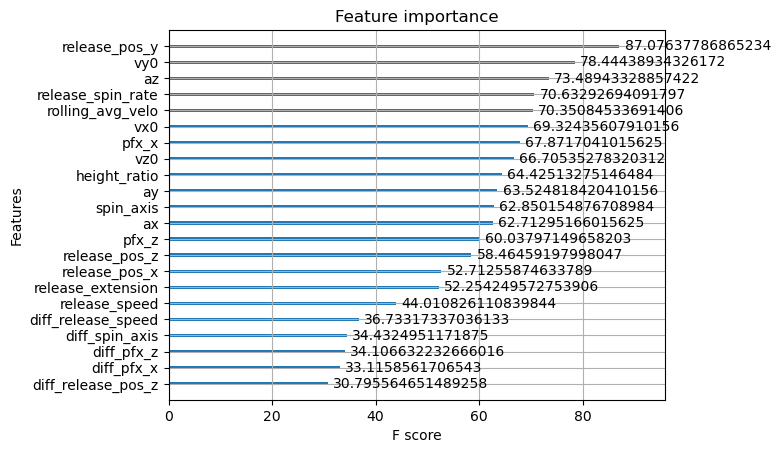

In [19]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

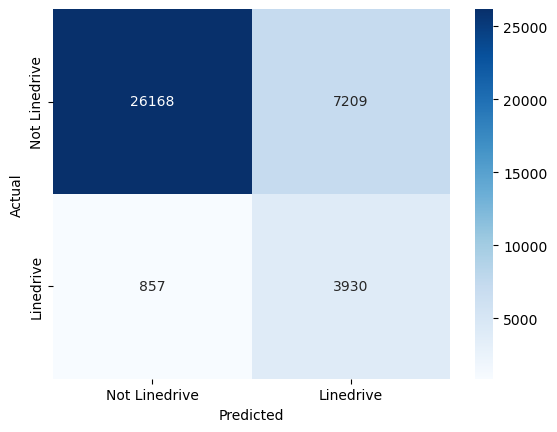

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [21]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [22]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xld'] = y_pred

In [ ]:
testing_identifiers.head()

pitch_id_raw       xld
7   661032_543685_543238_1_59_8  0.581926
8   661032_545361_543238_2_57_8  0.493466
9   661032_545361_543238_3_57_8  0.272984
10  661032_543685_543238_4_59_8  0.202081
11  661032_543685_543238_5_59_8  0.457897

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/ld_2022&3_xld.csv")